In [2]:
# パッケージのimport
import numpy as np
from collections import deque
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym import spaces
from gym.spaces.box import Box

In [6]:
# パッケージのインポート
import matplotlib.pyplot as plt
%matplotlib inline


# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames,name=None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0*1, frames[0].shape[0]/72.0*1),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
 
    def animate(i):
        patch.set_data(frames[i])
 
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=20)
    if name is None:
        anim.save('breakout.mp4')  # 動画のファイル名と保存です
        display(display_animation(anim, default_mode='loop'))
    else:
        anim.save(name)

In [3]:
# 実行環境の設定
# 参考：https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

import cv2
cv2.ocl.setUseOpenCL(False)


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        '''工夫1のNo-Operationです。リセット後適当なステップの間何もしないようにし、
        ゲーム開始の初期状態を様々にすることｆで、特定の開始状態のみで学習するのを防ぐ'''

        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(
                1, self.noop_max + 1)  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        '''工夫2のEpisodic Lifeです。1機失敗したときにリセットし、失敗時の状態から次を始める'''
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        '''5機とも失敗したら、本当にリセット'''
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        '''工夫3のMax and Skipです。4フレーム連続で同じ行動を実施し、最後の3、4フレームの最大値をとった画像をobsにする'''
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        '''工夫4のWarp frameです。画像サイズをNatureのDQN論文と同じ84x84の白黒にします'''
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height),
                           interpolation=cv2.INTER_AREA)
        return frame[:, :, None]


class WrapPyTorch(gym.ObservationWrapper):
    def __init__(self, env=None):
        '''PyTorchのミニバッチのインデックス順に変更するラッパー'''
        super(WrapPyTorch, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)

In [4]:
# 再生用の実行環境


class EpisodicLifeEnvPlay(gym.Wrapper):
    def __init__(self, env):
        '''工夫2のEpisodic Lifeです。1機失敗したときにリセットし、失敗時の状態から次を始める。
        今回は再生用に、1機失敗したときのリセット時もブロックの状態をリセットします'''

        gym.Wrapper.__init__(self, env)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        # ライフ（残機）が始め5あるが、1つでも減ると終了にする
        if self.env.unwrapped.ale.lives() < 5:
            done = True

        return obs, reward, done, info

    def reset(self, **kwargs):
        '''1回でも失敗したら完全リセット'''

        obs = self.env.reset(**kwargs)

        return obs


class MaxAndSkipEnvPlay(gym.Wrapper):
    def __init__(self, env, skip=4):
        '''工夫3のMax and Skipです。4フレーム連続で同じ行動を実施し、最後の4フレームの画像をobsにする'''
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break

        return obs, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
# 実行環境生成関数の定義

# 並列実行環境
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv


def make_env(env_id, seed, rank):
    def _thunk():
        '''_thunk()がマルチプロセス環境のSubprocVecEnvを実行するのに必要'''

        env = gym.make(env_id)
        #env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env.seed(seed + rank)  # 乱数シードの設定
        #env = EpisodicLifeEnv(env)
        env = EpisodicLifeEnvPlay(env)
        env = WarpFrame(env)
        env = WrapPyTorch(env)

        return env

    return _thunk


def make_env_play(env_id, seed, rank):
    '''再生用の実行環境'''
    env = gym.make(env_id)
    #env = NoopResetEnv(env, noop_max=30)
    #env = MaxAndSkipEnv(env, skip=4)
    env = MaxAndSkipEnvPlay(env, skip=4)
    env.seed(seed + rank)  # 乱数シードの設定
    env = EpisodicLifeEnvPlay(env)
    #env = WarpFrame(env)
    #env = WrapPyTorch(env)

    return env

In [6]:
# 定数の設定

ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
NUM_SKIP_FRAME = 4 # skipするframe数です
NUM_STACK_FRAME = 4  # 状態として連続的に保持するframe数です
NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 16 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 5  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 0.99  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは125,000となる

In [7]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99

In [8]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
# メモリオブジェクトの定義


class RolloutStorage(object):
    '''Advantage学習するためのメモリクラスです'''

    def __init__(self, num_steps, num_processes, obs_shape):

        self.observations = torch.zeros(
            num_steps + 1, num_processes, *obs_shape).to(device)
        # *を使うと()リストの中身を取り出す
        # obs_shape→(4,84,84)
        # *obs_shape→ 4 84 84

        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(
            num_steps, num_processes, 1).long().to(device)

        # 割引報酬和を格納
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.index = 0  # insertするインデックス

    def insert(self, current_obs, action, reward, mask):
        '''次のindexにtransitionを格納する'''
        self.observations[self.index + 1].copy_(current_obs)
        self.masks[self.index + 1].copy_(mask)
        self.rewards[self.index].copy_(reward)
        self.actions[self.index].copy_(action)

        self.index = (self.index + 1) % NUM_ADVANCED_STEP  # インデックスの更新

    def after_update(self):
        '''Advantageするstep数が完了したら、最新のものをindex0に格納'''
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value):
        '''Advantageするステップ中の各ステップの割引報酬和を計算する'''

        # 注意：5step目から逆向きに計算しています
        # 注意：5step目はAdvantage1となる。4ステップ目はAdvantage2となる。・・・
        self.returns[-1] = next_value
        for ad_step in reversed(range(self.rewards.size(0))):
            self.returns[ad_step] = self.returns[ad_step + 1] * \
                GAMMA * self.masks[ad_step + 1] + self.rewards[ad_step]

In [10]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化84*84→20*20
            init_(nn.Conv2d(NUM_STACK_FRAME, 32, kernel_size=8, stride=4)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化20*20→9*9
            init_(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=3, stride=1)),  # 画像サイズの変化9*9→7*7
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 7 * 7, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy

In [11]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        filename = 'weight_end.pth'
        #filename = 'weight_112500.pth'
        param = torch.load(filename, map_location='cpu')
        self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新

In [16]:
# Breakoutを実行する環境のクラス
import pickle

NUM_PROCESSES = 1
frames_dic = {}

class Environment:
    def run(self):

        # seedの設定
        seed_num = 1
        torch.manual_seed(seed_num)
        if use_cuda:
            torch.cuda.manual_seed(seed_num)

        # 実行環境を構築
        torch.set_num_threads(seed_num)
        envs = [make_env(ENV_NAME, seed_num, i) for i in range(NUM_PROCESSES)]
        envs = SubprocVecEnv(envs)  # マルチプロセスの実行環境にする

        # 全エージェントが共有して持つ頭脳Brainを生成
        n_out = envs.action_space.n  # 行動の種類は4
        actor_critic = Net(n_out).to(device)  # GPUへ
        global_brain = Brain(actor_critic)

        # 格納用変数の生成
        obs_shape = envs.observation_space.shape  # (1, 84, 84)
        obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
                     *obs_shape[1:])  # (4, 84, 84)
        # torch.Size([16, 4, 84, 84])
        current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
        rollouts = RolloutStorage(
            NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
        episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
        final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

        # 初期状態の開始
        obs = envs.reset()
        obs = torch.from_numpy(obs).float()  # torch.Size([16, 1, 84, 84])
        current_obs[:, -1:] = obs  # flameの4番目に最新のobsを格納

        # advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
        rollouts.observations[0].copy_(current_obs)

        # 描画用の環境（再生用に追加）
        env_play = make_env_play(ENV_NAME, seed_num, 0)
        obs_play = env_play.reset()

        # 動画にするために画像を格納する変数（再生用に追加）
        frames = []
        main_end = False

        # 実行ループ
        for j in tqdm(range(NUM_UPDATES)):

            # 報酬が基準を超えたら終わりにする（再生用に追加）
            if main_end:
                break

            # advanced学習するstep数ごとに計算
            for step in range(NUM_ADVANCED_STEP):

                # 行動を求める
                with torch.no_grad():
                    action = actor_critic.act(rollouts.observations[step])

                cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

                # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
                obs, reward, done, info = envs.step(cpu_actions)

                # 報酬をtensorに変換し、試行の総報酬に足す
                # sizeが(16,)になっているのを(16, 1)に変換
                reward = np.expand_dims(np.stack(reward), 1)
                reward = torch.from_numpy(reward).float()
                episode_rewards += reward

                # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
                masks = torch.FloatTensor(
                    [[0.0] if done_ else [1.0] for done_ in done])

                # 最後の試行の総報酬を更新する
                final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
                # 継続中は0を足す、done時にはepisode_rewardsを足す
                final_rewards += (1 - masks) * episode_rewards

                # 画像を取得する(再生用に追加）
                obs_play, reward_play, _, _ = env_play.step(cpu_actions[0])
                frames.append(obs_play)  # 変換した画像を保存
                if done[0]:  # 並列環境の1つ目が終了した場合
                    print(episode_rewards[0][0].numpy())  # 報酬

                    # 報酬が300を超えたら終わりにする
                    if (episode_rewards[0][0].numpy()) > 440:
                        main_end = True
                        break
                    else:
                        if j% 1000 == 0:
                            frames_dic[j] = frames
                        obs_view = env_play.reset()
                        frames = []  # 保存した画像をリセット

                # 試行の総報酬を更新する
                episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

                # masksをGPUへ
                masks = masks.to(device)

                # 現在の状態をdone時には全部0にする
                # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
                current_obs *= masks.unsqueeze(2).unsqueeze(2)

                # frameをstackする
                # torch.Size([16, 1, 84, 84])
                obs = torch.from_numpy(obs).float()
                current_obs[:, :-1] = current_obs[:, 1:]  # 0～2番目に1～3番目を上書き
                current_obs[:, -1:] = obs  # 4番目に最新のobsを格納

                # メモリオブジェクトに今stepのtransitionを挿入
                rollouts.insert(current_obs, action.data, reward, masks)

            # advancedのfor loop終了

            # advancedした最終stepの状態から予想する状態価値を計算
            with torch.no_grad():
                next_value = actor_critic.get_value(
                    rollouts.observations[-1]).detach()

            # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
            rollouts.compute_returns(next_value)

            # ネットワークとrolloutの更新
            # global_brain.update(rollouts)
            rollouts.after_update()

        with open('frames.pkl','wb') as f:
            pickle.dump(frames_dic, f)
        # 実行ループ終わり
        display_frames_as_gif(frames)  # 動画の保存と再生



  0%|                                               | 0/125000 [00:00<?, ?it/s]

  0%|                                     | 3/125000 [00:00<1:42:46, 20.27it/s]

  0%|                                     | 5/125000 [00:00<1:43:44, 20.08it/s]

  0%|                                     | 7/125000 [00:00<1:44:27, 19.94it/s]

  0%|                                     | 9/125000 [00:00<1:45:18, 19.78it/s]

  0%|                                    | 11/125000 [00:00<1:45:28, 19.75it/s]

  0%|                                    | 13/125000 [00:00<1:45:26, 19.76it/s]

  0%|                                    | 15/125000 [00:00<1:45:32, 19.74it/s]

  0%|                                    | 17/125000 [00:00<1:45:44, 19.70it/s]

  0%|                                    | 19/125000 [00:00<1:45:34, 19.73it/s]

  0%|                                    | 22/125000 [00:01<1:45:11, 19.80it/s]

  0%|                                    | 24/125000 [00:01<1:45:06, 19.82it/s]

  0%|                     

10.0




  0%|                                    | 75/125000 [00:03<1:45:45, 19.69it/s]

  0%|                                    | 78/125000 [00:03<1:45:33, 19.72it/s]

  0%|                                    | 81/125000 [00:04<1:45:20, 19.76it/s]

  0%|                                    | 83/125000 [00:04<1:45:18, 19.77it/s]

  0%|                                    | 86/125000 [00:04<1:44:57, 19.84it/s]

  0%|                                    | 89/125000 [00:04<1:44:41, 19.89it/s]

  0%|                                    | 92/125000 [00:04<1:44:25, 19.94it/s]

  0%|                                    | 95/125000 [00:04<1:44:01, 20.01it/s]

  0%|                                    | 98/125000 [00:04<1:43:41, 20.08it/s]

  0%|                                   | 101/125000 [00:05<1:43:23, 20.13it/s]

  0%|                                   | 104/125000 [00:05<1:43:07, 20.18it/s]

  0%|                                   | 107/125000 [00:05<1:42:57, 20.22it/s]

  0%|                     

15.0




  0%|                                   | 177/125000 [00:08<1:45:40, 19.69it/s]

  0%|                                   | 179/125000 [00:09<1:45:38, 19.69it/s]

  0%|                                   | 181/125000 [00:09<1:45:43, 19.68it/s]

  0%|                                   | 183/125000 [00:09<1:45:46, 19.67it/s]

  0%|                                   | 185/125000 [00:09<1:46:11, 19.59it/s]

  0%|                                   | 187/125000 [00:09<1:46:24, 19.55it/s]

  0%|                                   | 189/125000 [00:09<1:46:43, 19.49it/s]

  0%|                                   | 191/125000 [00:09<1:46:49, 19.47it/s]

  0%|                                   | 193/125000 [00:09<1:46:58, 19.44it/s]

  0%|                                   | 195/125000 [00:10<1:47:05, 19.42it/s]

  0%|                                   | 197/125000 [00:10<1:47:10, 19.41it/s]

  0%|                                   | 199/125000 [00:10<1:47:16, 19.39it/s]

  0%|                     

16.0




  0%|                                   | 272/125000 [00:14<1:49:34, 18.97it/s]

  0%|                                   | 274/125000 [00:14<1:49:35, 18.97it/s]

  0%|                                   | 276/125000 [00:14<1:49:34, 18.97it/s]

  0%|                                   | 278/125000 [00:14<1:49:34, 18.97it/s]

  0%|                                   | 280/125000 [00:14<1:49:38, 18.96it/s]

  0%|                                   | 282/125000 [00:14<1:49:37, 18.96it/s]

  0%|                                   | 284/125000 [00:14<1:49:37, 18.96it/s]

  0%|                                   | 286/125000 [00:15<1:49:35, 18.97it/s]

  0%|                                   | 289/125000 [00:15<1:49:30, 18.98it/s]

  0%|                                   | 291/125000 [00:15<1:49:29, 18.98it/s]

  0%|                                   | 293/125000 [00:15<1:49:29, 18.98it/s]

  0%|                                   | 295/125000 [00:15<1:49:29, 18.98it/s]

  0%|                     

17.0




  0%|                                   | 372/125000 [00:20<1:51:44, 18.59it/s]

  0%|                                   | 374/125000 [00:20<1:51:46, 18.58it/s]

  0%|                                   | 376/125000 [00:20<1:51:48, 18.58it/s]

  0%|                                   | 378/125000 [00:20<1:51:49, 18.57it/s]

  0%|                                   | 380/125000 [00:20<1:51:48, 18.58it/s]

  0%|                                   | 382/125000 [00:20<1:51:50, 18.57it/s]

  0%|                                   | 384/125000 [00:20<1:51:51, 18.57it/s]

  0%|                                   | 386/125000 [00:20<1:51:53, 18.56it/s]

  0%|                                   | 388/125000 [00:20<1:51:54, 18.56it/s]

  0%|                                   | 390/125000 [00:21<1:51:56, 18.55it/s]

  0%|                                   | 392/125000 [00:21<1:51:56, 18.55it/s]

  0%|                                   | 394/125000 [00:21<1:51:59, 18.54it/s]

  0%|                     

10.0




  0%|▏                                  | 448/125000 [00:24<1:53:09, 18.34it/s]

  0%|▏                                  | 450/125000 [00:24<1:53:10, 18.34it/s]

  0%|▏                                  | 452/125000 [00:24<1:53:13, 18.33it/s]

  0%|▏                                  | 454/125000 [00:24<1:53:13, 18.33it/s]

  0%|▏                                  | 456/125000 [00:24<1:53:13, 18.33it/s]

  0%|▏                                  | 458/125000 [00:24<1:53:15, 18.33it/s]

  0%|▏                                  | 460/125000 [00:25<1:53:16, 18.32it/s]

  0%|▏                                  | 462/125000 [00:25<1:53:16, 18.32it/s]

  0%|▏                                  | 464/125000 [00:25<1:53:17, 18.32it/s]

  0%|▏                                  | 466/125000 [00:25<1:53:19, 18.32it/s]

  0%|▏                                  | 468/125000 [00:25<1:53:18, 18.32it/s]

  0%|▏                                  | 470/125000 [00:25<1:53:20, 18.31it/s]

  0%|▏                    

35.0




  0%|▏                                  | 570/125000 [00:31<1:54:06, 18.17it/s]

  0%|▏                                  | 572/125000 [00:31<1:54:05, 18.18it/s]

  0%|▏                                  | 574/125000 [00:31<1:54:05, 18.18it/s]

  0%|▏                                  | 576/125000 [00:31<1:54:05, 18.18it/s]

  0%|▏                                  | 578/125000 [00:31<1:54:05, 18.18it/s]

  0%|▏                                  | 580/125000 [00:31<1:54:05, 18.18it/s]

  0%|▏                                  | 582/125000 [00:32<1:54:05, 18.17it/s]

  0%|▏                                  | 584/125000 [00:32<1:54:05, 18.17it/s]

  0%|▏                                  | 586/125000 [00:32<1:54:05, 18.17it/s]

  0%|▏                                  | 588/125000 [00:32<1:54:04, 18.18it/s]

  0%|▏                                  | 590/125000 [00:32<1:54:05, 18.17it/s]

  0%|▏                                  | 592/125000 [00:32<1:54:07, 18.17it/s]

  0%|▏                    

26.0




  1%|▏                                  | 700/125000 [00:38<1:54:29, 18.10it/s]

  1%|▏                                  | 702/125000 [00:38<1:54:29, 18.10it/s]

  1%|▏                                  | 704/125000 [00:38<1:54:27, 18.10it/s]

  1%|▏                                  | 706/125000 [00:39<1:54:27, 18.10it/s]

  1%|▏                                  | 708/125000 [00:39<1:54:27, 18.10it/s]

  1%|▏                                  | 710/125000 [00:39<1:54:28, 18.10it/s]

  1%|▏                                  | 712/125000 [00:39<1:54:28, 18.10it/s]

  1%|▏                                  | 714/125000 [00:39<1:54:28, 18.09it/s]

  1%|▏                                  | 716/125000 [00:39<1:54:29, 18.09it/s]

  1%|▏                                  | 718/125000 [00:39<1:54:29, 18.09it/s]

  1%|▏                                  | 720/125000 [00:39<1:54:29, 18.09it/s]

  1%|▏                                  | 722/125000 [00:39<1:54:29, 18.09it/s]

  1%|▏                    

26.0




  1%|▏                                  | 828/125000 [00:45<1:54:36, 18.06it/s]

  1%|▏                                  | 830/125000 [00:45<1:54:35, 18.06it/s]

  1%|▏                                  | 832/125000 [00:46<1:54:35, 18.06it/s]

  1%|▏                                  | 834/125000 [00:46<1:54:35, 18.06it/s]

  1%|▏                                  | 836/125000 [00:46<1:54:34, 18.06it/s]

  1%|▏                                  | 838/125000 [00:46<1:54:33, 18.06it/s]

  1%|▏                                  | 840/125000 [00:46<1:54:33, 18.06it/s]

  1%|▏                                  | 842/125000 [00:46<1:54:34, 18.06it/s]

  1%|▏                                  | 844/125000 [00:46<1:54:34, 18.06it/s]

  1%|▏                                  | 846/125000 [00:46<1:54:34, 18.06it/s]

  1%|▏                                  | 848/125000 [00:46<1:54:34, 18.06it/s]

  1%|▏                                  | 850/125000 [00:47<1:54:34, 18.06it/s]

  1%|▏                    

28.0




  1%|▎                                  | 966/125000 [00:53<1:54:56, 17.98it/s]

  1%|▎                                  | 968/125000 [00:53<1:54:55, 17.99it/s]

  1%|▎                                  | 970/125000 [00:53<1:54:54, 17.99it/s]

  1%|▎                                  | 972/125000 [00:54<1:54:53, 17.99it/s]

  1%|▎                                  | 975/125000 [00:54<1:54:50, 18.00it/s]

  1%|▎                                  | 977/125000 [00:54<1:54:49, 18.00it/s]

  1%|▎                                  | 979/125000 [00:54<1:54:48, 18.00it/s]

  1%|▎                                  | 981/125000 [00:54<1:54:47, 18.01it/s]

  1%|▎                                  | 983/125000 [00:54<1:54:46, 18.01it/s]

  1%|▎                                  | 985/125000 [00:54<1:54:46, 18.01it/s]

  1%|▎                                  | 987/125000 [00:54<1:54:45, 18.01it/s]

  1%|▎                                  | 989/125000 [00:54<1:54:44, 18.01it/s]

  1%|▎                    

15.0




  1%|▎                                 | 1068/125000 [00:59<1:54:20, 18.07it/s]

  1%|▎                                 | 1070/125000 [00:59<1:54:22, 18.06it/s]

  1%|▎                                 | 1072/125000 [00:59<1:54:30, 18.04it/s]

  1%|▎                                 | 1074/125000 [00:59<1:54:30, 18.04it/s]

  1%|▎                                 | 1076/125000 [00:59<1:54:31, 18.03it/s]

  1%|▎                                 | 1078/125000 [00:59<1:54:32, 18.03it/s]

  1%|▎                                 | 1080/125000 [00:59<1:54:32, 18.03it/s]

  1%|▎                                 | 1082/125000 [01:00<1:54:32, 18.03it/s]

  1%|▎                                 | 1084/125000 [01:00<1:54:32, 18.03it/s]

  1%|▎                                 | 1086/125000 [01:00<1:54:33, 18.03it/s]

  1%|▎                                 | 1088/125000 [01:00<1:54:34, 18.02it/s]

  1%|▎                                 | 1090/125000 [01:00<1:54:35, 18.02it/s]

  1%|▎                    

3.0




  1%|▎                                 | 1096/125000 [01:00<1:54:46, 17.99it/s]

  1%|▎                                 | 1098/125000 [01:01<1:54:45, 17.99it/s]

  1%|▎                                 | 1100/125000 [01:01<1:54:47, 17.99it/s]

  1%|▎                                 | 1102/125000 [01:01<1:54:47, 17.99it/s]

  1%|▎                                 | 1104/125000 [01:01<1:54:47, 17.99it/s]

  1%|▎                                 | 1106/125000 [01:01<1:54:49, 17.98it/s]

  1%|▎                                 | 1108/125000 [01:01<1:54:50, 17.98it/s]

  1%|▎                                 | 1110/125000 [01:01<1:54:49, 17.98it/s]

  1%|▎                                 | 1112/125000 [01:01<1:54:49, 17.98it/s]

  1%|▎                                 | 1114/125000 [01:01<1:54:49, 17.98it/s]

  1%|▎                                 | 1116/125000 [01:02<1:54:49, 17.98it/s]

  1%|▎                                 | 1118/125000 [01:02<1:54:50, 17.98it/s]

  1%|▎                    

16.0




  1%|▎                                 | 1202/125000 [01:07<1:55:22, 17.88it/s]

  1%|▎                                 | 1204/125000 [01:07<1:55:23, 17.88it/s]

  1%|▎                                 | 1206/125000 [01:07<1:55:23, 17.88it/s]

  1%|▎                                 | 1208/125000 [01:07<1:55:25, 17.87it/s]

  1%|▎                                 | 1210/125000 [01:07<1:55:26, 17.87it/s]

  1%|▎                                 | 1212/125000 [01:07<1:55:26, 17.87it/s]

  1%|▎                                 | 1214/125000 [01:07<1:55:27, 17.87it/s]

  1%|▎                                 | 1216/125000 [01:08<1:55:28, 17.87it/s]

  1%|▎                                 | 1218/125000 [01:08<1:55:28, 17.87it/s]

  1%|▎                                 | 1220/125000 [01:08<1:55:28, 17.87it/s]

  1%|▎                                 | 1222/125000 [01:08<1:55:29, 17.86it/s]

  1%|▎                                 | 1224/125000 [01:08<1:55:30, 17.86it/s]

  1%|▎                    

36.0




  1%|▎                                 | 1366/125000 [01:17<1:56:25, 17.70it/s]

  1%|▎                                 | 1368/125000 [01:17<1:56:26, 17.70it/s]

  1%|▎                                 | 1370/125000 [01:17<1:56:27, 17.69it/s]

  1%|▎                                 | 1372/125000 [01:17<1:56:28, 17.69it/s]

  1%|▎                                 | 1374/125000 [01:17<1:56:29, 17.69it/s]

  1%|▎                                 | 1376/125000 [01:17<1:56:29, 17.69it/s]

  1%|▎                                 | 1378/125000 [01:17<1:56:29, 17.69it/s]

  1%|▍                                 | 1380/125000 [01:18<1:56:29, 17.69it/s]

  1%|▍                                 | 1382/125000 [01:18<1:56:28, 17.69it/s]

  1%|▍                                 | 1384/125000 [01:18<1:56:28, 17.69it/s]

  1%|▍                                 | 1386/125000 [01:18<1:56:29, 17.69it/s]

  1%|▍                                 | 1388/125000 [01:18<1:56:30, 17.68it/s]

  1%|▍                    

6.0




  1%|▍                                 | 1406/125000 [01:19<1:56:38, 17.66it/s]

  1%|▍                                 | 1408/125000 [01:19<1:56:39, 17.66it/s]

  1%|▍                                 | 1410/125000 [01:19<1:56:40, 17.66it/s]

  1%|▍                                 | 1412/125000 [01:19<1:56:40, 17.65it/s]

  1%|▍                                 | 1414/125000 [01:20<1:56:40, 17.65it/s]

  1%|▍                                 | 1416/125000 [01:20<1:56:40, 17.65it/s]

  1%|▍                                 | 1418/125000 [01:20<1:56:41, 17.65it/s]

  1%|▍                                 | 1420/125000 [01:20<1:56:43, 17.65it/s]

  1%|▍                                 | 1422/125000 [01:20<1:56:44, 17.64it/s]

  1%|▍                                 | 1424/125000 [01:20<1:56:44, 17.64it/s]

  1%|▍                                 | 1426/125000 [01:20<1:56:46, 17.64it/s]

  1%|▍                                 | 1428/125000 [01:20<1:56:48, 17.63it/s]

  1%|▍                    

13.0




  1%|▍                                 | 1500/125000 [01:25<1:57:28, 17.52it/s]

  1%|▍                                 | 1502/125000 [01:25<1:57:28, 17.52it/s]

  1%|▍                                 | 1504/125000 [01:25<1:57:29, 17.52it/s]

  1%|▍                                 | 1506/125000 [01:25<1:57:30, 17.52it/s]

  1%|▍                                 | 1508/125000 [01:26<1:57:32, 17.51it/s]

  1%|▍                                 | 1510/125000 [01:26<1:57:33, 17.51it/s]

  1%|▍                                 | 1512/125000 [01:26<1:57:34, 17.50it/s]

  1%|▍                                 | 1514/125000 [01:26<1:57:35, 17.50it/s]

  1%|▍                                 | 1516/125000 [01:26<1:57:35, 17.50it/s]

  1%|▍                                 | 1518/125000 [01:26<1:57:35, 17.50it/s]

  1%|▍                                 | 1520/125000 [01:26<1:57:35, 17.50it/s]

  1%|▍                                 | 1522/125000 [01:26<1:57:35, 17.50it/s]

  1%|▍                    

27.0




  1%|▍                                 | 1634/125000 [01:33<1:57:41, 17.47it/s]

  1%|▍                                 | 1636/125000 [01:33<1:57:41, 17.47it/s]

  1%|▍                                 | 1638/125000 [01:33<1:57:41, 17.47it/s]

  1%|▍                                 | 1640/125000 [01:33<1:57:40, 17.47it/s]

  1%|▍                                 | 1642/125000 [01:33<1:57:40, 17.47it/s]

  1%|▍                                 | 1644/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                                 | 1646/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                                 | 1648/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                                 | 1650/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                                 | 1652/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                                 | 1654/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                                 | 1656/125000 [01:34<1:57:40, 17.47it/s]

  1%|▍                    

313.0




  2%|▌                                 | 1924/125000 [01:51<1:58:35, 17.30it/s]

  2%|▌                                 | 1926/125000 [01:51<1:58:36, 17.29it/s]

  2%|▌                                 | 1928/125000 [01:51<1:58:36, 17.29it/s]

  2%|▌                                 | 1930/125000 [01:51<1:58:36, 17.29it/s]

  2%|▌                                 | 1932/125000 [01:51<1:58:36, 17.29it/s]

  2%|▌                                 | 1934/125000 [01:51<1:58:37, 17.29it/s]

  2%|▌                                 | 1936/125000 [01:51<1:58:37, 17.29it/s]

  2%|▌                                 | 1938/125000 [01:52<1:58:39, 17.29it/s]

  2%|▌                                 | 1940/125000 [01:52<1:58:40, 17.28it/s]

  2%|▌                                 | 1942/125000 [01:52<1:58:39, 17.28it/s]

  2%|▌                                 | 1944/125000 [01:52<1:58:40, 17.28it/s]

  2%|▌                                 | 1946/125000 [01:52<1:58:40, 17.28it/s]

  2%|▌                    

16.0




  2%|▌                                 | 2018/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2020/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2022/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2024/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2026/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2028/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2030/125000 [01:57<1:59:00, 17.22it/s]

  2%|▌                                 | 2032/125000 [01:57<1:58:59, 17.22it/s]

  2%|▌                                 | 2034/125000 [01:58<1:58:59, 17.22it/s]

  2%|▌                                 | 2036/125000 [01:58<1:58:59, 17.22it/s]

  2%|▌                                 | 2038/125000 [01:58<1:58:59, 17.22it/s]

  2%|▌                                 | 2040/125000 [01:58<1:58:59, 17.22it/s]

  2%|▌                    

10.0




  2%|▌                                 | 2064/125000 [01:59<1:59:00, 17.22it/s]

  2%|▌                                 | 2066/125000 [01:59<1:59:00, 17.22it/s]

  2%|▌                                 | 2068/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2070/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2072/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2074/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2076/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2078/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2080/125000 [02:00<1:58:59, 17.22it/s]

  2%|▌                                 | 2082/125000 [02:00<1:58:58, 17.22it/s]

  2%|▌                                 | 2084/125000 [02:01<1:58:58, 17.22it/s]

  2%|▌                                 | 2086/125000 [02:01<1:58:58, 17.22it/s]

  2%|▌                    

13.0




  2%|▌                                 | 2160/125000 [02:05<1:59:07, 17.19it/s]

  2%|▌                                 | 2162/125000 [02:05<1:59:07, 17.19it/s]

  2%|▌                                 | 2164/125000 [02:05<1:59:07, 17.19it/s]

  2%|▌                                 | 2166/125000 [02:06<1:59:07, 17.19it/s]

  2%|▌                                 | 2168/125000 [02:06<1:59:06, 17.19it/s]

  2%|▌                                 | 2170/125000 [02:06<1:59:06, 17.19it/s]

  2%|▌                                 | 2172/125000 [02:06<1:59:06, 17.19it/s]

  2%|▌                                 | 2174/125000 [02:06<1:59:05, 17.19it/s]

  2%|▌                                 | 2176/125000 [02:06<1:59:06, 17.19it/s]

  2%|▌                                 | 2178/125000 [02:06<1:59:06, 17.19it/s]

  2%|▌                                 | 2180/125000 [02:06<1:59:05, 17.19it/s]

  2%|▌                                 | 2182/125000 [02:06<1:59:05, 17.19it/s]

  2%|▌                    

31.0




  2%|▋                                 | 2300/125000 [02:14<1:59:12, 17.16it/s]

  2%|▋                                 | 2302/125000 [02:14<1:59:12, 17.16it/s]

  2%|▋                                 | 2304/125000 [02:14<1:59:12, 17.15it/s]

  2%|▋                                 | 2306/125000 [02:14<1:59:12, 17.15it/s]

  2%|▋                                 | 2308/125000 [02:14<1:59:12, 17.15it/s]

  2%|▋                                 | 2310/125000 [02:14<1:59:11, 17.15it/s]

  2%|▋                                 | 2312/125000 [02:14<1:59:11, 17.15it/s]

  2%|▋                                 | 2314/125000 [02:14<1:59:11, 17.16it/s]

  2%|▋                                 | 2316/125000 [02:14<1:59:11, 17.16it/s]

  2%|▋                                 | 2318/125000 [02:15<1:59:11, 17.16it/s]

  2%|▋                                 | 2320/125000 [02:15<1:59:11, 17.15it/s]

  2%|▋                                 | 2322/125000 [02:15<1:59:12, 17.15it/s]

  2%|▋                    

17.0




  2%|▋                                 | 2398/125000 [02:19<1:59:11, 17.14it/s]

  2%|▋                                 | 2400/125000 [02:19<1:59:11, 17.14it/s]

  2%|▋                                 | 2402/125000 [02:20<1:59:11, 17.14it/s]

  2%|▋                                 | 2404/125000 [02:20<1:59:10, 17.14it/s]

  2%|▋                                 | 2406/125000 [02:20<1:59:10, 17.14it/s]

  2%|▋                                 | 2408/125000 [02:20<1:59:10, 17.14it/s]

  2%|▋                                 | 2410/125000 [02:20<1:59:10, 17.14it/s]

  2%|▋                                 | 2412/125000 [02:20<1:59:09, 17.15it/s]

  2%|▋                                 | 2414/125000 [02:20<1:59:09, 17.15it/s]

  2%|▋                                 | 2416/125000 [02:20<1:59:09, 17.15it/s]

  2%|▋                                 | 2418/125000 [02:21<1:59:08, 17.15it/s]

  2%|▋                                 | 2420/125000 [02:21<1:59:08, 17.15it/s]

  2%|▋                    

247.0




  2%|▋                                 | 2596/125000 [02:31<1:59:16, 17.10it/s]

  2%|▋                                 | 2598/125000 [02:31<1:59:16, 17.10it/s]

  2%|▋                                 | 2600/125000 [02:32<1:59:16, 17.10it/s]

  2%|▋                                 | 2602/125000 [02:32<1:59:16, 17.10it/s]

  2%|▋                                 | 2604/125000 [02:32<1:59:16, 17.10it/s]

  2%|▋                                 | 2606/125000 [02:32<1:59:17, 17.10it/s]

  2%|▋                                 | 2608/125000 [02:32<1:59:17, 17.10it/s]

  2%|▋                                 | 2610/125000 [02:32<1:59:17, 17.10it/s]

  2%|▋                                 | 2612/125000 [02:32<1:59:17, 17.10it/s]

  2%|▋                                 | 2614/125000 [02:32<1:59:17, 17.10it/s]

  2%|▋                                 | 2616/125000 [02:32<1:59:17, 17.10it/s]

  2%|▋                                 | 2618/125000 [02:33<1:59:16, 17.10it/s]

  2%|▋                    

11.0




  2%|▋                                 | 2680/125000 [02:36<1:59:19, 17.09it/s]

  2%|▋                                 | 2682/125000 [02:36<1:59:19, 17.08it/s]

  2%|▋                                 | 2684/125000 [02:37<1:59:20, 17.08it/s]

  2%|▋                                 | 2686/125000 [02:37<1:59:20, 17.08it/s]

  2%|▋                                 | 2688/125000 [02:37<1:59:20, 17.08it/s]

  2%|▋                                 | 2690/125000 [02:37<1:59:21, 17.08it/s]

  2%|▋                                 | 2692/125000 [02:37<1:59:21, 17.08it/s]

  2%|▋                                 | 2694/125000 [02:37<1:59:20, 17.08it/s]

  2%|▋                                 | 2696/125000 [02:37<1:59:20, 17.08it/s]

  2%|▋                                 | 2698/125000 [02:37<1:59:20, 17.08it/s]

  2%|▋                                 | 2700/125000 [02:38<1:59:20, 17.08it/s]

  2%|▋                                 | 2702/125000 [02:38<1:59:20, 17.08it/s]

  2%|▋                    

78.0




  2%|▊                                 | 2880/125000 [02:49<1:59:28, 17.04it/s]

  2%|▊                                 | 2882/125000 [02:49<1:59:28, 17.04it/s]

  2%|▊                                 | 2884/125000 [02:49<1:59:28, 17.03it/s]

  2%|▊                                 | 2886/125000 [02:49<1:59:28, 17.03it/s]

  2%|▊                                 | 2888/125000 [02:49<1:59:29, 17.03it/s]

  2%|▊                                 | 2890/125000 [02:49<1:59:29, 17.03it/s]

  2%|▊                                 | 2892/125000 [02:49<1:59:29, 17.03it/s]

  2%|▊                                 | 2894/125000 [02:49<1:59:29, 17.03it/s]

  2%|▊                                 | 2896/125000 [02:50<1:59:30, 17.03it/s]

  2%|▊                                 | 2898/125000 [02:50<1:59:29, 17.03it/s]

  2%|▊                                 | 2900/125000 [02:50<1:59:29, 17.03it/s]

  2%|▊                                 | 2902/125000 [02:50<1:59:29, 17.03it/s]

  2%|▊                    

34.0




  2%|▊                                 | 3030/125000 [02:58<1:59:34, 17.00it/s]

  2%|▊                                 | 3032/125000 [02:58<1:59:34, 17.00it/s]

  2%|▊                                 | 3034/125000 [02:58<1:59:34, 17.00it/s]

  2%|▊                                 | 3036/125000 [02:58<1:59:34, 17.00it/s]

  2%|▊                                 | 3038/125000 [02:58<1:59:34, 17.00it/s]

  2%|▊                                 | 3040/125000 [02:58<1:59:35, 17.00it/s]

  2%|▊                                 | 3042/125000 [02:58<1:59:35, 17.00it/s]

  2%|▊                                 | 3044/125000 [02:59<1:59:35, 17.00it/s]

  2%|▊                                 | 3046/125000 [02:59<1:59:35, 17.00it/s]

  2%|▊                                 | 3048/125000 [02:59<1:59:35, 17.00it/s]

  2%|▊                                 | 3050/125000 [02:59<1:59:34, 17.00it/s]

  2%|▊                                 | 3052/125000 [02:59<1:59:34, 17.00it/s]

  2%|▊                    

17.0




  3%|▊                                 | 3144/125000 [03:05<1:59:41, 16.97it/s]

  3%|▊                                 | 3146/125000 [03:05<1:59:42, 16.96it/s]

  3%|▊                                 | 3148/125000 [03:05<1:59:42, 16.96it/s]

  3%|▊                                 | 3150/125000 [03:05<1:59:42, 16.96it/s]

  3%|▊                                 | 3152/125000 [03:05<1:59:42, 16.96it/s]

  3%|▊                                 | 3154/125000 [03:05<1:59:42, 16.96it/s]

  3%|▊                                 | 3156/125000 [03:06<1:59:42, 16.96it/s]

  3%|▊                                 | 3158/125000 [03:06<1:59:42, 16.96it/s]

  3%|▊                                 | 3160/125000 [03:06<1:59:41, 16.96it/s]

  3%|▊                                 | 3163/125000 [03:06<1:59:40, 16.97it/s]

  3%|▊                                 | 3165/125000 [03:06<1:59:40, 16.97it/s]

  3%|▊                                 | 3167/125000 [03:06<1:59:40, 16.97it/s]

  3%|▊                    

22.0




  3%|▉                                 | 3266/125000 [03:11<1:59:15, 17.01it/s]

  3%|▉                                 | 3268/125000 [03:12<1:59:15, 17.01it/s]

  3%|▉                                 | 3270/125000 [03:12<1:59:15, 17.01it/s]

  3%|▉                                 | 3272/125000 [03:12<1:59:14, 17.01it/s]

  3%|▉                                 | 3274/125000 [03:12<1:59:14, 17.01it/s]

  3%|▉                                 | 3276/125000 [03:12<1:59:13, 17.01it/s]

  3%|▉                                 | 3278/125000 [03:12<1:59:14, 17.01it/s]

  3%|▉                                 | 3280/125000 [03:12<1:59:14, 17.01it/s]

  3%|▉                                 | 3282/125000 [03:12<1:59:14, 17.01it/s]

  3%|▉                                 | 3284/125000 [03:13<1:59:13, 17.01it/s]

  3%|▉                                 | 3286/125000 [03:13<1:59:13, 17.01it/s]

  3%|▉                                 | 3288/125000 [03:13<1:59:13, 17.01it/s]

  3%|▉                    

27.0




  3%|▉                                 | 3386/125000 [03:18<1:59:03, 17.02it/s]

  3%|▉                                 | 3388/125000 [03:19<1:59:03, 17.02it/s]

  3%|▉                                 | 3390/125000 [03:19<1:59:02, 17.03it/s]

  3%|▉                                 | 3392/125000 [03:19<1:59:02, 17.03it/s]

  3%|▉                                 | 3394/125000 [03:19<1:59:02, 17.03it/s]

  3%|▉                                 | 3396/125000 [03:19<1:59:02, 17.03it/s]

  3%|▉                                 | 3398/125000 [03:19<1:59:02, 17.03it/s]

  3%|▉                                 | 3400/125000 [03:19<1:59:02, 17.03it/s]

  3%|▉                                 | 3402/125000 [03:19<1:59:01, 17.03it/s]

  3%|▉                                 | 3404/125000 [03:19<1:59:01, 17.03it/s]

  3%|▉                                 | 3406/125000 [03:20<1:59:02, 17.02it/s]

  3%|▉                                 | 3408/125000 [03:20<1:59:02, 17.02it/s]

  3%|▉                    

6.0




  3%|▉                                 | 3426/125000 [03:21<1:59:02, 17.02it/s]

  3%|▉                                 | 3428/125000 [03:21<1:59:02, 17.02it/s]

  3%|▉                                 | 3430/125000 [03:21<1:59:01, 17.02it/s]

  3%|▉                                 | 3432/125000 [03:21<1:59:01, 17.02it/s]

  3%|▉                                 | 3434/125000 [03:21<1:59:00, 17.02it/s]

  3%|▉                                 | 3436/125000 [03:21<1:59:00, 17.02it/s]

  3%|▉                                 | 3438/125000 [03:21<1:59:00, 17.02it/s]

  3%|▉                                 | 3440/125000 [03:22<1:58:59, 17.03it/s]

  3%|▉                                 | 3442/125000 [03:22<1:58:59, 17.03it/s]

  3%|▉                                 | 3444/125000 [03:22<1:58:59, 17.03it/s]

  3%|▉                                 | 3446/125000 [03:22<1:58:59, 17.03it/s]

  3%|▉                                 | 3448/125000 [03:22<1:58:59, 17.03it/s]

  3%|▉                    

82.0




  3%|▉                                 | 3630/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3632/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3634/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3636/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3638/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3640/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3642/125000 [03:33<1:58:47, 17.03it/s]

  3%|▉                                 | 3644/125000 [03:34<1:58:47, 17.03it/s]

  3%|▉                                 | 3646/125000 [03:34<1:58:46, 17.03it/s]

  3%|▉                                 | 3648/125000 [03:34<1:58:46, 17.03it/s]

  3%|▉                                 | 3650/125000 [03:34<1:58:46, 17.03it/s]

  3%|▉                                 | 3652/125000 [03:34<1:58:46, 17.03it/s]

  3%|▉                    

27.0




  3%|█                                 | 3730/125000 [03:39<1:58:41, 17.03it/s]

  3%|█                                 | 3732/125000 [03:39<1:58:41, 17.03it/s]

  3%|█                                 | 3734/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3736/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3738/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3740/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3742/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3744/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3746/125000 [03:39<1:58:40, 17.03it/s]

  3%|█                                 | 3748/125000 [03:40<1:58:39, 17.03it/s]

  3%|█                                 | 3750/125000 [03:40<1:58:39, 17.03it/s]

  3%|█                                 | 3752/125000 [03:40<1:58:39, 17.03it/s]

  3%|█                    

12.0




  3%|█                                 | 3818/125000 [03:44<1:58:37, 17.03it/s]

  3%|█                                 | 3820/125000 [03:44<1:58:37, 17.03it/s]

  3%|█                                 | 3822/125000 [03:44<1:58:37, 17.03it/s]

  3%|█                                 | 3824/125000 [03:44<1:58:36, 17.03it/s]

  3%|█                                 | 3826/125000 [03:44<1:58:36, 17.03it/s]

  3%|█                                 | 3828/125000 [03:44<1:58:36, 17.03it/s]

  3%|█                                 | 3830/125000 [03:44<1:58:36, 17.03it/s]

  3%|█                                 | 3832/125000 [03:45<1:58:36, 17.03it/s]

  3%|█                                 | 3834/125000 [03:45<1:58:36, 17.03it/s]

  3%|█                                 | 3836/125000 [03:45<1:58:36, 17.03it/s]

  3%|█                                 | 3838/125000 [03:45<1:58:36, 17.03it/s]

  3%|█                                 | 3840/125000 [03:45<1:58:35, 17.03it/s]

  3%|█                    

5.0




  3%|█                                 | 3854/125000 [03:46<1:58:36, 17.02it/s]

  3%|█                                 | 3856/125000 [03:46<1:58:36, 17.02it/s]

  3%|█                                 | 3858/125000 [03:46<1:58:36, 17.02it/s]

  3%|█                                 | 3860/125000 [03:46<1:58:36, 17.02it/s]

  3%|█                                 | 3862/125000 [03:46<1:58:36, 17.02it/s]

  3%|█                                 | 3864/125000 [03:46<1:58:36, 17.02it/s]

  3%|█                                 | 3866/125000 [03:47<1:58:35, 17.02it/s]

  3%|█                                 | 3868/125000 [03:47<1:58:35, 17.02it/s]

  3%|█                                 | 3870/125000 [03:47<1:58:35, 17.02it/s]

  3%|█                                 | 3872/125000 [03:47<1:58:36, 17.02it/s]

  3%|█                                 | 3874/125000 [03:47<1:58:36, 17.02it/s]

  3%|█                                 | 3876/125000 [03:47<1:58:36, 17.02it/s]

  3%|█                    

10.0




  3%|█                                 | 3900/125000 [03:49<1:58:37, 17.02it/s]

  3%|█                                 | 3902/125000 [03:49<1:58:36, 17.02it/s]

  3%|█                                 | 3904/125000 [03:49<1:58:36, 17.02it/s]

  3%|█                                 | 3906/125000 [03:49<1:58:36, 17.02it/s]

  3%|█                                 | 3908/125000 [03:49<1:58:36, 17.02it/s]

  3%|█                                 | 3910/125000 [03:49<1:58:36, 17.02it/s]

  3%|█                                 | 3912/125000 [03:49<1:58:36, 17.02it/s]

  3%|█                                 | 3914/125000 [03:50<1:58:36, 17.02it/s]

  3%|█                                 | 3916/125000 [03:50<1:58:35, 17.02it/s]

  3%|█                                 | 3918/125000 [03:50<1:58:35, 17.02it/s]

  3%|█                                 | 3920/125000 [03:50<1:58:35, 17.02it/s]

  3%|█                                 | 3922/125000 [03:50<1:58:35, 17.02it/s]

  3%|█                    

10.0




  3%|█                                 | 3975/125000 [03:53<1:58:34, 17.01it/s]

  3%|█                                 | 3977/125000 [03:53<1:58:33, 17.01it/s]

  3%|█                                 | 3979/125000 [03:53<1:58:33, 17.01it/s]

  3%|█                                 | 3981/125000 [03:53<1:58:32, 17.01it/s]

  3%|█                                 | 3983/125000 [03:54<1:58:32, 17.02it/s]

  3%|█                                 | 3985/125000 [03:54<1:58:31, 17.02it/s]

  3%|█                                 | 3987/125000 [03:54<1:58:31, 17.02it/s]

  3%|█                                 | 3989/125000 [03:54<1:58:30, 17.02it/s]

  3%|█                                 | 3991/125000 [03:54<1:58:30, 17.02it/s]

  3%|█                                 | 3993/125000 [03:54<1:58:29, 17.02it/s]

  3%|█                                 | 3995/125000 [03:54<1:58:29, 17.02it/s]

  3%|█                                 | 3997/125000 [03:54<1:58:29, 17.02it/s]

  3%|█                    

6.0




  3%|█                                 | 4017/125000 [03:55<1:58:24, 17.03it/s]

  3%|█                                 | 4019/125000 [03:55<1:58:23, 17.03it/s]

  3%|█                                 | 4021/125000 [03:56<1:58:23, 17.03it/s]

  3%|█                                 | 4023/125000 [03:56<1:58:22, 17.03it/s]

  3%|█                                 | 4025/125000 [03:56<1:58:21, 17.03it/s]

  3%|█                                 | 4028/125000 [03:56<1:58:20, 17.04it/s]

  3%|█                                 | 4030/125000 [03:56<1:58:20, 17.04it/s]

  3%|█                                 | 4032/125000 [03:56<1:58:19, 17.04it/s]

  3%|█                                 | 4034/125000 [03:56<1:58:19, 17.04it/s]

  3%|█                                 | 4036/125000 [03:56<1:58:19, 17.04it/s]

  3%|█                                 | 4038/125000 [03:56<1:58:18, 17.04it/s]

  3%|█                                 | 4040/125000 [03:57<1:58:18, 17.04it/s]

  3%|█                    

68.0




  3%|█▏                                | 4212/125000 [04:07<1:58:17, 17.02it/s]

  3%|█▏                                | 4214/125000 [04:07<1:58:17, 17.02it/s]

  3%|█▏                                | 4216/125000 [04:07<1:58:17, 17.02it/s]

  3%|█▏                                | 4218/125000 [04:07<1:58:16, 17.02it/s]

  3%|█▏                                | 4220/125000 [04:07<1:58:16, 17.02it/s]

  3%|█▏                                | 4222/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4224/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4226/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4228/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4230/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4232/125000 [04:08<1:58:15, 17.02it/s]

2.0




  3%|█▏                                | 4234/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4236/125000 [04:08<1:58:16, 17.02it/s]

  3%|█▏                                | 4238/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4240/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4242/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4244/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4246/125000 [04:09<1:58:14, 17.02it/s]

  3%|█▏                                | 4248/125000 [04:09<1:58:14, 17.02it/s]

  3%|█▏                                | 4250/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4252/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4254/125000 [04:09<1:58:15, 17.02it/s]

  3%|█▏                                | 4256/125000 [04:10<1:58:15, 17.02it/s]

  3%|█▏                   

15.0




  3%|█▏                                | 4340/125000 [04:15<1:58:19, 17.00it/s]

  3%|█▏                                | 4342/125000 [04:15<1:58:19, 17.00it/s]

  3%|█▏                                | 4344/125000 [04:15<1:58:19, 16.99it/s]

  3%|█▏                                | 4346/125000 [04:15<1:58:19, 16.99it/s]

  3%|█▏                                | 4348/125000 [04:15<1:58:19, 16.99it/s]

  3%|█▏                                | 4350/125000 [04:15<1:58:19, 16.99it/s]

  3%|█▏                                | 4352/125000 [04:16<1:58:19, 16.99it/s]

  3%|█▏                                | 4354/125000 [04:16<1:58:19, 16.99it/s]

  3%|█▏                                | 4356/125000 [04:16<1:58:19, 16.99it/s]

  3%|█▏                                | 4358/125000 [04:16<1:58:20, 16.99it/s]

  3%|█▏                                | 4360/125000 [04:16<1:58:20, 16.99it/s]

  3%|█▏                                | 4362/125000 [04:16<1:58:20, 16.99it/s]

  3%|█▏                   

5.0




  4%|█▏                                | 4378/125000 [04:17<1:58:22, 16.98it/s]

  4%|█▏                                | 4380/125000 [04:17<1:58:22, 16.98it/s]

  4%|█▏                                | 4382/125000 [04:18<1:58:23, 16.98it/s]

  4%|█▏                                | 4384/125000 [04:18<1:58:23, 16.98it/s]

  4%|█▏                                | 4386/125000 [04:18<1:58:23, 16.98it/s]

  4%|█▏                                | 4388/125000 [04:18<1:58:23, 16.98it/s]

  4%|█▏                                | 4390/125000 [04:18<1:58:23, 16.98it/s]

  4%|█▏                                | 4392/125000 [04:18<1:58:24, 16.98it/s]

  4%|█▏                                | 4394/125000 [04:18<1:58:24, 16.98it/s]

  4%|█▏                                | 4396/125000 [04:18<1:58:24, 16.98it/s]

  4%|█▏                                | 4398/125000 [04:19<1:58:24, 16.98it/s]

  4%|█▏                                | 4400/125000 [04:19<1:58:24, 16.98it/s]

  4%|█▏                   

18.0




  4%|█▏                                | 4496/125000 [04:25<1:58:24, 16.96it/s]

  4%|█▏                                | 4498/125000 [04:25<1:58:25, 16.96it/s]

  4%|█▏                                | 4500/125000 [04:25<1:58:25, 16.96it/s]

  4%|█▏                                | 4502/125000 [04:25<1:58:25, 16.96it/s]

  4%|█▏                                | 4504/125000 [04:25<1:58:25, 16.96it/s]

  4%|█▏                                | 4506/125000 [04:25<1:58:25, 16.96it/s]

  4%|█▏                                | 4508/125000 [04:25<1:58:24, 16.96it/s]

  4%|█▏                                | 4510/125000 [04:25<1:58:25, 16.96it/s]

  4%|█▏                                | 4512/125000 [04:26<1:58:24, 16.96it/s]

  4%|█▏                                | 4514/125000 [04:26<1:58:24, 16.96it/s]

  4%|█▏                                | 4516/125000 [04:26<1:58:24, 16.96it/s]

  4%|█▏                                | 4518/125000 [04:26<1:58:24, 16.96it/s]

  4%|█▏                   

14.0




  4%|█▏                                | 4580/125000 [04:30<1:58:27, 16.94it/s]

  4%|█▏                                | 4582/125000 [04:30<1:58:28, 16.94it/s]

  4%|█▏                                | 4584/125000 [04:30<1:58:28, 16.94it/s]

  4%|█▏                                | 4586/125000 [04:30<1:58:28, 16.94it/s]

  4%|█▏                                | 4588/125000 [04:30<1:58:28, 16.94it/s]

  4%|█▏                                | 4590/125000 [04:30<1:58:28, 16.94it/s]

  4%|█▏                                | 4592/125000 [04:31<1:58:28, 16.94it/s]

  4%|█▏                                | 4594/125000 [04:31<1:58:28, 16.94it/s]

  4%|█▎                                | 4596/125000 [04:31<1:58:28, 16.94it/s]

  4%|█▎                                | 4598/125000 [04:31<1:58:29, 16.94it/s]

  4%|█▎                                | 4600/125000 [04:31<1:58:29, 16.94it/s]

  4%|█▎                                | 4602/125000 [04:31<1:58:29, 16.94it/s]

  4%|█▎                   

10.0




  4%|█▎                                | 4654/125000 [04:34<1:58:30, 16.93it/s]

  4%|█▎                                | 4656/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4658/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4660/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4662/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4664/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4666/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4668/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4670/125000 [04:35<1:58:29, 16.93it/s]

  4%|█▎                                | 4672/125000 [04:36<1:58:29, 16.93it/s]

  4%|█▎                                | 4674/125000 [04:36<1:58:28, 16.93it/s]

  4%|█▎                                | 4676/125000 [04:36<1:58:29, 16.92it/s]

  4%|█▎                   

65.0




  4%|█▎                                | 4810/125000 [04:44<1:58:36, 16.89it/s]

  4%|█▎                                | 4812/125000 [04:44<1:58:36, 16.89it/s]

  4%|█▎                                | 4814/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4816/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4818/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4820/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4822/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4824/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4826/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4828/125000 [04:45<1:58:36, 16.89it/s]

  4%|█▎                                | 4830/125000 [04:46<1:58:37, 16.88it/s]

  4%|█▎                                | 4832/125000 [04:46<1:58:37, 16.88it/s]

  4%|█▎                   

5.0




  4%|█▎                                | 4846/125000 [04:47<1:58:38, 16.88it/s]

  4%|█▎                                | 4848/125000 [04:47<1:58:38, 16.88it/s]

  4%|█▎                                | 4850/125000 [04:47<1:58:38, 16.88it/s]

  4%|█▎                                | 4852/125000 [04:47<1:58:38, 16.88it/s]

  4%|█▎                                | 4854/125000 [04:47<1:58:38, 16.88it/s]

  4%|█▎                                | 4856/125000 [04:47<1:58:38, 16.88it/s]

  4%|█▎                                | 4858/125000 [04:47<1:58:39, 16.88it/s]

  4%|█▎                                | 4860/125000 [04:47<1:58:39, 16.88it/s]

  4%|█▎                                | 4862/125000 [04:48<1:58:39, 16.88it/s]

  4%|█▎                                | 4864/125000 [04:48<1:58:39, 16.87it/s]

  4%|█▎                                | 4866/125000 [04:48<1:58:39, 16.87it/s]

  4%|█▎                                | 4868/125000 [04:48<1:58:39, 16.87it/s]

  4%|█▎                   

15.0




  4%|█▎                                | 4952/125000 [04:53<1:58:38, 16.86it/s]

  4%|█▎                                | 4954/125000 [04:53<1:58:39, 16.86it/s]

  4%|█▎                                | 4956/125000 [04:53<1:58:39, 16.86it/s]

  4%|█▎                                | 4958/125000 [04:54<1:58:39, 16.86it/s]

  4%|█▎                                | 4960/125000 [04:54<1:58:39, 16.86it/s]

  4%|█▎                                | 4962/125000 [04:54<1:58:39, 16.86it/s]

  4%|█▎                                | 4964/125000 [04:54<1:58:39, 16.86it/s]

  4%|█▎                                | 4966/125000 [04:54<1:58:40, 16.86it/s]

  4%|█▎                                | 4968/125000 [04:54<1:58:39, 16.86it/s]

  4%|█▎                                | 4970/125000 [04:54<1:58:40, 16.86it/s]

  4%|█▎                                | 4972/125000 [04:54<1:58:39, 16.86it/s]

  4%|█▎                                | 4974/125000 [04:55<1:58:39, 16.86it/s]

  4%|█▎                   

13.0




  4%|█▎                                | 5044/125000 [04:59<1:58:40, 16.85it/s]

  4%|█▎                                | 5046/125000 [04:59<1:58:41, 16.84it/s]

  4%|█▎                                | 5048/125000 [04:59<1:58:41, 16.84it/s]

  4%|█▎                                | 5050/125000 [04:59<1:58:41, 16.84it/s]

  4%|█▎                                | 5052/125000 [04:59<1:58:41, 16.84it/s]

  4%|█▎                                | 5054/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5056/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5058/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5060/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5062/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5064/125000 [05:00<1:58:40, 16.84it/s]

2.0




  4%|█▍                                | 5066/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5068/125000 [05:00<1:58:41, 16.84it/s]

  4%|█▍                                | 5070/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5072/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5074/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5076/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5078/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5080/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5082/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5084/125000 [05:01<1:58:41, 16.84it/s]

  4%|█▍                                | 5086/125000 [05:02<1:58:41, 16.84it/s]

  4%|█▍                                | 5088/125000 [05:02<1:58:41, 16.84it/s]

  4%|█▍                   

12.0




  4%|█▍                                | 5156/125000 [05:06<1:58:42, 16.83it/s]

  4%|█▍                                | 5158/125000 [05:06<1:58:43, 16.82it/s]

  4%|█▍                                | 5160/125000 [05:06<1:58:43, 16.82it/s]

  4%|█▍                                | 5162/125000 [05:06<1:58:43, 16.82it/s]

  4%|█▍                                | 5164/125000 [05:06<1:58:43, 16.82it/s]

  4%|█▍                                | 5166/125000 [05:07<1:58:43, 16.82it/s]

  4%|█▍                                | 5168/125000 [05:07<1:58:44, 16.82it/s]

  4%|█▍                                | 5170/125000 [05:07<1:58:44, 16.82it/s]

  4%|█▍                                | 5172/125000 [05:07<1:58:44, 16.82it/s]

  4%|█▍                                | 5174/125000 [05:07<1:58:44, 16.82it/s]

  4%|█▍                                | 5176/125000 [05:07<1:58:45, 16.82it/s]

  4%|█▍                                | 5178/125000 [05:07<1:58:45, 16.82it/s]

  4%|█▍                   

5.0




  4%|█▍                                | 5192/125000 [05:08<1:58:46, 16.81it/s]

  4%|█▍                                | 5194/125000 [05:08<1:58:46, 16.81it/s]

  4%|█▍                                | 5196/125000 [05:09<1:58:46, 16.81it/s]

  4%|█▍                                | 5198/125000 [05:09<1:58:47, 16.81it/s]

  4%|█▍                                | 5200/125000 [05:09<1:58:47, 16.81it/s]

  4%|█▍                                | 5202/125000 [05:09<1:58:47, 16.81it/s]

  4%|█▍                                | 5204/125000 [05:09<1:58:47, 16.81it/s]

  4%|█▍                                | 5206/125000 [05:09<1:58:47, 16.81it/s]

  4%|█▍                                | 5208/125000 [05:09<1:58:47, 16.81it/s]

  4%|█▍                                | 5210/125000 [05:10<1:58:48, 16.81it/s]

  4%|█▍                                | 5212/125000 [05:10<1:58:48, 16.80it/s]

  4%|█▍                                | 5214/125000 [05:10<1:58:48, 16.80it/s]

  4%|█▍                   

10.0




  4%|█▍                                | 5266/125000 [05:13<1:58:53, 16.79it/s]

  4%|█▍                                | 5268/125000 [05:13<1:58:53, 16.79it/s]

  4%|█▍                                | 5270/125000 [05:13<1:58:52, 16.79it/s]

  4%|█▍                                | 5272/125000 [05:14<1:58:53, 16.78it/s]

  4%|█▍                                | 5274/125000 [05:14<1:58:53, 16.78it/s]

  4%|█▍                                | 5276/125000 [05:14<1:58:53, 16.78it/s]

  4%|█▍                                | 5278/125000 [05:14<1:58:52, 16.78it/s]

  4%|█▍                                | 5280/125000 [05:14<1:58:53, 16.78it/s]

  4%|█▍                                | 5282/125000 [05:14<1:58:53, 16.78it/s]

  4%|█▍                                | 5284/125000 [05:14<1:58:52, 16.78it/s]

  4%|█▍                                | 5286/125000 [05:14<1:58:52, 16.78it/s]

  4%|█▍                                | 5288/125000 [05:15<1:58:52, 16.78it/s]

  4%|█▍                   

106.0




  4%|█▍                                | 5492/125000 [05:27<1:58:53, 16.75it/s]

  4%|█▍                                | 5494/125000 [05:27<1:58:53, 16.75it/s]

  4%|█▍                                | 5496/125000 [05:28<1:58:53, 16.75it/s]

  4%|█▍                                | 5498/125000 [05:28<1:58:53, 16.75it/s]

  4%|█▍                                | 5500/125000 [05:28<1:58:54, 16.75it/s]

  4%|█▍                                | 5502/125000 [05:28<1:58:54, 16.75it/s]

  4%|█▍                                | 5504/125000 [05:28<1:58:55, 16.75it/s]

  4%|█▍                                | 5506/125000 [05:28<1:58:55, 16.75it/s]

  4%|█▍                                | 5508/125000 [05:28<1:58:56, 16.74it/s]

  4%|█▍                                | 5510/125000 [05:29<1:58:56, 16.74it/s]

  4%|█▍                                | 5512/125000 [05:29<1:58:57, 16.74it/s]

  4%|█▍                                | 5514/125000 [05:29<1:58:57, 16.74it/s]

  4%|█▌                   

7.0




  4%|█▌                                | 5536/125000 [05:30<1:58:58, 16.74it/s]

  4%|█▌                                | 5538/125000 [05:30<1:58:58, 16.74it/s]

  4%|█▌                                | 5540/125000 [05:31<1:58:58, 16.74it/s]

  4%|█▌                                | 5542/125000 [05:31<1:58:58, 16.74it/s]

  4%|█▌                                | 5544/125000 [05:31<1:58:58, 16.74it/s]

  4%|█▌                                | 5546/125000 [05:31<1:58:58, 16.73it/s]

  4%|█▌                                | 5548/125000 [05:31<1:58:58, 16.73it/s]

  4%|█▌                                | 5550/125000 [05:31<1:58:58, 16.73it/s]

  4%|█▌                                | 5552/125000 [05:31<1:58:58, 16.73it/s]

  4%|█▌                                | 5554/125000 [05:31<1:58:58, 16.73it/s]

  4%|█▌                                | 5556/125000 [05:32<1:58:57, 16.73it/s]

  4%|█▌                                | 5558/125000 [05:32<1:58:57, 16.73it/s]

  4%|█▌                   

10.0




  4%|█▌                                | 5612/125000 [05:35<1:58:58, 16.72it/s]

  4%|█▌                                | 5614/125000 [05:35<1:58:58, 16.72it/s]

  4%|█▌                                | 5616/125000 [05:35<1:58:58, 16.72it/s]

  4%|█▌                                | 5618/125000 [05:35<1:58:59, 16.72it/s]

  4%|█▌                                | 5620/125000 [05:36<1:58:58, 16.72it/s]

  4%|█▌                                | 5622/125000 [05:36<1:58:58, 16.72it/s]

  4%|█▌                                | 5624/125000 [05:36<1:58:58, 16.72it/s]

  5%|█▌                                | 5626/125000 [05:36<1:58:58, 16.72it/s]

  5%|█▌                                | 5628/125000 [05:36<1:58:58, 16.72it/s]

  5%|█▌                                | 5630/125000 [05:36<1:58:58, 16.72it/s]

  5%|█▌                                | 5632/125000 [05:36<1:58:58, 16.72it/s]

  5%|█▌                                | 5634/125000 [05:36<1:58:58, 16.72it/s]

  5%|█▌                   

7.0




  5%|█▌                                | 5658/125000 [05:38<1:58:58, 16.72it/s]

  5%|█▌                                | 5660/125000 [05:38<1:58:58, 16.72it/s]

  5%|█▌                                | 5662/125000 [05:38<1:58:58, 16.72it/s]

  5%|█▌                                | 5664/125000 [05:38<1:58:58, 16.72it/s]

  5%|█▌                                | 5666/125000 [05:38<1:58:58, 16.72it/s]

  5%|█▌                                | 5668/125000 [05:39<1:58:58, 16.72it/s]

  5%|█▌                                | 5670/125000 [05:39<1:58:58, 16.72it/s]

  5%|█▌                                | 5672/125000 [05:39<1:58:58, 16.72it/s]

  5%|█▌                                | 5674/125000 [05:39<1:58:58, 16.72it/s]

  5%|█▌                                | 5676/125000 [05:39<1:58:58, 16.72it/s]

  5%|█▌                                | 5678/125000 [05:39<1:58:58, 16.72it/s]

  5%|█▌                                | 5680/125000 [05:39<1:58:58, 16.71it/s]

  5%|█▌                   

6.0




  5%|█▌                                | 5698/125000 [05:41<1:59:01, 16.71it/s]

  5%|█▌                                | 5700/125000 [05:41<1:59:01, 16.71it/s]

  5%|█▌                                | 5702/125000 [05:41<1:59:01, 16.70it/s]

  5%|█▌                                | 5704/125000 [05:41<1:59:02, 16.70it/s]

  5%|█▌                                | 5706/125000 [05:41<1:59:02, 16.70it/s]

  5%|█▌                                | 5708/125000 [05:41<1:59:02, 16.70it/s]

  5%|█▌                                | 5710/125000 [05:41<1:59:01, 16.70it/s]

  5%|█▌                                | 5712/125000 [05:41<1:59:01, 16.70it/s]

  5%|█▌                                | 5714/125000 [05:42<1:59:01, 16.70it/s]

  5%|█▌                                | 5716/125000 [05:42<1:59:01, 16.70it/s]

  5%|█▌                                | 5718/125000 [05:42<1:59:01, 16.70it/s]

  5%|█▌                                | 5720/125000 [05:42<1:59:00, 16.70it/s]

  5%|█▌                   

3.0




  5%|█▌                                | 5724/125000 [05:42<1:59:01, 16.70it/s]

  5%|█▌                                | 5726/125000 [05:42<1:59:01, 16.70it/s]

  5%|█▌                                | 5728/125000 [05:42<1:59:01, 16.70it/s]

  5%|█▌                                | 5730/125000 [05:43<1:59:01, 16.70it/s]

  5%|█▌                                | 5732/125000 [05:43<1:59:01, 16.70it/s]

  5%|█▌                                | 5734/125000 [05:43<1:59:01, 16.70it/s]

  5%|█▌                                | 5736/125000 [05:43<1:59:01, 16.70it/s]

  5%|█▌                                | 5738/125000 [05:43<1:59:01, 16.70it/s]

  5%|█▌                                | 5740/125000 [05:43<1:59:01, 16.70it/s]

  5%|█▌                                | 5742/125000 [05:43<1:59:00, 16.70it/s]

  5%|█▌                                | 5744/125000 [05:43<1:59:00, 16.70it/s]

  5%|█▌                                | 5746/125000 [05:44<1:59:00, 16.70it/s]

  5%|█▌                   

16.0




  5%|█▌                                | 5834/125000 [05:49<1:58:55, 16.70it/s]

  5%|█▌                                | 5836/125000 [05:49<1:58:55, 16.70it/s]

  5%|█▌                                | 5838/125000 [05:49<1:58:55, 16.70it/s]

  5%|█▌                                | 5840/125000 [05:49<1:58:55, 16.70it/s]

  5%|█▌                                | 5842/125000 [05:49<1:58:55, 16.70it/s]

  5%|█▌                                | 5844/125000 [05:49<1:58:55, 16.70it/s]

  5%|█▌                                | 5846/125000 [05:50<1:58:55, 16.70it/s]

  5%|█▌                                | 5848/125000 [05:50<1:58:55, 16.70it/s]

  5%|█▌                                | 5850/125000 [05:50<1:58:55, 16.70it/s]

  5%|█▌                                | 5852/125000 [05:50<1:58:55, 16.70it/s]

  5%|█▌                                | 5854/125000 [05:50<1:58:55, 16.70it/s]

  5%|█▌                                | 5856/125000 [05:50<1:58:55, 16.70it/s]

  5%|█▌                   

3.0




  5%|█▌                                | 5862/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5864/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5866/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5868/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5870/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5872/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5874/125000 [05:51<1:58:56, 16.69it/s]

  5%|█▌                                | 5876/125000 [05:52<1:58:56, 16.69it/s]

  5%|█▌                                | 5878/125000 [05:52<1:58:56, 16.69it/s]

  5%|█▌                                | 5880/125000 [05:52<1:58:56, 16.69it/s]

  5%|█▌                                | 5882/125000 [05:52<1:58:56, 16.69it/s]

  5%|█▌                                | 5884/125000 [05:52<1:58:56, 16.69it/s]

  5%|█▌                   

12.0




  5%|█▌                                | 5950/125000 [05:56<1:58:59, 16.68it/s]

  5%|█▌                                | 5952/125000 [05:56<1:58:59, 16.68it/s]

  5%|█▌                                | 5954/125000 [05:57<1:58:58, 16.68it/s]

  5%|█▌                                | 5956/125000 [05:57<1:58:58, 16.68it/s]

  5%|█▌                                | 5958/125000 [05:57<1:58:58, 16.68it/s]

  5%|█▌                                | 5960/125000 [05:57<1:58:58, 16.68it/s]

  5%|█▌                                | 5962/125000 [05:57<1:58:58, 16.68it/s]

  5%|█▌                                | 5964/125000 [05:57<1:58:57, 16.68it/s]

  5%|█▌                                | 5966/125000 [05:57<1:58:57, 16.68it/s]

  5%|█▌                                | 5968/125000 [05:57<1:58:57, 16.68it/s]

  5%|█▌                                | 5970/125000 [05:57<1:58:57, 16.68it/s]

  5%|█▌                                | 5972/125000 [05:58<1:58:56, 16.68it/s]

  5%|█▌                   

9.0




  5%|█▋                                | 6016/125000 [06:00<1:58:56, 16.67it/s]

  5%|█▋                                | 6018/125000 [06:00<1:58:56, 16.67it/s]

  5%|█▋                                | 6020/125000 [06:01<1:58:56, 16.67it/s]

  5%|█▋                                | 6022/125000 [06:01<1:58:56, 16.67it/s]

  5%|█▋                                | 6024/125000 [06:01<1:58:56, 16.67it/s]

  5%|█▋                                | 6026/125000 [06:01<1:58:56, 16.67it/s]

  5%|█▋                                | 6028/125000 [06:01<1:58:56, 16.67it/s]

  5%|█▋                                | 6030/125000 [06:01<1:58:56, 16.67it/s]

  5%|█▋                                | 6032/125000 [06:01<1:58:57, 16.67it/s]

  5%|█▋                                | 6034/125000 [06:02<1:58:57, 16.67it/s]

  5%|█▋                                | 6036/125000 [06:02<1:58:57, 16.67it/s]

  5%|█▋                                | 6038/125000 [06:02<1:58:57, 16.67it/s]

  5%|█▋                   

10.0




  5%|█▋                                | 6090/125000 [06:05<1:58:54, 16.67it/s]

  5%|█▋                                | 6092/125000 [06:05<1:58:54, 16.67it/s]

  5%|█▋                                | 6094/125000 [06:05<1:58:54, 16.67it/s]

  5%|█▋                                | 6096/125000 [06:05<1:58:54, 16.67it/s]

  5%|█▋                                | 6098/125000 [06:05<1:58:53, 16.67it/s]

  5%|█▋                                | 6100/125000 [06:05<1:58:53, 16.67it/s]

  5%|█▋                                | 6102/125000 [06:06<1:58:53, 16.67it/s]

  5%|█▋                                | 6104/125000 [06:06<1:58:53, 16.67it/s]

  5%|█▋                                | 6106/125000 [06:06<1:58:53, 16.67it/s]

  5%|█▋                                | 6108/125000 [06:06<1:58:53, 16.67it/s]

  5%|█▋                                | 6110/125000 [06:06<1:58:52, 16.67it/s]

  5%|█▋                                | 6112/125000 [06:06<1:58:52, 16.67it/s]

  5%|█▋                   

3.0




  5%|█▋                                | 6120/125000 [06:07<1:58:53, 16.67it/s]

  5%|█▋                                | 6122/125000 [06:07<1:58:52, 16.67it/s]

  5%|█▋                                | 6124/125000 [06:07<1:58:52, 16.67it/s]

  5%|█▋                                | 6126/125000 [06:07<1:58:52, 16.67it/s]

  5%|█▋                                | 6128/125000 [06:07<1:58:52, 16.67it/s]

  5%|█▋                                | 6130/125000 [06:07<1:58:52, 16.67it/s]

  5%|█▋                                | 6132/125000 [06:07<1:58:52, 16.67it/s]

  5%|█▋                                | 6134/125000 [06:08<1:58:52, 16.67it/s]

  5%|█▋                                | 6136/125000 [06:08<1:58:52, 16.67it/s]

  5%|█▋                                | 6138/125000 [06:08<1:58:52, 16.67it/s]

  5%|█▋                                | 6140/125000 [06:08<1:58:52, 16.67it/s]

  5%|█▋                                | 6142/125000 [06:08<1:58:51, 16.67it/s]

  5%|█▋                   

3.0




  5%|█▋                                | 6148/125000 [06:08<1:58:52, 16.66it/s]

  5%|█▋                                | 6150/125000 [06:09<1:58:52, 16.66it/s]

  5%|█▋                                | 6152/125000 [06:09<1:58:51, 16.66it/s]

  5%|█▋                                | 6154/125000 [06:09<1:58:51, 16.66it/s]

  5%|█▋                                | 6156/125000 [06:09<1:58:51, 16.66it/s]

  5%|█▋                                | 6158/125000 [06:09<1:58:51, 16.66it/s]

  5%|█▋                                | 6160/125000 [06:09<1:58:51, 16.66it/s]

  5%|█▋                                | 6162/125000 [06:09<1:58:51, 16.66it/s]

  5%|█▋                                | 6164/125000 [06:09<1:58:52, 16.66it/s]

  5%|█▋                                | 6166/125000 [06:10<1:58:52, 16.66it/s]

  5%|█▋                                | 6168/125000 [06:10<1:58:52, 16.66it/s]

  5%|█▋                                | 6170/125000 [06:10<1:58:52, 16.66it/s]

  5%|█▋                   

3.0




  5%|█▋                                | 6178/125000 [06:10<1:58:53, 16.66it/s]

  5%|█▋                                | 6180/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6182/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6184/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6186/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6188/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6190/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6192/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6194/125000 [06:11<1:58:53, 16.66it/s]

  5%|█▋                                | 6196/125000 [06:12<1:58:53, 16.66it/s]

  5%|█▋                                | 6198/125000 [06:12<1:58:52, 16.66it/s]

  5%|█▋                                | 6200/125000 [06:12<1:58:52, 16.66it/s]

  5%|█▋                   

18.0




  5%|█▋                                | 6282/125000 [06:17<1:58:45, 16.66it/s]

  5%|█▋                                | 6284/125000 [06:17<1:58:45, 16.66it/s]

  5%|█▋                                | 6286/125000 [06:17<1:58:45, 16.66it/s]

  5%|█▋                                | 6288/125000 [06:17<1:58:45, 16.66it/s]

  5%|█▋                                | 6290/125000 [06:17<1:58:44, 16.66it/s]

  5%|█▋                                | 6292/125000 [06:17<1:58:44, 16.66it/s]

  5%|█▋                                | 6294/125000 [06:17<1:58:44, 16.66it/s]

  5%|█▋                                | 6296/125000 [06:17<1:58:44, 16.66it/s]

  5%|█▋                                | 6298/125000 [06:18<1:58:44, 16.66it/s]

  5%|█▋                                | 6300/125000 [06:18<1:58:44, 16.66it/s]

  5%|█▋                                | 6302/125000 [06:18<1:58:44, 16.66it/s]

  5%|█▋                                | 6304/125000 [06:18<1:58:44, 16.66it/s]

  5%|█▋                   

5.0




  5%|█▋                                | 6318/125000 [06:19<1:58:45, 16.66it/s]

  5%|█▋                                | 6320/125000 [06:19<1:58:45, 16.66it/s]

  5%|█▋                                | 6322/125000 [06:19<1:58:45, 16.66it/s]

  5%|█▋                                | 6324/125000 [06:19<1:58:45, 16.65it/s]

  5%|█▋                                | 6326/125000 [06:19<1:58:45, 16.65it/s]

  5%|█▋                                | 6328/125000 [06:19<1:58:45, 16.65it/s]

  5%|█▋                                | 6330/125000 [06:20<1:58:46, 16.65it/s]

  5%|█▋                                | 6332/125000 [06:20<1:58:46, 16.65it/s]

  5%|█▋                                | 6334/125000 [06:20<1:58:46, 16.65it/s]

  5%|█▋                                | 6336/125000 [06:20<1:58:47, 16.65it/s]

  5%|█▋                                | 6338/125000 [06:20<1:58:47, 16.65it/s]

  5%|█▋                                | 6340/125000 [06:20<1:58:47, 16.65it/s]

  5%|█▋                   

13.0




  5%|█▋                                | 6412/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6414/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6416/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6418/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6420/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6422/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6424/125000 [06:25<1:58:44, 16.64it/s]

  5%|█▋                                | 6426/125000 [06:26<1:58:44, 16.64it/s]

  5%|█▋                                | 6428/125000 [06:26<1:58:44, 16.64it/s]

  5%|█▋                                | 6430/125000 [06:26<1:58:44, 16.64it/s]

  5%|█▋                                | 6432/125000 [06:26<1:58:44, 16.64it/s]

  5%|█▊                                | 6434/125000 [06:26<1:58:45, 16.64it/s]

  5%|█▊                   

15.0




  5%|█▊                                | 6514/125000 [06:31<1:58:46, 16.62it/s]

  5%|█▊                                | 6516/125000 [06:31<1:58:46, 16.62it/s]

  5%|█▊                                | 6518/125000 [06:32<1:58:46, 16.63it/s]

  5%|█▊                                | 6520/125000 [06:32<1:58:46, 16.62it/s]

  5%|█▊                                | 6522/125000 [06:32<1:58:46, 16.62it/s]

  5%|█▊                                | 6524/125000 [06:32<1:58:46, 16.62it/s]

  5%|█▊                                | 6526/125000 [06:32<1:58:46, 16.62it/s]

  5%|█▊                                | 6528/125000 [06:32<1:58:47, 16.62it/s]

  5%|█▊                                | 6530/125000 [06:32<1:58:47, 16.62it/s]

  5%|█▊                                | 6532/125000 [06:32<1:58:47, 16.62it/s]

  5%|█▊                                | 6534/125000 [06:33<1:58:46, 16.62it/s]

  5%|█▊                                | 6536/125000 [06:33<1:58:46, 16.62it/s]

  5%|█▊                   

20.0




  5%|█▊                                | 6630/125000 [06:38<1:58:42, 16.62it/s]

  5%|█▊                                | 6632/125000 [06:39<1:58:42, 16.62it/s]

  5%|█▊                                | 6634/125000 [06:39<1:58:42, 16.62it/s]

  5%|█▊                                | 6636/125000 [06:39<1:58:42, 16.62it/s]

  5%|█▊                                | 6638/125000 [06:39<1:58:42, 16.62it/s]

  5%|█▊                                | 6640/125000 [06:39<1:58:42, 16.62it/s]

  5%|█▊                                | 6642/125000 [06:39<1:58:41, 16.62it/s]

  5%|█▊                                | 6644/125000 [06:39<1:58:41, 16.62it/s]

  5%|█▊                                | 6646/125000 [06:39<1:58:41, 16.62it/s]

  5%|█▊                                | 6648/125000 [06:40<1:58:41, 16.62it/s]

  5%|█▊                                | 6650/125000 [06:40<1:58:41, 16.62it/s]

  5%|█▊                                | 6652/125000 [06:40<1:58:41, 16.62it/s]

  5%|█▊                   

109.0




  5%|█▊                                | 6856/125000 [06:52<1:58:35, 16.60it/s]

  5%|█▊                                | 6858/125000 [06:53<1:58:34, 16.60it/s]

  5%|█▊                                | 6860/125000 [06:53<1:58:34, 16.60it/s]

  5%|█▊                                | 6862/125000 [06:53<1:58:34, 16.60it/s]

  5%|█▊                                | 6864/125000 [06:53<1:58:34, 16.60it/s]

  5%|█▊                                | 6866/125000 [06:53<1:58:34, 16.60it/s]

  5%|█▊                                | 6868/125000 [06:53<1:58:34, 16.60it/s]

  5%|█▊                                | 6870/125000 [06:53<1:58:34, 16.61it/s]

  5%|█▊                                | 6872/125000 [06:53<1:58:33, 16.61it/s]

  5%|█▊                                | 6874/125000 [06:53<1:58:33, 16.61it/s]

  6%|█▊                                | 6876/125000 [06:54<1:58:33, 16.61it/s]

  6%|█▊                                | 6878/125000 [06:54<1:58:33, 16.61it/s]

  6%|█▊                   

20.0




  6%|█▉                                | 6972/125000 [06:59<1:58:25, 16.61it/s]

  6%|█▉                                | 6974/125000 [06:59<1:58:25, 16.61it/s]

  6%|█▉                                | 6976/125000 [06:59<1:58:25, 16.61it/s]

  6%|█▉                                | 6978/125000 [07:00<1:58:25, 16.61it/s]

  6%|█▉                                | 6980/125000 [07:00<1:58:25, 16.61it/s]

  6%|█▉                                | 6982/125000 [07:00<1:58:25, 16.61it/s]

  6%|█▉                                | 6984/125000 [07:00<1:58:25, 16.61it/s]

  6%|█▉                                | 6986/125000 [07:00<1:58:25, 16.61it/s]

  6%|█▉                                | 6988/125000 [07:00<1:58:24, 16.61it/s]

  6%|█▉                                | 6990/125000 [07:00<1:58:24, 16.61it/s]

  6%|█▉                                | 6992/125000 [07:00<1:58:24, 16.61it/s]

  6%|█▉                                | 6994/125000 [07:01<1:58:24, 16.61it/s]

  6%|█▉                   

9.0




  6%|█▉                                | 7036/125000 [07:03<1:58:23, 16.61it/s]

  6%|█▉                                | 7038/125000 [07:03<1:58:23, 16.61it/s]

  6%|█▉                                | 7040/125000 [07:03<1:58:23, 16.61it/s]

  6%|█▉                                | 7042/125000 [07:04<1:58:24, 16.60it/s]

  6%|█▉                                | 7044/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7046/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7048/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7050/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7052/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7054/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7056/125000 [07:04<1:58:23, 16.60it/s]

  6%|█▉                                | 7058/125000 [07:05<1:58:23, 16.60it/s]

  6%|█▉                   

15.0




  6%|█▉                                | 7138/125000 [07:09<1:58:19, 16.60it/s]

  6%|█▉                                | 7140/125000 [07:10<1:58:19, 16.60it/s]

  6%|█▉                                | 7142/125000 [07:10<1:58:19, 16.60it/s]

  6%|█▉                                | 7144/125000 [07:10<1:58:19, 16.60it/s]

  6%|█▉                                | 7146/125000 [07:10<1:58:18, 16.60it/s]

  6%|█▉                                | 7148/125000 [07:10<1:58:18, 16.60it/s]

  6%|█▉                                | 7150/125000 [07:10<1:58:18, 16.60it/s]

  6%|█▉                                | 7152/125000 [07:10<1:58:18, 16.60it/s]

  6%|█▉                                | 7154/125000 [07:10<1:58:18, 16.60it/s]

  6%|█▉                                | 7156/125000 [07:11<1:58:17, 16.60it/s]

  6%|█▉                                | 7158/125000 [07:11<1:58:17, 16.60it/s]

  6%|█▉                                | 7160/125000 [07:11<1:58:17, 16.60it/s]

  6%|█▉                   

10.0




  6%|█▉                                | 7216/125000 [07:14<1:58:16, 16.60it/s]

  6%|█▉                                | 7218/125000 [07:14<1:58:16, 16.60it/s]

  6%|█▉                                | 7220/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7222/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7224/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7226/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7228/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7230/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7232/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7234/125000 [07:15<1:58:16, 16.60it/s]

  6%|█▉                                | 7236/125000 [07:16<1:58:16, 16.60it/s]

  6%|█▉                                | 7238/125000 [07:16<1:58:16, 16.59it/s]

  6%|█▉                   

15.0




  6%|█▉                                | 7318/125000 [07:21<1:58:21, 16.57it/s]

  6%|█▉                                | 7320/125000 [07:21<1:58:22, 16.57it/s]

  6%|█▉                                | 7322/125000 [07:21<1:58:22, 16.57it/s]

  6%|█▉                                | 7324/125000 [07:22<1:58:23, 16.57it/s]

  6%|█▉                                | 7326/125000 [07:22<1:58:23, 16.57it/s]

  6%|█▉                                | 7328/125000 [07:22<1:58:24, 16.56it/s]

  6%|█▉                                | 7330/125000 [07:22<1:58:24, 16.56it/s]

  6%|█▉                                | 7332/125000 [07:22<1:58:24, 16.56it/s]

  6%|█▉                                | 7334/125000 [07:22<1:58:25, 16.56it/s]

  6%|█▉                                | 7336/125000 [07:23<1:58:25, 16.56it/s]

  6%|█▉                                | 7338/125000 [07:23<1:58:25, 16.56it/s]

  6%|█▉                                | 7340/125000 [07:23<1:58:25, 16.56it/s]

  6%|█▉                   

83.0




  6%|██                                | 7522/125000 [07:34<1:58:16, 16.55it/s]

  6%|██                                | 7524/125000 [07:34<1:58:16, 16.55it/s]

  6%|██                                | 7526/125000 [07:34<1:58:17, 16.55it/s]

  6%|██                                | 7528/125000 [07:34<1:58:17, 16.55it/s]

  6%|██                                | 7530/125000 [07:34<1:58:17, 16.55it/s]

  6%|██                                | 7532/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                                | 7534/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                                | 7536/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                                | 7538/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                                | 7540/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                                | 7542/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                                | 7544/125000 [07:35<1:58:17, 16.55it/s]

  6%|██                   

12.0




  6%|██                                | 7612/125000 [07:40<1:58:26, 16.52it/s]

  6%|██                                | 7614/125000 [07:40<1:58:26, 16.52it/s]

  6%|██                                | 7616/125000 [07:41<1:58:26, 16.52it/s]

  6%|██                                | 7618/125000 [07:41<1:58:26, 16.52it/s]

  6%|██                                | 7620/125000 [07:41<1:58:26, 16.52it/s]

  6%|██                                | 7622/125000 [07:41<1:58:27, 16.52it/s]

  6%|██                                | 7624/125000 [07:41<1:58:27, 16.52it/s]

  6%|██                                | 7626/125000 [07:41<1:58:27, 16.51it/s]

  6%|██                                | 7628/125000 [07:41<1:58:27, 16.51it/s]

  6%|██                                | 7630/125000 [07:42<1:58:27, 16.51it/s]

  6%|██                                | 7632/125000 [07:42<1:58:27, 16.51it/s]

  6%|██                                | 7634/125000 [07:42<1:58:27, 16.51it/s]

  6%|██                   

15.0




  6%|██                                | 7714/125000 [07:47<1:58:24, 16.51it/s]

  6%|██                                | 7716/125000 [07:47<1:58:23, 16.51it/s]

  6%|██                                | 7718/125000 [07:47<1:58:23, 16.51it/s]

  6%|██                                | 7720/125000 [07:47<1:58:23, 16.51it/s]

  6%|██                                | 7722/125000 [07:47<1:58:23, 16.51it/s]

  6%|██                                | 7724/125000 [07:47<1:58:23, 16.51it/s]

  6%|██                                | 7726/125000 [07:47<1:58:23, 16.51it/s]

  6%|██                                | 7728/125000 [07:48<1:58:23, 16.51it/s]

  6%|██                                | 7730/125000 [07:48<1:58:23, 16.51it/s]

  6%|██                                | 7732/125000 [07:48<1:58:23, 16.51it/s]

  6%|██                                | 7734/125000 [07:48<1:58:22, 16.51it/s]

  6%|██                                | 7736/125000 [07:48<1:58:22, 16.51it/s]

  6%|██                   

7.0




  6%|██                                | 7758/125000 [07:50<1:58:23, 16.51it/s]

  6%|██                                | 7760/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7762/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7764/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7766/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7768/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7770/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7772/125000 [07:50<1:58:23, 16.50it/s]

  6%|██                                | 7774/125000 [07:51<1:58:23, 16.50it/s]

  6%|██                                | 7776/125000 [07:51<1:58:22, 16.50it/s]

  6%|██                                | 7778/125000 [07:51<1:58:23, 16.50it/s]

  6%|██                                | 7780/125000 [07:51<1:58:23, 16.50it/s]

  6%|██                   

12.0




  6%|██▏                               | 7846/125000 [07:55<1:58:23, 16.49it/s]

  6%|██▏                               | 7848/125000 [07:55<1:58:23, 16.49it/s]

  6%|██▏                               | 7850/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7852/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7854/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7856/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7858/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7860/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7862/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7864/125000 [07:56<1:58:23, 16.49it/s]

  6%|██▏                               | 7866/125000 [07:56<1:58:22, 16.49it/s]

  6%|██▏                               | 7868/125000 [07:57<1:58:22, 16.49it/s]

  6%|██▏                  

5.0




  6%|██▏                               | 7884/125000 [07:58<1:58:21, 16.49it/s]

  6%|██▏                               | 7886/125000 [07:58<1:58:21, 16.49it/s]

  6%|██▏                               | 7888/125000 [07:58<1:58:21, 16.49it/s]

  6%|██▏                               | 7890/125000 [07:58<1:58:21, 16.49it/s]

  6%|██▏                               | 7892/125000 [07:58<1:58:21, 16.49it/s]

  6%|██▏                               | 7894/125000 [07:58<1:58:20, 16.49it/s]

  6%|██▏                               | 7896/125000 [07:58<1:58:20, 16.49it/s]

  6%|██▏                               | 7898/125000 [07:58<1:58:20, 16.49it/s]

  6%|██▏                               | 7900/125000 [07:59<1:58:20, 16.49it/s]

  6%|██▏                               | 7902/125000 [07:59<1:58:20, 16.49it/s]

  6%|██▏                               | 7904/125000 [07:59<1:58:19, 16.49it/s]

  6%|██▏                               | 7906/125000 [07:59<1:58:19, 16.49it/s]

  6%|██▏                  

5.0




  6%|██▏                               | 7920/125000 [08:00<1:58:19, 16.49it/s]

  6%|██▏                               | 7922/125000 [08:00<1:58:19, 16.49it/s]

  6%|██▏                               | 7924/125000 [08:00<1:58:19, 16.49it/s]

  6%|██▏                               | 7926/125000 [08:00<1:58:19, 16.49it/s]

  6%|██▏                               | 7928/125000 [08:00<1:58:19, 16.49it/s]

  6%|██▏                               | 7930/125000 [08:00<1:58:19, 16.49it/s]

  6%|██▏                               | 7932/125000 [08:01<1:58:19, 16.49it/s]

  6%|██▏                               | 7934/125000 [08:01<1:58:19, 16.49it/s]

  6%|██▏                               | 7936/125000 [08:01<1:58:18, 16.49it/s]

  6%|██▏                               | 7938/125000 [08:01<1:58:18, 16.49it/s]

  6%|██▏                               | 7940/125000 [08:01<1:58:18, 16.49it/s]

  6%|██▏                               | 7942/125000 [08:01<1:58:18, 16.49it/s]

  6%|██▏                  

23.0




  6%|██▏                               | 8036/125000 [08:07<1:58:14, 16.49it/s]

  6%|██▏                               | 8038/125000 [08:07<1:58:13, 16.49it/s]

  6%|██▏                               | 8040/125000 [08:07<1:58:13, 16.49it/s]

  6%|██▏                               | 8042/125000 [08:07<1:58:13, 16.49it/s]

  6%|██▏                               | 8044/125000 [08:07<1:58:13, 16.49it/s]

  6%|██▏                               | 8046/125000 [08:08<1:58:14, 16.49it/s]

  6%|██▏                               | 8048/125000 [08:08<1:58:14, 16.49it/s]

  6%|██▏                               | 8050/125000 [08:08<1:58:14, 16.49it/s]

  6%|██▏                               | 8052/125000 [08:08<1:58:14, 16.49it/s]

  6%|██▏                               | 8054/125000 [08:08<1:58:14, 16.48it/s]

  6%|██▏                               | 8056/125000 [08:08<1:58:14, 16.48it/s]

  6%|██▏                               | 8058/125000 [08:08<1:58:14, 16.48it/s]

  6%|██▏                  

17.0




  7%|██▏                               | 8134/125000 [08:13<1:58:08, 16.49it/s]

  7%|██▏                               | 8136/125000 [08:13<1:58:08, 16.49it/s]

  7%|██▏                               | 8138/125000 [08:13<1:58:08, 16.49it/s]

  7%|██▏                               | 8140/125000 [08:13<1:58:07, 16.49it/s]

  7%|██▏                               | 8142/125000 [08:13<1:58:07, 16.49it/s]

  7%|██▏                               | 8144/125000 [08:13<1:58:07, 16.49it/s]

  7%|██▏                               | 8146/125000 [08:14<1:58:07, 16.49it/s]

  7%|██▏                               | 8148/125000 [08:14<1:58:07, 16.49it/s]

  7%|██▏                               | 8150/125000 [08:14<1:58:06, 16.49it/s]

  7%|██▏                               | 8152/125000 [08:14<1:58:06, 16.49it/s]

  7%|██▏                               | 8154/125000 [08:14<1:58:06, 16.49it/s]

  7%|██▏                               | 8156/125000 [08:14<1:58:06, 16.49it/s]

  7%|██▏                  

321.0




  7%|██▎                               | 8470/125000 [08:34<1:58:03, 16.45it/s]

  7%|██▎                               | 8472/125000 [08:35<1:58:03, 16.45it/s]

  7%|██▎                               | 8474/125000 [08:35<1:58:04, 16.45it/s]

  7%|██▎                               | 8476/125000 [08:35<1:58:04, 16.45it/s]

  7%|██▎                               | 8478/125000 [08:35<1:58:05, 16.45it/s]

  7%|██▎                               | 8480/125000 [08:35<1:58:05, 16.45it/s]

  7%|██▎                               | 8482/125000 [08:35<1:58:05, 16.44it/s]

  7%|██▎                               | 8484/125000 [08:35<1:58:05, 16.44it/s]

  7%|██▎                               | 8486/125000 [08:36<1:58:06, 16.44it/s]

  7%|██▎                               | 8488/125000 [08:36<1:58:06, 16.44it/s]

  7%|██▎                               | 8490/125000 [08:36<1:58:07, 16.44it/s]

  7%|██▎                               | 8492/125000 [08:36<1:58:07, 16.44it/s]

  7%|██▎                  

7.0




  7%|██▎                               | 8518/125000 [08:38<1:58:09, 16.43it/s]

  7%|██▎                               | 8520/125000 [08:38<1:58:09, 16.43it/s]

  7%|██▎                               | 8522/125000 [08:38<1:58:09, 16.43it/s]

  7%|██▎                               | 8524/125000 [08:38<1:58:09, 16.43it/s]

  7%|██▎                               | 8526/125000 [08:38<1:58:09, 16.43it/s]

  7%|██▎                               | 8528/125000 [08:39<1:58:09, 16.43it/s]

  7%|██▎                               | 8530/125000 [08:39<1:58:08, 16.43it/s]

  7%|██▎                               | 8532/125000 [08:39<1:58:08, 16.43it/s]

  7%|██▎                               | 8534/125000 [08:39<1:58:08, 16.43it/s]

  7%|██▎                               | 8536/125000 [08:39<1:58:08, 16.43it/s]

  7%|██▎                               | 8538/125000 [08:39<1:58:08, 16.43it/s]

  7%|██▎                               | 8540/125000 [08:39<1:58:08, 16.43it/s]

  7%|██▎                  

15.0




  7%|██▎                               | 8620/125000 [08:44<1:58:05, 16.43it/s]

  7%|██▎                               | 8622/125000 [08:44<1:58:05, 16.43it/s]

  7%|██▎                               | 8624/125000 [08:45<1:58:04, 16.43it/s]

  7%|██▎                               | 8626/125000 [08:45<1:58:04, 16.43it/s]

  7%|██▎                               | 8628/125000 [08:45<1:58:04, 16.43it/s]

  7%|██▎                               | 8630/125000 [08:45<1:58:04, 16.43it/s]

  7%|██▎                               | 8632/125000 [08:45<1:58:04, 16.43it/s]

  7%|██▎                               | 8634/125000 [08:45<1:58:03, 16.43it/s]

  7%|██▎                               | 8636/125000 [08:45<1:58:03, 16.43it/s]

  7%|██▎                               | 8638/125000 [08:45<1:58:03, 16.43it/s]

  7%|██▎                               | 8640/125000 [08:45<1:58:03, 16.43it/s]

  7%|██▎                               | 8642/125000 [08:46<1:58:02, 16.43it/s]

  7%|██▎                  

26.0




  7%|██▍                               | 8750/125000 [08:53<1:58:05, 16.41it/s]

  7%|██▍                               | 8752/125000 [08:53<1:58:05, 16.41it/s]

  7%|██▍                               | 8754/125000 [08:53<1:58:05, 16.41it/s]

  7%|██▍                               | 8756/125000 [08:53<1:58:05, 16.41it/s]

  7%|██▍                               | 8758/125000 [08:53<1:58:05, 16.41it/s]

  7%|██▍                               | 8760/125000 [08:53<1:58:05, 16.41it/s]

  7%|██▍                               | 8762/125000 [08:54<1:58:05, 16.41it/s]

  7%|██▍                               | 8764/125000 [08:54<1:58:05, 16.41it/s]

  7%|██▍                               | 8766/125000 [08:54<1:58:05, 16.41it/s]

  7%|██▍                               | 8768/125000 [08:54<1:58:05, 16.41it/s]

  7%|██▍                               | 8770/125000 [08:54<1:58:05, 16.40it/s]

  7%|██▍                               | 8772/125000 [08:54<1:58:05, 16.40it/s]

  7%|██▍                  

5.0




  7%|██▍                               | 8786/125000 [08:55<1:58:06, 16.40it/s]

  7%|██▍                               | 8788/125000 [08:55<1:58:06, 16.40it/s]

  7%|██▍                               | 8790/125000 [08:56<1:58:06, 16.40it/s]

  7%|██▍                               | 8792/125000 [08:56<1:58:07, 16.40it/s]

  7%|██▍                               | 8794/125000 [08:56<1:58:07, 16.40it/s]

  7%|██▍                               | 8796/125000 [08:56<1:58:06, 16.40it/s]

  7%|██▍                               | 8798/125000 [08:56<1:58:07, 16.40it/s]

  7%|██▍                               | 8800/125000 [08:56<1:58:07, 16.40it/s]

  7%|██▍                               | 8802/125000 [08:56<1:58:07, 16.40it/s]

  7%|██▍                               | 8804/125000 [08:56<1:58:07, 16.40it/s]

  7%|██▍                               | 8806/125000 [08:57<1:58:07, 16.40it/s]

  7%|██▍                               | 8808/125000 [08:57<1:58:07, 16.39it/s]

  7%|██▍                  

12.0




  7%|██▍                               | 8874/125000 [09:01<1:58:11, 16.37it/s]

  7%|██▍                               | 8876/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8878/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8880/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8882/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8884/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8886/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8888/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8890/125000 [09:02<1:58:11, 16.37it/s]

  7%|██▍                               | 8892/125000 [09:03<1:58:11, 16.37it/s]

  7%|██▍                               | 8894/125000 [09:03<1:58:11, 16.37it/s]

  7%|██▍                               | 8896/125000 [09:03<1:58:10, 16.37it/s]

  7%|██▍                  

17.0




  7%|██▍                               | 8972/125000 [09:08<1:58:08, 16.37it/s]

  7%|██▍                               | 8974/125000 [09:08<1:58:08, 16.37it/s]

  7%|██▍                               | 8976/125000 [09:08<1:58:08, 16.37it/s]

  7%|██▍                               | 8978/125000 [09:08<1:58:09, 16.37it/s]

  7%|██▍                               | 8980/125000 [09:08<1:58:09, 16.36it/s]

  7%|██▍                               | 8982/125000 [09:08<1:58:09, 16.36it/s]

  7%|██▍                               | 8984/125000 [09:09<1:58:09, 16.36it/s]

  7%|██▍                               | 8986/125000 [09:09<1:58:10, 16.36it/s]

  7%|██▍                               | 8988/125000 [09:09<1:58:09, 16.36it/s]

  7%|██▍                               | 8990/125000 [09:09<1:58:09, 16.36it/s]

  7%|██▍                               | 8992/125000 [09:09<1:58:09, 16.36it/s]

  7%|██▍                               | 8994/125000 [09:09<1:58:09, 16.36it/s]

  7%|██▍                  

16.0




  7%|██▍                               | 9074/125000 [09:14<1:58:08, 16.35it/s]

  7%|██▍                               | 9076/125000 [09:15<1:58:08, 16.35it/s]

  7%|██▍                               | 9078/125000 [09:15<1:58:09, 16.35it/s]

  7%|██▍                               | 9080/125000 [09:15<1:58:09, 16.35it/s]

  7%|██▍                               | 9082/125000 [09:15<1:58:08, 16.35it/s]

  7%|██▍                               | 9084/125000 [09:15<1:58:08, 16.35it/s]

  7%|██▍                               | 9086/125000 [09:15<1:58:08, 16.35it/s]

  7%|██▍                               | 9088/125000 [09:15<1:58:08, 16.35it/s]

  7%|██▍                               | 9090/125000 [09:15<1:58:08, 16.35it/s]

  7%|██▍                               | 9092/125000 [09:16<1:58:08, 16.35it/s]

  7%|██▍                               | 9094/125000 [09:16<1:58:08, 16.35it/s]

  7%|██▍                               | 9096/125000 [09:16<1:58:08, 16.35it/s]

  7%|██▍                  

7.0




  7%|██▍                               | 9118/125000 [09:17<1:58:09, 16.35it/s]

  7%|██▍                               | 9120/125000 [09:17<1:58:09, 16.35it/s]

  7%|██▍                               | 9122/125000 [09:18<1:58:09, 16.35it/s]

  7%|██▍                               | 9124/125000 [09:18<1:58:09, 16.34it/s]

  7%|██▍                               | 9126/125000 [09:18<1:58:09, 16.34it/s]

  7%|██▍                               | 9128/125000 [09:18<1:58:09, 16.34it/s]

  7%|██▍                               | 9130/125000 [09:18<1:58:09, 16.34it/s]

  7%|██▍                               | 9132/125000 [09:18<1:58:09, 16.34it/s]

  7%|██▍                               | 9134/125000 [09:18<1:58:08, 16.34it/s]

  7%|██▍                               | 9136/125000 [09:18<1:58:08, 16.34it/s]

  7%|██▍                               | 9138/125000 [09:19<1:58:08, 16.34it/s]

  7%|██▍                               | 9140/125000 [09:19<1:58:08, 16.34it/s]

  7%|██▍                  

6.0




  7%|██▍                               | 9160/125000 [09:20<1:58:08, 16.34it/s]

  7%|██▍                               | 9162/125000 [09:20<1:58:08, 16.34it/s]

  7%|██▍                               | 9164/125000 [09:20<1:58:08, 16.34it/s]

  7%|██▍                               | 9166/125000 [09:20<1:58:08, 16.34it/s]

  7%|██▍                               | 9168/125000 [09:21<1:58:08, 16.34it/s]

  7%|██▍                               | 9170/125000 [09:21<1:58:08, 16.34it/s]

  7%|██▍                               | 9172/125000 [09:21<1:58:07, 16.34it/s]

  7%|██▍                               | 9174/125000 [09:21<1:58:07, 16.34it/s]

  7%|██▍                               | 9176/125000 [09:21<1:58:07, 16.34it/s]

  7%|██▍                               | 9178/125000 [09:21<1:58:07, 16.34it/s]

  7%|██▍                               | 9180/125000 [09:21<1:58:07, 16.34it/s]

  7%|██▍                               | 9182/125000 [09:21<1:58:06, 16.34it/s]

  7%|██▍                  

5.0




  7%|██▌                               | 9196/125000 [09:22<1:58:06, 16.34it/s]

  7%|██▌                               | 9198/125000 [09:22<1:58:05, 16.34it/s]

  7%|██▌                               | 9200/125000 [09:22<1:58:05, 16.34it/s]

  7%|██▌                               | 9202/125000 [09:23<1:58:05, 16.34it/s]

  7%|██▌                               | 9204/125000 [09:23<1:58:05, 16.34it/s]

  7%|██▌                               | 9206/125000 [09:23<1:58:05, 16.34it/s]

  7%|██▌                               | 9208/125000 [09:23<1:58:05, 16.34it/s]

  7%|██▌                               | 9210/125000 [09:23<1:58:04, 16.34it/s]

  7%|██▌                               | 9212/125000 [09:23<1:58:04, 16.34it/s]

  7%|██▌                               | 9214/125000 [09:23<1:58:04, 16.34it/s]

  7%|██▌                               | 9216/125000 [09:23<1:58:04, 16.34it/s]

  7%|██▌                               | 9218/125000 [09:23<1:58:03, 16.34it/s]

  7%|██▌                  

12.0




  7%|██▌                               | 9286/125000 [09:28<1:58:03, 16.33it/s]

  7%|██▌                               | 9288/125000 [09:28<1:58:03, 16.33it/s]

  7%|██▌                               | 9290/125000 [09:28<1:58:03, 16.33it/s]

  7%|██▌                               | 9292/125000 [09:28<1:58:03, 16.33it/s]

  7%|██▌                               | 9294/125000 [09:29<1:58:03, 16.33it/s]

  7%|██▌                               | 9296/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                               | 9298/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                               | 9300/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                               | 9302/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                               | 9304/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                               | 9306/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                               | 9308/125000 [09:29<1:58:04, 16.33it/s]

  7%|██▌                  

269.0




  8%|██▌                               | 9514/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9516/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9518/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9520/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9522/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9524/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9526/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9528/125000 [09:43<1:57:57, 16.32it/s]

  8%|██▌                               | 9530/125000 [09:44<1:57:57, 16.32it/s]

  8%|██▌                               | 9532/125000 [09:44<1:57:57, 16.32it/s]

  8%|██▌                               | 9534/125000 [09:44<1:57:57, 16.32it/s]

  8%|██▌                               | 9536/125000 [09:44<1:57:56, 16.32it/s]

  8%|██▌                  

26.0




  8%|██▋                               | 9658/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9660/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9662/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9664/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9666/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9668/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9670/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9672/125000 [09:52<1:57:50, 16.31it/s]

  8%|██▋                               | 9674/125000 [09:53<1:57:50, 16.31it/s]

  8%|██▋                               | 9676/125000 [09:53<1:57:50, 16.31it/s]

  8%|██▋                               | 9678/125000 [09:53<1:57:50, 16.31it/s]

  8%|██▋                               | 9680/125000 [09:53<1:57:50, 16.31it/s]

  8%|██▋                  

16.0




  8%|██▋                               | 9752/125000 [09:58<1:57:47, 16.31it/s]

  8%|██▋                               | 9754/125000 [09:58<1:57:47, 16.31it/s]

  8%|██▋                               | 9756/125000 [09:58<1:57:47, 16.31it/s]

  8%|██▋                               | 9758/125000 [09:58<1:57:46, 16.31it/s]

  8%|██▋                               | 9760/125000 [09:58<1:57:46, 16.31it/s]

  8%|██▋                               | 9762/125000 [09:58<1:57:46, 16.31it/s]

  8%|██▋                               | 9764/125000 [09:58<1:57:46, 16.31it/s]

  8%|██▋                               | 9766/125000 [09:58<1:57:46, 16.31it/s]

  8%|██▋                               | 9768/125000 [09:58<1:57:45, 16.31it/s]

  8%|██▋                               | 9770/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                               | 9772/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                               | 9774/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                  

3.0




  8%|██▋                               | 9778/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                               | 9780/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                               | 9782/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                               | 9784/125000 [09:59<1:57:45, 16.31it/s]

  8%|██▋                               | 9786/125000 [10:00<1:57:45, 16.31it/s]

  8%|██▋                               | 9788/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                               | 9790/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                               | 9792/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                               | 9794/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                               | 9796/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                               | 9798/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                               | 9800/125000 [10:00<1:57:44, 16.31it/s]

  8%|██▋                  

10.0




  8%|██▋                               | 9854/125000 [10:04<1:57:41, 16.31it/s]

  8%|██▋                               | 9856/125000 [10:04<1:57:41, 16.31it/s]

  8%|██▋                               | 9858/125000 [10:04<1:57:41, 16.31it/s]

  8%|██▋                               | 9860/125000 [10:04<1:57:41, 16.31it/s]

  8%|██▋                               | 9862/125000 [10:04<1:57:41, 16.31it/s]

  8%|██▋                               | 9864/125000 [10:04<1:57:41, 16.31it/s]

  8%|██▋                               | 9866/125000 [10:05<1:57:40, 16.31it/s]

  8%|██▋                               | 9868/125000 [10:05<1:57:40, 16.31it/s]

  8%|██▋                               | 9870/125000 [10:05<1:57:40, 16.31it/s]

  8%|██▋                               | 9872/125000 [10:05<1:57:40, 16.31it/s]

  8%|██▋                               | 9874/125000 [10:05<1:57:40, 16.31it/s]

  8%|██▋                               | 9876/125000 [10:05<1:57:40, 16.31it/s]

  8%|██▋                  

3.0




  8%|██▋                               | 9884/125000 [10:06<1:57:40, 16.30it/s]

  8%|██▋                               | 9886/125000 [10:06<1:57:40, 16.30it/s]

  8%|██▋                               | 9888/125000 [10:06<1:57:40, 16.30it/s]

  8%|██▋                               | 9890/125000 [10:06<1:57:40, 16.30it/s]

  8%|██▋                               | 9892/125000 [10:06<1:57:40, 16.30it/s]

  8%|██▋                               | 9894/125000 [10:06<1:57:40, 16.30it/s]

  8%|██▋                               | 9896/125000 [10:06<1:57:39, 16.30it/s]

  8%|██▋                               | 9898/125000 [10:07<1:57:39, 16.30it/s]

  8%|██▋                               | 9900/125000 [10:07<1:57:39, 16.30it/s]

  8%|██▋                               | 9902/125000 [10:07<1:57:39, 16.30it/s]

  8%|██▋                               | 9904/125000 [10:07<1:57:39, 16.30it/s]

  8%|██▋                               | 9906/125000 [10:07<1:57:39, 16.30it/s]

  8%|██▋                  

12.0




  8%|██▋                               | 9972/125000 [10:11<1:57:36, 16.30it/s]

  8%|██▋                               | 9974/125000 [10:11<1:57:36, 16.30it/s]

  8%|██▋                               | 9976/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9978/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9980/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9982/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9984/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9986/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9988/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9990/125000 [10:12<1:57:36, 16.30it/s]

  8%|██▋                               | 9992/125000 [10:13<1:57:36, 16.30it/s]

  8%|██▋                               | 9994/125000 [10:13<1:57:36, 16.30it/s]

  8%|██▋                  

12.0




  8%|██▋                              | 10062/125000 [10:17<1:57:35, 16.29it/s]

  8%|██▋                              | 10064/125000 [10:17<1:57:35, 16.29it/s]

  8%|██▋                              | 10066/125000 [10:17<1:57:35, 16.29it/s]

  8%|██▋                              | 10068/125000 [10:18<1:57:34, 16.29it/s]

  8%|██▋                              | 10070/125000 [10:18<1:57:34, 16.29it/s]

  8%|██▋                              | 10072/125000 [10:18<1:57:34, 16.29it/s]

  8%|██▋                              | 10074/125000 [10:18<1:57:34, 16.29it/s]

  8%|██▋                              | 10076/125000 [10:18<1:57:34, 16.29it/s]

  8%|██▋                              | 10078/125000 [10:18<1:57:34, 16.29it/s]

  8%|██▋                              | 10080/125000 [10:18<1:57:33, 16.29it/s]

  8%|██▋                              | 10082/125000 [10:18<1:57:33, 16.29it/s]

  8%|██▋                              | 10084/125000 [10:18<1:57:33, 16.29it/s]

  8%|██▋                  

182.0




  8%|██▋                              | 10310/125000 [10:33<1:57:23, 16.28it/s]

  8%|██▋                              | 10312/125000 [10:33<1:57:23, 16.28it/s]

  8%|██▋                              | 10314/125000 [10:33<1:57:23, 16.28it/s]

  8%|██▋                              | 10316/125000 [10:33<1:57:23, 16.28it/s]

  8%|██▋                              | 10318/125000 [10:33<1:57:23, 16.28it/s]

  8%|██▋                              | 10320/125000 [10:33<1:57:23, 16.28it/s]

  8%|██▋                              | 10322/125000 [10:33<1:57:22, 16.28it/s]

  8%|██▋                              | 10324/125000 [10:34<1:57:22, 16.28it/s]

  8%|██▋                              | 10326/125000 [10:34<1:57:22, 16.28it/s]

  8%|██▋                              | 10328/125000 [10:34<1:57:22, 16.28it/s]

  8%|██▋                              | 10330/125000 [10:34<1:57:22, 16.28it/s]

  8%|██▋                              | 10332/125000 [10:34<1:57:22, 16.28it/s]

  8%|██▋                  

20.0




  8%|██▊                              | 10424/125000 [10:40<1:57:17, 16.28it/s]

  8%|██▊                              | 10426/125000 [10:40<1:57:17, 16.28it/s]

  8%|██▊                              | 10428/125000 [10:40<1:57:17, 16.28it/s]

  8%|██▊                              | 10430/125000 [10:40<1:57:17, 16.28it/s]

  8%|██▊                              | 10432/125000 [10:40<1:57:16, 16.28it/s]

  8%|██▊                              | 10434/125000 [10:40<1:57:16, 16.28it/s]

  8%|██▊                              | 10436/125000 [10:40<1:57:16, 16.28it/s]

  8%|██▊                              | 10438/125000 [10:41<1:57:16, 16.28it/s]

  8%|██▊                              | 10440/125000 [10:41<1:57:16, 16.28it/s]

  8%|██▊                              | 10442/125000 [10:41<1:57:16, 16.28it/s]

  8%|██▊                              | 10444/125000 [10:41<1:57:16, 16.28it/s]

  8%|██▊                              | 10446/125000 [10:41<1:57:16, 16.28it/s]

  8%|██▊                  

6.0




  8%|██▊                              | 10466/125000 [10:42<1:57:15, 16.28it/s]

  8%|██▊                              | 10468/125000 [10:43<1:57:15, 16.28it/s]

  8%|██▊                              | 10470/125000 [10:43<1:57:15, 16.28it/s]

  8%|██▊                              | 10472/125000 [10:43<1:57:14, 16.28it/s]

  8%|██▊                              | 10474/125000 [10:43<1:57:14, 16.28it/s]

  8%|██▊                              | 10476/125000 [10:43<1:57:14, 16.28it/s]

  8%|██▊                              | 10478/125000 [10:43<1:57:14, 16.28it/s]

  8%|██▊                              | 10480/125000 [10:43<1:57:14, 16.28it/s]

  8%|██▊                              | 10482/125000 [10:43<1:57:13, 16.28it/s]

  8%|██▊                              | 10484/125000 [10:43<1:57:13, 16.28it/s]

  8%|██▊                              | 10486/125000 [10:44<1:57:13, 16.28it/s]

  8%|██▊                              | 10488/125000 [10:44<1:57:13, 16.28it/s]

  8%|██▊                  

10.0




  8%|██▊                              | 10542/125000 [10:47<1:57:13, 16.27it/s]

  8%|██▊                              | 10544/125000 [10:47<1:57:13, 16.27it/s]

  8%|██▊                              | 10546/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10548/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10550/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10552/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10554/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10556/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10558/125000 [10:48<1:57:13, 16.27it/s]

  8%|██▊                              | 10560/125000 [10:49<1:57:13, 16.27it/s]

  8%|██▊                              | 10562/125000 [10:49<1:57:13, 16.27it/s]

  8%|██▊                              | 10564/125000 [10:49<1:57:13, 16.27it/s]

  8%|██▊                  

6.0




  8%|██▊                              | 10582/125000 [10:50<1:57:12, 16.27it/s]

  8%|██▊                              | 10584/125000 [10:50<1:57:12, 16.27it/s]

  8%|██▊                              | 10586/125000 [10:50<1:57:12, 16.27it/s]

  8%|██▊                              | 10588/125000 [10:50<1:57:12, 16.27it/s]

  8%|██▊                              | 10590/125000 [10:50<1:57:11, 16.27it/s]

  8%|██▊                              | 10592/125000 [10:51<1:57:11, 16.27it/s]

  8%|██▊                              | 10594/125000 [10:51<1:57:11, 16.27it/s]

  8%|██▊                              | 10596/125000 [10:51<1:57:11, 16.27it/s]

  8%|██▊                              | 10598/125000 [10:51<1:57:11, 16.27it/s]

  8%|██▊                              | 10600/125000 [10:51<1:57:11, 16.27it/s]

  8%|██▊                              | 10602/125000 [10:51<1:57:11, 16.27it/s]

  8%|██▊                              | 10604/125000 [10:51<1:57:10, 16.27it/s]

  8%|██▊                  

7.0




  9%|██▊                              | 10628/125000 [10:53<1:57:09, 16.27it/s]

  9%|██▊                              | 10630/125000 [10:53<1:57:09, 16.27it/s]

  9%|██▊                              | 10632/125000 [10:53<1:57:08, 16.27it/s]

  9%|██▊                              | 10634/125000 [10:53<1:57:08, 16.27it/s]

  9%|██▊                              | 10636/125000 [10:53<1:57:08, 16.27it/s]

  9%|██▊                              | 10638/125000 [10:53<1:57:08, 16.27it/s]

  9%|██▊                              | 10640/125000 [10:53<1:57:08, 16.27it/s]

  9%|██▊                              | 10642/125000 [10:54<1:57:08, 16.27it/s]

  9%|██▊                              | 10644/125000 [10:54<1:57:08, 16.27it/s]

  9%|██▊                              | 10646/125000 [10:54<1:57:08, 16.27it/s]

  9%|██▊                              | 10648/125000 [10:54<1:57:08, 16.27it/s]

  9%|██▊                              | 10650/125000 [10:54<1:57:08, 16.27it/s]

  9%|██▊                  

10.0




  9%|██▊                              | 10674/125000 [10:56<1:57:07, 16.27it/s]

  9%|██▊                              | 10676/125000 [10:56<1:57:07, 16.27it/s]

  9%|██▊                              | 10678/125000 [10:56<1:57:07, 16.27it/s]

  9%|██▊                              | 10680/125000 [10:56<1:57:06, 16.27it/s]

  9%|██▊                              | 10682/125000 [10:56<1:57:06, 16.27it/s]

  9%|██▊                              | 10684/125000 [10:56<1:57:06, 16.27it/s]

  9%|██▊                              | 10686/125000 [10:56<1:57:06, 16.27it/s]

  9%|██▊                              | 10688/125000 [10:56<1:57:06, 16.27it/s]

  9%|██▊                              | 10690/125000 [10:57<1:57:05, 16.27it/s]

  9%|██▊                              | 10692/125000 [10:57<1:57:05, 16.27it/s]

  9%|██▊                              | 10694/125000 [10:57<1:57:05, 16.27it/s]

  9%|██▊                              | 10696/125000 [10:57<1:57:05, 16.27it/s]

  9%|██▊                  

10.0




  9%|██▊                              | 10748/125000 [11:00<1:57:04, 16.26it/s]

  9%|██▊                              | 10750/125000 [11:00<1:57:04, 16.26it/s]

  9%|██▊                              | 10752/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10755/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10757/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10759/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10761/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10763/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10765/125000 [11:01<1:57:04, 16.26it/s]

  9%|██▊                              | 10767/125000 [11:02<1:57:05, 16.26it/s]

  9%|██▊                              | 10769/125000 [11:02<1:57:05, 16.26it/s]

  9%|██▊                              | 10771/125000 [11:02<1:57:05, 16.26it/s]

  9%|██▊                  

14.0




  9%|██▊                              | 10849/125000 [11:06<1:56:56, 16.27it/s]

  9%|██▊                              | 10851/125000 [11:06<1:56:56, 16.27it/s]

  9%|██▊                              | 10853/125000 [11:07<1:56:56, 16.27it/s]

  9%|██▊                              | 10855/125000 [11:07<1:56:55, 16.27it/s]

  9%|██▊                              | 10857/125000 [11:07<1:56:55, 16.27it/s]

  9%|██▊                              | 10859/125000 [11:07<1:56:55, 16.27it/s]

  9%|██▊                              | 10861/125000 [11:07<1:56:55, 16.27it/s]

  9%|██▊                              | 10863/125000 [11:07<1:56:55, 16.27it/s]

  9%|██▊                              | 10865/125000 [11:07<1:56:54, 16.27it/s]

  9%|██▊                              | 10867/125000 [11:07<1:56:54, 16.27it/s]

  9%|██▊                              | 10869/125000 [11:07<1:56:54, 16.27it/s]

  9%|██▊                              | 10871/125000 [11:08<1:56:53, 16.27it/s]

  9%|██▊                  

6.0




  9%|██▊                              | 10890/125000 [11:09<1:56:51, 16.28it/s]

  9%|██▉                              | 10892/125000 [11:09<1:56:50, 16.28it/s]

  9%|██▉                              | 10894/125000 [11:09<1:56:50, 16.28it/s]

  9%|██▉                              | 10896/125000 [11:09<1:56:50, 16.28it/s]

  9%|██▉                              | 10898/125000 [11:09<1:56:49, 16.28it/s]

  9%|██▉                              | 10900/125000 [11:09<1:56:49, 16.28it/s]

  9%|██▉                              | 10902/125000 [11:09<1:56:49, 16.28it/s]

  9%|██▉                              | 10904/125000 [11:09<1:56:49, 16.28it/s]

  9%|██▉                              | 10906/125000 [11:09<1:56:49, 16.28it/s]

  9%|██▉                              | 10908/125000 [11:10<1:56:49, 16.28it/s]

  9%|██▉                              | 10910/125000 [11:10<1:56:49, 16.28it/s]

  9%|██▉                              | 10912/125000 [11:10<1:56:49, 16.28it/s]

  9%|██▉                  

26.0




  9%|██▉                              | 11020/125000 [11:16<1:56:38, 16.29it/s]

  9%|██▉                              | 11022/125000 [11:16<1:56:38, 16.29it/s]

  9%|██▉                              | 11024/125000 [11:16<1:56:38, 16.29it/s]

  9%|██▉                              | 11026/125000 [11:17<1:56:38, 16.29it/s]

  9%|██▉                              | 11028/125000 [11:17<1:56:38, 16.29it/s]

  9%|██▉                              | 11030/125000 [11:17<1:56:37, 16.29it/s]

  9%|██▉                              | 11032/125000 [11:17<1:56:37, 16.29it/s]

  9%|██▉                              | 11034/125000 [11:17<1:56:37, 16.29it/s]

  9%|██▉                              | 11036/125000 [11:17<1:56:37, 16.29it/s]

  9%|██▉                              | 11038/125000 [11:17<1:56:37, 16.29it/s]

  9%|██▉                              | 11040/125000 [11:17<1:56:36, 16.29it/s]

  9%|██▉                              | 11042/125000 [11:17<1:56:36, 16.29it/s]

  9%|██▉                  

15.0




  9%|██▉                              | 11122/125000 [11:22<1:56:29, 16.29it/s]

  9%|██▉                              | 11124/125000 [11:22<1:56:29, 16.29it/s]

  9%|██▉                              | 11126/125000 [11:22<1:56:29, 16.29it/s]

  9%|██▉                              | 11128/125000 [11:23<1:56:29, 16.29it/s]

  9%|██▉                              | 11130/125000 [11:23<1:56:29, 16.29it/s]

  9%|██▉                              | 11132/125000 [11:23<1:56:28, 16.29it/s]

  9%|██▉                              | 11134/125000 [11:23<1:56:28, 16.29it/s]

  9%|██▉                              | 11136/125000 [11:23<1:56:28, 16.29it/s]

  9%|██▉                              | 11138/125000 [11:23<1:56:28, 16.29it/s]

  9%|██▉                              | 11140/125000 [11:23<1:56:28, 16.29it/s]

  9%|██▉                              | 11142/125000 [11:23<1:56:27, 16.29it/s]

  9%|██▉                              | 11144/125000 [11:23<1:56:27, 16.29it/s]

  9%|██▉                  

15.0




  9%|██▉                              | 11226/125000 [11:28<1:56:20, 16.30it/s]

  9%|██▉                              | 11228/125000 [11:28<1:56:20, 16.30it/s]

  9%|██▉                              | 11230/125000 [11:29<1:56:20, 16.30it/s]

  9%|██▉                              | 11232/125000 [11:29<1:56:20, 16.30it/s]

  9%|██▉                              | 11234/125000 [11:29<1:56:19, 16.30it/s]

  9%|██▉                              | 11236/125000 [11:29<1:56:19, 16.30it/s]

  9%|██▉                              | 11238/125000 [11:29<1:56:19, 16.30it/s]

  9%|██▉                              | 11240/125000 [11:29<1:56:19, 16.30it/s]

  9%|██▉                              | 11242/125000 [11:29<1:56:19, 16.30it/s]

  9%|██▉                              | 11244/125000 [11:29<1:56:19, 16.30it/s]

  9%|██▉                              | 11246/125000 [11:29<1:56:18, 16.30it/s]

  9%|██▉                              | 11248/125000 [11:30<1:56:18, 16.30it/s]

  9%|██▉                  

43.0




  9%|███                              | 11394/125000 [11:38<1:56:05, 16.31it/s]

  9%|███                              | 11396/125000 [11:38<1:56:05, 16.31it/s]

  9%|███                              | 11398/125000 [11:38<1:56:05, 16.31it/s]

  9%|███                              | 11400/125000 [11:38<1:56:05, 16.31it/s]

  9%|███                              | 11402/125000 [11:39<1:56:05, 16.31it/s]

  9%|███                              | 11404/125000 [11:39<1:56:04, 16.31it/s]

  9%|███                              | 11406/125000 [11:39<1:56:04, 16.31it/s]

  9%|███                              | 11408/125000 [11:39<1:56:04, 16.31it/s]

  9%|███                              | 11410/125000 [11:39<1:56:04, 16.31it/s]

  9%|███                              | 11412/125000 [11:39<1:56:04, 16.31it/s]

  9%|███                              | 11414/125000 [11:39<1:56:04, 16.31it/s]

  9%|███                              | 11416/125000 [11:39<1:56:03, 16.31it/s]

  9%|███                  

3.0




  9%|███                              | 11420/125000 [11:40<1:56:04, 16.31it/s]

  9%|███                              | 11422/125000 [11:40<1:56:03, 16.31it/s]

  9%|███                              | 11424/125000 [11:40<1:56:03, 16.31it/s]

  9%|███                              | 11426/125000 [11:40<1:56:03, 16.31it/s]

  9%|███                              | 11428/125000 [11:40<1:56:03, 16.31it/s]

  9%|███                              | 11430/125000 [11:40<1:56:03, 16.31it/s]

  9%|███                              | 11432/125000 [11:40<1:56:02, 16.31it/s]

  9%|███                              | 11434/125000 [11:41<1:56:02, 16.31it/s]

  9%|███                              | 11436/125000 [11:41<1:56:02, 16.31it/s]

  9%|███                              | 11438/125000 [11:41<1:56:02, 16.31it/s]

  9%|███                              | 11440/125000 [11:41<1:56:02, 16.31it/s]

  9%|███                              | 11442/125000 [11:41<1:56:01, 16.31it/s]

  9%|███                  

15.0




  9%|███                              | 11522/125000 [11:46<1:55:55, 16.31it/s]

  9%|███                              | 11524/125000 [11:46<1:55:55, 16.31it/s]

  9%|███                              | 11526/125000 [11:46<1:55:55, 16.31it/s]

  9%|███                              | 11528/125000 [11:46<1:55:55, 16.31it/s]

  9%|███                              | 11530/125000 [11:46<1:55:55, 16.31it/s]

  9%|███                              | 11532/125000 [11:46<1:55:55, 16.31it/s]

  9%|███                              | 11534/125000 [11:46<1:55:54, 16.31it/s]

  9%|███                              | 11536/125000 [11:47<1:55:54, 16.31it/s]

  9%|███                              | 11538/125000 [11:47<1:55:54, 16.31it/s]

  9%|███                              | 11540/125000 [11:47<1:55:54, 16.31it/s]

  9%|███                              | 11542/125000 [11:47<1:55:54, 16.31it/s]

  9%|███                              | 11544/125000 [11:47<1:55:54, 16.32it/s]

  9%|███                  

12.0




  9%|███                              | 11610/125000 [11:51<1:55:48, 16.32it/s]

  9%|███                              | 11612/125000 [11:51<1:55:48, 16.32it/s]

  9%|███                              | 11614/125000 [11:51<1:55:47, 16.32it/s]

  9%|███                              | 11616/125000 [11:51<1:55:47, 16.32it/s]

  9%|███                              | 11618/125000 [11:51<1:55:47, 16.32it/s]

  9%|███                              | 11620/125000 [11:52<1:55:47, 16.32it/s]

  9%|███                              | 11622/125000 [11:52<1:55:47, 16.32it/s]

  9%|███                              | 11624/125000 [11:52<1:55:47, 16.32it/s]

  9%|███                              | 11626/125000 [11:52<1:55:47, 16.32it/s]

  9%|███                              | 11628/125000 [11:52<1:55:46, 16.32it/s]

  9%|███                              | 11630/125000 [11:52<1:55:46, 16.32it/s]

  9%|███                              | 11632/125000 [11:52<1:55:46, 16.32it/s]

  9%|███                  

15.0




  9%|███                              | 11714/125000 [11:57<1:55:40, 16.32it/s]

  9%|███                              | 11716/125000 [11:57<1:55:40, 16.32it/s]

  9%|███                              | 11718/125000 [11:57<1:55:40, 16.32it/s]

  9%|███                              | 11720/125000 [11:58<1:55:40, 16.32it/s]

  9%|███                              | 11722/125000 [11:58<1:55:39, 16.32it/s]

  9%|███                              | 11724/125000 [11:58<1:55:39, 16.32it/s]

  9%|███                              | 11726/125000 [11:58<1:55:39, 16.32it/s]

  9%|███                              | 11728/125000 [11:58<1:55:39, 16.32it/s]

  9%|███                              | 11730/125000 [11:58<1:55:39, 16.32it/s]

  9%|███                              | 11732/125000 [11:58<1:55:39, 16.32it/s]

  9%|███                              | 11734/125000 [11:58<1:55:38, 16.32it/s]

  9%|███                              | 11736/125000 [11:58<1:55:38, 16.32it/s]

  9%|███                  

18.0




  9%|███                              | 11818/125000 [12:03<1:55:32, 16.33it/s]

  9%|███                              | 11820/125000 [12:03<1:55:32, 16.33it/s]

  9%|███                              | 11822/125000 [12:04<1:55:32, 16.33it/s]

  9%|███                              | 11824/125000 [12:04<1:55:32, 16.33it/s]

  9%|███                              | 11826/125000 [12:04<1:55:31, 16.33it/s]

  9%|███                              | 11828/125000 [12:04<1:55:31, 16.33it/s]

  9%|███                              | 11830/125000 [12:04<1:55:31, 16.33it/s]

  9%|███                              | 11832/125000 [12:04<1:55:31, 16.33it/s]

  9%|███                              | 11834/125000 [12:04<1:55:31, 16.33it/s]

  9%|███                              | 11836/125000 [12:04<1:55:31, 16.33it/s]

  9%|███▏                             | 11838/125000 [12:05<1:55:31, 16.33it/s]

  9%|███▏                             | 11840/125000 [12:05<1:55:31, 16.33it/s]

  9%|███▏                 

15.0




 10%|███▏                             | 11920/125000 [12:10<1:55:25, 16.33it/s]

 10%|███▏                             | 11922/125000 [12:10<1:55:25, 16.33it/s]

 10%|███▏                             | 11924/125000 [12:10<1:55:25, 16.33it/s]

 10%|███▏                             | 11926/125000 [12:10<1:55:24, 16.33it/s]

 10%|███▏                             | 11928/125000 [12:10<1:55:24, 16.33it/s]

 10%|███▏                             | 11930/125000 [12:10<1:55:24, 16.33it/s]

 10%|███▏                             | 11932/125000 [12:10<1:55:24, 16.33it/s]

 10%|███▏                             | 11934/125000 [12:10<1:55:24, 16.33it/s]

 10%|███▏                             | 11936/125000 [12:10<1:55:23, 16.33it/s]

 10%|███▏                             | 11938/125000 [12:11<1:55:23, 16.33it/s]

 10%|███▏                             | 11940/125000 [12:11<1:55:23, 16.33it/s]

 10%|███▏                             | 11942/125000 [12:11<1:55:23, 16.33it/s]

 10%|███▏                 

3.0




 10%|███▏                             | 11950/125000 [12:11<1:55:22, 16.33it/s]

 10%|███▏                             | 11952/125000 [12:11<1:55:22, 16.33it/s]

 10%|███▏                             | 11954/125000 [12:12<1:55:22, 16.33it/s]

 10%|███▏                             | 11956/125000 [12:12<1:55:22, 16.33it/s]

 10%|███▏                             | 11958/125000 [12:12<1:55:22, 16.33it/s]

 10%|███▏                             | 11960/125000 [12:12<1:55:21, 16.33it/s]

 10%|███▏                             | 11962/125000 [12:12<1:55:21, 16.33it/s]

 10%|███▏                             | 11964/125000 [12:12<1:55:21, 16.33it/s]

 10%|███▏                             | 11966/125000 [12:12<1:55:21, 16.33it/s]

 10%|███▏                             | 11968/125000 [12:12<1:55:21, 16.33it/s]

 10%|███▏                             | 11970/125000 [12:12<1:55:20, 16.33it/s]

 10%|███▏                             | 11972/125000 [12:13<1:55:20, 16.33it/s]

 10%|███▏                 

14.0




 10%|███▏                             | 12035/125000 [12:16<1:55:12, 16.34it/s]

 10%|███▏                             | 12037/125000 [12:16<1:55:12, 16.34it/s]

 10%|███▏                             | 12039/125000 [12:16<1:55:12, 16.34it/s]

 10%|███▏                             | 12041/125000 [12:16<1:55:12, 16.34it/s]

 10%|███▏                             | 12043/125000 [12:16<1:55:11, 16.34it/s]

 10%|███▏                             | 12045/125000 [12:17<1:55:11, 16.34it/s]

 10%|███▏                             | 12047/125000 [12:17<1:55:11, 16.34it/s]

 10%|███▏                             | 12049/125000 [12:17<1:55:11, 16.34it/s]

 10%|███▏                             | 12051/125000 [12:17<1:55:10, 16.34it/s]

 10%|███▏                             | 12053/125000 [12:17<1:55:10, 16.34it/s]

 10%|███▏                             | 12055/125000 [12:17<1:55:10, 16.34it/s]

 10%|███▏                             | 12057/125000 [12:17<1:55:10, 16.34it/s]

 10%|███▏                 

5.0




 10%|███▏                             | 12070/125000 [12:18<1:55:08, 16.35it/s]

 10%|███▏                             | 12072/125000 [12:18<1:55:08, 16.35it/s]

 10%|███▏                             | 12074/125000 [12:18<1:55:08, 16.35it/s]

 10%|███▏                             | 12076/125000 [12:18<1:55:07, 16.35it/s]

 10%|███▏                             | 12078/125000 [12:18<1:55:07, 16.35it/s]

 10%|███▏                             | 12080/125000 [12:18<1:55:07, 16.35it/s]

 10%|███▏                             | 12082/125000 [12:19<1:55:07, 16.35it/s]

 10%|███▏                             | 12084/125000 [12:19<1:55:07, 16.35it/s]

 10%|███▏                             | 12086/125000 [12:19<1:55:07, 16.35it/s]

 10%|███▏                             | 12088/125000 [12:19<1:55:07, 16.35it/s]

 10%|███▏                             | 12090/125000 [12:19<1:55:07, 16.35it/s]

 10%|███▏                             | 12092/125000 [12:19<1:55:07, 16.35it/s]

 10%|███▏                 

12.0




 10%|███▏                             | 12158/125000 [12:23<1:55:00, 16.35it/s]

 10%|███▏                             | 12160/125000 [12:23<1:55:00, 16.35it/s]

 10%|███▏                             | 12162/125000 [12:23<1:55:00, 16.35it/s]

 10%|███▏                             | 12164/125000 [12:23<1:55:00, 16.35it/s]

 10%|███▏                             | 12166/125000 [12:23<1:55:00, 16.35it/s]

 10%|███▏                             | 12168/125000 [12:24<1:54:59, 16.35it/s]

 10%|███▏                             | 12170/125000 [12:24<1:54:59, 16.35it/s]

 10%|███▏                             | 12172/125000 [12:24<1:54:59, 16.35it/s]

 10%|███▏                             | 12174/125000 [12:24<1:54:59, 16.35it/s]

 10%|███▏                             | 12176/125000 [12:24<1:54:58, 16.35it/s]

 10%|███▏                             | 12178/125000 [12:24<1:54:58, 16.35it/s]

 10%|███▏                             | 12180/125000 [12:24<1:54:58, 16.35it/s]

 10%|███▏                 

10.0




 10%|███▏                             | 12234/125000 [12:27<1:54:53, 16.36it/s]

 10%|███▏                             | 12236/125000 [12:27<1:54:52, 16.36it/s]

 10%|███▏                             | 12238/125000 [12:28<1:54:52, 16.36it/s]

 10%|███▏                             | 12240/125000 [12:28<1:54:52, 16.36it/s]

 10%|███▏                             | 12242/125000 [12:28<1:54:52, 16.36it/s]

 10%|███▏                             | 12244/125000 [12:28<1:54:51, 16.36it/s]

 10%|███▏                             | 12246/125000 [12:28<1:54:51, 16.36it/s]

 10%|███▏                             | 12248/125000 [12:28<1:54:51, 16.36it/s]

 10%|███▏                             | 12250/125000 [12:28<1:54:51, 16.36it/s]

 10%|███▏                             | 12252/125000 [12:28<1:54:51, 16.36it/s]

 10%|███▏                             | 12254/125000 [12:28<1:54:50, 16.36it/s]

 10%|███▏                             | 12256/125000 [12:29<1:54:50, 16.36it/s]

 10%|███▏                 

16.0




 10%|███▎                             | 12332/125000 [12:33<1:54:43, 16.37it/s]

 10%|███▎                             | 12334/125000 [12:33<1:54:42, 16.37it/s]

 10%|███▎                             | 12336/125000 [12:33<1:54:42, 16.37it/s]

 10%|███▎                             | 12338/125000 [12:33<1:54:42, 16.37it/s]

 10%|███▎                             | 12340/125000 [12:33<1:54:42, 16.37it/s]

 10%|███▎                             | 12342/125000 [12:33<1:54:41, 16.37it/s]

 10%|███▎                             | 12344/125000 [12:34<1:54:41, 16.37it/s]

 10%|███▎                             | 12346/125000 [12:34<1:54:41, 16.37it/s]

 10%|███▎                             | 12348/125000 [12:34<1:54:41, 16.37it/s]

 10%|███▎                             | 12350/125000 [12:34<1:54:41, 16.37it/s]

 10%|███▎                             | 12352/125000 [12:34<1:54:40, 16.37it/s]

 10%|███▎                             | 12354/125000 [12:34<1:54:40, 16.37it/s]

 10%|███▎                 

71.0




 10%|███▎                             | 12522/125000 [12:44<1:54:23, 16.39it/s]

 10%|███▎                             | 12524/125000 [12:44<1:54:23, 16.39it/s]

 10%|███▎                             | 12526/125000 [12:44<1:54:22, 16.39it/s]

 10%|███▎                             | 12528/125000 [12:44<1:54:22, 16.39it/s]

 10%|███▎                             | 12530/125000 [12:44<1:54:22, 16.39it/s]

 10%|███▎                             | 12532/125000 [12:44<1:54:22, 16.39it/s]

 10%|███▎                             | 12534/125000 [12:44<1:54:22, 16.39it/s]

 10%|███▎                             | 12536/125000 [12:44<1:54:21, 16.39it/s]

 10%|███▎                             | 12538/125000 [12:44<1:54:21, 16.39it/s]

 10%|███▎                             | 12540/125000 [12:45<1:54:21, 16.39it/s]

 10%|███▎                             | 12542/125000 [12:45<1:54:21, 16.39it/s]

 10%|███▎                             | 12544/125000 [12:45<1:54:21, 16.39it/s]

 10%|███▎                 

16.0




 10%|███▎                             | 12616/125000 [12:49<1:54:14, 16.40it/s]

 10%|███▎                             | 12618/125000 [12:49<1:54:13, 16.40it/s]

 10%|███▎                             | 12620/125000 [12:49<1:54:13, 16.40it/s]

 10%|███▎                             | 12622/125000 [12:49<1:54:13, 16.40it/s]

 10%|███▎                             | 12624/125000 [12:49<1:54:13, 16.40it/s]

 10%|███▎                             | 12626/125000 [12:49<1:54:12, 16.40it/s]

 10%|███▎                             | 12628/125000 [12:50<1:54:12, 16.40it/s]

 10%|███▎                             | 12630/125000 [12:50<1:54:12, 16.40it/s]

 10%|███▎                             | 12632/125000 [12:50<1:54:12, 16.40it/s]

 10%|███▎                             | 12634/125000 [12:50<1:54:12, 16.40it/s]

 10%|███▎                             | 12636/125000 [12:50<1:54:12, 16.40it/s]

 10%|███▎                             | 12638/125000 [12:50<1:54:12, 16.40it/s]

 10%|███▎                 

34.0




 10%|███▎                             | 12784/125000 [12:58<1:53:57, 16.41it/s]

 10%|███▍                             | 12786/125000 [12:59<1:53:56, 16.41it/s]

 10%|███▍                             | 12788/125000 [12:59<1:53:56, 16.41it/s]

 10%|███▍                             | 12790/125000 [12:59<1:53:56, 16.41it/s]

 10%|███▍                             | 12792/125000 [12:59<1:53:56, 16.41it/s]

 10%|███▍                             | 12794/125000 [12:59<1:53:56, 16.41it/s]

 10%|███▍                             | 12796/125000 [12:59<1:53:55, 16.41it/s]

 10%|███▍                             | 12798/125000 [12:59<1:53:55, 16.41it/s]

 10%|███▍                             | 12800/125000 [12:59<1:53:55, 16.41it/s]

 10%|███▍                             | 12802/125000 [12:59<1:53:55, 16.41it/s]

 10%|███▍                             | 12804/125000 [13:00<1:53:54, 16.42it/s]

 10%|███▍                             | 12806/125000 [13:00<1:53:54, 16.42it/s]

 10%|███▍                 

86.0




 10%|███▍                             | 12974/125000 [13:09<1:53:36, 16.43it/s]

 10%|███▍                             | 12976/125000 [13:09<1:53:36, 16.43it/s]

 10%|███▍                             | 12978/125000 [13:09<1:53:36, 16.43it/s]

 10%|███▍                             | 12980/125000 [13:09<1:53:36, 16.43it/s]

 10%|███▍                             | 12982/125000 [13:09<1:53:35, 16.43it/s]

 10%|███▍                             | 12984/125000 [13:10<1:53:35, 16.44it/s]

 10%|███▍                             | 12986/125000 [13:10<1:53:35, 16.44it/s]

 10%|███▍                             | 12988/125000 [13:10<1:53:34, 16.44it/s]

 10%|███▍                             | 12990/125000 [13:10<1:53:34, 16.44it/s]

 10%|███▍                             | 12992/125000 [13:10<1:53:34, 16.44it/s]

 10%|███▍                             | 12994/125000 [13:10<1:53:34, 16.44it/s]

 10%|███▍                             | 12996/125000 [13:10<1:53:34, 16.44it/s]

 10%|███▍                 

28.0




 10%|███▍                             | 13094/125000 [13:16<1:53:23, 16.45it/s]

 10%|███▍                             | 13096/125000 [13:16<1:53:23, 16.45it/s]

 10%|███▍                             | 13098/125000 [13:16<1:53:22, 16.45it/s]

 10%|███▍                             | 13100/125000 [13:16<1:53:22, 16.45it/s]

 10%|███▍                             | 13102/125000 [13:16<1:53:22, 16.45it/s]

 10%|███▍                             | 13104/125000 [13:16<1:53:22, 16.45it/s]

 10%|███▍                             | 13106/125000 [13:16<1:53:21, 16.45it/s]

 10%|███▍                             | 13108/125000 [13:16<1:53:21, 16.45it/s]

 10%|███▍                             | 13110/125000 [13:16<1:53:21, 16.45it/s]

 10%|███▍                             | 13112/125000 [13:17<1:53:21, 16.45it/s]

 10%|███▍                             | 13114/125000 [13:17<1:53:21, 16.45it/s]

 10%|███▍                             | 13116/125000 [13:17<1:53:20, 16.45it/s]

 10%|███▍                 

15.0




 11%|███▍                             | 13198/125000 [13:21<1:53:12, 16.46it/s]

 11%|███▍                             | 13200/125000 [13:21<1:53:11, 16.46it/s]

 11%|███▍                             | 13202/125000 [13:22<1:53:11, 16.46it/s]

 11%|███▍                             | 13204/125000 [13:22<1:53:11, 16.46it/s]

 11%|███▍                             | 13206/125000 [13:22<1:53:11, 16.46it/s]

 11%|███▍                             | 13208/125000 [13:22<1:53:11, 16.46it/s]

 11%|███▍                             | 13210/125000 [13:22<1:53:11, 16.46it/s]

 11%|███▍                             | 13212/125000 [13:22<1:53:10, 16.46it/s]

 11%|███▍                             | 13214/125000 [13:22<1:53:10, 16.46it/s]

 11%|███▍                             | 13216/125000 [13:22<1:53:10, 16.46it/s]

 11%|███▍                             | 13218/125000 [13:22<1:53:10, 16.46it/s]

 11%|███▍                             | 13220/125000 [13:23<1:53:10, 16.46it/s]

 11%|███▍                 

7.0




 11%|███▍                             | 13246/125000 [13:24<1:53:07, 16.46it/s]

 11%|███▍                             | 13248/125000 [13:24<1:53:07, 16.46it/s]

 11%|███▍                             | 13250/125000 [13:24<1:53:07, 16.46it/s]

 11%|███▍                             | 13252/125000 [13:24<1:53:07, 16.46it/s]

 11%|███▍                             | 13254/125000 [13:24<1:53:06, 16.47it/s]

 11%|███▍                             | 13256/125000 [13:25<1:53:06, 16.47it/s]

 11%|███▌                             | 13258/125000 [13:25<1:53:06, 16.47it/s]

 11%|███▌                             | 13260/125000 [13:25<1:53:06, 16.47it/s]

 11%|███▌                             | 13262/125000 [13:25<1:53:05, 16.47it/s]

 11%|███▌                             | 13264/125000 [13:25<1:53:05, 16.47it/s]

 11%|███▌                             | 13266/125000 [13:25<1:53:05, 16.47it/s]

 11%|███▌                             | 13268/125000 [13:25<1:53:05, 16.47it/s]

 11%|███▌                 

14.0




 11%|███▌                             | 13330/125000 [13:29<1:52:59, 16.47it/s]

 11%|███▌                             | 13332/125000 [13:29<1:52:59, 16.47it/s]

 11%|███▌                             | 13334/125000 [13:29<1:52:58, 16.47it/s]

 11%|███▌                             | 13336/125000 [13:29<1:52:58, 16.47it/s]

 11%|███▌                             | 13338/125000 [13:29<1:52:58, 16.47it/s]

 11%|███▌                             | 13340/125000 [13:29<1:52:58, 16.47it/s]

 11%|███▌                             | 13342/125000 [13:29<1:52:57, 16.47it/s]

 11%|███▌                             | 13344/125000 [13:30<1:52:57, 16.47it/s]

 11%|███▌                             | 13346/125000 [13:30<1:52:57, 16.47it/s]

 11%|███▌                             | 13348/125000 [13:30<1:52:57, 16.47it/s]

 11%|███▌                             | 13350/125000 [13:30<1:52:57, 16.47it/s]

 11%|███▌                             | 13352/125000 [13:30<1:52:56, 16.47it/s]

 11%|███▌                 

 11%|███▋                             | 13734/125000 [13:51<1:52:19, 16.51it/s]

 11%|███▋                             | 13736/125000 [13:52<1:52:19, 16.51it/s]

 11%|███▋                             | 13738/125000 [13:52<1:52:19, 16.51it/s]

 11%|███▋                             | 13740/125000 [13:52<1:52:19, 16.51it/s]

 11%|███▋                             | 13742/125000 [13:52<1:52:18, 16.51it/s]

 11%|███▋                             | 13744/125000 [13:52<1:52:18, 16.51it/s]

 11%|███▋                             | 13746/125000 [13:52<1:52:18, 16.51it/s]

 11%|███▋                             | 13748/125000 [13:52<1:52:18, 16.51it/s]

 11%|███▋                             | 13750/125000 [13:52<1:52:18, 16.51it/s]

 11%|███▋                             | 13752/125000 [13:52<1:52:17, 16.51it/s]

 11%|███▋                             | 13754/125000 [13:53<1:52:17, 16.51it/s]

 11%|███▋                             | 13756/125000 [13:53<1:52:17, 16.51it/s]

 11%|███▋                   

 11%|███▋                             | 14153/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14155/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14157/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14159/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14161/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14163/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14165/125000 [14:16<1:51:44, 16.53it/s]

 11%|███▋                             | 14167/125000 [14:16<1:51:43, 16.53it/s]

 11%|███▋                             | 14169/125000 [14:17<1:51:43, 16.53it/s]

 11%|███▋                             | 14171/125000 [14:17<1:51:43, 16.53it/s]

 11%|███▋                             | 14173/125000 [14:17<1:51:43, 16.53it/s]

 11%|███▋                             | 14175/125000 [14:17<1:51:43, 16.53it/s]

 11%|███▋                   

 12%|███▊                             | 14558/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14560/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14562/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14564/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14566/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14568/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14570/125000 [14:41<1:51:24, 16.52it/s]

 12%|███▊                             | 14572/125000 [14:42<1:51:23, 16.52it/s]

 12%|███▊                             | 14574/125000 [14:42<1:51:23, 16.52it/s]

 12%|███▊                             | 14576/125000 [14:42<1:51:23, 16.52it/s]

 12%|███▊                             | 14578/125000 [14:42<1:51:23, 16.52it/s]

 12%|███▊                             | 14580/125000 [14:42<1:51:23, 16.52it/s]

 12%|███▊                   

 12%|███▉                             | 14962/125000 [15:05<1:50:56, 16.53it/s]

 12%|███▉                             | 14964/125000 [15:05<1:50:56, 16.53it/s]

 12%|███▉                             | 14966/125000 [15:05<1:50:55, 16.53it/s]

 12%|███▉                             | 14968/125000 [15:05<1:50:55, 16.53it/s]

 12%|███▉                             | 14970/125000 [15:05<1:50:55, 16.53it/s]

 12%|███▉                             | 14972/125000 [15:05<1:50:55, 16.53it/s]

 12%|███▉                             | 14974/125000 [15:05<1:50:55, 16.53it/s]

 12%|███▉                             | 14976/125000 [15:05<1:50:55, 16.53it/s]

 12%|███▉                             | 14978/125000 [15:05<1:50:54, 16.53it/s]

 12%|███▉                             | 14980/125000 [15:06<1:50:54, 16.53it/s]

 12%|███▉                             | 14982/125000 [15:06<1:50:54, 16.53it/s]

 12%|███▉                             | 14984/125000 [15:06<1:50:54, 16.53it/s]

 12%|███▉                   

 12%|████                             | 15366/125000 [15:29<1:50:31, 16.53it/s]

 12%|████                             | 15368/125000 [15:29<1:50:31, 16.53it/s]

 12%|████                             | 15370/125000 [15:29<1:50:31, 16.53it/s]

 12%|████                             | 15372/125000 [15:29<1:50:31, 16.53it/s]

 12%|████                             | 15374/125000 [15:29<1:50:31, 16.53it/s]

 12%|████                             | 15376/125000 [15:30<1:50:31, 16.53it/s]

 12%|████                             | 15378/125000 [15:30<1:50:30, 16.53it/s]

 12%|████                             | 15380/125000 [15:30<1:50:30, 16.53it/s]

 12%|████                             | 15382/125000 [15:30<1:50:30, 16.53it/s]

 12%|████                             | 15384/125000 [15:30<1:50:30, 16.53it/s]

 12%|████                             | 15386/125000 [15:30<1:50:30, 16.53it/s]

 12%|████                             | 15388/125000 [15:30<1:50:30, 16.53it/s]

 12%|████                   

 13%|████▏                            | 15770/125000 [15:53<1:50:06, 16.53it/s]

 13%|████▏                            | 15772/125000 [15:53<1:50:06, 16.53it/s]

 13%|████▏                            | 15774/125000 [15:54<1:50:06, 16.53it/s]

 13%|████▏                            | 15776/125000 [15:54<1:50:06, 16.53it/s]

 13%|████▏                            | 15778/125000 [15:54<1:50:06, 16.53it/s]

 13%|████▏                            | 15780/125000 [15:54<1:50:05, 16.53it/s]

 13%|████▏                            | 15782/125000 [15:54<1:50:05, 16.53it/s]

 13%|████▏                            | 15784/125000 [15:54<1:50:05, 16.53it/s]

 13%|████▏                            | 15786/125000 [15:54<1:50:05, 16.53it/s]

 13%|████▏                            | 15788/125000 [15:54<1:50:05, 16.53it/s]

 13%|████▏                            | 15790/125000 [15:55<1:50:05, 16.53it/s]

 13%|████▏                            | 15792/125000 [15:55<1:50:05, 16.53it/s]

 13%|████▏                  

 13%|████▎                            | 16174/125000 [16:18<1:49:42, 16.53it/s]

 13%|████▎                            | 16176/125000 [16:18<1:49:42, 16.53it/s]

 13%|████▎                            | 16178/125000 [16:18<1:49:41, 16.53it/s]

 13%|████▎                            | 16180/125000 [16:18<1:49:41, 16.53it/s]

 13%|████▎                            | 16182/125000 [16:18<1:49:41, 16.53it/s]

 13%|████▎                            | 16184/125000 [16:18<1:49:41, 16.53it/s]

 13%|████▎                            | 16186/125000 [16:18<1:49:41, 16.53it/s]

 13%|████▎                            | 16188/125000 [16:19<1:49:40, 16.53it/s]

 13%|████▎                            | 16190/125000 [16:19<1:49:40, 16.53it/s]

 13%|████▎                            | 16192/125000 [16:19<1:49:40, 16.53it/s]

 13%|████▎                            | 16194/125000 [16:19<1:49:40, 16.53it/s]

 13%|████▎                            | 16196/125000 [16:19<1:49:40, 16.53it/s]

 13%|████▎                  

 13%|████▍                            | 16578/125000 [16:43<1:49:21, 16.52it/s]

 13%|████▍                            | 16580/125000 [16:43<1:49:20, 16.52it/s]

 13%|████▍                            | 16582/125000 [16:43<1:49:20, 16.53it/s]

 13%|████▍                            | 16584/125000 [16:43<1:49:20, 16.53it/s]

 13%|████▍                            | 16586/125000 [16:43<1:49:20, 16.53it/s]

 13%|████▍                            | 16588/125000 [16:43<1:49:20, 16.53it/s]

 13%|████▍                            | 16590/125000 [16:43<1:49:20, 16.53it/s]

 13%|████▍                            | 16592/125000 [16:44<1:49:19, 16.53it/s]

 13%|████▍                            | 16594/125000 [16:44<1:49:19, 16.53it/s]

 13%|████▍                            | 16596/125000 [16:44<1:49:19, 16.53it/s]

 13%|████▍                            | 16598/125000 [16:44<1:49:19, 16.53it/s]

 13%|████▍                            | 16600/125000 [16:44<1:49:19, 16.53it/s]

 13%|████▍                  

 14%|████▍                            | 16982/125000 [17:08<1:48:59, 16.52it/s]

 14%|████▍                            | 16984/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16986/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16988/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16990/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16992/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16994/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16996/125000 [17:08<1:48:58, 16.52it/s]

 14%|████▍                            | 16998/125000 [17:08<1:48:57, 16.52it/s]

 14%|████▍                            | 17000/125000 [17:09<1:48:57, 16.52it/s]

 14%|████▍                            | 17002/125000 [17:09<1:48:57, 16.52it/s]

 14%|████▍                            | 17004/125000 [17:09<1:48:57, 16.52it/s]

 14%|████▍                  

 14%|████▌                            | 17386/125000 [17:32<1:48:35, 16.52it/s]

 14%|████▌                            | 17388/125000 [17:32<1:48:35, 16.52it/s]

 14%|████▌                            | 17390/125000 [17:32<1:48:35, 16.52it/s]

 14%|████▌                            | 17392/125000 [17:32<1:48:34, 16.52it/s]

 14%|████▌                            | 17394/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17396/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17398/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17400/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17402/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17404/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17406/125000 [17:33<1:48:34, 16.52it/s]

 14%|████▌                            | 17408/125000 [17:34<1:48:34, 16.52it/s]

 14%|████▌                  

 14%|████▋                            | 17790/125000 [17:57<1:48:15, 16.51it/s]

 14%|████▋                            | 17792/125000 [17:57<1:48:15, 16.51it/s]

 14%|████▋                            | 17794/125000 [17:58<1:48:15, 16.51it/s]

 14%|████▋                            | 17796/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17798/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17800/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17802/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17804/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17806/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17808/125000 [17:58<1:48:14, 16.51it/s]

 14%|████▋                            | 17810/125000 [17:58<1:48:13, 16.51it/s]

 14%|████▋                            | 17812/125000 [17:59<1:48:13, 16.51it/s]

 14%|████▋                  

 15%|████▊                            | 18194/125000 [18:22<1:47:53, 16.50it/s]

 15%|████▊                            | 18196/125000 [18:22<1:47:53, 16.50it/s]

 15%|████▊                            | 18198/125000 [18:23<1:47:53, 16.50it/s]

 15%|████▊                            | 18200/125000 [18:23<1:47:53, 16.50it/s]

 15%|████▊                            | 18202/125000 [18:23<1:47:53, 16.50it/s]

 15%|████▊                            | 18204/125000 [18:23<1:47:53, 16.50it/s]

 15%|████▊                            | 18206/125000 [18:23<1:47:53, 16.50it/s]

 15%|████▊                            | 18208/125000 [18:23<1:47:52, 16.50it/s]

 15%|████▊                            | 18210/125000 [18:23<1:47:52, 16.50it/s]

 15%|████▊                            | 18212/125000 [18:23<1:47:52, 16.50it/s]

 15%|████▊                            | 18214/125000 [18:24<1:47:52, 16.50it/s]

 15%|████▊                            | 18216/125000 [18:24<1:47:52, 16.50it/s]

 15%|████▊                  

 15%|████▉                            | 18598/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18600/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18602/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18604/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18606/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18608/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18610/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18612/125000 [18:49<1:47:39, 16.47it/s]

 15%|████▉                            | 18614/125000 [18:50<1:47:38, 16.47it/s]

 15%|████▉                            | 18616/125000 [18:50<1:47:38, 16.47it/s]

 15%|████▉                            | 18618/125000 [18:50<1:47:38, 16.47it/s]

 15%|████▉                            | 18620/125000 [18:50<1:47:38, 16.47it/s]

 15%|████▉                  

 15%|█████                            | 19002/125000 [19:15<1:47:25, 16.45it/s]

 15%|█████                            | 19004/125000 [19:15<1:47:25, 16.45it/s]

 15%|█████                            | 19006/125000 [19:15<1:47:25, 16.45it/s]

 15%|█████                            | 19008/125000 [19:15<1:47:24, 16.45it/s]

 15%|█████                            | 19010/125000 [19:15<1:47:24, 16.45it/s]

 15%|█████                            | 19012/125000 [19:16<1:47:24, 16.45it/s]

 15%|█████                            | 19014/125000 [19:16<1:47:24, 16.45it/s]

 15%|█████                            | 19016/125000 [19:16<1:47:24, 16.45it/s]

 15%|█████                            | 19018/125000 [19:16<1:47:24, 16.44it/s]

 15%|█████                            | 19020/125000 [19:16<1:47:24, 16.44it/s]

 15%|█████                            | 19022/125000 [19:16<1:47:24, 16.44it/s]

 15%|█████                            | 19024/125000 [19:16<1:47:24, 16.44it/s]

 15%|█████                  

 16%|█████                            | 19406/125000 [19:41<1:47:09, 16.42it/s]

 16%|█████                            | 19408/125000 [19:41<1:47:09, 16.42it/s]

 16%|█████                            | 19410/125000 [19:41<1:47:09, 16.42it/s]

 16%|█████                            | 19412/125000 [19:41<1:47:08, 16.42it/s]

 16%|█████▏                           | 19414/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19416/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19418/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19420/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19422/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19424/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19426/125000 [19:42<1:47:08, 16.42it/s]

 16%|█████▏                           | 19428/125000 [19:42<1:47:07, 16.42it/s]

 16%|█████▏                 

 16%|█████▏                           | 19810/125000 [20:07<1:46:53, 16.40it/s]

 16%|█████▏                           | 19812/125000 [20:07<1:46:53, 16.40it/s]

 16%|█████▏                           | 19814/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19816/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19818/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19820/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19822/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19824/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19826/125000 [20:08<1:46:53, 16.40it/s]

 16%|█████▏                           | 19828/125000 [20:09<1:46:53, 16.40it/s]

 16%|█████▏                           | 19830/125000 [20:09<1:46:52, 16.40it/s]

 16%|█████▏                           | 19832/125000 [20:09<1:46:52, 16.40it/s]

 16%|█████▏                 

 16%|█████▎                           | 20214/125000 [20:33<1:46:35, 16.38it/s]

 16%|█████▎                           | 20216/125000 [20:33<1:46:35, 16.38it/s]

 16%|█████▎                           | 20218/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20220/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20222/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20224/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20226/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20228/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20230/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20232/125000 [20:34<1:46:35, 16.38it/s]

 16%|█████▎                           | 20234/125000 [20:35<1:46:35, 16.38it/s]

 16%|█████▎                           | 20236/125000 [20:35<1:46:34, 16.38it/s]

 16%|█████▎                 

 16%|█████▍                           | 20619/125000 [20:59<1:46:18, 16.36it/s]

 16%|█████▍                           | 20621/125000 [21:00<1:46:18, 16.36it/s]

 16%|█████▍                           | 20623/125000 [21:00<1:46:18, 16.36it/s]

 16%|█████▍                           | 20625/125000 [21:00<1:46:18, 16.36it/s]

 17%|█████▍                           | 20627/125000 [21:00<1:46:18, 16.36it/s]

 17%|█████▍                           | 20629/125000 [21:00<1:46:17, 16.36it/s]

 17%|█████▍                           | 20631/125000 [21:00<1:46:17, 16.36it/s]

 17%|█████▍                           | 20633/125000 [21:00<1:46:17, 16.36it/s]

 17%|█████▍                           | 20635/125000 [21:01<1:46:17, 16.36it/s]

 17%|█████▍                           | 20637/125000 [21:01<1:46:17, 16.36it/s]

 17%|█████▍                           | 20639/125000 [21:01<1:46:17, 16.36it/s]

 17%|█████▍                           | 20641/125000 [21:01<1:46:17, 16.36it/s]

 17%|█████▍                 

 17%|█████▌                           | 21045/125000 [21:22<1:45:37, 16.40it/s]

 17%|█████▌                           | 21047/125000 [21:22<1:45:36, 16.40it/s]

 17%|█████▌                           | 21049/125000 [21:23<1:45:36, 16.40it/s]

 17%|█████▌                           | 21051/125000 [21:23<1:45:36, 16.41it/s]

 17%|█████▌                           | 21053/125000 [21:23<1:45:36, 16.41it/s]

 17%|█████▌                           | 21056/125000 [21:23<1:45:35, 16.41it/s]

 17%|█████▌                           | 21058/125000 [21:23<1:45:35, 16.41it/s]

 17%|█████▌                           | 21060/125000 [21:23<1:45:35, 16.41it/s]

 17%|█████▌                           | 21063/125000 [21:23<1:45:35, 16.41it/s]

 17%|█████▌                           | 21065/125000 [21:23<1:45:34, 16.41it/s]

 17%|█████▌                           | 21067/125000 [21:24<1:45:34, 16.41it/s]

 17%|█████▌                           | 21069/125000 [21:24<1:45:34, 16.41it/s]

 17%|█████▌                 

 17%|█████▋                           | 21461/125000 [21:44<1:44:52, 16.46it/s]

 17%|█████▋                           | 21463/125000 [21:44<1:44:51, 16.46it/s]

 17%|█████▋                           | 21465/125000 [21:44<1:44:51, 16.46it/s]

 17%|█████▋                           | 21467/125000 [21:44<1:44:51, 16.46it/s]

 17%|█████▋                           | 21469/125000 [21:44<1:44:51, 16.46it/s]

 17%|█████▋                           | 21471/125000 [21:44<1:44:51, 16.46it/s]

 17%|█████▋                           | 21473/125000 [21:44<1:44:50, 16.46it/s]

 17%|█████▋                           | 21475/125000 [21:44<1:44:50, 16.46it/s]

 17%|█████▋                           | 21477/125000 [21:45<1:44:50, 16.46it/s]

 17%|█████▋                           | 21479/125000 [21:45<1:44:50, 16.46it/s]

 17%|█████▋                           | 21481/125000 [21:45<1:44:50, 16.46it/s]

 17%|█████▋                           | 21483/125000 [21:45<1:44:49, 16.46it/s]

 17%|█████▋                 

 18%|█████▊                           | 21888/125000 [22:06<1:44:10, 16.50it/s]

 18%|█████▊                           | 21890/125000 [22:07<1:44:10, 16.50it/s]

 18%|█████▊                           | 21892/125000 [22:07<1:44:10, 16.50it/s]

 18%|█████▊                           | 21894/125000 [22:07<1:44:10, 16.50it/s]

 18%|█████▊                           | 21896/125000 [22:07<1:44:10, 16.50it/s]

 18%|█████▊                           | 21898/125000 [22:07<1:44:10, 16.50it/s]

 18%|█████▊                           | 21900/125000 [22:07<1:44:10, 16.49it/s]

 18%|█████▊                           | 21902/125000 [22:07<1:44:10, 16.49it/s]

 18%|█████▊                           | 21904/125000 [22:07<1:44:10, 16.49it/s]

 18%|█████▊                           | 21906/125000 [22:08<1:44:10, 16.49it/s]

 18%|█████▊                           | 21908/125000 [22:08<1:44:10, 16.49it/s]

 18%|█████▊                           | 21910/125000 [22:08<1:44:10, 16.49it/s]

 18%|█████▊                 

 18%|█████▉                           | 22292/125000 [22:33<1:43:55, 16.47it/s]

 18%|█████▉                           | 22294/125000 [22:33<1:43:55, 16.47it/s]

 18%|█████▉                           | 22296/125000 [22:33<1:43:55, 16.47it/s]

 18%|█████▉                           | 22298/125000 [22:33<1:43:55, 16.47it/s]

 18%|█████▉                           | 22300/125000 [22:33<1:43:55, 16.47it/s]

 18%|█████▉                           | 22302/125000 [22:33<1:43:54, 16.47it/s]

 18%|█████▉                           | 22304/125000 [22:34<1:43:54, 16.47it/s]

 18%|█████▉                           | 22306/125000 [22:34<1:43:54, 16.47it/s]

 18%|█████▉                           | 22308/125000 [22:34<1:43:54, 16.47it/s]

 18%|█████▉                           | 22310/125000 [22:34<1:43:54, 16.47it/s]

 18%|█████▉                           | 22312/125000 [22:34<1:43:54, 16.47it/s]

 18%|█████▉                           | 22314/125000 [22:34<1:43:54, 16.47it/s]

 18%|█████▉                 

 18%|█████▉                           | 22696/125000 [23:01<1:43:47, 16.43it/s]

 18%|█████▉                           | 22698/125000 [23:01<1:43:47, 16.43it/s]

 18%|█████▉                           | 22700/125000 [23:01<1:43:47, 16.43it/s]

 18%|█████▉                           | 22702/125000 [23:01<1:43:46, 16.43it/s]

 18%|█████▉                           | 22704/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22706/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22708/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22710/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22712/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22714/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22716/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                           | 22718/125000 [23:02<1:43:46, 16.43it/s]

 18%|█████▉                 

 18%|██████                           | 23100/125000 [23:27<1:43:30, 16.41it/s]

 18%|██████                           | 23102/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23104/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23106/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23108/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23110/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23112/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23114/125000 [23:28<1:43:30, 16.41it/s]

 18%|██████                           | 23116/125000 [23:29<1:43:30, 16.41it/s]

 18%|██████                           | 23118/125000 [23:29<1:43:30, 16.41it/s]

 18%|██████                           | 23120/125000 [23:29<1:43:30, 16.41it/s]

 18%|██████                           | 23122/125000 [23:29<1:43:30, 16.41it/s]

 18%|██████                 

 19%|██████▏                          | 23504/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23506/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23508/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23510/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23512/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23514/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23516/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23518/125000 [23:55<1:43:16, 16.38it/s]

 19%|██████▏                          | 23520/125000 [23:56<1:43:16, 16.38it/s]

 19%|██████▏                          | 23522/125000 [23:56<1:43:16, 16.38it/s]

 19%|██████▏                          | 23524/125000 [23:56<1:43:16, 16.38it/s]

 19%|██████▏                          | 23526/125000 [23:56<1:43:16, 16.38it/s]

 19%|██████▏                

 19%|██████▎                          | 23908/125000 [24:21<1:43:01, 16.35it/s]

 19%|██████▎                          | 23910/125000 [24:22<1:43:01, 16.35it/s]

 19%|██████▎                          | 23912/125000 [24:22<1:43:01, 16.35it/s]

 19%|██████▎                          | 23914/125000 [24:22<1:43:01, 16.35it/s]

 19%|██████▎                          | 23916/125000 [24:22<1:43:01, 16.35it/s]

 19%|██████▎                          | 23918/125000 [24:22<1:43:01, 16.35it/s]

 19%|██████▎                          | 23920/125000 [24:22<1:43:01, 16.35it/s]

 19%|██████▎                          | 23922/125000 [24:22<1:43:00, 16.35it/s]

 19%|██████▎                          | 23924/125000 [24:22<1:43:00, 16.35it/s]

 19%|██████▎                          | 23926/125000 [24:23<1:43:00, 16.35it/s]

 19%|██████▎                          | 23928/125000 [24:23<1:43:00, 16.35it/s]

 19%|██████▎                          | 23930/125000 [24:23<1:43:00, 16.35it/s]

 19%|██████▎                

 19%|██████▍                          | 24312/125000 [24:47<1:42:40, 16.34it/s]

 19%|██████▍                          | 24314/125000 [24:47<1:42:40, 16.34it/s]

 19%|██████▍                          | 24316/125000 [24:47<1:42:39, 16.34it/s]

 19%|██████▍                          | 24318/125000 [24:47<1:42:39, 16.34it/s]

 19%|██████▍                          | 24320/125000 [24:47<1:42:39, 16.34it/s]

 19%|██████▍                          | 24322/125000 [24:48<1:42:39, 16.34it/s]

 19%|██████▍                          | 24324/125000 [24:48<1:42:39, 16.34it/s]

 19%|██████▍                          | 24326/125000 [24:48<1:42:39, 16.34it/s]

 19%|██████▍                          | 24328/125000 [24:48<1:42:39, 16.34it/s]

 19%|██████▍                          | 24330/125000 [24:48<1:42:39, 16.34it/s]

 19%|██████▍                          | 24332/125000 [24:48<1:42:39, 16.34it/s]

 19%|██████▍                          | 24334/125000 [24:48<1:42:38, 16.34it/s]

 19%|██████▍                

 20%|██████▌                          | 24716/125000 [25:12<1:42:16, 16.34it/s]

 20%|██████▌                          | 24718/125000 [25:12<1:42:16, 16.34it/s]

 20%|██████▌                          | 24720/125000 [25:12<1:42:16, 16.34it/s]

 20%|██████▌                          | 24722/125000 [25:12<1:42:15, 16.34it/s]

 20%|██████▌                          | 24724/125000 [25:12<1:42:15, 16.34it/s]

 20%|██████▌                          | 24726/125000 [25:12<1:42:15, 16.34it/s]

 20%|██████▌                          | 24728/125000 [25:13<1:42:15, 16.34it/s]

 20%|██████▌                          | 24730/125000 [25:13<1:42:15, 16.34it/s]

 20%|██████▌                          | 24732/125000 [25:13<1:42:15, 16.34it/s]

 20%|██████▌                          | 24734/125000 [25:13<1:42:15, 16.34it/s]

 20%|██████▌                          | 24736/125000 [25:13<1:42:15, 16.34it/s]

 20%|██████▌                          | 24738/125000 [25:13<1:42:14, 16.34it/s]

 20%|██████▌                

 20%|██████▋                          | 25120/125000 [25:38<1:41:56, 16.33it/s]

 20%|██████▋                          | 25122/125000 [25:38<1:41:55, 16.33it/s]

 20%|██████▋                          | 25124/125000 [25:38<1:41:55, 16.33it/s]

 20%|██████▋                          | 25126/125000 [25:38<1:41:55, 16.33it/s]

 20%|██████▋                          | 25128/125000 [25:38<1:41:55, 16.33it/s]

 20%|██████▋                          | 25130/125000 [25:38<1:41:55, 16.33it/s]

 20%|██████▋                          | 25132/125000 [25:38<1:41:55, 16.33it/s]

 20%|██████▋                          | 25134/125000 [25:39<1:41:55, 16.33it/s]

 20%|██████▋                          | 25136/125000 [25:39<1:41:55, 16.33it/s]

 20%|██████▋                          | 25138/125000 [25:39<1:41:55, 16.33it/s]

 20%|██████▋                          | 25140/125000 [25:39<1:41:54, 16.33it/s]

 20%|██████▋                          | 25142/125000 [25:39<1:41:54, 16.33it/s]

 20%|██████▋                

 20%|██████▋                          | 25524/125000 [26:02<1:41:30, 16.33it/s]

 20%|██████▋                          | 25526/125000 [26:02<1:41:30, 16.33it/s]

 20%|██████▋                          | 25528/125000 [26:02<1:41:30, 16.33it/s]

 20%|██████▋                          | 25530/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25532/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25534/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25536/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25538/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25540/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25542/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25544/125000 [26:03<1:41:29, 16.33it/s]

 20%|██████▋                          | 25546/125000 [26:04<1:41:29, 16.33it/s]

 20%|██████▋                

 21%|██████▊                          | 25928/125000 [26:27<1:41:07, 16.33it/s]

 21%|██████▊                          | 25930/125000 [26:28<1:41:07, 16.33it/s]

 21%|██████▊                          | 25932/125000 [26:28<1:41:07, 16.33it/s]

 21%|██████▊                          | 25934/125000 [26:28<1:41:07, 16.33it/s]

 21%|██████▊                          | 25936/125000 [26:28<1:41:06, 16.33it/s]

 21%|██████▊                          | 25938/125000 [26:28<1:41:06, 16.33it/s]

 21%|██████▊                          | 25940/125000 [26:28<1:41:06, 16.33it/s]

 21%|██████▊                          | 25942/125000 [26:28<1:41:06, 16.33it/s]

 21%|██████▊                          | 25944/125000 [26:28<1:41:06, 16.33it/s]

 21%|██████▊                          | 25946/125000 [26:29<1:41:06, 16.33it/s]

 21%|██████▊                          | 25948/125000 [26:29<1:41:06, 16.33it/s]

 21%|██████▊                          | 25950/125000 [26:29<1:41:06, 16.33it/s]

 21%|██████▊                

 21%|██████▉                          | 26332/125000 [26:53<1:40:47, 16.32it/s]

 21%|██████▉                          | 26334/125000 [26:54<1:40:47, 16.32it/s]

 21%|██████▉                          | 26336/125000 [26:54<1:40:47, 16.32it/s]

 21%|██████▉                          | 26338/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26340/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26342/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26344/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26346/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26348/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26350/125000 [26:54<1:40:46, 16.32it/s]

 21%|██████▉                          | 26352/125000 [26:55<1:40:46, 16.32it/s]

 21%|██████▉                          | 26354/125000 [26:55<1:40:45, 16.32it/s]

 21%|██████▉                

 21%|███████                          | 26736/125000 [27:18<1:40:23, 16.31it/s]

 21%|███████                          | 26738/125000 [27:19<1:40:23, 16.31it/s]

 21%|███████                          | 26740/125000 [27:19<1:40:23, 16.31it/s]

 21%|███████                          | 26742/125000 [27:19<1:40:23, 16.31it/s]

 21%|███████                          | 26744/125000 [27:19<1:40:23, 16.31it/s]

 21%|███████                          | 26746/125000 [27:19<1:40:23, 16.31it/s]

 21%|███████                          | 26748/125000 [27:19<1:40:23, 16.31it/s]

 21%|███████                          | 26750/125000 [27:19<1:40:22, 16.31it/s]

 21%|███████                          | 26752/125000 [27:19<1:40:22, 16.31it/s]

 21%|███████                          | 26754/125000 [27:20<1:40:22, 16.31it/s]

 21%|███████                          | 26756/125000 [27:20<1:40:22, 16.31it/s]

 21%|███████                          | 26758/125000 [27:20<1:40:22, 16.31it/s]

 21%|███████                

 22%|███████▏                         | 27140/125000 [27:44<1:40:00, 16.31it/s]

 22%|███████▏                         | 27142/125000 [27:44<1:40:00, 16.31it/s]

 22%|███████▏                         | 27144/125000 [27:44<1:39:59, 16.31it/s]

 22%|███████▏                         | 27146/125000 [27:44<1:39:59, 16.31it/s]

 22%|███████▏                         | 27148/125000 [27:44<1:39:59, 16.31it/s]

 22%|███████▏                         | 27150/125000 [27:44<1:39:59, 16.31it/s]

 22%|███████▏                         | 27152/125000 [27:44<1:39:59, 16.31it/s]

 22%|███████▏                         | 27154/125000 [27:44<1:39:59, 16.31it/s]

 22%|███████▏                         | 27156/125000 [27:45<1:39:59, 16.31it/s]

 22%|███████▏                         | 27158/125000 [27:45<1:39:58, 16.31it/s]

 22%|███████▏                         | 27160/125000 [27:45<1:39:58, 16.31it/s]

 22%|███████▏                         | 27162/125000 [27:45<1:39:58, 16.31it/s]

 22%|███████▏               

 22%|███████▎                         | 27544/125000 [28:09<1:39:37, 16.30it/s]

 22%|███████▎                         | 27546/125000 [28:09<1:39:37, 16.30it/s]

 22%|███████▎                         | 27548/125000 [28:09<1:39:37, 16.30it/s]

 22%|███████▎                         | 27550/125000 [28:09<1:39:37, 16.30it/s]

 22%|███████▎                         | 27552/125000 [28:10<1:39:37, 16.30it/s]

 22%|███████▎                         | 27554/125000 [28:10<1:39:37, 16.30it/s]

 22%|███████▎                         | 27556/125000 [28:10<1:39:37, 16.30it/s]

 22%|███████▎                         | 27558/125000 [28:10<1:39:37, 16.30it/s]

 22%|███████▎                         | 27560/125000 [28:10<1:39:37, 16.30it/s]

 22%|███████▎                         | 27562/125000 [28:10<1:39:36, 16.30it/s]

 22%|███████▎                         | 27564/125000 [28:10<1:39:36, 16.30it/s]

 22%|███████▎                         | 27566/125000 [28:10<1:39:36, 16.30it/s]

 22%|███████▎               

 22%|███████▍                         | 27948/125000 [28:35<1:39:17, 16.29it/s]

 22%|███████▍                         | 27950/125000 [28:35<1:39:16, 16.29it/s]

 22%|███████▍                         | 27952/125000 [28:35<1:39:16, 16.29it/s]

 22%|███████▍                         | 27954/125000 [28:35<1:39:16, 16.29it/s]

 22%|███████▍                         | 27956/125000 [28:35<1:39:16, 16.29it/s]

 22%|███████▍                         | 27958/125000 [28:36<1:39:16, 16.29it/s]

 22%|███████▍                         | 27960/125000 [28:36<1:39:16, 16.29it/s]

 22%|███████▍                         | 27962/125000 [28:36<1:39:16, 16.29it/s]

 22%|███████▍                         | 27964/125000 [28:36<1:39:16, 16.29it/s]

 22%|███████▍                         | 27966/125000 [28:36<1:39:16, 16.29it/s]

 22%|███████▍                         | 27968/125000 [28:36<1:39:15, 16.29it/s]

 22%|███████▍                         | 27970/125000 [28:36<1:39:15, 16.29it/s]

 22%|███████▍               

 23%|███████▍                         | 28352/125000 [29:00<1:38:52, 16.29it/s]

 23%|███████▍                         | 28354/125000 [29:00<1:38:52, 16.29it/s]

 23%|███████▍                         | 28356/125000 [29:00<1:38:52, 16.29it/s]

 23%|███████▍                         | 28358/125000 [29:00<1:38:52, 16.29it/s]

 23%|███████▍                         | 28360/125000 [29:00<1:38:52, 16.29it/s]

 23%|███████▍                         | 28362/125000 [29:00<1:38:51, 16.29it/s]

 23%|███████▍                         | 28364/125000 [29:01<1:38:51, 16.29it/s]

 23%|███████▍                         | 28366/125000 [29:01<1:38:51, 16.29it/s]

 23%|███████▍                         | 28368/125000 [29:01<1:38:51, 16.29it/s]

 23%|███████▍                         | 28370/125000 [29:01<1:38:51, 16.29it/s]

 23%|███████▍                         | 28372/125000 [29:01<1:38:51, 16.29it/s]

 23%|███████▍                         | 28374/125000 [29:01<1:38:51, 16.29it/s]

 23%|███████▍               

 23%|███████▌                         | 28757/125000 [29:23<1:38:22, 16.31it/s]

 23%|███████▌                         | 28759/125000 [29:23<1:38:21, 16.31it/s]

 23%|███████▌                         | 28761/125000 [29:23<1:38:21, 16.31it/s]

 23%|███████▌                         | 28763/125000 [29:23<1:38:21, 16.31it/s]

 23%|███████▌                         | 28765/125000 [29:23<1:38:21, 16.31it/s]

 23%|███████▌                         | 28767/125000 [29:24<1:38:21, 16.31it/s]

 23%|███████▌                         | 28769/125000 [29:24<1:38:21, 16.31it/s]

 23%|███████▌                         | 28771/125000 [29:24<1:38:20, 16.31it/s]

 23%|███████▌                         | 28773/125000 [29:24<1:38:20, 16.31it/s]

 23%|███████▌                         | 28775/125000 [29:24<1:38:20, 16.31it/s]

 23%|███████▌                         | 28777/125000 [29:24<1:38:20, 16.31it/s]

 23%|███████▌                         | 28779/125000 [29:24<1:38:20, 16.31it/s]

 23%|███████▌               

 23%|███████▋                         | 29183/125000 [29:46<1:37:44, 16.34it/s]

 23%|███████▋                         | 29185/125000 [29:46<1:37:44, 16.34it/s]

 23%|███████▋                         | 29187/125000 [29:46<1:37:44, 16.34it/s]

 23%|███████▋                         | 29189/125000 [29:46<1:37:43, 16.34it/s]

 23%|███████▋                         | 29191/125000 [29:46<1:37:43, 16.34it/s]

 23%|███████▋                         | 29193/125000 [29:46<1:37:43, 16.34it/s]

 23%|███████▋                         | 29195/125000 [29:46<1:37:43, 16.34it/s]

 23%|███████▋                         | 29197/125000 [29:46<1:37:43, 16.34it/s]

 23%|███████▋                         | 29199/125000 [29:47<1:37:43, 16.34it/s]

 23%|███████▋                         | 29201/125000 [29:47<1:37:43, 16.34it/s]

 23%|███████▋                         | 29203/125000 [29:47<1:37:43, 16.34it/s]

 23%|███████▋                         | 29205/125000 [29:47<1:37:42, 16.34it/s]

 23%|███████▋               

 24%|███████▊                         | 29587/125000 [30:10<1:37:18, 16.34it/s]

 24%|███████▊                         | 29589/125000 [30:10<1:37:18, 16.34it/s]

 24%|███████▊                         | 29591/125000 [30:10<1:37:18, 16.34it/s]

 24%|███████▊                         | 29593/125000 [30:10<1:37:18, 16.34it/s]

 24%|███████▊                         | 29595/125000 [30:10<1:37:18, 16.34it/s]

 24%|███████▊                         | 29597/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊                         | 29599/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊                         | 29601/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊                         | 29603/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊                         | 29605/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊                         | 29607/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊                         | 29609/125000 [30:11<1:37:17, 16.34it/s]

 24%|███████▊               

 24%|███████▉                         | 29991/125000 [30:35<1:36:54, 16.34it/s]

 24%|███████▉                         | 29993/125000 [30:35<1:36:54, 16.34it/s]

 24%|███████▉                         | 29995/125000 [30:35<1:36:54, 16.34it/s]

 24%|███████▉                         | 29997/125000 [30:35<1:36:54, 16.34it/s]

 24%|███████▉                         | 29999/125000 [30:36<1:36:54, 16.34it/s]

 24%|███████▉                         | 30001/125000 [30:36<1:36:54, 16.34it/s]

 24%|███████▉                         | 30003/125000 [30:36<1:36:54, 16.34it/s]

 24%|███████▉                         | 30005/125000 [30:36<1:36:54, 16.34it/s]

 24%|███████▉                         | 30007/125000 [30:36<1:36:53, 16.34it/s]

 24%|███████▉                         | 30009/125000 [30:36<1:36:53, 16.34it/s]

 24%|███████▉                         | 30011/125000 [30:36<1:36:53, 16.34it/s]

 24%|███████▉                         | 30013/125000 [30:36<1:36:53, 16.34it/s]

 24%|███████▉               

 24%|████████                         | 30395/125000 [31:00<1:36:30, 16.34it/s]

 24%|████████                         | 30397/125000 [31:00<1:36:30, 16.34it/s]

 24%|████████                         | 30399/125000 [31:00<1:36:30, 16.34it/s]

 24%|████████                         | 30401/125000 [31:00<1:36:30, 16.34it/s]

 24%|████████                         | 30403/125000 [31:01<1:36:30, 16.34it/s]

 24%|████████                         | 30405/125000 [31:01<1:36:30, 16.34it/s]

 24%|████████                         | 30407/125000 [31:01<1:36:30, 16.34it/s]

 24%|████████                         | 30409/125000 [31:01<1:36:30, 16.34it/s]

 24%|████████                         | 30411/125000 [31:01<1:36:29, 16.34it/s]

 24%|████████                         | 30413/125000 [31:01<1:36:29, 16.34it/s]

 24%|████████                         | 30415/125000 [31:01<1:36:29, 16.34it/s]

 24%|████████                         | 30417/125000 [31:01<1:36:29, 16.34it/s]

 24%|████████               

 25%|████████▏                        | 30799/125000 [31:25<1:36:07, 16.33it/s]

 25%|████████▏                        | 30801/125000 [31:25<1:36:07, 16.33it/s]

 25%|████████▏                        | 30803/125000 [31:25<1:36:06, 16.33it/s]

 25%|████████▏                        | 30805/125000 [31:25<1:36:06, 16.33it/s]

 25%|████████▏                        | 30807/125000 [31:26<1:36:06, 16.33it/s]

 25%|████████▏                        | 30809/125000 [31:26<1:36:06, 16.33it/s]

 25%|████████▏                        | 30811/125000 [31:26<1:36:06, 16.33it/s]

 25%|████████▏                        | 30813/125000 [31:26<1:36:06, 16.33it/s]

 25%|████████▏                        | 30815/125000 [31:26<1:36:06, 16.33it/s]

 25%|████████▏                        | 30817/125000 [31:26<1:36:06, 16.33it/s]

 25%|████████▏                        | 30819/125000 [31:26<1:36:05, 16.33it/s]

 25%|████████▏                        | 30821/125000 [31:26<1:36:05, 16.33it/s]

 25%|████████▏              

 25%|████████▏                        | 31203/125000 [31:50<1:35:43, 16.33it/s]

 25%|████████▏                        | 31205/125000 [31:50<1:35:42, 16.33it/s]

 25%|████████▏                        | 31207/125000 [31:50<1:35:42, 16.33it/s]

 25%|████████▏                        | 31209/125000 [31:50<1:35:42, 16.33it/s]

 25%|████████▏                        | 31211/125000 [31:50<1:35:42, 16.33it/s]

 25%|████████▏                        | 31213/125000 [31:51<1:35:42, 16.33it/s]

 25%|████████▏                        | 31215/125000 [31:51<1:35:42, 16.33it/s]

 25%|████████▏                        | 31217/125000 [31:51<1:35:42, 16.33it/s]

 25%|████████▏                        | 31219/125000 [31:51<1:35:42, 16.33it/s]

 25%|████████▏                        | 31221/125000 [31:51<1:35:41, 16.33it/s]

 25%|████████▏                        | 31223/125000 [31:51<1:35:41, 16.33it/s]

 25%|████████▏                        | 31225/125000 [31:51<1:35:41, 16.33it/s]

 25%|████████▏              

 25%|████████▎                        | 31607/125000 [32:15<1:35:18, 16.33it/s]

 25%|████████▎                        | 31609/125000 [32:15<1:35:18, 16.33it/s]

 25%|████████▎                        | 31611/125000 [32:15<1:35:18, 16.33it/s]

 25%|████████▎                        | 31613/125000 [32:15<1:35:17, 16.33it/s]

 25%|████████▎                        | 31615/125000 [32:15<1:35:17, 16.33it/s]

 25%|████████▎                        | 31617/125000 [32:15<1:35:17, 16.33it/s]

 25%|████████▎                        | 31619/125000 [32:15<1:35:17, 16.33it/s]

 25%|████████▎                        | 31621/125000 [32:16<1:35:17, 16.33it/s]

 25%|████████▎                        | 31623/125000 [32:16<1:35:17, 16.33it/s]

 25%|████████▎                        | 31625/125000 [32:16<1:35:17, 16.33it/s]

 25%|████████▎                        | 31627/125000 [32:16<1:35:17, 16.33it/s]

 25%|████████▎                        | 31629/125000 [32:16<1:35:16, 16.33it/s]

 25%|████████▎              

 26%|████████▍                        | 32011/125000 [32:40<1:34:55, 16.33it/s]

 26%|████████▍                        | 32013/125000 [32:40<1:34:55, 16.33it/s]

 26%|████████▍                        | 32015/125000 [32:40<1:34:55, 16.33it/s]

 26%|████████▍                        | 32017/125000 [32:41<1:34:55, 16.33it/s]

 26%|████████▍                        | 32019/125000 [32:41<1:34:55, 16.33it/s]

 26%|████████▍                        | 32021/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍                        | 32023/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍                        | 32025/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍                        | 32027/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍                        | 32029/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍                        | 32031/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍                        | 32033/125000 [32:41<1:34:54, 16.33it/s]

 26%|████████▍              

 26%|████████▌                        | 32415/125000 [33:05<1:34:31, 16.32it/s]

 26%|████████▌                        | 32417/125000 [33:05<1:34:31, 16.32it/s]

 26%|████████▌                        | 32419/125000 [33:05<1:34:31, 16.32it/s]

 26%|████████▌                        | 32421/125000 [33:06<1:34:31, 16.32it/s]

 26%|████████▌                        | 32423/125000 [33:06<1:34:31, 16.32it/s]

 26%|████████▌                        | 32425/125000 [33:06<1:34:31, 16.32it/s]

 26%|████████▌                        | 32427/125000 [33:06<1:34:30, 16.32it/s]

 26%|████████▌                        | 32429/125000 [33:06<1:34:30, 16.32it/s]

 26%|████████▌                        | 32431/125000 [33:06<1:34:30, 16.32it/s]

 26%|████████▌                        | 32433/125000 [33:06<1:34:30, 16.32it/s]

 26%|████████▌                        | 32435/125000 [33:06<1:34:30, 16.32it/s]

 26%|████████▌                        | 32437/125000 [33:07<1:34:30, 16.32it/s]

 26%|████████▌              

 26%|████████▋                        | 32819/125000 [33:30<1:34:08, 16.32it/s]

 26%|████████▋                        | 32821/125000 [33:31<1:34:08, 16.32it/s]

 26%|████████▋                        | 32823/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32825/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32827/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32829/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32831/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32833/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32835/125000 [33:31<1:34:07, 16.32it/s]

 26%|████████▋                        | 32837/125000 [33:32<1:34:07, 16.32it/s]

 26%|████████▋                        | 32839/125000 [33:32<1:34:07, 16.32it/s]

 26%|████████▋                        | 32841/125000 [33:32<1:34:06, 16.32it/s]

 26%|████████▋              

 27%|████████▊                        | 33223/125000 [33:55<1:33:43, 16.32it/s]

 27%|████████▊                        | 33225/125000 [33:55<1:33:43, 16.32it/s]

 27%|████████▊                        | 33227/125000 [33:55<1:33:43, 16.32it/s]

 27%|████████▊                        | 33229/125000 [33:56<1:33:43, 16.32it/s]

 27%|████████▊                        | 33231/125000 [33:56<1:33:43, 16.32it/s]

 27%|████████▊                        | 33233/125000 [33:56<1:33:43, 16.32it/s]

 27%|████████▊                        | 33235/125000 [33:56<1:33:42, 16.32it/s]

 27%|████████▊                        | 33237/125000 [33:56<1:33:42, 16.32it/s]

 27%|████████▊                        | 33239/125000 [33:56<1:33:42, 16.32it/s]

 27%|████████▊                        | 33241/125000 [33:56<1:33:42, 16.32it/s]

 27%|████████▊                        | 33243/125000 [33:56<1:33:42, 16.32it/s]

 27%|████████▊                        | 33245/125000 [33:57<1:33:42, 16.32it/s]

 27%|████████▊              

253.0




 27%|████████▊                        | 33327/125000 [34:49<1:35:47, 15.95it/s]

 27%|████████▊                        | 33329/125000 [34:49<1:35:46, 15.95it/s]

 27%|████████▊                        | 33331/125000 [34:49<1:35:46, 15.95it/s]

 27%|████████▊                        | 33333/125000 [34:49<1:35:46, 15.95it/s]

 27%|████████▊                        | 33335/125000 [34:49<1:35:46, 15.95it/s]

 27%|████████▊                        | 33337/125000 [34:49<1:35:46, 15.95it/s]

 27%|████████▊                        | 33339/125000 [34:50<1:35:46, 15.95it/s]

 27%|████████▊                        | 33341/125000 [34:50<1:35:46, 15.95it/s]

 27%|████████▊                        | 33343/125000 [34:50<1:35:46, 15.95it/s]

 27%|████████▊                        | 33345/125000 [34:50<1:35:45, 15.95it/s]

 27%|████████▊                        | 33347/125000 [34:50<1:35:45, 15.95it/s]

 27%|████████▊                        | 33349/125000 [34:50<1:35:45, 15.95it/s]

 27%|████████▊            

8.0




 27%|████████▊                        | 33385/125000 [34:53<1:35:44, 15.95it/s]

 27%|████████▊                        | 33387/125000 [34:53<1:35:44, 15.95it/s]

 27%|████████▊                        | 33389/125000 [34:53<1:35:44, 15.95it/s]

 27%|████████▊                        | 33391/125000 [34:53<1:35:44, 15.95it/s]

 27%|████████▊                        | 33393/125000 [34:53<1:35:44, 15.95it/s]

 27%|████████▊                        | 33395/125000 [34:54<1:35:44, 15.95it/s]

 27%|████████▊                        | 33397/125000 [34:54<1:35:44, 15.95it/s]

 27%|████████▊                        | 33399/125000 [34:54<1:35:44, 15.95it/s]

 27%|████████▊                        | 33401/125000 [34:54<1:35:44, 15.95it/s]

 27%|████████▊                        | 33403/125000 [34:54<1:35:44, 15.95it/s]

 27%|████████▊                        | 33405/125000 [34:54<1:35:44, 15.95it/s]

 27%|████████▊                        | 33407/125000 [34:55<1:35:44, 15.95it/s]

 27%|████████▊            

23.0




 27%|████████▊                        | 33513/125000 [35:02<1:35:39, 15.94it/s]

 27%|████████▊                        | 33515/125000 [35:02<1:35:39, 15.94it/s]

 27%|████████▊                        | 33517/125000 [35:02<1:35:39, 15.94it/s]

 27%|████████▊                        | 33519/125000 [35:02<1:35:38, 15.94it/s]

 27%|████████▊                        | 33521/125000 [35:02<1:35:38, 15.94it/s]

 27%|████████▊                        | 33523/125000 [35:03<1:35:38, 15.94it/s]

 27%|████████▊                        | 33525/125000 [35:03<1:35:38, 15.94it/s]

 27%|████████▊                        | 33527/125000 [35:03<1:35:38, 15.94it/s]

 27%|████████▊                        | 33529/125000 [35:03<1:35:38, 15.94it/s]

 27%|████████▊                        | 33531/125000 [35:03<1:35:38, 15.94it/s]

 27%|████████▊                        | 33533/125000 [35:03<1:35:38, 15.94it/s]

 27%|████████▊                        | 33535/125000 [35:03<1:35:37, 15.94it/s]

 27%|████████▊            

37.0




 27%|████████▉                        | 33667/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33669/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33671/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33673/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33675/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33677/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33679/125000 [35:12<1:35:29, 15.94it/s]

 27%|████████▉                        | 33681/125000 [35:13<1:35:29, 15.94it/s]

 27%|████████▉                        | 33683/125000 [35:13<1:35:29, 15.94it/s]

 27%|████████▉                        | 33685/125000 [35:13<1:35:29, 15.94it/s]

 27%|████████▉                        | 33687/125000 [35:13<1:35:28, 15.94it/s]

 27%|████████▉                        | 33689/125000 [35:13<1:35:28, 15.94it/s]

 27%|████████▉            

23.0




 27%|████████▉                        | 33781/125000 [35:19<1:35:22, 15.94it/s]

 27%|████████▉                        | 33783/125000 [35:19<1:35:22, 15.94it/s]

 27%|████████▉                        | 33785/125000 [35:19<1:35:22, 15.94it/s]

 27%|████████▉                        | 33787/125000 [35:19<1:35:22, 15.94it/s]

 27%|████████▉                        | 33789/125000 [35:19<1:35:22, 15.94it/s]

 27%|████████▉                        | 33791/125000 [35:19<1:35:22, 15.94it/s]

 27%|████████▉                        | 33793/125000 [35:20<1:35:22, 15.94it/s]

 27%|████████▉                        | 33795/125000 [35:20<1:35:21, 15.94it/s]

 27%|████████▉                        | 33797/125000 [35:20<1:35:21, 15.94it/s]

 27%|████████▉                        | 33799/125000 [35:20<1:35:21, 15.94it/s]

 27%|████████▉                        | 33801/125000 [35:20<1:35:21, 15.94it/s]

 27%|████████▉                        | 33803/125000 [35:20<1:35:21, 15.94it/s]

 27%|████████▉            

9.0




 27%|████████▉                        | 33847/125000 [35:23<1:35:18, 15.94it/s]

 27%|████████▉                        | 33849/125000 [35:23<1:35:18, 15.94it/s]

 27%|████████▉                        | 33851/125000 [35:23<1:35:18, 15.94it/s]

 27%|████████▉                        | 33853/125000 [35:23<1:35:18, 15.94it/s]

 27%|████████▉                        | 33855/125000 [35:24<1:35:18, 15.94it/s]

 27%|████████▉                        | 33857/125000 [35:24<1:35:18, 15.94it/s]

 27%|████████▉                        | 33859/125000 [35:24<1:35:18, 15.94it/s]

 27%|████████▉                        | 33861/125000 [35:24<1:35:17, 15.94it/s]

 27%|████████▉                        | 33863/125000 [35:24<1:35:17, 15.94it/s]

 27%|████████▉                        | 33865/125000 [35:24<1:35:17, 15.94it/s]

 27%|████████▉                        | 33867/125000 [35:24<1:35:17, 15.94it/s]

 27%|████████▉                        | 33869/125000 [35:24<1:35:17, 15.94it/s]

 27%|████████▉            

6.0




 27%|████████▉                        | 33887/125000 [35:25<1:35:16, 15.94it/s]

 27%|████████▉                        | 33889/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33891/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33893/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33895/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33897/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33899/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33901/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33903/125000 [35:26<1:35:15, 15.94it/s]

 27%|████████▉                        | 33905/125000 [35:27<1:35:14, 15.94it/s]

 27%|████████▉                        | 33907/125000 [35:27<1:35:14, 15.94it/s]

 27%|████████▉                        | 33909/125000 [35:27<1:35:14, 15.94it/s]

 27%|████████▉            

17.0




 27%|████████▉                        | 33985/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33987/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33989/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33991/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33993/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33995/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33997/125000 [35:32<1:35:09, 15.94it/s]

 27%|████████▉                        | 33999/125000 [35:32<1:35:08, 15.94it/s]

 27%|████████▉                        | 34001/125000 [35:33<1:35:08, 15.94it/s]

 27%|████████▉                        | 34003/125000 [35:33<1:35:08, 15.94it/s]

 27%|████████▉                        | 34005/125000 [35:33<1:35:08, 15.94it/s]

 27%|████████▉                        | 34007/125000 [35:33<1:35:08, 15.94it/s]

 27%|████████▉            

7.0




 27%|████████▉                        | 34031/125000 [35:34<1:35:06, 15.94it/s]

 27%|████████▉                        | 34033/125000 [35:35<1:35:06, 15.94it/s]

 27%|████████▉                        | 34035/125000 [35:35<1:35:06, 15.94it/s]

 27%|████████▉                        | 34037/125000 [35:35<1:35:06, 15.94it/s]

 27%|████████▉                        | 34039/125000 [35:35<1:35:06, 15.94it/s]

 27%|████████▉                        | 34041/125000 [35:35<1:35:06, 15.94it/s]

 27%|████████▉                        | 34043/125000 [35:35<1:35:06, 15.94it/s]

 27%|████████▉                        | 34045/125000 [35:35<1:35:05, 15.94it/s]

 27%|████████▉                        | 34047/125000 [35:35<1:35:05, 15.94it/s]

 27%|████████▉                        | 34049/125000 [35:36<1:35:05, 15.94it/s]

 27%|████████▉                        | 34051/125000 [35:36<1:35:05, 15.94it/s]

 27%|████████▉                        | 34053/125000 [35:36<1:35:05, 15.94it/s]

 27%|████████▉            

5.0




 27%|████████▉                        | 34067/125000 [35:37<1:35:04, 15.94it/s]

 27%|████████▉                        | 34069/125000 [35:37<1:35:04, 15.94it/s]

 27%|████████▉                        | 34071/125000 [35:37<1:35:04, 15.94it/s]

 27%|████████▉                        | 34073/125000 [35:37<1:35:04, 15.94it/s]

 27%|████████▉                        | 34075/125000 [35:37<1:35:04, 15.94it/s]

 27%|████████▉                        | 34077/125000 [35:37<1:35:03, 15.94it/s]

 27%|████████▉                        | 34079/125000 [35:37<1:35:03, 15.94it/s]

 27%|████████▉                        | 34081/125000 [35:38<1:35:03, 15.94it/s]

 27%|████████▉                        | 34083/125000 [35:38<1:35:03, 15.94it/s]

 27%|████████▉                        | 34085/125000 [35:38<1:35:03, 15.94it/s]

 27%|████████▉                        | 34087/125000 [35:38<1:35:03, 15.94it/s]

 27%|████████▉                        | 34089/125000 [35:38<1:35:03, 15.94it/s]

 27%|█████████            

69.0




 27%|█████████                        | 34281/125000 [35:50<1:34:50, 15.94it/s]

 27%|█████████                        | 34283/125000 [35:50<1:34:50, 15.94it/s]

 27%|█████████                        | 34285/125000 [35:50<1:34:50, 15.94it/s]

 27%|█████████                        | 34287/125000 [35:50<1:34:50, 15.94it/s]

 27%|█████████                        | 34289/125000 [35:50<1:34:49, 15.94it/s]

 27%|█████████                        | 34291/125000 [35:50<1:34:49, 15.94it/s]

 27%|█████████                        | 34293/125000 [35:51<1:34:49, 15.94it/s]

 27%|█████████                        | 34295/125000 [35:51<1:34:49, 15.94it/s]

 27%|█████████                        | 34297/125000 [35:51<1:34:49, 15.94it/s]

 27%|█████████                        | 34299/125000 [35:51<1:34:49, 15.94it/s]

 27%|█████████                        | 34301/125000 [35:51<1:34:49, 15.94it/s]

 27%|█████████                        | 34303/125000 [35:51<1:34:48, 15.94it/s]

 27%|█████████            

12.0




 27%|█████████                        | 34369/125000 [35:55<1:34:44, 15.94it/s]

 27%|█████████                        | 34371/125000 [35:55<1:34:44, 15.94it/s]

 27%|█████████                        | 34373/125000 [35:55<1:34:44, 15.94it/s]

 28%|█████████                        | 34375/125000 [35:56<1:34:44, 15.94it/s]

 28%|█████████                        | 34377/125000 [35:56<1:34:44, 15.94it/s]

 28%|█████████                        | 34379/125000 [35:56<1:34:43, 15.94it/s]

 28%|█████████                        | 34381/125000 [35:56<1:34:43, 15.94it/s]

 28%|█████████                        | 34383/125000 [35:56<1:34:43, 15.94it/s]

 28%|█████████                        | 34385/125000 [35:56<1:34:43, 15.94it/s]

 28%|█████████                        | 34387/125000 [35:56<1:34:43, 15.94it/s]

 28%|█████████                        | 34389/125000 [35:56<1:34:43, 15.94it/s]

 28%|█████████                        | 34391/125000 [35:57<1:34:43, 15.94it/s]

 28%|█████████            

14.0




 28%|█████████                        | 34453/125000 [36:00<1:34:38, 15.94it/s]

 28%|█████████                        | 34455/125000 [36:00<1:34:38, 15.94it/s]

 28%|█████████                        | 34457/125000 [36:00<1:34:38, 15.94it/s]

 28%|█████████                        | 34459/125000 [36:01<1:34:38, 15.95it/s]

 28%|█████████                        | 34461/125000 [36:01<1:34:38, 15.95it/s]

 28%|█████████                        | 34463/125000 [36:01<1:34:38, 15.95it/s]

 28%|█████████                        | 34465/125000 [36:01<1:34:37, 15.95it/s]

 28%|█████████                        | 34467/125000 [36:01<1:34:37, 15.95it/s]

 28%|█████████                        | 34469/125000 [36:01<1:34:37, 15.95it/s]

 28%|█████████                        | 34471/125000 [36:01<1:34:37, 15.95it/s]

 28%|█████████                        | 34473/125000 [36:01<1:34:37, 15.95it/s]

 28%|█████████                        | 34475/125000 [36:02<1:34:37, 15.95it/s]

 28%|█████████            

10.0




 28%|█████████                        | 34497/125000 [36:03<1:34:35, 15.94it/s]

 28%|█████████                        | 34499/125000 [36:03<1:34:35, 15.94it/s]

 28%|█████████                        | 34501/125000 [36:03<1:34:35, 15.95it/s]

 28%|█████████                        | 34503/125000 [36:03<1:34:35, 15.95it/s]

 28%|█████████                        | 34505/125000 [36:03<1:34:35, 15.95it/s]

 28%|█████████                        | 34507/125000 [36:04<1:34:35, 15.94it/s]

 28%|█████████                        | 34509/125000 [36:04<1:34:35, 15.95it/s]

 28%|█████████                        | 34511/125000 [36:04<1:34:35, 15.95it/s]

 28%|█████████                        | 34513/125000 [36:04<1:34:34, 15.95it/s]

 28%|█████████                        | 34515/125000 [36:04<1:34:34, 15.95it/s]

 28%|█████████                        | 34517/125000 [36:04<1:34:34, 15.95it/s]

 28%|█████████                        | 34519/125000 [36:04<1:34:34, 15.95it/s]

 28%|█████████            

78.0




 28%|█████████▏                       | 34699/125000 [36:16<1:34:23, 15.95it/s]

 28%|█████████▏                       | 34701/125000 [36:16<1:34:23, 15.95it/s]

 28%|█████████▏                       | 34703/125000 [36:16<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34705/125000 [36:16<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34707/125000 [36:16<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34709/125000 [36:16<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34711/125000 [36:16<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34713/125000 [36:17<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34715/125000 [36:17<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34717/125000 [36:17<1:34:22, 15.95it/s]

 28%|█████████▏                       | 34719/125000 [36:17<1:34:21, 15.95it/s]

 28%|█████████▏                       | 34721/125000 [36:17<1:34:21, 15.95it/s]

 28%|█████████▏           

9.0




 28%|█████████▏                       | 34765/125000 [36:20<1:34:19, 15.95it/s]

 28%|█████████▏                       | 34767/125000 [36:20<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34769/125000 [36:20<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34771/125000 [36:20<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34773/125000 [36:20<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34775/125000 [36:20<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34777/125000 [36:20<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34779/125000 [36:21<1:34:18, 15.95it/s]

 28%|█████████▏                       | 34781/125000 [36:21<1:34:17, 15.95it/s]

 28%|█████████▏                       | 34783/125000 [36:21<1:34:17, 15.95it/s]

 28%|█████████▏                       | 34785/125000 [36:21<1:34:17, 15.95it/s]

 28%|█████████▏                       | 34787/125000 [36:21<1:34:17, 15.95it/s]

 28%|█████████▏           

37.0




 28%|█████████▏                       | 34933/125000 [36:30<1:34:08, 15.95it/s]

 28%|█████████▏                       | 34935/125000 [36:30<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34937/125000 [36:30<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34939/125000 [36:30<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34941/125000 [36:31<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34943/125000 [36:31<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34945/125000 [36:31<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34947/125000 [36:31<1:34:07, 15.95it/s]

 28%|█████████▏                       | 34949/125000 [36:31<1:34:06, 15.95it/s]

 28%|█████████▏                       | 34951/125000 [36:31<1:34:06, 15.95it/s]

 28%|█████████▏                       | 34953/125000 [36:31<1:34:06, 15.95it/s]

 28%|█████████▏                       | 34955/125000 [36:31<1:34:06, 15.95it/s]

 28%|█████████▏           

11.0




 28%|█████████▏                       | 35017/125000 [36:35<1:34:02, 15.95it/s]

 28%|█████████▏                       | 35019/125000 [36:35<1:34:02, 15.95it/s]

 28%|█████████▏                       | 35021/125000 [36:36<1:34:02, 15.95it/s]

 28%|█████████▏                       | 35023/125000 [36:36<1:34:02, 15.95it/s]

 28%|█████████▏                       | 35025/125000 [36:36<1:34:02, 15.95it/s]

 28%|█████████▏                       | 35027/125000 [36:36<1:34:01, 15.95it/s]

 28%|█████████▏                       | 35029/125000 [36:36<1:34:01, 15.95it/s]

 28%|█████████▏                       | 35031/125000 [36:36<1:34:01, 15.95it/s]

 28%|█████████▏                       | 35033/125000 [36:36<1:34:01, 15.95it/s]

 28%|█████████▏                       | 35035/125000 [36:36<1:34:01, 15.95it/s]

 28%|█████████▏                       | 35037/125000 [36:37<1:34:01, 15.95it/s]

 28%|█████████▎                       | 35039/125000 [36:37<1:34:01, 15.95it/s]

 28%|█████████▎           

9.0




 28%|█████████▎                       | 35085/125000 [36:39<1:33:58, 15.95it/s]

 28%|█████████▎                       | 35087/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35089/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35091/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35093/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35095/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35097/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35099/125000 [36:40<1:33:57, 15.95it/s]

 28%|█████████▎                       | 35101/125000 [36:40<1:33:56, 15.95it/s]

 28%|█████████▎                       | 35103/125000 [36:41<1:33:56, 15.95it/s]

 28%|█████████▎                       | 35105/125000 [36:41<1:33:56, 15.95it/s]

 28%|█████████▎                       | 35107/125000 [36:41<1:33:56, 15.95it/s]

 28%|█████████▎           

361.0




 28%|█████████▎                       | 35455/125000 [37:02<1:33:33, 15.95it/s]

 28%|█████████▎                       | 35457/125000 [37:02<1:33:33, 15.95it/s]

 28%|█████████▎                       | 35459/125000 [37:02<1:33:33, 15.95it/s]

 28%|█████████▎                       | 35461/125000 [37:02<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35463/125000 [37:03<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35465/125000 [37:03<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35467/125000 [37:03<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35469/125000 [37:03<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35471/125000 [37:03<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35473/125000 [37:03<1:33:32, 15.95it/s]

 28%|█████████▎                       | 35475/125000 [37:03<1:33:31, 15.95it/s]

 28%|█████████▎                       | 35477/125000 [37:03<1:33:31, 15.95it/s]

 28%|█████████▎           

6.0




 28%|█████████▎                       | 35497/125000 [37:05<1:33:30, 15.95it/s]

 28%|█████████▎                       | 35499/125000 [37:05<1:33:30, 15.95it/s]

 28%|█████████▎                       | 35501/125000 [37:05<1:33:30, 15.95it/s]

 28%|█████████▎                       | 35503/125000 [37:05<1:33:30, 15.95it/s]

 28%|█████████▎                       | 35505/125000 [37:05<1:33:29, 15.95it/s]

 28%|█████████▎                       | 35507/125000 [37:05<1:33:29, 15.95it/s]

 28%|█████████▎                       | 35509/125000 [37:05<1:33:29, 15.95it/s]

 28%|█████████▎                       | 35511/125000 [37:05<1:33:29, 15.95it/s]

 28%|█████████▍                       | 35513/125000 [37:06<1:33:29, 15.95it/s]

 28%|█████████▍                       | 35515/125000 [37:06<1:33:29, 15.95it/s]

 28%|█████████▍                       | 35517/125000 [37:06<1:33:29, 15.95it/s]

 28%|█████████▍                       | 35519/125000 [37:06<1:33:29, 15.95it/s]

 28%|█████████▍           

15.0




 28%|█████████▍                       | 35601/125000 [37:11<1:33:23, 15.95it/s]

 28%|█████████▍                       | 35603/125000 [37:11<1:33:23, 15.95it/s]

 28%|█████████▍                       | 35605/125000 [37:11<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35607/125000 [37:11<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35609/125000 [37:11<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35611/125000 [37:11<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35613/125000 [37:12<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35615/125000 [37:12<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35617/125000 [37:12<1:33:22, 15.96it/s]

 28%|█████████▍                       | 35619/125000 [37:12<1:33:21, 15.96it/s]

 28%|█████████▍                       | 35621/125000 [37:12<1:33:21, 15.96it/s]

 28%|█████████▍                       | 35623/125000 [37:12<1:33:21, 15.96it/s]

 28%|█████████▍           

14.0




 29%|█████████▍                       | 35685/125000 [37:16<1:33:17, 15.96it/s]

 29%|█████████▍                       | 35687/125000 [37:16<1:33:17, 15.96it/s]

 29%|█████████▍                       | 35689/125000 [37:16<1:33:17, 15.96it/s]

 29%|█████████▍                       | 35691/125000 [37:16<1:33:16, 15.96it/s]

 29%|█████████▍                       | 35693/125000 [37:16<1:33:16, 15.96it/s]

 29%|█████████▍                       | 35695/125000 [37:16<1:33:16, 15.96it/s]

 29%|█████████▍                       | 35697/125000 [37:17<1:33:16, 15.96it/s]

 29%|█████████▍                       | 35699/125000 [37:17<1:33:16, 15.96it/s]

 29%|█████████▍                       | 35701/125000 [37:17<1:33:16, 15.96it/s]

 29%|█████████▍                       | 35703/125000 [37:17<1:33:15, 15.96it/s]

 29%|█████████▍                       | 35705/125000 [37:17<1:33:15, 15.96it/s]

 29%|█████████▍                       | 35707/125000 [37:17<1:33:15, 15.96it/s]

 29%|█████████▍           

12.0




 29%|█████████▍                       | 35773/125000 [37:21<1:33:11, 15.96it/s]

 29%|█████████▍                       | 35775/125000 [37:21<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35777/125000 [37:21<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35779/125000 [37:21<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35781/125000 [37:22<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35783/125000 [37:22<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35785/125000 [37:22<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35787/125000 [37:22<1:33:10, 15.96it/s]

 29%|█████████▍                       | 35789/125000 [37:22<1:33:09, 15.96it/s]

 29%|█████████▍                       | 35791/125000 [37:22<1:33:09, 15.96it/s]

 29%|█████████▍                       | 35793/125000 [37:22<1:33:09, 15.96it/s]

 29%|█████████▍                       | 35795/125000 [37:22<1:33:09, 15.96it/s]

 29%|█████████▍           

10.0




 29%|█████████▍                       | 35849/125000 [37:26<1:33:06, 15.96it/s]

 29%|█████████▍                       | 35851/125000 [37:26<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35853/125000 [37:26<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35855/125000 [37:26<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35857/125000 [37:26<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35859/125000 [37:26<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35861/125000 [37:27<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35863/125000 [37:27<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35865/125000 [37:27<1:33:05, 15.96it/s]

 29%|█████████▍                       | 35867/125000 [37:27<1:33:04, 15.96it/s]

 29%|█████████▍                       | 35869/125000 [37:27<1:33:04, 15.96it/s]

 29%|█████████▍                       | 35871/125000 [37:27<1:33:04, 15.96it/s]

 29%|█████████▍           

35.0




 29%|█████████▌                       | 36007/125000 [37:35<1:32:55, 15.96it/s]

 29%|█████████▌                       | 36009/125000 [37:36<1:32:55, 15.96it/s]

 29%|█████████▌                       | 36011/125000 [37:36<1:32:55, 15.96it/s]

 29%|█████████▌                       | 36013/125000 [37:36<1:32:55, 15.96it/s]

 29%|█████████▌                       | 36015/125000 [37:36<1:32:55, 15.96it/s]

 29%|█████████▌                       | 36017/125000 [37:36<1:32:55, 15.96it/s]

 29%|█████████▌                       | 36019/125000 [37:36<1:32:54, 15.96it/s]

 29%|█████████▌                       | 36021/125000 [37:36<1:32:54, 15.96it/s]

 29%|█████████▌                       | 36023/125000 [37:36<1:32:54, 15.96it/s]

 29%|█████████▌                       | 36025/125000 [37:37<1:32:54, 15.96it/s]

 29%|█████████▌                       | 36027/125000 [37:37<1:32:54, 15.96it/s]

 29%|█████████▌                       | 36029/125000 [37:37<1:32:54, 15.96it/s]

 29%|█████████▌           

8.0




 29%|█████████▌                       | 36067/125000 [37:39<1:32:52, 15.96it/s]

 29%|█████████▌                       | 36069/125000 [37:39<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36071/125000 [37:40<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36073/125000 [37:40<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36075/125000 [37:40<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36077/125000 [37:40<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36079/125000 [37:40<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36081/125000 [37:40<1:32:51, 15.96it/s]

 29%|█████████▌                       | 36083/125000 [37:40<1:32:50, 15.96it/s]

 29%|█████████▌                       | 36085/125000 [37:40<1:32:50, 15.96it/s]

 29%|█████████▌                       | 36087/125000 [37:40<1:32:50, 15.96it/s]

 29%|█████████▌                       | 36089/125000 [37:41<1:32:50, 15.96it/s]

 29%|█████████▌           

5.0




 29%|█████████▌                       | 36103/125000 [37:41<1:32:49, 15.96it/s]

 29%|█████████▌                       | 36105/125000 [37:41<1:32:49, 15.96it/s]

 29%|█████████▌                       | 36107/125000 [37:42<1:32:49, 15.96it/s]

 29%|█████████▌                       | 36109/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36111/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36113/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36115/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36117/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36119/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36121/125000 [37:42<1:32:48, 15.96it/s]

 29%|█████████▌                       | 36123/125000 [37:43<1:32:47, 15.96it/s]

 29%|█████████▌                       | 36125/125000 [37:43<1:32:47, 15.96it/s]

 29%|█████████▌           

3.0




 29%|█████████▌                       | 36129/125000 [37:43<1:32:47, 15.96it/s]

 29%|█████████▌                       | 36131/125000 [37:43<1:32:47, 15.96it/s]

 29%|█████████▌                       | 36133/125000 [37:43<1:32:47, 15.96it/s]

 29%|█████████▌                       | 36135/125000 [37:43<1:32:47, 15.96it/s]

 29%|█████████▌                       | 36137/125000 [37:43<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36139/125000 [37:43<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36141/125000 [37:44<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36143/125000 [37:44<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36145/125000 [37:44<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36147/125000 [37:44<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36149/125000 [37:44<1:32:46, 15.96it/s]

 29%|█████████▌                       | 36151/125000 [37:44<1:32:46, 15.96it/s]

 29%|█████████▌           

10.0




 29%|█████████▌                       | 36174/125000 [37:46<1:32:44, 15.96it/s]

 29%|█████████▌                       | 36176/125000 [37:46<1:32:44, 15.96it/s]

 29%|█████████▌                       | 36178/125000 [37:46<1:32:44, 15.96it/s]

 29%|█████████▌                       | 36180/125000 [37:46<1:32:44, 15.96it/s]

 29%|█████████▌                       | 36182/125000 [37:46<1:32:44, 15.96it/s]

 29%|█████████▌                       | 36184/125000 [37:46<1:32:43, 15.96it/s]

 29%|█████████▌                       | 36186/125000 [37:46<1:32:43, 15.96it/s]

 29%|█████████▌                       | 36188/125000 [37:47<1:32:43, 15.96it/s]

 29%|█████████▌                       | 36190/125000 [37:47<1:32:43, 15.96it/s]

 29%|█████████▌                       | 36192/125000 [37:47<1:32:43, 15.96it/s]

 29%|█████████▌                       | 36194/125000 [37:47<1:32:43, 15.96it/s]

 29%|█████████▌                       | 36196/125000 [37:47<1:32:42, 15.96it/s]

 29%|█████████▌           

10.0




 29%|█████████▌                       | 36251/125000 [37:50<1:32:38, 15.97it/s]

 29%|█████████▌                       | 36253/125000 [37:50<1:32:38, 15.97it/s]

 29%|█████████▌                       | 36255/125000 [37:50<1:32:38, 15.97it/s]

 29%|█████████▌                       | 36257/125000 [37:50<1:32:38, 15.97it/s]

 29%|█████████▌                       | 36259/125000 [37:50<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36261/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36263/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36265/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36267/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36269/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36271/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌                       | 36273/125000 [37:51<1:32:37, 15.97it/s]

 29%|█████████▌           

30.0




 29%|█████████▌                       | 36375/125000 [37:57<1:32:29, 15.97it/s]

 29%|█████████▌                       | 36377/125000 [37:57<1:32:29, 15.97it/s]

 29%|█████████▌                       | 36379/125000 [37:58<1:32:29, 15.97it/s]

 29%|█████████▌                       | 36381/125000 [37:58<1:32:29, 15.97it/s]

 29%|█████████▌                       | 36383/125000 [37:58<1:32:29, 15.97it/s]

 29%|█████████▌                       | 36385/125000 [37:58<1:32:28, 15.97it/s]

 29%|█████████▌                       | 36387/125000 [37:58<1:32:28, 15.97it/s]

 29%|█████████▌                       | 36389/125000 [37:58<1:32:28, 15.97it/s]

 29%|█████████▌                       | 36391/125000 [37:58<1:32:28, 15.97it/s]

 29%|█████████▌                       | 36393/125000 [37:58<1:32:28, 15.97it/s]

 29%|█████████▌                       | 36395/125000 [37:58<1:32:27, 15.97it/s]

 29%|█████████▌                       | 36397/125000 [37:58<1:32:27, 15.97it/s]

 29%|█████████▌           

10.0




 29%|█████████▌                       | 36450/125000 [38:01<1:32:23, 15.97it/s]

 29%|█████████▌                       | 36452/125000 [38:01<1:32:23, 15.97it/s]

 29%|█████████▌                       | 36454/125000 [38:01<1:32:22, 15.97it/s]

 29%|█████████▌                       | 36456/125000 [38:02<1:32:22, 15.97it/s]

 29%|█████████▌                       | 36458/125000 [38:02<1:32:22, 15.98it/s]

 29%|█████████▋                       | 36460/125000 [38:02<1:32:22, 15.98it/s]

 29%|█████████▋                       | 36462/125000 [38:02<1:32:22, 15.98it/s]

 29%|█████████▋                       | 36464/125000 [38:02<1:32:21, 15.98it/s]

 29%|█████████▋                       | 36466/125000 [38:02<1:32:21, 15.98it/s]

 29%|█████████▋                       | 36468/125000 [38:02<1:32:21, 15.98it/s]

 29%|█████████▋                       | 36470/125000 [38:02<1:32:21, 15.98it/s]

 29%|█████████▋                       | 36472/125000 [38:02<1:32:21, 15.98it/s]

 29%|█████████▋           

15.0




 29%|█████████▋                       | 36551/125000 [38:07<1:32:14, 15.98it/s]

 29%|█████████▋                       | 36553/125000 [38:07<1:32:14, 15.98it/s]

 29%|█████████▋                       | 36555/125000 [38:07<1:32:13, 15.98it/s]

 29%|█████████▋                       | 36557/125000 [38:07<1:32:13, 15.98it/s]

 29%|█████████▋                       | 36559/125000 [38:07<1:32:13, 15.98it/s]

 29%|█████████▋                       | 36561/125000 [38:07<1:32:13, 15.98it/s]

 29%|█████████▋                       | 36563/125000 [38:07<1:32:13, 15.98it/s]

 29%|█████████▋                       | 36565/125000 [38:07<1:32:13, 15.98it/s]

 29%|█████████▋                       | 36567/125000 [38:07<1:32:12, 15.98it/s]

 29%|█████████▋                       | 36569/125000 [38:07<1:32:12, 15.98it/s]

 29%|█████████▋                       | 36571/125000 [38:08<1:32:12, 15.98it/s]

 29%|█████████▋                       | 36573/125000 [38:08<1:32:12, 15.98it/s]

 29%|█████████▋           

10.0




 29%|█████████▋                       | 36627/125000 [38:11<1:32:07, 15.99it/s]

 29%|█████████▋                       | 36629/125000 [38:11<1:32:07, 15.99it/s]

 29%|█████████▋                       | 36631/125000 [38:11<1:32:07, 15.99it/s]

 29%|█████████▋                       | 36633/125000 [38:11<1:32:07, 15.99it/s]

 29%|█████████▋                       | 36635/125000 [38:11<1:32:07, 15.99it/s]

 29%|█████████▋                       | 36637/125000 [38:11<1:32:06, 15.99it/s]

 29%|█████████▋                       | 36640/125000 [38:11<1:32:06, 15.99it/s]

 29%|█████████▋                       | 36643/125000 [38:11<1:32:06, 15.99it/s]

 29%|█████████▋                       | 36645/125000 [38:11<1:32:06, 15.99it/s]

 29%|█████████▋                       | 36647/125000 [38:12<1:32:05, 15.99it/s]

 29%|█████████▋                       | 36649/125000 [38:12<1:32:05, 15.99it/s]

 29%|█████████▋                       | 36651/125000 [38:12<1:32:05, 15.99it/s]

 29%|█████████▋           

9.0




 29%|█████████▋                       | 36693/125000 [38:14<1:32:01, 15.99it/s]

 29%|█████████▋                       | 36696/125000 [38:14<1:32:01, 15.99it/s]

 29%|█████████▋                       | 36698/125000 [38:14<1:32:01, 15.99it/s]

 29%|█████████▋                       | 36700/125000 [38:14<1:32:01, 15.99it/s]

 29%|█████████▋                       | 36702/125000 [38:14<1:32:01, 15.99it/s]

 29%|█████████▋                       | 36705/125000 [38:15<1:32:00, 15.99it/s]

 29%|█████████▋                       | 36708/125000 [38:15<1:32:00, 15.99it/s]

 29%|█████████▋                       | 36711/125000 [38:15<1:32:00, 15.99it/s]

 29%|█████████▋                       | 36714/125000 [38:15<1:31:59, 15.99it/s]

 29%|█████████▋                       | 36717/125000 [38:15<1:31:59, 15.99it/s]

 29%|█████████▋                       | 36720/125000 [38:15<1:31:59, 15.99it/s]

 29%|█████████▋                       | 36723/125000 [38:15<1:31:59, 16.00it/s]

 29%|█████████▋           

304.0




 30%|█████████▊                       | 36981/125000 [38:29<1:31:37, 16.01it/s]

 30%|█████████▊                       | 36983/125000 [38:29<1:31:37, 16.01it/s]

 30%|█████████▊                       | 36985/125000 [38:29<1:31:36, 16.01it/s]

 30%|█████████▊                       | 36987/125000 [38:30<1:31:36, 16.01it/s]

 30%|█████████▊                       | 36989/125000 [38:30<1:31:36, 16.01it/s]

 30%|█████████▊                       | 36992/125000 [38:30<1:31:36, 16.01it/s]

 30%|█████████▊                       | 36994/125000 [38:30<1:31:36, 16.01it/s]

 30%|█████████▊                       | 36996/125000 [38:30<1:31:36, 16.01it/s]

 30%|█████████▊                       | 36998/125000 [38:30<1:31:35, 16.01it/s]

 30%|█████████▊                       | 37000/125000 [38:30<1:31:35, 16.01it/s]

 30%|█████████▊                       | 37002/125000 [38:30<1:31:35, 16.01it/s]

 30%|█████████▊                       | 37004/125000 [38:30<1:31:35, 16.01it/s]

 30%|█████████▊           

3.0




 30%|█████████▊                       | 37008/125000 [38:31<1:31:35, 16.01it/s]

 30%|█████████▊                       | 37010/125000 [38:31<1:31:35, 16.01it/s]

 30%|█████████▊                       | 37012/125000 [38:31<1:31:35, 16.01it/s]

 30%|█████████▊                       | 37014/125000 [38:31<1:31:34, 16.01it/s]

 30%|█████████▊                       | 37016/125000 [38:31<1:31:34, 16.01it/s]

 30%|█████████▊                       | 37018/125000 [38:31<1:31:34, 16.01it/s]

 30%|█████████▊                       | 37020/125000 [38:31<1:31:34, 16.01it/s]

 30%|█████████▊                       | 37022/125000 [38:32<1:31:34, 16.01it/s]

 30%|█████████▊                       | 37024/125000 [38:32<1:31:34, 16.01it/s]

 30%|█████████▊                       | 37026/125000 [38:32<1:31:33, 16.01it/s]

 30%|█████████▊                       | 37028/125000 [38:32<1:31:33, 16.01it/s]

 30%|█████████▊                       | 37030/125000 [38:32<1:31:33, 16.01it/s]

 30%|█████████▊           

41.0




 30%|█████████▊                       | 37196/125000 [38:41<1:31:20, 16.02it/s]

 30%|█████████▊                       | 37198/125000 [38:41<1:31:20, 16.02it/s]

 30%|█████████▊                       | 37200/125000 [38:41<1:31:20, 16.02it/s]

 30%|█████████▊                       | 37202/125000 [38:41<1:31:19, 16.02it/s]

 30%|█████████▊                       | 37204/125000 [38:42<1:31:19, 16.02it/s]

 30%|█████████▊                       | 37206/125000 [38:42<1:31:19, 16.02it/s]

 30%|█████████▊                       | 37208/125000 [38:42<1:31:19, 16.02it/s]

 30%|█████████▊                       | 37210/125000 [38:42<1:31:19, 16.02it/s]

 30%|█████████▊                       | 37212/125000 [38:42<1:31:19, 16.02it/s]

 30%|█████████▊                       | 37214/125000 [38:42<1:31:18, 16.02it/s]

 30%|█████████▊                       | 37216/125000 [38:42<1:31:18, 16.02it/s]

 30%|█████████▊                       | 37218/125000 [38:42<1:31:18, 16.02it/s]

 30%|█████████▊           

8.0




 30%|█████████▊                       | 37252/125000 [38:44<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37254/125000 [38:44<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37256/125000 [38:44<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37258/125000 [38:45<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37260/125000 [38:45<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37262/125000 [38:45<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37264/125000 [38:45<1:31:15, 16.02it/s]

 30%|█████████▊                       | 37266/125000 [38:45<1:31:14, 16.02it/s]

 30%|█████████▊                       | 37268/125000 [38:45<1:31:14, 16.02it/s]

 30%|█████████▊                       | 37270/125000 [38:45<1:31:14, 16.02it/s]

 30%|█████████▊                       | 37272/125000 [38:45<1:31:14, 16.03it/s]

 30%|█████████▊                       | 37274/125000 [38:45<1:31:14, 16.03it/s]

 30%|█████████▊           

10.0




 30%|█████████▊                       | 37298/125000 [38:47<1:31:12, 16.03it/s]

 30%|█████████▊                       | 37300/125000 [38:47<1:31:12, 16.03it/s]

 30%|█████████▊                       | 37302/125000 [38:47<1:31:12, 16.03it/s]

 30%|█████████▊                       | 37304/125000 [38:47<1:31:12, 16.03it/s]

 30%|█████████▊                       | 37306/125000 [38:47<1:31:12, 16.03it/s]

 30%|█████████▊                       | 37308/125000 [38:48<1:31:12, 16.03it/s]

 30%|█████████▊                       | 37310/125000 [38:48<1:31:11, 16.03it/s]

 30%|█████████▊                       | 37312/125000 [38:48<1:31:11, 16.03it/s]

 30%|█████████▊                       | 37314/125000 [38:48<1:31:11, 16.03it/s]

 30%|█████████▊                       | 37316/125000 [38:48<1:31:11, 16.03it/s]

 30%|█████████▊                       | 37318/125000 [38:48<1:31:11, 16.03it/s]

 30%|█████████▊                       | 37320/125000 [38:48<1:31:11, 16.03it/s]

 30%|█████████▊           

5.0




 30%|█████████▊                       | 37338/125000 [38:49<1:31:09, 16.03it/s]

 30%|█████████▊                       | 37340/125000 [38:49<1:31:09, 16.03it/s]

 30%|█████████▊                       | 37342/125000 [38:49<1:31:09, 16.03it/s]

 30%|█████████▊                       | 37344/125000 [38:50<1:31:09, 16.03it/s]

 30%|█████████▊                       | 37346/125000 [38:50<1:31:09, 16.03it/s]

 30%|█████████▊                       | 37348/125000 [38:50<1:31:09, 16.03it/s]

 30%|█████████▊                       | 37350/125000 [38:50<1:31:08, 16.03it/s]

 30%|█████████▊                       | 37352/125000 [38:50<1:31:08, 16.03it/s]

 30%|█████████▊                       | 37354/125000 [38:50<1:31:08, 16.03it/s]

 30%|█████████▊                       | 37356/125000 [38:50<1:31:08, 16.03it/s]

 30%|█████████▊                       | 37358/125000 [38:50<1:31:08, 16.03it/s]

 30%|█████████▊                       | 37360/125000 [38:50<1:31:08, 16.03it/s]

 30%|█████████▊           

3.0




 30%|█████████▊                       | 37364/125000 [38:51<1:31:07, 16.03it/s]

 30%|█████████▊                       | 37366/125000 [38:51<1:31:07, 16.03it/s]

 30%|█████████▊                       | 37368/125000 [38:51<1:31:07, 16.03it/s]

 30%|█████████▊                       | 37370/125000 [38:51<1:31:07, 16.03it/s]

 30%|█████████▊                       | 37372/125000 [38:51<1:31:07, 16.03it/s]

 30%|█████████▊                       | 37374/125000 [38:51<1:31:07, 16.03it/s]

 30%|█████████▊                       | 37376/125000 [38:51<1:31:06, 16.03it/s]

 30%|█████████▊                       | 37378/125000 [38:52<1:31:06, 16.03it/s]

 30%|█████████▊                       | 37380/125000 [38:52<1:31:06, 16.03it/s]

 30%|█████████▊                       | 37382/125000 [38:52<1:31:06, 16.03it/s]

 30%|█████████▊                       | 37384/125000 [38:52<1:31:06, 16.03it/s]

 30%|█████████▊                       | 37386/125000 [38:52<1:31:06, 16.03it/s]

 30%|█████████▊           

6.0




 30%|█████████▊                       | 37404/125000 [38:53<1:31:05, 16.03it/s]

 30%|█████████▉                       | 37406/125000 [38:53<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37408/125000 [38:53<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37410/125000 [38:53<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37412/125000 [38:54<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37414/125000 [38:54<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37416/125000 [38:54<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37418/125000 [38:54<1:31:04, 16.03it/s]

 30%|█████████▉                       | 37420/125000 [38:54<1:31:03, 16.03it/s]

 30%|█████████▉                       | 37422/125000 [38:54<1:31:03, 16.03it/s]

 30%|█████████▉                       | 37424/125000 [38:54<1:31:03, 16.03it/s]

 30%|█████████▉                       | 37426/125000 [38:54<1:31:03, 16.03it/s]

 30%|█████████▉           

367.0




 30%|█████████▉                       | 37648/125000 [39:07<1:30:46, 16.04it/s]

 30%|█████████▉                       | 37650/125000 [39:07<1:30:46, 16.04it/s]

 30%|█████████▉                       | 37652/125000 [39:07<1:30:46, 16.04it/s]

 30%|█████████▉                       | 37654/125000 [39:07<1:30:46, 16.04it/s]

 30%|█████████▉                       | 37656/125000 [39:07<1:30:46, 16.04it/s]

 30%|█████████▉                       | 37658/125000 [39:08<1:30:45, 16.04it/s]

 30%|█████████▉                       | 37660/125000 [39:08<1:30:45, 16.04it/s]

 30%|█████████▉                       | 37662/125000 [39:08<1:30:45, 16.04it/s]

 30%|█████████▉                       | 37664/125000 [39:08<1:30:45, 16.04it/s]

 30%|█████████▉                       | 37666/125000 [39:08<1:30:45, 16.04it/s]

 30%|█████████▉                       | 37668/125000 [39:08<1:30:45, 16.04it/s]

 30%|█████████▉                       | 37670/125000 [39:08<1:30:44, 16.04it/s]

 30%|█████████▉           

10.0




 30%|█████████▉                       | 37724/125000 [39:11<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37726/125000 [39:11<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37728/125000 [39:11<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37730/125000 [39:12<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37732/125000 [39:12<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37734/125000 [39:12<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37736/125000 [39:12<1:30:40, 16.04it/s]

 30%|█████████▉                       | 37738/125000 [39:12<1:30:39, 16.04it/s]

 30%|█████████▉                       | 37740/125000 [39:12<1:30:39, 16.04it/s]

 30%|█████████▉                       | 37742/125000 [39:12<1:30:39, 16.04it/s]

 30%|█████████▉                       | 37744/125000 [39:12<1:30:39, 16.04it/s]

 30%|█████████▉                       | 37746/125000 [39:13<1:30:39, 16.04it/s]

 30%|█████████▉           

7.0




 30%|█████████▉                       | 37770/125000 [39:14<1:30:37, 16.04it/s]

 30%|█████████▉                       | 37772/125000 [39:14<1:30:37, 16.04it/s]

 30%|█████████▉                       | 37774/125000 [39:14<1:30:37, 16.04it/s]

 30%|█████████▉                       | 37776/125000 [39:14<1:30:37, 16.04it/s]

 30%|█████████▉                       | 37778/125000 [39:14<1:30:37, 16.04it/s]

 30%|█████████▉                       | 37780/125000 [39:15<1:30:36, 16.04it/s]

 30%|█████████▉                       | 37782/125000 [39:15<1:30:36, 16.04it/s]

 30%|█████████▉                       | 37784/125000 [39:15<1:30:36, 16.04it/s]

 30%|█████████▉                       | 37786/125000 [39:15<1:30:36, 16.04it/s]

 30%|█████████▉                       | 37788/125000 [39:15<1:30:36, 16.04it/s]

 30%|█████████▉                       | 37790/125000 [39:15<1:30:36, 16.04it/s]

 30%|█████████▉                       | 37792/125000 [39:15<1:30:35, 16.04it/s]

 30%|█████████▉           

17.0




 30%|█████████▉                       | 37856/125000 [39:19<1:30:31, 16.04it/s]

 30%|█████████▉                       | 37858/125000 [39:19<1:30:31, 16.04it/s]

 30%|█████████▉                       | 37860/125000 [39:19<1:30:31, 16.04it/s]

 30%|█████████▉                       | 37862/125000 [39:19<1:30:31, 16.04it/s]

 30%|█████████▉                       | 37864/125000 [39:19<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37866/125000 [39:20<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37868/125000 [39:20<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37870/125000 [39:20<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37872/125000 [39:20<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37874/125000 [39:20<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37876/125000 [39:20<1:30:30, 16.04it/s]

 30%|█████████▉                       | 37878/125000 [39:20<1:30:29, 16.05it/s]

 30%|██████████           

5.0




 30%|██████████                       | 37896/125000 [39:21<1:30:28, 16.05it/s]

 30%|██████████                       | 37898/125000 [39:21<1:30:28, 16.05it/s]

 30%|██████████                       | 37900/125000 [39:22<1:30:28, 16.05it/s]

 30%|██████████                       | 37902/125000 [39:22<1:30:28, 16.05it/s]

 30%|██████████                       | 37904/125000 [39:22<1:30:28, 16.05it/s]

 30%|██████████                       | 37906/125000 [39:22<1:30:28, 16.05it/s]

 30%|██████████                       | 37908/125000 [39:22<1:30:27, 16.05it/s]

 30%|██████████                       | 37910/125000 [39:22<1:30:27, 16.05it/s]

 30%|██████████                       | 37912/125000 [39:22<1:30:27, 16.05it/s]

 30%|██████████                       | 37914/125000 [39:22<1:30:27, 16.05it/s]

 30%|██████████                       | 37916/125000 [39:23<1:30:27, 16.05it/s]

 30%|██████████                       | 37918/125000 [39:23<1:30:27, 16.05it/s]

 30%|██████████           

6.0




 30%|██████████                       | 37938/125000 [39:24<1:30:25, 16.05it/s]

 30%|██████████                       | 37940/125000 [39:24<1:30:25, 16.05it/s]

 30%|██████████                       | 37942/125000 [39:24<1:30:25, 16.05it/s]

 30%|██████████                       | 37944/125000 [39:24<1:30:25, 16.05it/s]

 30%|██████████                       | 37946/125000 [39:24<1:30:25, 16.05it/s]

 30%|██████████                       | 37948/125000 [39:24<1:30:25, 16.05it/s]

 30%|██████████                       | 37950/125000 [39:25<1:30:24, 16.05it/s]

 30%|██████████                       | 37952/125000 [39:25<1:30:24, 16.05it/s]

 30%|██████████                       | 37954/125000 [39:25<1:30:24, 16.05it/s]

 30%|██████████                       | 37956/125000 [39:25<1:30:24, 16.05it/s]

 30%|██████████                       | 37958/125000 [39:25<1:30:24, 16.05it/s]

 30%|██████████                       | 37960/125000 [39:25<1:30:24, 16.05it/s]

 30%|██████████           

10.0




 30%|██████████                       | 38012/125000 [39:28<1:30:20, 16.05it/s]

 30%|██████████                       | 38014/125000 [39:28<1:30:19, 16.05it/s]

 30%|██████████                       | 38016/125000 [39:28<1:30:19, 16.05it/s]

 30%|██████████                       | 38018/125000 [39:28<1:30:19, 16.05it/s]

 30%|██████████                       | 38020/125000 [39:28<1:30:19, 16.05it/s]

 30%|██████████                       | 38022/125000 [39:29<1:30:19, 16.05it/s]

 30%|██████████                       | 38024/125000 [39:29<1:30:19, 16.05it/s]

 30%|██████████                       | 38026/125000 [39:29<1:30:19, 16.05it/s]

 30%|██████████                       | 38028/125000 [39:29<1:30:18, 16.05it/s]

 30%|██████████                       | 38030/125000 [39:29<1:30:18, 16.05it/s]

 30%|██████████                       | 38032/125000 [39:29<1:30:18, 16.05it/s]

 30%|██████████                       | 38034/125000 [39:29<1:30:18, 16.05it/s]

 30%|██████████           

18.0




 30%|██████████                       | 38118/125000 [39:34<1:30:12, 16.05it/s]

 30%|██████████                       | 38120/125000 [39:34<1:30:12, 16.05it/s]

 30%|██████████                       | 38122/125000 [39:34<1:30:12, 16.05it/s]

 30%|██████████                       | 38124/125000 [39:35<1:30:12, 16.05it/s]

 31%|██████████                       | 38126/125000 [39:35<1:30:12, 16.05it/s]

 31%|██████████                       | 38128/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████                       | 38130/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████                       | 38132/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████                       | 38134/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████                       | 38136/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████                       | 38138/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████                       | 38140/125000 [39:35<1:30:11, 16.05it/s]

 31%|██████████           

5.0




 31%|██████████                       | 38152/125000 [39:36<1:30:10, 16.05it/s]

 31%|██████████                       | 38154/125000 [39:36<1:30:10, 16.05it/s]

 31%|██████████                       | 38156/125000 [39:36<1:30:09, 16.05it/s]

 31%|██████████                       | 38158/125000 [39:37<1:30:09, 16.05it/s]

 31%|██████████                       | 38160/125000 [39:37<1:30:09, 16.05it/s]

 31%|██████████                       | 38162/125000 [39:37<1:30:09, 16.05it/s]

 31%|██████████                       | 38164/125000 [39:37<1:30:09, 16.05it/s]

 31%|██████████                       | 38166/125000 [39:37<1:30:09, 16.05it/s]

 31%|██████████                       | 38168/125000 [39:37<1:30:08, 16.05it/s]

 31%|██████████                       | 38170/125000 [39:37<1:30:08, 16.05it/s]

 31%|██████████                       | 38172/125000 [39:37<1:30:08, 16.05it/s]

 31%|██████████                       | 38174/125000 [39:37<1:30:08, 16.05it/s]

 31%|██████████           

6.0




 31%|██████████                       | 38198/125000 [39:39<1:30:06, 16.05it/s]

 31%|██████████                       | 38200/125000 [39:39<1:30:06, 16.05it/s]

 31%|██████████                       | 38202/125000 [39:39<1:30:06, 16.05it/s]

 31%|██████████                       | 38204/125000 [39:39<1:30:06, 16.05it/s]

 31%|██████████                       | 38206/125000 [39:39<1:30:06, 16.05it/s]

 31%|██████████                       | 38208/125000 [39:39<1:30:05, 16.05it/s]

 31%|██████████                       | 38210/125000 [39:39<1:30:05, 16.05it/s]

 31%|██████████                       | 38212/125000 [39:40<1:30:05, 16.05it/s]

 31%|██████████                       | 38214/125000 [39:40<1:30:05, 16.05it/s]

 31%|██████████                       | 38216/125000 [39:40<1:30:05, 16.05it/s]

 31%|██████████                       | 38218/125000 [39:40<1:30:05, 16.05it/s]

 31%|██████████                       | 38220/125000 [39:40<1:30:05, 16.05it/s]

 31%|██████████           

108.0




 31%|██████████▏                      | 38446/125000 [39:53<1:29:47, 16.06it/s]

 31%|██████████▏                      | 38448/125000 [39:53<1:29:47, 16.06it/s]

 31%|██████████▏                      | 38450/125000 [39:53<1:29:47, 16.07it/s]

 31%|██████████▏                      | 38452/125000 [39:53<1:29:47, 16.07it/s]

 31%|██████████▏                      | 38454/125000 [39:53<1:29:47, 16.07it/s]

 31%|██████████▏                      | 38456/125000 [39:53<1:29:46, 16.07it/s]

 31%|██████████▏                      | 38458/125000 [39:53<1:29:46, 16.07it/s]

 31%|██████████▏                      | 38460/125000 [39:53<1:29:46, 16.07it/s]

 31%|██████████▏                      | 38462/125000 [39:54<1:29:46, 16.07it/s]

 31%|██████████▏                      | 38464/125000 [39:54<1:29:46, 16.07it/s]

 31%|██████████▏                      | 38466/125000 [39:54<1:29:46, 16.07it/s]

 31%|██████████▏                      | 38468/125000 [39:54<1:29:46, 16.07it/s]

 31%|██████████▏          

5.0




 31%|██████████▏                      | 38482/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38484/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38486/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38488/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38490/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38492/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38494/125000 [39:55<1:29:44, 16.07it/s]

 31%|██████████▏                      | 38496/125000 [39:55<1:29:43, 16.07it/s]

 31%|██████████▏                      | 38498/125000 [39:56<1:29:43, 16.07it/s]

 31%|██████████▏                      | 38500/125000 [39:56<1:29:43, 16.07it/s]

 31%|██████████▏                      | 38502/125000 [39:56<1:29:43, 16.07it/s]

 31%|██████████▏                      | 38504/125000 [39:56<1:29:43, 16.07it/s]

 31%|██████████▏          

20.0




 31%|██████████▏                      | 38612/125000 [40:02<1:29:35, 16.07it/s]

 31%|██████████▏                      | 38614/125000 [40:02<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38616/125000 [40:02<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38618/125000 [40:02<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38620/125000 [40:02<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38622/125000 [40:03<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38624/125000 [40:03<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38626/125000 [40:03<1:29:34, 16.07it/s]

 31%|██████████▏                      | 38628/125000 [40:03<1:29:33, 16.07it/s]

 31%|██████████▏                      | 38630/125000 [40:03<1:29:33, 16.07it/s]

 31%|██████████▏                      | 38632/125000 [40:03<1:29:33, 16.07it/s]

 31%|██████████▏                      | 38634/125000 [40:03<1:29:33, 16.07it/s]

 31%|██████████▏          

19.0




 31%|██████████▏                      | 38722/125000 [40:08<1:29:27, 16.08it/s]

 31%|██████████▏                      | 38724/125000 [40:08<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38726/125000 [40:09<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38728/125000 [40:09<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38730/125000 [40:09<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38732/125000 [40:09<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38734/125000 [40:09<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38736/125000 [40:09<1:29:26, 16.08it/s]

 31%|██████████▏                      | 38738/125000 [40:09<1:29:25, 16.08it/s]

 31%|██████████▏                      | 38740/125000 [40:09<1:29:25, 16.08it/s]

 31%|██████████▏                      | 38742/125000 [40:09<1:29:25, 16.08it/s]

 31%|██████████▏                      | 38744/125000 [40:10<1:29:25, 16.08it/s]

 31%|██████████▏          

6.0




 31%|██████████▏                      | 38762/125000 [40:11<1:29:24, 16.08it/s]

 31%|██████████▏                      | 38764/125000 [40:11<1:29:24, 16.08it/s]

 31%|██████████▏                      | 38766/125000 [40:11<1:29:24, 16.08it/s]

 31%|██████████▏                      | 38768/125000 [40:11<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38770/125000 [40:11<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38772/125000 [40:11<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38774/125000 [40:11<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38776/125000 [40:11<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38778/125000 [40:12<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38780/125000 [40:12<1:29:23, 16.08it/s]

 31%|██████████▏                      | 38782/125000 [40:12<1:29:22, 16.08it/s]

 31%|██████████▏                      | 38784/125000 [40:12<1:29:22, 16.08it/s]

 31%|██████████▏          

18.0




 31%|██████████▎                      | 38866/125000 [40:17<1:29:16, 16.08it/s]

 31%|██████████▎                      | 38868/125000 [40:17<1:29:16, 16.08it/s]

 31%|██████████▎                      | 38870/125000 [40:17<1:29:16, 16.08it/s]

 31%|██████████▎                      | 38872/125000 [40:17<1:29:16, 16.08it/s]

 31%|██████████▎                      | 38874/125000 [40:17<1:29:16, 16.08it/s]

 31%|██████████▎                      | 38876/125000 [40:17<1:29:16, 16.08it/s]

 31%|██████████▎                      | 38878/125000 [40:17<1:29:15, 16.08it/s]

 31%|██████████▎                      | 38880/125000 [40:17<1:29:15, 16.08it/s]

 31%|██████████▎                      | 38882/125000 [40:18<1:29:15, 16.08it/s]

 31%|██████████▎                      | 38884/125000 [40:18<1:29:15, 16.08it/s]

2.0




 31%|██████████▎                      | 38886/125000 [40:18<1:29:15, 16.08it/s]

 31%|██████████▎                      | 38888/125000 [40:18<1:29:15, 16.08it/s]

 31%|██████████▎                      | 38890/125000 [40:18<1:29:15, 16.08it/s]

 31%|██████████▎                      | 38892/125000 [40:18<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38894/125000 [40:18<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38896/125000 [40:18<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38898/125000 [40:18<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38900/125000 [40:19<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38902/125000 [40:19<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38904/125000 [40:19<1:29:14, 16.08it/s]

 31%|██████████▎                      | 38906/125000 [40:19<1:29:13, 16.08it/s]

 31%|██████████▎                      | 38908/125000 [40:19<1:29:13, 16.08it/s]

 31%|██████████▎          

3.0




 31%|██████████▎                      | 38914/125000 [40:19<1:29:13, 16.08it/s]

 31%|██████████▎                      | 38916/125000 [40:20<1:29:13, 16.08it/s]

 31%|██████████▎                      | 38918/125000 [40:20<1:29:13, 16.08it/s]

 31%|██████████▎                      | 38920/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38922/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38924/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38926/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38928/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38930/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38932/125000 [40:20<1:29:12, 16.08it/s]

 31%|██████████▎                      | 38934/125000 [40:21<1:29:11, 16.08it/s]

 31%|██████████▎                      | 38936/125000 [40:21<1:29:11, 16.08it/s]

 31%|██████████▎          

20.0




 31%|██████████▎                      | 39028/125000 [40:26<1:29:05, 16.08it/s]

 31%|██████████▎                      | 39030/125000 [40:26<1:29:05, 16.08it/s]

 31%|██████████▎                      | 39032/125000 [40:26<1:29:05, 16.08it/s]

 31%|██████████▎                      | 39034/125000 [40:26<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39036/125000 [40:27<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39038/125000 [40:27<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39040/125000 [40:27<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39042/125000 [40:27<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39044/125000 [40:27<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39046/125000 [40:27<1:29:04, 16.08it/s]

 31%|██████████▎                      | 39048/125000 [40:27<1:29:03, 16.08it/s]

 31%|██████████▎                      | 39050/125000 [40:27<1:29:03, 16.08it/s]

 31%|██████████▎          

18.0




 31%|██████████▎                      | 39148/125000 [40:33<1:28:56, 16.09it/s]

 31%|██████████▎                      | 39150/125000 [40:33<1:28:56, 16.09it/s]

 31%|██████████▎                      | 39152/125000 [40:33<1:28:56, 16.09it/s]

 31%|██████████▎                      | 39154/125000 [40:33<1:28:56, 16.09it/s]

 31%|██████████▎                      | 39156/125000 [40:33<1:28:56, 16.09it/s]

 31%|██████████▎                      | 39158/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎                      | 39160/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎                      | 39162/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎                      | 39164/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎                      | 39166/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎                      | 39168/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎                      | 39170/125000 [40:34<1:28:55, 16.09it/s]

 31%|██████████▎          

10.0




 31%|██████████▎                      | 39222/125000 [40:37<1:28:51, 16.09it/s]

 31%|██████████▎                      | 39224/125000 [40:37<1:28:51, 16.09it/s]

 31%|██████████▎                      | 39226/125000 [40:37<1:28:51, 16.09it/s]

 31%|██████████▎                      | 39228/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39230/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39232/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39234/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39236/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39238/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39240/125000 [40:38<1:28:50, 16.09it/s]

 31%|██████████▎                      | 39242/125000 [40:38<1:28:49, 16.09it/s]

 31%|██████████▎                      | 39244/125000 [40:39<1:28:49, 16.09it/s]

 31%|██████████▎          

21.0




 31%|██████████▍                      | 39344/125000 [40:44<1:28:42, 16.09it/s]

 31%|██████████▍                      | 39346/125000 [40:44<1:28:42, 16.09it/s]

 31%|██████████▍                      | 39348/125000 [40:45<1:28:42, 16.09it/s]

 31%|██████████▍                      | 39350/125000 [40:45<1:28:42, 16.09it/s]

 31%|██████████▍                      | 39352/125000 [40:45<1:28:42, 16.09it/s]

 31%|██████████▍                      | 39354/125000 [40:45<1:28:42, 16.09it/s]

 31%|██████████▍                      | 39356/125000 [40:45<1:28:41, 16.09it/s]

 31%|██████████▍                      | 39358/125000 [40:45<1:28:41, 16.09it/s]

 31%|██████████▍                      | 39360/125000 [40:45<1:28:41, 16.09it/s]

 31%|██████████▍                      | 39362/125000 [40:45<1:28:41, 16.09it/s]

 31%|██████████▍                      | 39364/125000 [40:46<1:28:41, 16.09it/s]

 31%|██████████▍                      | 39366/125000 [40:46<1:28:41, 16.09it/s]

 31%|██████████▍          

5.0




 32%|██████████▍                      | 39380/125000 [40:47<1:28:40, 16.09it/s]

 32%|██████████▍                      | 39382/125000 [40:47<1:28:40, 16.09it/s]

 32%|██████████▍                      | 39384/125000 [40:47<1:28:40, 16.09it/s]

 32%|██████████▍                      | 39386/125000 [40:47<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39388/125000 [40:47<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39390/125000 [40:47<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39392/125000 [40:47<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39394/125000 [40:47<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39396/125000 [40:47<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39398/125000 [40:48<1:28:39, 16.09it/s]

 32%|██████████▍                      | 39400/125000 [40:48<1:28:38, 16.09it/s]

 32%|██████████▍                      | 39402/125000 [40:48<1:28:38, 16.09it/s]

 32%|██████████▍          

15.0




 32%|██████████▍                      | 39486/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39488/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39490/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39492/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39494/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39496/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39498/125000 [40:53<1:28:32, 16.10it/s]

 32%|██████████▍                      | 39500/125000 [40:54<1:28:31, 16.10it/s]

 32%|██████████▍                      | 39502/125000 [40:54<1:28:31, 16.10it/s]

 32%|██████████▍                      | 39504/125000 [40:54<1:28:31, 16.10it/s]

 32%|██████████▍                      | 39506/125000 [40:54<1:28:31, 16.10it/s]

 32%|██████████▍                      | 39508/125000 [40:54<1:28:31, 16.10it/s]

 32%|██████████▍          

8.0




 32%|██████████▍                      | 39540/125000 [40:56<1:28:29, 16.10it/s]

 32%|██████████▍                      | 39542/125000 [40:56<1:28:29, 16.10it/s]

 32%|██████████▍                      | 39544/125000 [40:56<1:28:29, 16.10it/s]

 32%|██████████▍                      | 39546/125000 [40:56<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39548/125000 [40:56<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39550/125000 [40:57<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39552/125000 [40:57<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39554/125000 [40:57<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39556/125000 [40:57<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39558/125000 [40:57<1:28:28, 16.10it/s]

 32%|██████████▍                      | 39560/125000 [40:57<1:28:27, 16.10it/s]

 32%|██████████▍                      | 39562/125000 [40:57<1:28:27, 16.10it/s]

 32%|██████████▍          

5.0




 32%|██████████▍                      | 39576/125000 [40:58<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39578/125000 [40:58<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39580/125000 [40:58<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39582/125000 [40:59<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39584/125000 [40:59<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39586/125000 [40:59<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39588/125000 [40:59<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39590/125000 [40:59<1:28:26, 16.10it/s]

 32%|██████████▍                      | 39592/125000 [40:59<1:28:25, 16.10it/s]

 32%|██████████▍                      | 39594/125000 [40:59<1:28:25, 16.10it/s]

 32%|██████████▍                      | 39596/125000 [40:59<1:28:25, 16.10it/s]

 32%|██████████▍                      | 39598/125000 [41:00<1:28:25, 16.10it/s]

 32%|██████████▍          

20.0




 32%|██████████▍                      | 39690/125000 [41:05<1:28:19, 16.10it/s]

 32%|██████████▍                      | 39692/125000 [41:05<1:28:18, 16.10it/s]

 32%|██████████▍                      | 39694/125000 [41:05<1:28:18, 16.10it/s]

 32%|██████████▍                      | 39696/125000 [41:05<1:28:18, 16.10it/s]

 32%|██████████▍                      | 39698/125000 [41:05<1:28:18, 16.10it/s]

 32%|██████████▍                      | 39700/125000 [41:05<1:28:18, 16.10it/s]

 32%|██████████▍                      | 39702/125000 [41:06<1:28:18, 16.10it/s]

 32%|██████████▍                      | 39704/125000 [41:06<1:28:17, 16.10it/s]

 32%|██████████▍                      | 39706/125000 [41:06<1:28:17, 16.10it/s]

 32%|██████████▍                      | 39708/125000 [41:06<1:28:17, 16.10it/s]

 32%|██████████▍                      | 39710/125000 [41:06<1:28:17, 16.10it/s]

 32%|██████████▍                      | 39712/125000 [41:06<1:28:17, 16.10it/s]

 32%|██████████▍          

12.0




 32%|██████████▌                      | 39778/125000 [41:10<1:28:12, 16.10it/s]

 32%|██████████▌                      | 39780/125000 [41:10<1:28:12, 16.10it/s]

 32%|██████████▌                      | 39782/125000 [41:10<1:28:12, 16.10it/s]

 32%|██████████▌                      | 39784/125000 [41:10<1:28:12, 16.10it/s]

 32%|██████████▌                      | 39786/125000 [41:10<1:28:12, 16.10it/s]

 32%|██████████▌                      | 39788/125000 [41:10<1:28:11, 16.10it/s]

 32%|██████████▌                      | 39790/125000 [41:11<1:28:11, 16.10it/s]

 32%|██████████▌                      | 39792/125000 [41:11<1:28:11, 16.10it/s]

 32%|██████████▌                      | 39794/125000 [41:11<1:28:11, 16.10it/s]

 32%|██████████▌                      | 39796/125000 [41:11<1:28:11, 16.10it/s]

 32%|██████████▌                      | 39798/125000 [41:11<1:28:11, 16.10it/s]

 32%|██████████▌                      | 39800/125000 [41:11<1:28:11, 16.10it/s]

 32%|██████████▌          

10.0




 32%|██████████▌                      | 39824/125000 [41:13<1:28:09, 16.10it/s]

 32%|██████████▌                      | 39826/125000 [41:13<1:28:09, 16.10it/s]

 32%|██████████▌                      | 39828/125000 [41:13<1:28:09, 16.10it/s]

 32%|██████████▌                      | 39830/125000 [41:13<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39832/125000 [41:13<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39834/125000 [41:13<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39836/125000 [41:13<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39838/125000 [41:13<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39840/125000 [41:13<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39842/125000 [41:14<1:28:08, 16.10it/s]

 32%|██████████▌                      | 39844/125000 [41:14<1:28:07, 16.10it/s]

 32%|██████████▌                      | 39846/125000 [41:14<1:28:07, 16.10it/s]

 32%|██████████▌          

7.0




 32%|██████████▌                      | 39870/125000 [41:15<1:28:06, 16.10it/s]

 32%|██████████▌                      | 39872/125000 [41:15<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39874/125000 [41:15<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39876/125000 [41:16<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39878/125000 [41:16<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39880/125000 [41:16<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39882/125000 [41:16<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39884/125000 [41:16<1:28:05, 16.10it/s]

 32%|██████████▌                      | 39886/125000 [41:16<1:28:04, 16.10it/s]

 32%|██████████▌                      | 39888/125000 [41:16<1:28:04, 16.11it/s]

 32%|██████████▌                      | 39890/125000 [41:16<1:28:04, 16.11it/s]

 32%|██████████▌                      | 39892/125000 [41:16<1:28:04, 16.11it/s]

 32%|██████████▌          

10.0




 32%|██████████▌                      | 39946/125000 [41:20<1:28:00, 16.11it/s]

 32%|██████████▌                      | 39948/125000 [41:20<1:28:00, 16.11it/s]

 32%|██████████▌                      | 39950/125000 [41:20<1:28:00, 16.11it/s]

 32%|██████████▌                      | 39952/125000 [41:20<1:28:00, 16.11it/s]

 32%|██████████▌                      | 39954/125000 [41:20<1:28:00, 16.11it/s]

 32%|██████████▌                      | 39956/125000 [41:20<1:27:59, 16.11it/s]

 32%|██████████▌                      | 39958/125000 [41:20<1:27:59, 16.11it/s]

 32%|██████████▌                      | 39960/125000 [41:20<1:27:59, 16.11it/s]

 32%|██████████▌                      | 39962/125000 [41:21<1:27:59, 16.11it/s]

 32%|██████████▌                      | 39964/125000 [41:21<1:27:59, 16.11it/s]

 32%|██████████▌                      | 39966/125000 [41:21<1:27:59, 16.11it/s]

 32%|██████████▌                      | 39968/125000 [41:21<1:27:59, 16.11it/s]

 32%|██████████▌          

12.0




 32%|██████████▌                      | 40034/125000 [41:25<1:27:54, 16.11it/s]

 32%|██████████▌                      | 40036/125000 [41:25<1:27:54, 16.11it/s]

 32%|██████████▌                      | 40038/125000 [41:25<1:27:54, 16.11it/s]

 32%|██████████▌                      | 40040/125000 [41:25<1:27:54, 16.11it/s]

 32%|██████████▌                      | 40042/125000 [41:25<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40044/125000 [41:25<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40046/125000 [41:25<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40048/125000 [41:26<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40050/125000 [41:26<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40052/125000 [41:26<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40054/125000 [41:26<1:27:53, 16.11it/s]

 32%|██████████▌                      | 40056/125000 [41:26<1:27:53, 16.11it/s]

 32%|██████████▌          

11.0




 32%|██████████▌                      | 40118/125000 [41:30<1:27:48, 16.11it/s]

 32%|██████████▌                      | 40120/125000 [41:30<1:27:48, 16.11it/s]

 32%|██████████▌                      | 40122/125000 [41:30<1:27:48, 16.11it/s]

 32%|██████████▌                      | 40124/125000 [41:30<1:27:48, 16.11it/s]

 32%|██████████▌                      | 40126/125000 [41:30<1:27:48, 16.11it/s]

 32%|██████████▌                      | 40128/125000 [41:30<1:27:48, 16.11it/s]

 32%|██████████▌                      | 40130/125000 [41:30<1:27:47, 16.11it/s]

 32%|██████████▌                      | 40132/125000 [41:30<1:27:47, 16.11it/s]

 32%|██████████▌                      | 40134/125000 [41:31<1:27:47, 16.11it/s]

 32%|██████████▌                      | 40136/125000 [41:31<1:27:47, 16.11it/s]

 32%|██████████▌                      | 40138/125000 [41:31<1:27:47, 16.11it/s]

 32%|██████████▌                      | 40140/125000 [41:31<1:27:47, 16.11it/s]

 32%|██████████▌          

20.0




 32%|██████████▌                      | 40234/125000 [41:36<1:27:40, 16.11it/s]

 32%|██████████▌                      | 40236/125000 [41:37<1:27:40, 16.11it/s]

 32%|██████████▌                      | 40238/125000 [41:37<1:27:40, 16.11it/s]

 32%|██████████▌                      | 40240/125000 [41:37<1:27:40, 16.11it/s]

 32%|██████████▌                      | 40242/125000 [41:37<1:27:40, 16.11it/s]

 32%|██████████▌                      | 40244/125000 [41:37<1:27:39, 16.11it/s]

 32%|██████████▌                      | 40246/125000 [41:37<1:27:39, 16.11it/s]

 32%|██████████▋                      | 40248/125000 [41:37<1:27:39, 16.11it/s]

 32%|██████████▋                      | 40250/125000 [41:37<1:27:39, 16.11it/s]

 32%|██████████▋                      | 40252/125000 [41:37<1:27:39, 16.11it/s]

 32%|██████████▋                      | 40254/125000 [41:38<1:27:39, 16.11it/s]

 32%|██████████▋                      | 40256/125000 [41:38<1:27:38, 16.11it/s]

 32%|██████████▋          

15.0




 32%|██████████▋                      | 40338/125000 [41:42<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40340/125000 [41:42<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40342/125000 [41:43<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40344/125000 [41:43<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40346/125000 [41:43<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40348/125000 [41:43<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40350/125000 [41:43<1:27:32, 16.12it/s]

 32%|██████████▋                      | 40352/125000 [41:43<1:27:31, 16.12it/s]

 32%|██████████▋                      | 40354/125000 [41:43<1:27:31, 16.12it/s]

 32%|██████████▋                      | 40356/125000 [41:43<1:27:31, 16.12it/s]

 32%|██████████▋                      | 40358/125000 [41:43<1:27:31, 16.12it/s]

 32%|██████████▋                      | 40360/125000 [41:44<1:27:31, 16.12it/s]

 32%|██████████▋          

15.0




 32%|██████████▋                      | 40440/125000 [41:48<1:27:26, 16.12it/s]

 32%|██████████▋                      | 40442/125000 [41:49<1:27:26, 16.12it/s]

 32%|██████████▋                      | 40444/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40446/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40448/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40450/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40452/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40454/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40456/125000 [41:49<1:27:25, 16.12it/s]

 32%|██████████▋                      | 40458/125000 [41:49<1:27:24, 16.12it/s]

 32%|██████████▋                      | 40460/125000 [41:50<1:27:24, 16.12it/s]

 32%|██████████▋                      | 40462/125000 [41:50<1:27:24, 16.12it/s]

 32%|██████████▋          

5.0




 32%|██████████▋                      | 40476/125000 [41:51<1:27:23, 16.12it/s]

 32%|██████████▋                      | 40478/125000 [41:51<1:27:23, 16.12it/s]

 32%|██████████▋                      | 40480/125000 [41:51<1:27:23, 16.12it/s]

 32%|██████████▋                      | 40482/125000 [41:51<1:27:23, 16.12it/s]

 32%|██████████▋                      | 40484/125000 [41:51<1:27:23, 16.12it/s]

 32%|██████████▋                      | 40486/125000 [41:51<1:27:22, 16.12it/s]

 32%|██████████▋                      | 40488/125000 [41:51<1:27:22, 16.12it/s]

 32%|██████████▋                      | 40490/125000 [41:51<1:27:22, 16.12it/s]

 32%|██████████▋                      | 40492/125000 [41:51<1:27:22, 16.12it/s]

 32%|██████████▋                      | 40494/125000 [41:52<1:27:22, 16.12it/s]

 32%|██████████▋                      | 40496/125000 [41:52<1:27:22, 16.12it/s]

 32%|██████████▋                      | 40498/125000 [41:52<1:27:22, 16.12it/s]

 32%|██████████▋          

10.0




 32%|██████████▋                      | 40550/125000 [41:55<1:27:18, 16.12it/s]

 32%|██████████▋                      | 40552/125000 [41:55<1:27:18, 16.12it/s]

 32%|██████████▋                      | 40554/125000 [41:55<1:27:18, 16.12it/s]

 32%|██████████▋                      | 40556/125000 [41:55<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40558/125000 [41:55<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40560/125000 [41:55<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40562/125000 [41:56<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40564/125000 [41:56<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40566/125000 [41:56<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40568/125000 [41:56<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40570/125000 [41:56<1:27:17, 16.12it/s]

 32%|██████████▋                      | 40572/125000 [41:56<1:27:16, 16.12it/s]

 32%|██████████▋          

12.0




 33%|██████████▋                      | 40640/125000 [42:00<1:27:12, 16.12it/s]

 33%|██████████▋                      | 40642/125000 [42:00<1:27:12, 16.12it/s]

 33%|██████████▋                      | 40644/125000 [42:00<1:27:12, 16.12it/s]

 33%|██████████▋                      | 40646/125000 [42:01<1:27:12, 16.12it/s]

 33%|██████████▋                      | 40648/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40650/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40652/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40654/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40656/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40658/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40660/125000 [42:01<1:27:11, 16.12it/s]

 33%|██████████▋                      | 40662/125000 [42:02<1:27:10, 16.12it/s]

 33%|██████████▋          

22.0




 33%|██████████▊                      | 40762/125000 [42:07<1:27:04, 16.12it/s]

 33%|██████████▊                      | 40764/125000 [42:08<1:27:03, 16.12it/s]

 33%|██████████▊                      | 40766/125000 [42:08<1:27:03, 16.12it/s]

 33%|██████████▊                      | 40768/125000 [42:08<1:27:03, 16.13it/s]

 33%|██████████▊                      | 40770/125000 [42:08<1:27:03, 16.13it/s]

 33%|██████████▊                      | 40772/125000 [42:08<1:27:03, 16.13it/s]

 33%|██████████▊                      | 40774/125000 [42:08<1:27:03, 16.13it/s]

 33%|██████████▊                      | 40776/125000 [42:08<1:27:03, 16.13it/s]

 33%|██████████▊                      | 40778/125000 [42:08<1:27:03, 16.13it/s]

 33%|██████████▊                      | 40780/125000 [42:08<1:27:02, 16.13it/s]

 33%|██████████▊                      | 40782/125000 [42:09<1:27:02, 16.12it/s]

 33%|██████████▊                      | 40784/125000 [42:09<1:27:02, 16.12it/s]

 33%|██████████▊          

3.0




 33%|██████████▊                      | 40788/125000 [42:09<1:27:02, 16.12it/s]

 33%|██████████▊                      | 40790/125000 [42:09<1:27:02, 16.12it/s]

 33%|██████████▊                      | 40792/125000 [42:09<1:27:02, 16.12it/s]

 33%|██████████▊                      | 40794/125000 [42:09<1:27:02, 16.12it/s]

 33%|██████████▊                      | 40796/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40798/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40800/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40802/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40804/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40806/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40808/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊                      | 40810/125000 [42:10<1:27:01, 16.12it/s]

 33%|██████████▊          

6.0




 33%|██████████▊                      | 40830/125000 [42:12<1:26:59, 16.12it/s]

 33%|██████████▊                      | 40832/125000 [42:12<1:26:59, 16.12it/s]

 33%|██████████▊                      | 40834/125000 [42:12<1:26:59, 16.12it/s]

 33%|██████████▊                      | 40836/125000 [42:12<1:26:59, 16.12it/s]

 33%|██████████▊                      | 40838/125000 [42:12<1:26:59, 16.13it/s]

 33%|██████████▊                      | 40840/125000 [42:12<1:26:59, 16.13it/s]

 33%|██████████▊                      | 40842/125000 [42:12<1:26:59, 16.13it/s]

 33%|██████████▊                      | 40844/125000 [42:12<1:26:58, 16.13it/s]

 33%|██████████▊                      | 40846/125000 [42:13<1:26:58, 16.13it/s]

 33%|██████████▊                      | 40848/125000 [42:13<1:26:58, 16.13it/s]

 33%|██████████▊                      | 40850/125000 [42:13<1:26:58, 16.13it/s]

 33%|██████████▊                      | 40852/125000 [42:13<1:26:58, 16.13it/s]

 33%|██████████▊          

5.0




 33%|██████████▊                      | 40866/125000 [42:14<1:26:57, 16.13it/s]

 33%|██████████▊                      | 40868/125000 [42:14<1:26:57, 16.13it/s]

 33%|██████████▊                      | 40870/125000 [42:14<1:26:57, 16.13it/s]

 33%|██████████▊                      | 40872/125000 [42:14<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40874/125000 [42:14<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40876/125000 [42:14<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40878/125000 [42:14<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40880/125000 [42:14<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40882/125000 [42:15<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40884/125000 [42:15<1:26:56, 16.13it/s]

 33%|██████████▊                      | 40886/125000 [42:15<1:26:55, 16.13it/s]

 33%|██████████▊                      | 40888/125000 [42:15<1:26:55, 16.13it/s]

 33%|██████████▊          

10.0




 33%|██████████▊                      | 40916/125000 [42:17<1:26:53, 16.13it/s]

 33%|██████████▊                      | 40918/125000 [42:17<1:26:53, 16.13it/s]

 33%|██████████▊                      | 40920/125000 [42:17<1:26:53, 16.13it/s]

 33%|██████████▊                      | 40922/125000 [42:17<1:26:53, 16.13it/s]

 33%|██████████▊                      | 40924/125000 [42:17<1:26:53, 16.13it/s]

 33%|██████████▊                      | 40926/125000 [42:17<1:26:53, 16.13it/s]

 33%|██████████▊                      | 40928/125000 [42:17<1:26:52, 16.13it/s]

 33%|██████████▊                      | 40930/125000 [42:17<1:26:52, 16.13it/s]

 33%|██████████▊                      | 40932/125000 [42:18<1:26:52, 16.13it/s]

 33%|██████████▊                      | 40934/125000 [42:18<1:26:52, 16.13it/s]

 33%|██████████▊                      | 40936/125000 [42:18<1:26:52, 16.13it/s]

 33%|██████████▊                      | 40938/125000 [42:18<1:26:52, 16.13it/s]

 33%|██████████▊          

20.0




 33%|██████████▊                      | 41034/125000 [42:23<1:26:45, 16.13it/s]

 33%|██████████▊                      | 41036/125000 [42:23<1:26:45, 16.13it/s]

 33%|██████████▊                      | 41038/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41040/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41042/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41044/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41046/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41048/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41050/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41052/125000 [42:24<1:26:44, 16.13it/s]

 33%|██████████▊                      | 41054/125000 [42:24<1:26:43, 16.13it/s]

 33%|██████████▊                      | 41056/125000 [42:25<1:26:43, 16.13it/s]

 33%|██████████▊          

10.0




 33%|██████████▊                      | 41108/125000 [42:28<1:26:40, 16.13it/s]

 33%|██████████▊                      | 41110/125000 [42:28<1:26:40, 16.13it/s]

 33%|██████████▊                      | 41112/125000 [42:28<1:26:40, 16.13it/s]

 33%|██████████▊                      | 41114/125000 [42:28<1:26:40, 16.13it/s]

 33%|██████████▊                      | 41116/125000 [42:28<1:26:40, 16.13it/s]

 33%|██████████▊                      | 41118/125000 [42:28<1:26:39, 16.13it/s]

 33%|██████████▊                      | 41120/125000 [42:29<1:26:39, 16.13it/s]

 33%|██████████▊                      | 41122/125000 [42:29<1:26:39, 16.13it/s]

 33%|██████████▊                      | 41124/125000 [42:29<1:26:39, 16.13it/s]

 33%|██████████▊                      | 41126/125000 [42:29<1:26:39, 16.13it/s]

 33%|██████████▊                      | 41128/125000 [42:29<1:26:39, 16.13it/s]

 33%|██████████▊                      | 41130/125000 [42:29<1:26:39, 16.13it/s]

 33%|██████████▊          

6.0




 33%|██████████▊                      | 41150/125000 [42:30<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41152/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41154/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41156/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41158/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41160/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41162/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41164/125000 [42:31<1:26:37, 16.13it/s]

 33%|██████████▊                      | 41166/125000 [42:31<1:26:36, 16.13it/s]

 33%|██████████▊                      | 41168/125000 [42:32<1:26:36, 16.13it/s]

 33%|██████████▊                      | 41170/125000 [42:32<1:26:36, 16.13it/s]

 33%|██████████▊                      | 41172/125000 [42:32<1:26:36, 16.13it/s]

 33%|██████████▊          

13.0




 33%|██████████▉                      | 41242/125000 [42:36<1:26:31, 16.13it/s]

 33%|██████████▉                      | 41244/125000 [42:36<1:26:31, 16.13it/s]

 33%|██████████▉                      | 41246/125000 [42:36<1:26:31, 16.13it/s]

 33%|██████████▉                      | 41248/125000 [42:36<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41250/125000 [42:36<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41252/125000 [42:36<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41254/125000 [42:36<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41256/125000 [42:37<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41258/125000 [42:37<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41260/125000 [42:37<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41262/125000 [42:37<1:26:30, 16.13it/s]

 33%|██████████▉                      | 41264/125000 [42:37<1:26:29, 16.13it/s]

 33%|██████████▉          

46.0




 33%|██████████▉                      | 41426/125000 [42:46<1:26:18, 16.14it/s]

 33%|██████████▉                      | 41428/125000 [42:46<1:26:18, 16.14it/s]

 33%|██████████▉                      | 41430/125000 [42:46<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41432/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41434/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41436/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41438/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41440/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41442/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41444/125000 [42:47<1:26:17, 16.14it/s]

 33%|██████████▉                      | 41446/125000 [42:47<1:26:16, 16.14it/s]

 33%|██████████▉                      | 41448/125000 [42:48<1:26:16, 16.14it/s]

 33%|██████████▉          

20.0




 33%|██████████▉                      | 41556/125000 [42:54<1:26:09, 16.14it/s]

 33%|██████████▉                      | 41558/125000 [42:54<1:26:09, 16.14it/s]

 33%|██████████▉                      | 41560/125000 [42:54<1:26:08, 16.14it/s]

 33%|██████████▉                      | 41562/125000 [42:54<1:26:08, 16.14it/s]

 33%|██████████▉                      | 41564/125000 [42:54<1:26:08, 16.14it/s]

 33%|██████████▉                      | 41566/125000 [42:54<1:26:08, 16.14it/s]

 33%|██████████▉                      | 41568/125000 [42:54<1:26:08, 16.14it/s]

 33%|██████████▉                      | 41570/125000 [42:55<1:26:08, 16.14it/s]

 33%|██████████▉                      | 41572/125000 [42:55<1:26:07, 16.14it/s]

 33%|██████████▉                      | 41574/125000 [42:55<1:26:07, 16.14it/s]

 33%|██████████▉                      | 41576/125000 [42:55<1:26:07, 16.14it/s]

 33%|██████████▉                      | 41578/125000 [42:55<1:26:07, 16.14it/s]

 33%|██████████▉          

5.0




 33%|██████████▉                      | 41592/125000 [42:56<1:26:06, 16.14it/s]

 33%|██████████▉                      | 41594/125000 [42:56<1:26:06, 16.14it/s]

 33%|██████████▉                      | 41596/125000 [42:56<1:26:06, 16.14it/s]

 33%|██████████▉                      | 41598/125000 [42:56<1:26:06, 16.14it/s]

 33%|██████████▉                      | 41600/125000 [42:56<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41602/125000 [42:56<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41604/125000 [42:56<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41606/125000 [42:57<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41608/125000 [42:57<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41610/125000 [42:57<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41612/125000 [42:57<1:26:05, 16.14it/s]

 33%|██████████▉                      | 41614/125000 [42:57<1:26:05, 16.14it/s]

 33%|██████████▉          

5.0




 33%|██████████▉                      | 41628/125000 [42:58<1:26:04, 16.14it/s]

 33%|██████████▉                      | 41630/125000 [42:58<1:26:04, 16.14it/s]

 33%|██████████▉                      | 41632/125000 [42:58<1:26:04, 16.14it/s]

 33%|██████████▉                      | 41634/125000 [42:58<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41636/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41638/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41640/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41642/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41644/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41646/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41648/125000 [42:59<1:26:03, 16.14it/s]

 33%|██████████▉                      | 41650/125000 [42:59<1:26:02, 16.14it/s]

 33%|██████████▉          

11.0




 33%|███████████                      | 41720/125000 [43:03<1:25:57, 16.15it/s]

 33%|███████████                      | 41722/125000 [43:03<1:25:57, 16.15it/s]

 33%|███████████                      | 41724/125000 [43:04<1:25:57, 16.15it/s]

 33%|███████████                      | 41726/125000 [43:04<1:25:57, 16.15it/s]

 33%|███████████                      | 41728/125000 [43:04<1:25:57, 16.15it/s]

 33%|███████████                      | 41730/125000 [43:04<1:25:57, 16.15it/s]

 33%|███████████                      | 41732/125000 [43:04<1:25:56, 16.15it/s]

 33%|███████████                      | 41734/125000 [43:04<1:25:56, 16.15it/s]

 33%|███████████                      | 41736/125000 [43:04<1:25:56, 16.15it/s]

 33%|███████████                      | 41738/125000 [43:04<1:25:56, 16.15it/s]

 33%|███████████                      | 41740/125000 [43:04<1:25:56, 16.15it/s]

 33%|███████████                      | 41742/125000 [43:05<1:25:56, 16.15it/s]

 33%|███████████          

132.0




 34%|███████████                      | 41946/125000 [43:17<1:25:42, 16.15it/s]

 34%|███████████                      | 41948/125000 [43:17<1:25:42, 16.15it/s]

 34%|███████████                      | 41950/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41952/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41954/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41956/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41958/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41960/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41962/125000 [43:17<1:25:41, 16.15it/s]

 34%|███████████                      | 41964/125000 [43:18<1:25:40, 16.15it/s]

 34%|███████████                      | 41966/125000 [43:18<1:25:40, 16.15it/s]

 34%|███████████                      | 41968/125000 [43:18<1:25:40, 16.15it/s]

 34%|███████████          

6.0




 34%|███████████                      | 41986/125000 [43:19<1:25:39, 16.15it/s]

 34%|███████████                      | 41988/125000 [43:19<1:25:39, 16.15it/s]

 34%|███████████                      | 41990/125000 [43:19<1:25:39, 16.15it/s]

 34%|███████████                      | 41992/125000 [43:19<1:25:39, 16.15it/s]

 34%|███████████                      | 41994/125000 [43:19<1:25:38, 16.15it/s]

 34%|███████████                      | 41996/125000 [43:19<1:25:38, 16.15it/s]

 34%|███████████                      | 41998/125000 [43:20<1:25:38, 16.15it/s]

 34%|███████████                      | 42000/125000 [43:20<1:25:38, 16.15it/s]

 34%|███████████                      | 42002/125000 [43:20<1:25:38, 16.15it/s]

 34%|███████████                      | 42004/125000 [43:20<1:25:38, 16.15it/s]

 34%|███████████                      | 42006/125000 [43:20<1:25:38, 16.15it/s]

 34%|███████████                      | 42008/125000 [43:20<1:25:37, 16.15it/s]

 34%|███████████          

12.0




 34%|███████████                      | 42078/125000 [43:24<1:25:33, 16.15it/s]

 34%|███████████                      | 42080/125000 [43:24<1:25:32, 16.15it/s]

 34%|███████████                      | 42082/125000 [43:24<1:25:32, 16.15it/s]

 34%|███████████                      | 42084/125000 [43:25<1:25:32, 16.15it/s]

 34%|███████████                      | 42086/125000 [43:25<1:25:32, 16.15it/s]

 34%|███████████                      | 42088/125000 [43:25<1:25:32, 16.15it/s]

 34%|███████████                      | 42090/125000 [43:25<1:25:32, 16.16it/s]

 34%|███████████                      | 42092/125000 [43:25<1:25:32, 16.16it/s]

 34%|███████████                      | 42094/125000 [43:25<1:25:31, 16.16it/s]

 34%|███████████                      | 42096/125000 [43:25<1:25:31, 16.16it/s]

 34%|███████████                      | 42098/125000 [43:25<1:25:31, 16.16it/s]

 34%|███████████                      | 42100/125000 [43:25<1:25:31, 16.16it/s]

 34%|███████████          

14.0




 34%|███████████▏                     | 42178/125000 [43:30<1:25:26, 16.16it/s]

 34%|███████████▏                     | 42180/125000 [43:30<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42182/125000 [43:30<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42184/125000 [43:30<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42186/125000 [43:30<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42188/125000 [43:31<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42190/125000 [43:31<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42192/125000 [43:31<1:25:25, 16.16it/s]

 34%|███████████▏                     | 42194/125000 [43:31<1:25:24, 16.16it/s]

 34%|███████████▏                     | 42196/125000 [43:31<1:25:24, 16.16it/s]

 34%|███████████▏                     | 42198/125000 [43:31<1:25:24, 16.16it/s]

 34%|███████████▏                     | 42200/125000 [43:31<1:25:24, 16.16it/s]

 34%|███████████▏         

3.0




 34%|███████████▏                     | 42208/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42210/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42212/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42214/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42216/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42218/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42220/125000 [43:32<1:25:23, 16.16it/s]

 34%|███████████▏                     | 42222/125000 [43:33<1:25:22, 16.16it/s]

 34%|███████████▏                     | 42224/125000 [43:33<1:25:22, 16.16it/s]

 34%|███████████▏                     | 42226/125000 [43:33<1:25:22, 16.16it/s]

 34%|███████████▏                     | 42228/125000 [43:33<1:25:22, 16.16it/s]

 34%|███████████▏                     | 42230/125000 [43:33<1:25:22, 16.16it/s]

 34%|███████████▏         

10.0




 34%|███████████▏                     | 42284/125000 [43:36<1:25:18, 16.16it/s]

 34%|███████████▏                     | 42286/125000 [43:36<1:25:18, 16.16it/s]

 34%|███████████▏                     | 42288/125000 [43:36<1:25:18, 16.16it/s]

 34%|███████████▏                     | 42290/125000 [43:36<1:25:18, 16.16it/s]

 34%|███████████▏                     | 42292/125000 [43:37<1:25:18, 16.16it/s]

 34%|███████████▏                     | 42294/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏                     | 42296/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏                     | 42298/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏                     | 42300/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏                     | 42302/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏                     | 42304/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏                     | 42306/125000 [43:37<1:25:17, 16.16it/s]

 34%|███████████▏         

10.0




 34%|███████████▏                     | 42360/125000 [43:41<1:25:13, 16.16it/s]

 34%|███████████▏                     | 42362/125000 [43:41<1:25:13, 16.16it/s]

 34%|███████████▏                     | 42364/125000 [43:41<1:25:13, 16.16it/s]

 34%|███████████▏                     | 42366/125000 [43:41<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42368/125000 [43:41<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42370/125000 [43:41<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42372/125000 [43:41<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42374/125000 [43:41<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42376/125000 [43:41<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42378/125000 [43:42<1:25:12, 16.16it/s]

 34%|███████████▏                     | 42380/125000 [43:42<1:25:11, 16.16it/s]

 34%|███████████▏                     | 42382/125000 [43:42<1:25:11, 16.16it/s]

 34%|███████████▏         

75.0




 34%|███████████▏                     | 42556/125000 [43:52<1:24:59, 16.17it/s]

 34%|███████████▏                     | 42558/125000 [43:52<1:24:59, 16.17it/s]

 34%|███████████▏                     | 42560/125000 [43:52<1:24:59, 16.17it/s]

 34%|███████████▏                     | 42562/125000 [43:52<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42564/125000 [43:52<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42566/125000 [43:52<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42568/125000 [43:52<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42570/125000 [43:52<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42572/125000 [43:53<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42574/125000 [43:53<1:24:58, 16.17it/s]

 34%|███████████▏                     | 42576/125000 [43:53<1:24:57, 16.17it/s]

 34%|███████████▏                     | 42578/125000 [43:53<1:24:57, 16.17it/s]

 34%|███████████▏         

6.0




 34%|███████████▏                     | 42596/125000 [43:54<1:24:56, 16.17it/s]

 34%|███████████▏                     | 42598/125000 [43:54<1:24:56, 16.17it/s]

 34%|███████████▏                     | 42600/125000 [43:54<1:24:56, 16.17it/s]

 34%|███████████▏                     | 42602/125000 [43:54<1:24:56, 16.17it/s]

 34%|███████████▏                     | 42604/125000 [43:54<1:24:55, 16.17it/s]

 34%|███████████▏                     | 42606/125000 [43:55<1:24:55, 16.17it/s]

 34%|███████████▏                     | 42608/125000 [43:55<1:24:55, 16.17it/s]

 34%|███████████▏                     | 42610/125000 [43:55<1:24:55, 16.17it/s]

 34%|███████████▏                     | 42612/125000 [43:55<1:24:55, 16.17it/s]

 34%|███████████▎                     | 42614/125000 [43:55<1:24:55, 16.17it/s]

 34%|███████████▎                     | 42616/125000 [43:55<1:24:55, 16.17it/s]

 34%|███████████▎                     | 42618/125000 [43:55<1:24:54, 16.17it/s]

 34%|███████████▎         

6.0




 34%|███████████▎                     | 42638/125000 [43:56<1:24:53, 16.17it/s]

 34%|███████████▎                     | 42640/125000 [43:57<1:24:53, 16.17it/s]

 34%|███████████▎                     | 42642/125000 [43:57<1:24:53, 16.17it/s]

 34%|███████████▎                     | 42644/125000 [43:57<1:24:53, 16.17it/s]

 34%|███████████▎                     | 42646/125000 [43:57<1:24:53, 16.17it/s]

 34%|███████████▎                     | 42648/125000 [43:57<1:24:52, 16.17it/s]

 34%|███████████▎                     | 42650/125000 [43:57<1:24:52, 16.17it/s]

 34%|███████████▎                     | 42652/125000 [43:57<1:24:52, 16.17it/s]

 34%|███████████▎                     | 42654/125000 [43:57<1:24:52, 16.17it/s]

 34%|███████████▎                     | 42656/125000 [43:57<1:24:52, 16.17it/s]

 34%|███████████▎                     | 42658/125000 [43:58<1:24:52, 16.17it/s]

 34%|███████████▎                     | 42660/125000 [43:58<1:24:52, 16.17it/s]

 34%|███████████▎         

22.0




 34%|███████████▎                     | 42762/125000 [44:04<1:24:45, 16.17it/s]

 34%|███████████▎                     | 42764/125000 [44:04<1:24:45, 16.17it/s]

 34%|███████████▎                     | 42766/125000 [44:04<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42768/125000 [44:04<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42770/125000 [44:04<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42772/125000 [44:04<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42774/125000 [44:04<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42776/125000 [44:05<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42778/125000 [44:05<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42780/125000 [44:05<1:24:44, 16.17it/s]

 34%|███████████▎                     | 42782/125000 [44:05<1:24:43, 16.17it/s]

 34%|███████████▎                     | 42784/125000 [44:05<1:24:43, 16.17it/s]

 34%|███████████▎         

6.0




 34%|███████████▎                     | 42802/125000 [44:06<1:24:42, 16.17it/s]

 34%|███████████▎                     | 42804/125000 [44:06<1:24:42, 16.17it/s]

 34%|███████████▎                     | 42806/125000 [44:06<1:24:42, 16.17it/s]

 34%|███████████▎                     | 42808/125000 [44:06<1:24:42, 16.17it/s]

 34%|███████████▎                     | 42810/125000 [44:07<1:24:42, 16.17it/s]

 34%|███████████▎                     | 42812/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎                     | 42814/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎                     | 42816/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎                     | 42818/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎                     | 42820/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎                     | 42822/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎                     | 42824/125000 [44:07<1:24:41, 16.17it/s]

 34%|███████████▎         

11.0




 34%|███████████▎                     | 42892/125000 [44:11<1:24:36, 16.17it/s]

 34%|███████████▎                     | 42894/125000 [44:11<1:24:36, 16.17it/s]

 34%|███████████▎                     | 42896/125000 [44:12<1:24:36, 16.17it/s]

 34%|███████████▎                     | 42898/125000 [44:12<1:24:35, 16.17it/s]

 34%|███████████▎                     | 42900/125000 [44:12<1:24:35, 16.17it/s]

 34%|███████████▎                     | 42902/125000 [44:12<1:24:35, 16.18it/s]

 34%|███████████▎                     | 42904/125000 [44:12<1:24:35, 16.18it/s]

 34%|███████████▎                     | 42906/125000 [44:12<1:24:35, 16.18it/s]

 34%|███████████▎                     | 42908/125000 [44:12<1:24:35, 16.18it/s]

 34%|███████████▎                     | 42910/125000 [44:12<1:24:35, 16.18it/s]

 34%|███████████▎                     | 42912/125000 [44:12<1:24:34, 16.18it/s]

 34%|███████████▎                     | 42914/125000 [44:13<1:24:34, 16.18it/s]

 34%|███████████▎         

10.0




 34%|███████████▎                     | 42968/125000 [44:16<1:24:31, 16.18it/s]

 34%|███████████▎                     | 42970/125000 [44:16<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42972/125000 [44:16<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42974/125000 [44:16<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42976/125000 [44:16<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42978/125000 [44:16<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42980/125000 [44:16<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42982/125000 [44:17<1:24:30, 16.18it/s]

 34%|███████████▎                     | 42984/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎                     | 42986/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎                     | 42988/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎                     | 42990/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎         

3.0




 34%|███████████▎                     | 42994/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎                     | 42996/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎                     | 42998/125000 [44:17<1:24:29, 16.18it/s]

 34%|███████████▎                     | 43000/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43002/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43004/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43006/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43008/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43010/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43012/125000 [44:18<1:24:28, 16.18it/s]

 34%|███████████▎                     | 43014/125000 [44:18<1:24:27, 16.18it/s]

 34%|███████████▎                     | 43016/125000 [44:19<1:24:27, 16.18it/s]

 34%|███████████▎         

11.0




 34%|███████████▎                     | 43082/125000 [44:22<1:24:23, 16.18it/s]

 34%|███████████▎                     | 43084/125000 [44:23<1:24:23, 16.18it/s]

 34%|███████████▎                     | 43086/125000 [44:23<1:24:23, 16.18it/s]

 34%|███████████▍                     | 43088/125000 [44:23<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43090/125000 [44:23<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43092/125000 [44:23<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43094/125000 [44:23<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43096/125000 [44:23<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43098/125000 [44:23<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43100/125000 [44:24<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43102/125000 [44:24<1:24:22, 16.18it/s]

 34%|███████████▍                     | 43104/125000 [44:24<1:24:22, 16.18it/s]

 34%|███████████▍         

12.0




 35%|███████████▍                     | 43170/125000 [44:28<1:24:17, 16.18it/s]

 35%|███████████▍                     | 43172/125000 [44:28<1:24:17, 16.18it/s]

 35%|███████████▍                     | 43174/125000 [44:28<1:24:17, 16.18it/s]

 35%|███████████▍                     | 43176/125000 [44:28<1:24:17, 16.18it/s]

 35%|███████████▍                     | 43178/125000 [44:28<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43180/125000 [44:28<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43182/125000 [44:28<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43184/125000 [44:28<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43186/125000 [44:29<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43188/125000 [44:29<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43190/125000 [44:29<1:24:16, 16.18it/s]

 35%|███████████▍                     | 43192/125000 [44:29<1:24:15, 16.18it/s]

 35%|███████████▍         

25.0




 35%|███████████▍                     | 43294/125000 [44:35<1:24:09, 16.18it/s]

 35%|███████████▍                     | 43296/125000 [44:35<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43298/125000 [44:35<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43300/125000 [44:35<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43302/125000 [44:35<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43304/125000 [44:35<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43306/125000 [44:36<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43308/125000 [44:36<1:24:08, 16.18it/s]

 35%|███████████▍                     | 43310/125000 [44:36<1:24:07, 16.18it/s]

 35%|███████████▍                     | 43312/125000 [44:36<1:24:07, 16.18it/s]

 35%|███████████▍                     | 43314/125000 [44:36<1:24:07, 16.18it/s]

 35%|███████████▍                     | 43316/125000 [44:36<1:24:07, 16.18it/s]

 35%|███████████▍         

5.0




 35%|███████████▍                     | 43330/125000 [44:37<1:24:06, 16.18it/s]

 35%|███████████▍                     | 43332/125000 [44:37<1:24:06, 16.18it/s]

 35%|███████████▍                     | 43334/125000 [44:37<1:24:06, 16.18it/s]

 35%|███████████▍                     | 43336/125000 [44:37<1:24:06, 16.18it/s]

 35%|███████████▍                     | 43338/125000 [44:37<1:24:05, 16.18it/s]

 35%|███████████▍                     | 43340/125000 [44:37<1:24:05, 16.18it/s]

 35%|███████████▍                     | 43342/125000 [44:38<1:24:05, 16.18it/s]

 35%|███████████▍                     | 43344/125000 [44:38<1:24:05, 16.18it/s]

 35%|███████████▍                     | 43346/125000 [44:38<1:24:05, 16.18it/s]

 35%|███████████▍                     | 43348/125000 [44:38<1:24:05, 16.18it/s]

 35%|███████████▍                     | 43350/125000 [44:38<1:24:04, 16.18it/s]

 35%|███████████▍                     | 43352/125000 [44:38<1:24:04, 16.18it/s]

 35%|███████████▍         

47.0




 35%|███████████▍                     | 43514/125000 [44:47<1:23:53, 16.19it/s]

 35%|███████████▍                     | 43516/125000 [44:48<1:23:53, 16.19it/s]

 35%|███████████▍                     | 43518/125000 [44:48<1:23:53, 16.19it/s]

 35%|███████████▍                     | 43520/125000 [44:48<1:23:53, 16.19it/s]

 35%|███████████▍                     | 43522/125000 [44:48<1:23:53, 16.19it/s]

 35%|███████████▍                     | 43524/125000 [44:48<1:23:52, 16.19it/s]

 35%|███████████▍                     | 43526/125000 [44:48<1:23:52, 16.19it/s]

 35%|███████████▍                     | 43528/125000 [44:48<1:23:52, 16.19it/s]

 35%|███████████▍                     | 43530/125000 [44:48<1:23:52, 16.19it/s]

 35%|███████████▍                     | 43532/125000 [44:49<1:23:52, 16.19it/s]

 35%|███████████▍                     | 43534/125000 [44:49<1:23:52, 16.19it/s]

 35%|███████████▍                     | 43536/125000 [44:49<1:23:52, 16.19it/s]

 35%|███████████▍         

6.0




 35%|███████████▍                     | 43560/125000 [44:50<1:23:50, 16.19it/s]

 35%|███████████▌                     | 43562/125000 [44:50<1:23:50, 16.19it/s]

 35%|███████████▌                     | 43564/125000 [44:51<1:23:50, 16.19it/s]

 35%|███████████▌                     | 43566/125000 [44:51<1:23:50, 16.19it/s]

 35%|███████████▌                     | 43568/125000 [44:51<1:23:50, 16.19it/s]

 35%|███████████▌                     | 43570/125000 [44:51<1:23:50, 16.19it/s]

 35%|███████████▌                     | 43572/125000 [44:51<1:23:49, 16.19it/s]

 35%|███████████▌                     | 43574/125000 [44:51<1:23:49, 16.19it/s]

 35%|███████████▌                     | 43576/125000 [44:51<1:23:49, 16.19it/s]

 35%|███████████▌                     | 43578/125000 [44:51<1:23:49, 16.19it/s]

 35%|███████████▌                     | 43580/125000 [44:52<1:23:49, 16.19it/s]

 35%|███████████▌                     | 43582/125000 [44:52<1:23:49, 16.19it/s]

 35%|███████████▌         

15.0




 35%|███████████▌                     | 43650/125000 [44:56<1:23:44, 16.19it/s]

 35%|███████████▌                     | 43652/125000 [44:56<1:23:44, 16.19it/s]

 35%|███████████▌                     | 43654/125000 [44:56<1:23:44, 16.19it/s]

 35%|███████████▌                     | 43656/125000 [44:56<1:23:44, 16.19it/s]

 35%|███████████▌                     | 43658/125000 [44:56<1:23:44, 16.19it/s]

 35%|███████████▌                     | 43660/125000 [44:56<1:23:44, 16.19it/s]

 35%|███████████▌                     | 43662/125000 [44:56<1:23:43, 16.19it/s]

 35%|███████████▌                     | 43664/125000 [44:56<1:23:43, 16.19it/s]

 35%|███████████▌                     | 43666/125000 [44:57<1:23:43, 16.19it/s]

 35%|███████████▌                     | 43668/125000 [44:57<1:23:43, 16.19it/s]

 35%|███████████▌                     | 43670/125000 [44:57<1:23:43, 16.19it/s]

 35%|███████████▌                     | 43672/125000 [44:57<1:23:43, 16.19it/s]

 35%|███████████▌         

10.0




 35%|███████████▌                     | 43698/125000 [44:58<1:23:41, 16.19it/s]

 35%|███████████▌                     | 43700/125000 [44:58<1:23:41, 16.19it/s]

 35%|███████████▌                     | 43702/125000 [44:59<1:23:41, 16.19it/s]

 35%|███████████▌                     | 43704/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43706/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43708/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43710/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43712/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43714/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43716/125000 [44:59<1:23:40, 16.19it/s]

 35%|███████████▌                     | 43718/125000 [45:00<1:23:39, 16.19it/s]

 35%|███████████▌                     | 43720/125000 [45:00<1:23:39, 16.19it/s]

 35%|███████████▌         

11.0




 35%|███████████▌                     | 43784/125000 [45:04<1:23:35, 16.19it/s]

 35%|███████████▌                     | 43786/125000 [45:04<1:23:35, 16.19it/s]

 35%|███████████▌                     | 43788/125000 [45:04<1:23:35, 16.19it/s]

 35%|███████████▌                     | 43790/125000 [45:04<1:23:35, 16.19it/s]

 35%|███████████▌                     | 43792/125000 [45:04<1:23:35, 16.19it/s]

 35%|███████████▌                     | 43794/125000 [45:04<1:23:35, 16.19it/s]

 35%|███████████▌                     | 43796/125000 [45:04<1:23:34, 16.19it/s]

 35%|███████████▌                     | 43798/125000 [45:04<1:23:34, 16.19it/s]

 35%|███████████▌                     | 43800/125000 [45:04<1:23:34, 16.19it/s]

 35%|███████████▌                     | 43802/125000 [45:05<1:23:34, 16.19it/s]

 35%|███████████▌                     | 43804/125000 [45:05<1:23:34, 16.19it/s]

 35%|███████████▌                     | 43806/125000 [45:05<1:23:34, 16.19it/s]

 35%|███████████▌         

6.0




 35%|███████████▌                     | 43824/125000 [45:06<1:23:32, 16.19it/s]

 35%|███████████▌                     | 43826/125000 [45:06<1:23:32, 16.19it/s]

 35%|███████████▌                     | 43828/125000 [45:06<1:23:32, 16.19it/s]

 35%|███████████▌                     | 43830/125000 [45:06<1:23:32, 16.19it/s]

 35%|███████████▌                     | 43832/125000 [45:06<1:23:32, 16.19it/s]

 35%|███████████▌                     | 43834/125000 [45:06<1:23:32, 16.19it/s]

 35%|███████████▌                     | 43836/125000 [45:06<1:23:31, 16.19it/s]

 35%|███████████▌                     | 43838/125000 [45:07<1:23:31, 16.19it/s]

 35%|███████████▌                     | 43840/125000 [45:07<1:23:31, 16.19it/s]

 35%|███████████▌                     | 43842/125000 [45:07<1:23:31, 16.19it/s]

 35%|███████████▌                     | 43844/125000 [45:07<1:23:31, 16.19it/s]

 35%|███████████▌                     | 43846/125000 [45:07<1:23:31, 16.19it/s]

 35%|███████████▌         

5.0




 35%|███████████▌                     | 43860/125000 [45:08<1:23:30, 16.19it/s]

 35%|███████████▌                     | 43862/125000 [45:08<1:23:30, 16.19it/s]

 35%|███████████▌                     | 43864/125000 [45:08<1:23:29, 16.19it/s]

 35%|███████████▌                     | 43866/125000 [45:08<1:23:29, 16.19it/s]

 35%|███████████▌                     | 43868/125000 [45:08<1:23:29, 16.19it/s]

 35%|███████████▌                     | 43870/125000 [45:08<1:23:29, 16.20it/s]

 35%|███████████▌                     | 43872/125000 [45:08<1:23:29, 16.20it/s]

 35%|███████████▌                     | 43874/125000 [45:09<1:23:29, 16.20it/s]

 35%|███████████▌                     | 43876/125000 [45:09<1:23:29, 16.20it/s]

 35%|███████████▌                     | 43878/125000 [45:09<1:23:28, 16.20it/s]

 35%|███████████▌                     | 43880/125000 [45:09<1:23:28, 16.20it/s]

 35%|███████████▌                     | 43882/125000 [45:09<1:23:28, 16.20it/s]

 35%|███████████▌         

8.0




 35%|███████████▌                     | 43916/125000 [45:11<1:23:26, 16.20it/s]

 35%|███████████▌                     | 43918/125000 [45:11<1:23:26, 16.20it/s]

 35%|███████████▌                     | 43920/125000 [45:11<1:23:26, 16.20it/s]

 35%|███████████▌                     | 43922/125000 [45:11<1:23:26, 16.20it/s]

 35%|███████████▌                     | 43924/125000 [45:12<1:23:26, 16.20it/s]

 35%|███████████▌                     | 43926/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌                     | 43928/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌                     | 43930/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌                     | 43932/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌                     | 43934/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌                     | 43936/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌                     | 43938/125000 [45:12<1:23:25, 16.20it/s]

 35%|███████████▌         

9.0




 35%|███████████▌                     | 43981/125000 [45:15<1:23:22, 16.20it/s]

 35%|███████████▌                     | 43983/125000 [45:15<1:23:22, 16.20it/s]

 35%|███████████▌                     | 43985/125000 [45:15<1:23:22, 16.20it/s]

 35%|███████████▌                     | 43987/125000 [45:15<1:23:22, 16.20it/s]

 35%|███████████▌                     | 43989/125000 [45:16<1:23:21, 16.20it/s]

 35%|███████████▌                     | 43991/125000 [45:16<1:23:21, 16.20it/s]

 35%|███████████▌                     | 43993/125000 [45:16<1:23:21, 16.20it/s]

 35%|███████████▌                     | 43996/125000 [45:16<1:23:21, 16.20it/s]

 35%|███████████▌                     | 43998/125000 [45:16<1:23:21, 16.20it/s]

 35%|███████████▌                     | 44000/125000 [45:16<1:23:21, 16.20it/s]

 35%|███████████▌                     | 44002/125000 [45:16<1:23:20, 16.20it/s]

 35%|███████████▌                     | 44004/125000 [45:16<1:23:20, 16.20it/s]

3.0




 35%|███████████▌                     | 44006/125000 [45:17<1:23:20, 16.20it/s]

 35%|███████████▌                     | 44008/125000 [45:17<1:23:20, 16.20it/s]

 35%|███████████▌                     | 44010/125000 [45:17<1:23:20, 16.20it/s]

 35%|███████████▌                     | 44012/125000 [45:17<1:23:20, 16.20it/s]

 35%|███████████▌                     | 44015/125000 [45:17<1:23:19, 16.20it/s]

 35%|███████████▌                     | 44017/125000 [45:17<1:23:19, 16.20it/s]

 35%|███████████▌                     | 44020/125000 [45:17<1:23:19, 16.20it/s]

 35%|███████████▌                     | 44023/125000 [45:17<1:23:19, 16.20it/s]

 35%|███████████▌                     | 44025/125000 [45:17<1:23:19, 16.20it/s]

 35%|███████████▌                     | 44028/125000 [45:18<1:23:18, 16.20it/s]

 35%|███████████▌                     | 44031/125000 [45:18<1:23:18, 16.20it/s]

 35%|███████████▌                     | 44033/125000 [45:18<1:23:18, 16.20it/s]

 35%|███████████▋         

13.0




 35%|███████████▋                     | 44100/125000 [45:21<1:23:13, 16.20it/s]

 35%|███████████▋                     | 44102/125000 [45:22<1:23:13, 16.20it/s]

 35%|███████████▋                     | 44104/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44106/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44108/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44110/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44112/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44114/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44116/125000 [45:22<1:23:12, 16.20it/s]

 35%|███████████▋                     | 44118/125000 [45:22<1:23:11, 16.20it/s]

 35%|███████████▋                     | 44120/125000 [45:23<1:23:11, 16.20it/s]

 35%|███████████▋                     | 44122/125000 [45:23<1:23:11, 16.20it/s]

 35%|███████████▋         

3.0




 35%|███████████▋                     | 44126/125000 [45:23<1:23:11, 16.20it/s]

 35%|███████████▋                     | 44128/125000 [45:23<1:23:11, 16.20it/s]

 35%|███████████▋                     | 44130/125000 [45:23<1:23:11, 16.20it/s]

 35%|███████████▋                     | 44132/125000 [45:23<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44134/125000 [45:23<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44136/125000 [45:23<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44138/125000 [45:24<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44140/125000 [45:24<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44142/125000 [45:24<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44144/125000 [45:24<1:23:10, 16.20it/s]

 35%|███████████▋                     | 44146/125000 [45:24<1:23:09, 16.20it/s]

 35%|███████████▋                     | 44148/125000 [45:24<1:23:09, 16.20it/s]

 35%|███████████▋         

9.0




 35%|███████████▋                     | 44194/125000 [45:27<1:23:06, 16.21it/s]

 35%|███████████▋                     | 44196/125000 [45:27<1:23:06, 16.21it/s]

 35%|███████████▋                     | 44198/125000 [45:27<1:23:06, 16.21it/s]

 35%|███████████▋                     | 44200/125000 [45:27<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44202/125000 [45:27<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44204/125000 [45:27<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44206/125000 [45:27<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44208/125000 [45:27<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44210/125000 [45:28<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44212/125000 [45:28<1:23:05, 16.21it/s]

 35%|███████████▋                     | 44214/125000 [45:28<1:23:04, 16.21it/s]

 35%|███████████▋                     | 44216/125000 [45:28<1:23:04, 16.21it/s]

 35%|███████████▋         

9.0




 35%|███████████▋                     | 44260/125000 [45:30<1:23:01, 16.21it/s]

 35%|███████████▋                     | 44262/125000 [45:30<1:23:01, 16.21it/s]

 35%|███████████▋                     | 44264/125000 [45:31<1:23:01, 16.21it/s]

 35%|███████████▋                     | 44266/125000 [45:31<1:23:01, 16.21it/s]

 35%|███████████▋                     | 44268/125000 [45:31<1:23:01, 16.21it/s]

 35%|███████████▋                     | 44270/125000 [45:31<1:23:00, 16.21it/s]

 35%|███████████▋                     | 44272/125000 [45:31<1:23:00, 16.21it/s]

 35%|███████████▋                     | 44274/125000 [45:31<1:23:00, 16.21it/s]

 35%|███████████▋                     | 44276/125000 [45:31<1:23:00, 16.21it/s]

 35%|███████████▋                     | 44278/125000 [45:31<1:23:00, 16.21it/s]

 35%|███████████▋                     | 44280/125000 [45:31<1:23:00, 16.21it/s]

 35%|███████████▋                     | 44282/125000 [45:32<1:23:00, 16.21it/s]

 35%|███████████▋         

15.0




 35%|███████████▋                     | 44362/125000 [45:36<1:22:54, 16.21it/s]

 35%|███████████▋                     | 44364/125000 [45:36<1:22:54, 16.21it/s]

 35%|███████████▋                     | 44366/125000 [45:36<1:22:54, 16.21it/s]

 35%|███████████▋                     | 44368/125000 [45:36<1:22:53, 16.21it/s]

 35%|███████████▋                     | 44370/125000 [45:37<1:22:53, 16.21it/s]

 35%|███████████▋                     | 44372/125000 [45:37<1:22:53, 16.21it/s]

 35%|███████████▋                     | 44374/125000 [45:37<1:22:53, 16.21it/s]

 36%|███████████▋                     | 44376/125000 [45:37<1:22:53, 16.21it/s]

 36%|███████████▋                     | 44378/125000 [45:37<1:22:53, 16.21it/s]

 36%|███████████▋                     | 44380/125000 [45:37<1:22:52, 16.21it/s]

 36%|███████████▋                     | 44382/125000 [45:37<1:22:52, 16.21it/s]

 36%|███████████▋                     | 44384/125000 [45:37<1:22:52, 16.21it/s]

 36%|███████████▋         

15.0




 36%|███████████▋                     | 44464/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44466/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44468/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44470/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44472/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44474/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44476/125000 [45:42<1:22:46, 16.21it/s]

 36%|███████████▋                     | 44478/125000 [45:43<1:22:45, 16.22it/s]

 36%|███████████▋                     | 44480/125000 [45:43<1:22:45, 16.22it/s]

 36%|███████████▋                     | 44482/125000 [45:43<1:22:45, 16.22it/s]

 36%|███████████▋                     | 44484/125000 [45:43<1:22:45, 16.22it/s]

 36%|███████████▋                     | 44486/125000 [45:43<1:22:45, 16.22it/s]

 36%|███████████▋         

15.0




 36%|███████████▊                     | 44568/125000 [45:47<1:22:39, 16.22it/s]

 36%|███████████▊                     | 44570/125000 [45:48<1:22:39, 16.22it/s]

 36%|███████████▊                     | 44572/125000 [45:48<1:22:39, 16.22it/s]

 36%|███████████▊                     | 44574/125000 [45:48<1:22:38, 16.22it/s]

 36%|███████████▊                     | 44576/125000 [45:48<1:22:38, 16.22it/s]

 36%|███████████▊                     | 44578/125000 [45:48<1:22:38, 16.22it/s]

 36%|███████████▊                     | 44580/125000 [45:48<1:22:38, 16.22it/s]

 36%|███████████▊                     | 44582/125000 [45:48<1:22:38, 16.22it/s]

 36%|███████████▊                     | 44584/125000 [45:48<1:22:38, 16.22it/s]

 36%|███████████▊                     | 44586/125000 [45:48<1:22:37, 16.22it/s]

 36%|███████████▊                     | 44588/125000 [45:49<1:22:37, 16.22it/s]

 36%|███████████▊                     | 44590/125000 [45:49<1:22:37, 16.22it/s]

 36%|███████████▊         

33.0




 36%|███████████▊                     | 44716/125000 [45:56<1:22:28, 16.22it/s]

 36%|███████████▊                     | 44719/125000 [45:56<1:22:28, 16.22it/s]

 36%|███████████▊                     | 44721/125000 [45:56<1:22:28, 16.22it/s]

 36%|███████████▊                     | 44723/125000 [45:56<1:22:28, 16.22it/s]

 36%|███████████▊                     | 44725/125000 [45:56<1:22:27, 16.22it/s]

 36%|███████████▊                     | 44727/125000 [45:56<1:22:27, 16.22it/s]

 36%|███████████▊                     | 44729/125000 [45:57<1:22:27, 16.22it/s]

 36%|███████████▊                     | 44731/125000 [45:57<1:22:27, 16.22it/s]

 36%|███████████▊                     | 44733/125000 [45:57<1:22:27, 16.22it/s]

 36%|███████████▊                     | 44736/125000 [45:57<1:22:27, 16.22it/s]

 36%|███████████▊                     | 44739/125000 [45:57<1:22:26, 16.22it/s]

 36%|███████████▊                     | 44742/125000 [45:57<1:22:26, 16.22it/s]

 36%|███████████▊         

15.0




 36%|███████████▊                     | 44819/125000 [46:01<1:22:20, 16.23it/s]

 36%|███████████▊                     | 44821/125000 [46:01<1:22:20, 16.23it/s]

 36%|███████████▊                     | 44823/125000 [46:01<1:22:19, 16.23it/s]

 36%|███████████▊                     | 44825/125000 [46:01<1:22:19, 16.23it/s]

 36%|███████████▊                     | 44827/125000 [46:01<1:22:19, 16.23it/s]

 36%|███████████▊                     | 44830/125000 [46:02<1:22:19, 16.23it/s]

 36%|███████████▊                     | 44833/125000 [46:02<1:22:19, 16.23it/s]

 36%|███████████▊                     | 44836/125000 [46:02<1:22:18, 16.23it/s]

 36%|███████████▊                     | 44839/125000 [46:02<1:22:18, 16.23it/s]

 36%|███████████▊                     | 44842/125000 [46:02<1:22:18, 16.23it/s]

 36%|███████████▊                     | 44845/125000 [46:02<1:22:18, 16.23it/s]

 36%|███████████▊                     | 44848/125000 [46:02<1:22:17, 16.23it/s]

 36%|███████████▊         

97.0




 36%|███████████▉                     | 45027/125000 [46:11<1:22:02, 16.25it/s]

 36%|███████████▉                     | 45030/125000 [46:11<1:22:02, 16.25it/s]

 36%|███████████▉                     | 45033/125000 [46:11<1:22:02, 16.25it/s]

 36%|███████████▉                     | 45036/125000 [46:12<1:22:01, 16.25it/s]

 36%|███████████▉                     | 45039/125000 [46:12<1:22:01, 16.25it/s]

 36%|███████████▉                     | 45042/125000 [46:12<1:22:01, 16.25it/s]

 36%|███████████▉                     | 45045/125000 [46:12<1:22:01, 16.25it/s]

 36%|███████████▉                     | 45048/125000 [46:12<1:22:00, 16.25it/s]

 36%|███████████▉                     | 45051/125000 [46:12<1:22:00, 16.25it/s]

 36%|███████████▉                     | 45054/125000 [46:12<1:22:00, 16.25it/s]

 36%|███████████▉                     | 45057/125000 [46:13<1:22:00, 16.25it/s]

 36%|███████████▉                     | 45060/125000 [46:13<1:21:59, 16.25it/s]

 36%|███████████▉         

15.0




 36%|███████████▉                     | 45129/125000 [46:16<1:21:54, 16.25it/s]

 36%|███████████▉                     | 45132/125000 [46:16<1:21:54, 16.25it/s]

 36%|███████████▉                     | 45135/125000 [46:16<1:21:53, 16.25it/s]

 36%|███████████▉                     | 45137/125000 [46:17<1:21:53, 16.25it/s]

 36%|███████████▉                     | 45140/125000 [46:17<1:21:53, 16.25it/s]

 36%|███████████▉                     | 45142/125000 [46:17<1:21:53, 16.25it/s]

 36%|███████████▉                     | 45145/125000 [46:17<1:21:52, 16.25it/s]

 36%|███████████▉                     | 45148/125000 [46:17<1:21:52, 16.25it/s]

 36%|███████████▉                     | 45150/125000 [46:17<1:21:52, 16.25it/s]

 36%|███████████▉                     | 45152/125000 [46:17<1:21:52, 16.25it/s]

 36%|███████████▉                     | 45154/125000 [46:17<1:21:52, 16.25it/s]

 36%|███████████▉                     | 45156/125000 [46:18<1:21:52, 16.25it/s]

 36%|███████████▉         

6.0




 36%|███████████▉                     | 45173/125000 [46:18<1:21:50, 16.26it/s]

 36%|███████████▉                     | 45175/125000 [46:19<1:21:50, 16.26it/s]

 36%|███████████▉                     | 45178/125000 [46:19<1:21:50, 16.26it/s]

 36%|███████████▉                     | 45180/125000 [46:19<1:21:50, 16.26it/s]

 36%|███████████▉                     | 45182/125000 [46:19<1:21:50, 16.26it/s]

 36%|███████████▉                     | 45185/125000 [46:19<1:21:49, 16.26it/s]

 36%|███████████▉                     | 45187/125000 [46:19<1:21:49, 16.26it/s]

 36%|███████████▉                     | 45190/125000 [46:19<1:21:49, 16.26it/s]

 36%|███████████▉                     | 45192/125000 [46:19<1:21:49, 16.26it/s]

 36%|███████████▉                     | 45194/125000 [46:19<1:21:49, 16.26it/s]

 36%|███████████▉                     | 45197/125000 [46:20<1:21:48, 16.26it/s]

 36%|███████████▉                     | 45199/125000 [46:20<1:21:48, 16.26it/s]

 36%|███████████▉         

27.0




 36%|███████████▉                     | 45306/125000 [46:25<1:21:39, 16.27it/s]

 36%|███████████▉                     | 45309/125000 [46:25<1:21:39, 16.27it/s]

 36%|███████████▉                     | 45312/125000 [46:25<1:21:38, 16.27it/s]

 36%|███████████▉                     | 45315/125000 [46:25<1:21:38, 16.27it/s]

 36%|███████████▉                     | 45318/125000 [46:25<1:21:38, 16.27it/s]

 36%|███████████▉                     | 45321/125000 [46:26<1:21:38, 16.27it/s]

 36%|███████████▉                     | 45324/125000 [46:26<1:21:37, 16.27it/s]

 36%|███████████▉                     | 45327/125000 [46:26<1:21:37, 16.27it/s]

 36%|███████████▉                     | 45330/125000 [46:26<1:21:37, 16.27it/s]

 36%|███████████▉                     | 45333/125000 [46:26<1:21:37, 16.27it/s]

 36%|███████████▉                     | 45336/125000 [46:26<1:21:36, 16.27it/s]

 36%|███████████▉                     | 45339/125000 [46:26<1:21:36, 16.27it/s]

5.0




 36%|███████████▉                     | 45342/125000 [46:27<1:21:36, 16.27it/s]

 36%|███████████▉                     | 45345/125000 [46:27<1:21:36, 16.27it/s]

 36%|███████████▉                     | 45348/125000 [46:27<1:21:35, 16.27it/s]

 36%|███████████▉                     | 45351/125000 [46:27<1:21:35, 16.27it/s]

 36%|███████████▉                     | 45354/125000 [46:27<1:21:35, 16.27it/s]

 36%|███████████▉                     | 45357/125000 [46:27<1:21:34, 16.27it/s]

 36%|███████████▉                     | 45360/125000 [46:27<1:21:34, 16.27it/s]

 36%|███████████▉                     | 45363/125000 [46:27<1:21:34, 16.27it/s]

 36%|███████████▉                     | 45366/125000 [46:28<1:21:34, 16.27it/s]

 36%|███████████▉                     | 45369/125000 [46:28<1:21:33, 16.27it/s]

 36%|███████████▉                     | 45372/125000 [46:28<1:21:33, 16.27it/s]

 36%|███████████▉                     | 45375/125000 [46:28<1:21:33, 16.27it/s]

5.0




 36%|███████████▉                     | 45378/125000 [46:28<1:21:33, 16.27it/s]

 36%|███████████▉                     | 45381/125000 [46:28<1:21:32, 16.27it/s]

 36%|███████████▉                     | 45384/125000 [46:28<1:21:32, 16.27it/s]

 36%|███████████▉                     | 45387/125000 [46:29<1:21:32, 16.27it/s]

 36%|███████████▉                     | 45390/125000 [46:29<1:21:32, 16.27it/s]

 36%|███████████▉                     | 45393/125000 [46:29<1:21:31, 16.27it/s]

 36%|███████████▉                     | 45396/125000 [46:29<1:21:31, 16.27it/s]

 36%|███████████▉                     | 45399/125000 [46:29<1:21:31, 16.27it/s]

 36%|███████████▉                     | 45402/125000 [46:29<1:21:30, 16.27it/s]

 36%|███████████▉                     | 45405/125000 [46:29<1:21:30, 16.27it/s]

 36%|███████████▉                     | 45408/125000 [46:30<1:21:30, 16.28it/s]

 36%|███████████▉                     | 45411/125000 [46:30<1:21:30, 16.28it/s]

 36%|███████████▉         

15.0




 36%|████████████                     | 45480/125000 [46:33<1:21:23, 16.28it/s]

 36%|████████████                     | 45483/125000 [46:33<1:21:23, 16.28it/s]

 36%|████████████                     | 45486/125000 [46:33<1:21:23, 16.28it/s]

 36%|████████████                     | 45489/125000 [46:33<1:21:23, 16.28it/s]

 36%|████████████                     | 45492/125000 [46:33<1:21:22, 16.28it/s]

 36%|████████████                     | 45495/125000 [46:33<1:21:22, 16.28it/s]

 36%|████████████                     | 45498/125000 [46:34<1:21:22, 16.28it/s]

 36%|████████████                     | 45501/125000 [46:34<1:21:21, 16.28it/s]

 36%|████████████                     | 45504/125000 [46:34<1:21:21, 16.28it/s]

 36%|████████████                     | 45507/125000 [46:34<1:21:21, 16.28it/s]

 36%|████████████                     | 45510/125000 [46:34<1:21:21, 16.29it/s]

 36%|████████████                     | 45513/125000 [46:34<1:21:20, 16.29it/s]

 36%|████████████         

11.0




 36%|████████████                     | 45537/125000 [46:35<1:21:18, 16.29it/s]

 36%|████████████                     | 45540/125000 [46:35<1:21:18, 16.29it/s]

 36%|████████████                     | 45543/125000 [46:36<1:21:18, 16.29it/s]

 36%|████████████                     | 45546/125000 [46:36<1:21:17, 16.29it/s]

 36%|████████████                     | 45549/125000 [46:36<1:21:17, 16.29it/s]

 36%|████████████                     | 45552/125000 [46:36<1:21:17, 16.29it/s]

 36%|████████████                     | 45555/125000 [46:36<1:21:17, 16.29it/s]

 36%|████████████                     | 45558/125000 [46:36<1:21:16, 16.29it/s]

 36%|████████████                     | 45561/125000 [46:36<1:21:16, 16.29it/s]

 36%|████████████                     | 45564/125000 [46:37<1:21:16, 16.29it/s]

 36%|████████████                     | 45567/125000 [46:37<1:21:16, 16.29it/s]

 36%|████████████                     | 45570/125000 [46:37<1:21:15, 16.29it/s]

 36%|████████████         

12.0




 36%|████████████                     | 45624/125000 [46:39<1:21:11, 16.30it/s]

 37%|████████████                     | 45627/125000 [46:39<1:21:10, 16.30it/s]

 37%|████████████                     | 45630/125000 [46:40<1:21:10, 16.30it/s]

 37%|████████████                     | 45633/125000 [46:40<1:21:10, 16.30it/s]

 37%|████████████                     | 45636/125000 [46:40<1:21:10, 16.30it/s]

 37%|████████████                     | 45639/125000 [46:40<1:21:09, 16.30it/s]

 37%|████████████                     | 45642/125000 [46:40<1:21:09, 16.30it/s]

 37%|████████████                     | 45645/125000 [46:40<1:21:09, 16.30it/s]

 37%|████████████                     | 45648/125000 [46:40<1:21:09, 16.30it/s]

 37%|████████████                     | 45651/125000 [46:41<1:21:08, 16.30it/s]

 37%|████████████                     | 45654/125000 [46:41<1:21:08, 16.30it/s]

 37%|████████████                     | 45657/125000 [46:41<1:21:08, 16.30it/s]

 37%|████████████         

9.0




 37%|████████████                     | 45672/125000 [46:42<1:21:06, 16.30it/s]

 37%|████████████                     | 45675/125000 [46:42<1:21:06, 16.30it/s]

 37%|████████████                     | 45678/125000 [46:42<1:21:06, 16.30it/s]

 37%|████████████                     | 45681/125000 [46:42<1:21:06, 16.30it/s]

 37%|████████████                     | 45684/125000 [46:42<1:21:05, 16.30it/s]

 37%|████████████                     | 45687/125000 [46:42<1:21:05, 16.30it/s]

 37%|████████████                     | 45690/125000 [46:42<1:21:05, 16.30it/s]

 37%|████████████                     | 45693/125000 [46:43<1:21:05, 16.30it/s]

 37%|████████████                     | 45696/125000 [46:43<1:21:04, 16.30it/s]

 37%|████████████                     | 45699/125000 [46:43<1:21:04, 16.30it/s]

 37%|████████████                     | 45702/125000 [46:43<1:21:04, 16.30it/s]

 37%|████████████                     | 45705/125000 [46:43<1:21:04, 16.30it/s]

 37%|████████████         

72.0




 37%|████████████                     | 45861/125000 [46:50<1:20:50, 16.32it/s]

 37%|████████████                     | 45864/125000 [46:50<1:20:49, 16.32it/s]

 37%|████████████                     | 45867/125000 [46:50<1:20:49, 16.32it/s]

 37%|████████████                     | 45870/125000 [46:51<1:20:49, 16.32it/s]

 37%|████████████                     | 45873/125000 [46:51<1:20:49, 16.32it/s]

 37%|████████████                     | 45876/125000 [46:51<1:20:48, 16.32it/s]

 37%|████████████                     | 45879/125000 [46:51<1:20:48, 16.32it/s]

 37%|████████████                     | 45882/125000 [46:51<1:20:48, 16.32it/s]

 37%|████████████                     | 45885/125000 [46:51<1:20:48, 16.32it/s]

 37%|████████████                     | 45888/125000 [46:51<1:20:47, 16.32it/s]

 37%|████████████                     | 45891/125000 [46:52<1:20:47, 16.32it/s]

 37%|████████████                     | 45894/125000 [46:52<1:20:47, 16.32it/s]

 37%|████████████         

265.0




 37%|████████████▏                    | 46080/125000 [47:00<1:20:31, 16.34it/s]

 37%|████████████▏                    | 46083/125000 [47:00<1:20:30, 16.34it/s]

 37%|████████████▏                    | 46086/125000 [47:01<1:20:30, 16.34it/s]

 37%|████████████▏                    | 46089/125000 [47:01<1:20:30, 16.34it/s]

 37%|████████████▏                    | 46092/125000 [47:01<1:20:30, 16.34it/s]

 37%|████████████▏                    | 46095/125000 [47:01<1:20:29, 16.34it/s]

 37%|████████████▏                    | 46097/125000 [47:01<1:20:29, 16.34it/s]

 37%|████████████▏                    | 46099/125000 [47:01<1:20:29, 16.34it/s]

 37%|████████████▏                    | 46101/125000 [47:01<1:20:29, 16.34it/s]

 37%|████████████▏                    | 46103/125000 [47:01<1:20:29, 16.34it/s]

 37%|████████████▏                    | 46105/125000 [47:02<1:20:29, 16.34it/s]

 37%|████████████▏                    | 46107/125000 [47:02<1:20:29, 16.34it/s]

 37%|████████████▏        

15.0




 37%|████████████▏                    | 46188/125000 [47:06<1:20:22, 16.34it/s]

 37%|████████████▏                    | 46191/125000 [47:06<1:20:22, 16.34it/s]

 37%|████████████▏                    | 46194/125000 [47:06<1:20:21, 16.34it/s]

 37%|████████████▏                    | 46197/125000 [47:06<1:20:21, 16.34it/s]

 37%|████████████▏                    | 46200/125000 [47:06<1:20:21, 16.34it/s]

 37%|████████████▏                    | 46203/125000 [47:06<1:20:20, 16.34it/s]

 37%|████████████▏                    | 46206/125000 [47:06<1:20:20, 16.34it/s]

 37%|████████████▏                    | 46209/125000 [47:07<1:20:20, 16.35it/s]

 37%|████████████▏                    | 46212/125000 [47:07<1:20:20, 16.35it/s]

 37%|████████████▏                    | 46215/125000 [47:07<1:20:19, 16.35it/s]

 37%|████████████▏                    | 46218/125000 [47:07<1:20:19, 16.35it/s]

 37%|████████████▏                    | 46221/125000 [47:07<1:20:19, 16.35it/s]

 37%|████████████▏        

18.0




 37%|████████████▏                    | 46290/125000 [47:10<1:20:13, 16.35it/s]

 37%|████████████▏                    | 46293/125000 [47:10<1:20:13, 16.35it/s]

 37%|████████████▏                    | 46296/125000 [47:11<1:20:12, 16.35it/s]

 37%|████████████▏                    | 46299/125000 [47:11<1:20:12, 16.35it/s]

 37%|████████████▏                    | 46302/125000 [47:11<1:20:12, 16.35it/s]

 37%|████████████▏                    | 46305/125000 [47:11<1:20:12, 16.35it/s]

 37%|████████████▏                    | 46308/125000 [47:11<1:20:11, 16.35it/s]

 37%|████████████▏                    | 46311/125000 [47:11<1:20:11, 16.35it/s]

 37%|████████████▏                    | 46314/125000 [47:11<1:20:11, 16.35it/s]

 37%|████████████▏                    | 46317/125000 [47:12<1:20:10, 16.35it/s]

 37%|████████████▏                    | 46320/125000 [47:12<1:20:10, 16.36it/s]

 37%|████████████▏                    | 46323/125000 [47:12<1:20:10, 16.36it/s]

 37%|████████████▏        

6.0




 37%|████████████▏                    | 46332/125000 [47:12<1:20:09, 16.36it/s]

 37%|████████████▏                    | 46335/125000 [47:12<1:20:09, 16.36it/s]

 37%|████████████▏                    | 46338/125000 [47:12<1:20:09, 16.36it/s]

 37%|████████████▏                    | 46341/125000 [47:13<1:20:08, 16.36it/s]

 37%|████████████▏                    | 46344/125000 [47:13<1:20:08, 16.36it/s]

 37%|████████████▏                    | 46347/125000 [47:13<1:20:08, 16.36it/s]

 37%|████████████▏                    | 46350/125000 [47:13<1:20:08, 16.36it/s]

 37%|████████████▏                    | 46353/125000 [47:13<1:20:07, 16.36it/s]

 37%|████████████▏                    | 46356/125000 [47:13<1:20:07, 16.36it/s]

 37%|████████████▏                    | 46359/125000 [47:13<1:20:07, 16.36it/s]

 37%|████████████▏                    | 46362/125000 [47:14<1:20:07, 16.36it/s]

 37%|████████████▏                    | 46365/125000 [47:14<1:20:06, 16.36it/s]

 37%|████████████▏        

149.0




 37%|████████████▎                    | 46611/125000 [47:25<1:19:45, 16.38it/s]

 37%|████████████▎                    | 46614/125000 [47:25<1:19:45, 16.38it/s]

 37%|████████████▎                    | 46617/125000 [47:25<1:19:45, 16.38it/s]

 37%|████████████▎                    | 46620/125000 [47:26<1:19:44, 16.38it/s]

 37%|████████████▎                    | 46623/125000 [47:26<1:19:44, 16.38it/s]

 37%|████████████▎                    | 46626/125000 [47:26<1:19:44, 16.38it/s]

 37%|████████████▎                    | 46629/125000 [47:26<1:19:44, 16.38it/s]

 37%|████████████▎                    | 46632/125000 [47:26<1:19:43, 16.38it/s]

 37%|████████████▎                    | 46635/125000 [47:26<1:19:43, 16.38it/s]

 37%|████████████▎                    | 46638/125000 [47:26<1:19:43, 16.38it/s]

 37%|████████████▎                    | 46641/125000 [47:27<1:19:43, 16.38it/s]

 37%|████████████▎                    | 46644/125000 [47:27<1:19:42, 16.38it/s]

 37%|████████████▎        

17.0




 37%|████████████▎                    | 46710/125000 [47:30<1:19:37, 16.39it/s]

 37%|████████████▎                    | 46713/125000 [47:30<1:19:37, 16.39it/s]

 37%|████████████▎                    | 46716/125000 [47:30<1:19:36, 16.39it/s]

 37%|████████████▎                    | 46719/125000 [47:30<1:19:36, 16.39it/s]

 37%|████████████▎                    | 46722/125000 [47:30<1:19:36, 16.39it/s]

 37%|████████████▎                    | 46725/125000 [47:30<1:19:36, 16.39it/s]

 37%|████████████▎                    | 46728/125000 [47:31<1:19:35, 16.39it/s]

 37%|████████████▎                    | 46731/125000 [47:31<1:19:35, 16.39it/s]

 37%|████████████▎                    | 46734/125000 [47:31<1:19:35, 16.39it/s]

 37%|████████████▎                    | 46737/125000 [47:31<1:19:35, 16.39it/s]

 37%|████████████▎                    | 46740/125000 [47:31<1:19:34, 16.39it/s]

 37%|████████████▎                    | 46743/125000 [47:31<1:19:34, 16.39it/s]

 37%|████████████▎        

20.0




 37%|████████████▎                    | 46824/125000 [47:35<1:19:27, 16.40it/s]

 37%|████████████▎                    | 46826/125000 [47:35<1:19:27, 16.40it/s]

 37%|████████████▎                    | 46829/125000 [47:35<1:19:27, 16.40it/s]

 37%|████████████▎                    | 46832/125000 [47:36<1:19:27, 16.40it/s]

 37%|████████████▎                    | 46835/125000 [47:36<1:19:26, 16.40it/s]

 37%|████████████▎                    | 46838/125000 [47:36<1:19:26, 16.40it/s]

 37%|████████████▎                    | 46841/125000 [47:36<1:19:26, 16.40it/s]

 37%|████████████▎                    | 46844/125000 [47:36<1:19:26, 16.40it/s]

 37%|████████████▎                    | 46847/125000 [47:36<1:19:25, 16.40it/s]

 37%|████████████▎                    | 46850/125000 [47:36<1:19:25, 16.40it/s]

 37%|████████████▎                    | 46853/125000 [47:37<1:19:25, 16.40it/s]

 37%|████████████▎                    | 46856/125000 [47:37<1:19:25, 16.40it/s]

 37%|████████████▎        

5.0




 37%|████████████▎                    | 46865/125000 [47:37<1:19:24, 16.40it/s]

 37%|████████████▎                    | 46868/125000 [47:37<1:19:23, 16.40it/s]

 37%|████████████▎                    | 46871/125000 [47:37<1:19:23, 16.40it/s]

 37%|████████████▎                    | 46874/125000 [47:37<1:19:23, 16.40it/s]

 38%|████████████▍                    | 46877/125000 [47:38<1:19:23, 16.40it/s]

 38%|████████████▍                    | 46880/125000 [47:38<1:19:22, 16.40it/s]

 38%|████████████▍                    | 46883/125000 [47:38<1:19:22, 16.40it/s]

 38%|████████████▍                    | 46886/125000 [47:38<1:19:22, 16.40it/s]

 38%|████████████▍                    | 46889/125000 [47:38<1:19:22, 16.40it/s]

 38%|████████████▍                    | 46892/125000 [47:38<1:19:21, 16.40it/s]

 38%|████████████▍                    | 46895/125000 [47:38<1:19:21, 16.40it/s]

 38%|████████████▍                    | 46898/125000 [47:38<1:19:21, 16.40it/s]

 38%|████████████▍        

10.0




 38%|████████████▍                    | 46940/125000 [47:40<1:19:17, 16.41it/s]

 38%|████████████▍                    | 46943/125000 [47:40<1:19:17, 16.41it/s]

 38%|████████████▍                    | 46946/125000 [47:41<1:19:16, 16.41it/s]

 38%|████████████▍                    | 46949/125000 [47:41<1:19:16, 16.41it/s]

 38%|████████████▍                    | 46952/125000 [47:41<1:19:16, 16.41it/s]

 38%|████████████▍                    | 46955/125000 [47:41<1:19:16, 16.41it/s]

 38%|████████████▍                    | 46958/125000 [47:41<1:19:15, 16.41it/s]

 38%|████████████▍                    | 46961/125000 [47:41<1:19:15, 16.41it/s]

 38%|████████████▍                    | 46964/125000 [47:41<1:19:15, 16.41it/s]

 38%|████████████▍                    | 46967/125000 [47:41<1:19:14, 16.41it/s]

 38%|████████████▍                    | 46970/125000 [47:42<1:19:14, 16.41it/s]

 38%|████████████▍                    | 46973/125000 [47:42<1:19:14, 16.41it/s]

 38%|████████████▍        

352.0




 38%|████████████▍                    | 47216/125000 [47:52<1:18:52, 16.44it/s]

 38%|████████████▍                    | 47219/125000 [47:52<1:18:52, 16.44it/s]

 38%|████████████▍                    | 47222/125000 [47:53<1:18:52, 16.44it/s]

 38%|████████████▍                    | 47225/125000 [47:53<1:18:51, 16.44it/s]

 38%|████████████▍                    | 47228/125000 [47:53<1:18:51, 16.44it/s]

 38%|████████████▍                    | 47231/125000 [47:53<1:18:51, 16.44it/s]

 38%|████████████▍                    | 47234/125000 [47:53<1:18:50, 16.44it/s]

 38%|████████████▍                    | 47237/125000 [47:53<1:18:50, 16.44it/s]

 38%|████████████▍                    | 47240/125000 [47:53<1:18:50, 16.44it/s]

 38%|████████████▍                    | 47243/125000 [47:53<1:18:50, 16.44it/s]

 38%|████████████▍                    | 47246/125000 [47:54<1:18:49, 16.44it/s]

 38%|████████████▍                    | 47249/125000 [47:54<1:18:49, 16.44it/s]

 38%|████████████▍        

10.0




 38%|████████████▍                    | 47291/125000 [47:55<1:18:45, 16.44it/s]

 38%|████████████▍                    | 47294/125000 [47:56<1:18:45, 16.44it/s]

 38%|████████████▍                    | 47297/125000 [47:56<1:18:45, 16.44it/s]

 38%|████████████▍                    | 47300/125000 [47:56<1:18:45, 16.44it/s]

 38%|████████████▍                    | 47303/125000 [47:56<1:18:44, 16.44it/s]

 38%|████████████▍                    | 47306/125000 [47:56<1:18:44, 16.45it/s]

 38%|████████████▍                    | 47309/125000 [47:56<1:18:44, 16.45it/s]

 38%|████████████▍                    | 47312/125000 [47:56<1:18:43, 16.45it/s]

 38%|████████████▍                    | 47315/125000 [47:57<1:18:43, 16.45it/s]

 38%|████████████▍                    | 47318/125000 [47:57<1:18:43, 16.45it/s]

 38%|████████████▍                    | 47321/125000 [47:57<1:18:43, 16.45it/s]

 38%|████████████▍                    | 47324/125000 [47:57<1:18:42, 16.45it/s]

 38%|████████████▍        

28.0




 38%|████████████▌                    | 47423/125000 [48:01<1:18:33, 16.46it/s]

 38%|████████████▌                    | 47426/125000 [48:01<1:18:33, 16.46it/s]

 38%|████████████▌                    | 47429/125000 [48:01<1:18:33, 16.46it/s]

 38%|████████████▌                    | 47432/125000 [48:02<1:18:33, 16.46it/s]

 38%|████████████▌                    | 47435/125000 [48:02<1:18:32, 16.46it/s]

 38%|████████████▌                    | 47438/125000 [48:02<1:18:32, 16.46it/s]

 38%|████████████▌                    | 47441/125000 [48:02<1:18:32, 16.46it/s]

 38%|████████████▌                    | 47444/125000 [48:02<1:18:32, 16.46it/s]

 38%|████████████▌                    | 47447/125000 [48:02<1:18:31, 16.46it/s]

 38%|████████████▌                    | 47450/125000 [48:02<1:18:31, 16.46it/s]

 38%|████████████▌                    | 47453/125000 [48:02<1:18:31, 16.46it/s]

 38%|████████████▌                    | 47456/125000 [48:03<1:18:31, 16.46it/s]

 38%|████████████▌        

12.0




 38%|████████████▌                    | 47510/125000 [48:05<1:18:26, 16.47it/s]

 38%|████████████▌                    | 47513/125000 [48:05<1:18:25, 16.47it/s]

 38%|████████████▌                    | 47516/125000 [48:05<1:18:25, 16.47it/s]

 38%|████████████▌                    | 47519/125000 [48:05<1:18:25, 16.47it/s]

 38%|████████████▌                    | 47522/125000 [48:05<1:18:25, 16.47it/s]

 38%|████████████▌                    | 47525/125000 [48:06<1:18:24, 16.47it/s]

 38%|████████████▌                    | 47528/125000 [48:06<1:18:24, 16.47it/s]

 38%|████████████▌                    | 47531/125000 [48:06<1:18:24, 16.47it/s]

 38%|████████████▌                    | 47534/125000 [48:06<1:18:24, 16.47it/s]

 38%|████████████▌                    | 47537/125000 [48:06<1:18:23, 16.47it/s]

 38%|████████████▌                    | 47540/125000 [48:06<1:18:23, 16.47it/s]

 38%|████████████▌                    | 47543/125000 [48:06<1:18:23, 16.47it/s]

 38%|████████████▌        

43.0




 38%|████████████▌                    | 47693/125000 [48:13<1:18:09, 16.48it/s]

 38%|████████████▌                    | 47696/125000 [48:13<1:18:09, 16.48it/s]

 38%|████████████▌                    | 47699/125000 [48:13<1:18:09, 16.48it/s]

 38%|████████████▌                    | 47702/125000 [48:13<1:18:09, 16.48it/s]

 38%|████████████▌                    | 47705/125000 [48:13<1:18:08, 16.49it/s]

 38%|████████████▌                    | 47708/125000 [48:13<1:18:08, 16.49it/s]

 38%|████████████▌                    | 47711/125000 [48:14<1:18:08, 16.49it/s]

 38%|████████████▌                    | 47714/125000 [48:14<1:18:07, 16.49it/s]

 38%|████████████▌                    | 47717/125000 [48:14<1:18:07, 16.49it/s]

 38%|████████████▌                    | 47720/125000 [48:14<1:18:07, 16.49it/s]

 38%|████████████▌                    | 47723/125000 [48:14<1:18:07, 16.49it/s]

 38%|████████████▌                    | 47726/125000 [48:14<1:18:06, 16.49it/s]

 38%|████████████▌        

9.0




 38%|████████████▌                    | 47759/125000 [48:16<1:18:03, 16.49it/s]

 38%|████████████▌                    | 47762/125000 [48:16<1:18:03, 16.49it/s]

 38%|████████████▌                    | 47765/125000 [48:16<1:18:03, 16.49it/s]

 38%|████████████▌                    | 47768/125000 [48:16<1:18:03, 16.49it/s]

 38%|████████████▌                    | 47771/125000 [48:16<1:18:02, 16.49it/s]

 38%|████████████▌                    | 47774/125000 [48:16<1:18:02, 16.49it/s]

 38%|████████████▌                    | 47777/125000 [48:16<1:18:02, 16.49it/s]

 38%|████████████▌                    | 47780/125000 [48:17<1:18:02, 16.49it/s]

 38%|████████████▌                    | 47783/125000 [48:17<1:18:01, 16.49it/s]

 38%|████████████▌                    | 47786/125000 [48:17<1:18:01, 16.49it/s]

 38%|████████████▌                    | 47789/125000 [48:17<1:18:01, 16.49it/s]

 38%|████████████▌                    | 47792/125000 [48:17<1:18:00, 16.49it/s]

 38%|████████████▌        

10.0




 38%|████████████▋                    | 47834/125000 [48:19<1:17:57, 16.50it/s]

 38%|████████████▋                    | 47837/125000 [48:19<1:17:57, 16.50it/s]

 38%|████████████▋                    | 47840/125000 [48:19<1:17:56, 16.50it/s]

 38%|████████████▋                    | 47843/125000 [48:19<1:17:56, 16.50it/s]

 38%|████████████▋                    | 47846/125000 [48:19<1:17:56, 16.50it/s]

 38%|████████████▋                    | 47849/125000 [48:20<1:17:55, 16.50it/s]

 38%|████████████▋                    | 47852/125000 [48:20<1:17:55, 16.50it/s]

 38%|████████████▋                    | 47855/125000 [48:20<1:17:55, 16.50it/s]

 38%|████████████▋                    | 47858/125000 [48:20<1:17:55, 16.50it/s]

 38%|████████████▋                    | 47861/125000 [48:20<1:17:54, 16.50it/s]

 38%|████████████▋                    | 47864/125000 [48:20<1:17:54, 16.50it/s]

 38%|████████████▋                    | 47867/125000 [48:20<1:17:54, 16.50it/s]

 38%|████████████▋        

22.0




 38%|████████████▋                    | 47957/125000 [48:24<1:17:46, 16.51it/s]

 38%|████████████▋                    | 47960/125000 [48:24<1:17:46, 16.51it/s]

 38%|████████████▋                    | 47963/125000 [48:24<1:17:45, 16.51it/s]

 38%|████████████▋                    | 47966/125000 [48:25<1:17:45, 16.51it/s]

 38%|████████████▋                    | 47969/125000 [48:25<1:17:45, 16.51it/s]

 38%|████████████▋                    | 47972/125000 [48:25<1:17:45, 16.51it/s]

 38%|████████████▋                    | 47975/125000 [48:25<1:17:44, 16.51it/s]

 38%|████████████▋                    | 47978/125000 [48:25<1:17:44, 16.51it/s]

 38%|████████████▋                    | 47981/125000 [48:25<1:17:44, 16.51it/s]

 38%|████████████▋                    | 47984/125000 [48:25<1:17:43, 16.51it/s]

 38%|████████████▋                    | 47987/125000 [48:25<1:17:43, 16.51it/s]

 38%|████████████▋                    | 47990/125000 [48:26<1:17:43, 16.51it/s]

 38%|████████████▋        

12.0




 38%|████████████▋                    | 48044/125000 [48:28<1:17:38, 16.52it/s]

 38%|████████████▋                    | 48047/125000 [48:28<1:17:38, 16.52it/s]

 38%|████████████▋                    | 48050/125000 [48:28<1:17:38, 16.52it/s]

 38%|████████████▋                    | 48053/125000 [48:28<1:17:37, 16.52it/s]

 38%|████████████▋                    | 48056/125000 [48:28<1:17:37, 16.52it/s]

 38%|████████████▋                    | 48059/125000 [48:29<1:17:37, 16.52it/s]

 38%|████████████▋                    | 48062/125000 [48:29<1:17:37, 16.52it/s]

 38%|████████████▋                    | 48065/125000 [48:29<1:17:36, 16.52it/s]

 38%|████████████▋                    | 48068/125000 [48:29<1:17:36, 16.52it/s]

 38%|████████████▋                    | 48071/125000 [48:29<1:17:36, 16.52it/s]

 38%|████████████▋                    | 48074/125000 [48:29<1:17:36, 16.52it/s]

 38%|████████████▋                    | 48077/125000 [48:29<1:17:35, 16.52it/s]

 38%|████████████▋        

6.0




 38%|████████████▋                    | 48086/125000 [48:30<1:17:34, 16.52it/s]

 38%|████████████▋                    | 48089/125000 [48:30<1:17:34, 16.52it/s]

 38%|████████████▋                    | 48092/125000 [48:30<1:17:34, 16.52it/s]

 38%|████████████▋                    | 48095/125000 [48:30<1:17:34, 16.52it/s]

 38%|████████████▋                    | 48098/125000 [48:30<1:17:33, 16.52it/s]

 38%|████████████▋                    | 48101/125000 [48:30<1:17:33, 16.52it/s]

 38%|████████████▋                    | 48104/125000 [48:31<1:17:33, 16.52it/s]

 38%|████████████▋                    | 48107/125000 [48:31<1:17:33, 16.52it/s]

 38%|████████████▋                    | 48110/125000 [48:31<1:17:32, 16.53it/s]

 38%|████████████▋                    | 48113/125000 [48:31<1:17:32, 16.53it/s]

 38%|████████████▋                    | 48116/125000 [48:31<1:17:32, 16.53it/s]

 38%|████████████▋                    | 48119/125000 [48:31<1:17:32, 16.53it/s]

 38%|████████████▋        

13.0




 39%|████████████▋                    | 48179/125000 [48:34<1:17:26, 16.53it/s]

 39%|████████████▋                    | 48182/125000 [48:34<1:17:26, 16.53it/s]

 39%|████████████▋                    | 48185/125000 [48:34<1:17:26, 16.53it/s]

 39%|████████████▋                    | 48188/125000 [48:34<1:17:26, 16.53it/s]

 39%|████████████▋                    | 48191/125000 [48:34<1:17:25, 16.53it/s]

 39%|████████████▋                    | 48194/125000 [48:34<1:17:25, 16.53it/s]

 39%|████████████▋                    | 48197/125000 [48:35<1:17:25, 16.53it/s]

 39%|████████████▋                    | 48200/125000 [48:35<1:17:24, 16.53it/s]

 39%|████████████▋                    | 48203/125000 [48:35<1:17:24, 16.53it/s]

 39%|████████████▋                    | 48206/125000 [48:35<1:17:24, 16.53it/s]

 39%|████████████▋                    | 48209/125000 [48:35<1:17:24, 16.54it/s]

 39%|████████████▋                    | 48212/125000 [48:35<1:17:23, 16.54it/s]

 39%|████████████▋        

 39%|████████████▉                    | 48785/125000 [49:00<1:16:33, 16.59it/s]

 39%|████████████▉                    | 48788/125000 [49:00<1:16:33, 16.59it/s]

 39%|████████████▉                    | 48791/125000 [49:00<1:16:33, 16.59it/s]

 39%|████████████▉                    | 48794/125000 [49:00<1:16:32, 16.59it/s]

 39%|████████████▉                    | 48797/125000 [49:00<1:16:32, 16.59it/s]

 39%|████████████▉                    | 48800/125000 [49:00<1:16:32, 16.59it/s]

 39%|████████████▉                    | 48803/125000 [49:01<1:16:31, 16.59it/s]

 39%|████████████▉                    | 48806/125000 [49:01<1:16:31, 16.59it/s]

 39%|████████████▉                    | 48809/125000 [49:01<1:16:31, 16.59it/s]

 39%|████████████▉                    | 48812/125000 [49:01<1:16:31, 16.59it/s]

 39%|████████████▉                    | 48815/125000 [49:01<1:16:30, 16.59it/s]

 39%|████████████▉                    | 48818/125000 [49:01<1:16:30, 16.59it/s]

 39%|████████████▉          

 40%|█████████████                    | 49391/125000 [49:26<1:15:41, 16.65it/s]

 40%|█████████████                    | 49394/125000 [49:26<1:15:40, 16.65it/s]

 40%|█████████████                    | 49397/125000 [49:26<1:15:40, 16.65it/s]

 40%|█████████████                    | 49400/125000 [49:26<1:15:40, 16.65it/s]

 40%|█████████████                    | 49403/125000 [49:26<1:15:40, 16.65it/s]

 40%|█████████████                    | 49406/125000 [49:27<1:15:39, 16.65it/s]

 40%|█████████████                    | 49409/125000 [49:27<1:15:39, 16.65it/s]

 40%|█████████████                    | 49412/125000 [49:27<1:15:39, 16.65it/s]

 40%|█████████████                    | 49415/125000 [49:27<1:15:39, 16.65it/s]

 40%|█████████████                    | 49418/125000 [49:27<1:15:38, 16.65it/s]

 40%|█████████████                    | 49421/125000 [49:27<1:15:38, 16.65it/s]

 40%|█████████████                    | 49424/125000 [49:27<1:15:38, 16.65it/s]

 40%|█████████████          

 40%|█████████████▏                   | 49997/125000 [49:52<1:14:49, 16.71it/s]

 40%|█████████████▏                   | 50000/125000 [49:52<1:14:49, 16.71it/s]

 40%|█████████████▏                   | 50003/125000 [49:52<1:14:49, 16.71it/s]

 40%|█████████████▏                   | 50006/125000 [49:53<1:14:48, 16.71it/s]

 40%|█████████████▏                   | 50009/125000 [49:53<1:14:48, 16.71it/s]

 40%|█████████████▏                   | 50012/125000 [49:53<1:14:48, 16.71it/s]

 40%|█████████████▏                   | 50015/125000 [49:53<1:14:48, 16.71it/s]

 40%|█████████████▏                   | 50018/125000 [49:53<1:14:47, 16.71it/s]

 40%|█████████████▏                   | 50021/125000 [49:53<1:14:47, 16.71it/s]

 40%|█████████████▏                   | 50024/125000 [49:53<1:14:47, 16.71it/s]

 40%|█████████████▏                   | 50027/125000 [49:54<1:14:46, 16.71it/s]

 40%|█████████████▏                   | 50030/125000 [49:54<1:14:46, 16.71it/s]

 40%|█████████████▏         

 40%|█████████████▎                   | 50603/125000 [50:18<1:13:58, 16.76it/s]

 40%|█████████████▎                   | 50606/125000 [50:19<1:13:58, 16.76it/s]

 40%|█████████████▎                   | 50609/125000 [50:19<1:13:57, 16.76it/s]

 40%|█████████████▎                   | 50612/125000 [50:19<1:13:57, 16.76it/s]

 40%|█████████████▎                   | 50615/125000 [50:19<1:13:57, 16.76it/s]

 40%|█████████████▎                   | 50618/125000 [50:19<1:13:57, 16.76it/s]

 40%|█████████████▎                   | 50621/125000 [50:19<1:13:56, 16.76it/s]

 40%|█████████████▎                   | 50624/125000 [50:19<1:13:56, 16.76it/s]

 41%|█████████████▎                   | 50627/125000 [50:19<1:13:56, 16.76it/s]

 41%|█████████████▎                   | 50630/125000 [50:20<1:13:56, 16.76it/s]

 41%|█████████████▎                   | 50633/125000 [50:20<1:13:55, 16.76it/s]

 41%|█████████████▎                   | 50636/125000 [50:20<1:13:55, 16.76it/s]

 41%|█████████████▎         

 41%|█████████████▌                   | 51209/125000 [50:46<1:13:09, 16.81it/s]

 41%|█████████████▌                   | 51212/125000 [50:46<1:13:09, 16.81it/s]

 41%|█████████████▌                   | 51215/125000 [50:46<1:13:09, 16.81it/s]

 41%|█████████████▌                   | 51218/125000 [50:46<1:13:08, 16.81it/s]

 41%|█████████████▌                   | 51221/125000 [50:46<1:13:08, 16.81it/s]

 41%|█████████████▌                   | 51224/125000 [50:46<1:13:08, 16.81it/s]

 41%|█████████████▌                   | 51227/125000 [50:47<1:13:08, 16.81it/s]

 41%|█████████████▌                   | 51230/125000 [50:47<1:13:07, 16.81it/s]

 41%|█████████████▌                   | 51233/125000 [50:47<1:13:07, 16.81it/s]

 41%|█████████████▌                   | 51236/125000 [50:47<1:13:07, 16.81it/s]

 41%|█████████████▌                   | 51239/125000 [50:47<1:13:07, 16.81it/s]

 41%|█████████████▌                   | 51242/125000 [50:47<1:13:06, 16.81it/s]

 41%|█████████████▌         

 41%|█████████████▋                   | 51815/125000 [51:13<1:12:20, 16.86it/s]

 41%|█████████████▋                   | 51818/125000 [51:13<1:12:20, 16.86it/s]

 41%|█████████████▋                   | 51821/125000 [51:13<1:12:20, 16.86it/s]

 41%|█████████████▋                   | 51824/125000 [51:13<1:12:19, 16.86it/s]

 41%|█████████████▋                   | 51827/125000 [51:13<1:12:19, 16.86it/s]

 41%|█████████████▋                   | 51830/125000 [51:13<1:12:19, 16.86it/s]

 41%|█████████████▋                   | 51833/125000 [51:13<1:12:19, 16.86it/s]

 41%|█████████████▋                   | 51836/125000 [51:14<1:12:18, 16.86it/s]

 41%|█████████████▋                   | 51839/125000 [51:14<1:12:18, 16.86it/s]

 41%|█████████████▋                   | 51842/125000 [51:14<1:12:18, 16.86it/s]

 41%|█████████████▋                   | 51845/125000 [51:14<1:12:18, 16.86it/s]

 41%|█████████████▋                   | 51848/125000 [51:14<1:12:17, 16.86it/s]

 41%|█████████████▋         

 42%|█████████████▊                   | 52421/125000 [51:39<1:11:31, 16.91it/s]

 42%|█████████████▊                   | 52424/125000 [51:39<1:11:30, 16.91it/s]

 42%|█████████████▊                   | 52427/125000 [51:39<1:11:30, 16.91it/s]

 42%|█████████████▊                   | 52430/125000 [51:39<1:11:30, 16.91it/s]

 42%|█████████████▊                   | 52433/125000 [51:39<1:11:30, 16.91it/s]

 42%|█████████████▊                   | 52436/125000 [51:40<1:11:30, 16.91it/s]

 42%|█████████████▊                   | 52439/125000 [51:40<1:11:29, 16.91it/s]

 42%|█████████████▊                   | 52442/125000 [51:40<1:11:29, 16.92it/s]

 42%|█████████████▊                   | 52445/125000 [51:40<1:11:29, 16.92it/s]

 42%|█████████████▊                   | 52448/125000 [51:40<1:11:29, 16.92it/s]

 42%|█████████████▊                   | 52451/125000 [51:40<1:11:28, 16.92it/s]

 42%|█████████████▊                   | 52454/125000 [51:40<1:11:28, 16.92it/s]

 42%|█████████████▊         

 42%|█████████████▉                   | 53027/125000 [52:07<1:10:44, 16.96it/s]

 42%|█████████████▉                   | 53030/125000 [52:07<1:10:44, 16.96it/s]

 42%|██████████████                   | 53033/125000 [52:07<1:10:44, 16.96it/s]

 42%|██████████████                   | 53036/125000 [52:07<1:10:44, 16.96it/s]

 42%|██████████████                   | 53039/125000 [52:07<1:10:43, 16.96it/s]

 42%|██████████████                   | 53042/125000 [52:08<1:10:43, 16.96it/s]

 42%|██████████████                   | 53045/125000 [52:08<1:10:43, 16.96it/s]

 42%|██████████████                   | 53048/125000 [52:08<1:10:43, 16.96it/s]

 42%|██████████████                   | 53051/125000 [52:08<1:10:42, 16.96it/s]

 42%|██████████████                   | 53054/125000 [52:08<1:10:42, 16.96it/s]

 42%|██████████████                   | 53057/125000 [52:08<1:10:42, 16.96it/s]

 42%|██████████████                   | 53060/125000 [52:08<1:10:42, 16.96it/s]

 42%|██████████████         

 43%|██████████████▏                  | 53633/125000 [52:33<1:09:56, 17.01it/s]

 43%|██████████████▏                  | 53636/125000 [52:33<1:09:56, 17.01it/s]

 43%|██████████████▏                  | 53639/125000 [52:33<1:09:56, 17.01it/s]

 43%|██████████████▏                  | 53642/125000 [52:34<1:09:55, 17.01it/s]

 43%|██████████████▏                  | 53645/125000 [52:34<1:09:55, 17.01it/s]

 43%|██████████████▏                  | 53648/125000 [52:34<1:09:55, 17.01it/s]

 43%|██████████████▏                  | 53651/125000 [52:34<1:09:55, 17.01it/s]

 43%|██████████████▏                  | 53654/125000 [52:34<1:09:54, 17.01it/s]

 43%|██████████████▏                  | 53657/125000 [52:34<1:09:54, 17.01it/s]

 43%|██████████████▏                  | 53660/125000 [52:34<1:09:54, 17.01it/s]

 43%|██████████████▏                  | 53663/125000 [52:35<1:09:54, 17.01it/s]

 43%|██████████████▏                  | 53666/125000 [52:35<1:09:53, 17.01it/s]

 43%|██████████████▏        

 43%|██████████████▎                  | 54239/125000 [53:00<1:09:09, 17.05it/s]

 43%|██████████████▎                  | 54242/125000 [53:00<1:09:09, 17.05it/s]

 43%|██████████████▎                  | 54245/125000 [53:00<1:09:08, 17.05it/s]

 43%|██████████████▎                  | 54248/125000 [53:00<1:09:08, 17.05it/s]

 43%|██████████████▎                  | 54251/125000 [53:00<1:09:08, 17.05it/s]

 43%|██████████████▎                  | 54254/125000 [53:01<1:09:08, 17.05it/s]

 43%|██████████████▎                  | 54257/125000 [53:01<1:09:07, 17.06it/s]

 43%|██████████████▎                  | 54260/125000 [53:01<1:09:07, 17.06it/s]

 43%|██████████████▎                  | 54263/125000 [53:01<1:09:07, 17.06it/s]

 43%|██████████████▎                  | 54266/125000 [53:01<1:09:07, 17.06it/s]

 43%|██████████████▎                  | 54269/125000 [53:01<1:09:06, 17.06it/s]

 43%|██████████████▎                  | 54272/125000 [53:01<1:09:06, 17.06it/s]

 43%|██████████████▎        

 44%|██████████████▍                  | 54845/125000 [53:28<1:08:24, 17.09it/s]

 44%|██████████████▍                  | 54848/125000 [53:28<1:08:24, 17.09it/s]

 44%|██████████████▍                  | 54851/125000 [53:28<1:08:23, 17.09it/s]

 44%|██████████████▍                  | 54854/125000 [53:29<1:08:23, 17.09it/s]

 44%|██████████████▍                  | 54857/125000 [53:29<1:08:23, 17.09it/s]

 44%|██████████████▍                  | 54860/125000 [53:29<1:08:23, 17.09it/s]

 44%|██████████████▍                  | 54863/125000 [53:29<1:08:23, 17.09it/s]

 44%|██████████████▍                  | 54866/125000 [53:29<1:08:22, 17.09it/s]

 44%|██████████████▍                  | 54869/125000 [53:29<1:08:22, 17.09it/s]

 44%|██████████████▍                  | 54872/125000 [53:29<1:08:22, 17.09it/s]

 44%|██████████████▍                  | 54875/125000 [53:30<1:08:22, 17.09it/s]

 44%|██████████████▍                  | 54878/125000 [53:30<1:08:21, 17.09it/s]

 44%|██████████████▍        

 44%|██████████████▋                  | 55415/125000 [53:55<1:07:43, 17.13it/s]

 44%|██████████████▋                  | 55418/125000 [53:55<1:07:42, 17.13it/s]

 44%|██████████████▋                  | 55421/125000 [53:56<1:07:42, 17.13it/s]

 44%|██████████████▋                  | 55424/125000 [53:56<1:07:42, 17.13it/s]

 44%|██████████████▋                  | 55427/125000 [53:56<1:07:42, 17.13it/s]

 44%|██████████████▋                  | 55430/125000 [53:56<1:07:42, 17.13it/s]

 44%|██████████████▋                  | 55433/125000 [53:56<1:07:41, 17.13it/s]

 44%|██████████████▋                  | 55436/125000 [53:56<1:07:41, 17.13it/s]

 44%|██████████████▋                  | 55439/125000 [53:56<1:07:41, 17.13it/s]

 44%|██████████████▋                  | 55442/125000 [53:56<1:07:41, 17.13it/s]

 44%|██████████████▋                  | 55445/125000 [53:57<1:07:40, 17.13it/s]

 44%|██████████████▋                  | 55448/125000 [53:57<1:07:40, 17.13it/s]

 44%|██████████████▋        

 45%|██████████████▊                  | 56021/125000 [54:22<1:06:57, 17.17it/s]

 45%|██████████████▊                  | 56024/125000 [54:22<1:06:57, 17.17it/s]

 45%|██████████████▊                  | 56027/125000 [54:23<1:06:57, 17.17it/s]

 45%|██████████████▊                  | 56030/125000 [54:23<1:06:56, 17.17it/s]

 45%|██████████████▊                  | 56033/125000 [54:23<1:06:56, 17.17it/s]

 45%|██████████████▊                  | 56036/125000 [54:23<1:06:56, 17.17it/s]

 45%|██████████████▊                  | 56039/125000 [54:23<1:06:56, 17.17it/s]

 45%|██████████████▊                  | 56042/125000 [54:23<1:06:55, 17.17it/s]

 45%|██████████████▊                  | 56045/125000 [54:23<1:06:55, 17.17it/s]

 45%|██████████████▊                  | 56048/125000 [54:24<1:06:55, 17.17it/s]

 45%|██████████████▊                  | 56051/125000 [54:24<1:06:55, 17.17it/s]

 45%|██████████████▊                  | 56054/125000 [54:24<1:06:55, 17.17it/s]

 45%|██████████████▊        

 45%|██████████████▉                  | 56544/125000 [54:48<1:06:21, 17.19it/s]

 45%|██████████████▉                  | 56547/125000 [54:48<1:06:21, 17.19it/s]

 45%|██████████████▉                  | 56549/125000 [54:48<1:06:21, 17.19it/s]

 45%|██████████████▉                  | 56551/125000 [54:49<1:06:21, 17.19it/s]

 45%|██████████████▉                  | 56553/125000 [54:49<1:06:20, 17.19it/s]

 45%|██████████████▉                  | 56556/125000 [54:49<1:06:20, 17.19it/s]

 45%|██████████████▉                  | 56559/125000 [54:49<1:06:20, 17.19it/s]

 45%|██████████████▉                  | 56562/125000 [54:49<1:06:20, 17.19it/s]

 45%|██████████████▉                  | 56565/125000 [54:49<1:06:20, 17.19it/s]

 45%|██████████████▉                  | 56568/125000 [54:49<1:06:19, 17.19it/s]

 45%|██████████████▉                  | 56571/125000 [54:49<1:06:19, 17.19it/s]

 45%|██████████████▉                  | 56574/125000 [54:50<1:06:19, 17.19it/s]

 45%|██████████████▉        

 46%|███████████████                  | 57103/125000 [55:16<1:05:42, 17.22it/s]

 46%|███████████████                  | 57106/125000 [55:16<1:05:42, 17.22it/s]

 46%|███████████████                  | 57109/125000 [55:16<1:05:42, 17.22it/s]

 46%|███████████████                  | 57112/125000 [55:16<1:05:42, 17.22it/s]

 46%|███████████████                  | 57115/125000 [55:16<1:05:41, 17.22it/s]

 46%|███████████████                  | 57118/125000 [55:16<1:05:41, 17.22it/s]

 46%|███████████████                  | 57121/125000 [55:16<1:05:41, 17.22it/s]

 46%|███████████████                  | 57124/125000 [55:17<1:05:41, 17.22it/s]

 46%|███████████████                  | 57127/125000 [55:17<1:05:41, 17.22it/s]

 46%|███████████████                  | 57130/125000 [55:17<1:05:40, 17.22it/s]

 46%|███████████████                  | 57133/125000 [55:17<1:05:40, 17.22it/s]

 46%|███████████████                  | 57136/125000 [55:17<1:05:40, 17.22it/s]

 46%|███████████████        

 46%|███████████████▏                 | 57688/125000 [55:43<1:05:01, 17.25it/s]

 46%|███████████████▏                 | 57691/125000 [55:43<1:05:01, 17.25it/s]

 46%|███████████████▏                 | 57694/125000 [55:43<1:05:00, 17.25it/s]

 46%|███████████████▏                 | 57697/125000 [55:43<1:05:00, 17.25it/s]

 46%|███████████████▏                 | 57700/125000 [55:44<1:05:00, 17.25it/s]

 46%|███████████████▏                 | 57703/125000 [55:44<1:05:00, 17.25it/s]

 46%|███████████████▏                 | 57706/125000 [55:44<1:05:00, 17.25it/s]

 46%|███████████████▏                 | 57709/125000 [55:44<1:04:59, 17.25it/s]

 46%|███████████████▏                 | 57712/125000 [55:44<1:04:59, 17.26it/s]

 46%|███████████████▏                 | 57715/125000 [55:44<1:04:59, 17.26it/s]

 46%|███████████████▏                 | 57718/125000 [55:44<1:04:59, 17.26it/s]

 46%|███████████████▏                 | 57721/125000 [55:45<1:04:58, 17.26it/s]

 46%|███████████████▏       

 47%|███████████████▍                 | 58279/125000 [56:11<1:04:20, 17.28it/s]

 47%|███████████████▍                 | 58282/125000 [56:11<1:04:19, 17.28it/s]

 47%|███████████████▍                 | 58285/125000 [56:11<1:04:19, 17.29it/s]

 47%|███████████████▍                 | 58288/125000 [56:12<1:04:19, 17.29it/s]

 47%|███████████████▍                 | 58291/125000 [56:12<1:04:19, 17.29it/s]

 47%|███████████████▍                 | 58294/125000 [56:12<1:04:19, 17.29it/s]

 47%|███████████████▍                 | 58297/125000 [56:12<1:04:18, 17.29it/s]

 47%|███████████████▍                 | 58300/125000 [56:12<1:04:18, 17.29it/s]

 47%|███████████████▍                 | 58303/125000 [56:12<1:04:18, 17.29it/s]

 47%|███████████████▍                 | 58306/125000 [56:12<1:04:18, 17.29it/s]

 47%|███████████████▍                 | 58309/125000 [56:13<1:04:18, 17.29it/s]

 47%|███████████████▍                 | 58312/125000 [56:13<1:04:17, 17.29it/s]

 47%|███████████████▍       

 47%|███████████████▌                 | 58884/125000 [56:40<1:03:38, 17.32it/s]

 47%|███████████████▌                 | 58887/125000 [56:40<1:03:38, 17.32it/s]

 47%|███████████████▌                 | 58890/125000 [56:40<1:03:37, 17.32it/s]

 47%|███████████████▌                 | 58893/125000 [56:41<1:03:37, 17.32it/s]

 47%|███████████████▌                 | 58896/125000 [56:41<1:03:37, 17.32it/s]

 47%|███████████████▌                 | 58899/125000 [56:41<1:03:37, 17.32it/s]

 47%|███████████████▌                 | 58902/125000 [56:41<1:03:37, 17.32it/s]

 47%|███████████████▌                 | 58905/125000 [56:41<1:03:36, 17.32it/s]

 47%|███████████████▌                 | 58908/125000 [56:41<1:03:36, 17.32it/s]

 47%|███████████████▌                 | 58911/125000 [56:42<1:03:36, 17.32it/s]

 47%|███████████████▌                 | 58914/125000 [56:42<1:03:36, 17.32it/s]

 47%|███████████████▌                 | 58917/125000 [56:42<1:03:36, 17.32it/s]

 47%|███████████████▌       

 48%|███████████████▋                 | 59489/125000 [57:09<1:02:56, 17.35it/s]

 48%|███████████████▋                 | 59492/125000 [57:09<1:02:56, 17.35it/s]

 48%|███████████████▋                 | 59495/125000 [57:09<1:02:55, 17.35it/s]

 48%|███████████████▋                 | 59498/125000 [57:09<1:02:55, 17.35it/s]

 48%|███████████████▋                 | 59501/125000 [57:09<1:02:55, 17.35it/s]

 48%|███████████████▋                 | 59504/125000 [57:09<1:02:55, 17.35it/s]

 48%|███████████████▋                 | 59507/125000 [57:09<1:02:55, 17.35it/s]

 48%|███████████████▋                 | 59510/125000 [57:10<1:02:54, 17.35it/s]

 48%|███████████████▋                 | 59513/125000 [57:10<1:02:54, 17.35it/s]

 48%|███████████████▋                 | 59516/125000 [57:10<1:02:54, 17.35it/s]

 48%|███████████████▋                 | 59519/125000 [57:10<1:02:54, 17.35it/s]

 48%|███████████████▋                 | 59522/125000 [57:10<1:02:54, 17.35it/s]

 48%|███████████████▋       

 48%|███████████████▊                 | 60088/125000 [57:36<1:02:14, 17.38it/s]

 48%|███████████████▊                 | 60091/125000 [57:36<1:02:13, 17.38it/s]

 48%|███████████████▊                 | 60094/125000 [57:36<1:02:13, 17.38it/s]

 48%|███████████████▊                 | 60097/125000 [57:37<1:02:13, 17.38it/s]

 48%|███████████████▊                 | 60100/125000 [57:37<1:02:13, 17.38it/s]

 48%|███████████████▊                 | 60103/125000 [57:37<1:02:13, 17.38it/s]

 48%|███████████████▊                 | 60106/125000 [57:37<1:02:12, 17.38it/s]

 48%|███████████████▊                 | 60109/125000 [57:37<1:02:12, 17.38it/s]

 48%|███████████████▊                 | 60112/125000 [57:37<1:02:12, 17.39it/s]

 48%|███████████████▊                 | 60115/125000 [57:37<1:02:12, 17.39it/s]

 48%|███████████████▊                 | 60118/125000 [57:37<1:02:11, 17.39it/s]

 48%|███████████████▊                 | 60121/125000 [57:38<1:02:11, 17.39it/s]

 48%|███████████████▊       

 49%|████████████████                 | 60674/125000 [58:04<1:01:33, 17.41it/s]

 49%|████████████████                 | 60677/125000 [58:04<1:01:33, 17.41it/s]

 49%|████████████████                 | 60680/125000 [58:04<1:01:33, 17.42it/s]

 49%|████████████████                 | 60683/125000 [58:04<1:01:33, 17.42it/s]

 49%|████████████████                 | 60686/125000 [58:04<1:01:32, 17.42it/s]

 49%|████████████████                 | 60689/125000 [58:04<1:01:32, 17.42it/s]

 49%|████████████████                 | 60692/125000 [58:04<1:01:32, 17.42it/s]

 49%|████████████████                 | 60695/125000 [58:04<1:01:32, 17.42it/s]

 49%|████████████████                 | 60698/125000 [58:05<1:01:32, 17.42it/s]

 49%|████████████████                 | 60701/125000 [58:05<1:01:31, 17.42it/s]

 49%|████████████████                 | 60704/125000 [58:05<1:01:31, 17.42it/s]

 49%|████████████████                 | 60707/125000 [58:05<1:01:31, 17.42it/s]

 49%|████████████████       

 49%|████████████████▏                | 61280/125000 [58:31<1:00:51, 17.45it/s]

 49%|████████████████▏                | 61283/125000 [58:31<1:00:51, 17.45it/s]

 49%|████████████████▏                | 61286/125000 [58:31<1:00:50, 17.45it/s]

 49%|████████████████▏                | 61289/125000 [58:31<1:00:50, 17.45it/s]

 49%|████████████████▏                | 61292/125000 [58:32<1:00:50, 17.45it/s]

 49%|████████████████▏                | 61295/125000 [58:32<1:00:50, 17.45it/s]

 49%|████████████████▏                | 61298/125000 [58:32<1:00:50, 17.45it/s]

 49%|████████████████▏                | 61301/125000 [58:32<1:00:49, 17.45it/s]

 49%|████████████████▏                | 61304/125000 [58:32<1:00:49, 17.45it/s]

 49%|████████████████▏                | 61307/125000 [58:32<1:00:49, 17.45it/s]

 49%|████████████████▏                | 61310/125000 [58:32<1:00:49, 17.45it/s]

 49%|████████████████▏                | 61313/125000 [58:33<1:00:49, 17.45it/s]

 49%|████████████████▏      

 50%|████████████████▎                | 61875/125000 [58:58<1:00:10, 17.48it/s]

 50%|████████████████▎                | 61877/125000 [58:59<1:00:10, 17.48it/s]

 50%|████████████████▎                | 61879/125000 [58:59<1:00:10, 17.48it/s]

 50%|████████████████▎                | 61881/125000 [58:59<1:00:10, 17.48it/s]

 50%|████████████████▎                | 61883/125000 [58:59<1:00:09, 17.48it/s]

 50%|████████████████▎                | 61886/125000 [58:59<1:00:09, 17.48it/s]

 50%|████████████████▎                | 61889/125000 [58:59<1:00:09, 17.48it/s]

 50%|████████████████▎                | 61892/125000 [58:59<1:00:09, 17.48it/s]

 50%|████████████████▎                | 61895/125000 [58:59<1:00:09, 17.48it/s]

 50%|████████████████▎                | 61898/125000 [59:00<1:00:08, 17.49it/s]

 50%|████████████████▎                | 61901/125000 [59:00<1:00:08, 17.49it/s]

 50%|████████████████▎                | 61904/125000 [59:00<1:00:08, 17.49it/s]

 50%|████████████████▎      

 50%|█████████████████▍                 | 62464/125000 [59:26<59:30, 17.51it/s]

 50%|█████████████████▍                 | 62467/125000 [59:27<59:30, 17.51it/s]

 50%|█████████████████▍                 | 62470/125000 [59:27<59:30, 17.51it/s]

 50%|█████████████████▍                 | 62473/125000 [59:27<59:30, 17.51it/s]

 50%|█████████████████▍                 | 62476/125000 [59:27<59:30, 17.51it/s]

 50%|█████████████████▍                 | 62479/125000 [59:27<59:29, 17.51it/s]

 50%|█████████████████▍                 | 62482/125000 [59:27<59:29, 17.51it/s]

 50%|█████████████████▍                 | 62485/125000 [59:27<59:29, 17.51it/s]

 50%|█████████████████▍                 | 62488/125000 [59:28<59:29, 17.51it/s]

 50%|█████████████████▍                 | 62491/125000 [59:28<59:29, 17.51it/s]

 50%|█████████████████▍                 | 62494/125000 [59:28<59:28, 17.51it/s]

 50%|█████████████████▍                 | 62497/125000 [59:28<59:28, 17.51it/s]

 50%|█████████████████▌     

 50%|█████████████████▋                 | 63070/125000 [59:54<58:49, 17.55it/s]

 50%|█████████████████▋                 | 63073/125000 [59:54<58:49, 17.55it/s]

 50%|█████████████████▋                 | 63076/125000 [59:54<58:49, 17.55it/s]

 50%|█████████████████▋                 | 63079/125000 [59:54<58:48, 17.55it/s]

 50%|█████████████████▋                 | 63082/125000 [59:54<58:48, 17.55it/s]

 50%|█████████████████▋                 | 63085/125000 [59:55<58:48, 17.55it/s]

 50%|█████████████████▋                 | 63088/125000 [59:55<58:48, 17.55it/s]

 50%|█████████████████▋                 | 63091/125000 [59:55<58:47, 17.55it/s]

 50%|█████████████████▋                 | 63094/125000 [59:55<58:47, 17.55it/s]

 50%|█████████████████▋                 | 63097/125000 [59:55<58:47, 17.55it/s]

 50%|█████████████████▋                 | 63100/125000 [59:55<58:47, 17.55it/s]

 50%|█████████████████▋                 | 63103/125000 [59:55<58:47, 17.55it/s]

 50%|█████████████████▋     

 51%|████████████████▊                | 63676/125000 [1:00:21<58:07, 17.58it/s]

 51%|████████████████▊                | 63679/125000 [1:00:21<58:07, 17.58it/s]

 51%|████████████████▊                | 63682/125000 [1:00:21<58:06, 17.58it/s]

 51%|████████████████▊                | 63685/125000 [1:00:21<58:06, 17.58it/s]

 51%|████████████████▊                | 63688/125000 [1:00:21<58:06, 17.59it/s]

 51%|████████████████▊                | 63691/125000 [1:00:21<58:06, 17.59it/s]

 51%|████████████████▊                | 63694/125000 [1:00:21<58:06, 17.59it/s]

 51%|████████████████▊                | 63697/125000 [1:00:22<58:05, 17.59it/s]

 51%|████████████████▊                | 63700/125000 [1:00:22<58:05, 17.59it/s]

 51%|████████████████▊                | 63703/125000 [1:00:22<58:05, 17.59it/s]

 51%|████████████████▊                | 63706/125000 [1:00:22<58:05, 17.59it/s]

 51%|████████████████▊                | 63709/125000 [1:00:22<58:05, 17.59it/s]

 51%|████████████████▊      

 51%|████████████████▉                | 64275/125000 [1:00:49<57:27, 17.61it/s]

 51%|████████████████▉                | 64278/125000 [1:00:49<57:27, 17.61it/s]

 51%|████████████████▉                | 64281/125000 [1:00:49<57:27, 17.61it/s]

 51%|████████████████▉                | 64284/125000 [1:00:49<57:26, 17.61it/s]

 51%|████████████████▉                | 64287/125000 [1:00:49<57:26, 17.61it/s]

 51%|████████████████▉                | 64290/125000 [1:00:49<57:26, 17.61it/s]

 51%|████████████████▉                | 64293/125000 [1:00:49<57:26, 17.61it/s]

 51%|████████████████▉                | 64296/125000 [1:00:50<57:26, 17.61it/s]

 51%|████████████████▉                | 64299/125000 [1:00:50<57:25, 17.62it/s]

 51%|████████████████▉                | 64302/125000 [1:00:50<57:25, 17.62it/s]

 51%|████████████████▉                | 64305/125000 [1:00:50<57:25, 17.62it/s]

 51%|████████████████▉                | 64308/125000 [1:00:50<57:25, 17.62it/s]

 51%|████████████████▉      

 52%|█████████████████▏               | 64881/125000 [1:01:16<56:46, 17.65it/s]

 52%|█████████████████▏               | 64884/125000 [1:01:16<56:46, 17.65it/s]

 52%|█████████████████▏               | 64887/125000 [1:01:16<56:46, 17.65it/s]

 52%|█████████████████▏               | 64890/125000 [1:01:17<56:46, 17.65it/s]

 52%|█████████████████▏               | 64893/125000 [1:01:17<56:45, 17.65it/s]

 52%|█████████████████▏               | 64896/125000 [1:01:17<56:45, 17.65it/s]

 52%|█████████████████▏               | 64899/125000 [1:01:17<56:45, 17.65it/s]

 52%|█████████████████▏               | 64902/125000 [1:01:17<56:45, 17.65it/s]

 52%|█████████████████▏               | 64905/125000 [1:01:17<56:45, 17.65it/s]

 52%|█████████████████▏               | 64908/125000 [1:01:17<56:44, 17.65it/s]

 52%|█████████████████▏               | 64911/125000 [1:01:17<56:44, 17.65it/s]

 52%|█████████████████▏               | 64914/125000 [1:01:18<56:44, 17.65it/s]

 52%|█████████████████▏     

 52%|█████████████████▎               | 65487/125000 [1:01:43<56:05, 17.68it/s]

 52%|█████████████████▎               | 65490/125000 [1:01:43<56:05, 17.68it/s]

 52%|█████████████████▎               | 65493/125000 [1:01:43<56:05, 17.68it/s]

 52%|█████████████████▎               | 65496/125000 [1:01:44<56:05, 17.68it/s]

 52%|█████████████████▎               | 65499/125000 [1:01:44<56:04, 17.68it/s]

 52%|█████████████████▎               | 65502/125000 [1:01:44<56:04, 17.68it/s]

 52%|█████████████████▎               | 65505/125000 [1:01:44<56:04, 17.68it/s]

 52%|█████████████████▎               | 65508/125000 [1:01:44<56:04, 17.68it/s]

 52%|█████████████████▎               | 65511/125000 [1:01:44<56:04, 17.68it/s]

 52%|█████████████████▎               | 65514/125000 [1:01:44<56:03, 17.68it/s]

 52%|█████████████████▎               | 65517/125000 [1:01:44<56:03, 17.68it/s]

 52%|█████████████████▎               | 65520/125000 [1:01:45<56:03, 17.68it/s]

 52%|█████████████████▎     

 53%|█████████████████▍               | 66093/125000 [1:02:11<55:25, 17.71it/s]

 53%|█████████████████▍               | 66096/125000 [1:02:11<55:25, 17.71it/s]

 53%|█████████████████▍               | 66099/125000 [1:02:11<55:25, 17.71it/s]

 53%|█████████████████▍               | 66102/125000 [1:02:11<55:25, 17.71it/s]

 53%|█████████████████▍               | 66105/125000 [1:02:12<55:25, 17.71it/s]

 53%|█████████████████▍               | 66108/125000 [1:02:12<55:24, 17.71it/s]

 53%|█████████████████▍               | 66111/125000 [1:02:12<55:24, 17.71it/s]

 53%|█████████████████▍               | 66114/125000 [1:02:12<55:24, 17.71it/s]

 53%|█████████████████▍               | 66117/125000 [1:02:12<55:24, 17.71it/s]

 53%|█████████████████▍               | 66120/125000 [1:02:12<55:24, 17.71it/s]

 53%|█████████████████▍               | 66123/125000 [1:02:12<55:23, 17.71it/s]

 53%|█████████████████▍               | 66126/125000 [1:02:13<55:23, 17.71it/s]

 53%|█████████████████▍     

 53%|█████████████████▌               | 66699/125000 [1:02:37<54:44, 17.75it/s]

 53%|█████████████████▌               | 66702/125000 [1:02:38<54:44, 17.75it/s]

 53%|█████████████████▌               | 66705/125000 [1:02:38<54:44, 17.75it/s]

 53%|█████████████████▌               | 66708/125000 [1:02:38<54:44, 17.75it/s]

 53%|█████████████████▌               | 66711/125000 [1:02:38<54:43, 17.75it/s]

 53%|█████████████████▌               | 66714/125000 [1:02:38<54:43, 17.75it/s]

 53%|█████████████████▌               | 66717/125000 [1:02:38<54:43, 17.75it/s]

 53%|█████████████████▌               | 66720/125000 [1:02:38<54:43, 17.75it/s]

 53%|█████████████████▌               | 66723/125000 [1:02:38<54:43, 17.75it/s]

 53%|█████████████████▌               | 66726/125000 [1:02:39<54:42, 17.75it/s]

 53%|█████████████████▌               | 66729/125000 [1:02:39<54:42, 17.75it/s]

 53%|█████████████████▌               | 66732/125000 [1:02:39<54:42, 17.75it/s]

 53%|█████████████████▌     

 54%|█████████████████▊               | 67305/125000 [1:03:04<54:04, 17.78it/s]

 54%|█████████████████▊               | 67308/125000 [1:03:04<54:04, 17.78it/s]

 54%|█████████████████▊               | 67311/125000 [1:03:05<54:03, 17.78it/s]

 54%|█████████████████▊               | 67314/125000 [1:03:05<54:03, 17.78it/s]

 54%|█████████████████▊               | 67317/125000 [1:03:05<54:03, 17.78it/s]

 54%|█████████████████▊               | 67320/125000 [1:03:05<54:03, 17.78it/s]

 54%|█████████████████▊               | 67323/125000 [1:03:05<54:03, 17.78it/s]

 54%|█████████████████▊               | 67326/125000 [1:03:05<54:02, 17.78it/s]

 54%|█████████████████▊               | 67329/125000 [1:03:05<54:02, 17.78it/s]

 54%|█████████████████▊               | 67332/125000 [1:03:05<54:02, 17.78it/s]

 54%|█████████████████▊               | 67335/125000 [1:03:06<54:02, 17.78it/s]

 54%|█████████████████▊               | 67338/125000 [1:03:06<54:02, 17.79it/s]

 54%|█████████████████▊     

 54%|█████████████████▉               | 67911/125000 [1:03:32<53:24, 17.81it/s]

 54%|█████████████████▉               | 67914/125000 [1:03:32<53:24, 17.81it/s]

 54%|█████████████████▉               | 67917/125000 [1:03:32<53:24, 17.81it/s]

 54%|█████████████████▉               | 67920/125000 [1:03:32<53:24, 17.81it/s]

 54%|█████████████████▉               | 67923/125000 [1:03:32<53:24, 17.81it/s]

 54%|█████████████████▉               | 67926/125000 [1:03:33<53:23, 17.81it/s]

 54%|█████████████████▉               | 67929/125000 [1:03:33<53:23, 17.81it/s]

 54%|█████████████████▉               | 67932/125000 [1:03:33<53:23, 17.81it/s]

 54%|█████████████████▉               | 67935/125000 [1:03:33<53:23, 17.81it/s]

 54%|█████████████████▉               | 67938/125000 [1:03:33<53:23, 17.81it/s]

 54%|█████████████████▉               | 67941/125000 [1:03:33<53:22, 17.81it/s]

 54%|█████████████████▉               | 67944/125000 [1:03:33<53:22, 17.81it/s]

 54%|█████████████████▉     

324.0




 55%|█████████████████▉               | 68175/125000 [1:04:22<53:39, 17.65it/s]

 55%|█████████████████▉               | 68177/125000 [1:04:22<53:39, 17.65it/s]

 55%|█████████████████▉               | 68179/125000 [1:04:22<53:39, 17.65it/s]

 55%|██████████████████               | 68182/125000 [1:04:23<53:39, 17.65it/s]

 55%|██████████████████               | 68184/125000 [1:04:23<53:39, 17.65it/s]

 55%|██████████████████               | 68186/125000 [1:04:23<53:39, 17.65it/s]

 55%|██████████████████               | 68188/125000 [1:04:23<53:38, 17.65it/s]

 55%|██████████████████               | 68190/125000 [1:04:23<53:38, 17.65it/s]

 55%|██████████████████               | 68192/125000 [1:04:23<53:38, 17.65it/s]

 55%|██████████████████               | 68194/125000 [1:04:23<53:38, 17.65it/s]

 55%|██████████████████               | 68197/125000 [1:04:23<53:38, 17.65it/s]

 55%|██████████████████               | 68199/125000 [1:04:24<53:38, 17.65it/s]

 55%|██████████████████   

5.0




 55%|██████████████████               | 68214/125000 [1:04:24<53:37, 17.65it/s]

 55%|██████████████████               | 68217/125000 [1:04:24<53:37, 17.65it/s]

 55%|██████████████████               | 68220/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68223/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68225/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68227/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68229/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68232/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68235/125000 [1:04:25<53:36, 17.65it/s]

 55%|██████████████████               | 68238/125000 [1:04:26<53:35, 17.65it/s]

 55%|██████████████████               | 68241/125000 [1:04:26<53:35, 17.65it/s]

 55%|██████████████████               | 68244/125000 [1:04:26<53:35, 17.65it/s]

 55%|██████████████████   

290.0




 55%|██████████████████               | 68475/125000 [1:04:37<53:20, 17.66it/s]

 55%|██████████████████               | 68478/125000 [1:04:37<53:20, 17.66it/s]

 55%|██████████████████               | 68481/125000 [1:04:37<53:20, 17.66it/s]

 55%|██████████████████               | 68484/125000 [1:04:37<53:20, 17.66it/s]

 55%|██████████████████               | 68487/125000 [1:04:37<53:19, 17.66it/s]

 55%|██████████████████               | 68490/125000 [1:04:38<53:19, 17.66it/s]

 55%|██████████████████               | 68493/125000 [1:04:38<53:19, 17.66it/s]

 55%|██████████████████               | 68496/125000 [1:04:38<53:19, 17.66it/s]

 55%|██████████████████               | 68499/125000 [1:04:38<53:19, 17.66it/s]

 55%|██████████████████               | 68502/125000 [1:04:38<53:18, 17.66it/s]

 55%|██████████████████               | 68505/125000 [1:04:38<53:18, 17.66it/s]

 55%|██████████████████               | 68508/125000 [1:04:38<53:18, 17.66it/s]

 55%|██████████████████   

6.0




 55%|██████████████████               | 68517/125000 [1:04:39<53:17, 17.66it/s]

 55%|██████████████████               | 68520/125000 [1:04:39<53:17, 17.66it/s]

 55%|██████████████████               | 68523/125000 [1:04:39<53:17, 17.66it/s]

 55%|██████████████████               | 68526/125000 [1:04:39<53:17, 17.66it/s]

 55%|██████████████████               | 68529/125000 [1:04:39<53:17, 17.66it/s]

 55%|██████████████████               | 68532/125000 [1:04:40<53:16, 17.66it/s]

 55%|██████████████████               | 68535/125000 [1:04:40<53:16, 17.66it/s]

 55%|██████████████████               | 68538/125000 [1:04:40<53:16, 17.66it/s]

 55%|██████████████████               | 68541/125000 [1:04:40<53:16, 17.66it/s]

 55%|██████████████████               | 68544/125000 [1:04:40<53:16, 17.66it/s]

 55%|██████████████████               | 68547/125000 [1:04:40<53:15, 17.66it/s]

 55%|██████████████████               | 68550/125000 [1:04:40<53:15, 17.66it/s]

 55%|██████████████████   

19.0




 55%|██████████████████               | 68628/125000 [1:04:44<53:10, 17.67it/s]

 55%|██████████████████               | 68631/125000 [1:04:44<53:10, 17.67it/s]

 55%|██████████████████               | 68634/125000 [1:04:44<53:10, 17.67it/s]

 55%|██████████████████               | 68637/125000 [1:04:44<53:10, 17.67it/s]

 55%|██████████████████               | 68640/125000 [1:04:44<53:09, 17.67it/s]

 55%|██████████████████               | 68643/125000 [1:04:45<53:09, 17.67it/s]

 55%|██████████████████               | 68646/125000 [1:04:45<53:09, 17.67it/s]

 55%|██████████████████               | 68649/125000 [1:04:45<53:09, 17.67it/s]

 55%|██████████████████               | 68652/125000 [1:04:45<53:09, 17.67it/s]

3.0




 55%|██████████████████               | 68655/125000 [1:04:45<53:08, 17.67it/s]

 55%|██████████████████▏              | 68658/125000 [1:04:45<53:08, 17.67it/s]

 55%|██████████████████▏              | 68661/125000 [1:04:45<53:08, 17.67it/s]

 55%|██████████████████▏              | 68664/125000 [1:04:46<53:08, 17.67it/s]

 55%|██████████████████▏              | 68667/125000 [1:04:46<53:08, 17.67it/s]

 55%|██████████████████▏              | 68670/125000 [1:04:46<53:07, 17.67it/s]

 55%|██████████████████▏              | 68673/125000 [1:04:46<53:07, 17.67it/s]

 55%|██████████████████▏              | 68676/125000 [1:04:46<53:07, 17.67it/s]

 55%|██████████████████▏              | 68679/125000 [1:04:46<53:07, 17.67it/s]

 55%|██████████████████▏              | 68682/125000 [1:04:46<53:07, 17.67it/s]

 55%|██████████████████▏              | 68685/125000 [1:04:47<53:06, 17.67it/s]

 55%|██████████████████▏              | 68688/125000 [1:04:47<53:06, 17.67it/s]

 55%|██████████████████▏  

12.0




 55%|██████████████████▏              | 68748/125000 [1:04:50<53:02, 17.67it/s]

 55%|██████████████████▏              | 68751/125000 [1:04:50<53:02, 17.67it/s]

 55%|██████████████████▏              | 68754/125000 [1:04:50<53:02, 17.67it/s]

 55%|██████████████████▏              | 68757/125000 [1:04:50<53:02, 17.67it/s]

 55%|██████████████████▏              | 68760/125000 [1:04:50<53:02, 17.67it/s]

 55%|██████████████████▏              | 68763/125000 [1:04:50<53:02, 17.67it/s]

 55%|██████████████████▏              | 68766/125000 [1:04:50<53:01, 17.67it/s]

 55%|██████████████████▏              | 68769/125000 [1:04:51<53:01, 17.67it/s]

 55%|██████████████████▏              | 68772/125000 [1:04:51<53:01, 17.67it/s]

 55%|██████████████████▏              | 68775/125000 [1:04:51<53:01, 17.67it/s]

 55%|██████████████████▏              | 68778/125000 [1:04:51<53:01, 17.67it/s]

 55%|██████████████████▏              | 68781/125000 [1:04:51<53:00, 17.67it/s]

 55%|██████████████████▏  

6.0




 55%|██████████████████▏              | 68787/125000 [1:04:51<53:00, 17.67it/s]

 55%|██████████████████▏              | 68790/125000 [1:04:52<53:00, 17.67it/s]

 55%|██████████████████▏              | 68793/125000 [1:04:52<53:00, 17.67it/s]

 55%|██████████████████▏              | 68796/125000 [1:04:52<52:59, 17.67it/s]

 55%|██████████████████▏              | 68799/125000 [1:04:52<52:59, 17.67it/s]

 55%|██████████████████▏              | 68802/125000 [1:04:52<52:59, 17.67it/s]

 55%|██████████████████▏              | 68805/125000 [1:04:52<52:59, 17.68it/s]

 55%|██████████████████▏              | 68808/125000 [1:04:52<52:59, 17.68it/s]

 55%|██████████████████▏              | 68811/125000 [1:04:53<52:58, 17.68it/s]

 55%|██████████████████▏              | 68814/125000 [1:04:53<52:58, 17.68it/s]

 55%|██████████████████▏              | 68817/125000 [1:04:53<52:58, 17.68it/s]

 55%|██████████████████▏              | 68820/125000 [1:04:53<52:58, 17.68it/s]

 55%|██████████████████▏  

9.0




 55%|██████████████████▏              | 68853/125000 [1:04:55<52:56, 17.68it/s]

 55%|██████████████████▏              | 68856/125000 [1:04:55<52:56, 17.68it/s]

 55%|██████████████████▏              | 68859/125000 [1:04:55<52:55, 17.68it/s]

 55%|██████████████████▏              | 68862/125000 [1:04:55<52:55, 17.68it/s]

 55%|██████████████████▏              | 68865/125000 [1:04:55<52:55, 17.68it/s]

 55%|██████████████████▏              | 68868/125000 [1:04:55<52:55, 17.68it/s]

 55%|██████████████████▏              | 68871/125000 [1:04:55<52:55, 17.68it/s]

 55%|██████████████████▏              | 68874/125000 [1:04:56<52:54, 17.68it/s]

 55%|██████████████████▏              | 68877/125000 [1:04:56<52:54, 17.68it/s]

 55%|██████████████████▏              | 68880/125000 [1:04:56<52:54, 17.68it/s]

 55%|██████████████████▏              | 68883/125000 [1:04:56<52:54, 17.68it/s]

 55%|██████████████████▏              | 68886/125000 [1:04:56<52:54, 17.68it/s]

 55%|██████████████████▏  

6.0




 55%|██████████████████▏              | 68892/125000 [1:04:57<52:53, 17.68it/s]

 55%|██████████████████▏              | 68895/125000 [1:04:57<52:53, 17.68it/s]

 55%|██████████████████▏              | 68898/125000 [1:04:57<52:53, 17.68it/s]

 55%|██████████████████▏              | 68901/125000 [1:04:57<52:53, 17.68it/s]

 55%|██████████████████▏              | 68904/125000 [1:04:57<52:53, 17.68it/s]

 55%|██████████████████▏              | 68907/125000 [1:04:57<52:52, 17.68it/s]

 55%|██████████████████▏              | 68910/125000 [1:04:57<52:52, 17.68it/s]

2.0




 55%|██████████████████▏              | 68913/125000 [1:04:58<52:52, 17.68it/s]

 55%|██████████████████▏              | 68916/125000 [1:04:58<52:52, 17.68it/s]

 55%|██████████████████▏              | 68919/125000 [1:04:58<52:52, 17.68it/s]

 55%|██████████████████▏              | 68922/125000 [1:04:58<52:51, 17.68it/s]

 55%|██████████████████▏              | 68925/125000 [1:04:58<52:51, 17.68it/s]

 55%|██████████████████▏              | 68928/125000 [1:04:58<52:51, 17.68it/s]

 55%|██████████████████▏              | 68931/125000 [1:04:58<52:51, 17.68it/s]

 55%|██████████████████▏              | 68934/125000 [1:04:59<52:51, 17.68it/s]

 55%|██████████████████▏              | 68937/125000 [1:04:59<52:51, 17.68it/s]

 55%|██████████████████▏              | 68940/125000 [1:04:59<52:50, 17.68it/s]

 55%|██████████████████▏              | 68943/125000 [1:04:59<52:50, 17.68it/s]

 55%|██████████████████▏              | 68946/125000 [1:04:59<52:50, 17.68it/s]

 55%|██████████████████▏  

19.0




 55%|██████████████████▏              | 69021/125000 [1:05:03<52:45, 17.68it/s]

 55%|██████████████████▏              | 69024/125000 [1:05:03<52:45, 17.68it/s]

 55%|██████████████████▏              | 69027/125000 [1:05:03<52:45, 17.68it/s]

 55%|██████████████████▏              | 69030/125000 [1:05:03<52:45, 17.68it/s]

 55%|██████████████████▏              | 69033/125000 [1:05:03<52:44, 17.68it/s]

 55%|██████████████████▏              | 69036/125000 [1:05:03<52:44, 17.68it/s]

 55%|██████████████████▏              | 69039/125000 [1:05:04<52:44, 17.68it/s]

 55%|██████████████████▏              | 69042/125000 [1:05:04<52:44, 17.68it/s]

 55%|██████████████████▏              | 69045/125000 [1:05:04<52:44, 17.68it/s]

 55%|██████████████████▏              | 69048/125000 [1:05:04<52:43, 17.68it/s]

 55%|██████████████████▏              | 69051/125000 [1:05:04<52:43, 17.68it/s]

 55%|██████████████████▏              | 69054/125000 [1:05:04<52:43, 17.68it/s]

 55%|██████████████████▏  

12.0




 55%|██████████████████▏              | 69114/125000 [1:05:07<52:39, 17.69it/s]

 55%|██████████████████▏              | 69117/125000 [1:05:07<52:39, 17.69it/s]

 55%|██████████████████▏              | 69120/125000 [1:05:07<52:39, 17.69it/s]

 55%|██████████████████▏              | 69123/125000 [1:05:07<52:39, 17.69it/s]

 55%|██████████████████▏              | 69126/125000 [1:05:08<52:38, 17.69it/s]

 55%|██████████████████▎              | 69129/125000 [1:05:08<52:38, 17.69it/s]

 55%|██████████████████▎              | 69132/125000 [1:05:08<52:38, 17.69it/s]

 55%|██████████████████▎              | 69135/125000 [1:05:08<52:38, 17.69it/s]

 55%|██████████████████▎              | 69138/125000 [1:05:08<52:38, 17.69it/s]

 55%|██████████████████▎              | 69141/125000 [1:05:08<52:37, 17.69it/s]

 55%|██████████████████▎              | 69144/125000 [1:05:08<52:37, 17.69it/s]

 55%|██████████████████▎              | 69147/125000 [1:05:09<52:37, 17.69it/s]

 55%|██████████████████▎  

7.0




 55%|██████████████████▎              | 69159/125000 [1:05:09<52:36, 17.69it/s]

 55%|██████████████████▎              | 69162/125000 [1:05:09<52:36, 17.69it/s]

 55%|██████████████████▎              | 69165/125000 [1:05:09<52:36, 17.69it/s]

 55%|██████████████████▎              | 69168/125000 [1:05:09<52:36, 17.69it/s]

 55%|██████████████████▎              | 69171/125000 [1:05:10<52:35, 17.69it/s]

 55%|██████████████████▎              | 69174/125000 [1:05:10<52:35, 17.69it/s]

 55%|██████████████████▎              | 69177/125000 [1:05:10<52:35, 17.69it/s]

 55%|██████████████████▎              | 69180/125000 [1:05:10<52:35, 17.69it/s]

 55%|██████████████████▎              | 69183/125000 [1:05:10<52:35, 17.69it/s]

 55%|██████████████████▎              | 69186/125000 [1:05:10<52:34, 17.69it/s]

 55%|██████████████████▎              | 69189/125000 [1:05:10<52:34, 17.69it/s]

 55%|██████████████████▎              | 69192/125000 [1:05:11<52:34, 17.69it/s]

 55%|██████████████████▎  

14.0




 55%|██████████████████▎              | 69258/125000 [1:05:14<52:30, 17.69it/s]

 55%|██████████████████▎              | 69261/125000 [1:05:14<52:30, 17.69it/s]

 55%|██████████████████▎              | 69264/125000 [1:05:14<52:29, 17.69it/s]

 55%|██████████████████▎              | 69267/125000 [1:05:14<52:29, 17.69it/s]

 55%|██████████████████▎              | 69270/125000 [1:05:14<52:29, 17.69it/s]

 55%|██████████████████▎              | 69273/125000 [1:05:14<52:29, 17.70it/s]

 55%|██████████████████▎              | 69276/125000 [1:05:14<52:29, 17.70it/s]

 55%|██████████████████▎              | 69279/125000 [1:05:15<52:28, 17.70it/s]

 55%|██████████████████▎              | 69282/125000 [1:05:15<52:28, 17.70it/s]

 55%|██████████████████▎              | 69285/125000 [1:05:15<52:28, 17.70it/s]

 55%|██████████████████▎              | 69288/125000 [1:05:15<52:28, 17.70it/s]

 55%|██████████████████▎              | 69291/125000 [1:05:15<52:28, 17.70it/s]

 55%|██████████████████▎  

6.0




 55%|██████████████████▎              | 69300/125000 [1:05:16<52:27, 17.70it/s]

 55%|██████████████████▎              | 69303/125000 [1:05:16<52:27, 17.70it/s]

 55%|██████████████████▎              | 69306/125000 [1:05:16<52:27, 17.70it/s]

 55%|██████████████████▎              | 69309/125000 [1:05:16<52:26, 17.70it/s]

 55%|██████████████████▎              | 69312/125000 [1:05:16<52:26, 17.70it/s]

 55%|██████████████████▎              | 69315/125000 [1:05:16<52:26, 17.70it/s]

 55%|██████████████████▎              | 69318/125000 [1:05:16<52:26, 17.70it/s]

 55%|██████████████████▎              | 69321/125000 [1:05:17<52:26, 17.70it/s]

 55%|██████████████████▎              | 69324/125000 [1:05:17<52:26, 17.70it/s]

 55%|██████████████████▎              | 69327/125000 [1:05:17<52:25, 17.70it/s]

 55%|██████████████████▎              | 69330/125000 [1:05:17<52:25, 17.70it/s]

 55%|██████████████████▎              | 69333/125000 [1:05:17<52:25, 17.70it/s]

 55%|██████████████████▎  

15.0




 56%|██████████████████▎              | 69402/125000 [1:05:20<52:20, 17.70it/s]

 56%|██████████████████▎              | 69405/125000 [1:05:20<52:20, 17.70it/s]

 56%|██████████████████▎              | 69408/125000 [1:05:21<52:20, 17.70it/s]

 56%|██████████████████▎              | 69411/125000 [1:05:21<52:20, 17.70it/s]

 56%|██████████████████▎              | 69414/125000 [1:05:21<52:20, 17.70it/s]

 56%|██████████████████▎              | 69417/125000 [1:05:21<52:19, 17.70it/s]

 56%|██████████████████▎              | 69420/125000 [1:05:21<52:19, 17.70it/s]

 56%|██████████████████▎              | 69423/125000 [1:05:21<52:19, 17.70it/s]

 56%|██████████████████▎              | 69426/125000 [1:05:21<52:19, 17.70it/s]

 56%|██████████████████▎              | 69429/125000 [1:05:22<52:19, 17.70it/s]

 56%|██████████████████▎              | 69432/125000 [1:05:22<52:18, 17.70it/s]

 56%|██████████████████▎              | 69435/125000 [1:05:22<52:18, 17.70it/s]

 56%|██████████████████▎  

43.0




 56%|██████████████████▎              | 69585/125000 [1:05:29<52:09, 17.71it/s]

 56%|██████████████████▎              | 69588/125000 [1:05:29<52:08, 17.71it/s]

 56%|██████████████████▎              | 69591/125000 [1:05:29<52:08, 17.71it/s]

 56%|██████████████████▎              | 69594/125000 [1:05:29<52:08, 17.71it/s]

 56%|██████████████████▎              | 69597/125000 [1:05:29<52:08, 17.71it/s]

 56%|██████████████████▎              | 69600/125000 [1:05:29<52:08, 17.71it/s]

 56%|██████████████████▍              | 69603/125000 [1:05:29<52:07, 17.71it/s]

 56%|██████████████████▍              | 69606/125000 [1:05:30<52:07, 17.71it/s]

 56%|██████████████████▍              | 69609/125000 [1:05:30<52:07, 17.71it/s]

 56%|██████████████████▍              | 69612/125000 [1:05:30<52:07, 17.71it/s]

 56%|██████████████████▍              | 69615/125000 [1:05:30<52:07, 17.71it/s]

 56%|██████████████████▍              | 69618/125000 [1:05:30<52:06, 17.71it/s]

 56%|██████████████████▍  

6.0




 56%|██████████████████▍              | 69627/125000 [1:05:31<52:06, 17.71it/s]

 56%|██████████████████▍              | 69630/125000 [1:05:31<52:06, 17.71it/s]

 56%|██████████████████▍              | 69633/125000 [1:05:31<52:05, 17.71it/s]

 56%|██████████████████▍              | 69636/125000 [1:05:31<52:05, 17.71it/s]

 56%|██████████████████▍              | 69639/125000 [1:05:31<52:05, 17.71it/s]

 56%|██████████████████▍              | 69642/125000 [1:05:31<52:05, 17.71it/s]

 56%|██████████████████▍              | 69645/125000 [1:05:31<52:05, 17.71it/s]

 56%|██████████████████▍              | 69648/125000 [1:05:32<52:04, 17.71it/s]

 56%|██████████████████▍              | 69651/125000 [1:05:32<52:04, 17.71it/s]

 56%|██████████████████▍              | 69654/125000 [1:05:32<52:04, 17.71it/s]

 56%|██████████████████▍              | 69657/125000 [1:05:32<52:04, 17.71it/s]

 56%|██████████████████▍              | 69660/125000 [1:05:32<52:04, 17.71it/s]

 56%|██████████████████▍  

79.0




 56%|██████████████████▍              | 69783/125000 [1:05:37<51:55, 17.72it/s]

 56%|██████████████████▍              | 69786/125000 [1:05:38<51:55, 17.72it/s]

 56%|██████████████████▍              | 69789/125000 [1:05:38<51:55, 17.72it/s]

 56%|██████████████████▍              | 69792/125000 [1:05:38<51:55, 17.72it/s]

 56%|██████████████████▍              | 69795/125000 [1:05:38<51:55, 17.72it/s]

 56%|██████████████████▍              | 69798/125000 [1:05:38<51:54, 17.72it/s]

 56%|██████████████████▍              | 69801/125000 [1:05:38<51:54, 17.72it/s]

 56%|██████████████████▍              | 69804/125000 [1:05:38<51:54, 17.72it/s]

 56%|██████████████████▍              | 69807/125000 [1:05:38<51:54, 17.72it/s]

 56%|██████████████████▍              | 69810/125000 [1:05:39<51:54, 17.72it/s]

 56%|██████████████████▍              | 69813/125000 [1:05:39<51:53, 17.72it/s]

 56%|██████████████████▍              | 69816/125000 [1:05:39<51:53, 17.72it/s]

 56%|██████████████████▍  

18.0




 56%|██████████████████▍              | 69888/125000 [1:05:42<51:48, 17.73it/s]

 56%|██████████████████▍              | 69891/125000 [1:05:42<51:48, 17.73it/s]

 56%|██████████████████▍              | 69894/125000 [1:05:42<51:48, 17.73it/s]

 56%|██████████████████▍              | 69897/125000 [1:05:42<51:48, 17.73it/s]

 56%|██████████████████▍              | 69900/125000 [1:05:42<51:48, 17.73it/s]

 56%|██████████████████▍              | 69903/125000 [1:05:43<51:47, 17.73it/s]

 56%|██████████████████▍              | 69906/125000 [1:05:43<51:47, 17.73it/s]

 56%|██████████████████▍              | 69909/125000 [1:05:43<51:47, 17.73it/s]

 56%|██████████████████▍              | 69912/125000 [1:05:43<51:47, 17.73it/s]

 56%|██████████████████▍              | 69915/125000 [1:05:43<51:47, 17.73it/s]

 56%|██████████████████▍              | 69918/125000 [1:05:43<51:46, 17.73it/s]

 56%|██████████████████▍              | 69921/125000 [1:05:43<51:46, 17.73it/s]

 56%|██████████████████▍  

20.0




 56%|██████████████████▍              | 70014/125000 [1:05:47<51:40, 17.74it/s]

 56%|██████████████████▍              | 70017/125000 [1:05:47<51:40, 17.74it/s]

 56%|██████████████████▍              | 70020/125000 [1:05:48<51:39, 17.74it/s]

 56%|██████████████████▍              | 70023/125000 [1:05:48<51:39, 17.74it/s]

 56%|██████████████████▍              | 70026/125000 [1:05:48<51:39, 17.74it/s]

 56%|██████████████████▍              | 70029/125000 [1:05:48<51:39, 17.74it/s]

 56%|██████████████████▍              | 70032/125000 [1:05:48<51:39, 17.74it/s]

 56%|██████████████████▍              | 70035/125000 [1:05:48<51:39, 17.74it/s]

 56%|██████████████████▍              | 70038/125000 [1:05:48<51:38, 17.74it/s]

 56%|██████████████████▍              | 70041/125000 [1:05:48<51:38, 17.74it/s]

 56%|██████████████████▍              | 70044/125000 [1:05:49<51:38, 17.74it/s]

 56%|██████████████████▍              | 70047/125000 [1:05:49<51:38, 17.74it/s]

 56%|██████████████████▍  

6.0




 56%|██████████████████▍              | 70056/125000 [1:05:49<51:37, 17.74it/s]

 56%|██████████████████▍              | 70059/125000 [1:05:49<51:37, 17.74it/s]

 56%|██████████████████▍              | 70062/125000 [1:05:49<51:37, 17.74it/s]

 56%|██████████████████▍              | 70065/125000 [1:05:50<51:37, 17.74it/s]

 56%|██████████████████▍              | 70068/125000 [1:05:50<51:36, 17.74it/s]

 56%|██████████████████▍              | 70071/125000 [1:05:50<51:36, 17.74it/s]

 56%|██████████████████▍              | 70074/125000 [1:05:50<51:36, 17.74it/s]

 56%|██████████████████▌              | 70077/125000 [1:05:50<51:36, 17.74it/s]

 56%|██████████████████▌              | 70080/125000 [1:05:50<51:36, 17.74it/s]

 56%|██████████████████▌              | 70083/125000 [1:05:50<51:35, 17.74it/s]

 56%|██████████████████▌              | 70086/125000 [1:05:50<51:35, 17.74it/s]

 56%|██████████████████▌              | 70089/125000 [1:05:51<51:35, 17.74it/s]

 56%|██████████████████▌  

27.0




 56%|██████████████████▌              | 70188/125000 [1:05:55<51:28, 17.75it/s]

 56%|██████████████████▌              | 70191/125000 [1:05:55<51:28, 17.75it/s]

 56%|██████████████████▌              | 70194/125000 [1:05:55<51:28, 17.75it/s]

 56%|██████████████████▌              | 70197/125000 [1:05:55<51:28, 17.75it/s]

 56%|██████████████████▌              | 70200/125000 [1:05:55<51:27, 17.75it/s]

 56%|██████████████████▌              | 70203/125000 [1:05:55<51:27, 17.75it/s]

 56%|██████████████████▌              | 70206/125000 [1:05:55<51:27, 17.75it/s]

 56%|██████████████████▌              | 70209/125000 [1:05:56<51:27, 17.75it/s]

 56%|██████████████████▌              | 70212/125000 [1:05:56<51:27, 17.75it/s]

 56%|██████████████████▌              | 70215/125000 [1:05:56<51:26, 17.75it/s]

 56%|██████████████████▌              | 70218/125000 [1:05:56<51:26, 17.75it/s]

 56%|██████████████████▌              | 70221/125000 [1:05:56<51:26, 17.75it/s]

 56%|██████████████████▌  

83.0




 56%|██████████████████▌              | 70380/125000 [1:06:03<51:15, 17.76it/s]

 56%|██████████████████▌              | 70383/125000 [1:06:03<51:15, 17.76it/s]

 56%|██████████████████▌              | 70386/125000 [1:06:03<51:15, 17.76it/s]

 56%|██████████████████▌              | 70389/125000 [1:06:03<51:15, 17.76it/s]

 56%|██████████████████▌              | 70392/125000 [1:06:03<51:15, 17.76it/s]

 56%|██████████████████▌              | 70395/125000 [1:06:04<51:14, 17.76it/s]

 56%|██████████████████▌              | 70398/125000 [1:06:04<51:14, 17.76it/s]

 56%|██████████████████▌              | 70401/125000 [1:06:04<51:14, 17.76it/s]

 56%|██████████████████▌              | 70404/125000 [1:06:04<51:14, 17.76it/s]

 56%|██████████████████▌              | 70407/125000 [1:06:04<51:14, 17.76it/s]

 56%|██████████████████▌              | 70410/125000 [1:06:04<51:13, 17.76it/s]

 56%|██████████████████▌              | 70413/125000 [1:06:04<51:13, 17.76it/s]

 56%|██████████████████▌  

6.0




 56%|██████████████████▌              | 70422/125000 [1:06:05<51:13, 17.76it/s]

 56%|██████████████████▌              | 70425/125000 [1:06:05<51:12, 17.76it/s]

 56%|██████████████████▌              | 70428/125000 [1:06:05<51:12, 17.76it/s]

 56%|██████████████████▌              | 70431/125000 [1:06:05<51:12, 17.76it/s]

 56%|██████████████████▌              | 70434/125000 [1:06:05<51:12, 17.76it/s]

 56%|██████████████████▌              | 70437/125000 [1:06:05<51:12, 17.76it/s]

 56%|██████████████████▌              | 70440/125000 [1:06:05<51:11, 17.76it/s]

 56%|██████████████████▌              | 70443/125000 [1:06:06<51:11, 17.76it/s]

 56%|██████████████████▌              | 70446/125000 [1:06:06<51:11, 17.76it/s]

 56%|██████████████████▌              | 70449/125000 [1:06:06<51:11, 17.76it/s]

 56%|██████████████████▌              | 70452/125000 [1:06:06<51:11, 17.76it/s]

 56%|██████████████████▌              | 70455/125000 [1:06:06<51:10, 17.76it/s]

 56%|██████████████████▌  

11.0




 56%|██████████████████▌              | 70476/125000 [1:06:07<51:09, 17.76it/s]

 56%|██████████████████▌              | 70479/125000 [1:06:07<51:09, 17.76it/s]

 56%|██████████████████▌              | 70482/125000 [1:06:07<51:09, 17.76it/s]

 56%|██████████████████▌              | 70485/125000 [1:06:07<51:08, 17.76it/s]

 56%|██████████████████▌              | 70488/125000 [1:06:08<51:08, 17.76it/s]

 56%|██████████████████▌              | 70491/125000 [1:06:08<51:08, 17.76it/s]

 56%|██████████████████▌              | 70494/125000 [1:06:08<51:08, 17.76it/s]

 56%|██████████████████▌              | 70497/125000 [1:06:08<51:08, 17.76it/s]

 56%|██████████████████▌              | 70500/125000 [1:06:08<51:07, 17.76it/s]

 56%|██████████████████▌              | 70503/125000 [1:06:08<51:07, 17.76it/s]

 56%|██████████████████▌              | 70506/125000 [1:06:08<51:07, 17.77it/s]

 56%|██████████████████▌              | 70509/125000 [1:06:08<51:07, 17.77it/s]

 56%|██████████████████▌  

7.0




 56%|██████████████████▌              | 70521/125000 [1:06:09<51:06, 17.77it/s]

 56%|██████████████████▌              | 70524/125000 [1:06:09<51:06, 17.77it/s]

 56%|██████████████████▌              | 70527/125000 [1:06:09<51:06, 17.77it/s]

 56%|██████████████████▌              | 70530/125000 [1:06:09<51:05, 17.77it/s]

 56%|██████████████████▌              | 70533/125000 [1:06:09<51:05, 17.77it/s]

 56%|██████████████████▌              | 70536/125000 [1:06:10<51:05, 17.77it/s]

 56%|██████████████████▌              | 70539/125000 [1:06:10<51:05, 17.77it/s]

 56%|██████████████████▌              | 70542/125000 [1:06:10<51:05, 17.77it/s]

 56%|██████████████████▌              | 70545/125000 [1:06:10<51:04, 17.77it/s]

 56%|██████████████████▌              | 70548/125000 [1:06:10<51:04, 17.77it/s]

 56%|██████████████████▋              | 70551/125000 [1:06:10<51:04, 17.77it/s]

 56%|██████████████████▋              | 70554/125000 [1:06:10<51:04, 17.77it/s]

 56%|██████████████████▋  

16.0




 57%|██████████████████▋              | 70629/125000 [1:06:14<50:59, 17.77it/s]

 57%|██████████████████▋              | 70632/125000 [1:06:14<50:59, 17.77it/s]

 57%|██████████████████▋              | 70635/125000 [1:06:14<50:58, 17.77it/s]

 57%|██████████████████▋              | 70638/125000 [1:06:14<50:58, 17.77it/s]

 57%|██████████████████▋              | 70641/125000 [1:06:14<50:58, 17.77it/s]

 57%|██████████████████▋              | 70644/125000 [1:06:14<50:58, 17.77it/s]

 57%|██████████████████▋              | 70647/125000 [1:06:14<50:58, 17.77it/s]

 57%|██████████████████▋              | 70650/125000 [1:06:14<50:57, 17.77it/s]

 57%|██████████████████▋              | 70653/125000 [1:06:15<50:57, 17.77it/s]

 57%|██████████████████▋              | 70656/125000 [1:06:15<50:57, 17.77it/s]

 57%|██████████████████▋              | 70659/125000 [1:06:15<50:57, 17.77it/s]

 57%|██████████████████▋              | 70662/125000 [1:06:15<50:57, 17.77it/s]

 57%|██████████████████▋  

9.0




 57%|██████████████████▋              | 70692/125000 [1:06:16<50:55, 17.78it/s]

 57%|██████████████████▋              | 70695/125000 [1:06:16<50:54, 17.78it/s]

 57%|██████████████████▋              | 70698/125000 [1:06:16<50:54, 17.78it/s]

 57%|██████████████████▋              | 70701/125000 [1:06:17<50:54, 17.78it/s]

 57%|██████████████████▋              | 70704/125000 [1:06:17<50:54, 17.78it/s]

 57%|██████████████████▋              | 70707/125000 [1:06:17<50:54, 17.78it/s]

 57%|██████████████████▋              | 70710/125000 [1:06:17<50:53, 17.78it/s]

 57%|██████████████████▋              | 70713/125000 [1:06:17<50:53, 17.78it/s]

 57%|██████████████████▋              | 70716/125000 [1:06:17<50:53, 17.78it/s]

 57%|██████████████████▋              | 70719/125000 [1:06:17<50:53, 17.78it/s]

 57%|██████████████████▋              | 70722/125000 [1:06:18<50:53, 17.78it/s]

 57%|██████████████████▋              | 70725/125000 [1:06:18<50:52, 17.78it/s]

 57%|██████████████████▋  

11.0




 57%|██████████████████▋              | 70779/125000 [1:06:20<50:49, 17.78it/s]

 57%|██████████████████▋              | 70782/125000 [1:06:20<50:49, 17.78it/s]

 57%|██████████████████▋              | 70785/125000 [1:06:20<50:48, 17.78it/s]

 57%|██████████████████▋              | 70788/125000 [1:06:21<50:48, 17.78it/s]

 57%|██████████████████▋              | 70791/125000 [1:06:21<50:48, 17.78it/s]

 57%|██████████████████▋              | 70794/125000 [1:06:21<50:48, 17.78it/s]

 57%|██████████████████▋              | 70797/125000 [1:06:21<50:48, 17.78it/s]

 57%|██████████████████▋              | 70800/125000 [1:06:21<50:48, 17.78it/s]

 57%|██████████████████▋              | 70803/125000 [1:06:21<50:47, 17.78it/s]

 57%|██████████████████▋              | 70806/125000 [1:06:21<50:47, 17.78it/s]

 57%|██████████████████▋              | 70809/125000 [1:06:21<50:47, 17.78it/s]

 57%|██████████████████▋              | 70812/125000 [1:06:22<50:47, 17.78it/s]

 57%|██████████████████▋  

10.0




 57%|██████████████████▋              | 70827/125000 [1:06:22<50:46, 17.78it/s]

 57%|██████████████████▋              | 70830/125000 [1:06:22<50:46, 17.78it/s]

 57%|██████████████████▋              | 70833/125000 [1:06:23<50:45, 17.78it/s]

 57%|██████████████████▋              | 70836/125000 [1:06:23<50:45, 17.78it/s]

 57%|██████████████████▋              | 70839/125000 [1:06:23<50:45, 17.78it/s]

 57%|██████████████████▋              | 70842/125000 [1:06:23<50:45, 17.78it/s]

 57%|██████████████████▋              | 70845/125000 [1:06:23<50:45, 17.78it/s]

 57%|██████████████████▋              | 70848/125000 [1:06:23<50:44, 17.78it/s]

 57%|██████████████████▋              | 70851/125000 [1:06:23<50:44, 17.78it/s]

3.0




 57%|██████████████████▋              | 70854/125000 [1:06:24<50:44, 17.78it/s]

 57%|██████████████████▋              | 70857/125000 [1:06:24<50:44, 17.78it/s]

 57%|██████████████████▋              | 70860/125000 [1:06:24<50:44, 17.78it/s]

 57%|██████████████████▋              | 70863/125000 [1:06:24<50:43, 17.78it/s]

 57%|██████████████████▋              | 70866/125000 [1:06:24<50:43, 17.78it/s]

 57%|██████████████████▋              | 70869/125000 [1:06:24<50:43, 17.79it/s]

 57%|██████████████████▋              | 70872/125000 [1:06:24<50:43, 17.79it/s]

 57%|██████████████████▋              | 70875/125000 [1:06:25<50:43, 17.79it/s]

 57%|██████████████████▋              | 70878/125000 [1:06:25<50:43, 17.79it/s]

 57%|██████████████████▋              | 70881/125000 [1:06:25<50:42, 17.79it/s]

 57%|██████████████████▋              | 70884/125000 [1:06:25<50:42, 17.79it/s]

 57%|██████████████████▋              | 70887/125000 [1:06:25<50:42, 17.79it/s]

 57%|██████████████████▋  

12.0




 57%|██████████████████▋              | 70941/125000 [1:06:28<50:38, 17.79it/s]

 57%|██████████████████▋              | 70944/125000 [1:06:28<50:38, 17.79it/s]

 57%|██████████████████▋              | 70947/125000 [1:06:28<50:38, 17.79it/s]

 57%|██████████████████▋              | 70950/125000 [1:06:28<50:38, 17.79it/s]

 57%|██████████████████▋              | 70953/125000 [1:06:28<50:38, 17.79it/s]

 57%|██████████████████▋              | 70956/125000 [1:06:28<50:37, 17.79it/s]

 57%|██████████████████▋              | 70959/125000 [1:06:28<50:37, 17.79it/s]

 57%|██████████████████▋              | 70962/125000 [1:06:28<50:37, 17.79it/s]

 57%|██████████████████▋              | 70965/125000 [1:06:29<50:37, 17.79it/s]

 57%|██████████████████▋              | 70968/125000 [1:06:29<50:37, 17.79it/s]

 57%|██████████████████▋              | 70971/125000 [1:06:29<50:37, 17.79it/s]

 57%|██████████████████▋              | 70974/125000 [1:06:29<50:36, 17.79it/s]

 57%|██████████████████▋  

7.0




 57%|██████████████████▋              | 70989/125000 [1:06:30<50:35, 17.79it/s]

 57%|██████████████████▋              | 70992/125000 [1:06:30<50:35, 17.79it/s]

 57%|██████████████████▋              | 70995/125000 [1:06:30<50:35, 17.79it/s]

 57%|██████████████████▋              | 70998/125000 [1:06:30<50:35, 17.79it/s]

 57%|██████████████████▋              | 71001/125000 [1:06:30<50:35, 17.79it/s]

 57%|██████████████████▋              | 71004/125000 [1:06:30<50:34, 17.79it/s]

 57%|██████████████████▋              | 71007/125000 [1:06:31<50:34, 17.79it/s]

 57%|██████████████████▋              | 71010/125000 [1:06:31<50:34, 17.79it/s]

 57%|██████████████████▋              | 71013/125000 [1:06:31<50:34, 17.79it/s]

 57%|██████████████████▋              | 71016/125000 [1:06:31<50:34, 17.79it/s]

 57%|██████████████████▋              | 71019/125000 [1:06:31<50:33, 17.79it/s]

 57%|██████████████████▋              | 71022/125000 [1:06:31<50:33, 17.79it/s]

 57%|██████████████████▊  

6.0




 57%|██████████████████▊              | 71028/125000 [1:06:31<50:33, 17.79it/s]

 57%|██████████████████▊              | 71031/125000 [1:06:32<50:33, 17.79it/s]

 57%|██████████████████▊              | 71034/125000 [1:06:32<50:32, 17.79it/s]

 57%|██████████████████▊              | 71037/125000 [1:06:32<50:32, 17.79it/s]

 57%|██████████████████▊              | 71040/125000 [1:06:32<50:32, 17.79it/s]

 57%|██████████████████▊              | 71043/125000 [1:06:32<50:32, 17.79it/s]

 57%|██████████████████▊              | 71046/125000 [1:06:32<50:32, 17.79it/s]

 57%|██████████████████▊              | 71049/125000 [1:06:32<50:32, 17.79it/s]

 57%|██████████████████▊              | 71052/125000 [1:06:33<50:31, 17.79it/s]

 57%|██████████████████▊              | 71055/125000 [1:06:33<50:31, 17.79it/s]

 57%|██████████████████▊              | 71058/125000 [1:06:33<50:31, 17.79it/s]

 57%|██████████████████▊              | 71061/125000 [1:06:33<50:31, 17.79it/s]

 57%|██████████████████▊  

11.0




 57%|██████████████████▊              | 71112/125000 [1:06:35<50:27, 17.80it/s]

 57%|██████████████████▊              | 71115/125000 [1:06:35<50:27, 17.80it/s]

 57%|██████████████████▊              | 71118/125000 [1:06:36<50:27, 17.80it/s]

 57%|██████████████████▊              | 71121/125000 [1:06:36<50:27, 17.80it/s]

 57%|██████████████████▊              | 71124/125000 [1:06:36<50:27, 17.80it/s]

 57%|██████████████████▊              | 71127/125000 [1:06:36<50:27, 17.80it/s]

 57%|██████████████████▊              | 71130/125000 [1:06:36<50:26, 17.80it/s]

 57%|██████████████████▊              | 71133/125000 [1:06:36<50:26, 17.80it/s]

 57%|██████████████████▊              | 71136/125000 [1:06:36<50:26, 17.80it/s]

 57%|██████████████████▊              | 71139/125000 [1:06:37<50:26, 17.80it/s]

 57%|██████████████████▊              | 71142/125000 [1:06:37<50:26, 17.80it/s]

 57%|██████████████████▊              | 71145/125000 [1:06:37<50:25, 17.80it/s]

 57%|██████████████████▊  

17.0




 57%|██████████████████▊              | 71226/125000 [1:06:40<50:20, 17.80it/s]

 57%|██████████████████▊              | 71229/125000 [1:06:41<50:20, 17.80it/s]

 57%|██████████████████▊              | 71232/125000 [1:06:41<50:20, 17.80it/s]

 57%|██████████████████▊              | 71235/125000 [1:06:41<50:20, 17.80it/s]

 57%|██████████████████▊              | 71238/125000 [1:06:41<50:19, 17.80it/s]

 57%|██████████████████▊              | 71241/125000 [1:06:41<50:19, 17.80it/s]

 57%|██████████████████▊              | 71244/125000 [1:06:41<50:19, 17.80it/s]

 57%|██████████████████▊              | 71247/125000 [1:06:41<50:19, 17.80it/s]

 57%|██████████████████▊              | 71250/125000 [1:06:42<50:19, 17.80it/s]

 57%|██████████████████▊              | 71253/125000 [1:06:42<50:18, 17.80it/s]

 57%|██████████████████▊              | 71256/125000 [1:06:42<50:18, 17.80it/s]

 57%|██████████████████▊              | 71259/125000 [1:06:42<50:18, 17.80it/s]

 57%|██████████████████▊  

23.0




 57%|██████████████████▊              | 71340/125000 [1:06:46<50:13, 17.81it/s]

 57%|██████████████████▊              | 71343/125000 [1:06:46<50:13, 17.81it/s]

 57%|██████████████████▊              | 71346/125000 [1:06:46<50:12, 17.81it/s]

 57%|██████████████████▊              | 71349/125000 [1:06:46<50:12, 17.81it/s]

 57%|██████████████████▊              | 71352/125000 [1:06:46<50:12, 17.81it/s]

 57%|██████████████████▊              | 71355/125000 [1:06:46<50:12, 17.81it/s]

 57%|██████████████████▊              | 71358/125000 [1:06:46<50:12, 17.81it/s]

 57%|██████████████████▊              | 71361/125000 [1:06:47<50:11, 17.81it/s]

 57%|██████████████████▊              | 71364/125000 [1:06:47<50:11, 17.81it/s]

 57%|██████████████████▊              | 71367/125000 [1:06:47<50:11, 17.81it/s]

 57%|██████████████████▊              | 71370/125000 [1:06:47<50:11, 17.81it/s]

 57%|██████████████████▊              | 71373/125000 [1:06:47<50:11, 17.81it/s]

 57%|██████████████████▊  

10.0




 57%|██████████████████▊              | 71415/125000 [1:06:49<50:08, 17.81it/s]

 57%|██████████████████▊              | 71418/125000 [1:06:49<50:08, 17.81it/s]

 57%|██████████████████▊              | 71421/125000 [1:06:49<50:08, 17.81it/s]

 57%|██████████████████▊              | 71424/125000 [1:06:49<50:07, 17.81it/s]

 57%|██████████████████▊              | 71427/125000 [1:06:50<50:07, 17.81it/s]

 57%|██████████████████▊              | 71430/125000 [1:06:50<50:07, 17.81it/s]

 57%|██████████████████▊              | 71433/125000 [1:06:50<50:07, 17.81it/s]

 57%|██████████████████▊              | 71436/125000 [1:06:50<50:07, 17.81it/s]

 57%|██████████████████▊              | 71439/125000 [1:06:50<50:06, 17.81it/s]

 57%|██████████████████▊              | 71442/125000 [1:06:50<50:06, 17.81it/s]

 57%|██████████████████▊              | 71445/125000 [1:06:50<50:06, 17.81it/s]

 57%|██████████████████▊              | 71448/125000 [1:06:50<50:06, 17.81it/s]

 57%|██████████████████▊  

26.0




 57%|██████████████████▉              | 71556/125000 [1:06:55<49:59, 17.82it/s]

 57%|██████████████████▉              | 71559/125000 [1:06:56<49:59, 17.82it/s]

 57%|██████████████████▉              | 71562/125000 [1:06:56<49:59, 17.82it/s]

 57%|██████████████████▉              | 71565/125000 [1:06:56<49:58, 17.82it/s]

 57%|██████████████████▉              | 71568/125000 [1:06:56<49:58, 17.82it/s]

 57%|██████████████████▉              | 71571/125000 [1:06:56<49:58, 17.82it/s]

 57%|██████████████████▉              | 71574/125000 [1:06:56<49:58, 17.82it/s]

 57%|██████████████████▉              | 71577/125000 [1:06:56<49:58, 17.82it/s]

 57%|██████████████████▉              | 71580/125000 [1:06:56<49:57, 17.82it/s]

 57%|██████████████████▉              | 71583/125000 [1:06:57<49:57, 17.82it/s]

 57%|██████████████████▉              | 71586/125000 [1:06:57<49:57, 17.82it/s]

 57%|██████████████████▉              | 71589/125000 [1:06:57<49:57, 17.82it/s]

 57%|██████████████████▉  

357.0




 57%|██████████████████▉              | 71832/125000 [1:07:08<49:41, 17.83it/s]

 57%|██████████████████▉              | 71835/125000 [1:07:08<49:41, 17.83it/s]

 57%|██████████████████▉              | 71838/125000 [1:07:08<49:41, 17.83it/s]

 57%|██████████████████▉              | 71841/125000 [1:07:08<49:41, 17.83it/s]

 57%|██████████████████▉              | 71844/125000 [1:07:08<49:40, 17.83it/s]

 57%|██████████████████▉              | 71847/125000 [1:07:09<49:40, 17.83it/s]

 57%|██████████████████▉              | 71850/125000 [1:07:09<49:40, 17.83it/s]

 57%|██████████████████▉              | 71853/125000 [1:07:09<49:40, 17.83it/s]

 57%|██████████████████▉              | 71856/125000 [1:07:09<49:40, 17.83it/s]

 57%|██████████████████▉              | 71859/125000 [1:07:09<49:39, 17.83it/s]

 57%|██████████████████▉              | 71862/125000 [1:07:09<49:39, 17.83it/s]

 57%|██████████████████▉              | 71865/125000 [1:07:09<49:39, 17.83it/s]

 57%|██████████████████▉  

7.0




 58%|██████████████████▉              | 71877/125000 [1:07:10<49:38, 17.83it/s]

 58%|██████████████████▉              | 71880/125000 [1:07:10<49:38, 17.83it/s]

 58%|██████████████████▉              | 71883/125000 [1:07:10<49:38, 17.83it/s]

 58%|██████████████████▉              | 71886/125000 [1:07:10<49:38, 17.83it/s]

 58%|██████████████████▉              | 71889/125000 [1:07:10<49:38, 17.83it/s]

 58%|██████████████████▉              | 71892/125000 [1:07:11<49:37, 17.83it/s]

 58%|██████████████████▉              | 71895/125000 [1:07:11<49:37, 17.83it/s]

 58%|██████████████████▉              | 71898/125000 [1:07:11<49:37, 17.83it/s]

 58%|██████████████████▉              | 71901/125000 [1:07:11<49:37, 17.83it/s]

 58%|██████████████████▉              | 71904/125000 [1:07:11<49:37, 17.83it/s]

 58%|██████████████████▉              | 71907/125000 [1:07:11<49:36, 17.84it/s]

 58%|██████████████████▉              | 71910/125000 [1:07:11<49:36, 17.84it/s]

5.0




 58%|██████████████████▉              | 71913/125000 [1:07:12<49:36, 17.84it/s]

 58%|██████████████████▉              | 71916/125000 [1:07:12<49:36, 17.84it/s]

 58%|██████████████████▉              | 71919/125000 [1:07:12<49:36, 17.84it/s]

 58%|██████████████████▉              | 71922/125000 [1:07:12<49:35, 17.84it/s]

 58%|██████████████████▉              | 71925/125000 [1:07:12<49:35, 17.84it/s]

 58%|██████████████████▉              | 71928/125000 [1:07:12<49:35, 17.84it/s]

 58%|██████████████████▉              | 71931/125000 [1:07:12<49:35, 17.84it/s]

 58%|██████████████████▉              | 71934/125000 [1:07:13<49:35, 17.84it/s]

 58%|██████████████████▉              | 71937/125000 [1:07:13<49:34, 17.84it/s]

 58%|██████████████████▉              | 71940/125000 [1:07:13<49:34, 17.84it/s]

 58%|██████████████████▉              | 71943/125000 [1:07:13<49:34, 17.84it/s]

 58%|██████████████████▉              | 71946/125000 [1:07:13<49:34, 17.84it/s]

 58%|██████████████████▉  

22.0




 58%|███████████████████              | 72036/125000 [1:07:17<49:28, 17.84it/s]

 58%|███████████████████              | 72039/125000 [1:07:17<49:28, 17.84it/s]

 58%|███████████████████              | 72042/125000 [1:07:18<49:28, 17.84it/s]

 58%|███████████████████              | 72045/125000 [1:07:18<49:28, 17.84it/s]

 58%|███████████████████              | 72048/125000 [1:07:18<49:27, 17.84it/s]

 58%|███████████████████              | 72051/125000 [1:07:18<49:27, 17.84it/s]

 58%|███████████████████              | 72054/125000 [1:07:18<49:27, 17.84it/s]

 58%|███████████████████              | 72057/125000 [1:07:18<49:27, 17.84it/s]

 58%|███████████████████              | 72060/125000 [1:07:18<49:27, 17.84it/s]

 58%|███████████████████              | 72063/125000 [1:07:19<49:27, 17.84it/s]

 58%|███████████████████              | 72066/125000 [1:07:19<49:26, 17.84it/s]

 58%|███████████████████              | 72069/125000 [1:07:19<49:26, 17.84it/s]

 58%|███████████████████  

14.0




 58%|███████████████████              | 72120/125000 [1:07:21<49:23, 17.84it/s]

 58%|███████████████████              | 72123/125000 [1:07:21<49:23, 17.84it/s]

 58%|███████████████████              | 72126/125000 [1:07:21<49:23, 17.84it/s]

 58%|███████████████████              | 72129/125000 [1:07:22<49:22, 17.84it/s]

 58%|███████████████████              | 72132/125000 [1:07:22<49:22, 17.84it/s]

 58%|███████████████████              | 72135/125000 [1:07:22<49:22, 17.84it/s]

 58%|███████████████████              | 72138/125000 [1:07:22<49:22, 17.84it/s]

 58%|███████████████████              | 72141/125000 [1:07:22<49:22, 17.84it/s]

 58%|███████████████████              | 72144/125000 [1:07:22<49:21, 17.85it/s]

 58%|███████████████████              | 72147/125000 [1:07:22<49:21, 17.85it/s]

 58%|███████████████████              | 72150/125000 [1:07:23<49:21, 17.85it/s]

 58%|███████████████████              | 72153/125000 [1:07:23<49:21, 17.85it/s]

 58%|███████████████████  

25.0




 58%|███████████████████              | 72243/125000 [1:07:27<49:15, 17.85it/s]

 58%|███████████████████              | 72246/125000 [1:07:27<49:15, 17.85it/s]

 58%|███████████████████              | 72249/125000 [1:07:27<49:15, 17.85it/s]

 58%|███████████████████              | 72252/125000 [1:07:27<49:15, 17.85it/s]

 58%|███████████████████              | 72255/125000 [1:07:27<49:14, 17.85it/s]

 58%|███████████████████              | 72258/125000 [1:07:28<49:14, 17.85it/s]

 58%|███████████████████              | 72261/125000 [1:07:28<49:14, 17.85it/s]

 58%|███████████████████              | 72264/125000 [1:07:28<49:14, 17.85it/s]

 58%|███████████████████              | 72267/125000 [1:07:28<49:14, 17.85it/s]

 58%|███████████████████              | 72270/125000 [1:07:28<49:14, 17.85it/s]

 58%|███████████████████              | 72273/125000 [1:07:28<49:13, 17.85it/s]

 58%|███████████████████              | 72276/125000 [1:07:28<49:13, 17.85it/s]

 58%|███████████████████  

11.0




 58%|███████████████████              | 72333/125000 [1:07:31<49:10, 17.85it/s]

 58%|███████████████████              | 72336/125000 [1:07:31<49:09, 17.85it/s]

 58%|███████████████████              | 72339/125000 [1:07:31<49:09, 17.85it/s]

 58%|███████████████████              | 72342/125000 [1:07:32<49:09, 17.85it/s]

 58%|███████████████████              | 72345/125000 [1:07:32<49:09, 17.85it/s]

 58%|███████████████████              | 72348/125000 [1:07:32<49:09, 17.85it/s]

 58%|███████████████████              | 72351/125000 [1:07:32<49:08, 17.85it/s]

 58%|███████████████████              | 72354/125000 [1:07:32<49:08, 17.85it/s]

 58%|███████████████████              | 72357/125000 [1:07:32<49:08, 17.85it/s]

 58%|███████████████████              | 72360/125000 [1:07:32<49:08, 17.85it/s]

 58%|███████████████████              | 72363/125000 [1:07:32<49:08, 17.85it/s]

 58%|███████████████████              | 72366/125000 [1:07:33<49:07, 17.85it/s]

 58%|███████████████████  

107.0




 58%|███████████████████▏             | 72525/125000 [1:07:40<48:57, 17.86it/s]

 58%|███████████████████▏             | 72528/125000 [1:07:40<48:57, 17.86it/s]

 58%|███████████████████▏             | 72531/125000 [1:07:40<48:57, 17.86it/s]

 58%|███████████████████▏             | 72534/125000 [1:07:40<48:57, 17.86it/s]

 58%|███████████████████▏             | 72537/125000 [1:07:40<48:56, 17.86it/s]

 58%|███████████████████▏             | 72540/125000 [1:07:40<48:56, 17.86it/s]

 58%|███████████████████▏             | 72543/125000 [1:07:40<48:56, 17.86it/s]

 58%|███████████████████▏             | 72546/125000 [1:07:41<48:56, 17.86it/s]

 58%|███████████████████▏             | 72549/125000 [1:07:41<48:56, 17.86it/s]

 58%|███████████████████▏             | 72552/125000 [1:07:41<48:55, 17.86it/s]

 58%|███████████████████▏             | 72555/125000 [1:07:41<48:55, 17.86it/s]

 58%|███████████████████▏             | 72558/125000 [1:07:41<48:55, 17.86it/s]

 58%|███████████████████▏ 

12.0




 58%|███████████████████▏             | 72612/125000 [1:07:44<48:52, 17.87it/s]

 58%|███████████████████▏             | 72615/125000 [1:07:44<48:51, 17.87it/s]

 58%|███████████████████▏             | 72618/125000 [1:07:44<48:51, 17.87it/s]

 58%|███████████████████▏             | 72621/125000 [1:07:44<48:51, 17.87it/s]

 58%|███████████████████▏             | 72624/125000 [1:07:44<48:51, 17.87it/s]

 58%|███████████████████▏             | 72627/125000 [1:07:44<48:51, 17.87it/s]

 58%|███████████████████▏             | 72630/125000 [1:07:44<48:50, 17.87it/s]

 58%|███████████████████▏             | 72633/125000 [1:07:44<48:50, 17.87it/s]

 58%|███████████████████▏             | 72636/125000 [1:07:45<48:50, 17.87it/s]

 58%|███████████████████▏             | 72639/125000 [1:07:45<48:50, 17.87it/s]

 58%|███████████████████▏             | 72642/125000 [1:07:45<48:50, 17.87it/s]

 58%|███████████████████▏             | 72645/125000 [1:07:45<48:49, 17.87it/s]

 58%|███████████████████▏ 

24.0




 58%|███████████████████▏             | 72732/125000 [1:07:49<48:44, 17.87it/s]

 58%|███████████████████▏             | 72735/125000 [1:07:49<48:44, 17.87it/s]

 58%|███████████████████▏             | 72738/125000 [1:07:49<48:43, 17.87it/s]

 58%|███████████████████▏             | 72741/125000 [1:07:49<48:43, 17.87it/s]

 58%|███████████████████▏             | 72744/125000 [1:07:49<48:43, 17.87it/s]

 58%|███████████████████▏             | 72747/125000 [1:07:49<48:43, 17.87it/s]

 58%|███████████████████▏             | 72750/125000 [1:07:50<48:43, 17.87it/s]

 58%|███████████████████▏             | 72753/125000 [1:07:50<48:42, 17.87it/s]

 58%|███████████████████▏             | 72756/125000 [1:07:50<48:42, 17.87it/s]

 58%|███████████████████▏             | 72759/125000 [1:07:50<48:42, 17.87it/s]

 58%|███████████████████▏             | 72762/125000 [1:07:50<48:42, 17.88it/s]

 58%|███████████████████▏             | 72765/125000 [1:07:50<48:42, 17.88it/s]

 58%|███████████████████▏ 

6.0




 58%|███████████████████▏             | 72774/125000 [1:07:51<48:41, 17.88it/s]

 58%|███████████████████▏             | 72777/125000 [1:07:51<48:41, 17.88it/s]

 58%|███████████████████▏             | 72780/125000 [1:07:51<48:41, 17.88it/s]

 58%|███████████████████▏             | 72783/125000 [1:07:51<48:41, 17.88it/s]

 58%|███████████████████▏             | 72786/125000 [1:07:51<48:40, 17.88it/s]

 58%|███████████████████▏             | 72789/125000 [1:07:51<48:40, 17.88it/s]

 58%|███████████████████▏             | 72792/125000 [1:07:51<48:40, 17.88it/s]

 58%|███████████████████▏             | 72795/125000 [1:07:52<48:40, 17.88it/s]

 58%|███████████████████▏             | 72798/125000 [1:07:52<48:40, 17.88it/s]

 58%|███████████████████▏             | 72801/125000 [1:07:52<48:39, 17.88it/s]

 58%|███████████████████▏             | 72804/125000 [1:07:52<48:39, 17.88it/s]

 58%|███████████████████▏             | 72807/125000 [1:07:52<48:39, 17.88it/s]

 58%|███████████████████▏ 

6.0




 58%|███████████████████▏             | 72813/125000 [1:07:52<48:39, 17.88it/s]

 58%|███████████████████▏             | 72816/125000 [1:07:53<48:38, 17.88it/s]

 58%|███████████████████▏             | 72819/125000 [1:07:53<48:38, 17.88it/s]

 58%|███████████████████▏             | 72822/125000 [1:07:53<48:38, 17.88it/s]

 58%|███████████████████▏             | 72825/125000 [1:07:53<48:38, 17.88it/s]

 58%|███████████████████▏             | 72828/125000 [1:07:53<48:38, 17.88it/s]

 58%|███████████████████▏             | 72831/125000 [1:07:53<48:38, 17.88it/s]

 58%|███████████████████▏             | 72834/125000 [1:07:53<48:37, 17.88it/s]

 58%|███████████████████▏             | 72837/125000 [1:07:54<48:37, 17.88it/s]

 58%|███████████████████▏             | 72840/125000 [1:07:54<48:37, 17.88it/s]

 58%|███████████████████▏             | 72843/125000 [1:07:54<48:37, 17.88it/s]

 58%|███████████████████▏             | 72846/125000 [1:07:54<48:37, 17.88it/s]

 58%|███████████████████▏ 

15.0




 58%|███████████████████▎             | 72918/125000 [1:07:57<48:32, 17.88it/s]

 58%|███████████████████▎             | 72921/125000 [1:07:58<48:32, 17.88it/s]

 58%|███████████████████▎             | 72924/125000 [1:07:58<48:32, 17.88it/s]

 58%|███████████████████▎             | 72927/125000 [1:07:58<48:32, 17.88it/s]

 58%|███████████████████▎             | 72930/125000 [1:07:58<48:31, 17.88it/s]

 58%|███████████████████▎             | 72933/125000 [1:07:58<48:31, 17.88it/s]

 58%|███████████████████▎             | 72936/125000 [1:07:58<48:31, 17.88it/s]

 58%|███████████████████▎             | 72939/125000 [1:07:58<48:31, 17.88it/s]

 58%|███████████████████▎             | 72942/125000 [1:07:59<48:31, 17.88it/s]

 58%|███████████████████▎             | 72945/125000 [1:07:59<48:30, 17.88it/s]

 58%|███████████████████▎             | 72948/125000 [1:07:59<48:30, 17.88it/s]

 58%|███████████████████▎             | 72951/125000 [1:07:59<48:30, 17.88it/s]

 58%|███████████████████▎ 

10.0




 58%|███████████████████▎             | 72993/125000 [1:08:01<48:28, 17.88it/s]

 58%|███████████████████▎             | 72996/125000 [1:08:01<48:27, 17.88it/s]

 58%|███████████████████▎             | 72999/125000 [1:08:01<48:27, 17.88it/s]

 58%|███████████████████▎             | 73002/125000 [1:08:01<48:27, 17.88it/s]

 58%|███████████████████▎             | 73005/125000 [1:08:02<48:27, 17.88it/s]

 58%|███████████████████▎             | 73008/125000 [1:08:02<48:27, 17.88it/s]

 58%|███████████████████▎             | 73011/125000 [1:08:02<48:26, 17.88it/s]

 58%|███████████████████▎             | 73014/125000 [1:08:02<48:26, 17.89it/s]

 58%|███████████████████▎             | 73017/125000 [1:08:02<48:26, 17.89it/s]

 58%|███████████████████▎             | 73020/125000 [1:08:02<48:26, 17.89it/s]

 58%|███████████████████▎             | 73023/125000 [1:08:02<48:26, 17.89it/s]

 58%|███████████████████▎             | 73026/125000 [1:08:02<48:25, 17.89it/s]

5.0




 58%|███████████████████▎             | 73029/125000 [1:08:03<48:25, 17.89it/s]

 58%|███████████████████▎             | 73032/125000 [1:08:03<48:25, 17.89it/s]

 58%|███████████████████▎             | 73035/125000 [1:08:03<48:25, 17.89it/s]

 58%|███████████████████▎             | 73038/125000 [1:08:03<48:25, 17.89it/s]

 58%|███████████████████▎             | 73041/125000 [1:08:03<48:24, 17.89it/s]

 58%|███████████████████▎             | 73044/125000 [1:08:03<48:24, 17.89it/s]

 58%|███████████████████▎             | 73047/125000 [1:08:03<48:24, 17.89it/s]

 58%|███████████████████▎             | 73050/125000 [1:08:04<48:24, 17.89it/s]

 58%|███████████████████▎             | 73053/125000 [1:08:04<48:24, 17.89it/s]

 58%|███████████████████▎             | 73056/125000 [1:08:04<48:24, 17.89it/s]

 58%|███████████████████▎             | 73059/125000 [1:08:04<48:23, 17.89it/s]

 58%|███████████████████▎             | 73062/125000 [1:08:04<48:23, 17.89it/s]

 58%|███████████████████▎ 

9.0




 58%|███████████████████▎             | 73095/125000 [1:08:06<48:21, 17.89it/s]

 58%|███████████████████▎             | 73098/125000 [1:08:06<48:21, 17.89it/s]

 58%|███████████████████▎             | 73101/125000 [1:08:06<48:21, 17.89it/s]

 58%|███████████████████▎             | 73104/125000 [1:08:06<48:21, 17.89it/s]

 58%|███████████████████▎             | 73107/125000 [1:08:06<48:20, 17.89it/s]

 58%|███████████████████▎             | 73110/125000 [1:08:06<48:20, 17.89it/s]

 58%|███████████████████▎             | 73113/125000 [1:08:06<48:20, 17.89it/s]

 58%|███████████████████▎             | 73116/125000 [1:08:07<48:20, 17.89it/s]

 58%|███████████████████▎             | 73119/125000 [1:08:07<48:20, 17.89it/s]

 58%|███████████████████▎             | 73122/125000 [1:08:07<48:19, 17.89it/s]

 58%|███████████████████▎             | 73125/125000 [1:08:07<48:19, 17.89it/s]

 59%|███████████████████▎             | 73128/125000 [1:08:07<48:19, 17.89it/s]

 59%|███████████████████▎ 

15.0




 59%|███████████████████▎             | 73203/125000 [1:08:10<48:14, 17.89it/s]

 59%|███████████████████▎             | 73206/125000 [1:08:11<48:14, 17.89it/s]

 59%|███████████████████▎             | 73209/125000 [1:08:11<48:14, 17.89it/s]

 59%|███████████████████▎             | 73212/125000 [1:08:11<48:14, 17.89it/s]

 59%|███████████████████▎             | 73215/125000 [1:08:11<48:13, 17.89it/s]

 59%|███████████████████▎             | 73218/125000 [1:08:11<48:13, 17.89it/s]

 59%|███████████████████▎             | 73221/125000 [1:08:11<48:13, 17.89it/s]

 59%|███████████████████▎             | 73224/125000 [1:08:11<48:13, 17.89it/s]

 59%|███████████████████▎             | 73227/125000 [1:08:12<48:13, 17.90it/s]

 59%|███████████████████▎             | 73230/125000 [1:08:12<48:12, 17.90it/s]

 59%|███████████████████▎             | 73233/125000 [1:08:12<48:12, 17.90it/s]

 59%|███████████████████▎             | 73236/125000 [1:08:12<48:12, 17.90it/s]

 59%|███████████████████▎ 

14.0




 59%|███████████████████▎             | 73287/125000 [1:08:14<48:09, 17.90it/s]

 59%|███████████████████▎             | 73290/125000 [1:08:14<48:09, 17.90it/s]

 59%|███████████████████▎             | 73293/125000 [1:08:15<48:08, 17.90it/s]

 59%|███████████████████▎             | 73296/125000 [1:08:15<48:08, 17.90it/s]

 59%|███████████████████▎             | 73299/125000 [1:08:15<48:08, 17.90it/s]

 59%|███████████████████▎             | 73302/125000 [1:08:15<48:08, 17.90it/s]

 59%|███████████████████▎             | 73305/125000 [1:08:15<48:08, 17.90it/s]

 59%|███████████████████▎             | 73308/125000 [1:08:15<48:08, 17.90it/s]

 59%|███████████████████▎             | 73311/125000 [1:08:15<48:07, 17.90it/s]

 59%|███████████████████▎             | 73314/125000 [1:08:16<48:07, 17.90it/s]

 59%|███████████████████▎             | 73317/125000 [1:08:16<48:07, 17.90it/s]

 59%|███████████████████▎             | 73320/125000 [1:08:16<48:07, 17.90it/s]

 59%|███████████████████▎ 

12.0




 59%|███████████████████▎             | 73374/125000 [1:08:18<48:03, 17.90it/s]

 59%|███████████████████▎             | 73377/125000 [1:08:18<48:03, 17.90it/s]

 59%|███████████████████▎             | 73380/125000 [1:08:18<48:03, 17.90it/s]

 59%|███████████████████▎             | 73383/125000 [1:08:18<48:03, 17.90it/s]

 59%|███████████████████▎             | 73386/125000 [1:08:19<48:02, 17.90it/s]

 59%|███████████████████▎             | 73389/125000 [1:08:19<48:02, 17.90it/s]

 59%|███████████████████▍             | 73392/125000 [1:08:19<48:02, 17.90it/s]

 59%|███████████████████▍             | 73395/125000 [1:08:19<48:02, 17.90it/s]

 59%|███████████████████▍             | 73398/125000 [1:08:19<48:02, 17.90it/s]

 59%|███████████████████▍             | 73401/125000 [1:08:19<48:01, 17.90it/s]

 59%|███████████████████▍             | 73404/125000 [1:08:19<48:01, 17.90it/s]

 59%|███████████████████▍             | 73407/125000 [1:08:19<48:01, 17.90it/s]

 59%|███████████████████▍ 

6.0




 59%|███████████████████▍             | 73419/125000 [1:08:20<48:00, 17.91it/s]

 59%|███████████████████▍             | 73422/125000 [1:08:20<48:00, 17.91it/s]

 59%|███████████████████▍             | 73425/125000 [1:08:20<48:00, 17.91it/s]

 59%|███████████████████▍             | 73428/125000 [1:08:20<48:00, 17.91it/s]

 59%|███████████████████▍             | 73431/125000 [1:08:20<48:00, 17.91it/s]

 59%|███████████████████▍             | 73434/125000 [1:08:21<47:59, 17.91it/s]

 59%|███████████████████▍             | 73437/125000 [1:08:21<47:59, 17.91it/s]

 59%|███████████████████▍             | 73440/125000 [1:08:21<47:59, 17.91it/s]

 59%|███████████████████▍             | 73443/125000 [1:08:21<47:59, 17.91it/s]

 59%|███████████████████▍             | 73446/125000 [1:08:21<47:59, 17.91it/s]

 59%|███████████████████▍             | 73449/125000 [1:08:21<47:58, 17.91it/s]

 59%|███████████████████▍             | 73452/125000 [1:08:21<47:58, 17.91it/s]

 59%|███████████████████▍ 

17.0




 59%|███████████████████▍             | 73533/125000 [1:08:25<47:53, 17.91it/s]

 59%|███████████████████▍             | 73536/125000 [1:08:25<47:53, 17.91it/s]

 59%|███████████████████▍             | 73539/125000 [1:08:25<47:52, 17.91it/s]

 59%|███████████████████▍             | 73542/125000 [1:08:25<47:52, 17.91it/s]

 59%|███████████████████▍             | 73545/125000 [1:08:25<47:52, 17.91it/s]

 59%|███████████████████▍             | 73548/125000 [1:08:25<47:52, 17.91it/s]

 59%|███████████████████▍             | 73551/125000 [1:08:25<47:52, 17.91it/s]

2.0




 59%|███████████████████▍             | 73554/125000 [1:08:26<47:51, 17.91it/s]

 59%|███████████████████▍             | 73557/125000 [1:08:26<47:51, 17.91it/s]

 59%|███████████████████▍             | 73560/125000 [1:08:26<47:51, 17.91it/s]

 59%|███████████████████▍             | 73563/125000 [1:08:26<47:51, 17.91it/s]

 59%|███████████████████▍             | 73566/125000 [1:08:26<47:51, 17.91it/s]

 59%|███████████████████▍             | 73569/125000 [1:08:26<47:50, 17.91it/s]

 59%|███████████████████▍             | 73572/125000 [1:08:26<47:50, 17.91it/s]

 59%|███████████████████▍             | 73575/125000 [1:08:27<47:50, 17.91it/s]

 59%|███████████████████▍             | 73578/125000 [1:08:27<47:50, 17.91it/s]

 59%|███████████████████▍             | 73581/125000 [1:08:27<47:50, 17.91it/s]

 59%|███████████████████▍             | 73584/125000 [1:08:27<47:50, 17.91it/s]

 59%|███████████████████▍             | 73587/125000 [1:08:27<47:49, 17.91it/s]

 59%|███████████████████▍ 

281.0




 59%|███████████████████▍             | 73812/125000 [1:08:37<47:35, 17.92it/s]

 59%|███████████████████▍             | 73815/125000 [1:08:38<47:35, 17.92it/s]

 59%|███████████████████▍             | 73818/125000 [1:08:38<47:35, 17.92it/s]

 59%|███████████████████▍             | 73821/125000 [1:08:38<47:35, 17.92it/s]

 59%|███████████████████▍             | 73824/125000 [1:08:38<47:35, 17.93it/s]

 59%|███████████████████▍             | 73827/125000 [1:08:38<47:34, 17.93it/s]

 59%|███████████████████▍             | 73830/125000 [1:08:38<47:34, 17.93it/s]

 59%|███████████████████▍             | 73833/125000 [1:08:38<47:34, 17.93it/s]

 59%|███████████████████▍             | 73836/125000 [1:08:39<47:34, 17.93it/s]

 59%|███████████████████▍             | 73839/125000 [1:08:39<47:34, 17.93it/s]

 59%|███████████████████▍             | 73842/125000 [1:08:39<47:33, 17.93it/s]

 59%|███████████████████▍             | 73845/125000 [1:08:39<47:33, 17.93it/s]

 59%|███████████████████▍ 

15.0




 59%|███████████████████▌             | 73914/125000 [1:08:42<47:29, 17.93it/s]

 59%|███████████████████▌             | 73917/125000 [1:08:42<47:29, 17.93it/s]

 59%|███████████████████▌             | 73920/125000 [1:08:42<47:29, 17.93it/s]

 59%|███████████████████▌             | 73923/125000 [1:08:43<47:28, 17.93it/s]

 59%|███████████████████▌             | 73926/125000 [1:08:43<47:28, 17.93it/s]

 59%|███████████████████▌             | 73929/125000 [1:08:43<47:28, 17.93it/s]

 59%|███████████████████▌             | 73932/125000 [1:08:43<47:28, 17.93it/s]

 59%|███████████████████▌             | 73935/125000 [1:08:43<47:28, 17.93it/s]

 59%|███████████████████▌             | 73938/125000 [1:08:43<47:27, 17.93it/s]

 59%|███████████████████▌             | 73941/125000 [1:08:43<47:27, 17.93it/s]

 59%|███████████████████▌             | 73944/125000 [1:08:43<47:27, 17.93it/s]

 59%|███████████████████▌             | 73947/125000 [1:08:44<47:27, 17.93it/s]

 59%|███████████████████▌ 

9.0




 59%|███████████████████▌             | 73980/125000 [1:08:45<47:25, 17.93it/s]

 59%|███████████████████▌             | 73983/125000 [1:08:45<47:24, 17.93it/s]

 59%|███████████████████▌             | 73986/125000 [1:08:45<47:24, 17.93it/s]

 59%|███████████████████▌             | 73989/125000 [1:08:45<47:24, 17.93it/s]

 59%|███████████████████▌             | 73992/125000 [1:08:46<47:24, 17.93it/s]

 59%|███████████████████▌             | 73995/125000 [1:08:46<47:24, 17.93it/s]

 59%|███████████████████▌             | 73998/125000 [1:08:46<47:23, 17.93it/s]

 59%|███████████████████▌             | 74001/125000 [1:08:46<47:23, 17.93it/s]

 59%|███████████████████▌             | 74004/125000 [1:08:46<47:23, 17.93it/s]

 59%|███████████████████▌             | 74007/125000 [1:08:46<47:23, 17.93it/s]

 59%|███████████████████▌             | 74010/125000 [1:08:46<47:23, 17.93it/s]

 59%|███████████████████▌             | 74013/125000 [1:08:46<47:22, 17.93it/s]

 59%|███████████████████▌ 

15.0




 59%|███████████████████▌             | 74082/125000 [1:08:49<47:18, 17.94it/s]

 59%|███████████████████▌             | 74085/125000 [1:08:49<47:18, 17.94it/s]

 59%|███████████████████▌             | 74088/125000 [1:08:50<47:18, 17.94it/s]

 59%|███████████████████▌             | 74091/125000 [1:08:50<47:17, 17.94it/s]

 59%|███████████████████▌             | 74094/125000 [1:08:50<47:17, 17.94it/s]

 59%|███████████████████▌             | 74097/125000 [1:08:50<47:17, 17.94it/s]

 59%|███████████████████▌             | 74100/125000 [1:08:50<47:17, 17.94it/s]

 59%|███████████████████▌             | 74103/125000 [1:08:50<47:17, 17.94it/s]

 59%|███████████████████▌             | 74106/125000 [1:08:50<47:16, 17.94it/s]

 59%|███████████████████▌             | 74109/125000 [1:08:50<47:16, 17.94it/s]

 59%|███████████████████▌             | 74112/125000 [1:08:51<47:16, 17.94it/s]

 59%|███████████████████▌             | 74115/125000 [1:08:51<47:16, 17.94it/s]

5.0




 59%|███████████████████▌             | 74118/125000 [1:08:51<47:16, 17.94it/s]

 59%|███████████████████▌             | 74121/125000 [1:08:51<47:15, 17.94it/s]

 59%|███████████████████▌             | 74124/125000 [1:08:51<47:15, 17.94it/s]

 59%|███████████████████▌             | 74127/125000 [1:08:51<47:15, 17.94it/s]

 59%|███████████████████▌             | 74130/125000 [1:08:51<47:15, 17.94it/s]

 59%|███████████████████▌             | 74133/125000 [1:08:51<47:15, 17.94it/s]

 59%|███████████████████▌             | 74136/125000 [1:08:52<47:14, 17.94it/s]

 59%|███████████████████▌             | 74139/125000 [1:08:52<47:14, 17.94it/s]

 59%|███████████████████▌             | 74142/125000 [1:08:52<47:14, 17.94it/s]

 59%|███████████████████▌             | 74145/125000 [1:08:52<47:14, 17.94it/s]

 59%|███████████████████▌             | 74148/125000 [1:08:52<47:14, 17.94it/s]

 59%|███████████████████▌             | 74151/125000 [1:08:52<47:14, 17.94it/s]

 59%|███████████████████▌ 

20.0




 59%|███████████████████▌             | 74232/125000 [1:08:56<47:08, 17.95it/s]

 59%|███████████████████▌             | 74235/125000 [1:08:56<47:08, 17.95it/s]

 59%|███████████████████▌             | 74238/125000 [1:08:56<47:08, 17.95it/s]

 59%|███████████████████▌             | 74241/125000 [1:08:56<47:08, 17.95it/s]

 59%|███████████████████▌             | 74244/125000 [1:08:56<47:07, 17.95it/s]

 59%|███████████████████▌             | 74247/125000 [1:08:56<47:07, 17.95it/s]

 59%|███████████████████▌             | 74250/125000 [1:08:56<47:07, 17.95it/s]

 59%|███████████████████▌             | 74253/125000 [1:08:57<47:07, 17.95it/s]

 59%|███████████████████▌             | 74256/125000 [1:08:57<47:07, 17.95it/s]

 59%|███████████████████▌             | 74259/125000 [1:08:57<47:06, 17.95it/s]

 59%|███████████████████▌             | 74262/125000 [1:08:57<47:06, 17.95it/s]

 59%|███████████████████▌             | 74265/125000 [1:08:57<47:06, 17.95it/s]

 59%|███████████████████▌ 

51.0




 60%|███████████████████▋             | 74442/125000 [1:09:05<46:55, 17.96it/s]

 60%|███████████████████▋             | 74445/125000 [1:09:05<46:54, 17.96it/s]

 60%|███████████████████▋             | 74448/125000 [1:09:05<46:54, 17.96it/s]

 60%|███████████████████▋             | 74451/125000 [1:09:05<46:54, 17.96it/s]

 60%|███████████████████▋             | 74454/125000 [1:09:05<46:54, 17.96it/s]

 60%|███████████████████▋             | 74457/125000 [1:09:05<46:54, 17.96it/s]

 60%|███████████████████▋             | 74460/125000 [1:09:05<46:54, 17.96it/s]

 60%|███████████████████▋             | 74463/125000 [1:09:05<46:53, 17.96it/s]

 60%|███████████████████▋             | 74466/125000 [1:09:06<46:53, 17.96it/s]

 60%|███████████████████▋             | 74469/125000 [1:09:06<46:53, 17.96it/s]

 60%|███████████████████▋             | 74472/125000 [1:09:06<46:53, 17.96it/s]

 60%|███████████████████▋             | 74475/125000 [1:09:06<46:53, 17.96it/s]

 60%|███████████████████▋ 

35.0




 60%|███████████████████▋             | 74598/125000 [1:09:11<46:45, 17.97it/s]

 60%|███████████████████▋             | 74601/125000 [1:09:11<46:44, 17.97it/s]

 60%|███████████████████▋             | 74604/125000 [1:09:12<46:44, 17.97it/s]

 60%|███████████████████▋             | 74607/125000 [1:09:12<46:44, 17.97it/s]

 60%|███████████████████▋             | 74610/125000 [1:09:12<46:44, 17.97it/s]

 60%|███████████████████▋             | 74613/125000 [1:09:12<46:44, 17.97it/s]

 60%|███████████████████▋             | 74616/125000 [1:09:12<46:43, 17.97it/s]

 60%|███████████████████▋             | 74619/125000 [1:09:12<46:43, 17.97it/s]

 60%|███████████████████▋             | 74622/125000 [1:09:12<46:43, 17.97it/s]

 60%|███████████████████▋             | 74625/125000 [1:09:12<46:43, 17.97it/s]

 60%|███████████████████▋             | 74628/125000 [1:09:12<46:43, 17.97it/s]

 60%|███████████████████▋             | 74631/125000 [1:09:13<46:42, 17.97it/s]

 60%|███████████████████▋ 

228.0




 60%|███████████████████▊             | 74847/125000 [1:09:22<46:29, 17.98it/s]

 60%|███████████████████▊             | 74850/125000 [1:09:22<46:28, 17.98it/s]

 60%|███████████████████▊             | 74853/125000 [1:09:22<46:28, 17.98it/s]

 60%|███████████████████▊             | 74856/125000 [1:09:22<46:28, 17.98it/s]

 60%|███████████████████▊             | 74859/125000 [1:09:22<46:28, 17.98it/s]

 60%|███████████████████▊             | 74862/125000 [1:09:22<46:28, 17.98it/s]

 60%|███████████████████▊             | 74865/125000 [1:09:23<46:27, 17.98it/s]

 60%|███████████████████▊             | 74868/125000 [1:09:23<46:27, 17.98it/s]

 60%|███████████████████▊             | 74871/125000 [1:09:23<46:27, 17.98it/s]

 60%|███████████████████▊             | 74874/125000 [1:09:23<46:27, 17.98it/s]

 60%|███████████████████▊             | 74877/125000 [1:09:23<46:27, 17.98it/s]

 60%|███████████████████▊             | 74880/125000 [1:09:23<46:26, 17.98it/s]

 60%|███████████████████▊ 

9.0




 60%|███████████████████▊             | 74913/125000 [1:09:25<46:24, 17.99it/s]

 60%|███████████████████▊             | 74916/125000 [1:09:25<46:24, 17.99it/s]

 60%|███████████████████▊             | 74919/125000 [1:09:25<46:24, 17.99it/s]

 60%|███████████████████▊             | 74922/125000 [1:09:25<46:24, 17.99it/s]

 60%|███████████████████▊             | 74925/125000 [1:09:25<46:24, 17.99it/s]

 60%|███████████████████▊             | 74928/125000 [1:09:25<46:23, 17.99it/s]

 60%|███████████████████▊             | 74931/125000 [1:09:25<46:23, 17.99it/s]

 60%|███████████████████▊             | 74934/125000 [1:09:26<46:23, 17.99it/s]

 60%|███████████████████▊             | 74937/125000 [1:09:26<46:23, 17.99it/s]

 60%|███████████████████▊             | 74940/125000 [1:09:26<46:23, 17.99it/s]

 60%|███████████████████▊             | 74943/125000 [1:09:26<46:22, 17.99it/s]

 60%|███████████████████▊             | 74946/125000 [1:09:26<46:22, 17.99it/s]

 60%|███████████████████▊ 

16.0




 60%|███████████████████▊             | 75021/125000 [1:09:29<46:17, 17.99it/s]

 60%|███████████████████▊             | 75024/125000 [1:09:29<46:17, 17.99it/s]

 60%|███████████████████▊             | 75027/125000 [1:09:30<46:17, 17.99it/s]

 60%|███████████████████▊             | 75030/125000 [1:09:30<46:17, 17.99it/s]

 60%|███████████████████▊             | 75033/125000 [1:09:30<46:17, 17.99it/s]

 60%|███████████████████▊             | 75036/125000 [1:09:30<46:16, 17.99it/s]

 60%|███████████████████▊             | 75039/125000 [1:09:30<46:16, 17.99it/s]

 60%|███████████████████▊             | 75042/125000 [1:09:30<46:16, 17.99it/s]

 60%|███████████████████▊             | 75045/125000 [1:09:30<46:16, 17.99it/s]

 60%|███████████████████▊             | 75048/125000 [1:09:30<46:16, 17.99it/s]

 60%|███████████████████▊             | 75051/125000 [1:09:31<46:16, 17.99it/s]

 60%|███████████████████▊             | 75054/125000 [1:09:31<46:15, 17.99it/s]

 60%|███████████████████▊ 

15.0




 60%|███████████████████▊             | 75123/125000 [1:09:34<46:11, 18.00it/s]

 60%|███████████████████▊             | 75126/125000 [1:09:34<46:11, 18.00it/s]

 60%|███████████████████▊             | 75129/125000 [1:09:34<46:11, 18.00it/s]

 60%|███████████████████▊             | 75132/125000 [1:09:34<46:10, 18.00it/s]

 60%|███████████████████▊             | 75135/125000 [1:09:34<46:10, 18.00it/s]

 60%|███████████████████▊             | 75138/125000 [1:09:34<46:10, 18.00it/s]

 60%|███████████████████▊             | 75141/125000 [1:09:34<46:10, 18.00it/s]

 60%|███████████████████▊             | 75144/125000 [1:09:35<46:10, 18.00it/s]

 60%|███████████████████▊             | 75147/125000 [1:09:35<46:09, 18.00it/s]

 60%|███████████████████▊             | 75150/125000 [1:09:35<46:09, 18.00it/s]

 60%|███████████████████▊             | 75153/125000 [1:09:35<46:09, 18.00it/s]

 60%|███████████████████▊             | 75156/125000 [1:09:35<46:09, 18.00it/s]

 60%|███████████████████▊ 

18.0




 60%|███████████████████▊             | 75225/125000 [1:09:38<46:04, 18.00it/s]

 60%|███████████████████▊             | 75228/125000 [1:09:38<46:04, 18.00it/s]

 60%|███████████████████▊             | 75231/125000 [1:09:38<46:04, 18.00it/s]

 60%|███████████████████▊             | 75234/125000 [1:09:39<46:04, 18.00it/s]

 60%|███████████████████▊             | 75237/125000 [1:09:39<46:04, 18.00it/s]

 60%|███████████████████▊             | 75240/125000 [1:09:39<46:03, 18.00it/s]

 60%|███████████████████▊             | 75243/125000 [1:09:39<46:03, 18.00it/s]

 60%|███████████████████▊             | 75246/125000 [1:09:39<46:03, 18.00it/s]

 60%|███████████████████▊             | 75249/125000 [1:09:39<46:03, 18.00it/s]

3.0




 60%|███████████████████▊             | 75252/125000 [1:09:39<46:03, 18.00it/s]

 60%|███████████████████▊             | 75255/125000 [1:09:39<46:03, 18.00it/s]

 60%|███████████████████▊             | 75258/125000 [1:09:40<46:02, 18.00it/s]

 60%|███████████████████▊             | 75261/125000 [1:09:40<46:02, 18.00it/s]

 60%|███████████████████▊             | 75264/125000 [1:09:40<46:02, 18.00it/s]

 60%|███████████████████▊             | 75267/125000 [1:09:40<46:02, 18.00it/s]

 60%|███████████████████▊             | 75270/125000 [1:09:40<46:02, 18.00it/s]

 60%|███████████████████▊             | 75273/125000 [1:09:40<46:01, 18.00it/s]

 60%|███████████████████▊             | 75276/125000 [1:09:40<46:01, 18.01it/s]

 60%|███████████████████▊             | 75279/125000 [1:09:40<46:01, 18.01it/s]

 60%|███████████████████▊             | 75282/125000 [1:09:41<46:01, 18.01it/s]

 60%|███████████████████▉             | 75285/125000 [1:09:41<46:01, 18.01it/s]

 60%|███████████████████▉ 

10.0




 60%|███████████████████▉             | 75330/125000 [1:09:43<45:58, 18.01it/s]

 60%|███████████████████▉             | 75333/125000 [1:09:43<45:58, 18.01it/s]

 60%|███████████████████▉             | 75336/125000 [1:09:43<45:57, 18.01it/s]

 60%|███████████████████▉             | 75339/125000 [1:09:43<45:57, 18.01it/s]

 60%|███████████████████▉             | 75342/125000 [1:09:43<45:57, 18.01it/s]

 60%|███████████████████▉             | 75345/125000 [1:09:43<45:57, 18.01it/s]

 60%|███████████████████▉             | 75348/125000 [1:09:43<45:57, 18.01it/s]

 60%|███████████████████▉             | 75351/125000 [1:09:44<45:56, 18.01it/s]

 60%|███████████████████▉             | 75354/125000 [1:09:44<45:56, 18.01it/s]

 60%|███████████████████▉             | 75357/125000 [1:09:44<45:56, 18.01it/s]

 60%|███████████████████▉             | 75360/125000 [1:09:44<45:56, 18.01it/s]

 60%|███████████████████▉             | 75363/125000 [1:09:44<45:56, 18.01it/s]

 60%|███████████████████▉ 

15.0




 60%|███████████████████▉             | 75432/125000 [1:09:47<45:51, 18.01it/s]

 60%|███████████████████▉             | 75435/125000 [1:09:47<45:51, 18.01it/s]

 60%|███████████████████▉             | 75438/125000 [1:09:47<45:51, 18.01it/s]

 60%|███████████████████▉             | 75441/125000 [1:09:48<45:51, 18.01it/s]

 60%|███████████████████▉             | 75444/125000 [1:09:48<45:51, 18.01it/s]

 60%|███████████████████▉             | 75447/125000 [1:09:48<45:50, 18.01it/s]

 60%|███████████████████▉             | 75450/125000 [1:09:48<45:50, 18.01it/s]

 60%|███████████████████▉             | 75453/125000 [1:09:48<45:50, 18.01it/s]

 60%|███████████████████▉             | 75456/125000 [1:09:48<45:50, 18.01it/s]

 60%|███████████████████▉             | 75459/125000 [1:09:48<45:50, 18.01it/s]

 60%|███████████████████▉             | 75462/125000 [1:09:48<45:49, 18.01it/s]

 60%|███████████████████▉             | 75465/125000 [1:09:49<45:49, 18.01it/s]

 60%|███████████████████▉ 

9.0




 60%|███████████████████▉             | 75498/125000 [1:09:50<45:47, 18.02it/s]

 60%|███████████████████▉             | 75501/125000 [1:09:50<45:47, 18.02it/s]

 60%|███████████████████▉             | 75504/125000 [1:09:50<45:47, 18.02it/s]

 60%|███████████████████▉             | 75507/125000 [1:09:51<45:47, 18.02it/s]

 60%|███████████████████▉             | 75510/125000 [1:09:51<45:47, 18.02it/s]

 60%|███████████████████▉             | 75513/125000 [1:09:51<45:46, 18.02it/s]

 60%|███████████████████▉             | 75516/125000 [1:09:51<45:46, 18.02it/s]

 60%|███████████████████▉             | 75519/125000 [1:09:51<45:46, 18.02it/s]

 60%|███████████████████▉             | 75522/125000 [1:09:51<45:46, 18.02it/s]

 60%|███████████████████▉             | 75525/125000 [1:09:51<45:46, 18.02it/s]

 60%|███████████████████▉             | 75528/125000 [1:09:52<45:45, 18.02it/s]

 60%|███████████████████▉             | 75531/125000 [1:09:52<45:45, 18.02it/s]

 60%|███████████████████▉ 

22.0




 60%|███████████████████▉             | 75621/125000 [1:09:56<45:40, 18.02it/s]

 60%|███████████████████▉             | 75624/125000 [1:09:56<45:39, 18.02it/s]

 61%|███████████████████▉             | 75627/125000 [1:09:56<45:39, 18.02it/s]

 61%|███████████████████▉             | 75630/125000 [1:09:56<45:39, 18.02it/s]

 61%|███████████████████▉             | 75633/125000 [1:09:56<45:39, 18.02it/s]

 61%|███████████████████▉             | 75636/125000 [1:09:57<45:39, 18.02it/s]

 61%|███████████████████▉             | 75639/125000 [1:09:57<45:39, 18.02it/s]

 61%|███████████████████▉             | 75642/125000 [1:09:57<45:38, 18.02it/s]

 61%|███████████████████▉             | 75645/125000 [1:09:57<45:38, 18.02it/s]

 61%|███████████████████▉             | 75648/125000 [1:09:57<45:38, 18.02it/s]

 61%|███████████████████▉             | 75651/125000 [1:09:57<45:38, 18.02it/s]

 61%|███████████████████▉             | 75654/125000 [1:09:57<45:38, 18.02it/s]

 61%|███████████████████▉ 

14.0




 61%|███████████████████▉             | 75705/125000 [1:10:00<45:34, 18.02it/s]

 61%|███████████████████▉             | 75708/125000 [1:10:00<45:34, 18.02it/s]

 61%|███████████████████▉             | 75711/125000 [1:10:00<45:34, 18.02it/s]

 61%|███████████████████▉             | 75714/125000 [1:10:00<45:34, 18.02it/s]

 61%|███████████████████▉             | 75717/125000 [1:10:00<45:34, 18.02it/s]

 61%|███████████████████▉             | 75720/125000 [1:10:00<45:34, 18.02it/s]

 61%|███████████████████▉             | 75723/125000 [1:10:01<45:33, 18.02it/s]

 61%|███████████████████▉             | 75726/125000 [1:10:01<45:33, 18.02it/s]

 61%|███████████████████▉             | 75729/125000 [1:10:01<45:33, 18.02it/s]

 61%|███████████████████▉             | 75732/125000 [1:10:01<45:33, 18.03it/s]

 61%|███████████████████▉             | 75735/125000 [1:10:01<45:33, 18.03it/s]

 61%|███████████████████▉             | 75738/125000 [1:10:01<45:32, 18.03it/s]

 61%|███████████████████▉ 

6.0




 61%|███████████████████▉             | 75744/125000 [1:10:02<45:32, 18.03it/s]

 61%|███████████████████▉             | 75747/125000 [1:10:02<45:32, 18.03it/s]

 61%|███████████████████▉             | 75750/125000 [1:10:02<45:32, 18.03it/s]

 61%|███████████████████▉             | 75753/125000 [1:10:02<45:32, 18.03it/s]

 61%|███████████████████▉             | 75756/125000 [1:10:02<45:31, 18.03it/s]

 61%|████████████████████             | 75759/125000 [1:10:02<45:31, 18.03it/s]

 61%|████████████████████             | 75762/125000 [1:10:02<45:31, 18.03it/s]

 61%|████████████████████             | 75765/125000 [1:10:02<45:31, 18.03it/s]

 61%|████████████████████             | 75768/125000 [1:10:03<45:31, 18.03it/s]

 61%|████████████████████             | 75771/125000 [1:10:03<45:30, 18.03it/s]

 61%|████████████████████             | 75774/125000 [1:10:03<45:30, 18.03it/s]

 61%|████████████████████             | 75777/125000 [1:10:03<45:30, 18.03it/s]

 61%|████████████████████ 

6.0




 61%|████████████████████             | 75786/125000 [1:10:03<45:29, 18.03it/s]

 61%|████████████████████             | 75789/125000 [1:10:04<45:29, 18.03it/s]

 61%|████████████████████             | 75792/125000 [1:10:04<45:29, 18.03it/s]

 61%|████████████████████             | 75795/125000 [1:10:04<45:29, 18.03it/s]

 61%|████████████████████             | 75798/125000 [1:10:04<45:29, 18.03it/s]

 61%|████████████████████             | 75801/125000 [1:10:04<45:29, 18.03it/s]

 61%|████████████████████             | 75804/125000 [1:10:04<45:28, 18.03it/s]

 61%|████████████████████             | 75807/125000 [1:10:04<45:28, 18.03it/s]

 61%|████████████████████             | 75810/125000 [1:10:05<45:28, 18.03it/s]

 61%|████████████████████             | 75813/125000 [1:10:05<45:28, 18.03it/s]

 61%|████████████████████             | 75816/125000 [1:10:05<45:28, 18.03it/s]

 61%|████████████████████             | 75819/125000 [1:10:05<45:27, 18.03it/s]

 61%|████████████████████ 

35.0




 61%|████████████████████             | 75945/125000 [1:10:11<45:20, 18.03it/s]

 61%|████████████████████             | 75948/125000 [1:10:11<45:19, 18.03it/s]

 61%|████████████████████             | 75951/125000 [1:10:11<45:19, 18.03it/s]

 61%|████████████████████             | 75954/125000 [1:10:11<45:19, 18.03it/s]

 61%|████████████████████             | 75957/125000 [1:10:11<45:19, 18.03it/s]

 61%|████████████████████             | 75960/125000 [1:10:11<45:19, 18.03it/s]

 61%|████████████████████             | 75963/125000 [1:10:11<45:18, 18.03it/s]

 61%|████████████████████             | 75966/125000 [1:10:12<45:18, 18.04it/s]

 61%|████████████████████             | 75969/125000 [1:10:12<45:18, 18.04it/s]

 61%|████████████████████             | 75972/125000 [1:10:12<45:18, 18.04it/s]

 61%|████████████████████             | 75975/125000 [1:10:12<45:18, 18.04it/s]

 61%|████████████████████             | 75978/125000 [1:10:12<45:18, 18.04it/s]

 61%|████████████████████ 

10.0




 61%|████████████████████             | 76020/125000 [1:10:14<45:15, 18.04it/s]

 61%|████████████████████             | 76023/125000 [1:10:14<45:15, 18.04it/s]

 61%|████████████████████             | 76026/125000 [1:10:14<45:15, 18.04it/s]

 61%|████████████████████             | 76029/125000 [1:10:15<45:14, 18.04it/s]

 61%|████████████████████             | 76032/125000 [1:10:15<45:14, 18.04it/s]

 61%|████████████████████             | 76035/125000 [1:10:15<45:14, 18.04it/s]

 61%|████████████████████             | 76038/125000 [1:10:15<45:14, 18.04it/s]

 61%|████████████████████             | 76041/125000 [1:10:15<45:14, 18.04it/s]

 61%|████████████████████             | 76044/125000 [1:10:15<45:14, 18.04it/s]

 61%|████████████████████             | 76047/125000 [1:10:15<45:13, 18.04it/s]

 61%|████████████████████             | 76050/125000 [1:10:15<45:13, 18.04it/s]

 61%|████████████████████             | 76053/125000 [1:10:16<45:13, 18.04it/s]

 61%|████████████████████ 

14.0




 61%|████████████████████             | 76104/125000 [1:10:18<45:10, 18.04it/s]

 61%|████████████████████             | 76107/125000 [1:10:18<45:10, 18.04it/s]

 61%|████████████████████             | 76110/125000 [1:10:18<45:09, 18.04it/s]

 61%|████████████████████             | 76113/125000 [1:10:18<45:09, 18.04it/s]

 61%|████████████████████             | 76116/125000 [1:10:19<45:09, 18.04it/s]

 61%|████████████████████             | 76119/125000 [1:10:19<45:09, 18.04it/s]

 61%|████████████████████             | 76122/125000 [1:10:19<45:09, 18.04it/s]

 61%|████████████████████             | 76125/125000 [1:10:19<45:09, 18.04it/s]

 61%|████████████████████             | 76128/125000 [1:10:19<45:08, 18.04it/s]

 61%|████████████████████             | 76131/125000 [1:10:19<45:08, 18.04it/s]

 61%|████████████████████             | 76134/125000 [1:10:19<45:08, 18.04it/s]

 61%|████████████████████             | 76137/125000 [1:10:19<45:08, 18.04it/s]

 61%|████████████████████ 

12.0




 61%|████████████████████             | 76194/125000 [1:10:22<45:04, 18.04it/s]

 61%|████████████████████             | 76197/125000 [1:10:22<45:04, 18.04it/s]

 61%|████████████████████             | 76200/125000 [1:10:22<45:04, 18.04it/s]

 61%|████████████████████             | 76203/125000 [1:10:23<45:04, 18.04it/s]

 61%|████████████████████             | 76206/125000 [1:10:23<45:04, 18.04it/s]

 61%|████████████████████             | 76209/125000 [1:10:23<45:03, 18.04it/s]

 61%|████████████████████             | 76212/125000 [1:10:23<45:03, 18.04it/s]

 61%|████████████████████             | 76215/125000 [1:10:23<45:03, 18.05it/s]

 61%|████████████████████             | 76218/125000 [1:10:23<45:03, 18.05it/s]

 61%|████████████████████             | 76221/125000 [1:10:23<45:03, 18.05it/s]

 61%|████████████████████             | 76224/125000 [1:10:23<45:02, 18.05it/s]

 61%|████████████████████             | 76227/125000 [1:10:24<45:02, 18.05it/s]

 61%|████████████████████ 

15.0




 61%|████████████████████▏            | 76284/125000 [1:10:26<44:59, 18.05it/s]

 61%|████████████████████▏            | 76287/125000 [1:10:26<44:59, 18.05it/s]

 61%|████████████████████▏            | 76290/125000 [1:10:26<44:58, 18.05it/s]

 61%|████████████████████▏            | 76293/125000 [1:10:27<44:58, 18.05it/s]

 61%|████████████████████▏            | 76296/125000 [1:10:27<44:58, 18.05it/s]

 61%|████████████████████▏            | 76299/125000 [1:10:27<44:58, 18.05it/s]

 61%|████████████████████▏            | 76302/125000 [1:10:27<44:58, 18.05it/s]

 61%|████████████████████▏            | 76305/125000 [1:10:27<44:57, 18.05it/s]

 61%|████████████████████▏            | 76308/125000 [1:10:27<44:57, 18.05it/s]

 61%|████████████████████▏            | 76311/125000 [1:10:27<44:57, 18.05it/s]

 61%|████████████████████▏            | 76314/125000 [1:10:28<44:57, 18.05it/s]

 61%|████████████████████▏            | 76317/125000 [1:10:28<44:57, 18.05it/s]

 61%|████████████████████▏

15.0




 61%|████████████████████▏            | 76386/125000 [1:10:31<44:52, 18.05it/s]

 61%|████████████████████▏            | 76389/125000 [1:10:31<44:52, 18.05it/s]

 61%|████████████████████▏            | 76392/125000 [1:10:31<44:52, 18.05it/s]

 61%|████████████████████▏            | 76395/125000 [1:10:31<44:52, 18.05it/s]

 61%|████████████████████▏            | 76398/125000 [1:10:31<44:52, 18.05it/s]

 61%|████████████████████▏            | 76401/125000 [1:10:31<44:51, 18.05it/s]

 61%|████████████████████▏            | 76404/125000 [1:10:32<44:51, 18.05it/s]

 61%|████████████████████▏            | 76407/125000 [1:10:32<44:51, 18.05it/s]

 61%|████████████████████▏            | 76410/125000 [1:10:32<44:51, 18.05it/s]

 61%|████████████████████▏            | 76413/125000 [1:10:32<44:51, 18.05it/s]

 61%|████████████████████▏            | 76416/125000 [1:10:32<44:51, 18.05it/s]

 61%|████████████████████▏            | 76419/125000 [1:10:32<44:50, 18.05it/s]

 61%|████████████████████▏

26.0




 61%|████████████████████▏            | 76515/125000 [1:10:36<44:44, 18.06it/s]

 61%|████████████████████▏            | 76518/125000 [1:10:36<44:44, 18.06it/s]

 61%|████████████████████▏            | 76521/125000 [1:10:37<44:44, 18.06it/s]

 61%|████████████████████▏            | 76524/125000 [1:10:37<44:44, 18.06it/s]

 61%|████████████████████▏            | 76527/125000 [1:10:37<44:43, 18.06it/s]

 61%|████████████████████▏            | 76530/125000 [1:10:37<44:43, 18.06it/s]

 61%|████████████████████▏            | 76533/125000 [1:10:37<44:43, 18.06it/s]

 61%|████████████████████▏            | 76536/125000 [1:10:37<44:43, 18.06it/s]

 61%|████████████████████▏            | 76539/125000 [1:10:37<44:43, 18.06it/s]

 61%|████████████████████▏            | 76542/125000 [1:10:37<44:43, 18.06it/s]

 61%|████████████████████▏            | 76545/125000 [1:10:38<44:42, 18.06it/s]

 61%|████████████████████▏            | 76548/125000 [1:10:38<44:42, 18.06it/s]

 61%|████████████████████▏

12.0




 61%|████████████████████▏            | 76602/125000 [1:10:40<44:39, 18.06it/s]

 61%|████████████████████▏            | 76605/125000 [1:10:40<44:39, 18.06it/s]

 61%|████████████████████▏            | 76608/125000 [1:10:40<44:38, 18.06it/s]

 61%|████████████████████▏            | 76611/125000 [1:10:40<44:38, 18.06it/s]

 61%|████████████████████▏            | 76614/125000 [1:10:41<44:38, 18.06it/s]

 61%|████████████████████▏            | 76617/125000 [1:10:41<44:38, 18.07it/s]

 61%|████████████████████▏            | 76620/125000 [1:10:41<44:38, 18.07it/s]

 61%|████████████████████▏            | 76623/125000 [1:10:41<44:37, 18.07it/s]

 61%|████████████████████▏            | 76626/125000 [1:10:41<44:37, 18.07it/s]

 61%|████████████████████▏            | 76629/125000 [1:10:41<44:37, 18.07it/s]

 61%|████████████████████▏            | 76632/125000 [1:10:41<44:37, 18.07it/s]

 61%|████████████████████▏            | 76635/125000 [1:10:41<44:37, 18.07it/s]

 61%|████████████████████▏

10.0




 61%|████████████████████▏            | 76680/125000 [1:10:43<44:34, 18.07it/s]

 61%|████████████████████▏            | 76683/125000 [1:10:43<44:34, 18.07it/s]

 61%|████████████████████▏            | 76686/125000 [1:10:44<44:33, 18.07it/s]

 61%|████████████████████▏            | 76689/125000 [1:10:44<44:33, 18.07it/s]

 61%|████████████████████▏            | 76692/125000 [1:10:44<44:33, 18.07it/s]

 61%|████████████████████▏            | 76695/125000 [1:10:44<44:33, 18.07it/s]

 61%|████████████████████▏            | 76698/125000 [1:10:44<44:33, 18.07it/s]

 61%|████████████████████▏            | 76701/125000 [1:10:44<44:32, 18.07it/s]

 61%|████████████████████▏            | 76704/125000 [1:10:44<44:32, 18.07it/s]

 61%|████████████████████▎            | 76707/125000 [1:10:44<44:32, 18.07it/s]

 61%|████████████████████▎            | 76710/125000 [1:10:45<44:32, 18.07it/s]

 61%|████████████████████▎            | 76713/125000 [1:10:45<44:32, 18.07it/s]

 61%|████████████████████▎

266.0




 62%|████████████████████▎            | 76953/125000 [1:10:55<44:16, 18.08it/s]

 62%|████████████████████▎            | 76956/125000 [1:10:55<44:16, 18.08it/s]

 62%|████████████████████▎            | 76959/125000 [1:10:55<44:16, 18.08it/s]

 62%|████████████████████▎            | 76962/125000 [1:10:55<44:16, 18.08it/s]

 62%|████████████████████▎            | 76965/125000 [1:10:55<44:16, 18.08it/s]

 62%|████████████████████▎            | 76968/125000 [1:10:56<44:15, 18.08it/s]

 62%|████████████████████▎            | 76971/125000 [1:10:56<44:15, 18.08it/s]

 62%|████████████████████▎            | 76974/125000 [1:10:56<44:15, 18.08it/s]

 62%|████████████████████▎            | 76977/125000 [1:10:56<44:15, 18.08it/s]

 62%|████████████████████▎            | 76980/125000 [1:10:56<44:15, 18.09it/s]

 62%|████████████████████▎            | 76983/125000 [1:10:56<44:15, 18.09it/s]

 62%|████████████████████▎            | 76986/125000 [1:10:56<44:14, 18.09it/s]

 62%|████████████████████▎

7.0




 62%|████████████████████▎            | 76998/125000 [1:10:57<44:14, 18.09it/s]

 62%|████████████████████▎            | 77001/125000 [1:10:57<44:13, 18.09it/s]

 62%|████████████████████▎            | 77004/125000 [1:10:57<44:13, 18.09it/s]

 62%|████████████████████▎            | 77007/125000 [1:10:57<44:13, 18.09it/s]

 62%|████████████████████▎            | 77010/125000 [1:10:57<44:13, 18.09it/s]

 62%|████████████████████▎            | 77013/125000 [1:10:57<44:13, 18.09it/s]

 62%|████████████████████▎            | 77016/125000 [1:10:58<44:12, 18.09it/s]

 62%|████████████████████▎            | 77019/125000 [1:10:58<44:12, 18.09it/s]

 62%|████████████████████▎            | 77022/125000 [1:10:58<44:12, 18.09it/s]

 62%|████████████████████▎            | 77025/125000 [1:10:58<44:12, 18.09it/s]

 62%|████████████████████▎            | 77028/125000 [1:10:58<44:12, 18.09it/s]

 62%|████████████████████▎            | 77031/125000 [1:10:58<44:12, 18.09it/s]

 62%|████████████████████▎

6.0




 62%|████████████████████▎            | 77037/125000 [1:10:59<44:11, 18.09it/s]

 62%|████████████████████▎            | 77040/125000 [1:10:59<44:11, 18.09it/s]

 62%|████████████████████▎            | 77043/125000 [1:10:59<44:11, 18.09it/s]

 62%|████████████████████▎            | 77046/125000 [1:10:59<44:11, 18.09it/s]

 62%|████████████████████▎            | 77049/125000 [1:10:59<44:10, 18.09it/s]

 62%|████████████████████▎            | 77052/125000 [1:10:59<44:10, 18.09it/s]

 62%|████████████████████▎            | 77055/125000 [1:10:59<44:10, 18.09it/s]

 62%|████████████████████▎            | 77058/125000 [1:10:59<44:10, 18.09it/s]

 62%|████████████████████▎            | 77061/125000 [1:11:00<44:10, 18.09it/s]

 62%|████████████████████▎            | 77064/125000 [1:11:00<44:09, 18.09it/s]

 62%|████████████████████▎            | 77067/125000 [1:11:00<44:09, 18.09it/s]

 62%|████████████████████▎            | 77070/125000 [1:11:00<44:09, 18.09it/s]

 62%|████████████████████▎

9.0




 62%|████████████████████▎            | 77109/125000 [1:11:02<44:07, 18.09it/s]

 62%|████████████████████▎            | 77112/125000 [1:11:02<44:06, 18.09it/s]

 62%|████████████████████▎            | 77115/125000 [1:11:02<44:06, 18.09it/s]

 62%|████████████████████▎            | 77118/125000 [1:11:02<44:06, 18.09it/s]

 62%|████████████████████▎            | 77121/125000 [1:11:02<44:06, 18.09it/s]

 62%|████████████████████▎            | 77124/125000 [1:11:02<44:06, 18.09it/s]

 62%|████████████████████▎            | 77127/125000 [1:11:02<44:05, 18.09it/s]

 62%|████████████████████▎            | 77130/125000 [1:11:02<44:05, 18.09it/s]

 62%|████████████████████▎            | 77133/125000 [1:11:03<44:05, 18.09it/s]

 62%|████████████████████▎            | 77136/125000 [1:11:03<44:05, 18.09it/s]

 62%|████████████████████▎            | 77139/125000 [1:11:03<44:05, 18.09it/s]

 62%|████████████████████▎            | 77142/125000 [1:11:03<44:05, 18.09it/s]

 62%|████████████████████▎

20.0




 62%|████████████████████▍            | 77223/125000 [1:11:06<43:59, 18.10it/s]

 62%|████████████████████▍            | 77226/125000 [1:11:07<43:59, 18.10it/s]

 62%|████████████████████▍            | 77229/125000 [1:11:07<43:59, 18.10it/s]

 62%|████████████████████▍            | 77232/125000 [1:11:07<43:59, 18.10it/s]

 62%|████████████████████▍            | 77235/125000 [1:11:07<43:59, 18.10it/s]

 62%|████████████████████▍            | 77238/125000 [1:11:07<43:58, 18.10it/s]

 62%|████████████████████▍            | 77241/125000 [1:11:07<43:58, 18.10it/s]

 62%|████████████████████▍            | 77244/125000 [1:11:07<43:58, 18.10it/s]

 62%|████████████████████▍            | 77247/125000 [1:11:07<43:58, 18.10it/s]

 62%|████████████████████▍            | 77250/125000 [1:11:08<43:58, 18.10it/s]

 62%|████████████████████▍            | 77253/125000 [1:11:08<43:58, 18.10it/s]

 62%|████████████████████▍            | 77256/125000 [1:11:08<43:57, 18.10it/s]

 62%|████████████████████▍

9.0




 62%|████████████████████▍            | 77289/125000 [1:11:09<43:55, 18.10it/s]

 62%|████████████████████▍            | 77292/125000 [1:11:09<43:55, 18.10it/s]

 62%|████████████████████▍            | 77295/125000 [1:11:10<43:55, 18.10it/s]

 62%|████████████████████▍            | 77298/125000 [1:11:10<43:55, 18.10it/s]

 62%|████████████████████▍            | 77301/125000 [1:11:10<43:55, 18.10it/s]

 62%|████████████████████▍            | 77304/125000 [1:11:10<43:54, 18.10it/s]

 62%|████████████████████▍            | 77307/125000 [1:11:10<43:54, 18.10it/s]

 62%|████████████████████▍            | 77310/125000 [1:11:10<43:54, 18.10it/s]

 62%|████████████████████▍            | 77313/125000 [1:11:10<43:54, 18.10it/s]

 62%|████████████████████▍            | 77316/125000 [1:11:10<43:54, 18.10it/s]

 62%|████████████████████▍            | 77319/125000 [1:11:11<43:53, 18.10it/s]

 62%|████████████████████▍            | 77322/125000 [1:11:11<43:53, 18.10it/s]

 62%|████████████████████▍

10.0




 62%|████████████████████▍            | 77364/125000 [1:11:12<43:51, 18.11it/s]

 62%|████████████████████▍            | 77367/125000 [1:11:13<43:50, 18.11it/s]

 62%|████████████████████▍            | 77370/125000 [1:11:13<43:50, 18.11it/s]

 62%|████████████████████▍            | 77373/125000 [1:11:13<43:50, 18.11it/s]

 62%|████████████████████▍            | 77376/125000 [1:11:13<43:50, 18.11it/s]

 62%|████████████████████▍            | 77379/125000 [1:11:13<43:50, 18.11it/s]

 62%|████████████████████▍            | 77382/125000 [1:11:13<43:49, 18.11it/s]

 62%|████████████████████▍            | 77385/125000 [1:11:13<43:49, 18.11it/s]

 62%|████████████████████▍            | 77388/125000 [1:11:14<43:49, 18.11it/s]

 62%|████████████████████▍            | 77391/125000 [1:11:14<43:49, 18.11it/s]

 62%|████████████████████▍            | 77394/125000 [1:11:14<43:49, 18.11it/s]

 62%|████████████████████▍            | 77397/125000 [1:11:14<43:48, 18.11it/s]

 62%|████████████████████▍

22.0




 62%|████████████████████▍            | 77472/125000 [1:11:17<43:44, 18.11it/s]

 62%|████████████████████▍            | 77475/125000 [1:11:17<43:44, 18.11it/s]

 62%|████████████████████▍            | 77478/125000 [1:11:18<43:44, 18.11it/s]

 62%|████████████████████▍            | 77481/125000 [1:11:18<43:43, 18.11it/s]

 62%|████████████████████▍            | 77484/125000 [1:11:18<43:43, 18.11it/s]

 62%|████████████████████▍            | 77487/125000 [1:11:18<43:43, 18.11it/s]

 62%|████████████████████▍            | 77490/125000 [1:11:18<43:43, 18.11it/s]

 62%|████████████████████▍            | 77493/125000 [1:11:18<43:43, 18.11it/s]

 62%|████████████████████▍            | 77496/125000 [1:11:18<43:42, 18.11it/s]

 62%|████████████████████▍            | 77499/125000 [1:11:19<43:42, 18.11it/s]

 62%|████████████████████▍            | 77502/125000 [1:11:19<43:42, 18.11it/s]

 62%|████████████████████▍            | 77505/125000 [1:11:19<43:42, 18.11it/s]

 62%|████████████████████▍

18.0




 62%|████████████████████▍            | 77577/125000 [1:11:22<43:37, 18.11it/s]

 62%|████████████████████▍            | 77580/125000 [1:11:22<43:37, 18.11it/s]

 62%|████████████████████▍            | 77583/125000 [1:11:22<43:37, 18.11it/s]

 62%|████████████████████▍            | 77586/125000 [1:11:23<43:37, 18.11it/s]

 62%|████████████████████▍            | 77589/125000 [1:11:23<43:37, 18.11it/s]

 62%|████████████████████▍            | 77592/125000 [1:11:23<43:37, 18.11it/s]

 62%|████████████████████▍            | 77595/125000 [1:11:23<43:36, 18.12it/s]

 62%|████████████████████▍            | 77598/125000 [1:11:23<43:36, 18.12it/s]

 62%|████████████████████▍            | 77601/125000 [1:11:23<43:36, 18.12it/s]

 62%|████████████████████▍            | 77604/125000 [1:11:23<43:36, 18.12it/s]

 62%|████████████████████▍            | 77607/125000 [1:11:23<43:36, 18.12it/s]

 62%|████████████████████▍            | 77610/125000 [1:11:24<43:35, 18.12it/s]

 62%|████████████████████▍

10.0




 62%|████████████████████▌            | 77652/125000 [1:11:26<43:33, 18.12it/s]

 62%|████████████████████▌            | 77655/125000 [1:11:26<43:33, 18.12it/s]

 62%|████████████████████▌            | 77658/125000 [1:11:26<43:33, 18.12it/s]

 62%|████████████████████▌            | 77661/125000 [1:11:26<43:32, 18.12it/s]

 62%|████████████████████▌            | 77664/125000 [1:11:26<43:32, 18.12it/s]

 62%|████████████████████▌            | 77667/125000 [1:11:26<43:32, 18.12it/s]

 62%|████████████████████▌            | 77670/125000 [1:11:26<43:32, 18.12it/s]

 62%|████████████████████▌            | 77673/125000 [1:11:26<43:32, 18.12it/s]

 62%|████████████████████▌            | 77676/125000 [1:11:27<43:31, 18.12it/s]

 62%|████████████████████▌            | 77679/125000 [1:11:27<43:31, 18.12it/s]

 62%|████████████████████▌            | 77682/125000 [1:11:27<43:31, 18.12it/s]

4.0




 62%|████████████████████▌            | 77685/125000 [1:11:27<43:31, 18.12it/s]

 62%|████████████████████▌            | 77688/125000 [1:11:27<43:31, 18.12it/s]

 62%|████████████████████▌            | 77691/125000 [1:11:27<43:31, 18.12it/s]

 62%|████████████████████▌            | 77694/125000 [1:11:27<43:30, 18.12it/s]

 62%|████████████████████▌            | 77697/125000 [1:11:28<43:30, 18.12it/s]

 62%|████████████████████▌            | 77700/125000 [1:11:28<43:30, 18.12it/s]

 62%|████████████████████▌            | 77703/125000 [1:11:28<43:30, 18.12it/s]

 62%|████████████████████▌            | 77706/125000 [1:11:28<43:30, 18.12it/s]

 62%|████████████████████▌            | 77709/125000 [1:11:28<43:29, 18.12it/s]

 62%|████████████████████▌            | 77712/125000 [1:11:28<43:29, 18.12it/s]

 62%|████████████████████▌            | 77715/125000 [1:11:28<43:29, 18.12it/s]

 62%|████████████████████▌            | 77718/125000 [1:11:29<43:29, 18.12it/s]

 62%|████████████████████▌

42.0




 62%|████████████████████▌            | 77844/125000 [1:11:34<43:21, 18.13it/s]

 62%|████████████████████▌            | 77847/125000 [1:11:34<43:21, 18.13it/s]

 62%|████████████████████▌            | 77850/125000 [1:11:35<43:21, 18.13it/s]

 62%|████████████████████▌            | 77853/125000 [1:11:35<43:21, 18.13it/s]

 62%|████████████████████▌            | 77856/125000 [1:11:35<43:20, 18.13it/s]

 62%|████████████████████▌            | 77859/125000 [1:11:35<43:20, 18.13it/s]

 62%|████████████████████▌            | 77862/125000 [1:11:35<43:20, 18.13it/s]

 62%|████████████████████▌            | 77865/125000 [1:11:35<43:20, 18.13it/s]

 62%|████████████████████▌            | 77868/125000 [1:11:35<43:20, 18.13it/s]

 62%|████████████████████▌            | 77871/125000 [1:11:36<43:20, 18.13it/s]

 62%|████████████████████▌            | 77874/125000 [1:11:36<43:19, 18.13it/s]

 62%|████████████████████▌            | 77877/125000 [1:11:36<43:19, 18.13it/s]

 62%|████████████████████▌

10.0




 62%|████████████████████▌            | 77925/125000 [1:11:38<43:16, 18.13it/s]

 62%|████████████████████▌            | 77928/125000 [1:11:38<43:16, 18.13it/s]

 62%|████████████████████▌            | 77931/125000 [1:11:38<43:16, 18.13it/s]

 62%|████████████████████▌            | 77934/125000 [1:11:38<43:16, 18.13it/s]

 62%|████████████████████▌            | 77937/125000 [1:11:39<43:16, 18.13it/s]

 62%|████████████████████▌            | 77940/125000 [1:11:39<43:15, 18.13it/s]

 62%|████████████████████▌            | 77943/125000 [1:11:39<43:15, 18.13it/s]

 62%|████████████████████▌            | 77946/125000 [1:11:39<43:15, 18.13it/s]

 62%|████████████████████▌            | 77949/125000 [1:11:39<43:15, 18.13it/s]

 62%|████████████████████▌            | 77952/125000 [1:11:39<43:15, 18.13it/s]

 62%|████████████████████▌            | 77955/125000 [1:11:39<43:14, 18.13it/s]

 62%|████████████████████▌            | 77958/125000 [1:11:40<43:14, 18.13it/s]

 62%|████████████████████▌

79.0




 63%|████████████████████▋            | 78126/125000 [1:11:47<43:04, 18.14it/s]

 63%|████████████████████▋            | 78129/125000 [1:11:47<43:04, 18.14it/s]

 63%|████████████████████▋            | 78132/125000 [1:11:48<43:04, 18.14it/s]

 63%|████████████████████▋            | 78135/125000 [1:11:48<43:04, 18.14it/s]

 63%|████████████████████▋            | 78138/125000 [1:11:48<43:03, 18.14it/s]

 63%|████████████████████▋            | 78141/125000 [1:11:48<43:03, 18.14it/s]

 63%|████████████████████▋            | 78144/125000 [1:11:48<43:03, 18.14it/s]

 63%|████████████████████▋            | 78147/125000 [1:11:48<43:03, 18.14it/s]

 63%|████████████████████▋            | 78150/125000 [1:11:48<43:03, 18.14it/s]

 63%|████████████████████▋            | 78153/125000 [1:11:49<43:02, 18.14it/s]

 63%|████████████████████▋            | 78156/125000 [1:11:49<43:02, 18.14it/s]

 63%|████████████████████▋            | 78159/125000 [1:11:49<43:02, 18.14it/s]

 63%|████████████████████▋

30.0




 63%|████████████████████▋            | 78273/125000 [1:11:54<42:55, 18.14it/s]

 63%|████████████████████▋            | 78276/125000 [1:11:54<42:55, 18.14it/s]

 63%|████████████████████▋            | 78279/125000 [1:11:54<42:55, 18.14it/s]

 63%|████████████████████▋            | 78282/125000 [1:11:54<42:55, 18.14it/s]

 63%|████████████████████▋            | 78285/125000 [1:11:55<42:54, 18.14it/s]

 63%|████████████████████▋            | 78288/125000 [1:11:55<42:54, 18.14it/s]

 63%|████████████████████▋            | 78291/125000 [1:11:55<42:54, 18.14it/s]

 63%|████████████████████▋            | 78294/125000 [1:11:55<42:54, 18.14it/s]

 63%|████████████████████▋            | 78297/125000 [1:11:55<42:54, 18.14it/s]

 63%|████████████████████▋            | 78300/125000 [1:11:55<42:53, 18.14it/s]

 63%|████████████████████▋            | 78303/125000 [1:11:55<42:53, 18.14it/s]

 63%|████████████████████▋            | 78306/125000 [1:11:55<42:53, 18.14it/s]

 63%|████████████████████▋

14.0




 63%|████████████████████▋            | 78372/125000 [1:11:58<42:49, 18.15it/s]

 63%|████████████████████▋            | 78375/125000 [1:11:59<42:49, 18.15it/s]

 63%|████████████████████▋            | 78378/125000 [1:11:59<42:49, 18.15it/s]

 63%|████████████████████▋            | 78381/125000 [1:11:59<42:49, 18.15it/s]

 63%|████████████████████▋            | 78384/125000 [1:11:59<42:48, 18.15it/s]

 63%|████████████████████▋            | 78387/125000 [1:11:59<42:48, 18.15it/s]

 63%|████████████████████▋            | 78390/125000 [1:11:59<42:48, 18.15it/s]

 63%|████████████████████▋            | 78393/125000 [1:11:59<42:48, 18.15it/s]

 63%|████████████████████▋            | 78396/125000 [1:12:00<42:48, 18.15it/s]

 63%|████████████████████▋            | 78399/125000 [1:12:00<42:47, 18.15it/s]

 63%|████████████████████▋            | 78402/125000 [1:12:00<42:47, 18.15it/s]

 63%|████████████████████▋            | 78405/125000 [1:12:00<42:47, 18.15it/s]

 63%|████████████████████▋

20.0




 63%|████████████████████▋            | 78489/125000 [1:12:04<42:42, 18.15it/s]

 63%|████████████████████▋            | 78492/125000 [1:12:04<42:42, 18.15it/s]

 63%|████████████████████▋            | 78495/125000 [1:12:04<42:41, 18.15it/s]

 63%|████████████████████▋            | 78498/125000 [1:12:04<42:41, 18.15it/s]

 63%|████████████████████▋            | 78501/125000 [1:12:04<42:41, 18.15it/s]

 63%|████████████████████▋            | 78504/125000 [1:12:04<42:41, 18.15it/s]

 63%|████████████████████▋            | 78507/125000 [1:12:04<42:41, 18.15it/s]

 63%|████████████████████▋            | 78510/125000 [1:12:04<42:41, 18.15it/s]

 63%|████████████████████▋            | 78513/125000 [1:12:05<42:40, 18.15it/s]

 63%|████████████████████▋            | 78516/125000 [1:12:05<42:40, 18.15it/s]

 63%|████████████████████▋            | 78519/125000 [1:12:05<42:40, 18.15it/s]

 63%|████████████████████▋            | 78522/125000 [1:12:05<42:40, 18.15it/s]

 63%|████████████████████▋

11.0




 63%|████████████████████▋            | 78573/125000 [1:12:07<42:37, 18.16it/s]

 63%|████████████████████▋            | 78576/125000 [1:12:07<42:36, 18.16it/s]

 63%|████████████████████▋            | 78579/125000 [1:12:07<42:36, 18.16it/s]

 63%|████████████████████▋            | 78582/125000 [1:12:07<42:36, 18.16it/s]

 63%|████████████████████▋            | 78585/125000 [1:12:08<42:36, 18.16it/s]

 63%|████████████████████▋            | 78588/125000 [1:12:08<42:36, 18.16it/s]

 63%|████████████████████▋            | 78591/125000 [1:12:08<42:35, 18.16it/s]

 63%|████████████████████▋            | 78594/125000 [1:12:08<42:35, 18.16it/s]

 63%|████████████████████▋            | 78597/125000 [1:12:08<42:35, 18.16it/s]

3.0




 63%|████████████████████▊            | 78600/125000 [1:12:08<42:35, 18.16it/s]

 63%|████████████████████▊            | 78603/125000 [1:12:08<42:35, 18.16it/s]

 63%|████████████████████▊            | 78606/125000 [1:12:09<42:35, 18.16it/s]

 63%|████████████████████▊            | 78609/125000 [1:12:09<42:34, 18.16it/s]

 63%|████████████████████▊            | 78612/125000 [1:12:09<42:34, 18.16it/s]

 63%|████████████████████▊            | 78615/125000 [1:12:09<42:34, 18.16it/s]

 63%|████████████████████▊            | 78618/125000 [1:12:09<42:34, 18.16it/s]

 63%|████████████████████▊            | 78621/125000 [1:12:09<42:34, 18.16it/s]

 63%|████████████████████▊            | 78624/125000 [1:12:09<42:33, 18.16it/s]

 63%|████████████████████▊            | 78627/125000 [1:12:09<42:33, 18.16it/s]

 63%|████████████████████▊            | 78630/125000 [1:12:10<42:33, 18.16it/s]

 63%|████████████████████▊            | 78633/125000 [1:12:10<42:33, 18.16it/s]

 63%|████████████████████▊

18.0




 63%|████████████████████▊            | 78705/125000 [1:12:13<42:28, 18.16it/s]

 63%|████████████████████▊            | 78708/125000 [1:12:13<42:28, 18.16it/s]

 63%|████████████████████▊            | 78711/125000 [1:12:13<42:28, 18.16it/s]

 63%|████████████████████▊            | 78714/125000 [1:12:13<42:28, 18.16it/s]

 63%|████████████████████▊            | 78717/125000 [1:12:13<42:28, 18.16it/s]

 63%|████████████████████▊            | 78720/125000 [1:12:13<42:27, 18.16it/s]

 63%|████████████████████▊            | 78723/125000 [1:12:13<42:27, 18.16it/s]

 63%|████████████████████▊            | 78726/125000 [1:12:14<42:27, 18.16it/s]

 63%|████████████████████▊            | 78729/125000 [1:12:14<42:27, 18.16it/s]

 63%|████████████████████▊            | 78732/125000 [1:12:14<42:27, 18.16it/s]

 63%|████████████████████▊            | 78735/125000 [1:12:14<42:26, 18.16it/s]

 63%|████████████████████▊            | 78738/125000 [1:12:14<42:26, 18.17it/s]

 63%|████████████████████▊

15.0




 63%|████████████████████▊            | 78810/125000 [1:12:17<42:22, 18.17it/s]

 63%|████████████████████▊            | 78813/125000 [1:12:17<42:22, 18.17it/s]

 63%|████████████████████▊            | 78816/125000 [1:12:17<42:21, 18.17it/s]

 63%|████████████████████▊            | 78819/125000 [1:12:17<42:21, 18.17it/s]

 63%|████████████████████▊            | 78822/125000 [1:12:18<42:21, 18.17it/s]

 63%|████████████████████▊            | 78825/125000 [1:12:18<42:21, 18.17it/s]

 63%|████████████████████▊            | 78828/125000 [1:12:18<42:21, 18.17it/s]

 63%|████████████████████▊            | 78831/125000 [1:12:18<42:20, 18.17it/s]

 63%|████████████████████▊            | 78834/125000 [1:12:18<42:20, 18.17it/s]

 63%|████████████████████▊            | 78837/125000 [1:12:18<42:20, 18.17it/s]

 63%|████████████████████▊            | 78840/125000 [1:12:18<42:20, 18.17it/s]

 63%|████████████████████▊            | 78843/125000 [1:12:19<42:20, 18.17it/s]

 63%|████████████████████▊

12.0




 63%|████████████████████▊            | 78900/125000 [1:12:21<42:16, 18.17it/s]

 63%|████████████████████▊            | 78903/125000 [1:12:21<42:16, 18.17it/s]

 63%|████████████████████▊            | 78906/125000 [1:12:21<42:16, 18.17it/s]

 63%|████████████████████▊            | 78909/125000 [1:12:21<42:16, 18.17it/s]

 63%|████████████████████▊            | 78912/125000 [1:12:21<42:15, 18.17it/s]

 63%|████████████████████▊            | 78915/125000 [1:12:22<42:15, 18.17it/s]

 63%|████████████████████▊            | 78918/125000 [1:12:22<42:15, 18.17it/s]

 63%|████████████████████▊            | 78921/125000 [1:12:22<42:15, 18.17it/s]

 63%|████████████████████▊            | 78924/125000 [1:12:22<42:15, 18.17it/s]

 63%|████████████████████▊            | 78927/125000 [1:12:22<42:14, 18.18it/s]

 63%|████████████████████▊            | 78930/125000 [1:12:22<42:14, 18.18it/s]

 63%|████████████████████▊            | 78933/125000 [1:12:22<42:14, 18.18it/s]

 63%|████████████████████▊

18.0




 63%|████████████████████▊            | 79020/125000 [1:12:26<42:09, 18.18it/s]

 63%|████████████████████▊            | 79023/125000 [1:12:26<42:08, 18.18it/s]

 63%|████████████████████▊            | 79026/125000 [1:12:26<42:08, 18.18it/s]

 63%|████████████████████▊            | 79029/125000 [1:12:26<42:08, 18.18it/s]

 63%|████████████████████▊            | 79032/125000 [1:12:27<42:08, 18.18it/s]

 63%|████████████████████▊            | 79035/125000 [1:12:27<42:08, 18.18it/s]

 63%|████████████████████▊            | 79038/125000 [1:12:27<42:08, 18.18it/s]

 63%|████████████████████▊            | 79041/125000 [1:12:27<42:07, 18.18it/s]

 63%|████████████████████▊            | 79044/125000 [1:12:27<42:07, 18.18it/s]

 63%|████████████████████▊            | 79047/125000 [1:12:27<42:07, 18.18it/s]

 63%|████████████████████▊            | 79050/125000 [1:12:27<42:07, 18.18it/s]

 63%|████████████████████▊            | 79053/125000 [1:12:27<42:07, 18.18it/s]

 63%|████████████████████▊

15.0




 63%|████████████████████▉            | 79122/125000 [1:12:30<42:02, 18.18it/s]

 63%|████████████████████▉            | 79125/125000 [1:12:31<42:02, 18.19it/s]

 63%|████████████████████▉            | 79128/125000 [1:12:31<42:02, 18.19it/s]

 63%|████████████████████▉            | 79131/125000 [1:12:31<42:02, 18.19it/s]

 63%|████████████████████▉            | 79134/125000 [1:12:31<42:02, 18.19it/s]

 63%|████████████████████▉            | 79137/125000 [1:12:31<42:01, 18.19it/s]

 63%|████████████████████▉            | 79140/125000 [1:12:31<42:01, 18.19it/s]

 63%|████████████████████▉            | 79143/125000 [1:12:31<42:01, 18.19it/s]

 63%|████████████████████▉            | 79146/125000 [1:12:31<42:01, 18.19it/s]

 63%|████████████████████▉            | 79149/125000 [1:12:32<42:01, 18.19it/s]

 63%|████████████████████▉            | 79152/125000 [1:12:32<42:00, 18.19it/s]

 63%|████████████████████▉            | 79155/125000 [1:12:32<42:00, 18.19it/s]

 63%|████████████████████▉

14.0




 63%|████████████████████▉            | 79221/125000 [1:12:35<41:56, 18.19it/s]

 63%|████████████████████▉            | 79224/125000 [1:12:35<41:56, 18.19it/s]

 63%|████████████████████▉            | 79227/125000 [1:12:35<41:56, 18.19it/s]

 63%|████████████████████▉            | 79230/125000 [1:12:35<41:56, 18.19it/s]

 63%|████████████████████▉            | 79233/125000 [1:12:35<41:55, 18.19it/s]

 63%|████████████████████▉            | 79236/125000 [1:12:35<41:55, 18.19it/s]

 63%|████████████████████▉            | 79239/125000 [1:12:35<41:55, 18.19it/s]

 63%|████████████████████▉            | 79242/125000 [1:12:36<41:55, 18.19it/s]

 63%|████████████████████▉            | 79245/125000 [1:12:36<41:55, 18.19it/s]

 63%|████████████████████▉            | 79248/125000 [1:12:36<41:55, 18.19it/s]

 63%|████████████████████▉            | 79251/125000 [1:12:36<41:54, 18.19it/s]

 63%|████████████████████▉            | 79254/125000 [1:12:36<41:54, 18.19it/s]

 63%|████████████████████▉

20.0




 63%|████████████████████▉            | 79335/125000 [1:12:40<41:49, 18.20it/s]

 63%|████████████████████▉            | 79338/125000 [1:12:40<41:49, 18.20it/s]

 63%|████████████████████▉            | 79341/125000 [1:12:40<41:49, 18.20it/s]

 63%|████████████████████▉            | 79344/125000 [1:12:40<41:49, 18.20it/s]

 63%|████████████████████▉            | 79347/125000 [1:12:40<41:48, 18.20it/s]

 63%|████████████████████▉            | 79350/125000 [1:12:40<41:48, 18.20it/s]

 63%|████████████████████▉            | 79353/125000 [1:12:40<41:48, 18.20it/s]

 63%|████████████████████▉            | 79356/125000 [1:12:40<41:48, 18.20it/s]

 63%|████████████████████▉            | 79359/125000 [1:12:41<41:48, 18.20it/s]

 63%|████████████████████▉            | 79362/125000 [1:12:41<41:47, 18.20it/s]

 63%|████████████████████▉            | 79365/125000 [1:12:41<41:47, 18.20it/s]

 63%|████████████████████▉            | 79368/125000 [1:12:41<41:47, 18.20it/s]

 63%|████████████████████▉

15.0




 64%|████████████████████▉            | 79437/125000 [1:12:44<41:43, 18.20it/s]

 64%|████████████████████▉            | 79440/125000 [1:12:44<41:43, 18.20it/s]

 64%|████████████████████▉            | 79443/125000 [1:12:44<41:42, 18.20it/s]

 64%|████████████████████▉            | 79446/125000 [1:12:44<41:42, 18.20it/s]

 64%|████████████████████▉            | 79449/125000 [1:12:44<41:42, 18.20it/s]

 64%|████████████████████▉            | 79452/125000 [1:12:45<41:42, 18.20it/s]

 64%|████████████████████▉            | 79455/125000 [1:12:45<41:42, 18.20it/s]

 64%|████████████████████▉            | 79458/125000 [1:12:45<41:41, 18.20it/s]

 64%|████████████████████▉            | 79461/125000 [1:12:45<41:41, 18.20it/s]

 64%|████████████████████▉            | 79464/125000 [1:12:45<41:41, 18.20it/s]

 64%|████████████████████▉            | 79467/125000 [1:12:45<41:41, 18.20it/s]

 64%|████████████████████▉            | 79470/125000 [1:12:45<41:41, 18.20it/s]

 64%|████████████████████▉

11.0




 64%|████████████████████▉            | 79521/125000 [1:12:47<41:38, 18.21it/s]

 64%|████████████████████▉            | 79524/125000 [1:12:48<41:37, 18.21it/s]

 64%|████████████████████▉            | 79527/125000 [1:12:48<41:37, 18.21it/s]

 64%|████████████████████▉            | 79530/125000 [1:12:48<41:37, 18.21it/s]

 64%|████████████████████▉            | 79533/125000 [1:12:48<41:37, 18.21it/s]

 64%|████████████████████▉            | 79536/125000 [1:12:48<41:37, 18.21it/s]

 64%|████████████████████▉            | 79539/125000 [1:12:48<41:36, 18.21it/s]

 64%|████████████████████▉            | 79542/125000 [1:12:48<41:36, 18.21it/s]

 64%|████████████████████▉            | 79545/125000 [1:12:49<41:36, 18.21it/s]

 64%|█████████████████████            | 79548/125000 [1:12:49<41:36, 18.21it/s]

 64%|█████████████████████            | 79551/125000 [1:12:49<41:36, 18.21it/s]

 64%|█████████████████████            | 79554/125000 [1:12:49<41:36, 18.21it/s]

 64%|█████████████████████

15.0




 64%|█████████████████████            | 79623/125000 [1:12:52<41:31, 18.21it/s]

 64%|█████████████████████            | 79626/125000 [1:12:52<41:31, 18.21it/s]

 64%|█████████████████████            | 79629/125000 [1:12:52<41:31, 18.21it/s]

 64%|█████████████████████            | 79632/125000 [1:12:52<41:31, 18.21it/s]

 64%|█████████████████████            | 79635/125000 [1:12:53<41:31, 18.21it/s]

 64%|█████████████████████            | 79638/125000 [1:12:53<41:31, 18.21it/s]

 64%|█████████████████████            | 79641/125000 [1:12:53<41:30, 18.21it/s]

 64%|█████████████████████            | 79644/125000 [1:12:53<41:30, 18.21it/s]

 64%|█████████████████████            | 79647/125000 [1:12:53<41:30, 18.21it/s]

 64%|█████████████████████            | 79650/125000 [1:12:53<41:30, 18.21it/s]

 64%|█████████████████████            | 79653/125000 [1:12:53<41:30, 18.21it/s]

 64%|█████████████████████            | 79656/125000 [1:12:54<41:29, 18.21it/s]

 64%|█████████████████████

10.0




 64%|█████████████████████            | 79698/125000 [1:12:56<41:27, 18.21it/s]

 64%|█████████████████████            | 79701/125000 [1:12:56<41:27, 18.21it/s]

 64%|█████████████████████            | 79704/125000 [1:12:56<41:27, 18.21it/s]

 64%|█████████████████████            | 79707/125000 [1:12:56<41:26, 18.21it/s]

 64%|█████████████████████            | 79710/125000 [1:12:56<41:26, 18.21it/s]

 64%|█████████████████████            | 79713/125000 [1:12:56<41:26, 18.21it/s]

 64%|█████████████████████            | 79716/125000 [1:12:56<41:26, 18.21it/s]

 64%|█████████████████████            | 79719/125000 [1:12:56<41:26, 18.21it/s]

 64%|█████████████████████            | 79722/125000 [1:12:57<41:25, 18.21it/s]

 64%|█████████████████████            | 79725/125000 [1:12:57<41:25, 18.21it/s]

 64%|█████████████████████            | 79728/125000 [1:12:57<41:25, 18.21it/s]

 64%|█████████████████████            | 79731/125000 [1:12:57<41:25, 18.21it/s]

 64%|█████████████████████

6.0




 64%|█████████████████████            | 79740/125000 [1:12:57<41:24, 18.21it/s]

 64%|█████████████████████            | 79743/125000 [1:12:58<41:24, 18.21it/s]

 64%|█████████████████████            | 79746/125000 [1:12:58<41:24, 18.21it/s]

 64%|█████████████████████            | 79749/125000 [1:12:58<41:24, 18.21it/s]

 64%|█████████████████████            | 79752/125000 [1:12:58<41:24, 18.21it/s]

 64%|█████████████████████            | 79755/125000 [1:12:58<41:23, 18.21it/s]

 64%|█████████████████████            | 79758/125000 [1:12:58<41:23, 18.21it/s]

 64%|█████████████████████            | 79761/125000 [1:12:58<41:23, 18.21it/s]

 64%|█████████████████████            | 79764/125000 [1:12:59<41:23, 18.22it/s]

 64%|█████████████████████            | 79767/125000 [1:12:59<41:23, 18.22it/s]

 64%|█████████████████████            | 79770/125000 [1:12:59<41:23, 18.22it/s]

 64%|█████████████████████            | 79773/125000 [1:12:59<41:22, 18.22it/s]

 64%|█████████████████████

12.0




 64%|█████████████████████            | 79830/125000 [1:13:02<41:19, 18.22it/s]

 64%|█████████████████████            | 79833/125000 [1:13:02<41:19, 18.22it/s]

 64%|█████████████████████            | 79836/125000 [1:13:02<41:19, 18.22it/s]

 64%|█████████████████████            | 79839/125000 [1:13:02<41:18, 18.22it/s]

 64%|█████████████████████            | 79842/125000 [1:13:02<41:18, 18.22it/s]

 64%|█████████████████████            | 79845/125000 [1:13:02<41:18, 18.22it/s]

 64%|█████████████████████            | 79848/125000 [1:13:02<41:18, 18.22it/s]

 64%|█████████████████████            | 79851/125000 [1:13:03<41:18, 18.22it/s]

 64%|█████████████████████            | 79854/125000 [1:13:03<41:18, 18.22it/s]

 64%|█████████████████████            | 79857/125000 [1:13:03<41:17, 18.22it/s]

 64%|█████████████████████            | 79860/125000 [1:13:03<41:17, 18.22it/s]

 64%|█████████████████████            | 79863/125000 [1:13:03<41:17, 18.22it/s]

 64%|█████████████████████

20.0




 64%|█████████████████████            | 79944/125000 [1:13:07<41:12, 18.22it/s]

 64%|█████████████████████            | 79947/125000 [1:13:07<41:12, 18.22it/s]

 64%|█████████████████████            | 79950/125000 [1:13:07<41:12, 18.22it/s]

 64%|█████████████████████            | 79953/125000 [1:13:07<41:12, 18.22it/s]

 64%|█████████████████████            | 79956/125000 [1:13:08<41:12, 18.22it/s]

 64%|█████████████████████            | 79959/125000 [1:13:08<41:11, 18.22it/s]

 64%|█████████████████████            | 79962/125000 [1:13:08<41:11, 18.22it/s]

 64%|█████████████████████            | 79965/125000 [1:13:08<41:11, 18.22it/s]

 64%|█████████████████████            | 79968/125000 [1:13:08<41:11, 18.22it/s]

 64%|█████████████████████            | 79971/125000 [1:13:08<41:11, 18.22it/s]

 64%|█████████████████████            | 79974/125000 [1:13:08<41:10, 18.22it/s]

 64%|█████████████████████            | 79977/125000 [1:13:09<41:10, 18.22it/s]

 64%|█████████████████████

61.0




 64%|█████████████████████▏           | 80174/125000 [1:13:18<40:59, 18.23it/s]

 64%|█████████████████████▏           | 80177/125000 [1:13:18<40:59, 18.23it/s]

 64%|█████████████████████▏           | 80179/125000 [1:13:18<40:59, 18.23it/s]

 64%|█████████████████████▏           | 80182/125000 [1:13:19<40:58, 18.23it/s]

 64%|█████████████████████▏           | 80185/125000 [1:13:19<40:58, 18.23it/s]

 64%|█████████████████████▏           | 80188/125000 [1:13:19<40:58, 18.23it/s]

 64%|█████████████████████▏           | 80191/125000 [1:13:19<40:58, 18.23it/s]

 64%|█████████████████████▏           | 80194/125000 [1:13:19<40:58, 18.23it/s]

 64%|█████████████████████▏           | 80197/125000 [1:13:19<40:57, 18.23it/s]

 64%|█████████████████████▏           | 80200/125000 [1:13:19<40:57, 18.23it/s]

 64%|█████████████████████▏           | 80203/125000 [1:13:19<40:57, 18.23it/s]

 64%|█████████████████████▏           | 80206/125000 [1:13:20<40:57, 18.23it/s]

 64%|█████████████████████

10.0




 64%|█████████████████████▏           | 80248/125000 [1:13:22<40:54, 18.23it/s]

 64%|█████████████████████▏           | 80251/125000 [1:13:22<40:54, 18.23it/s]

 64%|█████████████████████▏           | 80254/125000 [1:13:22<40:54, 18.23it/s]

 64%|█████████████████████▏           | 80257/125000 [1:13:22<40:54, 18.23it/s]

 64%|█████████████████████▏           | 80260/125000 [1:13:22<40:54, 18.23it/s]

 64%|█████████████████████▏           | 80263/125000 [1:13:22<40:54, 18.23it/s]

 64%|█████████████████████▏           | 80266/125000 [1:13:22<40:53, 18.23it/s]

 64%|█████████████████████▏           | 80269/125000 [1:13:23<40:53, 18.23it/s]

 64%|█████████████████████▏           | 80272/125000 [1:13:23<40:53, 18.23it/s]

 64%|█████████████████████▏           | 80275/125000 [1:13:23<40:53, 18.23it/s]

 64%|█████████████████████▏           | 80278/125000 [1:13:23<40:53, 18.23it/s]

 64%|█████████████████████▏           | 80281/125000 [1:13:23<40:52, 18.23it/s]

 64%|█████████████████████

36.0




 64%|█████████████████████▏           | 80413/125000 [1:13:29<40:45, 18.23it/s]

 64%|█████████████████████▏           | 80416/125000 [1:13:29<40:44, 18.24it/s]

 64%|█████████████████████▏           | 80419/125000 [1:13:30<40:44, 18.24it/s]

 64%|█████████████████████▏           | 80422/125000 [1:13:30<40:44, 18.24it/s]

 64%|█████████████████████▏           | 80425/125000 [1:13:30<40:44, 18.24it/s]

 64%|█████████████████████▏           | 80428/125000 [1:13:30<40:44, 18.24it/s]

 64%|█████████████████████▏           | 80431/125000 [1:13:30<40:44, 18.24it/s]

 64%|█████████████████████▏           | 80434/125000 [1:13:30<40:43, 18.24it/s]

 64%|█████████████████████▏           | 80437/125000 [1:13:30<40:43, 18.24it/s]

 64%|█████████████████████▏           | 80440/125000 [1:13:31<40:43, 18.24it/s]

 64%|█████████████████████▏           | 80443/125000 [1:13:31<40:43, 18.24it/s]

 64%|█████████████████████▏           | 80446/125000 [1:13:31<40:43, 18.24it/s]

 64%|█████████████████████

14.0




 64%|█████████████████████▎           | 80497/125000 [1:13:33<40:40, 18.24it/s]

 64%|█████████████████████▎           | 80500/125000 [1:13:33<40:39, 18.24it/s]

 64%|█████████████████████▎           | 80503/125000 [1:13:33<40:39, 18.24it/s]

 64%|█████████████████████▎           | 80506/125000 [1:13:34<40:39, 18.24it/s]

 64%|█████████████████████▎           | 80509/125000 [1:13:34<40:39, 18.24it/s]

 64%|█████████████████████▎           | 80512/125000 [1:13:34<40:39, 18.24it/s]

 64%|█████████████████████▎           | 80515/125000 [1:13:34<40:39, 18.24it/s]

 64%|█████████████████████▎           | 80518/125000 [1:13:34<40:38, 18.24it/s]

 64%|█████████████████████▎           | 80521/125000 [1:13:34<40:38, 18.24it/s]

 64%|█████████████████████▎           | 80524/125000 [1:13:34<40:38, 18.24it/s]

 64%|█████████████████████▎           | 80527/125000 [1:13:35<40:38, 18.24it/s]

 64%|█████████████████████▎           | 80530/125000 [1:13:35<40:38, 18.24it/s]

 64%|█████████████████████

26.0




 65%|█████████████████████▎           | 80626/125000 [1:13:39<40:32, 18.24it/s]

 65%|█████████████████████▎           | 80629/125000 [1:13:39<40:32, 18.24it/s]

 65%|█████████████████████▎           | 80632/125000 [1:13:39<40:32, 18.24it/s]

 65%|█████████████████████▎           | 80635/125000 [1:13:39<40:31, 18.24it/s]

 65%|█████████████████████▎           | 80638/125000 [1:13:40<40:31, 18.24it/s]

 65%|█████████████████████▎           | 80641/125000 [1:13:40<40:31, 18.24it/s]

 65%|█████████████████████▎           | 80644/125000 [1:13:40<40:31, 18.24it/s]

 65%|█████████████████████▎           | 80647/125000 [1:13:40<40:31, 18.24it/s]

 65%|█████████████████████▎           | 80650/125000 [1:13:40<40:30, 18.24it/s]

 65%|█████████████████████▎           | 80653/125000 [1:13:40<40:30, 18.24it/s]

 65%|█████████████████████▎           | 80656/125000 [1:13:40<40:30, 18.24it/s]

 65%|█████████████████████▎           | 80659/125000 [1:13:41<40:30, 18.24it/s]

 65%|█████████████████████

6.0




 65%|█████████████████████▎           | 80665/125000 [1:13:41<40:30, 18.24it/s]

 65%|█████████████████████▎           | 80668/125000 [1:13:41<40:29, 18.24it/s]

 65%|█████████████████████▎           | 80671/125000 [1:13:41<40:29, 18.24it/s]

 65%|█████████████████████▎           | 80674/125000 [1:13:41<40:29, 18.25it/s]

 65%|█████████████████████▎           | 80677/125000 [1:13:41<40:29, 18.25it/s]

 65%|█████████████████████▎           | 80680/125000 [1:13:41<40:29, 18.25it/s]

 65%|█████████████████████▎           | 80683/125000 [1:13:42<40:28, 18.25it/s]

 65%|█████████████████████▎           | 80686/125000 [1:13:42<40:28, 18.25it/s]

 65%|█████████████████████▎           | 80689/125000 [1:13:42<40:28, 18.25it/s]

 65%|█████████████████████▎           | 80692/125000 [1:13:42<40:28, 18.25it/s]

 65%|█████████████████████▎           | 80695/125000 [1:13:42<40:28, 18.25it/s]

 65%|█████████████████████▎           | 80698/125000 [1:13:42<40:28, 18.25it/s]

 65%|█████████████████████

11.0




 65%|█████████████████████▎           | 80749/125000 [1:13:45<40:24, 18.25it/s]

 65%|█████████████████████▎           | 80752/125000 [1:13:45<40:24, 18.25it/s]

 65%|█████████████████████▎           | 80755/125000 [1:13:45<40:24, 18.25it/s]

 65%|█████████████████████▎           | 80758/125000 [1:13:45<40:24, 18.25it/s]

 65%|█████████████████████▎           | 80761/125000 [1:13:45<40:24, 18.25it/s]

 65%|█████████████████████▎           | 80764/125000 [1:13:45<40:24, 18.25it/s]

 65%|█████████████████████▎           | 80767/125000 [1:13:45<40:23, 18.25it/s]

 65%|█████████████████████▎           | 80770/125000 [1:13:46<40:23, 18.25it/s]

 65%|█████████████████████▎           | 80773/125000 [1:13:46<40:23, 18.25it/s]

 65%|█████████████████████▎           | 80776/125000 [1:13:46<40:23, 18.25it/s]

 65%|█████████████████████▎           | 80779/125000 [1:13:46<40:23, 18.25it/s]

 65%|█████████████████████▎           | 80782/125000 [1:13:46<40:22, 18.25it/s]

 65%|█████████████████████

18.0




 65%|█████████████████████▎           | 80854/125000 [1:13:49<40:18, 18.25it/s]

 65%|█████████████████████▎           | 80857/125000 [1:13:50<40:18, 18.25it/s]

 65%|█████████████████████▎           | 80860/125000 [1:13:50<40:18, 18.25it/s]

 65%|█████████████████████▎           | 80863/125000 [1:13:50<40:18, 18.25it/s]

 65%|█████████████████████▎           | 80866/125000 [1:13:50<40:18, 18.25it/s]

 65%|█████████████████████▎           | 80869/125000 [1:13:50<40:17, 18.25it/s]

 65%|█████████████████████▎           | 80872/125000 [1:13:50<40:17, 18.25it/s]

 65%|█████████████████████▎           | 80875/125000 [1:13:50<40:17, 18.25it/s]

 65%|█████████████████████▎           | 80878/125000 [1:13:51<40:17, 18.25it/s]

 65%|█████████████████████▎           | 80881/125000 [1:13:51<40:17, 18.25it/s]

 65%|█████████████████████▎           | 80884/125000 [1:13:51<40:16, 18.25it/s]

 65%|█████████████████████▎           | 80887/125000 [1:13:51<40:16, 18.25it/s]

 65%|█████████████████████

11.0




 65%|█████████████████████▎           | 80941/125000 [1:13:53<40:13, 18.25it/s]

 65%|█████████████████████▎           | 80944/125000 [1:13:54<40:13, 18.25it/s]

 65%|█████████████████████▎           | 80947/125000 [1:13:54<40:13, 18.26it/s]

 65%|█████████████████████▎           | 80950/125000 [1:13:54<40:13, 18.26it/s]

 65%|█████████████████████▎           | 80953/125000 [1:13:54<40:12, 18.26it/s]

 65%|█████████████████████▎           | 80956/125000 [1:13:54<40:12, 18.26it/s]

 65%|█████████████████████▎           | 80959/125000 [1:13:54<40:12, 18.26it/s]

 65%|█████████████████████▎           | 80962/125000 [1:13:54<40:12, 18.26it/s]

 65%|█████████████████████▎           | 80965/125000 [1:13:55<40:12, 18.26it/s]

 65%|█████████████████████▍           | 80968/125000 [1:13:55<40:11, 18.26it/s]

 65%|█████████████████████▍           | 80971/125000 [1:13:55<40:11, 18.26it/s]

 65%|█████████████████████▍           | 80974/125000 [1:13:55<40:11, 18.26it/s]

 65%|█████████████████████

10.0




 65%|█████████████████████▍           | 80989/125000 [1:13:56<40:10, 18.26it/s]

 65%|█████████████████████▍           | 80992/125000 [1:13:56<40:10, 18.26it/s]

 65%|█████████████████████▍           | 80995/125000 [1:13:56<40:10, 18.26it/s]

 65%|█████████████████████▍           | 80998/125000 [1:13:56<40:10, 18.26it/s]

 65%|█████████████████████▍           | 81001/125000 [1:13:56<40:09, 18.26it/s]

 65%|█████████████████████▍           | 81004/125000 [1:13:56<40:09, 18.26it/s]

 65%|█████████████████████▍           | 81007/125000 [1:13:56<40:09, 18.26it/s]

 65%|█████████████████████▍           | 81010/125000 [1:13:57<40:09, 18.26it/s]

 65%|█████████████████████▍           | 81013/125000 [1:13:57<40:09, 18.26it/s]

 65%|█████████████████████▍           | 81016/125000 [1:13:57<40:09, 18.26it/s]

 65%|█████████████████████▍           | 81019/125000 [1:13:57<40:08, 18.26it/s]

 65%|█████████████████████▍           | 81022/125000 [1:13:57<40:08, 18.26it/s]

 65%|█████████████████████

18.0




 65%|█████████████████████▍           | 81094/125000 [1:14:00<40:04, 18.26it/s]

 65%|█████████████████████▍           | 81097/125000 [1:14:01<40:04, 18.26it/s]

 65%|█████████████████████▍           | 81100/125000 [1:14:01<40:04, 18.26it/s]

 65%|█████████████████████▍           | 81103/125000 [1:14:01<40:03, 18.26it/s]

 65%|█████████████████████▍           | 81106/125000 [1:14:01<40:03, 18.26it/s]

 65%|█████████████████████▍           | 81109/125000 [1:14:01<40:03, 18.26it/s]

 65%|█████████████████████▍           | 81112/125000 [1:14:01<40:03, 18.26it/s]

 65%|█████████████████████▍           | 81115/125000 [1:14:01<40:03, 18.26it/s]

 65%|█████████████████████▍           | 81118/125000 [1:14:02<40:02, 18.26it/s]

 65%|█████████████████████▍           | 81121/125000 [1:14:02<40:02, 18.26it/s]

 65%|█████████████████████▍           | 81124/125000 [1:14:02<40:02, 18.26it/s]

 65%|█████████████████████▍           | 81127/125000 [1:14:02<40:02, 18.26it/s]

 65%|█████████████████████

12.0




 65%|█████████████████████▍           | 81184/125000 [1:14:04<39:58, 18.26it/s]

 65%|█████████████████████▍           | 81187/125000 [1:14:04<39:58, 18.27it/s]

 65%|█████████████████████▍           | 81190/125000 [1:14:05<39:58, 18.27it/s]

 65%|█████████████████████▍           | 81193/125000 [1:14:05<39:58, 18.27it/s]

 65%|█████████████████████▍           | 81196/125000 [1:14:05<39:58, 18.27it/s]

 65%|█████████████████████▍           | 81199/125000 [1:14:05<39:57, 18.27it/s]

 65%|█████████████████████▍           | 81202/125000 [1:14:05<39:57, 18.27it/s]

 65%|█████████████████████▍           | 81205/125000 [1:14:05<39:57, 18.27it/s]

 65%|█████████████████████▍           | 81208/125000 [1:14:05<39:57, 18.27it/s]

 65%|█████████████████████▍           | 81211/125000 [1:14:05<39:57, 18.27it/s]

 65%|█████████████████████▍           | 81214/125000 [1:14:06<39:57, 18.27it/s]

 65%|█████████████████████▍           | 81217/125000 [1:14:06<39:56, 18.27it/s]

 65%|█████████████████████

7.0




 65%|█████████████████████▍           | 81229/125000 [1:14:06<39:56, 18.27it/s]

 65%|█████████████████████▍           | 81232/125000 [1:14:06<39:56, 18.27it/s]

 65%|█████████████████████▍           | 81235/125000 [1:14:07<39:55, 18.27it/s]

 65%|█████████████████████▍           | 81238/125000 [1:14:07<39:55, 18.27it/s]

 65%|█████████████████████▍           | 81241/125000 [1:14:07<39:55, 18.27it/s]

 65%|█████████████████████▍           | 81244/125000 [1:14:07<39:55, 18.27it/s]

 65%|█████████████████████▍           | 81247/125000 [1:14:07<39:55, 18.27it/s]

 65%|█████████████████████▍           | 81250/125000 [1:14:07<39:54, 18.27it/s]

 65%|█████████████████████▍           | 81253/125000 [1:14:07<39:54, 18.27it/s]

 65%|█████████████████████▍           | 81256/125000 [1:14:07<39:54, 18.27it/s]

 65%|█████████████████████▍           | 81259/125000 [1:14:08<39:54, 18.27it/s]

 65%|█████████████████████▍           | 81262/125000 [1:14:08<39:54, 18.27it/s]

 65%|█████████████████████

6.0




 65%|█████████████████████▍           | 81268/125000 [1:14:08<39:53, 18.27it/s]

 65%|█████████████████████▍           | 81271/125000 [1:14:08<39:53, 18.27it/s]

 65%|█████████████████████▍           | 81274/125000 [1:14:08<39:53, 18.27it/s]

 65%|█████████████████████▍           | 81277/125000 [1:14:08<39:53, 18.27it/s]

 65%|█████████████████████▍           | 81280/125000 [1:14:08<39:53, 18.27it/s]

 65%|█████████████████████▍           | 81283/125000 [1:14:09<39:52, 18.27it/s]

 65%|█████████████████████▍           | 81286/125000 [1:14:09<39:52, 18.27it/s]

 65%|█████████████████████▍           | 81289/125000 [1:14:09<39:52, 18.27it/s]

 65%|█████████████████████▍           | 81292/125000 [1:14:09<39:52, 18.27it/s]

 65%|█████████████████████▍           | 81295/125000 [1:14:09<39:52, 18.27it/s]

 65%|█████████████████████▍           | 81298/125000 [1:14:09<39:51, 18.27it/s]

 65%|█████████████████████▍           | 81301/125000 [1:14:09<39:51, 18.27it/s]

 65%|█████████████████████

24.0




 65%|█████████████████████▍           | 81403/125000 [1:14:14<39:45, 18.28it/s]

 65%|█████████████████████▍           | 81406/125000 [1:14:14<39:45, 18.28it/s]

 65%|█████████████████████▍           | 81409/125000 [1:14:14<39:45, 18.28it/s]

 65%|█████████████████████▍           | 81412/125000 [1:14:14<39:44, 18.28it/s]

 65%|█████████████████████▍           | 81415/125000 [1:14:14<39:44, 18.28it/s]

 65%|█████████████████████▍           | 81418/125000 [1:14:14<39:44, 18.28it/s]

 65%|█████████████████████▍           | 81421/125000 [1:14:14<39:44, 18.28it/s]

 65%|█████████████████████▍           | 81424/125000 [1:14:15<39:44, 18.28it/s]

 65%|█████████████████████▍           | 81427/125000 [1:14:15<39:44, 18.28it/s]

 65%|█████████████████████▍           | 81430/125000 [1:14:15<39:43, 18.28it/s]

 65%|█████████████████████▍           | 81433/125000 [1:14:15<39:43, 18.28it/s]

 65%|█████████████████████▍           | 81436/125000 [1:14:15<39:43, 18.28it/s]

 65%|█████████████████████

20.0




 65%|█████████████████████▌           | 81514/125000 [1:14:19<39:38, 18.28it/s]

 65%|█████████████████████▌           | 81517/125000 [1:14:19<39:38, 18.28it/s]

 65%|█████████████████████▌           | 81520/125000 [1:14:19<39:38, 18.28it/s]

 65%|█████████████████████▌           | 81523/125000 [1:14:19<39:38, 18.28it/s]

 65%|█████████████████████▌           | 81526/125000 [1:14:19<39:38, 18.28it/s]

 65%|█████████████████████▌           | 81529/125000 [1:14:19<39:37, 18.28it/s]

 65%|█████████████████████▌           | 81532/125000 [1:14:19<39:37, 18.28it/s]

 65%|█████████████████████▌           | 81535/125000 [1:14:20<39:37, 18.28it/s]

 65%|█████████████████████▌           | 81538/125000 [1:14:20<39:37, 18.28it/s]

 65%|█████████████████████▌           | 81541/125000 [1:14:20<39:37, 18.28it/s]

 65%|█████████████████████▌           | 81544/125000 [1:14:20<39:37, 18.28it/s]

 65%|█████████████████████▌           | 81547/125000 [1:14:20<39:36, 18.28it/s]

 65%|█████████████████████

10.0




 65%|█████████████████████▌           | 81592/125000 [1:14:22<39:34, 18.28it/s]

 65%|█████████████████████▌           | 81595/125000 [1:14:22<39:34, 18.28it/s]

 65%|█████████████████████▌           | 81598/125000 [1:14:22<39:33, 18.28it/s]

 65%|█████████████████████▌           | 81601/125000 [1:14:23<39:33, 18.28it/s]

 65%|█████████████████████▌           | 81604/125000 [1:14:23<39:33, 18.28it/s]

 65%|█████████████████████▌           | 81607/125000 [1:14:23<39:33, 18.28it/s]

 65%|█████████████████████▌           | 81610/125000 [1:14:23<39:33, 18.28it/s]

 65%|█████████████████████▌           | 81613/125000 [1:14:23<39:32, 18.28it/s]

 65%|█████████████████████▌           | 81616/125000 [1:14:23<39:32, 18.28it/s]

 65%|█████████████████████▌           | 81619/125000 [1:14:23<39:32, 18.28it/s]

 65%|█████████████████████▌           | 81622/125000 [1:14:23<39:32, 18.28it/s]

 65%|█████████████████████▌           | 81625/125000 [1:14:24<39:32, 18.28it/s]

 65%|█████████████████████

7.0




 65%|█████████████████████▌           | 81637/125000 [1:14:24<39:31, 18.29it/s]

 65%|█████████████████████▌           | 81640/125000 [1:14:24<39:31, 18.29it/s]

 65%|█████████████████████▌           | 81643/125000 [1:14:24<39:31, 18.29it/s]

 65%|█████████████████████▌           | 81646/125000 [1:14:25<39:30, 18.29it/s]

 65%|█████████████████████▌           | 81649/125000 [1:14:25<39:30, 18.29it/s]

 65%|█████████████████████▌           | 81652/125000 [1:14:25<39:30, 18.29it/s]

 65%|█████████████████████▌           | 81655/125000 [1:14:25<39:30, 18.29it/s]

 65%|█████████████████████▌           | 81658/125000 [1:14:25<39:30, 18.29it/s]

 65%|█████████████████████▌           | 81661/125000 [1:14:25<39:30, 18.29it/s]

 65%|█████████████████████▌           | 81664/125000 [1:14:25<39:29, 18.29it/s]

 65%|█████████████████████▌           | 81667/125000 [1:14:25<39:29, 18.29it/s]

 65%|█████████████████████▌           | 81670/125000 [1:14:26<39:29, 18.29it/s]

 65%|█████████████████████

14.0




 65%|█████████████████████▌           | 81736/125000 [1:14:29<39:25, 18.29it/s]

 65%|█████████████████████▌           | 81739/125000 [1:14:29<39:25, 18.29it/s]

 65%|█████████████████████▌           | 81742/125000 [1:14:29<39:25, 18.29it/s]

 65%|█████████████████████▌           | 81745/125000 [1:14:29<39:25, 18.29it/s]

 65%|█████████████████████▌           | 81748/125000 [1:14:29<39:24, 18.29it/s]

 65%|█████████████████████▌           | 81751/125000 [1:14:29<39:24, 18.29it/s]

 65%|█████████████████████▌           | 81754/125000 [1:14:29<39:24, 18.29it/s]

 65%|█████████████████████▌           | 81757/125000 [1:14:30<39:24, 18.29it/s]

 65%|█████████████████████▌           | 81760/125000 [1:14:30<39:24, 18.29it/s]

 65%|█████████████████████▌           | 81763/125000 [1:14:30<39:23, 18.29it/s]

 65%|█████████████████████▌           | 81766/125000 [1:14:30<39:23, 18.29it/s]

 65%|█████████████████████▌           | 81769/125000 [1:14:30<39:23, 18.29it/s]

 65%|█████████████████████

15.0




 65%|█████████████████████▌           | 81841/125000 [1:14:33<39:19, 18.29it/s]

 65%|█████████████████████▌           | 81844/125000 [1:14:34<39:19, 18.29it/s]

 65%|█████████████████████▌           | 81847/125000 [1:14:34<39:18, 18.29it/s]

 65%|█████████████████████▌           | 81850/125000 [1:14:34<39:18, 18.29it/s]

 65%|█████████████████████▌           | 81853/125000 [1:14:34<39:18, 18.29it/s]

 65%|█████████████████████▌           | 81856/125000 [1:14:34<39:18, 18.29it/s]

 65%|█████████████████████▌           | 81859/125000 [1:14:34<39:18, 18.29it/s]

 65%|█████████████████████▌           | 81862/125000 [1:14:34<39:18, 18.29it/s]

 65%|█████████████████████▌           | 81865/125000 [1:14:35<39:17, 18.29it/s]

 65%|█████████████████████▌           | 81868/125000 [1:14:35<39:17, 18.29it/s]

 65%|█████████████████████▌           | 81871/125000 [1:14:35<39:17, 18.29it/s]

 65%|█████████████████████▌           | 81874/125000 [1:14:35<39:17, 18.29it/s]

 66%|█████████████████████

151.0




 66%|█████████████████████▋           | 82078/125000 [1:14:44<39:05, 18.30it/s]

 66%|█████████████████████▋           | 82081/125000 [1:14:45<39:05, 18.30it/s]

 66%|█████████████████████▋           | 82084/125000 [1:14:45<39:04, 18.30it/s]

 66%|█████████████████████▋           | 82087/125000 [1:14:45<39:04, 18.30it/s]

 66%|█████████████████████▋           | 82090/125000 [1:14:45<39:04, 18.30it/s]

 66%|█████████████████████▋           | 82093/125000 [1:14:45<39:04, 18.30it/s]

 66%|█████████████████████▋           | 82096/125000 [1:14:45<39:04, 18.30it/s]

 66%|█████████████████████▋           | 82099/125000 [1:14:45<39:04, 18.30it/s]

 66%|█████████████████████▋           | 82102/125000 [1:14:46<39:03, 18.30it/s]

 66%|█████████████████████▋           | 82105/125000 [1:14:46<39:03, 18.30it/s]

 66%|█████████████████████▋           | 82108/125000 [1:14:46<39:03, 18.30it/s]

 66%|█████████████████████▋           | 82111/125000 [1:14:46<39:03, 18.30it/s]

 66%|█████████████████████

61.0




 66%|█████████████████████▋           | 82240/125000 [1:14:52<38:55, 18.31it/s]

 66%|█████████████████████▋           | 82243/125000 [1:14:52<38:55, 18.31it/s]

 66%|█████████████████████▋           | 82246/125000 [1:14:52<38:55, 18.31it/s]

 66%|█████████████████████▋           | 82249/125000 [1:14:52<38:55, 18.31it/s]

 66%|█████████████████████▋           | 82252/125000 [1:14:52<38:55, 18.31it/s]

 66%|█████████████████████▋           | 82255/125000 [1:14:52<38:54, 18.31it/s]

 66%|█████████████████████▋           | 82258/125000 [1:14:53<38:54, 18.31it/s]

 66%|█████████████████████▋           | 82261/125000 [1:14:53<38:54, 18.31it/s]

 66%|█████████████████████▋           | 82264/125000 [1:14:53<38:54, 18.31it/s]

 66%|█████████████████████▋           | 82267/125000 [1:14:53<38:54, 18.31it/s]

 66%|█████████████████████▋           | 82270/125000 [1:14:53<38:53, 18.31it/s]

 66%|█████████████████████▋           | 82273/125000 [1:14:53<38:53, 18.31it/s]

 66%|█████████████████████

7.0




 66%|█████████████████████▋           | 82288/125000 [1:14:54<38:52, 18.31it/s]

 66%|█████████████████████▋           | 82291/125000 [1:14:54<38:52, 18.31it/s]

 66%|█████████████████████▋           | 82294/125000 [1:14:54<38:52, 18.31it/s]

 66%|█████████████████████▋           | 82297/125000 [1:14:54<38:52, 18.31it/s]

 66%|█████████████████████▋           | 82300/125000 [1:14:54<38:52, 18.31it/s]

 66%|█████████████████████▋           | 82303/125000 [1:14:55<38:51, 18.31it/s]

 66%|█████████████████████▋           | 82306/125000 [1:14:55<38:51, 18.31it/s]

 66%|█████████████████████▋           | 82309/125000 [1:14:55<38:51, 18.31it/s]

 66%|█████████████████████▋           | 82312/125000 [1:14:55<38:51, 18.31it/s]

 66%|█████████████████████▋           | 82315/125000 [1:14:55<38:51, 18.31it/s]

 66%|█████████████████████▋           | 82318/125000 [1:14:55<38:51, 18.31it/s]

 66%|█████████████████████▋           | 82321/125000 [1:14:55<38:50, 18.31it/s]

 66%|█████████████████████

10.0




 66%|█████████████████████▋           | 82363/125000 [1:14:57<38:48, 18.31it/s]

 66%|█████████████████████▋           | 82366/125000 [1:14:57<38:48, 18.31it/s]

 66%|█████████████████████▋           | 82369/125000 [1:14:57<38:47, 18.31it/s]

 66%|█████████████████████▋           | 82372/125000 [1:14:58<38:47, 18.31it/s]

 66%|█████████████████████▋           | 82375/125000 [1:14:58<38:47, 18.31it/s]

 66%|█████████████████████▋           | 82378/125000 [1:14:58<38:47, 18.31it/s]

 66%|█████████████████████▋           | 82381/125000 [1:14:58<38:47, 18.31it/s]

 66%|█████████████████████▋           | 82384/125000 [1:14:58<38:47, 18.31it/s]

 66%|█████████████████████▊           | 82387/125000 [1:14:58<38:46, 18.31it/s]

 66%|█████████████████████▊           | 82390/125000 [1:14:58<38:46, 18.31it/s]

 66%|█████████████████████▊           | 82393/125000 [1:14:59<38:46, 18.31it/s]

 66%|█████████████████████▊           | 82396/125000 [1:14:59<38:46, 18.31it/s]

 66%|█████████████████████

7.0




 66%|█████████████████████▊           | 82411/125000 [1:14:59<38:45, 18.31it/s]

 66%|█████████████████████▊           | 82414/125000 [1:14:59<38:45, 18.31it/s]

 66%|█████████████████████▊           | 82417/125000 [1:15:00<38:45, 18.31it/s]

 66%|█████████████████████▊           | 82420/125000 [1:15:00<38:44, 18.31it/s]

 66%|█████████████████████▊           | 82423/125000 [1:15:00<38:44, 18.31it/s]

 66%|█████████████████████▊           | 82426/125000 [1:15:00<38:44, 18.31it/s]

 66%|█████████████████████▊           | 82429/125000 [1:15:00<38:44, 18.31it/s]

 66%|█████████████████████▊           | 82432/125000 [1:15:00<38:44, 18.32it/s]

 66%|█████████████████████▊           | 82435/125000 [1:15:00<38:44, 18.32it/s]

 66%|█████████████████████▊           | 82438/125000 [1:15:01<38:43, 18.32it/s]

 66%|█████████████████████▊           | 82441/125000 [1:15:01<38:43, 18.32it/s]

 66%|█████████████████████▊           | 82444/125000 [1:15:01<38:43, 18.32it/s]

 66%|█████████████████████

9.0




 66%|█████████████████████▊           | 82477/125000 [1:15:02<38:41, 18.32it/s]

 66%|█████████████████████▊           | 82480/125000 [1:15:02<38:41, 18.32it/s]

 66%|█████████████████████▊           | 82483/125000 [1:15:03<38:41, 18.32it/s]

 66%|█████████████████████▊           | 82486/125000 [1:15:03<38:40, 18.32it/s]

 66%|█████████████████████▊           | 82489/125000 [1:15:03<38:40, 18.32it/s]

 66%|█████████████████████▊           | 82492/125000 [1:15:03<38:40, 18.32it/s]

 66%|█████████████████████▊           | 82495/125000 [1:15:03<38:40, 18.32it/s]

 66%|█████████████████████▊           | 82498/125000 [1:15:03<38:40, 18.32it/s]

 66%|█████████████████████▊           | 82501/125000 [1:15:03<38:40, 18.32it/s]

 66%|█████████████████████▊           | 82504/125000 [1:15:03<38:39, 18.32it/s]

 66%|█████████████████████▊           | 82507/125000 [1:15:04<38:39, 18.32it/s]

 66%|█████████████████████▊           | 82510/125000 [1:15:04<38:39, 18.32it/s]

 66%|█████████████████████

9.0




 66%|█████████████████████▊           | 82543/125000 [1:15:05<38:37, 18.32it/s]

 66%|█████████████████████▊           | 82546/125000 [1:15:05<38:37, 18.32it/s]

 66%|█████████████████████▊           | 82549/125000 [1:15:05<38:37, 18.32it/s]

 66%|█████████████████████▊           | 82552/125000 [1:15:06<38:37, 18.32it/s]

 66%|█████████████████████▊           | 82555/125000 [1:15:06<38:36, 18.32it/s]

 66%|█████████████████████▊           | 82558/125000 [1:15:06<38:36, 18.32it/s]

 66%|█████████████████████▊           | 82561/125000 [1:15:06<38:36, 18.32it/s]

 66%|█████████████████████▊           | 82564/125000 [1:15:06<38:36, 18.32it/s]

 66%|█████████████████████▊           | 82567/125000 [1:15:06<38:36, 18.32it/s]

 66%|█████████████████████▊           | 82570/125000 [1:15:06<38:35, 18.32it/s]

 66%|█████████████████████▊           | 82573/125000 [1:15:06<38:35, 18.32it/s]

 66%|█████████████████████▊           | 82576/125000 [1:15:07<38:35, 18.32it/s]

 66%|█████████████████████

27.0




 66%|█████████████████████▊           | 82675/125000 [1:15:11<38:29, 18.33it/s]

 66%|█████████████████████▊           | 82678/125000 [1:15:11<38:29, 18.33it/s]

 66%|█████████████████████▊           | 82681/125000 [1:15:11<38:29, 18.33it/s]

 66%|█████████████████████▊           | 82684/125000 [1:15:11<38:29, 18.33it/s]

 66%|█████████████████████▊           | 82687/125000 [1:15:11<38:28, 18.33it/s]

 66%|█████████████████████▊           | 82690/125000 [1:15:12<38:28, 18.33it/s]

 66%|█████████████████████▊           | 82693/125000 [1:15:12<38:28, 18.33it/s]

 66%|█████████████████████▊           | 82696/125000 [1:15:12<38:28, 18.33it/s]

 66%|█████████████████████▊           | 82699/125000 [1:15:12<38:28, 18.33it/s]

 66%|█████████████████████▊           | 82702/125000 [1:15:12<38:27, 18.33it/s]

 66%|█████████████████████▊           | 82705/125000 [1:15:12<38:27, 18.33it/s]

 66%|█████████████████████▊           | 82708/125000 [1:15:12<38:27, 18.33it/s]

 66%|█████████████████████

20.0




 66%|█████████████████████▊           | 82789/125000 [1:15:16<38:22, 18.33it/s]

 66%|█████████████████████▊           | 82792/125000 [1:15:16<38:22, 18.33it/s]

 66%|█████████████████████▊           | 82795/125000 [1:15:16<38:22, 18.33it/s]

 66%|█████████████████████▊           | 82798/125000 [1:15:16<38:22, 18.33it/s]

 66%|█████████████████████▊           | 82801/125000 [1:15:16<38:22, 18.33it/s]

 66%|█████████████████████▊           | 82804/125000 [1:15:17<38:21, 18.33it/s]

 66%|█████████████████████▊           | 82807/125000 [1:15:17<38:21, 18.33it/s]

 66%|█████████████████████▊           | 82810/125000 [1:15:17<38:21, 18.33it/s]

 66%|█████████████████████▊           | 82813/125000 [1:15:17<38:21, 18.33it/s]

 66%|█████████████████████▊           | 82816/125000 [1:15:17<38:21, 18.33it/s]

 66%|█████████████████████▊           | 82819/125000 [1:15:17<38:20, 18.33it/s]

 66%|█████████████████████▊           | 82822/125000 [1:15:17<38:20, 18.33it/s]

 66%|█████████████████████

22.0




 66%|█████████████████████▉           | 82915/125000 [1:15:21<38:15, 18.34it/s]

 66%|█████████████████████▉           | 82918/125000 [1:15:21<38:14, 18.34it/s]

 66%|█████████████████████▉           | 82921/125000 [1:15:22<38:14, 18.34it/s]

 66%|█████████████████████▉           | 82924/125000 [1:15:22<38:14, 18.34it/s]

 66%|█████████████████████▉           | 82927/125000 [1:15:22<38:14, 18.34it/s]

 66%|█████████████████████▉           | 82930/125000 [1:15:22<38:14, 18.34it/s]

 66%|█████████████████████▉           | 82933/125000 [1:15:22<38:14, 18.34it/s]

 66%|█████████████████████▉           | 82936/125000 [1:15:22<38:13, 18.34it/s]

 66%|█████████████████████▉           | 82939/125000 [1:15:22<38:13, 18.34it/s]

 66%|█████████████████████▉           | 82942/125000 [1:15:22<38:13, 18.34it/s]

 66%|█████████████████████▉           | 82945/125000 [1:15:23<38:13, 18.34it/s]

 66%|█████████████████████▉           | 82948/125000 [1:15:23<38:13, 18.34it/s]

 66%|█████████████████████

15.0




 66%|█████████████████████▉           | 83017/125000 [1:15:26<38:08, 18.34it/s]

 66%|█████████████████████▉           | 83020/125000 [1:15:26<38:08, 18.34it/s]

 66%|█████████████████████▉           | 83023/125000 [1:15:26<38:08, 18.34it/s]

 66%|█████████████████████▉           | 83026/125000 [1:15:26<38:08, 18.34it/s]

 66%|█████████████████████▉           | 83029/125000 [1:15:26<38:08, 18.34it/s]

 66%|█████████████████████▉           | 83032/125000 [1:15:26<38:08, 18.34it/s]

 66%|█████████████████████▉           | 83035/125000 [1:15:26<38:07, 18.34it/s]

 66%|█████████████████████▉           | 83038/125000 [1:15:27<38:07, 18.34it/s]

 66%|█████████████████████▉           | 83041/125000 [1:15:27<38:07, 18.34it/s]

 66%|█████████████████████▉           | 83044/125000 [1:15:27<38:07, 18.34it/s]

 66%|█████████████████████▉           | 83047/125000 [1:15:27<38:07, 18.34it/s]

 66%|█████████████████████▉           | 83050/125000 [1:15:27<38:06, 18.34it/s]

 66%|█████████████████████

17.0




 67%|█████████████████████▉           | 83128/125000 [1:15:31<38:02, 18.35it/s]

 67%|█████████████████████▉           | 83131/125000 [1:15:31<38:02, 18.35it/s]

 67%|█████████████████████▉           | 83134/125000 [1:15:31<38:01, 18.35it/s]

 67%|█████████████████████▉           | 83137/125000 [1:15:31<38:01, 18.35it/s]

 67%|█████████████████████▉           | 83140/125000 [1:15:31<38:01, 18.35it/s]

 67%|█████████████████████▉           | 83143/125000 [1:15:31<38:01, 18.35it/s]

 67%|█████████████████████▉           | 83146/125000 [1:15:31<38:01, 18.35it/s]

 67%|█████████████████████▉           | 83149/125000 [1:15:32<38:01, 18.35it/s]

 67%|█████████████████████▉           | 83152/125000 [1:15:32<38:00, 18.35it/s]

 67%|█████████████████████▉           | 83155/125000 [1:15:32<38:00, 18.35it/s]

 67%|█████████████████████▉           | 83158/125000 [1:15:32<38:00, 18.35it/s]

 67%|█████████████████████▉           | 83161/125000 [1:15:32<38:00, 18.35it/s]

 67%|█████████████████████

11.0




 67%|█████████████████████▉           | 83215/125000 [1:15:34<37:57, 18.35it/s]

 67%|█████████████████████▉           | 83218/125000 [1:15:35<37:56, 18.35it/s]

 67%|█████████████████████▉           | 83221/125000 [1:15:35<37:56, 18.35it/s]

 67%|█████████████████████▉           | 83224/125000 [1:15:35<37:56, 18.35it/s]

 67%|█████████████████████▉           | 83227/125000 [1:15:35<37:56, 18.35it/s]

 67%|█████████████████████▉           | 83230/125000 [1:15:35<37:56, 18.35it/s]

 67%|█████████████████████▉           | 83233/125000 [1:15:35<37:56, 18.35it/s]

 67%|█████████████████████▉           | 83236/125000 [1:15:35<37:55, 18.35it/s]

 67%|█████████████████████▉           | 83239/125000 [1:15:35<37:55, 18.35it/s]

 67%|█████████████████████▉           | 83242/125000 [1:15:36<37:55, 18.35it/s]

 67%|█████████████████████▉           | 83245/125000 [1:15:36<37:55, 18.35it/s]

 67%|█████████████████████▉           | 83248/125000 [1:15:36<37:55, 18.35it/s]

 67%|█████████████████████

12.0




 67%|█████████████████████▉           | 83302/125000 [1:15:38<37:51, 18.35it/s]

 67%|█████████████████████▉           | 83305/125000 [1:15:38<37:51, 18.35it/s]

 67%|█████████████████████▉           | 83308/125000 [1:15:39<37:51, 18.35it/s]

 67%|█████████████████████▉           | 83311/125000 [1:15:39<37:51, 18.35it/s]

 67%|█████████████████████▉           | 83314/125000 [1:15:39<37:51, 18.35it/s]

 67%|█████████████████████▉           | 83317/125000 [1:15:39<37:51, 18.35it/s]

 67%|█████████████████████▉           | 83320/125000 [1:15:39<37:50, 18.35it/s]

 67%|█████████████████████▉           | 83323/125000 [1:15:39<37:50, 18.35it/s]

 67%|█████████████████████▉           | 83326/125000 [1:15:39<37:50, 18.35it/s]

 67%|█████████████████████▉           | 83329/125000 [1:15:39<37:50, 18.35it/s]

 67%|█████████████████████▉           | 83332/125000 [1:15:40<37:50, 18.35it/s]

 67%|██████████████████████           | 83335/125000 [1:15:40<37:49, 18.35it/s]

 67%|█████████████████████

27.0




 67%|██████████████████████           | 83437/125000 [1:15:44<37:43, 18.36it/s]

 67%|██████████████████████           | 83440/125000 [1:15:44<37:43, 18.36it/s]

 67%|██████████████████████           | 83443/125000 [1:15:44<37:43, 18.36it/s]

 67%|██████████████████████           | 83446/125000 [1:15:45<37:43, 18.36it/s]

 67%|██████████████████████           | 83449/125000 [1:15:45<37:43, 18.36it/s]

 67%|██████████████████████           | 83452/125000 [1:15:45<37:42, 18.36it/s]

 67%|██████████████████████           | 83455/125000 [1:15:45<37:42, 18.36it/s]

 67%|██████████████████████           | 83458/125000 [1:15:45<37:42, 18.36it/s]

 67%|██████████████████████           | 83461/125000 [1:15:45<37:42, 18.36it/s]

 67%|██████████████████████           | 83464/125000 [1:15:45<37:42, 18.36it/s]

 67%|██████████████████████           | 83467/125000 [1:15:45<37:42, 18.36it/s]

 67%|██████████████████████           | 83470/125000 [1:15:46<37:41, 18.36it/s]

 67%|█████████████████████

13.0




 67%|██████████████████████           | 83530/125000 [1:15:48<37:38, 18.36it/s]

 67%|██████████████████████           | 83533/125000 [1:15:48<37:38, 18.36it/s]

 67%|██████████████████████           | 83536/125000 [1:15:48<37:37, 18.36it/s]

 67%|██████████████████████           | 83539/125000 [1:15:49<37:37, 18.36it/s]

 67%|██████████████████████           | 83542/125000 [1:15:49<37:37, 18.36it/s]

 67%|██████████████████████           | 83545/125000 [1:15:49<37:37, 18.36it/s]

 67%|██████████████████████           | 83548/125000 [1:15:49<37:37, 18.36it/s]

 67%|██████████████████████           | 83551/125000 [1:15:49<37:37, 18.36it/s]

 67%|██████████████████████           | 83554/125000 [1:15:49<37:36, 18.36it/s]

 67%|██████████████████████           | 83557/125000 [1:15:49<37:36, 18.36it/s]

 67%|██████████████████████           | 83560/125000 [1:15:50<37:36, 18.36it/s]

 67%|██████████████████████           | 83563/125000 [1:15:50<37:36, 18.36it/s]

 67%|█████████████████████

11.0




 67%|██████████████████████           | 83614/125000 [1:15:52<37:33, 18.37it/s]

 67%|██████████████████████           | 83617/125000 [1:15:52<37:33, 18.37it/s]

 67%|██████████████████████           | 83620/125000 [1:15:52<37:32, 18.37it/s]

 67%|██████████████████████           | 83623/125000 [1:15:52<37:32, 18.37it/s]

 67%|██████████████████████           | 83626/125000 [1:15:53<37:32, 18.37it/s]

 67%|██████████████████████           | 83629/125000 [1:15:53<37:32, 18.37it/s]

 67%|██████████████████████           | 83632/125000 [1:15:53<37:32, 18.37it/s]

 67%|██████████████████████           | 83635/125000 [1:15:53<37:32, 18.37it/s]

 67%|██████████████████████           | 83638/125000 [1:15:53<37:31, 18.37it/s]

 67%|██████████████████████           | 83641/125000 [1:15:53<37:31, 18.37it/s]

 67%|██████████████████████           | 83644/125000 [1:15:53<37:31, 18.37it/s]

 67%|██████████████████████           | 83647/125000 [1:15:53<37:31, 18.37it/s]

 67%|█████████████████████

10.0




 67%|██████████████████████           | 83665/125000 [1:15:54<37:30, 18.37it/s]

 67%|██████████████████████           | 83668/125000 [1:15:54<37:30, 18.37it/s]

 67%|██████████████████████           | 83671/125000 [1:15:55<37:29, 18.37it/s]

 67%|██████████████████████           | 83674/125000 [1:15:55<37:29, 18.37it/s]

 67%|██████████████████████           | 83677/125000 [1:15:55<37:29, 18.37it/s]

 67%|██████████████████████           | 83680/125000 [1:15:55<37:29, 18.37it/s]

 67%|██████████████████████           | 83683/125000 [1:15:55<37:29, 18.37it/s]

 67%|██████████████████████           | 83686/125000 [1:15:55<37:29, 18.37it/s]

 67%|██████████████████████           | 83689/125000 [1:15:55<37:28, 18.37it/s]

3.0




 67%|██████████████████████           | 83692/125000 [1:15:56<37:28, 18.37it/s]

 67%|██████████████████████           | 83695/125000 [1:15:56<37:28, 18.37it/s]

 67%|██████████████████████           | 83698/125000 [1:15:56<37:28, 18.37it/s]

 67%|██████████████████████           | 83701/125000 [1:15:56<37:28, 18.37it/s]

 67%|██████████████████████           | 83704/125000 [1:15:56<37:28, 18.37it/s]

 67%|██████████████████████           | 83707/125000 [1:15:56<37:27, 18.37it/s]

 67%|██████████████████████           | 83710/125000 [1:15:56<37:27, 18.37it/s]

 67%|██████████████████████           | 83713/125000 [1:15:57<37:27, 18.37it/s]

 67%|██████████████████████           | 83716/125000 [1:15:57<37:27, 18.37it/s]

 67%|██████████████████████           | 83719/125000 [1:15:57<37:27, 18.37it/s]

 67%|██████████████████████           | 83722/125000 [1:15:57<37:26, 18.37it/s]

 67%|██████████████████████           | 83725/125000 [1:15:57<37:26, 18.37it/s]

 67%|█████████████████████

9.0




 67%|██████████████████████           | 83758/125000 [1:15:59<37:24, 18.37it/s]

 67%|██████████████████████           | 83761/125000 [1:15:59<37:24, 18.37it/s]

 67%|██████████████████████           | 83764/125000 [1:15:59<37:24, 18.37it/s]

 67%|██████████████████████           | 83767/125000 [1:15:59<37:24, 18.37it/s]

 67%|██████████████████████           | 83770/125000 [1:15:59<37:24, 18.37it/s]

 67%|██████████████████████           | 83773/125000 [1:15:59<37:24, 18.37it/s]

 67%|██████████████████████           | 83776/125000 [1:15:59<37:23, 18.37it/s]

 67%|██████████████████████           | 83779/125000 [1:16:00<37:23, 18.37it/s]

 67%|██████████████████████           | 83782/125000 [1:16:00<37:23, 18.37it/s]

 67%|██████████████████████           | 83785/125000 [1:16:00<37:23, 18.37it/s]

 67%|██████████████████████           | 83788/125000 [1:16:00<37:23, 18.37it/s]

 67%|██████████████████████           | 83791/125000 [1:16:00<37:22, 18.37it/s]

 67%|█████████████████████

9.0




 67%|██████████████████████▏          | 83824/125000 [1:16:02<37:21, 18.37it/s]

 67%|██████████████████████▏          | 83827/125000 [1:16:02<37:20, 18.37it/s]

 67%|██████████████████████▏          | 83830/125000 [1:16:02<37:20, 18.37it/s]

 67%|██████████████████████▏          | 83833/125000 [1:16:02<37:20, 18.37it/s]

 67%|██████████████████████▏          | 83836/125000 [1:16:02<37:20, 18.37it/s]

 67%|██████████████████████▏          | 83839/125000 [1:16:03<37:20, 18.37it/s]

 67%|██████████████████████▏          | 83842/125000 [1:16:03<37:20, 18.37it/s]

 67%|██████████████████████▏          | 83845/125000 [1:16:03<37:19, 18.37it/s]

 67%|██████████████████████▏          | 83848/125000 [1:16:03<37:19, 18.37it/s]

 67%|██████████████████████▏          | 83851/125000 [1:16:03<37:19, 18.37it/s]

 67%|██████████████████████▏          | 83854/125000 [1:16:03<37:19, 18.37it/s]

 67%|██████████████████████▏          | 83857/125000 [1:16:03<37:19, 18.37it/s]

 67%|█████████████████████

24.0




 67%|██████████████████████▏          | 83956/125000 [1:16:08<37:13, 18.38it/s]

 67%|██████████████████████▏          | 83959/125000 [1:16:08<37:13, 18.38it/s]

 67%|██████████████████████▏          | 83962/125000 [1:16:08<37:13, 18.38it/s]

 67%|██████████████████████▏          | 83965/125000 [1:16:08<37:12, 18.38it/s]

 67%|██████████████████████▏          | 83968/125000 [1:16:09<37:12, 18.38it/s]

 67%|██████████████████████▏          | 83971/125000 [1:16:09<37:12, 18.38it/s]

 67%|██████████████████████▏          | 83974/125000 [1:16:09<37:12, 18.38it/s]

 67%|██████████████████████▏          | 83977/125000 [1:16:09<37:12, 18.38it/s]

 67%|██████████████████████▏          | 83980/125000 [1:16:09<37:12, 18.38it/s]

 67%|██████████████████████▏          | 83983/125000 [1:16:09<37:11, 18.38it/s]

 67%|██████████████████████▏          | 83986/125000 [1:16:09<37:11, 18.38it/s]

 67%|██████████████████████▏          | 83989/125000 [1:16:10<37:11, 18.38it/s]

 67%|█████████████████████

15.0




 67%|██████████████████████▏          | 84058/125000 [1:16:13<37:07, 18.38it/s]

 67%|██████████████████████▏          | 84061/125000 [1:16:13<37:07, 18.38it/s]

 67%|██████████████████████▏          | 84064/125000 [1:16:13<37:07, 18.38it/s]

 67%|██████████████████████▏          | 84067/125000 [1:16:13<37:06, 18.38it/s]

 67%|██████████████████████▏          | 84070/125000 [1:16:13<37:06, 18.38it/s]

 67%|██████████████████████▏          | 84073/125000 [1:16:13<37:06, 18.38it/s]

 67%|██████████████████████▏          | 84076/125000 [1:16:14<37:06, 18.38it/s]

 67%|██████████████████████▏          | 84079/125000 [1:16:14<37:06, 18.38it/s]

 67%|██████████████████████▏          | 84082/125000 [1:16:14<37:06, 18.38it/s]

 67%|██████████████████████▏          | 84085/125000 [1:16:14<37:05, 18.38it/s]

 67%|██████████████████████▏          | 84088/125000 [1:16:14<37:05, 18.38it/s]

 67%|██████████████████████▏          | 84091/125000 [1:16:14<37:05, 18.38it/s]

 67%|█████████████████████

58.0




 67%|██████████████████████▏          | 84226/125000 [1:16:20<36:57, 18.39it/s]

 67%|██████████████████████▏          | 84229/125000 [1:16:20<36:57, 18.39it/s]

 67%|██████████████████████▏          | 84232/125000 [1:16:21<36:57, 18.39it/s]

 67%|██████████████████████▏          | 84235/125000 [1:16:21<36:57, 18.39it/s]

 67%|██████████████████████▏          | 84238/125000 [1:16:21<36:56, 18.39it/s]

 67%|██████████████████████▏          | 84241/125000 [1:16:21<36:56, 18.39it/s]

 67%|██████████████████████▏          | 84244/125000 [1:16:21<36:56, 18.39it/s]

 67%|██████████████████████▏          | 84247/125000 [1:16:21<36:56, 18.39it/s]

 67%|██████████████████████▏          | 84250/125000 [1:16:21<36:56, 18.39it/s]

 67%|██████████████████████▏          | 84253/125000 [1:16:21<36:55, 18.39it/s]

 67%|██████████████████████▏          | 84256/125000 [1:16:22<36:55, 18.39it/s]

 67%|██████████████████████▏          | 84259/125000 [1:16:22<36:55, 18.39it/s]

 67%|█████████████████████

10.0




 67%|██████████████████████▎          | 84301/125000 [1:16:23<36:53, 18.39it/s]

 67%|██████████████████████▎          | 84304/125000 [1:16:24<36:52, 18.39it/s]

 67%|██████████████████████▎          | 84307/125000 [1:16:24<36:52, 18.39it/s]

 67%|██████████████████████▎          | 84310/125000 [1:16:24<36:52, 18.39it/s]

 67%|██████████████████████▎          | 84313/125000 [1:16:24<36:52, 18.39it/s]

 67%|██████████████████████▎          | 84316/125000 [1:16:24<36:52, 18.39it/s]

 67%|██████████████████████▎          | 84319/125000 [1:16:24<36:51, 18.39it/s]

 67%|██████████████████████▎          | 84322/125000 [1:16:24<36:51, 18.39it/s]

 67%|██████████████████████▎          | 84325/125000 [1:16:24<36:51, 18.39it/s]

 67%|██████████████████████▎          | 84328/125000 [1:16:25<36:51, 18.39it/s]

 67%|██████████████████████▎          | 84331/125000 [1:16:25<36:51, 18.39it/s]

 67%|██████████████████████▎          | 84334/125000 [1:16:25<36:51, 18.39it/s]

 67%|█████████████████████

17.0




 68%|██████████████████████▎          | 84415/125000 [1:16:28<36:46, 18.40it/s]

 68%|██████████████████████▎          | 84418/125000 [1:16:28<36:46, 18.40it/s]

 68%|██████████████████████▎          | 84421/125000 [1:16:29<36:45, 18.40it/s]

 68%|██████████████████████▎          | 84424/125000 [1:16:29<36:45, 18.40it/s]

 68%|██████████████████████▎          | 84427/125000 [1:16:29<36:45, 18.40it/s]

 68%|██████████████████████▎          | 84430/125000 [1:16:29<36:45, 18.40it/s]

 68%|██████████████████████▎          | 84433/125000 [1:16:29<36:45, 18.40it/s]

 68%|██████████████████████▎          | 84436/125000 [1:16:29<36:44, 18.40it/s]

 68%|██████████████████████▎          | 84439/125000 [1:16:29<36:44, 18.40it/s]

 68%|██████████████████████▎          | 84442/125000 [1:16:29<36:44, 18.40it/s]

 68%|██████████████████████▎          | 84445/125000 [1:16:30<36:44, 18.40it/s]

 68%|██████████████████████▎          | 84448/125000 [1:16:30<36:44, 18.40it/s]

 68%|█████████████████████

15.0




 68%|██████████████████████▎          | 84520/125000 [1:16:33<36:39, 18.40it/s]

 68%|██████████████████████▎          | 84523/125000 [1:16:33<36:39, 18.40it/s]

 68%|██████████████████████▎          | 84526/125000 [1:16:33<36:39, 18.40it/s]

 68%|██████████████████████▎          | 84529/125000 [1:16:33<36:39, 18.40it/s]

 68%|██████████████████████▎          | 84532/125000 [1:16:33<36:39, 18.40it/s]

 68%|██████████████████████▎          | 84535/125000 [1:16:33<36:38, 18.40it/s]

 68%|██████████████████████▎          | 84538/125000 [1:16:33<36:38, 18.40it/s]

 68%|██████████████████████▎          | 84541/125000 [1:16:34<36:38, 18.40it/s]

 68%|██████████████████████▎          | 84544/125000 [1:16:34<36:38, 18.40it/s]

 68%|██████████████████████▎          | 84547/125000 [1:16:34<36:38, 18.40it/s]

 68%|██████████████████████▎          | 84550/125000 [1:16:34<36:38, 18.40it/s]

 68%|██████████████████████▎          | 84553/125000 [1:16:34<36:37, 18.40it/s]

 68%|█████████████████████

11.0




 68%|██████████████████████▎          | 84604/125000 [1:16:36<36:34, 18.41it/s]

 68%|██████████████████████▎          | 84607/125000 [1:16:36<36:34, 18.41it/s]

 68%|██████████████████████▎          | 84610/125000 [1:16:37<36:34, 18.41it/s]

 68%|██████████████████████▎          | 84613/125000 [1:16:37<36:34, 18.41it/s]

 68%|██████████████████████▎          | 84616/125000 [1:16:37<36:34, 18.41it/s]

 68%|██████████████████████▎          | 84619/125000 [1:16:37<36:33, 18.41it/s]

 68%|██████████████████████▎          | 84622/125000 [1:16:37<36:33, 18.41it/s]

 68%|██████████████████████▎          | 84625/125000 [1:16:37<36:33, 18.41it/s]

 68%|██████████████████████▎          | 84628/125000 [1:16:37<36:33, 18.41it/s]

 68%|██████████████████████▎          | 84631/125000 [1:16:37<36:33, 18.41it/s]

 68%|██████████████████████▎          | 84634/125000 [1:16:38<36:33, 18.41it/s]

 68%|██████████████████████▎          | 84637/125000 [1:16:38<36:32, 18.41it/s]

 68%|█████████████████████

47.0




 68%|██████████████████████▍          | 84811/125000 [1:16:45<36:22, 18.41it/s]

 68%|██████████████████████▍          | 84814/125000 [1:16:45<36:22, 18.41it/s]

 68%|██████████████████████▍          | 84817/125000 [1:16:45<36:22, 18.41it/s]

 68%|██████████████████████▍          | 84820/125000 [1:16:46<36:21, 18.41it/s]

 68%|██████████████████████▍          | 84823/125000 [1:16:46<36:21, 18.41it/s]

 68%|██████████████████████▍          | 84826/125000 [1:16:46<36:21, 18.42it/s]

 68%|██████████████████████▍          | 84829/125000 [1:16:46<36:21, 18.42it/s]

 68%|██████████████████████▍          | 84832/125000 [1:16:46<36:21, 18.42it/s]

 68%|██████████████████████▍          | 84835/125000 [1:16:46<36:21, 18.42it/s]

 68%|██████████████████████▍          | 84838/125000 [1:16:46<36:20, 18.42it/s]

 68%|██████████████████████▍          | 84841/125000 [1:16:46<36:20, 18.42it/s]

 68%|██████████████████████▍          | 84844/125000 [1:16:47<36:20, 18.42it/s]

 68%|█████████████████████

353.0




 68%|██████████████████████▍          | 85078/125000 [1:16:57<36:06, 18.43it/s]

 68%|██████████████████████▍          | 85081/125000 [1:16:57<36:06, 18.43it/s]

 68%|██████████████████████▍          | 85084/125000 [1:16:57<36:06, 18.43it/s]

 68%|██████████████████████▍          | 85087/125000 [1:16:57<36:06, 18.43it/s]

 68%|██████████████████████▍          | 85090/125000 [1:16:57<36:05, 18.43it/s]

 68%|██████████████████████▍          | 85093/125000 [1:16:57<36:05, 18.43it/s]

 68%|██████████████████████▍          | 85096/125000 [1:16:58<36:05, 18.43it/s]

 68%|██████████████████████▍          | 85099/125000 [1:16:58<36:05, 18.43it/s]

 68%|██████████████████████▍          | 85102/125000 [1:16:58<36:05, 18.43it/s]

 68%|██████████████████████▍          | 85105/125000 [1:16:58<36:05, 18.43it/s]

 68%|██████████████████████▍          | 85108/125000 [1:16:58<36:04, 18.43it/s]

 68%|██████████████████████▍          | 85111/125000 [1:16:58<36:04, 18.43it/s]

 68%|█████████████████████

57.0




 68%|██████████████████████▌          | 85285/125000 [1:17:06<35:54, 18.43it/s]

 68%|██████████████████████▌          | 85288/125000 [1:17:06<35:54, 18.43it/s]

 68%|██████████████████████▌          | 85291/125000 [1:17:06<35:54, 18.43it/s]

 68%|██████████████████████▌          | 85294/125000 [1:17:06<35:53, 18.43it/s]

 68%|██████████████████████▌          | 85297/125000 [1:17:06<35:53, 18.43it/s]

 68%|██████████████████████▌          | 85300/125000 [1:17:07<35:53, 18.43it/s]

 68%|██████████████████████▌          | 85303/125000 [1:17:07<35:53, 18.44it/s]

 68%|██████████████████████▌          | 85306/125000 [1:17:07<35:53, 18.44it/s]

 68%|██████████████████████▌          | 85309/125000 [1:17:07<35:52, 18.44it/s]

 68%|██████████████████████▌          | 85312/125000 [1:17:07<35:52, 18.44it/s]

3.0




 68%|██████████████████████▌          | 85315/125000 [1:17:07<35:52, 18.44it/s]

 68%|██████████████████████▌          | 85318/125000 [1:17:07<35:52, 18.44it/s]

 68%|██████████████████████▌          | 85321/125000 [1:17:08<35:52, 18.44it/s]

 68%|██████████████████████▌          | 85324/125000 [1:17:08<35:52, 18.44it/s]

 68%|██████████████████████▌          | 85327/125000 [1:17:08<35:51, 18.44it/s]

 68%|██████████████████████▌          | 85330/125000 [1:17:08<35:51, 18.44it/s]

 68%|██████████████████████▌          | 85333/125000 [1:17:08<35:51, 18.44it/s]

 68%|██████████████████████▌          | 85336/125000 [1:17:08<35:51, 18.44it/s]

 68%|██████████████████████▌          | 85339/125000 [1:17:08<35:51, 18.44it/s]

 68%|██████████████████████▌          | 85342/125000 [1:17:09<35:51, 18.44it/s]

 68%|██████████████████████▌          | 85345/125000 [1:17:09<35:50, 18.44it/s]

 68%|██████████████████████▌          | 85348/125000 [1:17:09<35:50, 18.44it/s]

 68%|█████████████████████

28.0




 68%|██████████████████████▌          | 85435/125000 [1:17:13<35:45, 18.44it/s]

 68%|██████████████████████▌          | 85438/125000 [1:17:13<35:45, 18.44it/s]

 68%|██████████████████████▌          | 85441/125000 [1:17:13<35:45, 18.44it/s]

 68%|██████████████████████▌          | 85444/125000 [1:17:13<35:45, 18.44it/s]

 68%|██████████████████████▌          | 85447/125000 [1:17:13<35:44, 18.44it/s]

 68%|██████████████████████▌          | 85450/125000 [1:17:14<35:44, 18.44it/s]

 68%|██████████████████████▌          | 85453/125000 [1:17:14<35:44, 18.44it/s]

 68%|██████████████████████▌          | 85456/125000 [1:17:14<35:44, 18.44it/s]

 68%|██████████████████████▌          | 85459/125000 [1:17:14<35:44, 18.44it/s]

 68%|██████████████████████▌          | 85462/125000 [1:17:14<35:44, 18.44it/s]

 68%|██████████████████████▌          | 85465/125000 [1:17:14<35:43, 18.44it/s]

 68%|██████████████████████▌          | 85468/125000 [1:17:14<35:43, 18.44it/s]

 68%|█████████████████████

7.0




 68%|██████████████████████▌          | 85480/125000 [1:17:15<35:43, 18.44it/s]

 68%|██████████████████████▌          | 85483/125000 [1:17:15<35:42, 18.44it/s]

 68%|██████████████████████▌          | 85486/125000 [1:17:15<35:42, 18.44it/s]

 68%|██████████████████████▌          | 85489/125000 [1:17:15<35:42, 18.44it/s]

 68%|██████████████████████▌          | 85492/125000 [1:17:15<35:42, 18.44it/s]

 68%|██████████████████████▌          | 85495/125000 [1:17:16<35:42, 18.44it/s]

 68%|██████████████████████▌          | 85498/125000 [1:17:16<35:42, 18.44it/s]

 68%|██████████████████████▌          | 85501/125000 [1:17:16<35:41, 18.44it/s]

 68%|██████████████████████▌          | 85504/125000 [1:17:16<35:41, 18.44it/s]

3.0




 68%|██████████████████████▌          | 85507/125000 [1:17:16<35:41, 18.44it/s]

 68%|██████████████████████▌          | 85510/125000 [1:17:16<35:41, 18.44it/s]

 68%|██████████████████████▌          | 85513/125000 [1:17:16<35:41, 18.44it/s]

 68%|██████████████████████▌          | 85516/125000 [1:17:17<35:40, 18.44it/s]

 68%|██████████████████████▌          | 85519/125000 [1:17:17<35:40, 18.44it/s]

 68%|██████████████████████▌          | 85522/125000 [1:17:17<35:40, 18.44it/s]

 68%|██████████████████████▌          | 85525/125000 [1:17:17<35:40, 18.44it/s]

 68%|██████████████████████▌          | 85528/125000 [1:17:17<35:40, 18.44it/s]

 68%|██████████████████████▌          | 85531/125000 [1:17:17<35:40, 18.44it/s]

 68%|██████████████████████▌          | 85534/125000 [1:17:17<35:39, 18.44it/s]

 68%|██████████████████████▌          | 85537/125000 [1:17:17<35:39, 18.44it/s]

 68%|██████████████████████▌          | 85540/125000 [1:17:18<35:39, 18.44it/s]

 68%|█████████████████████

15.0




 68%|██████████████████████▌          | 85618/125000 [1:17:21<35:35, 18.45it/s]

 68%|██████████████████████▌          | 85621/125000 [1:17:21<35:34, 18.45it/s]

 68%|██████████████████████▌          | 85624/125000 [1:17:22<35:34, 18.45it/s]

 69%|██████████████████████▌          | 85627/125000 [1:17:22<35:34, 18.45it/s]

 69%|██████████████████████▌          | 85630/125000 [1:17:22<35:34, 18.45it/s]

 69%|██████████████████████▌          | 85633/125000 [1:17:22<35:34, 18.45it/s]

 69%|██████████████████████▌          | 85636/125000 [1:17:22<35:34, 18.45it/s]

 69%|██████████████████████▌          | 85639/125000 [1:17:22<35:33, 18.45it/s]

 69%|██████████████████████▌          | 85642/125000 [1:17:22<35:33, 18.45it/s]

 69%|██████████████████████▌          | 85645/125000 [1:17:22<35:33, 18.45it/s]

 69%|██████████████████████▌          | 85648/125000 [1:17:23<35:33, 18.45it/s]

 69%|██████████████████████▌          | 85651/125000 [1:17:23<35:33, 18.45it/s]

 69%|█████████████████████

27.0




 69%|██████████████████████▋          | 85750/125000 [1:17:27<35:27, 18.45it/s]

 69%|██████████████████████▋          | 85753/125000 [1:17:27<35:27, 18.45it/s]

 69%|██████████████████████▋          | 85756/125000 [1:17:28<35:27, 18.45it/s]

 69%|██████████████████████▋          | 85759/125000 [1:17:28<35:26, 18.45it/s]

 69%|██████████████████████▋          | 85762/125000 [1:17:28<35:26, 18.45it/s]

 69%|██████████████████████▋          | 85765/125000 [1:17:28<35:26, 18.45it/s]

 69%|██████████████████████▋          | 85768/125000 [1:17:28<35:26, 18.45it/s]

 69%|██████████████████████▋          | 85771/125000 [1:17:28<35:26, 18.45it/s]

 69%|██████████████████████▋          | 85774/125000 [1:17:28<35:26, 18.45it/s]

 69%|██████████████████████▋          | 85777/125000 [1:17:29<35:25, 18.45it/s]

 69%|██████████████████████▋          | 85780/125000 [1:17:29<35:25, 18.45it/s]

 69%|██████████████████████▋          | 85783/125000 [1:17:29<35:25, 18.45it/s]

5.0




 69%|██████████████████████▋          | 85786/125000 [1:17:29<35:25, 18.45it/s]

 69%|██████████████████████▋          | 85789/125000 [1:17:29<35:25, 18.45it/s]

 69%|██████████████████████▋          | 85792/125000 [1:17:29<35:24, 18.45it/s]

 69%|██████████████████████▋          | 85795/125000 [1:17:29<35:24, 18.45it/s]

 69%|██████████████████████▋          | 85798/125000 [1:17:30<35:24, 18.45it/s]

 69%|██████████████████████▋          | 85801/125000 [1:17:30<35:24, 18.45it/s]

 69%|██████████████████████▋          | 85804/125000 [1:17:30<35:24, 18.45it/s]

 69%|██████████████████████▋          | 85807/125000 [1:17:30<35:24, 18.45it/s]

3.0




 69%|██████████████████████▋          | 85810/125000 [1:17:30<35:23, 18.45it/s]

 69%|██████████████████████▋          | 85813/125000 [1:17:30<35:23, 18.45it/s]

 69%|██████████████████████▋          | 85816/125000 [1:17:30<35:23, 18.45it/s]

 69%|██████████████████████▋          | 85819/125000 [1:17:31<35:23, 18.45it/s]

 69%|██████████████████████▋          | 85822/125000 [1:17:31<35:23, 18.45it/s]

 69%|██████████████████████▋          | 85825/125000 [1:17:31<35:23, 18.45it/s]

 69%|██████████████████████▋          | 85828/125000 [1:17:31<35:22, 18.45it/s]

 69%|██████████████████████▋          | 85831/125000 [1:17:31<35:22, 18.45it/s]

 69%|██████████████████████▋          | 85834/125000 [1:17:31<35:22, 18.45it/s]

3.0




 69%|██████████████████████▋          | 85837/125000 [1:17:31<35:22, 18.45it/s]

 69%|██████████████████████▋          | 85840/125000 [1:17:32<35:22, 18.45it/s]

 69%|██████████████████████▋          | 85843/125000 [1:17:32<35:22, 18.45it/s]

 69%|██████████████████████▋          | 85846/125000 [1:17:32<35:21, 18.45it/s]

 69%|██████████████████████▋          | 85849/125000 [1:17:32<35:21, 18.45it/s]

 69%|██████████████████████▋          | 85852/125000 [1:17:32<35:21, 18.45it/s]

 69%|██████████████████████▋          | 85855/125000 [1:17:32<35:21, 18.45it/s]

 69%|██████████████████████▋          | 85858/125000 [1:17:32<35:21, 18.45it/s]

 69%|██████████████████████▋          | 85861/125000 [1:17:33<35:21, 18.45it/s]

 69%|██████████████████████▋          | 85864/125000 [1:17:33<35:20, 18.45it/s]

 69%|██████████████████████▋          | 85867/125000 [1:17:33<35:20, 18.45it/s]

 69%|██████████████████████▋          | 85870/125000 [1:17:33<35:20, 18.45it/s]

 69%|█████████████████████

 69%|██████████████████████▊          | 86443/125000 [1:17:59<34:47, 18.47it/s]

 69%|██████████████████████▊          | 86446/125000 [1:17:59<34:46, 18.47it/s]

 69%|██████████████████████▊          | 86449/125000 [1:17:59<34:46, 18.47it/s]

 69%|██████████████████████▊          | 86452/125000 [1:17:59<34:46, 18.47it/s]

 69%|██████████████████████▊          | 86455/125000 [1:17:59<34:46, 18.47it/s]

 69%|██████████████████████▊          | 86458/125000 [1:17:59<34:46, 18.47it/s]

 69%|██████████████████████▊          | 86461/125000 [1:17:59<34:46, 18.47it/s]

 69%|██████████████████████▊          | 86464/125000 [1:18:00<34:45, 18.47it/s]

 69%|██████████████████████▊          | 86467/125000 [1:18:00<34:45, 18.48it/s]

 69%|██████████████████████▊          | 86470/125000 [1:18:00<34:45, 18.48it/s]

 69%|██████████████████████▊          | 86473/125000 [1:18:00<34:45, 18.48it/s]

 69%|██████████████████████▊          | 86476/125000 [1:18:00<34:45, 18.48it/s]

 69%|██████████████████████▊

 70%|██████████████████████▉          | 87049/125000 [1:18:25<34:11, 18.50it/s]

 70%|██████████████████████▉          | 87052/125000 [1:18:25<34:11, 18.50it/s]

 70%|██████████████████████▉          | 87055/125000 [1:18:25<34:10, 18.50it/s]

 70%|██████████████████████▉          | 87058/125000 [1:18:25<34:10, 18.50it/s]

 70%|██████████████████████▉          | 87061/125000 [1:18:25<34:10, 18.50it/s]

 70%|██████████████████████▉          | 87064/125000 [1:18:25<34:10, 18.50it/s]

 70%|██████████████████████▉          | 87067/125000 [1:18:25<34:10, 18.50it/s]

 70%|██████████████████████▉          | 87070/125000 [1:18:26<34:10, 18.50it/s]

 70%|██████████████████████▉          | 87073/125000 [1:18:26<34:09, 18.50it/s]

 70%|██████████████████████▉          | 87076/125000 [1:18:26<34:09, 18.50it/s]

 70%|██████████████████████▉          | 87079/125000 [1:18:26<34:09, 18.50it/s]

 70%|██████████████████████▉          | 87082/125000 [1:18:26<34:09, 18.50it/s]

 70%|██████████████████████▉

 70%|███████████████████████▏         | 87655/125000 [1:18:52<33:36, 18.52it/s]

 70%|███████████████████████▏         | 87658/125000 [1:18:52<33:36, 18.52it/s]

 70%|███████████████████████▏         | 87661/125000 [1:18:52<33:35, 18.52it/s]

 70%|███████████████████████▏         | 87664/125000 [1:18:52<33:35, 18.52it/s]

 70%|███████████████████████▏         | 87667/125000 [1:18:53<33:35, 18.52it/s]

 70%|███████████████████████▏         | 87670/125000 [1:18:53<33:35, 18.52it/s]

 70%|███████████████████████▏         | 87673/125000 [1:18:53<33:35, 18.52it/s]

 70%|███████████████████████▏         | 87676/125000 [1:18:53<33:35, 18.52it/s]

 70%|███████████████████████▏         | 87679/125000 [1:18:53<33:34, 18.52it/s]

 70%|███████████████████████▏         | 87682/125000 [1:18:53<33:34, 18.52it/s]

 70%|███████████████████████▏         | 87685/125000 [1:18:53<33:34, 18.52it/s]

 70%|███████████████████████▏         | 87688/125000 [1:18:54<33:34, 18.52it/s]

 70%|███████████████████████

 71%|███████████████████████▎         | 88261/125000 [1:19:20<33:01, 18.54it/s]

 71%|███████████████████████▎         | 88264/125000 [1:19:20<33:01, 18.54it/s]

 71%|███████████████████████▎         | 88267/125000 [1:19:20<33:01, 18.54it/s]

 71%|███████████████████████▎         | 88270/125000 [1:19:20<33:00, 18.54it/s]

 71%|███████████████████████▎         | 88273/125000 [1:19:20<33:00, 18.54it/s]

 71%|███████████████████████▎         | 88276/125000 [1:19:20<33:00, 18.54it/s]

 71%|███████████████████████▎         | 88279/125000 [1:19:21<33:00, 18.54it/s]

 71%|███████████████████████▎         | 88282/125000 [1:19:21<33:00, 18.54it/s]

 71%|███████████████████████▎         | 88285/125000 [1:19:21<33:00, 18.54it/s]

 71%|███████████████████████▎         | 88288/125000 [1:19:21<32:59, 18.54it/s]

 71%|███████████████████████▎         | 88291/125000 [1:19:21<32:59, 18.54it/s]

 71%|███████████████████████▎         | 88294/125000 [1:19:21<32:59, 18.54it/s]

 71%|███████████████████████

 71%|███████████████████████▍         | 88867/125000 [1:19:46<32:26, 18.57it/s]

 71%|███████████████████████▍         | 88870/125000 [1:19:46<32:25, 18.57it/s]

 71%|███████████████████████▍         | 88873/125000 [1:19:46<32:25, 18.57it/s]

 71%|███████████████████████▍         | 88876/125000 [1:19:46<32:25, 18.57it/s]

 71%|███████████████████████▍         | 88879/125000 [1:19:46<32:25, 18.57it/s]

 71%|███████████████████████▍         | 88882/125000 [1:19:46<32:25, 18.57it/s]

 71%|███████████████████████▍         | 88885/125000 [1:19:47<32:25, 18.57it/s]

 71%|███████████████████████▍         | 88888/125000 [1:19:47<32:24, 18.57it/s]

 71%|███████████████████████▍         | 88891/125000 [1:19:47<32:24, 18.57it/s]

 71%|███████████████████████▍         | 88894/125000 [1:19:47<32:24, 18.57it/s]

 71%|███████████████████████▍         | 88897/125000 [1:19:47<32:24, 18.57it/s]

 71%|███████████████████████▍         | 88900/125000 [1:19:47<32:24, 18.57it/s]

 71%|███████████████████████

 72%|███████████████████████▌         | 89473/125000 [1:20:13<31:51, 18.59it/s]

 72%|███████████████████████▌         | 89476/125000 [1:20:13<31:51, 18.59it/s]

 72%|███████████████████████▌         | 89479/125000 [1:20:13<31:50, 18.59it/s]

 72%|███████████████████████▌         | 89482/125000 [1:20:13<31:50, 18.59it/s]

 72%|███████████████████████▌         | 89485/125000 [1:20:13<31:50, 18.59it/s]

 72%|███████████████████████▌         | 89488/125000 [1:20:14<31:50, 18.59it/s]

 72%|███████████████████████▋         | 89491/125000 [1:20:14<31:50, 18.59it/s]

 72%|███████████████████████▋         | 89494/125000 [1:20:14<31:50, 18.59it/s]

 72%|███████████████████████▋         | 89497/125000 [1:20:14<31:49, 18.59it/s]

 72%|███████████████████████▋         | 89500/125000 [1:20:14<31:49, 18.59it/s]

 72%|███████████████████████▋         | 89503/125000 [1:20:14<31:49, 18.59it/s]

 72%|███████████████████████▋         | 89506/125000 [1:20:14<31:49, 18.59it/s]

 72%|███████████████████████

 72%|███████████████████████▊         | 90079/125000 [1:20:41<31:16, 18.61it/s]

 72%|███████████████████████▊         | 90082/125000 [1:20:41<31:16, 18.61it/s]

 72%|███████████████████████▊         | 90085/125000 [1:20:41<31:16, 18.61it/s]

 72%|███████████████████████▊         | 90088/125000 [1:20:41<31:16, 18.61it/s]

 72%|███████████████████████▊         | 90091/125000 [1:20:41<31:16, 18.61it/s]

 72%|███████████████████████▊         | 90094/125000 [1:20:41<31:15, 18.61it/s]

 72%|███████████████████████▊         | 90097/125000 [1:20:42<31:15, 18.61it/s]

 72%|███████████████████████▊         | 90100/125000 [1:20:42<31:15, 18.61it/s]

 72%|███████████████████████▊         | 90103/125000 [1:20:42<31:15, 18.61it/s]

 72%|███████████████████████▊         | 90106/125000 [1:20:42<31:15, 18.61it/s]

 72%|███████████████████████▊         | 90109/125000 [1:20:42<31:15, 18.61it/s]

 72%|███████████████████████▊         | 90112/125000 [1:20:42<31:14, 18.61it/s]

 72%|███████████████████████

 73%|███████████████████████▉         | 90685/125000 [1:21:09<30:42, 18.62it/s]

 73%|███████████████████████▉         | 90688/125000 [1:21:09<30:42, 18.63it/s]

 73%|███████████████████████▉         | 90691/125000 [1:21:09<30:42, 18.63it/s]

 73%|███████████████████████▉         | 90694/125000 [1:21:09<30:41, 18.63it/s]

 73%|███████████████████████▉         | 90697/125000 [1:21:09<30:41, 18.63it/s]

 73%|███████████████████████▉         | 90700/125000 [1:21:09<30:41, 18.63it/s]

 73%|███████████████████████▉         | 90703/125000 [1:21:09<30:41, 18.63it/s]

 73%|███████████████████████▉         | 90706/125000 [1:21:09<30:41, 18.63it/s]

 73%|███████████████████████▉         | 90709/125000 [1:21:10<30:41, 18.63it/s]

 73%|███████████████████████▉         | 90712/125000 [1:21:10<30:40, 18.63it/s]

 73%|███████████████████████▉         | 90715/125000 [1:21:10<30:40, 18.63it/s]

 73%|███████████████████████▉         | 90718/125000 [1:21:10<30:40, 18.63it/s]

 73%|███████████████████████

 73%|████████████████████████         | 91291/125000 [1:21:35<30:07, 18.65it/s]

 73%|████████████████████████         | 91294/125000 [1:21:35<30:07, 18.65it/s]

 73%|████████████████████████         | 91297/125000 [1:21:36<30:07, 18.65it/s]

 73%|████████████████████████         | 91300/125000 [1:21:36<30:07, 18.65it/s]

 73%|████████████████████████         | 91303/125000 [1:21:36<30:07, 18.65it/s]

 73%|████████████████████████         | 91306/125000 [1:21:36<30:06, 18.65it/s]

 73%|████████████████████████         | 91309/125000 [1:21:36<30:06, 18.65it/s]

 73%|████████████████████████         | 91312/125000 [1:21:36<30:06, 18.65it/s]

 73%|████████████████████████         | 91315/125000 [1:21:36<30:06, 18.65it/s]

 73%|████████████████████████         | 91318/125000 [1:21:36<30:06, 18.65it/s]

 73%|████████████████████████         | 91321/125000 [1:21:37<30:06, 18.65it/s]

 73%|████████████████████████         | 91324/125000 [1:21:37<30:05, 18.65it/s]

 73%|███████████████████████

 74%|████████████████████████▎        | 91897/125000 [1:22:02<29:33, 18.67it/s]

 74%|████████████████████████▎        | 91900/125000 [1:22:02<29:32, 18.67it/s]

 74%|████████████████████████▎        | 91903/125000 [1:22:02<29:32, 18.67it/s]

 74%|████████████████████████▎        | 91906/125000 [1:22:02<29:32, 18.67it/s]

 74%|████████████████████████▎        | 91909/125000 [1:22:02<29:32, 18.67it/s]

 74%|████████████████████████▎        | 91912/125000 [1:22:02<29:32, 18.67it/s]

 74%|████████████████████████▎        | 91915/125000 [1:22:02<29:32, 18.67it/s]

 74%|████████████████████████▎        | 91918/125000 [1:22:03<29:31, 18.67it/s]

 74%|████████████████████████▎        | 91921/125000 [1:22:03<29:31, 18.67it/s]

 74%|████████████████████████▎        | 91924/125000 [1:22:03<29:31, 18.67it/s]

 74%|████████████████████████▎        | 91927/125000 [1:22:03<29:31, 18.67it/s]

 74%|████████████████████████▎        | 91930/125000 [1:22:03<29:31, 18.67it/s]

 74%|███████████████████████

 74%|████████████████████████▍        | 92503/125000 [1:22:29<28:58, 18.69it/s]

 74%|████████████████████████▍        | 92506/125000 [1:22:29<28:58, 18.69it/s]

 74%|████████████████████████▍        | 92509/125000 [1:22:29<28:58, 18.69it/s]

 74%|████████████████████████▍        | 92512/125000 [1:22:30<28:58, 18.69it/s]

 74%|████████████████████████▍        | 92515/125000 [1:22:30<28:58, 18.69it/s]

 74%|████████████████████████▍        | 92518/125000 [1:22:30<28:57, 18.69it/s]

 74%|████████████████████████▍        | 92521/125000 [1:22:30<28:57, 18.69it/s]

 74%|████████████████████████▍        | 92524/125000 [1:22:30<28:57, 18.69it/s]

 74%|████████████████████████▍        | 92527/125000 [1:22:30<28:57, 18.69it/s]

 74%|████████████████████████▍        | 92530/125000 [1:22:30<28:57, 18.69it/s]

 74%|████████████████████████▍        | 92533/125000 [1:22:30<28:57, 18.69it/s]

 74%|████████████████████████▍        | 92536/125000 [1:22:31<28:56, 18.69it/s]

 74%|███████████████████████

 74%|████████████████████████▌        | 93109/125000 [1:22:55<28:24, 18.71it/s]

 74%|████████████████████████▌        | 93112/125000 [1:22:56<28:24, 18.71it/s]

 74%|████████████████████████▌        | 93115/125000 [1:22:56<28:23, 18.71it/s]

 74%|████████████████████████▌        | 93118/125000 [1:22:56<28:23, 18.71it/s]

 74%|████████████████████████▌        | 93121/125000 [1:22:56<28:23, 18.71it/s]

 74%|████████████████████████▌        | 93124/125000 [1:22:56<28:23, 18.71it/s]

 75%|████████████████████████▌        | 93127/125000 [1:22:56<28:23, 18.71it/s]

 75%|████████████████████████▌        | 93130/125000 [1:22:56<28:23, 18.71it/s]

 75%|████████████████████████▌        | 93133/125000 [1:22:57<28:22, 18.71it/s]

 75%|████████████████████████▌        | 93136/125000 [1:22:57<28:22, 18.71it/s]

 75%|████████████████████████▌        | 93139/125000 [1:22:57<28:22, 18.71it/s]

 75%|████████████████████████▌        | 93142/125000 [1:22:57<28:22, 18.71it/s]

 75%|███████████████████████

 75%|████████████████████████▋        | 93715/125000 [1:23:23<27:50, 18.73it/s]

 75%|████████████████████████▋        | 93718/125000 [1:23:23<27:50, 18.73it/s]

 75%|████████████████████████▋        | 93721/125000 [1:23:23<27:49, 18.73it/s]

 75%|████████████████████████▋        | 93724/125000 [1:23:23<27:49, 18.73it/s]

 75%|████████████████████████▋        | 93727/125000 [1:23:24<27:49, 18.73it/s]

 75%|████████████████████████▋        | 93730/125000 [1:23:24<27:49, 18.73it/s]

 75%|████████████████████████▋        | 93733/125000 [1:23:24<27:49, 18.73it/s]

 75%|████████████████████████▋        | 93736/125000 [1:23:24<27:49, 18.73it/s]

 75%|████████████████████████▋        | 93739/125000 [1:23:24<27:48, 18.73it/s]

 75%|████████████████████████▋        | 93742/125000 [1:23:24<27:48, 18.73it/s]

 75%|████████████████████████▋        | 93745/125000 [1:23:24<27:48, 18.73it/s]

 75%|████████████████████████▋        | 93748/125000 [1:23:25<27:48, 18.73it/s]

 75%|███████████████████████

 75%|████████████████████████▉        | 94319/125000 [1:23:51<27:16, 18.74it/s]

 75%|████████████████████████▉        | 94322/125000 [1:23:52<27:16, 18.74it/s]

 75%|████████████████████████▉        | 94325/125000 [1:23:52<27:16, 18.74it/s]

 75%|████████████████████████▉        | 94328/125000 [1:23:52<27:16, 18.74it/s]

 75%|████████████████████████▉        | 94331/125000 [1:23:52<27:16, 18.74it/s]

 75%|████████████████████████▉        | 94334/125000 [1:23:52<27:15, 18.74it/s]

 75%|████████████████████████▉        | 94337/125000 [1:23:52<27:15, 18.74it/s]

 75%|████████████████████████▉        | 94340/125000 [1:23:52<27:15, 18.74it/s]

 75%|████████████████████████▉        | 94343/125000 [1:23:52<27:15, 18.74it/s]

 75%|████████████████████████▉        | 94346/125000 [1:23:53<27:15, 18.75it/s]

 75%|████████████████████████▉        | 94349/125000 [1:23:53<27:15, 18.75it/s]

 75%|████████████████████████▉        | 94352/125000 [1:23:53<27:14, 18.75it/s]

 75%|███████████████████████

 76%|█████████████████████████        | 94925/125000 [1:24:18<26:42, 18.77it/s]

 76%|█████████████████████████        | 94928/125000 [1:24:18<26:42, 18.77it/s]

 76%|█████████████████████████        | 94931/125000 [1:24:18<26:42, 18.77it/s]

 76%|█████████████████████████        | 94934/125000 [1:24:18<26:42, 18.77it/s]

 76%|█████████████████████████        | 94937/125000 [1:24:18<26:41, 18.77it/s]

 76%|█████████████████████████        | 94940/125000 [1:24:18<26:41, 18.77it/s]

 76%|█████████████████████████        | 94943/125000 [1:24:18<26:41, 18.77it/s]

 76%|█████████████████████████        | 94946/125000 [1:24:19<26:41, 18.77it/s]

 76%|█████████████████████████        | 94949/125000 [1:24:19<26:41, 18.77it/s]

 76%|█████████████████████████        | 94952/125000 [1:24:19<26:41, 18.77it/s]

 76%|█████████████████████████        | 94955/125000 [1:24:19<26:40, 18.77it/s]

 76%|█████████████████████████        | 94958/125000 [1:24:19<26:40, 18.77it/s]

 76%|███████████████████████

 76%|█████████████████████████▏       | 95531/125000 [1:24:45<26:08, 18.78it/s]

 76%|█████████████████████████▏       | 95534/125000 [1:24:46<26:08, 18.78it/s]

 76%|█████████████████████████▏       | 95537/125000 [1:24:46<26:08, 18.78it/s]

 76%|█████████████████████████▏       | 95540/125000 [1:24:46<26:08, 18.78it/s]

 76%|█████████████████████████▏       | 95543/125000 [1:24:46<26:08, 18.78it/s]

 76%|█████████████████████████▏       | 95546/125000 [1:24:46<26:08, 18.78it/s]

 76%|█████████████████████████▏       | 95549/125000 [1:24:46<26:07, 18.78it/s]

 76%|█████████████████████████▏       | 95552/125000 [1:24:46<26:07, 18.78it/s]

 76%|█████████████████████████▏       | 95555/125000 [1:24:47<26:07, 18.78it/s]

 76%|█████████████████████████▏       | 95558/125000 [1:24:47<26:07, 18.78it/s]

 76%|█████████████████████████▏       | 95561/125000 [1:24:47<26:07, 18.78it/s]

 76%|█████████████████████████▏       | 95564/125000 [1:24:47<26:07, 18.78it/s]

 76%|███████████████████████

 77%|█████████████████████████▎       | 96031/125000 [1:25:10<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96033/125000 [1:25:11<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96035/125000 [1:25:11<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96037/125000 [1:25:11<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96040/125000 [1:25:11<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96042/125000 [1:25:11<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96044/125000 [1:25:11<25:41, 18.79it/s]

 77%|█████████████████████████▎       | 96047/125000 [1:25:11<25:40, 18.79it/s]

 77%|█████████████████████████▎       | 96050/125000 [1:25:11<25:40, 18.79it/s]

 77%|█████████████████████████▎       | 96053/125000 [1:25:11<25:40, 18.79it/s]

 77%|█████████████████████████▎       | 96056/125000 [1:25:12<25:40, 18.79it/s]

 77%|█████████████████████████▎       | 96059/125000 [1:25:12<25:40, 18.79it/s]

 77%|███████████████████████

 77%|█████████████████████████▌       | 96623/125000 [1:25:39<25:09, 18.80it/s]

 77%|█████████████████████████▌       | 96626/125000 [1:25:39<25:09, 18.80it/s]

 77%|█████████████████████████▌       | 96629/125000 [1:25:39<25:08, 18.80it/s]

 77%|█████████████████████████▌       | 96632/125000 [1:25:39<25:08, 18.80it/s]

 77%|█████████████████████████▌       | 96635/125000 [1:25:39<25:08, 18.80it/s]

 77%|█████████████████████████▌       | 96638/125000 [1:25:39<25:08, 18.80it/s]

 77%|█████████████████████████▌       | 96641/125000 [1:25:39<25:08, 18.80it/s]

 77%|█████████████████████████▌       | 96644/125000 [1:25:40<25:08, 18.80it/s]

 77%|█████████████████████████▌       | 96647/125000 [1:25:40<25:07, 18.80it/s]

 77%|█████████████████████████▌       | 96650/125000 [1:25:40<25:07, 18.80it/s]

 77%|█████████████████████████▌       | 96653/125000 [1:25:40<25:07, 18.80it/s]

 77%|█████████████████████████▌       | 96656/125000 [1:25:40<25:07, 18.80it/s]

 77%|███████████████████████

 78%|█████████████████████████▋       | 97229/125000 [1:26:07<24:35, 18.82it/s]

 78%|█████████████████████████▋       | 97232/125000 [1:26:07<24:35, 18.82it/s]

 78%|█████████████████████████▋       | 97235/125000 [1:26:07<24:35, 18.82it/s]

 78%|█████████████████████████▋       | 97238/125000 [1:26:07<24:35, 18.82it/s]

 78%|█████████████████████████▋       | 97241/125000 [1:26:07<24:35, 18.82it/s]

 78%|█████████████████████████▋       | 97244/125000 [1:26:07<24:35, 18.82it/s]

 78%|█████████████████████████▋       | 97247/125000 [1:26:08<24:34, 18.82it/s]

 78%|█████████████████████████▋       | 97250/125000 [1:26:08<24:34, 18.82it/s]

 78%|█████████████████████████▋       | 97253/125000 [1:26:08<24:34, 18.82it/s]

 78%|█████████████████████████▋       | 97256/125000 [1:26:08<24:34, 18.82it/s]

 78%|█████████████████████████▋       | 97259/125000 [1:26:08<24:34, 18.82it/s]

 78%|█████████████████████████▋       | 97262/125000 [1:26:08<24:34, 18.82it/s]

 78%|███████████████████████

 78%|█████████████████████████▊       | 97835/125000 [1:26:34<24:02, 18.83it/s]

 78%|█████████████████████████▊       | 97838/125000 [1:26:34<24:02, 18.83it/s]

 78%|█████████████████████████▊       | 97841/125000 [1:26:34<24:02, 18.83it/s]

 78%|█████████████████████████▊       | 97844/125000 [1:26:35<24:01, 18.83it/s]

 78%|█████████████████████████▊       | 97847/125000 [1:26:35<24:01, 18.83it/s]

 78%|█████████████████████████▊       | 97850/125000 [1:26:35<24:01, 18.83it/s]

 78%|█████████████████████████▊       | 97853/125000 [1:26:35<24:01, 18.83it/s]

 78%|█████████████████████████▊       | 97856/125000 [1:26:35<24:01, 18.83it/s]

 78%|█████████████████████████▊       | 97859/125000 [1:26:35<24:01, 18.83it/s]

 78%|█████████████████████████▊       | 97862/125000 [1:26:35<24:00, 18.83it/s]

 78%|█████████████████████████▊       | 97865/125000 [1:26:35<24:00, 18.83it/s]

 78%|█████████████████████████▊       | 97868/125000 [1:26:36<24:00, 18.84it/s]

 78%|███████████████████████

 79%|█████████████████████████▉       | 98441/125000 [1:27:01<23:28, 18.85it/s]

 79%|█████████████████████████▉       | 98444/125000 [1:27:01<23:28, 18.85it/s]

 79%|█████████████████████████▉       | 98447/125000 [1:27:01<23:28, 18.85it/s]

 79%|█████████████████████████▉       | 98450/125000 [1:27:01<23:28, 18.85it/s]

 79%|█████████████████████████▉       | 98453/125000 [1:27:01<23:28, 18.85it/s]

 79%|█████████████████████████▉       | 98456/125000 [1:27:02<23:27, 18.85it/s]

 79%|█████████████████████████▉       | 98459/125000 [1:27:02<23:27, 18.85it/s]

 79%|█████████████████████████▉       | 98462/125000 [1:27:02<23:27, 18.85it/s]

 79%|█████████████████████████▉       | 98465/125000 [1:27:02<23:27, 18.85it/s]

 79%|█████████████████████████▉       | 98468/125000 [1:27:02<23:27, 18.85it/s]

 79%|█████████████████████████▉       | 98471/125000 [1:27:02<23:27, 18.85it/s]

 79%|█████████████████████████▉       | 98474/125000 [1:27:02<23:26, 18.85it/s]

 79%|███████████████████████

 79%|██████████████████████████▏      | 99028/125000 [1:27:29<22:56, 18.86it/s]

 79%|██████████████████████████▏      | 99031/125000 [1:27:29<22:56, 18.86it/s]

 79%|██████████████████████████▏      | 99034/125000 [1:27:29<22:56, 18.86it/s]

 79%|██████████████████████████▏      | 99037/125000 [1:27:29<22:56, 18.86it/s]

 79%|██████████████████████████▏      | 99040/125000 [1:27:30<22:56, 18.86it/s]

 79%|██████████████████████████▏      | 99043/125000 [1:27:30<22:55, 18.86it/s]

 79%|██████████████████████████▏      | 99046/125000 [1:27:30<22:55, 18.86it/s]

 79%|██████████████████████████▏      | 99049/125000 [1:27:30<22:55, 18.86it/s]

 79%|██████████████████████████▏      | 99052/125000 [1:27:30<22:55, 18.87it/s]

 79%|██████████████████████████▏      | 99055/125000 [1:27:30<22:55, 18.87it/s]

 79%|██████████████████████████▏      | 99058/125000 [1:27:30<22:55, 18.87it/s]

 79%|██████████████████████████▏      | 99061/125000 [1:27:30<22:54, 18.87it/s]

 79%|███████████████████████

 80%|██████████████████████████▎      | 99634/125000 [1:27:57<22:23, 18.88it/s]

 80%|██████████████████████████▎      | 99637/125000 [1:27:57<22:23, 18.88it/s]

 80%|██████████████████████████▎      | 99640/125000 [1:27:57<22:23, 18.88it/s]

 80%|██████████████████████████▎      | 99643/125000 [1:27:57<22:23, 18.88it/s]

 80%|██████████████████████████▎      | 99646/125000 [1:27:58<22:22, 18.88it/s]

 80%|██████████████████████████▎      | 99649/125000 [1:27:58<22:22, 18.88it/s]

 80%|██████████████████████████▎      | 99652/125000 [1:27:58<22:22, 18.88it/s]

 80%|██████████████████████████▎      | 99655/125000 [1:27:58<22:22, 18.88it/s]

 80%|██████████████████████████▎      | 99658/125000 [1:27:58<22:22, 18.88it/s]

 80%|██████████████████████████▎      | 99661/125000 [1:27:58<22:22, 18.88it/s]

 80%|██████████████████████████▎      | 99664/125000 [1:27:58<22:21, 18.88it/s]

 80%|██████████████████████████▎      | 99667/125000 [1:27:59<22:21, 18.88it/s]

 80%|███████████████████████

 80%|█████████████████████████▋      | 100238/125000 [1:28:26<21:50, 18.89it/s]

 80%|█████████████████████████▋      | 100241/125000 [1:28:27<21:50, 18.89it/s]

 80%|█████████████████████████▋      | 100244/125000 [1:28:27<21:50, 18.89it/s]

 80%|█████████████████████████▋      | 100247/125000 [1:28:27<21:50, 18.89it/s]

 80%|█████████████████████████▋      | 100250/125000 [1:28:27<21:50, 18.89it/s]

 80%|█████████████████████████▋      | 100253/125000 [1:28:27<21:50, 18.89it/s]

 80%|█████████████████████████▋      | 100256/125000 [1:28:27<21:49, 18.89it/s]

 80%|█████████████████████████▋      | 100259/125000 [1:28:27<21:49, 18.89it/s]

 80%|█████████████████████████▋      | 100262/125000 [1:28:28<21:49, 18.89it/s]

 80%|█████████████████████████▋      | 100265/125000 [1:28:28<21:49, 18.89it/s]

 80%|█████████████████████████▋      | 100268/125000 [1:28:28<21:49, 18.89it/s]

 80%|█████████████████████████▋      | 100271/125000 [1:28:28<21:49, 18.89it/s]

 80%|███████████████████████

 81%|█████████████████████████▊      | 100844/125000 [1:28:56<21:18, 18.90it/s]

 81%|█████████████████████████▊      | 100847/125000 [1:28:56<21:18, 18.90it/s]

 81%|█████████████████████████▊      | 100850/125000 [1:28:56<21:17, 18.90it/s]

 81%|█████████████████████████▊      | 100853/125000 [1:28:56<21:17, 18.90it/s]

 81%|█████████████████████████▊      | 100856/125000 [1:28:56<21:17, 18.90it/s]

 81%|█████████████████████████▊      | 100859/125000 [1:28:56<21:17, 18.90it/s]

 81%|█████████████████████████▊      | 100862/125000 [1:28:56<21:17, 18.90it/s]

 81%|█████████████████████████▊      | 100865/125000 [1:28:57<21:17, 18.90it/s]

 81%|█████████████████████████▊      | 100868/125000 [1:28:57<21:16, 18.90it/s]

 81%|█████████████████████████▊      | 100871/125000 [1:28:57<21:16, 18.90it/s]

 81%|█████████████████████████▊      | 100874/125000 [1:28:57<21:16, 18.90it/s]

 81%|█████████████████████████▊      | 100877/125000 [1:28:57<21:16, 18.90it/s]

 81%|███████████████████████

 81%|█████████████████████████▉      | 101425/125000 [1:29:24<20:46, 18.91it/s]

 81%|█████████████████████████▉      | 101428/125000 [1:29:24<20:46, 18.91it/s]

 81%|█████████████████████████▉      | 101431/125000 [1:29:24<20:46, 18.91it/s]

 81%|█████████████████████████▉      | 101434/125000 [1:29:24<20:46, 18.91it/s]

 81%|█████████████████████████▉      | 101437/125000 [1:29:25<20:46, 18.91it/s]

 81%|█████████████████████████▉      | 101440/125000 [1:29:25<20:46, 18.91it/s]

 81%|█████████████████████████▉      | 101443/125000 [1:29:25<20:45, 18.91it/s]

 81%|█████████████████████████▉      | 101446/125000 [1:29:25<20:45, 18.91it/s]

 81%|█████████████████████████▉      | 101449/125000 [1:29:25<20:45, 18.91it/s]

 81%|█████████████████████████▉      | 101452/125000 [1:29:25<20:45, 18.91it/s]

 81%|█████████████████████████▉      | 101455/125000 [1:29:26<20:45, 18.91it/s]

 81%|█████████████████████████▉      | 101458/125000 [1:29:26<20:45, 18.91it/s]

 81%|███████████████████████

 82%|██████████████████████████      | 102026/125000 [1:29:53<20:14, 18.92it/s]

 82%|██████████████████████████      | 102029/125000 [1:29:53<20:14, 18.92it/s]

 82%|██████████████████████████      | 102032/125000 [1:29:53<20:14, 18.92it/s]

 82%|██████████████████████████      | 102035/125000 [1:29:53<20:13, 18.92it/s]

 82%|██████████████████████████      | 102038/125000 [1:29:53<20:13, 18.92it/s]

 82%|██████████████████████████      | 102041/125000 [1:29:53<20:13, 18.92it/s]

 82%|██████████████████████████      | 102044/125000 [1:29:53<20:13, 18.92it/s]

 82%|██████████████████████████      | 102047/125000 [1:29:54<20:13, 18.92it/s]

 82%|██████████████████████████      | 102050/125000 [1:29:54<20:13, 18.92it/s]

 82%|██████████████████████████▏     | 102053/125000 [1:29:54<20:12, 18.92it/s]

 82%|██████████████████████████▏     | 102056/125000 [1:29:54<20:12, 18.92it/s]

 82%|██████████████████████████▏     | 102059/125000 [1:29:54<20:12, 18.92it/s]

 82%|███████████████████████

 82%|██████████████████████████▎     | 102620/125000 [1:30:21<19:42, 18.93it/s]

 82%|██████████████████████████▎     | 102623/125000 [1:30:22<19:42, 18.93it/s]

 82%|██████████████████████████▎     | 102626/125000 [1:30:22<19:42, 18.93it/s]

 82%|██████████████████████████▎     | 102629/125000 [1:30:22<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102631/125000 [1:30:22<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102634/125000 [1:30:22<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102637/125000 [1:30:22<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102640/125000 [1:30:22<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102643/125000 [1:30:23<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102646/125000 [1:30:23<19:41, 18.93it/s]

 82%|██████████████████████████▎     | 102649/125000 [1:30:23<19:40, 18.93it/s]

 82%|██████████████████████████▎     | 102652/125000 [1:30:23<19:40, 18.93it/s]

 82%|███████████████████████

 83%|██████████████████████████▍     | 103225/125000 [1:30:51<19:09, 18.94it/s]

 83%|██████████████████████████▍     | 103228/125000 [1:30:51<19:09, 18.94it/s]

 83%|██████████████████████████▍     | 103231/125000 [1:30:51<19:09, 18.94it/s]

 83%|██████████████████████████▍     | 103234/125000 [1:30:51<19:09, 18.94it/s]

 83%|██████████████████████████▍     | 103237/125000 [1:30:51<19:09, 18.94it/s]

 83%|██████████████████████████▍     | 103240/125000 [1:30:51<19:09, 18.94it/s]

 83%|██████████████████████████▍     | 103243/125000 [1:30:51<19:08, 18.94it/s]

 83%|██████████████████████████▍     | 103246/125000 [1:30:52<19:08, 18.94it/s]

 83%|██████████████████████████▍     | 103249/125000 [1:30:52<19:08, 18.94it/s]

 83%|██████████████████████████▍     | 103252/125000 [1:30:52<19:08, 18.94it/s]

 83%|██████████████████████████▍     | 103255/125000 [1:30:52<19:08, 18.94it/s]

 83%|██████████████████████████▍     | 103258/125000 [1:30:52<19:08, 18.94it/s]

 83%|███████████████████████

 83%|██████████████████████████▌     | 103815/125000 [1:31:18<18:38, 18.95it/s]

 83%|██████████████████████████▌     | 103818/125000 [1:31:19<18:37, 18.95it/s]

 83%|██████████████████████████▌     | 103821/125000 [1:31:19<18:37, 18.95it/s]

 83%|██████████████████████████▌     | 103824/125000 [1:31:19<18:37, 18.95it/s]

 83%|██████████████████████████▌     | 103827/125000 [1:31:19<18:37, 18.95it/s]

 83%|██████████████████████████▌     | 103830/125000 [1:31:19<18:37, 18.95it/s]

 83%|██████████████████████████▌     | 103833/125000 [1:31:19<18:37, 18.95it/s]

 83%|██████████████████████████▌     | 103836/125000 [1:31:19<18:36, 18.95it/s]

 83%|██████████████████████████▌     | 103839/125000 [1:31:20<18:36, 18.95it/s]

 83%|██████████████████████████▌     | 103842/125000 [1:31:20<18:36, 18.95it/s]

 83%|██████████████████████████▌     | 103845/125000 [1:31:20<18:36, 18.95it/s]

 83%|██████████████████████████▌     | 103848/125000 [1:31:20<18:36, 18.95it/s]

 83%|███████████████████████

 84%|██████████████████████████▋     | 104412/125000 [1:31:46<18:05, 18.96it/s]

 84%|██████████████████████████▋     | 104415/125000 [1:31:47<18:05, 18.96it/s]

 84%|██████████████████████████▋     | 104418/125000 [1:31:47<18:05, 18.96it/s]

 84%|██████████████████████████▋     | 104421/125000 [1:31:47<18:05, 18.96it/s]

 84%|██████████████████████████▋     | 104424/125000 [1:31:47<18:05, 18.96it/s]

 84%|██████████████████████████▋     | 104427/125000 [1:31:47<18:05, 18.96it/s]

 84%|██████████████████████████▋     | 104430/125000 [1:31:47<18:04, 18.96it/s]

 84%|██████████████████████████▋     | 104433/125000 [1:31:47<18:04, 18.96it/s]

 84%|██████████████████████████▋     | 104436/125000 [1:31:48<18:04, 18.96it/s]

 84%|██████████████████████████▋     | 104439/125000 [1:31:48<18:04, 18.96it/s]

 84%|██████████████████████████▋     | 104441/125000 [1:31:48<18:04, 18.96it/s]

 84%|██████████████████████████▋     | 104443/125000 [1:31:48<18:04, 18.96it/s]

 84%|███████████████████████

 84%|██████████████████████████▊     | 104961/125000 [1:32:14<17:36, 18.97it/s]

 84%|██████████████████████████▊     | 104964/125000 [1:32:14<17:36, 18.97it/s]

 84%|██████████████████████████▊     | 104967/125000 [1:32:14<17:36, 18.97it/s]

 84%|██████████████████████████▊     | 104970/125000 [1:32:14<17:36, 18.97it/s]

 84%|██████████████████████████▊     | 104973/125000 [1:32:14<17:35, 18.97it/s]

 84%|██████████████████████████▊     | 104976/125000 [1:32:14<17:35, 18.97it/s]

 84%|██████████████████████████▊     | 104979/125000 [1:32:14<17:35, 18.97it/s]

 84%|██████████████████████████▉     | 104982/125000 [1:32:14<17:35, 18.97it/s]

 84%|██████████████████████████▉     | 104985/125000 [1:32:15<17:35, 18.97it/s]

 84%|██████████████████████████▉     | 104988/125000 [1:32:15<17:35, 18.97it/s]

 84%|██████████████████████████▉     | 104991/125000 [1:32:15<17:34, 18.97it/s]

 84%|██████████████████████████▉     | 104994/125000 [1:32:15<17:34, 18.97it/s]

 84%|███████████████████████

 84%|███████████████████████████     | 105567/125000 [1:32:42<17:03, 18.98it/s]

 84%|███████████████████████████     | 105570/125000 [1:32:42<17:03, 18.98it/s]

 84%|███████████████████████████     | 105573/125000 [1:32:42<17:03, 18.98it/s]

 84%|███████████████████████████     | 105576/125000 [1:32:42<17:03, 18.98it/s]

 84%|███████████████████████████     | 105579/125000 [1:32:42<17:03, 18.98it/s]

 84%|███████████████████████████     | 105582/125000 [1:32:42<17:03, 18.98it/s]

 84%|███████████████████████████     | 105585/125000 [1:32:42<17:02, 18.98it/s]

 84%|███████████████████████████     | 105588/125000 [1:32:43<17:02, 18.98it/s]

 84%|███████████████████████████     | 105591/125000 [1:32:43<17:02, 18.98it/s]

 84%|███████████████████████████     | 105594/125000 [1:32:43<17:02, 18.98it/s]

 84%|███████████████████████████     | 105597/125000 [1:32:43<17:02, 18.98it/s]

 84%|███████████████████████████     | 105600/125000 [1:32:43<17:02, 18.98it/s]

 84%|███████████████████████

316.0




 85%|███████████████████████████     | 105834/125000 [1:33:30<16:56, 18.86it/s]

 85%|███████████████████████████     | 105837/125000 [1:33:30<16:55, 18.86it/s]

 85%|███████████████████████████     | 105839/125000 [1:33:30<16:55, 18.86it/s]

 85%|███████████████████████████     | 105841/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105843/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105845/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105847/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105849/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105851/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105853/125000 [1:33:31<16:55, 18.86it/s]

 85%|███████████████████████████     | 105855/125000 [1:33:31<16:54, 18.86it/s]

 85%|███████████████████████████     | 105857/125000 [1:33:31<16:54, 18.86it/s]

 85%|█████████████████████

14.0




 85%|███████████████████████████     | 105935/125000 [1:33:36<16:50, 18.86it/s]

 85%|███████████████████████████     | 105937/125000 [1:33:36<16:50, 18.86it/s]

 85%|███████████████████████████     | 105939/125000 [1:33:36<16:50, 18.86it/s]

 85%|███████████████████████████     | 105941/125000 [1:33:36<16:50, 18.86it/s]

 85%|███████████████████████████     | 105943/125000 [1:33:36<16:50, 18.86it/s]

 85%|███████████████████████████     | 105945/125000 [1:33:36<16:50, 18.86it/s]

 85%|███████████████████████████     | 105947/125000 [1:33:37<16:50, 18.86it/s]

 85%|███████████████████████████     | 105949/125000 [1:33:37<16:50, 18.86it/s]

 85%|███████████████████████████     | 105951/125000 [1:33:37<16:49, 18.86it/s]

 85%|███████████████████████████     | 105953/125000 [1:33:37<16:49, 18.86it/s]

 85%|███████████████████████████     | 105955/125000 [1:33:37<16:49, 18.86it/s]

 85%|███████████████████████████     | 105957/125000 [1:33:37<16:49, 18.86it/s]

 85%|█████████████████████

12.0




 85%|███████████████████████████▏    | 106023/125000 [1:33:41<16:46, 18.86it/s]

 85%|███████████████████████████▏    | 106025/125000 [1:33:41<16:46, 18.86it/s]

 85%|███████████████████████████▏    | 106027/125000 [1:33:41<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106030/125000 [1:33:41<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106032/125000 [1:33:41<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106034/125000 [1:33:41<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106036/125000 [1:33:42<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106038/125000 [1:33:42<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106040/125000 [1:33:42<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106042/125000 [1:33:42<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106044/125000 [1:33:42<16:45, 18.86it/s]

 85%|███████████████████████████▏    | 106046/125000 [1:33:42<16:44, 18.86it/s]

 85%|█████████████████████

254.0




 85%|███████████████████████████▏    | 106310/125000 [1:33:55<16:30, 18.87it/s]

 85%|███████████████████████████▏    | 106313/125000 [1:33:55<16:30, 18.87it/s]

 85%|███████████████████████████▏    | 106316/125000 [1:33:55<16:30, 18.87it/s]

 85%|███████████████████████████▏    | 106319/125000 [1:33:55<16:30, 18.87it/s]

 85%|███████████████████████████▏    | 106322/125000 [1:33:55<16:30, 18.87it/s]

 85%|███████████████████████████▏    | 106325/125000 [1:33:55<16:29, 18.87it/s]

 85%|███████████████████████████▏    | 106328/125000 [1:33:56<16:29, 18.87it/s]

 85%|███████████████████████████▏    | 106331/125000 [1:33:56<16:29, 18.87it/s]

 85%|███████████████████████████▏    | 106334/125000 [1:33:56<16:29, 18.87it/s]

 85%|███████████████████████████▏    | 106337/125000 [1:33:56<16:29, 18.87it/s]

 85%|███████████████████████████▏    | 106340/125000 [1:33:56<16:29, 18.87it/s]

 85%|███████████████████████████▏    | 106343/125000 [1:33:56<16:28, 18.87it/s]

 85%|█████████████████████

14.0




 85%|███████████████████████████▏    | 106409/125000 [1:33:59<16:25, 18.87it/s]

 85%|███████████████████████████▏    | 106412/125000 [1:33:59<16:25, 18.87it/s]

 85%|███████████████████████████▏    | 106415/125000 [1:34:00<16:25, 18.87it/s]

 85%|███████████████████████████▏    | 106418/125000 [1:34:00<16:24, 18.87it/s]

 85%|███████████████████████████▏    | 106421/125000 [1:34:00<16:24, 18.87it/s]

 85%|███████████████████████████▏    | 106424/125000 [1:34:00<16:24, 18.87it/s]

 85%|███████████████████████████▏    | 106427/125000 [1:34:00<16:24, 18.87it/s]

 85%|███████████████████████████▏    | 106430/125000 [1:34:00<16:24, 18.87it/s]

 85%|███████████████████████████▏    | 106433/125000 [1:34:00<16:24, 18.87it/s]

 85%|███████████████████████████▏    | 106436/125000 [1:34:00<16:23, 18.87it/s]

 85%|███████████████████████████▏    | 106439/125000 [1:34:01<16:23, 18.87it/s]

 85%|███████████████████████████▏    | 106442/125000 [1:34:01<16:23, 18.87it/s]

 85%|█████████████████████

11.0




 85%|███████████████████████████▎    | 106499/125000 [1:34:03<16:20, 18.87it/s]

 85%|███████████████████████████▎    | 106502/125000 [1:34:03<16:20, 18.87it/s]

 85%|███████████████████████████▎    | 106505/125000 [1:34:04<16:20, 18.87it/s]

 85%|███████████████████████████▎    | 106508/125000 [1:34:04<16:19, 18.87it/s]

 85%|███████████████████████████▎    | 106511/125000 [1:34:04<16:19, 18.87it/s]

 85%|███████████████████████████▎    | 106514/125000 [1:34:04<16:19, 18.87it/s]

 85%|███████████████████████████▎    | 106517/125000 [1:34:04<16:19, 18.87it/s]

 85%|███████████████████████████▎    | 106520/125000 [1:34:04<16:19, 18.87it/s]

 85%|███████████████████████████▎    | 106523/125000 [1:34:04<16:19, 18.87it/s]

 85%|███████████████████████████▎    | 106526/125000 [1:34:05<16:18, 18.87it/s]

 85%|███████████████████████████▎    | 106529/125000 [1:34:05<16:18, 18.87it/s]

 85%|███████████████████████████▎    | 106532/125000 [1:34:05<16:18, 18.87it/s]

 85%|█████████████████████

28.0




 85%|███████████████████████████▎    | 106637/125000 [1:34:10<16:12, 18.87it/s]

 85%|███████████████████████████▎    | 106640/125000 [1:34:10<16:12, 18.87it/s]

 85%|███████████████████████████▎    | 106643/125000 [1:34:10<16:12, 18.87it/s]

 85%|███████████████████████████▎    | 106646/125000 [1:34:10<16:12, 18.87it/s]

 85%|███████████████████████████▎    | 106649/125000 [1:34:10<16:12, 18.87it/s]

 85%|███████████████████████████▎    | 106652/125000 [1:34:10<16:12, 18.87it/s]

 85%|███████████████████████████▎    | 106655/125000 [1:34:11<16:11, 18.87it/s]

 85%|███████████████████████████▎    | 106658/125000 [1:34:11<16:11, 18.87it/s]

 85%|███████████████████████████▎    | 106661/125000 [1:34:11<16:11, 18.87it/s]

 85%|███████████████████████████▎    | 106664/125000 [1:34:11<16:11, 18.87it/s]

 85%|███████████████████████████▎    | 106667/125000 [1:34:11<16:11, 18.87it/s]

 85%|███████████████████████████▎    | 106670/125000 [1:34:11<16:11, 18.87it/s]

 85%|█████████████████████

192.0




 85%|███████████████████████████▎    | 106874/125000 [1:34:21<16:00, 18.88it/s]

 86%|███████████████████████████▎    | 106877/125000 [1:34:21<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106880/125000 [1:34:21<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106883/125000 [1:34:21<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106886/125000 [1:34:21<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106889/125000 [1:34:21<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106892/125000 [1:34:21<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106895/125000 [1:34:22<15:59, 18.88it/s]

 86%|███████████████████████████▎    | 106898/125000 [1:34:22<15:58, 18.88it/s]

 86%|███████████████████████████▎    | 106901/125000 [1:34:22<15:58, 18.88it/s]

 86%|███████████████████████████▎    | 106904/125000 [1:34:22<15:58, 18.88it/s]

 86%|███████████████████████████▎    | 106907/125000 [1:34:22<15:58, 18.88it/s]

5.0




 86%|███████████████████████████▎    | 106910/125000 [1:34:22<15:58, 18.88it/s]

 86%|███████████████████████████▎    | 106913/125000 [1:34:22<15:58, 18.88it/s]

 86%|███████████████████████████▎    | 106916/125000 [1:34:23<15:57, 18.88it/s]

 86%|███████████████████████████▎    | 106919/125000 [1:34:23<15:57, 18.88it/s]

 86%|███████████████████████████▎    | 106922/125000 [1:34:23<15:57, 18.88it/s]

 86%|███████████████████████████▎    | 106925/125000 [1:34:23<15:57, 18.88it/s]

 86%|███████████████████████████▎    | 106928/125000 [1:34:23<15:57, 18.88it/s]

 86%|███████████████████████████▎    | 106931/125000 [1:34:23<15:57, 18.88it/s]

 86%|███████████████████████████▍    | 106934/125000 [1:34:23<15:56, 18.88it/s]

 86%|███████████████████████████▍    | 106937/125000 [1:34:24<15:56, 18.88it/s]

3.0




 86%|███████████████████████████▍    | 106940/125000 [1:34:24<15:56, 18.88it/s]

 86%|███████████████████████████▍    | 106943/125000 [1:34:24<15:56, 18.88it/s]

 86%|███████████████████████████▍    | 106946/125000 [1:34:24<15:56, 18.88it/s]

 86%|███████████████████████████▍    | 106949/125000 [1:34:24<15:56, 18.88it/s]

 86%|███████████████████████████▍    | 106952/125000 [1:34:24<15:55, 18.88it/s]

 86%|███████████████████████████▍    | 106955/125000 [1:34:24<15:55, 18.88it/s]

 86%|███████████████████████████▍    | 106958/125000 [1:34:25<15:55, 18.88it/s]

 86%|███████████████████████████▍    | 106961/125000 [1:34:25<15:55, 18.88it/s]

 86%|███████████████████████████▍    | 106964/125000 [1:34:25<15:55, 18.88it/s]

 86%|███████████████████████████▍    | 106967/125000 [1:34:25<15:55, 18.88it/s]

 86%|███████████████████████████▍    | 106970/125000 [1:34:25<15:54, 18.88it/s]

 86%|███████████████████████████▍    | 106973/125000 [1:34:25<15:54, 18.88it/s]

 86%|█████████████████████

10.0




 86%|███████████████████████████▍    | 107015/125000 [1:34:27<15:52, 18.88it/s]

 86%|███████████████████████████▍    | 107018/125000 [1:34:27<15:52, 18.88it/s]

 86%|███████████████████████████▍    | 107021/125000 [1:34:28<15:52, 18.88it/s]

 86%|███████████████████████████▍    | 107024/125000 [1:34:28<15:52, 18.88it/s]

 86%|███████████████████████████▍    | 107027/125000 [1:34:28<15:51, 18.88it/s]

 86%|███████████████████████████▍    | 107030/125000 [1:34:28<15:51, 18.88it/s]

 86%|███████████████████████████▍    | 107033/125000 [1:34:28<15:51, 18.88it/s]

 86%|███████████████████████████▍    | 107036/125000 [1:34:28<15:51, 18.88it/s]

 86%|███████████████████████████▍    | 107039/125000 [1:34:28<15:51, 18.88it/s]

 86%|███████████████████████████▍    | 107042/125000 [1:34:29<15:51, 18.88it/s]

 86%|███████████████████████████▍    | 107045/125000 [1:34:29<15:50, 18.88it/s]

 86%|███████████████████████████▍    | 107048/125000 [1:34:29<15:50, 18.88it/s]

 86%|█████████████████████

5.0




 86%|███████████████████████████▍    | 107057/125000 [1:34:29<15:50, 18.88it/s]

 86%|███████████████████████████▍    | 107060/125000 [1:34:29<15:50, 18.88it/s]

 86%|███████████████████████████▍    | 107063/125000 [1:34:30<15:49, 18.88it/s]

 86%|███████████████████████████▍    | 107066/125000 [1:34:30<15:49, 18.88it/s]

 86%|███████████████████████████▍    | 107069/125000 [1:34:30<15:49, 18.88it/s]

 86%|███████████████████████████▍    | 107072/125000 [1:34:30<15:49, 18.88it/s]

 86%|███████████████████████████▍    | 107075/125000 [1:34:30<15:49, 18.88it/s]

 86%|███████████████████████████▍    | 107078/125000 [1:34:30<15:49, 18.88it/s]

 86%|███████████████████████████▍    | 107081/125000 [1:34:30<15:48, 18.88it/s]

 86%|███████████████████████████▍    | 107084/125000 [1:34:31<15:48, 18.88it/s]

 86%|███████████████████████████▍    | 107087/125000 [1:34:31<15:48, 18.88it/s]

 86%|███████████████████████████▍    | 107090/125000 [1:34:31<15:48, 18.88it/s]

 86%|█████████████████████

25.0




 86%|███████████████████████████▍    | 107195/125000 [1:34:36<15:42, 18.88it/s]

 86%|███████████████████████████▍    | 107197/125000 [1:34:36<15:42, 18.88it/s]

 86%|███████████████████████████▍    | 107200/125000 [1:34:36<15:42, 18.88it/s]

 86%|███████████████████████████▍    | 107203/125000 [1:34:36<15:42, 18.88it/s]

 86%|███████████████████████████▍    | 107206/125000 [1:34:37<15:42, 18.88it/s]

 86%|███████████████████████████▍    | 107209/125000 [1:34:37<15:42, 18.88it/s]

 86%|███████████████████████████▍    | 107212/125000 [1:34:37<15:41, 18.88it/s]

 86%|███████████████████████████▍    | 107215/125000 [1:34:37<15:41, 18.88it/s]

 86%|███████████████████████████▍    | 107218/125000 [1:34:37<15:41, 18.88it/s]

 86%|███████████████████████████▍    | 107221/125000 [1:34:37<15:41, 18.88it/s]

 86%|███████████████████████████▍    | 107224/125000 [1:34:37<15:41, 18.88it/s]

 86%|███████████████████████████▍    | 107227/125000 [1:34:38<15:41, 18.88it/s]

 86%|█████████████████████

7.0




 86%|███████████████████████████▍    | 107239/125000 [1:34:38<15:40, 18.88it/s]

 86%|███████████████████████████▍    | 107242/125000 [1:34:38<15:40, 18.88it/s]

 86%|███████████████████████████▍    | 107245/125000 [1:34:38<15:40, 18.88it/s]

 86%|███████████████████████████▍    | 107248/125000 [1:34:39<15:40, 18.88it/s]

 86%|███████████████████████████▍    | 107251/125000 [1:34:39<15:39, 18.88it/s]

 86%|███████████████████████████▍    | 107254/125000 [1:34:39<15:39, 18.88it/s]

 86%|███████████████████████████▍    | 107257/125000 [1:34:39<15:39, 18.88it/s]

 86%|███████████████████████████▍    | 107260/125000 [1:34:39<15:39, 18.88it/s]

 86%|███████████████████████████▍    | 107263/125000 [1:34:39<15:39, 18.89it/s]

 86%|███████████████████████████▍    | 107266/125000 [1:34:39<15:39, 18.89it/s]

 86%|███████████████████████████▍    | 107269/125000 [1:34:40<15:38, 18.89it/s]

 86%|███████████████████████████▍    | 107272/125000 [1:34:40<15:38, 18.89it/s]

5.0




 86%|███████████████████████████▍    | 107275/125000 [1:34:40<15:38, 18.89it/s]

 86%|███████████████████████████▍    | 107278/125000 [1:34:40<15:38, 18.89it/s]

 86%|███████████████████████████▍    | 107281/125000 [1:34:40<15:38, 18.89it/s]

 86%|███████████████████████████▍    | 107284/125000 [1:34:40<15:38, 18.89it/s]

 86%|███████████████████████████▍    | 107287/125000 [1:34:40<15:37, 18.89it/s]

 86%|███████████████████████████▍    | 107290/125000 [1:34:41<15:37, 18.89it/s]

 86%|███████████████████████████▍    | 107293/125000 [1:34:41<15:37, 18.89it/s]

 86%|███████████████████████████▍    | 107296/125000 [1:34:41<15:37, 18.89it/s]

 86%|███████████████████████████▍    | 107299/125000 [1:34:41<15:37, 18.89it/s]

 86%|███████████████████████████▍    | 107302/125000 [1:34:41<15:37, 18.89it/s]

 86%|███████████████████████████▍    | 107305/125000 [1:34:41<15:36, 18.89it/s]

 86%|███████████████████████████▍    | 107308/125000 [1:34:41<15:36, 18.89it/s]

 86%|█████████████████████

9.0




 86%|███████████████████████████▍    | 107341/125000 [1:34:43<15:35, 18.89it/s]

 86%|███████████████████████████▍    | 107344/125000 [1:34:43<15:34, 18.89it/s]

 86%|███████████████████████████▍    | 107347/125000 [1:34:43<15:34, 18.89it/s]

 86%|███████████████████████████▍    | 107350/125000 [1:34:44<15:34, 18.89it/s]

 86%|███████████████████████████▍    | 107353/125000 [1:34:44<15:34, 18.89it/s]

 86%|███████████████████████████▍    | 107356/125000 [1:34:44<15:34, 18.89it/s]

 86%|███████████████████████████▍    | 107359/125000 [1:34:44<15:34, 18.89it/s]

 86%|███████████████████████████▍    | 107362/125000 [1:34:44<15:33, 18.89it/s]

 86%|███████████████████████████▍    | 107365/125000 [1:34:44<15:33, 18.89it/s]

 86%|███████████████████████████▍    | 107368/125000 [1:34:44<15:33, 18.89it/s]

 86%|███████████████████████████▍    | 107371/125000 [1:34:45<15:33, 18.89it/s]

 86%|███████████████████████████▍    | 107374/125000 [1:34:45<15:33, 18.89it/s]

 86%|█████████████████████

9.0




 86%|███████████████████████████▍    | 107407/125000 [1:34:46<15:31, 18.89it/s]

 86%|███████████████████████████▍    | 107410/125000 [1:34:46<15:31, 18.89it/s]

 86%|███████████████████████████▍    | 107413/125000 [1:34:47<15:31, 18.89it/s]

 86%|███████████████████████████▍    | 107416/125000 [1:34:47<15:30, 18.89it/s]

 86%|███████████████████████████▍    | 107419/125000 [1:34:47<15:30, 18.89it/s]

 86%|███████████████████████████▌    | 107422/125000 [1:34:47<15:30, 18.89it/s]

 86%|███████████████████████████▌    | 107425/125000 [1:34:47<15:30, 18.89it/s]

 86%|███████████████████████████▌    | 107428/125000 [1:34:47<15:30, 18.89it/s]

 86%|███████████████████████████▌    | 107431/125000 [1:34:47<15:30, 18.89it/s]

 86%|███████████████████████████▌    | 107434/125000 [1:34:48<15:30, 18.89it/s]

 86%|███████████████████████████▌    | 107437/125000 [1:34:48<15:29, 18.89it/s]

 86%|███████████████████████████▌    | 107440/125000 [1:34:48<15:29, 18.89it/s]

 86%|█████████████████████

108.0




 86%|███████████████████████████▌    | 107629/125000 [1:34:57<15:19, 18.89it/s]

 86%|███████████████████████████▌    | 107631/125000 [1:34:57<15:19, 18.89it/s]

 86%|███████████████████████████▌    | 107634/125000 [1:34:57<15:19, 18.89it/s]

 86%|███████████████████████████▌    | 107637/125000 [1:34:57<15:19, 18.89it/s]

 86%|███████████████████████████▌    | 107640/125000 [1:34:57<15:18, 18.89it/s]

 86%|███████████████████████████▌    | 107643/125000 [1:34:58<15:18, 18.89it/s]

 86%|███████████████████████████▌    | 107646/125000 [1:34:58<15:18, 18.89it/s]

 86%|███████████████████████████▌    | 107649/125000 [1:34:58<15:18, 18.89it/s]

 86%|███████████████████████████▌    | 107652/125000 [1:34:58<15:18, 18.89it/s]

 86%|███████████████████████████▌    | 107655/125000 [1:34:58<15:18, 18.89it/s]

 86%|███████████████████████████▌    | 107658/125000 [1:34:58<15:17, 18.89it/s]

 86%|███████████████████████████▌    | 107661/125000 [1:34:58<15:17, 18.89it/s]

 86%|█████████████████████

10.0




 86%|███████████████████████████▌    | 107703/125000 [1:35:01<15:15, 18.89it/s]

 86%|███████████████████████████▌    | 107706/125000 [1:35:01<15:15, 18.89it/s]

 86%|███████████████████████████▌    | 107709/125000 [1:35:01<15:15, 18.89it/s]

 86%|███████████████████████████▌    | 107712/125000 [1:35:01<15:15, 18.89it/s]

 86%|███████████████████████████▌    | 107715/125000 [1:35:01<15:14, 18.89it/s]

 86%|███████████████████████████▌    | 107718/125000 [1:35:01<15:14, 18.89it/s]

 86%|███████████████████████████▌    | 107721/125000 [1:35:01<15:14, 18.89it/s]

 86%|███████████████████████████▌    | 107724/125000 [1:35:02<15:14, 18.89it/s]

 86%|███████████████████████████▌    | 107727/125000 [1:35:02<15:14, 18.89it/s]

 86%|███████████████████████████▌    | 107730/125000 [1:35:02<15:14, 18.89it/s]

 86%|███████████████████████████▌    | 107733/125000 [1:35:02<15:13, 18.89it/s]

 86%|███████████████████████████▌    | 107736/125000 [1:35:02<15:13, 18.89it/s]

 86%|█████████████████████

13.0




 86%|███████████████████████████▌    | 107799/125000 [1:35:05<15:10, 18.89it/s]

 86%|███████████████████████████▌    | 107802/125000 [1:35:05<15:10, 18.89it/s]

 86%|███████████████████████████▌    | 107805/125000 [1:35:06<15:10, 18.89it/s]

 86%|███████████████████████████▌    | 107808/125000 [1:35:06<15:09, 18.89it/s]

 86%|███████████████████████████▌    | 107811/125000 [1:35:06<15:09, 18.89it/s]

 86%|███████████████████████████▌    | 107814/125000 [1:35:06<15:09, 18.89it/s]

 86%|███████████████████████████▌    | 107817/125000 [1:35:06<15:09, 18.89it/s]

 86%|███████████████████████████▌    | 107820/125000 [1:35:06<15:09, 18.89it/s]

 86%|███████████████████████████▌    | 107823/125000 [1:35:06<15:09, 18.89it/s]

 86%|███████████████████████████▌    | 107826/125000 [1:35:07<15:08, 18.89it/s]

 86%|███████████████████████████▌    | 107829/125000 [1:35:07<15:08, 18.89it/s]

 86%|███████████████████████████▌    | 107832/125000 [1:35:07<15:08, 18.89it/s]

 86%|█████████████████████

10.0




 86%|███████████████████████████▌    | 107874/125000 [1:35:09<15:06, 18.89it/s]

 86%|███████████████████████████▌    | 107877/125000 [1:35:09<15:06, 18.89it/s]

 86%|███████████████████████████▌    | 107880/125000 [1:35:09<15:06, 18.89it/s]

 86%|███████████████████████████▌    | 107882/125000 [1:35:09<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107885/125000 [1:35:09<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107888/125000 [1:35:10<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107891/125000 [1:35:10<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107894/125000 [1:35:10<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107897/125000 [1:35:10<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107900/125000 [1:35:10<15:05, 18.89it/s]

 86%|███████████████████████████▌    | 107903/125000 [1:35:10<15:04, 18.89it/s]

 86%|███████████████████████████▌    | 107906/125000 [1:35:10<15:04, 18.89it/s]

 86%|█████████████████████

9.0




 86%|███████████████████████████▋    | 107939/125000 [1:35:12<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107941/125000 [1:35:12<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107943/125000 [1:35:12<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107945/125000 [1:35:12<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107947/125000 [1:35:12<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107949/125000 [1:35:13<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107951/125000 [1:35:13<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107954/125000 [1:35:13<15:02, 18.90it/s]

 86%|███████████████████████████▋    | 107957/125000 [1:35:13<15:01, 18.90it/s]

 86%|███████████████████████████▋    | 107960/125000 [1:35:13<15:01, 18.90it/s]

 86%|███████████████████████████▋    | 107963/125000 [1:35:13<15:01, 18.90it/s]

 86%|███████████████████████████▋    | 107966/125000 [1:35:13<15:01, 18.90it/s]

 86%|█████████████████████

15.0




 86%|███████████████████████████▋    | 108041/125000 [1:35:17<14:57, 18.90it/s]

 86%|███████████████████████████▋    | 108044/125000 [1:35:17<14:57, 18.90it/s]

 86%|███████████████████████████▋    | 108047/125000 [1:35:17<14:57, 18.90it/s]

 86%|███████████████████████████▋    | 108050/125000 [1:35:17<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108053/125000 [1:35:18<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108056/125000 [1:35:18<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108059/125000 [1:35:18<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108062/125000 [1:35:18<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108065/125000 [1:35:18<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108068/125000 [1:35:18<14:56, 18.90it/s]

 86%|███████████████████████████▋    | 108071/125000 [1:35:18<14:55, 18.90it/s]

 86%|███████████████████████████▋    | 108074/125000 [1:35:19<14:55, 18.90it/s]

 86%|█████████████████████

6.0




 86%|███████████████████████████▋    | 108083/125000 [1:35:19<14:55, 18.90it/s]

 86%|███████████████████████████▋    | 108086/125000 [1:35:19<14:55, 18.90it/s]

 86%|███████████████████████████▋    | 108089/125000 [1:35:19<14:54, 18.90it/s]

 86%|███████████████████████████▋    | 108092/125000 [1:35:19<14:54, 18.90it/s]

 86%|███████████████████████████▋    | 108095/125000 [1:35:19<14:54, 18.90it/s]

 86%|███████████████████████████▋    | 108098/125000 [1:35:20<14:54, 18.90it/s]

 86%|███████████████████████████▋    | 108101/125000 [1:35:20<14:54, 18.90it/s]

 86%|███████████████████████████▋    | 108104/125000 [1:35:20<14:54, 18.90it/s]

 86%|███████████████████████████▋    | 108107/125000 [1:35:20<14:53, 18.90it/s]

 86%|███████████████████████████▋    | 108110/125000 [1:35:20<14:53, 18.90it/s]

 86%|███████████████████████████▋    | 108113/125000 [1:35:20<14:53, 18.90it/s]

 86%|███████████████████████████▋    | 108116/125000 [1:35:20<14:53, 18.90it/s]

 86%|█████████████████████

21.0




 87%|███████████████████████████▋    | 108201/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108203/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108205/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108207/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108209/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108211/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108213/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108216/125000 [1:35:25<14:48, 18.90it/s]

 87%|███████████████████████████▋    | 108219/125000 [1:35:25<14:47, 18.90it/s]

 87%|███████████████████████████▋    | 108222/125000 [1:35:26<14:47, 18.90it/s]

 87%|███████████████████████████▋    | 108225/125000 [1:35:26<14:47, 18.90it/s]

 87%|███████████████████████████▋    | 108228/125000 [1:35:26<14:47, 18.90it/s]

 87%|█████████████████████

9.0




 87%|███████████████████████████▋    | 108264/125000 [1:35:28<14:45, 18.90it/s]

 87%|███████████████████████████▋    | 108266/125000 [1:35:28<14:45, 18.90it/s]

 87%|███████████████████████████▋    | 108269/125000 [1:35:28<14:45, 18.90it/s]

 87%|███████████████████████████▋    | 108272/125000 [1:35:28<14:45, 18.90it/s]

 87%|███████████████████████████▋    | 108275/125000 [1:35:28<14:44, 18.90it/s]

 87%|███████████████████████████▋    | 108278/125000 [1:35:28<14:44, 18.90it/s]

 87%|███████████████████████████▋    | 108281/125000 [1:35:28<14:44, 18.90it/s]

 87%|███████████████████████████▋    | 108284/125000 [1:35:29<14:44, 18.90it/s]

 87%|███████████████████████████▋    | 108287/125000 [1:35:29<14:44, 18.90it/s]

 87%|███████████████████████████▋    | 108290/125000 [1:35:29<14:44, 18.90it/s]

 87%|███████████████████████████▋    | 108293/125000 [1:35:29<14:43, 18.90it/s]

 87%|███████████████████████████▋    | 108296/125000 [1:35:29<14:43, 18.90it/s]

 87%|█████████████████████

17.0




 87%|███████████████████████████▋    | 108362/125000 [1:35:32<14:40, 18.90it/s]

 87%|███████████████████████████▋    | 108365/125000 [1:35:33<14:40, 18.90it/s]

 87%|███████████████████████████▋    | 108367/125000 [1:35:33<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108370/125000 [1:35:33<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108373/125000 [1:35:33<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108376/125000 [1:35:33<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108379/125000 [1:35:33<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108382/125000 [1:35:33<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108385/125000 [1:35:34<14:39, 18.90it/s]

 87%|███████████████████████████▋    | 108388/125000 [1:35:34<14:38, 18.90it/s]

 87%|███████████████████████████▋    | 108391/125000 [1:35:34<14:38, 18.90it/s]

 87%|███████████████████████████▋    | 108394/125000 [1:35:34<14:38, 18.90it/s]

 87%|█████████████████████

5.0




 87%|███████████████████████████▊    | 108400/125000 [1:35:34<14:38, 18.90it/s]

 87%|███████████████████████████▊    | 108402/125000 [1:35:34<14:38, 18.90it/s]

 87%|███████████████████████████▊    | 108405/125000 [1:35:35<14:37, 18.90it/s]

 87%|███████████████████████████▊    | 108408/125000 [1:35:35<14:37, 18.90it/s]

 87%|███████████████████████████▊    | 108411/125000 [1:35:35<14:37, 18.90it/s]

 87%|███████████████████████████▊    | 108414/125000 [1:35:35<14:37, 18.90it/s]

 87%|███████████████████████████▊    | 108417/125000 [1:35:35<14:37, 18.90it/s]

 87%|███████████████████████████▊    | 108420/125000 [1:35:35<14:37, 18.90it/s]

 87%|███████████████████████████▊    | 108423/125000 [1:35:35<14:36, 18.90it/s]

 87%|███████████████████████████▊    | 108426/125000 [1:35:36<14:36, 18.90it/s]

 87%|███████████████████████████▊    | 108429/125000 [1:35:36<14:36, 18.90it/s]

 87%|███████████████████████████▊    | 108432/125000 [1:35:36<14:36, 18.90it/s]

 87%|█████████████████████

10.0




 87%|███████████████████████████▊    | 108474/125000 [1:35:38<14:34, 18.90it/s]

 87%|███████████████████████████▊    | 108477/125000 [1:35:38<14:34, 18.90it/s]

 87%|███████████████████████████▊    | 108479/125000 [1:35:38<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108481/125000 [1:35:38<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108484/125000 [1:35:38<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108487/125000 [1:35:39<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108490/125000 [1:35:39<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108493/125000 [1:35:39<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108496/125000 [1:35:39<14:33, 18.90it/s]

 87%|███████████████████████████▊    | 108499/125000 [1:35:39<14:32, 18.90it/s]

 87%|███████████████████████████▊    | 108502/125000 [1:35:39<14:32, 18.90it/s]

 87%|███████████████████████████▊    | 108505/125000 [1:35:39<14:32, 18.90it/s]

 87%|█████████████████████

10.0




 87%|███████████████████████████▊    | 108550/125000 [1:35:42<14:30, 18.90it/s]

 87%|███████████████████████████▊    | 108553/125000 [1:35:42<14:30, 18.90it/s]

 87%|███████████████████████████▊    | 108556/125000 [1:35:42<14:29, 18.90it/s]

 87%|███████████████████████████▊    | 108559/125000 [1:35:42<14:29, 18.90it/s]

 87%|███████████████████████████▊    | 108562/125000 [1:35:42<14:29, 18.90it/s]

 87%|███████████████████████████▊    | 108565/125000 [1:35:42<14:29, 18.90it/s]

 87%|███████████████████████████▊    | 108568/125000 [1:35:42<14:29, 18.90it/s]

 87%|███████████████████████████▊    | 108571/125000 [1:35:43<14:29, 18.90it/s]

 87%|███████████████████████████▊    | 108574/125000 [1:35:43<14:28, 18.90it/s]

 87%|███████████████████████████▊    | 108577/125000 [1:35:43<14:28, 18.90it/s]

 87%|███████████████████████████▊    | 108580/125000 [1:35:43<14:28, 18.90it/s]

 87%|███████████████████████████▊    | 108583/125000 [1:35:43<14:28, 18.90it/s]

 87%|█████████████████████

27.0




 87%|███████████████████████████▊    | 108682/125000 [1:35:48<14:23, 18.91it/s]

 87%|███████████████████████████▊    | 108685/125000 [1:35:48<14:22, 18.91it/s]

 87%|███████████████████████████▊    | 108688/125000 [1:35:48<14:22, 18.91it/s]

 87%|███████████████████████████▊    | 108691/125000 [1:35:48<14:22, 18.91it/s]

 87%|███████████████████████████▊    | 108694/125000 [1:35:48<14:22, 18.91it/s]

 87%|███████████████████████████▊    | 108697/125000 [1:35:48<14:22, 18.91it/s]

 87%|███████████████████████████▊    | 108700/125000 [1:35:49<14:22, 18.91it/s]

 87%|███████████████████████████▊    | 108703/125000 [1:35:49<14:21, 18.91it/s]

 87%|███████████████████████████▊    | 108706/125000 [1:35:49<14:21, 18.91it/s]

 87%|███████████████████████████▊    | 108709/125000 [1:35:49<14:21, 18.91it/s]

 87%|███████████████████████████▊    | 108712/125000 [1:35:49<14:21, 18.91it/s]

 87%|███████████████████████████▊    | 108715/125000 [1:35:49<14:21, 18.91it/s]

 87%|█████████████████████

10.0




 87%|███████████████████████████▊    | 108757/125000 [1:35:51<14:19, 18.91it/s]

 87%|███████████████████████████▊    | 108760/125000 [1:35:51<14:18, 18.91it/s]

 87%|███████████████████████████▊    | 108763/125000 [1:35:52<14:18, 18.91it/s]

 87%|███████████████████████████▊    | 108766/125000 [1:35:52<14:18, 18.91it/s]

 87%|███████████████████████████▊    | 108769/125000 [1:35:52<14:18, 18.91it/s]

 87%|███████████████████████████▊    | 108772/125000 [1:35:52<14:18, 18.91it/s]

 87%|███████████████████████████▊    | 108775/125000 [1:35:52<14:18, 18.91it/s]

 87%|███████████████████████████▊    | 108778/125000 [1:35:52<14:17, 18.91it/s]

 87%|███████████████████████████▊    | 108781/125000 [1:35:52<14:17, 18.91it/s]

 87%|███████████████████████████▊    | 108784/125000 [1:35:52<14:17, 18.91it/s]

 87%|███████████████████████████▊    | 108787/125000 [1:35:53<14:17, 18.91it/s]

 87%|███████████████████████████▊    | 108790/125000 [1:35:53<14:17, 18.91it/s]

 87%|█████████████████████

20.0




 87%|███████████████████████████▊    | 108871/125000 [1:35:57<14:12, 18.91it/s]

 87%|███████████████████████████▊    | 108874/125000 [1:35:57<14:12, 18.91it/s]

 87%|███████████████████████████▊    | 108877/125000 [1:35:57<14:12, 18.91it/s]

 87%|███████████████████████████▊    | 108880/125000 [1:35:57<14:12, 18.91it/s]

 87%|███████████████████████████▊    | 108883/125000 [1:35:57<14:12, 18.91it/s]

 87%|███████████████████████████▊    | 108886/125000 [1:35:57<14:12, 18.91it/s]

 87%|███████████████████████████▉    | 108889/125000 [1:35:57<14:11, 18.91it/s]

 87%|███████████████████████████▉    | 108892/125000 [1:35:57<14:11, 18.91it/s]

 87%|███████████████████████████▉    | 108895/125000 [1:35:58<14:11, 18.91it/s]

 87%|███████████████████████████▉    | 108898/125000 [1:35:58<14:11, 18.91it/s]

 87%|███████████████████████████▉    | 108901/125000 [1:35:58<14:11, 18.91it/s]

 87%|███████████████████████████▉    | 108904/125000 [1:35:58<14:11, 18.91it/s]

 87%|█████████████████████

10.0




 87%|███████████████████████████▉    | 108946/125000 [1:36:00<14:08, 18.91it/s]

 87%|███████████████████████████▉    | 108949/125000 [1:36:00<14:08, 18.91it/s]

 87%|███████████████████████████▉    | 108952/125000 [1:36:00<14:08, 18.91it/s]

 87%|███████████████████████████▉    | 108955/125000 [1:36:00<14:08, 18.91it/s]

 87%|███████████████████████████▉    | 108958/125000 [1:36:00<14:08, 18.91it/s]

 87%|███████████████████████████▉    | 108961/125000 [1:36:01<14:08, 18.91it/s]

 87%|███████████████████████████▉    | 108964/125000 [1:36:01<14:07, 18.91it/s]

 87%|███████████████████████████▉    | 108967/125000 [1:36:01<14:07, 18.91it/s]

 87%|███████████████████████████▉    | 108970/125000 [1:36:01<14:07, 18.91it/s]

 87%|███████████████████████████▉    | 108973/125000 [1:36:01<14:07, 18.91it/s]

 87%|███████████████████████████▉    | 108976/125000 [1:36:01<14:07, 18.91it/s]

 87%|███████████████████████████▉    | 108979/125000 [1:36:01<14:07, 18.91it/s]

 87%|█████████████████████

28.0




 87%|███████████████████████████▉    | 109066/125000 [1:36:05<14:02, 18.92it/s]

 87%|███████████████████████████▉    | 109069/125000 [1:36:06<14:02, 18.92it/s]

 87%|███████████████████████████▉    | 109072/125000 [1:36:06<14:02, 18.92it/s]

 87%|███████████████████████████▉    | 109075/125000 [1:36:06<14:01, 18.92it/s]

 87%|███████████████████████████▉    | 109078/125000 [1:36:06<14:01, 18.92it/s]

 87%|███████████████████████████▉    | 109081/125000 [1:36:06<14:01, 18.92it/s]

 87%|███████████████████████████▉    | 109084/125000 [1:36:06<14:01, 18.92it/s]

 87%|███████████████████████████▉    | 109087/125000 [1:36:06<14:01, 18.92it/s]

 87%|███████████████████████████▉    | 109090/125000 [1:36:07<14:01, 18.92it/s]

 87%|███████████████████████████▉    | 109093/125000 [1:36:07<14:00, 18.92it/s]

 87%|███████████████████████████▉    | 109096/125000 [1:36:07<14:00, 18.92it/s]

 87%|███████████████████████████▉    | 109099/125000 [1:36:07<14:00, 18.92it/s]

 87%|█████████████████████

37.0




 87%|███████████████████████████▉    | 109222/125000 [1:36:13<13:53, 18.92it/s]

 87%|███████████████████████████▉    | 109225/125000 [1:36:13<13:53, 18.92it/s]

 87%|███████████████████████████▉    | 109228/125000 [1:36:13<13:53, 18.92it/s]

 87%|███████████████████████████▉    | 109231/125000 [1:36:13<13:53, 18.92it/s]

 87%|███████████████████████████▉    | 109234/125000 [1:36:13<13:53, 18.92it/s]

 87%|███████████████████████████▉    | 109237/125000 [1:36:13<13:53, 18.92it/s]

 87%|███████████████████████████▉    | 109240/125000 [1:36:13<13:52, 18.92it/s]

 87%|███████████████████████████▉    | 109243/125000 [1:36:14<13:52, 18.92it/s]

 87%|███████████████████████████▉    | 109246/125000 [1:36:14<13:52, 18.92it/s]

 87%|███████████████████████████▉    | 109249/125000 [1:36:14<13:52, 18.92it/s]

 87%|███████████████████████████▉    | 109252/125000 [1:36:14<13:52, 18.92it/s]

 87%|███████████████████████████▉    | 109255/125000 [1:36:14<13:52, 18.92it/s]

 87%|█████████████████████

6.0




 87%|███████████████████████████▉    | 109261/125000 [1:36:14<13:51, 18.92it/s]

 87%|███████████████████████████▉    | 109264/125000 [1:36:15<13:51, 18.92it/s]

 87%|███████████████████████████▉    | 109267/125000 [1:36:15<13:51, 18.92it/s]

 87%|███████████████████████████▉    | 109270/125000 [1:36:15<13:51, 18.92it/s]

 87%|███████████████████████████▉    | 109273/125000 [1:36:15<13:51, 18.92it/s]

 87%|███████████████████████████▉    | 109276/125000 [1:36:15<13:51, 18.92it/s]

 87%|███████████████████████████▉    | 109279/125000 [1:36:15<13:50, 18.92it/s]

 87%|███████████████████████████▉    | 109282/125000 [1:36:15<13:50, 18.92it/s]

 87%|███████████████████████████▉    | 109285/125000 [1:36:15<13:50, 18.92it/s]

 87%|███████████████████████████▉    | 109288/125000 [1:36:16<13:50, 18.92it/s]

 87%|███████████████████████████▉    | 109291/125000 [1:36:16<13:50, 18.92it/s]

 87%|███████████████████████████▉    | 109294/125000 [1:36:16<13:50, 18.92it/s]

 87%|█████████████████████

10.0




 87%|███████████████████████████▉    | 109336/125000 [1:36:18<13:47, 18.92it/s]

 87%|███████████████████████████▉    | 109338/125000 [1:36:18<13:47, 18.92it/s]

 87%|███████████████████████████▉    | 109340/125000 [1:36:18<13:47, 18.92it/s]

 87%|███████████████████████████▉    | 109343/125000 [1:36:18<13:47, 18.92it/s]

 87%|███████████████████████████▉    | 109346/125000 [1:36:18<13:47, 18.92it/s]

 87%|███████████████████████████▉    | 109349/125000 [1:36:19<13:47, 18.92it/s]

 87%|███████████████████████████▉    | 109352/125000 [1:36:19<13:46, 18.92it/s]

 87%|███████████████████████████▉    | 109355/125000 [1:36:19<13:46, 18.92it/s]

 87%|███████████████████████████▉    | 109358/125000 [1:36:19<13:46, 18.92it/s]

 87%|███████████████████████████▉    | 109361/125000 [1:36:19<13:46, 18.92it/s]

 87%|███████████████████████████▉    | 109364/125000 [1:36:19<13:46, 18.92it/s]

 87%|███████████████████████████▉    | 109367/125000 [1:36:19<13:46, 18.92it/s]

 87%|█████████████████████

229.0




 88%|████████████████████████████    | 109532/125000 [1:36:27<13:37, 18.92it/s]

 88%|████████████████████████████    | 109535/125000 [1:36:27<13:37, 18.92it/s]

 88%|████████████████████████████    | 109538/125000 [1:36:28<13:37, 18.92it/s]

 88%|████████████████████████████    | 109541/125000 [1:36:28<13:36, 18.92it/s]

 88%|████████████████████████████    | 109544/125000 [1:36:28<13:36, 18.92it/s]

 88%|████████████████████████████    | 109547/125000 [1:36:28<13:36, 18.92it/s]

 88%|████████████████████████████    | 109550/125000 [1:36:28<13:36, 18.92it/s]

 88%|████████████████████████████    | 109553/125000 [1:36:28<13:36, 18.93it/s]

 88%|████████████████████████████    | 109556/125000 [1:36:28<13:36, 18.93it/s]

 88%|████████████████████████████    | 109559/125000 [1:36:29<13:35, 18.93it/s]

 88%|████████████████████████████    | 109562/125000 [1:36:29<13:35, 18.93it/s]

 88%|████████████████████████████    | 109565/125000 [1:36:29<13:35, 18.93it/s]

 88%|█████████████████████

14.0




 88%|████████████████████████████    | 109619/125000 [1:36:31<13:32, 18.93it/s]

 88%|████████████████████████████    | 109622/125000 [1:36:32<13:32, 18.93it/s]

 88%|████████████████████████████    | 109625/125000 [1:36:32<13:32, 18.93it/s]

 88%|████████████████████████████    | 109628/125000 [1:36:32<13:32, 18.93it/s]

 88%|████████████████████████████    | 109631/125000 [1:36:32<13:32, 18.93it/s]

 88%|████████████████████████████    | 109634/125000 [1:36:32<13:31, 18.93it/s]

 88%|████████████████████████████    | 109637/125000 [1:36:32<13:31, 18.93it/s]

 88%|████████████████████████████    | 109640/125000 [1:36:32<13:31, 18.93it/s]

 88%|████████████████████████████    | 109643/125000 [1:36:33<13:31, 18.93it/s]

 88%|████████████████████████████    | 109646/125000 [1:36:33<13:31, 18.93it/s]

 88%|████████████████████████████    | 109649/125000 [1:36:33<13:31, 18.93it/s]

 88%|████████████████████████████    | 109652/125000 [1:36:33<13:30, 18.93it/s]

 88%|█████████████████████

11.0




 88%|████████████████████████████    | 109703/125000 [1:36:36<13:28, 18.93it/s]

 88%|████████████████████████████    | 109706/125000 [1:36:36<13:28, 18.93it/s]

 88%|████████████████████████████    | 109709/125000 [1:36:36<13:27, 18.93it/s]

 88%|████████████████████████████    | 109712/125000 [1:36:36<13:27, 18.93it/s]

 88%|████████████████████████████    | 109715/125000 [1:36:36<13:27, 18.93it/s]

 88%|████████████████████████████    | 109718/125000 [1:36:36<13:27, 18.93it/s]

 88%|████████████████████████████    | 109721/125000 [1:36:36<13:27, 18.93it/s]

 88%|████████████████████████████    | 109724/125000 [1:36:37<13:27, 18.93it/s]

 88%|████████████████████████████    | 109727/125000 [1:36:37<13:26, 18.93it/s]

 88%|████████████████████████████    | 109730/125000 [1:36:37<13:26, 18.93it/s]

 88%|████████████████████████████    | 109733/125000 [1:36:37<13:26, 18.93it/s]

 88%|████████████████████████████    | 109736/125000 [1:36:37<13:26, 18.93it/s]

 88%|█████████████████████

10.0




 88%|████████████████████████████    | 109778/125000 [1:36:39<13:24, 18.93it/s]

 88%|████████████████████████████    | 109780/125000 [1:36:39<13:24, 18.93it/s]

 88%|████████████████████████████    | 109782/125000 [1:36:39<13:23, 18.93it/s]

 88%|████████████████████████████    | 109785/125000 [1:36:40<13:23, 18.93it/s]

 88%|████████████████████████████    | 109788/125000 [1:36:40<13:23, 18.93it/s]

 88%|████████████████████████████    | 109791/125000 [1:36:40<13:23, 18.93it/s]

 88%|████████████████████████████    | 109794/125000 [1:36:40<13:23, 18.93it/s]

 88%|████████████████████████████    | 109797/125000 [1:36:40<13:23, 18.93it/s]

 88%|████████████████████████████    | 109800/125000 [1:36:40<13:23, 18.93it/s]

 88%|████████████████████████████    | 109803/125000 [1:36:40<13:22, 18.93it/s]

 88%|████████████████████████████    | 109806/125000 [1:36:41<13:22, 18.93it/s]

 88%|████████████████████████████    | 109809/125000 [1:36:41<13:22, 18.93it/s]

 88%|█████████████████████

26.0




 88%|████████████████████████████▏   | 109908/125000 [1:36:46<13:17, 18.93it/s]

 88%|████████████████████████████▏   | 109911/125000 [1:36:46<13:17, 18.93it/s]

 88%|████████████████████████████▏   | 109913/125000 [1:36:46<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109916/125000 [1:36:46<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109919/125000 [1:36:46<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109922/125000 [1:36:46<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109925/125000 [1:36:46<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109928/125000 [1:36:46<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109931/125000 [1:36:47<13:16, 18.93it/s]

 88%|████████████████████████████▏   | 109934/125000 [1:36:47<13:15, 18.93it/s]

 88%|████████████████████████████▏   | 109937/125000 [1:36:47<13:15, 18.93it/s]

 88%|████████████████████████████▏   | 109940/125000 [1:36:47<13:15, 18.93it/s]

 88%|█████████████████████

7.0




 88%|████████████████████████████▏   | 109955/125000 [1:36:48<13:14, 18.93it/s]

 88%|████████████████████████████▏   | 109958/125000 [1:36:48<13:14, 18.93it/s]

 88%|████████████████████████████▏   | 109961/125000 [1:36:48<13:14, 18.93it/s]

 88%|████████████████████████████▏   | 109964/125000 [1:36:48<13:14, 18.93it/s]

 88%|████████████████████████████▏   | 109967/125000 [1:36:48<13:14, 18.93it/s]

 88%|████████████████████████████▏   | 109970/125000 [1:36:49<13:13, 18.93it/s]

 88%|████████████████████████████▏   | 109973/125000 [1:36:49<13:13, 18.93it/s]

 88%|████████████████████████████▏   | 109976/125000 [1:36:49<13:13, 18.93it/s]

 88%|████████████████████████████▏   | 109979/125000 [1:36:49<13:13, 18.93it/s]

 88%|████████████████████████████▏   | 109982/125000 [1:36:49<13:13, 18.93it/s]

 88%|████████████████████████████▏   | 109985/125000 [1:36:49<13:13, 18.93it/s]

 88%|████████████████████████████▏   | 109988/125000 [1:36:49<13:12, 18.93it/s]

 88%|█████████████████████

17.0




 88%|████████████████████████████▏   | 110051/125000 [1:36:52<13:09, 18.93it/s]

 88%|████████████████████████████▏   | 110054/125000 [1:36:53<13:09, 18.93it/s]

 88%|████████████████████████████▏   | 110057/125000 [1:36:53<13:09, 18.93it/s]

 88%|████████████████████████████▏   | 110060/125000 [1:36:53<13:09, 18.93it/s]

 88%|████████████████████████████▏   | 110063/125000 [1:36:53<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110066/125000 [1:36:53<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110069/125000 [1:36:53<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110072/125000 [1:36:53<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110075/125000 [1:36:54<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110078/125000 [1:36:54<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110081/125000 [1:36:54<13:08, 18.93it/s]

 88%|████████████████████████████▏   | 110084/125000 [1:36:54<13:07, 18.93it/s]

 88%|█████████████████████

26.0




 88%|████████████████████████████▏   | 110198/125000 [1:37:00<13:01, 18.93it/s]

 88%|████████████████████████████▏   | 110201/125000 [1:37:00<13:01, 18.93it/s]

 88%|████████████████████████████▏   | 110204/125000 [1:37:00<13:01, 18.93it/s]

 88%|████████████████████████████▏   | 110207/125000 [1:37:00<13:01, 18.93it/s]

 88%|████████████████████████████▏   | 110210/125000 [1:37:00<13:01, 18.93it/s]

 88%|████████████████████████████▏   | 110213/125000 [1:37:00<13:00, 18.93it/s]

 88%|████████████████████████████▏   | 110216/125000 [1:37:00<13:00, 18.93it/s]

 88%|████████████████████████████▏   | 110219/125000 [1:37:01<13:00, 18.93it/s]

 88%|████████████████████████████▏   | 110222/125000 [1:37:01<13:00, 18.93it/s]

 88%|████████████████████████████▏   | 110225/125000 [1:37:01<13:00, 18.93it/s]

 88%|████████████████████████████▏   | 110228/125000 [1:37:01<13:00, 18.93it/s]

 88%|████████████████████████████▏   | 110231/125000 [1:37:01<13:00, 18.93it/s]

 88%|█████████████████████

10.0




 88%|████████████████████████████▏   | 110273/125000 [1:37:03<12:57, 18.94it/s]

 88%|████████████████████████████▏   | 110276/125000 [1:37:03<12:57, 18.94it/s]

 88%|████████████████████████████▏   | 110279/125000 [1:37:04<12:57, 18.94it/s]

 88%|████████████████████████████▏   | 110282/125000 [1:37:04<12:57, 18.94it/s]

 88%|████████████████████████████▏   | 110285/125000 [1:37:04<12:57, 18.94it/s]

 88%|████████████████████████████▏   | 110288/125000 [1:37:04<12:56, 18.94it/s]

 88%|████████████████████████████▏   | 110291/125000 [1:37:04<12:56, 18.94it/s]

 88%|████████████████████████████▏   | 110294/125000 [1:37:04<12:56, 18.94it/s]

 88%|████████████████████████████▏   | 110297/125000 [1:37:04<12:56, 18.94it/s]

 88%|████████████████████████████▏   | 110300/125000 [1:37:04<12:56, 18.94it/s]

 88%|████████████████████████████▏   | 110303/125000 [1:37:05<12:56, 18.94it/s]

 88%|████████████████████████████▏   | 110306/125000 [1:37:05<12:55, 18.94it/s]

 88%|█████████████████████

18.0




 88%|████████████████████████████▎   | 110378/125000 [1:37:08<12:52, 18.94it/s]

 88%|████████████████████████████▎   | 110381/125000 [1:37:08<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110384/125000 [1:37:09<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110387/125000 [1:37:09<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110390/125000 [1:37:09<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110393/125000 [1:37:09<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110396/125000 [1:37:09<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110399/125000 [1:37:09<12:51, 18.94it/s]

 88%|████████████████████████████▎   | 110402/125000 [1:37:09<12:50, 18.94it/s]

 88%|████████████████████████████▎   | 110405/125000 [1:37:10<12:50, 18.94it/s]

 88%|████████████████████████████▎   | 110408/125000 [1:37:10<12:50, 18.94it/s]

 88%|████████████████████████████▎   | 110411/125000 [1:37:10<12:50, 18.94it/s]

 88%|█████████████████████

22.0




 88%|████████████████████████████▎   | 110504/125000 [1:37:14<12:45, 18.94it/s]

 88%|████████████████████████████▎   | 110507/125000 [1:37:14<12:45, 18.94it/s]

 88%|████████████████████████████▎   | 110510/125000 [1:37:14<12:45, 18.94it/s]

 88%|████████████████████████████▎   | 110513/125000 [1:37:14<12:44, 18.94it/s]

 88%|████████████████████████████▎   | 110516/125000 [1:37:15<12:44, 18.94it/s]

 88%|████████████████████████████▎   | 110519/125000 [1:37:15<12:44, 18.94it/s]

 88%|████████████████████████████▎   | 110522/125000 [1:37:15<12:44, 18.94it/s]

 88%|████████████████████████████▎   | 110525/125000 [1:37:15<12:44, 18.94it/s]

 88%|████████████████████████████▎   | 110528/125000 [1:37:15<12:44, 18.94it/s]

 88%|████████████████████████████▎   | 110531/125000 [1:37:15<12:43, 18.94it/s]

 88%|████████████████████████████▎   | 110534/125000 [1:37:15<12:43, 18.94it/s]

 88%|████████████████████████████▎   | 110537/125000 [1:37:16<12:43, 18.94it/s]

 88%|█████████████████████

78.0




 89%|████████████████████████████▎   | 110711/125000 [1:37:24<12:34, 18.94it/s]

 89%|████████████████████████████▎   | 110714/125000 [1:37:24<12:34, 18.94it/s]

 89%|████████████████████████████▎   | 110717/125000 [1:37:24<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110720/125000 [1:37:24<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110723/125000 [1:37:25<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110726/125000 [1:37:25<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110729/125000 [1:37:25<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110732/125000 [1:37:25<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110735/125000 [1:37:25<12:33, 18.94it/s]

 89%|████████████████████████████▎   | 110738/125000 [1:37:25<12:32, 18.94it/s]

 89%|████████████████████████████▎   | 110741/125000 [1:37:25<12:32, 18.94it/s]

 89%|████████████████████████████▎   | 110744/125000 [1:37:26<12:32, 18.94it/s]

 89%|█████████████████████

36.0




 89%|████████████████████████████▍   | 110861/125000 [1:37:31<12:26, 18.95it/s]

 89%|████████████████████████████▍   | 110863/125000 [1:37:31<12:26, 18.95it/s]

 89%|████████████████████████████▍   | 110866/125000 [1:37:31<12:26, 18.95it/s]

 89%|████████████████████████████▍   | 110868/125000 [1:37:31<12:25, 18.95it/s]

 89%|████████████████████████████▍   | 110871/125000 [1:37:32<12:25, 18.95it/s]

 89%|████████████████████████████▍   | 110874/125000 [1:37:32<12:25, 18.95it/s]

 89%|████████████████████████████▍   | 110877/125000 [1:37:32<12:25, 18.95it/s]

 89%|████████████████████████████▍   | 110880/125000 [1:37:32<12:25, 18.95it/s]

 89%|████████████████████████████▍   | 110883/125000 [1:37:32<12:25, 18.95it/s]

 89%|████████████████████████████▍   | 110886/125000 [1:37:32<12:24, 18.95it/s]

 89%|████████████████████████████▍   | 110889/125000 [1:37:32<12:24, 18.95it/s]

 89%|████████████████████████████▍   | 110892/125000 [1:37:33<12:24, 18.95it/s]

 89%|█████████████████████

12.0




 89%|████████████████████████████▍   | 110952/125000 [1:37:36<12:21, 18.95it/s]

 89%|████████████████████████████▍   | 110955/125000 [1:37:36<12:21, 18.95it/s]

 89%|████████████████████████████▍   | 110958/125000 [1:37:36<12:21, 18.95it/s]

 89%|████████████████████████████▍   | 110961/125000 [1:37:36<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110964/125000 [1:37:36<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110967/125000 [1:37:36<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110970/125000 [1:37:36<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110973/125000 [1:37:37<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110976/125000 [1:37:37<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110979/125000 [1:37:37<12:20, 18.95it/s]

 89%|████████████████████████████▍   | 110982/125000 [1:37:37<12:19, 18.95it/s]

 89%|████████████████████████████▍   | 110985/125000 [1:37:37<12:19, 18.95it/s]

 89%|█████████████████████

15.0




 89%|████████████████████████████▍   | 111054/125000 [1:37:41<12:16, 18.95it/s]

 89%|████████████████████████████▍   | 111057/125000 [1:37:41<12:15, 18.95it/s]

 89%|████████████████████████████▍   | 111060/125000 [1:37:41<12:15, 18.95it/s]

 89%|████████████████████████████▍   | 111063/125000 [1:37:41<12:15, 18.95it/s]

 89%|████████████████████████████▍   | 111066/125000 [1:37:41<12:15, 18.95it/s]

 89%|████████████████████████████▍   | 111069/125000 [1:37:41<12:15, 18.95it/s]

 89%|████████████████████████████▍   | 111072/125000 [1:37:41<12:15, 18.95it/s]

 89%|████████████████████████████▍   | 111075/125000 [1:37:42<12:14, 18.95it/s]

 89%|████████████████████████████▍   | 111078/125000 [1:37:42<12:14, 18.95it/s]

 89%|████████████████████████████▍   | 111081/125000 [1:37:42<12:14, 18.95it/s]

 89%|████████████████████████████▍   | 111084/125000 [1:37:42<12:14, 18.95it/s]

 89%|████████████████████████████▍   | 111087/125000 [1:37:42<12:14, 18.95it/s]

 89%|█████████████████████

29.0




 89%|████████████████████████████▍   | 111180/125000 [1:37:47<12:09, 18.95it/s]

 89%|████████████████████████████▍   | 111182/125000 [1:37:47<12:09, 18.95it/s]

 89%|████████████████████████████▍   | 111185/125000 [1:37:47<12:09, 18.95it/s]

 89%|████████████████████████████▍   | 111188/125000 [1:37:47<12:08, 18.95it/s]

 89%|████████████████████████████▍   | 111191/125000 [1:37:47<12:08, 18.95it/s]

 89%|████████████████████████████▍   | 111194/125000 [1:37:47<12:08, 18.95it/s]

 89%|████████████████████████████▍   | 111197/125000 [1:37:48<12:08, 18.95it/s]

 89%|████████████████████████████▍   | 111200/125000 [1:37:48<12:08, 18.95it/s]

 89%|████████████████████████████▍   | 111203/125000 [1:37:48<12:08, 18.95it/s]

 89%|████████████████████████████▍   | 111206/125000 [1:37:48<12:07, 18.95it/s]

 89%|████████████████████████████▍   | 111209/125000 [1:37:48<12:07, 18.95it/s]

 89%|████████████████████████████▍   | 111212/125000 [1:37:48<12:07, 18.95it/s]

5.0




 89%|████████████████████████████▍   | 111215/125000 [1:37:48<12:07, 18.95it/s]

 89%|████████████████████████████▍   | 111218/125000 [1:37:49<12:07, 18.95it/s]

 89%|████████████████████████████▍   | 111221/125000 [1:37:49<12:07, 18.95it/s]

 89%|████████████████████████████▍   | 111224/125000 [1:37:49<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111227/125000 [1:37:49<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111230/125000 [1:37:49<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111233/125000 [1:37:49<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111236/125000 [1:37:49<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111239/125000 [1:37:50<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111242/125000 [1:37:50<12:06, 18.95it/s]

 89%|████████████████████████████▍   | 111245/125000 [1:37:50<12:05, 18.95it/s]

 89%|████████████████████████████▍   | 111248/125000 [1:37:50<12:05, 18.95it/s]

 89%|█████████████████████

28.0




 89%|████████████████████████████▌   | 111338/125000 [1:37:54<12:00, 18.95it/s]

 89%|████████████████████████████▌   | 111340/125000 [1:37:55<12:00, 18.95it/s]

 89%|████████████████████████████▌   | 111343/125000 [1:37:55<12:00, 18.95it/s]

 89%|████████████████████████████▌   | 111346/125000 [1:37:55<12:00, 18.95it/s]

 89%|████████████████████████████▌   | 111349/125000 [1:37:55<12:00, 18.95it/s]

 89%|████████████████████████████▌   | 111352/125000 [1:37:55<12:00, 18.95it/s]

 89%|████████████████████████████▌   | 111355/125000 [1:37:55<11:59, 18.95it/s]

 89%|████████████████████████████▌   | 111358/125000 [1:37:55<11:59, 18.95it/s]

 89%|████████████████████████████▌   | 111361/125000 [1:37:56<11:59, 18.95it/s]

 89%|████████████████████████████▌   | 111364/125000 [1:37:56<11:59, 18.95it/s]

 89%|████████████████████████████▌   | 111367/125000 [1:37:56<11:59, 18.95it/s]

 89%|████████████████████████████▌   | 111370/125000 [1:37:56<11:59, 18.95it/s]

 89%|█████████████████████

10.0




 89%|████████████████████████████▌   | 111415/125000 [1:37:58<11:56, 18.95it/s]

 89%|████████████████████████████▌   | 111418/125000 [1:37:58<11:56, 18.95it/s]

 89%|████████████████████████████▌   | 111421/125000 [1:37:58<11:56, 18.95it/s]

 89%|████████████████████████████▌   | 111424/125000 [1:37:59<11:56, 18.95it/s]

 89%|████████████████████████████▌   | 111427/125000 [1:37:59<11:56, 18.95it/s]

 89%|████████████████████████████▌   | 111430/125000 [1:37:59<11:55, 18.95it/s]

 89%|████████████████████████████▌   | 111433/125000 [1:37:59<11:55, 18.95it/s]

 89%|████████████████████████████▌   | 111436/125000 [1:37:59<11:55, 18.95it/s]

 89%|████████████████████████████▌   | 111439/125000 [1:37:59<11:55, 18.95it/s]

 89%|████████████████████████████▌   | 111442/125000 [1:37:59<11:55, 18.95it/s]

 89%|████████████████████████████▌   | 111445/125000 [1:38:00<11:55, 18.95it/s]

 89%|████████████████████████████▌   | 111448/125000 [1:38:00<11:55, 18.95it/s]

 89%|█████████████████████

9.0




 89%|████████████████████████████▌   | 111481/125000 [1:38:01<11:53, 18.95it/s]

 89%|████████████████████████████▌   | 111484/125000 [1:38:01<11:53, 18.95it/s]

 89%|████████████████████████████▌   | 111487/125000 [1:38:02<11:52, 18.95it/s]

 89%|████████████████████████████▌   | 111490/125000 [1:38:02<11:52, 18.95it/s]

 89%|████████████████████████████▌   | 111493/125000 [1:38:02<11:52, 18.95it/s]

 89%|████████████████████████████▌   | 111496/125000 [1:38:02<11:52, 18.95it/s]

 89%|████████████████████████████▌   | 111499/125000 [1:38:02<11:52, 18.95it/s]

 89%|████████████████████████████▌   | 111502/125000 [1:38:02<11:52, 18.95it/s]

 89%|████████████████████████████▌   | 111505/125000 [1:38:02<11:51, 18.95it/s]

 89%|████████████████████████████▌   | 111508/125000 [1:38:03<11:51, 18.95it/s]

 89%|████████████████████████████▌   | 111511/125000 [1:38:03<11:51, 18.95it/s]

 89%|████████████████████████████▌   | 111514/125000 [1:38:03<11:51, 18.95it/s]

 89%|█████████████████████

14.0




 89%|████████████████████████████▌   | 111565/125000 [1:38:05<11:48, 18.95it/s]

 89%|████████████████████████████▌   | 111568/125000 [1:38:05<11:48, 18.96it/s]

 89%|████████████████████████████▌   | 111571/125000 [1:38:06<11:48, 18.96it/s]

 89%|████████████████████████████▌   | 111574/125000 [1:38:06<11:48, 18.96it/s]

 89%|████████████████████████████▌   | 111577/125000 [1:38:06<11:48, 18.96it/s]

 89%|████████████████████████████▌   | 111580/125000 [1:38:06<11:47, 18.96it/s]

 89%|████████████████████████████▌   | 111583/125000 [1:38:06<11:47, 18.96it/s]

 89%|████████████████████████████▌   | 111586/125000 [1:38:06<11:47, 18.96it/s]

 89%|████████████████████████████▌   | 111589/125000 [1:38:06<11:47, 18.96it/s]

 89%|████████████████████████████▌   | 111592/125000 [1:38:07<11:47, 18.96it/s]

 89%|████████████████████████████▌   | 111595/125000 [1:38:07<11:47, 18.96it/s]

 89%|████████████████████████████▌   | 111598/125000 [1:38:07<11:47, 18.96it/s]

 89%|█████████████████████

7.0




 89%|████████████████████████████▌   | 111610/125000 [1:38:07<11:46, 18.96it/s]

 89%|████████████████████████████▌   | 111613/125000 [1:38:08<11:46, 18.96it/s]

 89%|████████████████████████████▌   | 111616/125000 [1:38:08<11:46, 18.96it/s]

 89%|████████████████████████████▌   | 111619/125000 [1:38:08<11:45, 18.96it/s]

 89%|████████████████████████████▌   | 111622/125000 [1:38:08<11:45, 18.96it/s]

 89%|████████████████████████████▌   | 111625/125000 [1:38:08<11:45, 18.96it/s]

 89%|████████████████████████████▌   | 111628/125000 [1:38:08<11:45, 18.96it/s]

 89%|████████████████████████████▌   | 111631/125000 [1:38:08<11:45, 18.96it/s]

 89%|████████████████████████████▌   | 111634/125000 [1:38:09<11:45, 18.96it/s]

 89%|████████████████████████████▌   | 111637/125000 [1:38:09<11:44, 18.96it/s]

 89%|████████████████████████████▌   | 111640/125000 [1:38:09<11:44, 18.96it/s]

 89%|████████████████████████████▌   | 111643/125000 [1:38:09<11:44, 18.96it/s]

 89%|█████████████████████

6.0




 89%|████████████████████████████▌   | 111652/125000 [1:38:09<11:44, 18.96it/s]

 89%|████████████████████████████▌   | 111655/125000 [1:38:09<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111658/125000 [1:38:10<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111661/125000 [1:38:10<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111664/125000 [1:38:10<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111667/125000 [1:38:10<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111670/125000 [1:38:10<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111673/125000 [1:38:10<11:43, 18.96it/s]

 89%|████████████████████████████▌   | 111676/125000 [1:38:10<11:42, 18.96it/s]

3.0




 89%|████████████████████████████▌   | 111679/125000 [1:38:11<11:42, 18.96it/s]

 89%|████████████████████████████▌   | 111682/125000 [1:38:11<11:42, 18.96it/s]

 89%|████████████████████████████▌   | 111685/125000 [1:38:11<11:42, 18.96it/s]

 89%|████████████████████████████▌   | 111688/125000 [1:38:11<11:42, 18.96it/s]

 89%|████████████████████████████▌   | 111691/125000 [1:38:11<11:42, 18.96it/s]

 89%|████████████████████████████▌   | 111694/125000 [1:38:11<11:41, 18.96it/s]

 89%|████████████████████████████▌   | 111697/125000 [1:38:11<11:41, 18.96it/s]

 89%|████████████████████████████▌   | 111700/125000 [1:38:12<11:41, 18.96it/s]

 89%|████████████████████████████▌   | 111703/125000 [1:38:12<11:41, 18.96it/s]

 89%|████████████████████████████▌   | 111706/125000 [1:38:12<11:41, 18.96it/s]

 89%|████████████████████████████▌   | 111709/125000 [1:38:12<11:41, 18.96it/s]

 89%|████████████████████████████▌   | 111712/125000 [1:38:12<11:40, 18.96it/s]

 89%|█████████████████████

68.0




 90%|████████████████████████████▋   | 111889/125000 [1:38:20<11:31, 18.96it/s]

 90%|████████████████████████████▋   | 111892/125000 [1:38:20<11:31, 18.96it/s]

 90%|████████████████████████████▋   | 111895/125000 [1:38:20<11:31, 18.96it/s]

 90%|████████████████████████████▋   | 111898/125000 [1:38:21<11:30, 18.96it/s]

 90%|████████████████████████████▋   | 111901/125000 [1:38:21<11:30, 18.96it/s]

 90%|████████████████████████████▋   | 111904/125000 [1:38:21<11:30, 18.96it/s]

 90%|████████████████████████████▋   | 111907/125000 [1:38:21<11:30, 18.96it/s]

 90%|████████████████████████████▋   | 111910/125000 [1:38:21<11:30, 18.96it/s]

 90%|████████████████████████████▋   | 111913/125000 [1:38:21<11:30, 18.96it/s]

 90%|████████████████████████████▋   | 111916/125000 [1:38:21<11:29, 18.96it/s]

 90%|████████████████████████████▋   | 111919/125000 [1:38:22<11:29, 18.96it/s]

 90%|████████████████████████████▋   | 111922/125000 [1:38:22<11:29, 18.96it/s]

 90%|█████████████████████

20.0




 90%|████████████████████████████▋   | 112003/125000 [1:38:25<11:25, 18.96it/s]

 90%|████████████████████████████▋   | 112006/125000 [1:38:26<11:25, 18.96it/s]

 90%|████████████████████████████▋   | 112009/125000 [1:38:26<11:25, 18.96it/s]

 90%|████████████████████████████▋   | 112012/125000 [1:38:26<11:24, 18.96it/s]

 90%|████████████████████████████▋   | 112015/125000 [1:38:26<11:24, 18.96it/s]

 90%|████████████████████████████▋   | 112018/125000 [1:38:26<11:24, 18.96it/s]

 90%|████████████████████████████▋   | 112021/125000 [1:38:26<11:24, 18.97it/s]

 90%|████████████████████████████▋   | 112024/125000 [1:38:26<11:24, 18.97it/s]

 90%|████████████████████████████▋   | 112027/125000 [1:38:26<11:24, 18.97it/s]

 90%|████████████████████████████▋   | 112030/125000 [1:38:27<11:23, 18.97it/s]

 90%|████████████████████████████▋   | 112033/125000 [1:38:27<11:23, 18.97it/s]

 90%|████████████████████████████▋   | 112036/125000 [1:38:27<11:23, 18.97it/s]

 90%|█████████████████████

10.0




 90%|████████████████████████████▋   | 112081/125000 [1:38:29<11:21, 18.97it/s]

 90%|████████████████████████████▋   | 112084/125000 [1:38:29<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112087/125000 [1:38:29<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112090/125000 [1:38:29<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112093/125000 [1:38:29<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112096/125000 [1:38:30<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112099/125000 [1:38:30<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112102/125000 [1:38:30<11:20, 18.97it/s]

 90%|████████████████████████████▋   | 112105/125000 [1:38:30<11:19, 18.97it/s]

 90%|████████████████████████████▋   | 112108/125000 [1:38:30<11:19, 18.97it/s]

 90%|████████████████████████████▋   | 112111/125000 [1:38:30<11:19, 18.97it/s]

 90%|████████████████████████████▋   | 112114/125000 [1:38:30<11:19, 18.97it/s]

 90%|█████████████████████

346.0




 90%|████████████████████████████▊   | 112406/125000 [1:38:45<11:03, 18.97it/s]

 90%|████████████████████████████▊   | 112408/125000 [1:38:45<11:03, 18.97it/s]

 90%|████████████████████████████▊   | 112410/125000 [1:38:45<11:03, 18.97it/s]

 90%|████████████████████████████▊   | 112413/125000 [1:38:45<11:03, 18.97it/s]

 90%|████████████████████████████▊   | 112416/125000 [1:38:45<11:03, 18.97it/s]

 90%|████████████████████████████▊   | 112419/125000 [1:38:45<11:03, 18.97it/s]

 90%|████████████████████████████▊   | 112422/125000 [1:38:45<11:02, 18.97it/s]

 90%|████████████████████████████▊   | 112425/125000 [1:38:45<11:02, 18.97it/s]

 90%|████████████████████████████▊   | 112428/125000 [1:38:46<11:02, 18.97it/s]

 90%|████████████████████████████▊   | 112431/125000 [1:38:46<11:02, 18.97it/s]

 90%|████████████████████████████▊   | 112434/125000 [1:38:46<11:02, 18.97it/s]

 90%|████████████████████████████▊   | 112437/125000 [1:38:46<11:02, 18.97it/s]

 90%|█████████████████████

9.0




 90%|████████████████████████████▊   | 112473/125000 [1:38:48<11:00, 18.97it/s]

 90%|████████████████████████████▊   | 112476/125000 [1:38:48<11:00, 18.97it/s]

 90%|████████████████████████████▊   | 112478/125000 [1:38:48<11:00, 18.97it/s]

 90%|████████████████████████████▊   | 112481/125000 [1:38:48<10:59, 18.97it/s]

 90%|████████████████████████████▊   | 112484/125000 [1:38:48<10:59, 18.97it/s]

 90%|████████████████████████████▊   | 112487/125000 [1:38:48<10:59, 18.97it/s]

 90%|████████████████████████████▊   | 112490/125000 [1:38:49<10:59, 18.97it/s]

 90%|████████████████████████████▊   | 112493/125000 [1:38:49<10:59, 18.97it/s]

 90%|████████████████████████████▊   | 112496/125000 [1:38:49<10:59, 18.97it/s]

 90%|████████████████████████████▊   | 112499/125000 [1:38:49<10:58, 18.97it/s]

 90%|████████████████████████████▊   | 112502/125000 [1:38:49<10:58, 18.97it/s]

 90%|████████████████████████████▊   | 112505/125000 [1:38:49<10:58, 18.97it/s]

 90%|█████████████████████

11.0




 90%|████████████████████████████▊   | 112556/125000 [1:38:52<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112558/125000 [1:38:52<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112561/125000 [1:38:52<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112563/125000 [1:38:52<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112565/125000 [1:38:52<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112567/125000 [1:38:52<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112570/125000 [1:38:53<10:55, 18.97it/s]

 90%|████████████████████████████▊   | 112573/125000 [1:38:53<10:54, 18.97it/s]

 90%|████████████████████████████▊   | 112576/125000 [1:38:53<10:54, 18.97it/s]

 90%|████████████████████████████▊   | 112579/125000 [1:38:53<10:54, 18.97it/s]

 90%|████████████████████████████▊   | 112582/125000 [1:38:53<10:54, 18.97it/s]

 90%|████████████████████████████▊   | 112585/125000 [1:38:53<10:54, 18.97it/s]

 90%|█████████████████████

6.0




 90%|████████████████████████████▊   | 112597/125000 [1:38:54<10:53, 18.97it/s]

 90%|████████████████████████████▊   | 112600/125000 [1:38:54<10:53, 18.97it/s]

 90%|████████████████████████████▊   | 112603/125000 [1:38:54<10:53, 18.97it/s]

 90%|████████████████████████████▊   | 112606/125000 [1:38:54<10:53, 18.97it/s]

 90%|████████████████████████████▊   | 112609/125000 [1:38:54<10:53, 18.97it/s]

 90%|████████████████████████████▊   | 112612/125000 [1:38:55<10:52, 18.97it/s]

 90%|████████████████████████████▊   | 112615/125000 [1:38:55<10:52, 18.97it/s]

 90%|████████████████████████████▊   | 112618/125000 [1:38:55<10:52, 18.97it/s]

 90%|████████████████████████████▊   | 112621/125000 [1:38:55<10:52, 18.97it/s]

3.0




 90%|████████████████████████████▊   | 112624/125000 [1:38:55<10:52, 18.97it/s]

 90%|████████████████████████████▊   | 112626/125000 [1:38:55<10:52, 18.97it/s]

 90%|████████████████████████████▊   | 112629/125000 [1:38:55<10:51, 18.97it/s]

 90%|████████████████████████████▊   | 112632/125000 [1:38:56<10:51, 18.97it/s]

 90%|████████████████████████████▊   | 112635/125000 [1:38:56<10:51, 18.97it/s]

 90%|████████████████████████████▊   | 112638/125000 [1:38:56<10:51, 18.97it/s]

 90%|████████████████████████████▊   | 112641/125000 [1:38:56<10:51, 18.97it/s]

2.0




 90%|████████████████████████████▊   | 112644/125000 [1:38:56<10:51, 18.97it/s]

 90%|████████████████████████████▊   | 112647/125000 [1:38:56<10:51, 18.97it/s]

 90%|████████████████████████████▊   | 112650/125000 [1:38:56<10:50, 18.97it/s]

 90%|████████████████████████████▊   | 112653/125000 [1:38:57<10:50, 18.97it/s]

 90%|████████████████████████████▊   | 112656/125000 [1:38:57<10:50, 18.97it/s]

 90%|████████████████████████████▊   | 112659/125000 [1:38:57<10:50, 18.97it/s]

 90%|████████████████████████████▊   | 112662/125000 [1:38:57<10:50, 18.97it/s]

 90%|████████████████████████████▊   | 112665/125000 [1:38:57<10:50, 18.97it/s]

 90%|████████████████████████████▊   | 112668/125000 [1:38:57<10:49, 18.97it/s]

 90%|████████████████████████████▊   | 112671/125000 [1:38:57<10:49, 18.97it/s]

 90%|████████████████████████████▊   | 112674/125000 [1:38:58<10:49, 18.98it/s]

 90%|████████████████████████████▊   | 112677/125000 [1:38:58<10:49, 18.98it/s]

 90%|█████████████████████

25.0




 90%|████████████████████████████▊   | 112782/125000 [1:39:02<10:43, 18.98it/s]

 90%|████████████████████████████▊   | 112785/125000 [1:39:03<10:43, 18.98it/s]

 90%|████████████████████████████▊   | 112788/125000 [1:39:03<10:43, 18.98it/s]

 90%|████████████████████████████▊   | 112791/125000 [1:39:03<10:43, 18.98it/s]

 90%|████████████████████████████▉   | 112794/125000 [1:39:03<10:43, 18.98it/s]

 90%|████████████████████████████▉   | 112797/125000 [1:39:03<10:43, 18.98it/s]

 90%|████████████████████████████▉   | 112800/125000 [1:39:03<10:42, 18.98it/s]

 90%|████████████████████████████▉   | 112803/125000 [1:39:03<10:42, 18.98it/s]

 90%|████████████████████████████▉   | 112806/125000 [1:39:03<10:42, 18.98it/s]

 90%|████████████████████████████▉   | 112809/125000 [1:39:04<10:42, 18.98it/s]

 90%|████████████████████████████▉   | 112812/125000 [1:39:04<10:42, 18.98it/s]

 90%|████████████████████████████▉   | 112815/125000 [1:39:04<10:42, 18.98it/s]

 90%|█████████████████████

11.0




 90%|████████████████████████████▉   | 112869/125000 [1:39:06<10:39, 18.98it/s]

 90%|████████████████████████████▉   | 112872/125000 [1:39:07<10:39, 18.98it/s]

 90%|████████████████████████████▉   | 112875/125000 [1:39:07<10:38, 18.98it/s]

 90%|████████████████████████████▉   | 112878/125000 [1:39:07<10:38, 18.98it/s]

 90%|████████████████████████████▉   | 112881/125000 [1:39:07<10:38, 18.98it/s]

 90%|████████████████████████████▉   | 112884/125000 [1:39:07<10:38, 18.98it/s]

 90%|████████████████████████████▉   | 112887/125000 [1:39:07<10:38, 18.98it/s]

 90%|████████████████████████████▉   | 112890/125000 [1:39:07<10:38, 18.98it/s]

 90%|████████████████████████████▉   | 112893/125000 [1:39:07<10:37, 18.98it/s]

 90%|████████████████████████████▉   | 112896/125000 [1:39:08<10:37, 18.98it/s]

 90%|████████████████████████████▉   | 112899/125000 [1:39:08<10:37, 18.98it/s]

 90%|████████████████████████████▉   | 112902/125000 [1:39:08<10:37, 18.98it/s]

 90%|█████████████████████

10.0




 90%|████████████████████████████▉   | 112944/125000 [1:39:10<10:35, 18.98it/s]

 90%|████████████████████████████▉   | 112947/125000 [1:39:10<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112950/125000 [1:39:10<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112953/125000 [1:39:10<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112956/125000 [1:39:10<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112959/125000 [1:39:11<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112962/125000 [1:39:11<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112965/125000 [1:39:11<10:34, 18.98it/s]

 90%|████████████████████████████▉   | 112968/125000 [1:39:11<10:33, 18.98it/s]

 90%|████████████████████████████▉   | 112971/125000 [1:39:11<10:33, 18.98it/s]

 90%|████████████████████████████▉   | 112974/125000 [1:39:11<10:33, 18.98it/s]

 90%|████████████████████████████▉   | 112977/125000 [1:39:11<10:33, 18.98it/s]

 90%|█████████████████████

25.0




 90%|████████████████████████████▉   | 113067/125000 [1:39:15<10:28, 18.98it/s]

 90%|████████████████████████████▉   | 113070/125000 [1:39:16<10:28, 18.98it/s]

 90%|████████████████████████████▉   | 113073/125000 [1:39:16<10:28, 18.98it/s]

 90%|████████████████████████████▉   | 113076/125000 [1:39:16<10:28, 18.98it/s]

 90%|████████████████████████████▉   | 113079/125000 [1:39:16<10:27, 18.98it/s]

 90%|████████████████████████████▉   | 113082/125000 [1:39:16<10:27, 18.98it/s]

 90%|████████████████████████████▉   | 113085/125000 [1:39:16<10:27, 18.98it/s]

 90%|████████████████████████████▉   | 113088/125000 [1:39:16<10:27, 18.98it/s]

 90%|████████████████████████████▉   | 113091/125000 [1:39:17<10:27, 18.98it/s]

 90%|████████████████████████████▉   | 113094/125000 [1:39:17<10:27, 18.98it/s]

 90%|████████████████████████████▉   | 113097/125000 [1:39:17<10:26, 18.98it/s]

 90%|████████████████████████████▉   | 113100/125000 [1:39:17<10:26, 18.98it/s]

 90%|█████████████████████

17.0




 91%|████████████████████████████▉   | 113181/125000 [1:39:21<10:22, 18.99it/s]

 91%|████████████████████████████▉   | 113184/125000 [1:39:21<10:22, 18.99it/s]

 91%|████████████████████████████▉   | 113187/125000 [1:39:21<10:22, 18.99it/s]

 91%|████████████████████████████▉   | 113190/125000 [1:39:21<10:22, 18.99it/s]

 91%|████████████████████████████▉   | 113193/125000 [1:39:21<10:21, 18.99it/s]

 91%|████████████████████████████▉   | 113196/125000 [1:39:21<10:21, 18.99it/s]

 91%|████████████████████████████▉   | 113199/125000 [1:39:21<10:21, 18.99it/s]

 91%|████████████████████████████▉   | 113202/125000 [1:39:22<10:21, 18.99it/s]

 91%|████████████████████████████▉   | 113205/125000 [1:39:22<10:21, 18.99it/s]

 91%|████████████████████████████▉   | 113208/125000 [1:39:22<10:21, 18.99it/s]

 91%|████████████████████████████▉   | 113211/125000 [1:39:22<10:20, 18.99it/s]

 91%|████████████████████████████▉   | 113214/125000 [1:39:22<10:20, 18.99it/s]

 91%|█████████████████████

22.0




 91%|█████████████████████████████   | 113316/125000 [1:39:27<10:15, 18.99it/s]

 91%|█████████████████████████████   | 113319/125000 [1:39:27<10:15, 18.99it/s]

 91%|█████████████████████████████   | 113322/125000 [1:39:27<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113325/125000 [1:39:27<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113328/125000 [1:39:27<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113331/125000 [1:39:28<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113334/125000 [1:39:28<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113337/125000 [1:39:28<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113340/125000 [1:39:28<10:14, 18.99it/s]

 91%|█████████████████████████████   | 113343/125000 [1:39:28<10:13, 18.99it/s]

 91%|█████████████████████████████   | 113346/125000 [1:39:28<10:13, 18.99it/s]

 91%|█████████████████████████████   | 113349/125000 [1:39:28<10:13, 18.99it/s]

 91%|█████████████████████

6.0




 91%|█████████████████████████████   | 113355/125000 [1:39:29<10:13, 18.99it/s]

 91%|█████████████████████████████   | 113358/125000 [1:39:29<10:13, 18.99it/s]

 91%|█████████████████████████████   | 113361/125000 [1:39:29<10:12, 18.99it/s]

 91%|█████████████████████████████   | 113364/125000 [1:39:29<10:12, 18.99it/s]

 91%|█████████████████████████████   | 113367/125000 [1:39:29<10:12, 18.99it/s]

 91%|█████████████████████████████   | 113370/125000 [1:39:29<10:12, 18.99it/s]

 91%|█████████████████████████████   | 113373/125000 [1:39:29<10:12, 18.99it/s]

 91%|█████████████████████████████   | 113376/125000 [1:39:30<10:12, 18.99it/s]

 91%|█████████████████████████████   | 113379/125000 [1:39:30<10:11, 18.99it/s]

 91%|█████████████████████████████   | 113382/125000 [1:39:30<10:11, 18.99it/s]

 91%|█████████████████████████████   | 113385/125000 [1:39:30<10:11, 18.99it/s]

 91%|█████████████████████████████   | 113388/125000 [1:39:30<10:11, 18.99it/s]

 91%|█████████████████████

28.0




 91%|█████████████████████████████   | 113487/125000 [1:39:35<10:06, 18.99it/s]

 91%|█████████████████████████████   | 113490/125000 [1:39:35<10:06, 18.99it/s]

 91%|█████████████████████████████   | 113493/125000 [1:39:35<10:05, 18.99it/s]

 91%|█████████████████████████████   | 113496/125000 [1:39:35<10:05, 18.99it/s]

 91%|█████████████████████████████   | 113499/125000 [1:39:35<10:05, 18.99it/s]

 91%|█████████████████████████████   | 113502/125000 [1:39:36<10:05, 18.99it/s]

 91%|█████████████████████████████   | 113505/125000 [1:39:36<10:05, 18.99it/s]

 91%|█████████████████████████████   | 113508/125000 [1:39:36<10:05, 18.99it/s]

 91%|█████████████████████████████   | 113511/125000 [1:39:36<10:04, 18.99it/s]

 91%|█████████████████████████████   | 113514/125000 [1:39:36<10:04, 18.99it/s]

 91%|█████████████████████████████   | 113517/125000 [1:39:36<10:04, 18.99it/s]

 91%|█████████████████████████████   | 113520/125000 [1:39:36<10:04, 18.99it/s]

 91%|█████████████████████

26.0




 91%|█████████████████████████████   | 113616/125000 [1:39:41<09:59, 18.99it/s]

 91%|█████████████████████████████   | 113619/125000 [1:39:41<09:59, 18.99it/s]

 91%|█████████████████████████████   | 113622/125000 [1:39:41<09:59, 18.99it/s]

 91%|█████████████████████████████   | 113625/125000 [1:39:41<09:58, 18.99it/s]

 91%|█████████████████████████████   | 113628/125000 [1:39:42<09:58, 18.99it/s]

 91%|█████████████████████████████   | 113631/125000 [1:39:42<09:58, 18.99it/s]

 91%|█████████████████████████████   | 113634/125000 [1:39:42<09:58, 18.99it/s]

 91%|█████████████████████████████   | 113637/125000 [1:39:42<09:58, 18.99it/s]

 91%|█████████████████████████████   | 113640/125000 [1:39:42<09:58, 18.99it/s]

 91%|█████████████████████████████   | 113643/125000 [1:39:42<09:57, 18.99it/s]

 91%|█████████████████████████████   | 113646/125000 [1:39:42<09:57, 18.99it/s]

 91%|█████████████████████████████   | 113649/125000 [1:39:43<09:57, 18.99it/s]

 91%|█████████████████████

9.0




 91%|█████████████████████████████   | 113679/125000 [1:39:44<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113682/125000 [1:39:44<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113685/125000 [1:39:44<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113688/125000 [1:39:44<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113691/125000 [1:39:45<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113694/125000 [1:39:45<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113697/125000 [1:39:45<09:55, 19.00it/s]

 91%|█████████████████████████████   | 113700/125000 [1:39:45<09:54, 19.00it/s]

 91%|█████████████████████████████   | 113703/125000 [1:39:45<09:54, 19.00it/s]

 91%|█████████████████████████████   | 113706/125000 [1:39:45<09:54, 19.00it/s]

 91%|█████████████████████████████   | 113709/125000 [1:39:45<09:54, 19.00it/s]

 91%|█████████████████████████████   | 113712/125000 [1:39:46<09:54, 19.00it/s]

 91%|█████████████████████

15.0




 91%|█████████████████████████████▏  | 113784/125000 [1:39:49<09:50, 19.00it/s]

 91%|█████████████████████████████▏  | 113787/125000 [1:39:49<09:50, 19.00it/s]

 91%|█████████████████████████████▏  | 113789/125000 [1:39:49<09:50, 19.00it/s]

 91%|█████████████████████████████▏  | 113792/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113795/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113798/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113801/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113804/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113807/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113810/125000 [1:39:50<09:49, 19.00it/s]

 91%|█████████████████████████████▏  | 113813/125000 [1:39:51<09:48, 19.00it/s]

 91%|█████████████████████████████▏  | 113816/125000 [1:39:51<09:48, 19.00it/s]

 91%|█████████████████████

14.0




 91%|█████████████████████████████▏  | 113882/125000 [1:39:54<09:45, 19.00it/s]

 91%|█████████████████████████████▏  | 113885/125000 [1:39:54<09:45, 19.00it/s]

 91%|█████████████████████████████▏  | 113888/125000 [1:39:54<09:44, 19.00it/s]

 91%|█████████████████████████████▏  | 113891/125000 [1:39:54<09:44, 19.00it/s]

 91%|█████████████████████████████▏  | 113894/125000 [1:39:55<09:44, 19.00it/s]

 91%|█████████████████████████████▏  | 113897/125000 [1:39:55<09:44, 19.00it/s]

 91%|█████████████████████████████▏  | 113900/125000 [1:39:55<09:44, 19.00it/s]

 91%|█████████████████████████████▏  | 113903/125000 [1:39:55<09:44, 19.00it/s]

 91%|█████████████████████████████▏  | 113906/125000 [1:39:55<09:43, 19.00it/s]

 91%|█████████████████████████████▏  | 113909/125000 [1:39:55<09:43, 19.00it/s]

 91%|█████████████████████████████▏  | 113912/125000 [1:39:55<09:43, 19.00it/s]

 91%|█████████████████████████████▏  | 113915/125000 [1:39:56<09:43, 19.00it/s]

 91%|█████████████████████

15.0




 91%|█████████████████████████████▏  | 113990/125000 [1:39:59<09:39, 19.00it/s]

 91%|█████████████████████████████▏  | 113993/125000 [1:39:59<09:39, 19.00it/s]

 91%|█████████████████████████████▏  | 113996/125000 [1:40:00<09:39, 19.00it/s]

 91%|█████████████████████████████▏  | 113999/125000 [1:40:00<09:39, 19.00it/s]

 91%|█████████████████████████████▏  | 114002/125000 [1:40:00<09:38, 19.00it/s]

 91%|█████████████████████████████▏  | 114005/125000 [1:40:00<09:38, 19.00it/s]

 91%|█████████████████████████████▏  | 114008/125000 [1:40:00<09:38, 19.00it/s]

 91%|█████████████████████████████▏  | 114011/125000 [1:40:00<09:38, 19.00it/s]

 91%|█████████████████████████████▏  | 114014/125000 [1:40:00<09:38, 19.00it/s]

 91%|█████████████████████████████▏  | 114017/125000 [1:40:01<09:38, 19.00it/s]

 91%|█████████████████████████████▏  | 114020/125000 [1:40:01<09:37, 19.00it/s]

 91%|█████████████████████████████▏  | 114023/125000 [1:40:01<09:37, 19.00it/s]

 91%|█████████████████████

14.0




 91%|█████████████████████████████▏  | 114089/125000 [1:40:04<09:34, 19.00it/s]

 91%|█████████████████████████████▏  | 114091/125000 [1:40:04<09:34, 19.00it/s]

 91%|█████████████████████████████▏  | 114093/125000 [1:40:04<09:34, 19.00it/s]

 91%|█████████████████████████████▏  | 114095/125000 [1:40:04<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114097/125000 [1:40:04<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114100/125000 [1:40:05<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114102/125000 [1:40:05<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114105/125000 [1:40:05<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114108/125000 [1:40:05<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114111/125000 [1:40:05<09:33, 19.00it/s]

 91%|█████████████████████████████▏  | 114114/125000 [1:40:05<09:32, 19.00it/s]

 91%|█████████████████████████████▏  | 114117/125000 [1:40:05<09:32, 19.00it/s]

 91%|█████████████████████

6.0




 91%|█████████████████████████████▏  | 114129/125000 [1:40:06<09:32, 19.00it/s]

 91%|█████████████████████████████▏  | 114132/125000 [1:40:06<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114134/125000 [1:40:06<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114137/125000 [1:40:06<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114140/125000 [1:40:07<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114143/125000 [1:40:07<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114146/125000 [1:40:07<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114149/125000 [1:40:07<09:31, 19.00it/s]

 91%|█████████████████████████████▏  | 114152/125000 [1:40:07<09:30, 19.00it/s]

 91%|█████████████████████████████▏  | 114155/125000 [1:40:07<09:30, 19.00it/s]

 91%|█████████████████████████████▏  | 114158/125000 [1:40:07<09:30, 19.00it/s]

 91%|█████████████████████████████▏  | 114161/125000 [1:40:08<09:30, 19.00it/s]

 91%|█████████████████████

6.0




 91%|█████████████████████████████▏  | 114170/125000 [1:40:08<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114173/125000 [1:40:08<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114176/125000 [1:40:08<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114179/125000 [1:40:08<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114182/125000 [1:40:09<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114185/125000 [1:40:09<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114188/125000 [1:40:09<09:29, 19.00it/s]

 91%|█████████████████████████████▏  | 114191/125000 [1:40:09<09:28, 19.00it/s]

 91%|█████████████████████████████▏  | 114194/125000 [1:40:09<09:28, 19.00it/s]

 91%|█████████████████████████████▏  | 114197/125000 [1:40:09<09:28, 19.00it/s]

 91%|█████████████████████████████▏  | 114200/125000 [1:40:09<09:28, 19.00it/s]

 91%|█████████████████████████████▏  | 114203/125000 [1:40:10<09:28, 19.00it/s]

 91%|█████████████████████

22.0




 91%|█████████████████████████████▎  | 114290/125000 [1:40:14<09:23, 19.00it/s]

 91%|█████████████████████████████▎  | 114293/125000 [1:40:14<09:23, 19.00it/s]

 91%|█████████████████████████████▎  | 114296/125000 [1:40:14<09:23, 19.00it/s]

 91%|█████████████████████████████▎  | 114299/125000 [1:40:14<09:23, 19.00it/s]

 91%|█████████████████████████████▎  | 114302/125000 [1:40:14<09:22, 19.00it/s]

 91%|█████████████████████████████▎  | 114305/125000 [1:40:14<09:22, 19.00it/s]

 91%|█████████████████████████████▎  | 114308/125000 [1:40:15<09:22, 19.00it/s]

 91%|█████████████████████████████▎  | 114311/125000 [1:40:15<09:22, 19.00it/s]

 91%|█████████████████████████████▎  | 114314/125000 [1:40:15<09:22, 19.00it/s]

 91%|█████████████████████████████▎  | 114317/125000 [1:40:15<09:22, 19.00it/s]

 91%|█████████████████████████████▎  | 114320/125000 [1:40:15<09:21, 19.00it/s]

 91%|█████████████████████████████▎  | 114323/125000 [1:40:15<09:21, 19.00it/s]

 91%|█████████████████████

14.0




 91%|█████████████████████████████▎  | 114374/125000 [1:40:18<09:19, 19.00it/s]

 92%|█████████████████████████████▎  | 114377/125000 [1:40:18<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114380/125000 [1:40:18<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114383/125000 [1:40:18<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114386/125000 [1:40:18<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114389/125000 [1:40:18<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114392/125000 [1:40:19<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114395/125000 [1:40:19<09:18, 19.00it/s]

 92%|█████████████████████████████▎  | 114398/125000 [1:40:19<09:17, 19.00it/s]

 92%|█████████████████████████████▎  | 114401/125000 [1:40:19<09:17, 19.00it/s]

 92%|█████████████████████████████▎  | 114404/125000 [1:40:19<09:17, 19.01it/s]

 92%|█████████████████████████████▎  | 114407/125000 [1:40:19<09:17, 19.01it/s]

 92%|█████████████████████

21.0




 92%|█████████████████████████████▎  | 114512/125000 [1:40:24<09:11, 19.01it/s]

 92%|█████████████████████████████▎  | 114515/125000 [1:40:24<09:11, 19.01it/s]

 92%|█████████████████████████████▎  | 114518/125000 [1:40:24<09:11, 19.01it/s]

 92%|█████████████████████████████▎  | 114521/125000 [1:40:25<09:11, 19.01it/s]

 92%|█████████████████████████████▎  | 114524/125000 [1:40:25<09:11, 19.01it/s]

 92%|█████████████████████████████▎  | 114527/125000 [1:40:25<09:10, 19.01it/s]

 92%|█████████████████████████████▎  | 114530/125000 [1:40:25<09:10, 19.01it/s]

 92%|█████████████████████████████▎  | 114533/125000 [1:40:25<09:10, 19.01it/s]

 92%|█████████████████████████████▎  | 114536/125000 [1:40:25<09:10, 19.01it/s]

 92%|█████████████████████████████▎  | 114539/125000 [1:40:25<09:10, 19.01it/s]

 92%|█████████████████████████████▎  | 114542/125000 [1:40:26<09:10, 19.01it/s]

 92%|█████████████████████████████▎  | 114545/125000 [1:40:26<09:10, 19.01it/s]

 92%|█████████████████████

8.0




 92%|█████████████████████████████▎  | 114569/125000 [1:40:27<09:08, 19.01it/s]

 92%|█████████████████████████████▎  | 114572/125000 [1:40:27<09:08, 19.01it/s]

 92%|█████████████████████████████▎  | 114575/125000 [1:40:27<09:08, 19.01it/s]

 92%|█████████████████████████████▎  | 114578/125000 [1:40:27<09:08, 19.01it/s]

 92%|█████████████████████████████▎  | 114581/125000 [1:40:27<09:08, 19.01it/s]

 92%|█████████████████████████████▎  | 114584/125000 [1:40:27<09:07, 19.01it/s]

 92%|█████████████████████████████▎  | 114587/125000 [1:40:28<09:07, 19.01it/s]

 92%|█████████████████████████████▎  | 114590/125000 [1:40:28<09:07, 19.01it/s]

 92%|█████████████████████████████▎  | 114593/125000 [1:40:28<09:07, 19.01it/s]

 92%|█████████████████████████████▎  | 114596/125000 [1:40:28<09:07, 19.01it/s]

 92%|█████████████████████████████▎  | 114599/125000 [1:40:28<09:07, 19.01it/s]

 92%|█████████████████████████████▎  | 114602/125000 [1:40:28<09:06, 19.01it/s]

 92%|█████████████████████

15.0




 92%|█████████████████████████████▎  | 114671/125000 [1:40:32<09:03, 19.01it/s]

 92%|█████████████████████████████▎  | 114674/125000 [1:40:32<09:03, 19.01it/s]

 92%|█████████████████████████████▎  | 114676/125000 [1:40:32<09:03, 19.01it/s]

 92%|█████████████████████████████▎  | 114679/125000 [1:40:32<09:02, 19.01it/s]

 92%|█████████████████████████████▎  | 114682/125000 [1:40:32<09:02, 19.01it/s]

 92%|█████████████████████████████▎  | 114685/125000 [1:40:32<09:02, 19.01it/s]

 92%|█████████████████████████████▎  | 114688/125000 [1:40:32<09:02, 19.01it/s]

 92%|█████████████████████████████▎  | 114691/125000 [1:40:33<09:02, 19.01it/s]

 92%|█████████████████████████████▎  | 114694/125000 [1:40:33<09:02, 19.01it/s]

 92%|█████████████████████████████▎  | 114697/125000 [1:40:33<09:01, 19.01it/s]

 92%|█████████████████████████████▎  | 114700/125000 [1:40:33<09:01, 19.01it/s]

 92%|█████████████████████████████▎  | 114703/125000 [1:40:33<09:01, 19.01it/s]

 92%|█████████████████████

7.0




 92%|█████████████████████████████▎  | 114718/125000 [1:40:34<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114721/125000 [1:40:34<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114723/125000 [1:40:34<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114725/125000 [1:40:34<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114727/125000 [1:40:34<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114729/125000 [1:40:34<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114731/125000 [1:40:35<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114734/125000 [1:40:35<09:00, 19.01it/s]

 92%|█████████████████████████████▎  | 114737/125000 [1:40:35<08:59, 19.01it/s]

 92%|█████████████████████████████▎  | 114740/125000 [1:40:35<08:59, 19.01it/s]

 92%|█████████████████████████████▎  | 114743/125000 [1:40:35<08:59, 19.01it/s]

 92%|█████████████████████████████▎  | 114746/125000 [1:40:35<08:59, 19.01it/s]

 92%|█████████████████████

29.0




 92%|█████████████████████████████▍  | 114863/125000 [1:40:41<08:53, 19.01it/s]

 92%|█████████████████████████████▍  | 114866/125000 [1:40:41<08:53, 19.01it/s]

 92%|█████████████████████████████▍  | 114869/125000 [1:40:41<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114871/125000 [1:40:41<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114873/125000 [1:40:41<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114876/125000 [1:40:42<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114879/125000 [1:40:42<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114882/125000 [1:40:42<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114885/125000 [1:40:42<08:52, 19.01it/s]

 92%|█████████████████████████████▍  | 114888/125000 [1:40:42<08:51, 19.01it/s]

 92%|█████████████████████████████▍  | 114891/125000 [1:40:42<08:51, 19.01it/s]

 92%|█████████████████████████████▍  | 114894/125000 [1:40:42<08:51, 19.01it/s]

 92%|█████████████████████

10.0




 92%|█████████████████████████████▍  | 114942/125000 [1:40:45<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114945/125000 [1:40:45<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114948/125000 [1:40:45<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114951/125000 [1:40:45<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114954/125000 [1:40:45<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114957/125000 [1:40:45<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114960/125000 [1:40:46<08:48, 19.01it/s]

 92%|█████████████████████████████▍  | 114963/125000 [1:40:46<08:47, 19.01it/s]

 92%|█████████████████████████████▍  | 114966/125000 [1:40:46<08:47, 19.01it/s]

 92%|█████████████████████████████▍  | 114969/125000 [1:40:46<08:47, 19.01it/s]

 92%|█████████████████████████████▍  | 114972/125000 [1:40:46<08:47, 19.01it/s]

 92%|█████████████████████████████▍  | 114975/125000 [1:40:46<08:47, 19.01it/s]

 92%|█████████████████████

17.0




 92%|█████████████████████████████▍  | 115041/125000 [1:40:49<08:43, 19.02it/s]

 92%|█████████████████████████████▍  | 115044/125000 [1:40:50<08:43, 19.02it/s]

 92%|█████████████████████████████▍  | 115047/125000 [1:40:50<08:43, 19.02it/s]

 92%|█████████████████████████████▍  | 115050/125000 [1:40:50<08:43, 19.02it/s]

 92%|█████████████████████████████▍  | 115053/125000 [1:40:50<08:43, 19.02it/s]

 92%|█████████████████████████████▍  | 115056/125000 [1:40:50<08:42, 19.02it/s]

 92%|█████████████████████████████▍  | 115059/125000 [1:40:50<08:42, 19.02it/s]

 92%|█████████████████████████████▍  | 115062/125000 [1:40:50<08:42, 19.02it/s]

 92%|█████████████████████████████▍  | 115065/125000 [1:40:51<08:42, 19.02it/s]

 92%|█████████████████████████████▍  | 115068/125000 [1:40:51<08:42, 19.02it/s]

 92%|█████████████████████████████▍  | 115071/125000 [1:40:51<08:42, 19.02it/s]

 92%|█████████████████████████████▍  | 115074/125000 [1:40:51<08:41, 19.02it/s]

 92%|█████████████████████

45.0




 92%|█████████████████████████████▍  | 115215/125000 [1:40:58<08:34, 19.02it/s]

 92%|█████████████████████████████▍  | 115218/125000 [1:40:58<08:34, 19.02it/s]

 92%|█████████████████████████████▍  | 115221/125000 [1:40:58<08:34, 19.02it/s]

 92%|█████████████████████████████▍  | 115224/125000 [1:40:58<08:34, 19.02it/s]

 92%|█████████████████████████████▍  | 115227/125000 [1:40:58<08:33, 19.02it/s]

 92%|█████████████████████████████▍  | 115230/125000 [1:40:58<08:33, 19.02it/s]

 92%|█████████████████████████████▍  | 115233/125000 [1:40:59<08:33, 19.02it/s]

 92%|█████████████████████████████▌  | 115236/125000 [1:40:59<08:33, 19.02it/s]

 92%|█████████████████████████████▌  | 115239/125000 [1:40:59<08:33, 19.02it/s]

 92%|█████████████████████████████▌  | 115242/125000 [1:40:59<08:33, 19.02it/s]

 92%|█████████████████████████████▌  | 115245/125000 [1:40:59<08:32, 19.02it/s]

 92%|█████████████████████████████▌  | 115248/125000 [1:40:59<08:32, 19.02it/s]

 92%|█████████████████████

15.0




 92%|█████████████████████████████▌  | 115317/125000 [1:41:03<08:29, 19.02it/s]

 92%|█████████████████████████████▌  | 115320/125000 [1:41:03<08:28, 19.02it/s]

 92%|█████████████████████████████▌  | 115323/125000 [1:41:03<08:28, 19.02it/s]

 92%|█████████████████████████████▌  | 115326/125000 [1:41:03<08:28, 19.02it/s]

 92%|█████████████████████████████▌  | 115329/125000 [1:41:03<08:28, 19.02it/s]

 92%|█████████████████████████████▌  | 115332/125000 [1:41:03<08:28, 19.02it/s]

 92%|█████████████████████████████▌  | 115335/125000 [1:41:03<08:28, 19.02it/s]

 92%|█████████████████████████████▌  | 115338/125000 [1:41:04<08:27, 19.02it/s]

 92%|█████████████████████████████▌  | 115341/125000 [1:41:04<08:27, 19.02it/s]

 92%|█████████████████████████████▌  | 115344/125000 [1:41:04<08:27, 19.02it/s]

 92%|█████████████████████████████▌  | 115347/125000 [1:41:04<08:27, 19.02it/s]

 92%|█████████████████████████████▌  | 115350/125000 [1:41:04<08:27, 19.02it/s]

 92%|█████████████████████

7.0




 92%|█████████████████████████████▌  | 115362/125000 [1:41:05<08:26, 19.02it/s]

 92%|█████████████████████████████▌  | 115365/125000 [1:41:05<08:26, 19.02it/s]

 92%|█████████████████████████████▌  | 115368/125000 [1:41:05<08:26, 19.02it/s]

 92%|█████████████████████████████▌  | 115371/125000 [1:41:05<08:26, 19.02it/s]

 92%|█████████████████████████████▌  | 115374/125000 [1:41:05<08:26, 19.02it/s]

 92%|█████████████████████████████▌  | 115377/125000 [1:41:05<08:25, 19.02it/s]

 92%|█████████████████████████████▌  | 115380/125000 [1:41:06<08:25, 19.02it/s]

 92%|█████████████████████████████▌  | 115383/125000 [1:41:06<08:25, 19.02it/s]

 92%|█████████████████████████████▌  | 115386/125000 [1:41:06<08:25, 19.02it/s]

 92%|█████████████████████████████▌  | 115389/125000 [1:41:06<08:25, 19.02it/s]

 92%|█████████████████████████████▌  | 115392/125000 [1:41:06<08:25, 19.02it/s]

 92%|█████████████████████████████▌  | 115395/125000 [1:41:06<08:24, 19.02it/s]

 92%|█████████████████████

13.0




 92%|█████████████████████████████▌  | 115455/125000 [1:41:09<08:21, 19.02it/s]

 92%|█████████████████████████████▌  | 115457/125000 [1:41:09<08:21, 19.02it/s]

 92%|█████████████████████████████▌  | 115459/125000 [1:41:09<08:21, 19.02it/s]

 92%|█████████████████████████████▌  | 115462/125000 [1:41:10<08:21, 19.02it/s]

 92%|█████████████████████████████▌  | 115465/125000 [1:41:10<08:21, 19.02it/s]

 92%|█████████████████████████████▌  | 115468/125000 [1:41:10<08:21, 19.02it/s]

 92%|█████████████████████████████▌  | 115471/125000 [1:41:10<08:20, 19.02it/s]

 92%|█████████████████████████████▌  | 115474/125000 [1:41:10<08:20, 19.02it/s]

 92%|█████████████████████████████▌  | 115477/125000 [1:41:10<08:20, 19.02it/s]

 92%|█████████████████████████████▌  | 115480/125000 [1:41:10<08:20, 19.02it/s]

 92%|█████████████████████████████▌  | 115483/125000 [1:41:11<08:20, 19.02it/s]

 92%|█████████████████████████████▌  | 115486/125000 [1:41:11<08:20, 19.02it/s]

 92%|█████████████████████

10.0




 92%|█████████████████████████████▌  | 115528/125000 [1:41:13<08:17, 19.02it/s]

 92%|█████████████████████████████▌  | 115531/125000 [1:41:13<08:17, 19.02it/s]

 92%|█████████████████████████████▌  | 115534/125000 [1:41:13<08:17, 19.02it/s]

 92%|█████████████████████████████▌  | 115537/125000 [1:41:13<08:17, 19.02it/s]

 92%|█████████████████████████████▌  | 115540/125000 [1:41:13<08:17, 19.02it/s]

 92%|█████████████████████████████▌  | 115543/125000 [1:41:14<08:17, 19.02it/s]

 92%|█████████████████████████████▌  | 115546/125000 [1:41:14<08:16, 19.02it/s]

 92%|█████████████████████████████▌  | 115549/125000 [1:41:14<08:16, 19.02it/s]

 92%|█████████████████████████████▌  | 115552/125000 [1:41:14<08:16, 19.02it/s]

 92%|█████████████████████████████▌  | 115555/125000 [1:41:14<08:16, 19.02it/s]

 92%|█████████████████████████████▌  | 115558/125000 [1:41:14<08:16, 19.02it/s]

 92%|█████████████████████████████▌  | 115561/125000 [1:41:14<08:16, 19.02it/s]

 92%|█████████████████████

25.0




 93%|█████████████████████████████▌  | 115669/125000 [1:41:20<08:10, 19.02it/s]

 93%|█████████████████████████████▌  | 115671/125000 [1:41:20<08:10, 19.02it/s]

 93%|█████████████████████████████▌  | 115674/125000 [1:41:20<08:10, 19.02it/s]

 93%|█████████████████████████████▌  | 115676/125000 [1:41:20<08:10, 19.02it/s]

 93%|█████████████████████████████▌  | 115678/125000 [1:41:20<08:10, 19.02it/s]

 93%|█████████████████████████████▌  | 115680/125000 [1:41:20<08:09, 19.02it/s]

 93%|█████████████████████████████▌  | 115683/125000 [1:41:20<08:09, 19.02it/s]

 93%|█████████████████████████████▌  | 115686/125000 [1:41:20<08:09, 19.02it/s]

 93%|█████████████████████████████▌  | 115689/125000 [1:41:21<08:09, 19.02it/s]

 93%|█████████████████████████████▌  | 115692/125000 [1:41:21<08:09, 19.02it/s]

 93%|█████████████████████████████▌  | 115695/125000 [1:41:21<08:09, 19.02it/s]

 93%|█████████████████████████████▌  | 115698/125000 [1:41:21<08:08, 19.02it/s]

 93%|█████████████████████

18.0




 93%|█████████████████████████████▋  | 115770/125000 [1:41:25<08:05, 19.03it/s]

 93%|█████████████████████████████▋  | 115772/125000 [1:41:25<08:05, 19.03it/s]

 93%|█████████████████████████████▋  | 115775/125000 [1:41:25<08:04, 19.03it/s]

 93%|█████████████████████████████▋  | 115778/125000 [1:41:25<08:04, 19.03it/s]

 93%|█████████████████████████████▋  | 115781/125000 [1:41:25<08:04, 19.03it/s]

 93%|█████████████████████████████▋  | 115784/125000 [1:41:25<08:04, 19.03it/s]

 93%|█████████████████████████████▋  | 115787/125000 [1:41:25<08:04, 19.03it/s]

 93%|█████████████████████████████▋  | 115790/125000 [1:41:26<08:04, 19.03it/s]

 93%|█████████████████████████████▋  | 115793/125000 [1:41:26<08:03, 19.03it/s]

 93%|█████████████████████████████▋  | 115796/125000 [1:41:26<08:03, 19.03it/s]

 93%|█████████████████████████████▋  | 115799/125000 [1:41:26<08:03, 19.03it/s]

 93%|█████████████████████████████▋  | 115802/125000 [1:41:26<08:03, 19.03it/s]

 93%|█████████████████████

21.0




 93%|█████████████████████████████▋  | 115889/125000 [1:41:30<07:58, 19.03it/s]

 93%|█████████████████████████████▋  | 115891/125000 [1:41:30<07:58, 19.03it/s]

 93%|█████████████████████████████▋  | 115894/125000 [1:41:31<07:58, 19.03it/s]

 93%|█████████████████████████████▋  | 115897/125000 [1:41:31<07:58, 19.03it/s]

 93%|█████████████████████████████▋  | 115900/125000 [1:41:31<07:58, 19.03it/s]

 93%|█████████████████████████████▋  | 115903/125000 [1:41:31<07:58, 19.03it/s]

 93%|█████████████████████████████▋  | 115906/125000 [1:41:31<07:57, 19.03it/s]

 93%|█████████████████████████████▋  | 115909/125000 [1:41:31<07:57, 19.03it/s]

 93%|█████████████████████████████▋  | 115912/125000 [1:41:31<07:57, 19.03it/s]

 93%|█████████████████████████████▋  | 115915/125000 [1:41:32<07:57, 19.03it/s]

 93%|█████████████████████████████▋  | 115918/125000 [1:41:32<07:57, 19.03it/s]

 93%|█████████████████████████████▋  | 115921/125000 [1:41:32<07:57, 19.03it/s]

 93%|█████████████████████

10.0




 93%|█████████████████████████████▋  | 115966/125000 [1:41:34<07:54, 19.03it/s]

 93%|█████████████████████████████▋  | 115969/125000 [1:41:34<07:54, 19.03it/s]

 93%|█████████████████████████████▋  | 115972/125000 [1:41:34<07:54, 19.03it/s]

 93%|█████████████████████████████▋  | 115975/125000 [1:41:34<07:54, 19.03it/s]

 93%|█████████████████████████████▋  | 115978/125000 [1:41:35<07:54, 19.03it/s]

 93%|█████████████████████████████▋  | 115981/125000 [1:41:35<07:53, 19.03it/s]

 93%|█████████████████████████████▋  | 115984/125000 [1:41:35<07:53, 19.03it/s]

 93%|█████████████████████████████▋  | 115987/125000 [1:41:35<07:53, 19.03it/s]

 93%|█████████████████████████████▋  | 115990/125000 [1:41:35<07:53, 19.03it/s]

 93%|█████████████████████████████▋  | 115993/125000 [1:41:35<07:53, 19.03it/s]

 93%|█████████████████████████████▋  | 115996/125000 [1:41:35<07:53, 19.03it/s]

 93%|█████████████████████████████▋  | 115999/125000 [1:41:36<07:53, 19.03it/s]

 93%|█████████████████████

9.0




 93%|█████████████████████████████▋  | 116032/125000 [1:41:37<07:51, 19.03it/s]

 93%|█████████████████████████████▋  | 116035/125000 [1:41:37<07:51, 19.03it/s]

 93%|█████████████████████████████▋  | 116038/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116041/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116044/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116047/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116050/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116053/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116056/125000 [1:41:38<07:50, 19.03it/s]

 93%|█████████████████████████████▋  | 116059/125000 [1:41:39<07:49, 19.03it/s]

 93%|█████████████████████████████▋  | 116062/125000 [1:41:39<07:49, 19.03it/s]

 93%|█████████████████████████████▋  | 116065/125000 [1:41:39<07:49, 19.03it/s]

 93%|█████████████████████

34.0




 93%|█████████████████████████████▋  | 116200/125000 [1:41:45<07:42, 19.03it/s]

 93%|█████████████████████████████▋  | 116203/125000 [1:41:45<07:42, 19.03it/s]

 93%|█████████████████████████████▋  | 116206/125000 [1:41:45<07:42, 19.03it/s]

 93%|█████████████████████████████▋  | 116209/125000 [1:41:45<07:41, 19.03it/s]

 93%|█████████████████████████████▊  | 116212/125000 [1:41:45<07:41, 19.03it/s]

 93%|█████████████████████████████▊  | 116215/125000 [1:41:46<07:41, 19.03it/s]

 93%|█████████████████████████████▊  | 116218/125000 [1:41:46<07:41, 19.03it/s]

 93%|█████████████████████████████▊  | 116221/125000 [1:41:46<07:41, 19.03it/s]

 93%|█████████████████████████████▊  | 116224/125000 [1:41:46<07:41, 19.03it/s]

 93%|█████████████████████████████▊  | 116227/125000 [1:41:46<07:40, 19.03it/s]

 93%|█████████████████████████████▊  | 116230/125000 [1:41:46<07:40, 19.03it/s]

 93%|█████████████████████████████▊  | 116233/125000 [1:41:46<07:40, 19.03it/s]

 93%|█████████████████████

16.0




 93%|█████████████████████████████▊  | 116296/125000 [1:41:49<07:37, 19.03it/s]

 93%|█████████████████████████████▊  | 116299/125000 [1:41:49<07:37, 19.03it/s]

 93%|█████████████████████████████▊  | 116302/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116305/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116308/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116311/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116314/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116317/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116320/125000 [1:41:50<07:36, 19.03it/s]

 93%|█████████████████████████████▊  | 116323/125000 [1:41:51<07:35, 19.03it/s]

 93%|█████████████████████████████▊  | 116326/125000 [1:41:51<07:35, 19.03it/s]

 93%|█████████████████████████████▊  | 116329/125000 [1:41:51<07:35, 19.03it/s]

 93%|█████████████████████

16.0




 93%|█████████████████████████████▊  | 116403/125000 [1:41:54<07:31, 19.04it/s]

 93%|█████████████████████████████▊  | 116406/125000 [1:41:55<07:31, 19.04it/s]

 93%|█████████████████████████████▊  | 116409/125000 [1:41:55<07:31, 19.04it/s]

 93%|█████████████████████████████▊  | 116412/125000 [1:41:55<07:31, 19.04it/s]

 93%|█████████████████████████████▊  | 116415/125000 [1:41:55<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116418/125000 [1:41:55<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116421/125000 [1:41:55<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116424/125000 [1:41:55<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116427/125000 [1:41:55<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116430/125000 [1:41:56<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116433/125000 [1:41:56<07:30, 19.04it/s]

 93%|█████████████████████████████▊  | 116436/125000 [1:41:56<07:29, 19.04it/s]

 93%|█████████████████████

15.0




 93%|█████████████████████████████▊  | 116505/125000 [1:41:59<07:26, 19.04it/s]

 93%|█████████████████████████████▊  | 116508/125000 [1:41:59<07:26, 19.04it/s]

 93%|█████████████████████████████▊  | 116511/125000 [1:41:59<07:25, 19.04it/s]

 93%|█████████████████████████████▊  | 116514/125000 [1:41:59<07:25, 19.04it/s]

 93%|█████████████████████████████▊  | 116517/125000 [1:41:59<07:25, 19.04it/s]

 93%|█████████████████████████████▊  | 116520/125000 [1:42:00<07:25, 19.04it/s]

 93%|█████████████████████████████▊  | 116523/125000 [1:42:00<07:25, 19.04it/s]

 93%|█████████████████████████████▊  | 116526/125000 [1:42:00<07:25, 19.04it/s]

 93%|█████████████████████████████▊  | 116529/125000 [1:42:00<07:24, 19.04it/s]

 93%|█████████████████████████████▊  | 116532/125000 [1:42:00<07:24, 19.04it/s]

 93%|█████████████████████████████▊  | 116535/125000 [1:42:00<07:24, 19.04it/s]

 93%|█████████████████████████████▊  | 116538/125000 [1:42:00<07:24, 19.04it/s]

 93%|█████████████████████

18.0




 93%|█████████████████████████████▊  | 116610/125000 [1:42:04<07:20, 19.04it/s]

 93%|█████████████████████████████▊  | 116613/125000 [1:42:04<07:20, 19.04it/s]

 93%|█████████████████████████████▊  | 116616/125000 [1:42:04<07:20, 19.04it/s]

 93%|█████████████████████████████▊  | 116619/125000 [1:42:04<07:20, 19.04it/s]

 93%|█████████████████████████████▊  | 116622/125000 [1:42:04<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116625/125000 [1:42:04<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116628/125000 [1:42:04<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116631/125000 [1:42:05<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116634/125000 [1:42:05<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116637/125000 [1:42:05<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116640/125000 [1:42:05<07:19, 19.04it/s]

 93%|█████████████████████████████▊  | 116643/125000 [1:42:05<07:18, 19.04it/s]

 93%|█████████████████████

10.0




 93%|█████████████████████████████▊  | 116682/125000 [1:42:07<07:16, 19.04it/s]

 93%|█████████████████████████████▊  | 116685/125000 [1:42:07<07:16, 19.04it/s]

 93%|█████████████████████████████▊  | 116688/125000 [1:42:07<07:16, 19.04it/s]

 93%|█████████████████████████████▊  | 116691/125000 [1:42:07<07:16, 19.04it/s]

 93%|█████████████████████████████▊  | 116694/125000 [1:42:07<07:16, 19.04it/s]

 93%|█████████████████████████████▊  | 116697/125000 [1:42:07<07:16, 19.04it/s]

 93%|█████████████████████████████▉  | 116700/125000 [1:42:08<07:15, 19.04it/s]

 93%|█████████████████████████████▉  | 116703/125000 [1:42:08<07:15, 19.04it/s]

 93%|█████████████████████████████▉  | 116706/125000 [1:42:08<07:15, 19.04it/s]

 93%|█████████████████████████████▉  | 116709/125000 [1:42:08<07:15, 19.04it/s]

 93%|█████████████████████████████▉  | 116712/125000 [1:42:08<07:15, 19.04it/s]

 93%|█████████████████████████████▉  | 116715/125000 [1:42:08<07:15, 19.04it/s]

 93%|█████████████████████

12.0




 93%|█████████████████████████████▉  | 116772/125000 [1:42:11<07:12, 19.04it/s]

 93%|█████████████████████████████▉  | 116775/125000 [1:42:11<07:11, 19.04it/s]

 93%|█████████████████████████████▉  | 116778/125000 [1:42:11<07:11, 19.04it/s]

 93%|█████████████████████████████▉  | 116781/125000 [1:42:11<07:11, 19.04it/s]

 93%|█████████████████████████████▉  | 116784/125000 [1:42:12<07:11, 19.04it/s]

 93%|█████████████████████████████▉  | 116787/125000 [1:42:12<07:11, 19.04it/s]

 93%|█████████████████████████████▉  | 116790/125000 [1:42:12<07:11, 19.05it/s]

 93%|█████████████████████████████▉  | 116793/125000 [1:42:12<07:10, 19.05it/s]

 93%|█████████████████████████████▉  | 116796/125000 [1:42:12<07:10, 19.05it/s]

 93%|█████████████████████████████▉  | 116799/125000 [1:42:12<07:10, 19.05it/s]

 93%|█████████████████████████████▉  | 116802/125000 [1:42:12<07:10, 19.05it/s]

 93%|█████████████████████████████▉  | 116805/125000 [1:42:13<07:10, 19.05it/s]

 93%|█████████████████████

305.0




 94%|█████████████████████████████▉  | 117090/125000 [1:42:26<06:55, 19.05it/s]

 94%|█████████████████████████████▉  | 117092/125000 [1:42:26<06:55, 19.05it/s]

 94%|█████████████████████████████▉  | 117094/125000 [1:42:26<06:55, 19.05it/s]

 94%|█████████████████████████████▉  | 117096/125000 [1:42:26<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117098/125000 [1:42:26<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117100/125000 [1:42:26<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117102/125000 [1:42:26<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117105/125000 [1:42:27<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117108/125000 [1:42:27<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117111/125000 [1:42:27<06:54, 19.05it/s]

 94%|█████████████████████████████▉  | 117114/125000 [1:42:27<06:53, 19.05it/s]

 94%|█████████████████████████████▉  | 117116/125000 [1:42:27<06:53, 19.05it/s]

 94%|█████████████████████

14.0




 94%|█████████████████████████████▉  | 117187/125000 [1:42:31<06:50, 19.05it/s]

 94%|██████████████████████████████  | 117189/125000 [1:42:31<06:50, 19.05it/s]

 94%|██████████████████████████████  | 117191/125000 [1:42:31<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117193/125000 [1:42:31<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117195/125000 [1:42:31<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117198/125000 [1:42:31<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117201/125000 [1:42:32<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117204/125000 [1:42:32<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117207/125000 [1:42:32<06:49, 19.05it/s]

 94%|██████████████████████████████  | 117210/125000 [1:42:32<06:48, 19.05it/s]

 94%|██████████████████████████████  | 117213/125000 [1:42:32<06:48, 19.05it/s]

 94%|██████████████████████████████  | 117216/125000 [1:42:32<06:48, 19.05it/s]

 94%|█████████████████████

44.0




 94%|██████████████████████████████  | 117330/125000 [1:42:38<06:42, 19.05it/s]

 94%|██████████████████████████████  | 117332/125000 [1:42:38<06:42, 19.05it/s]

 94%|██████████████████████████████  | 117334/125000 [1:42:38<06:42, 19.05it/s]

 94%|██████████████████████████████  | 117336/125000 [1:42:38<06:42, 19.05it/s]

 94%|██████████████████████████████  | 117338/125000 [1:42:39<06:42, 19.05it/s]

 94%|██████████████████████████████  | 117340/125000 [1:42:39<06:42, 19.05it/s]

 94%|██████████████████████████████  | 117342/125000 [1:42:39<06:41, 19.05it/s]

 94%|██████████████████████████████  | 117345/125000 [1:42:39<06:41, 19.05it/s]

 94%|██████████████████████████████  | 117347/125000 [1:42:39<06:41, 19.05it/s]

 94%|██████████████████████████████  | 117349/125000 [1:42:39<06:41, 19.05it/s]

 94%|██████████████████████████████  | 117352/125000 [1:42:39<06:41, 19.05it/s]

 94%|██████████████████████████████  | 117355/125000 [1:42:39<06:41, 19.05it/s]

 94%|█████████████████████

7.0




 94%|██████████████████████████████  | 117376/125000 [1:42:40<06:40, 19.05it/s]

 94%|██████████████████████████████  | 117379/125000 [1:42:41<06:40, 19.05it/s]

 94%|██████████████████████████████  | 117382/125000 [1:42:41<06:39, 19.05it/s]

 94%|██████████████████████████████  | 117385/125000 [1:42:41<06:39, 19.05it/s]

 94%|██████████████████████████████  | 117388/125000 [1:42:41<06:39, 19.05it/s]

 94%|██████████████████████████████  | 117391/125000 [1:42:41<06:39, 19.05it/s]

 94%|██████████████████████████████  | 117394/125000 [1:42:41<06:39, 19.05it/s]

 94%|██████████████████████████████  | 117397/125000 [1:42:41<06:39, 19.05it/s]

 94%|██████████████████████████████  | 117400/125000 [1:42:42<06:38, 19.05it/s]

 94%|██████████████████████████████  | 117403/125000 [1:42:42<06:38, 19.05it/s]

 94%|██████████████████████████████  | 117406/125000 [1:42:42<06:38, 19.05it/s]

 94%|██████████████████████████████  | 117409/125000 [1:42:42<06:38, 19.05it/s]

 94%|█████████████████████

6.0




 94%|██████████████████████████████  | 117418/125000 [1:42:42<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117420/125000 [1:42:43<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117423/125000 [1:42:43<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117426/125000 [1:42:43<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117429/125000 [1:42:43<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117432/125000 [1:42:43<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117435/125000 [1:42:43<06:37, 19.05it/s]

 94%|██████████████████████████████  | 117438/125000 [1:42:43<06:36, 19.05it/s]

 94%|██████████████████████████████  | 117441/125000 [1:42:44<06:36, 19.05it/s]

 94%|██████████████████████████████  | 117444/125000 [1:42:44<06:36, 19.05it/s]

 94%|██████████████████████████████  | 117447/125000 [1:42:44<06:36, 19.05it/s]

 94%|██████████████████████████████  | 117450/125000 [1:42:44<06:36, 19.05it/s]

 94%|█████████████████████

20.0




 94%|██████████████████████████████  | 117531/125000 [1:42:48<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117534/125000 [1:42:48<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117537/125000 [1:42:48<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117540/125000 [1:42:48<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117543/125000 [1:42:48<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117546/125000 [1:42:49<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117549/125000 [1:42:49<06:31, 19.05it/s]

 94%|██████████████████████████████  | 117552/125000 [1:42:49<06:30, 19.05it/s]

 94%|██████████████████████████████  | 117554/125000 [1:42:49<06:30, 19.05it/s]

 94%|██████████████████████████████  | 117557/125000 [1:42:49<06:30, 19.05it/s]

 94%|██████████████████████████████  | 117560/125000 [1:42:49<06:30, 19.05it/s]

 94%|██████████████████████████████  | 117563/125000 [1:42:49<06:30, 19.05it/s]

 94%|█████████████████████

13.0




 94%|██████████████████████████████  | 117623/125000 [1:42:52<06:27, 19.06it/s]

 94%|██████████████████████████████  | 117626/125000 [1:42:52<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117629/125000 [1:42:53<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117632/125000 [1:42:53<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117635/125000 [1:42:53<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117638/125000 [1:42:53<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117641/125000 [1:42:53<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117644/125000 [1:42:53<06:26, 19.06it/s]

 94%|██████████████████████████████  | 117647/125000 [1:42:53<06:25, 19.06it/s]

 94%|██████████████████████████████  | 117650/125000 [1:42:54<06:25, 19.06it/s]

 94%|██████████████████████████████  | 117653/125000 [1:42:54<06:25, 19.06it/s]

 94%|██████████████████████████████  | 117656/125000 [1:42:54<06:25, 19.06it/s]

 94%|█████████████████████

94.0




 94%|██████████████████████████████▏ | 117848/125000 [1:43:03<06:15, 19.06it/s]

 94%|██████████████████████████████▏ | 117851/125000 [1:43:03<06:15, 19.06it/s]

 94%|██████████████████████████████▏ | 117854/125000 [1:43:03<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117857/125000 [1:43:04<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117860/125000 [1:43:04<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117863/125000 [1:43:04<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117866/125000 [1:43:04<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117869/125000 [1:43:04<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117872/125000 [1:43:04<06:14, 19.06it/s]

 94%|██████████████████████████████▏ | 117875/125000 [1:43:04<06:13, 19.06it/s]

 94%|██████████████████████████████▏ | 117878/125000 [1:43:05<06:13, 19.06it/s]

 94%|██████████████████████████████▏ | 117881/125000 [1:43:05<06:13, 19.06it/s]

 94%|█████████████████████

16.0




 94%|██████████████████████████████▏ | 117959/125000 [1:43:08<06:09, 19.06it/s]

 94%|██████████████████████████████▏ | 117962/125000 [1:43:08<06:09, 19.06it/s]

 94%|██████████████████████████████▏ | 117965/125000 [1:43:09<06:09, 19.06it/s]

 94%|██████████████████████████████▏ | 117968/125000 [1:43:09<06:08, 19.06it/s]

 94%|██████████████████████████████▏ | 117971/125000 [1:43:09<06:08, 19.06it/s]

 94%|██████████████████████████████▏ | 117974/125000 [1:43:09<06:08, 19.06it/s]

 94%|██████████████████████████████▏ | 117977/125000 [1:43:09<06:08, 19.06it/s]

 94%|██████████████████████████████▏ | 117980/125000 [1:43:09<06:08, 19.06it/s]

 94%|██████████████████████████████▏ | 117983/125000 [1:43:09<06:08, 19.06it/s]

 94%|██████████████████████████████▏ | 117986/125000 [1:43:10<06:07, 19.06it/s]

 94%|██████████████████████████████▏ | 117989/125000 [1:43:10<06:07, 19.06it/s]

 94%|██████████████████████████████▏ | 117992/125000 [1:43:10<06:07, 19.06it/s]

 94%|█████████████████████

17.0




 94%|██████████████████████████████▏ | 118070/125000 [1:43:14<06:03, 19.06it/s]

 94%|██████████████████████████████▏ | 118073/125000 [1:43:14<06:03, 19.06it/s]

 94%|██████████████████████████████▏ | 118076/125000 [1:43:14<06:03, 19.06it/s]

 94%|██████████████████████████████▏ | 118079/125000 [1:43:14<06:03, 19.06it/s]

 94%|██████████████████████████████▏ | 118082/125000 [1:43:14<06:02, 19.06it/s]

 94%|██████████████████████████████▏ | 118085/125000 [1:43:14<06:02, 19.06it/s]

 94%|██████████████████████████████▏ | 118088/125000 [1:43:14<06:02, 19.06it/s]

 94%|██████████████████████████████▏ | 118091/125000 [1:43:15<06:02, 19.06it/s]

 94%|██████████████████████████████▏ | 118094/125000 [1:43:15<06:02, 19.06it/s]

 94%|██████████████████████████████▏ | 118097/125000 [1:43:15<06:02, 19.06it/s]

 94%|██████████████████████████████▏ | 118100/125000 [1:43:15<06:01, 19.06it/s]

 94%|██████████████████████████████▏ | 118103/125000 [1:43:15<06:01, 19.06it/s]

 94%|█████████████████████

21.0




 95%|██████████████████████████████▎ | 118190/125000 [1:43:19<05:57, 19.06it/s]

 95%|██████████████████████████████▎ | 118192/125000 [1:43:19<05:57, 19.06it/s]

 95%|██████████████████████████████▎ | 118194/125000 [1:43:20<05:57, 19.06it/s]

 95%|██████████████████████████████▎ | 118196/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118199/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118202/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118204/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118207/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118210/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118213/125000 [1:43:20<05:56, 19.06it/s]

 95%|██████████████████████████████▎ | 118216/125000 [1:43:21<05:55, 19.06it/s]

 95%|██████████████████████████████▎ | 118219/125000 [1:43:21<05:55, 19.06it/s]

 95%|█████████████████████

7.0




 95%|██████████████████████████████▎ | 118239/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118241/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118243/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118245/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118247/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118249/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118251/125000 [1:43:22<05:54, 19.06it/s]

 95%|██████████████████████████████▎ | 118253/125000 [1:43:23<05:53, 19.06it/s]

 95%|██████████████████████████████▎ | 118255/125000 [1:43:23<05:53, 19.06it/s]

 95%|██████████████████████████████▎ | 118258/125000 [1:43:23<05:53, 19.06it/s]

 95%|██████████████████████████████▎ | 118261/125000 [1:43:23<05:53, 19.06it/s]

 95%|██████████████████████████████▎ | 118263/125000 [1:43:23<05:53, 19.06it/s]

 95%|█████████████████████

57.0




 95%|██████████████████████████████▎ | 118418/125000 [1:43:31<05:45, 19.06it/s]

 95%|██████████████████████████████▎ | 118421/125000 [1:43:31<05:45, 19.06it/s]

 95%|██████████████████████████████▎ | 118424/125000 [1:43:31<05:44, 19.06it/s]

 95%|██████████████████████████████▎ | 118427/125000 [1:43:31<05:44, 19.06it/s]

 95%|██████████████████████████████▎ | 118430/125000 [1:43:32<05:44, 19.06it/s]

 95%|██████████████████████████████▎ | 118433/125000 [1:43:32<05:44, 19.06it/s]

 95%|██████████████████████████████▎ | 118436/125000 [1:43:32<05:44, 19.06it/s]

 95%|██████████████████████████████▎ | 118439/125000 [1:43:32<05:44, 19.06it/s]

 95%|██████████████████████████████▎ | 118442/125000 [1:43:32<05:43, 19.06it/s]

 95%|██████████████████████████████▎ | 118445/125000 [1:43:32<05:43, 19.06it/s]

 95%|██████████████████████████████▎ | 118448/125000 [1:43:32<05:43, 19.06it/s]

 95%|██████████████████████████████▎ | 118451/125000 [1:43:33<05:43, 19.06it/s]

 95%|█████████████████████

31.0




 95%|██████████████████████████████▎ | 118555/125000 [1:43:38<05:38, 19.07it/s]

 95%|██████████████████████████████▎ | 118557/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118559/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118561/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118563/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118565/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118568/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118570/125000 [1:43:38<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118572/125000 [1:43:39<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118574/125000 [1:43:39<05:37, 19.07it/s]

 95%|██████████████████████████████▎ | 118576/125000 [1:43:39<05:36, 19.07it/s]

 95%|██████████████████████████████▎ | 118578/125000 [1:43:39<05:36, 19.07it/s]

 95%|█████████████████████

317.0




 95%|██████████████████████████████▍ | 118896/125000 [1:43:55<05:20, 19.07it/s]

 95%|██████████████████████████████▍ | 118899/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118901/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118903/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118906/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118908/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118910/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118913/125000 [1:43:55<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118916/125000 [1:43:56<05:19, 19.07it/s]

 95%|██████████████████████████████▍ | 118919/125000 [1:43:56<05:18, 19.07it/s]

 95%|██████████████████████████████▍ | 118922/125000 [1:43:56<05:18, 19.07it/s]

 95%|██████████████████████████████▍ | 118925/125000 [1:43:56<05:18, 19.07it/s]

 95%|█████████████████████

82.0




 95%|██████████████████████████████▍ | 119116/125000 [1:44:06<05:08, 19.07it/s]

 95%|██████████████████████████████▍ | 119118/125000 [1:44:06<05:08, 19.07it/s]

 95%|██████████████████████████████▍ | 119120/125000 [1:44:06<05:08, 19.07it/s]

 95%|██████████████████████████████▍ | 119122/125000 [1:44:06<05:08, 19.07it/s]

 95%|██████████████████████████████▍ | 119124/125000 [1:44:07<05:08, 19.07it/s]

 95%|██████████████████████████████▍ | 119126/125000 [1:44:07<05:08, 19.07it/s]

 95%|██████████████████████████████▍ | 119128/125000 [1:44:07<05:07, 19.07it/s]

 95%|██████████████████████████████▍ | 119130/125000 [1:44:07<05:07, 19.07it/s]

 95%|██████████████████████████████▍ | 119132/125000 [1:44:07<05:07, 19.07it/s]

 95%|██████████████████████████████▍ | 119134/125000 [1:44:07<05:07, 19.07it/s]

 95%|██████████████████████████████▍ | 119136/125000 [1:44:07<05:07, 19.07it/s]

 95%|██████████████████████████████▍ | 119138/125000 [1:44:07<05:07, 19.07it/s]

 95%|█████████████████████

220.0




 96%|██████████████████████████████▌ | 119429/125000 [1:44:23<04:52, 19.07it/s]

 96%|██████████████████████████████▌ | 119431/125000 [1:44:23<04:52, 19.07it/s]

 96%|██████████████████████████████▌ | 119433/125000 [1:44:23<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119435/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119437/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119439/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119441/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119443/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119445/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119447/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119449/125000 [1:44:24<04:51, 19.07it/s]

 96%|██████████████████████████████▌ | 119451/125000 [1:44:24<04:51, 19.07it/s]

 96%|█████████████████████

15.0




 96%|██████████████████████████████▌ | 119531/125000 [1:44:29<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119533/125000 [1:44:29<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119535/125000 [1:44:29<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119537/125000 [1:44:29<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119539/125000 [1:44:29<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119541/125000 [1:44:30<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119543/125000 [1:44:30<04:46, 19.07it/s]

 96%|██████████████████████████████▌ | 119545/125000 [1:44:30<04:46, 19.06it/s]

 96%|██████████████████████████████▌ | 119547/125000 [1:44:30<04:46, 19.06it/s]

 96%|██████████████████████████████▌ | 119549/125000 [1:44:30<04:45, 19.06it/s]

 96%|██████████████████████████████▌ | 119551/125000 [1:44:30<04:45, 19.06it/s]

 96%|██████████████████████████████▌ | 119553/125000 [1:44:30<04:45, 19.06it/s]

 96%|█████████████████████

6.0




 96%|██████████████████████████████▌ | 119573/125000 [1:44:32<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119575/125000 [1:44:32<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119577/125000 [1:44:32<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119579/125000 [1:44:32<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119581/125000 [1:44:32<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119583/125000 [1:44:32<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119585/125000 [1:44:33<04:44, 19.06it/s]

 96%|██████████████████████████████▌ | 119587/125000 [1:44:33<04:43, 19.06it/s]

 96%|██████████████████████████████▌ | 119589/125000 [1:44:33<04:43, 19.06it/s]

 96%|██████████████████████████████▌ | 119591/125000 [1:44:33<04:43, 19.06it/s]

 96%|██████████████████████████████▌ | 119593/125000 [1:44:33<04:43, 19.06it/s]

 96%|██████████████████████████████▌ | 119595/125000 [1:44:33<04:43, 19.06it/s]

 96%|█████████████████████

22.0




 96%|██████████████████████████████▋ | 119695/125000 [1:44:39<04:38, 19.06it/s]

 96%|██████████████████████████████▋ | 119697/125000 [1:44:39<04:38, 19.06it/s]

 96%|██████████████████████████████▋ | 119699/125000 [1:44:40<04:38, 19.06it/s]

 96%|██████████████████████████████▋ | 119701/125000 [1:44:40<04:38, 19.06it/s]

 96%|██████████████████████████████▋ | 119703/125000 [1:44:40<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119705/125000 [1:44:40<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119707/125000 [1:44:40<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119709/125000 [1:44:40<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119711/125000 [1:44:40<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119713/125000 [1:44:41<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119715/125000 [1:44:41<04:37, 19.06it/s]

 96%|██████████████████████████████▋ | 119717/125000 [1:44:41<04:37, 19.06it/s]

 96%|█████████████████████

5.0




 96%|██████████████████████████████▋ | 119733/125000 [1:44:42<04:36, 19.06it/s]

 96%|██████████████████████████████▋ | 119735/125000 [1:44:42<04:36, 19.06it/s]

 96%|██████████████████████████████▋ | 119737/125000 [1:44:43<04:36, 19.06it/s]

 96%|██████████████████████████████▋ | 119739/125000 [1:44:43<04:36, 19.06it/s]

 96%|██████████████████████████████▋ | 119741/125000 [1:44:43<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119743/125000 [1:44:43<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119745/125000 [1:44:43<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119747/125000 [1:44:43<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119749/125000 [1:44:44<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119751/125000 [1:44:44<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119753/125000 [1:44:44<04:35, 19.06it/s]

 96%|██████████████████████████████▋ | 119755/125000 [1:44:44<04:35, 19.06it/s]

 96%|█████████████████████

10.0




 96%|██████████████████████████████▋ | 119779/125000 [1:44:46<04:34, 19.05it/s]

 96%|██████████████████████████████▋ | 119781/125000 [1:44:46<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119783/125000 [1:44:46<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119785/125000 [1:44:47<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119787/125000 [1:44:47<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119789/125000 [1:44:47<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119791/125000 [1:44:47<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119793/125000 [1:44:47<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119795/125000 [1:44:47<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119797/125000 [1:44:48<04:33, 19.05it/s]

 96%|██████████████████████████████▋ | 119799/125000 [1:44:48<04:32, 19.05it/s]

 96%|██████████████████████████████▋ | 119801/125000 [1:44:48<04:32, 19.05it/s]

 96%|█████████████████████

77.0




 96%|██████████████████████████████▋ | 119963/125000 [1:45:01<04:24, 19.04it/s]

 96%|██████████████████████████████▋ | 119965/125000 [1:45:01<04:24, 19.04it/s]

 96%|██████████████████████████████▋ | 119967/125000 [1:45:01<04:24, 19.04it/s]

 96%|██████████████████████████████▋ | 119969/125000 [1:45:01<04:24, 19.04it/s]

 96%|██████████████████████████████▋ | 119971/125000 [1:45:01<04:24, 19.04it/s]

 96%|██████████████████████████████▋ | 119973/125000 [1:45:01<04:24, 19.04it/s]

 96%|██████████████████████████████▋ | 119975/125000 [1:45:02<04:23, 19.04it/s]

 96%|██████████████████████████████▋ | 119977/125000 [1:45:02<04:23, 19.04it/s]

 96%|██████████████████████████████▋ | 119979/125000 [1:45:02<04:23, 19.04it/s]

 96%|██████████████████████████████▋ | 119981/125000 [1:45:02<04:23, 19.04it/s]

 96%|██████████████████████████████▋ | 119983/125000 [1:45:02<04:23, 19.04it/s]

 96%|██████████████████████████████▋ | 119985/125000 [1:45:02<04:23, 19.04it/s]

 96%|█████████████████████

46.0




 96%|██████████████████████████████▊ | 120143/125000 [1:45:15<04:15, 19.02it/s]

 96%|██████████████████████████████▊ | 120145/125000 [1:45:15<04:15, 19.02it/s]

 96%|██████████████████████████████▊ | 120147/125000 [1:45:16<04:15, 19.02it/s]

 96%|██████████████████████████████▊ | 120149/125000 [1:45:16<04:15, 19.02it/s]

 96%|██████████████████████████████▊ | 120151/125000 [1:45:16<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120153/125000 [1:45:16<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120155/125000 [1:45:16<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120157/125000 [1:45:16<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120159/125000 [1:45:17<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120161/125000 [1:45:17<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120163/125000 [1:45:17<04:14, 19.02it/s]

 96%|██████████████████████████████▊ | 120165/125000 [1:45:17<04:14, 19.02it/s]

 96%|█████████████████████

7.0




 96%|██████████████████████████████▊ | 120189/125000 [1:45:19<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120191/125000 [1:45:19<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120193/125000 [1:45:19<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120195/125000 [1:45:19<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120197/125000 [1:45:20<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120199/125000 [1:45:20<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120201/125000 [1:45:20<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120203/125000 [1:45:20<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120205/125000 [1:45:20<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120207/125000 [1:45:21<04:12, 19.02it/s]

 96%|██████████████████████████████▊ | 120209/125000 [1:45:21<04:11, 19.02it/s]

 96%|██████████████████████████████▊ | 120211/125000 [1:45:21<04:11, 19.02it/s]

 96%|█████████████████████

15.0




 96%|██████████████████████████████▊ | 120291/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120293/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120295/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120297/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120299/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120301/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120303/125000 [1:45:28<04:07, 19.01it/s]

 96%|██████████████████████████████▊ | 120305/125000 [1:45:29<04:06, 19.01it/s]

 96%|██████████████████████████████▊ | 120307/125000 [1:45:29<04:06, 19.01it/s]

 96%|██████████████████████████████▊ | 120309/125000 [1:45:29<04:06, 19.01it/s]

 96%|██████████████████████████████▊ | 120311/125000 [1:45:29<04:06, 19.01it/s]

 96%|██████████████████████████████▊ | 120313/125000 [1:45:29<04:06, 19.01it/s]

 96%|█████████████████████

34.0




 96%|██████████████████████████████▊ | 120459/125000 [1:45:41<03:59, 18.99it/s]

 96%|██████████████████████████████▊ | 120461/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120463/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120465/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120467/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120469/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120471/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120473/125000 [1:45:42<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120475/125000 [1:45:43<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120477/125000 [1:45:43<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120479/125000 [1:45:43<03:58, 18.99it/s]

 96%|██████████████████████████████▊ | 120481/125000 [1:45:43<03:57, 18.99it/s]

 96%|█████████████████████

5.0




 96%|██████████████████████████████▊ | 120497/125000 [1:45:44<03:57, 18.99it/s]

 96%|██████████████████████████████▊ | 120499/125000 [1:45:45<03:57, 18.99it/s]

 96%|██████████████████████████████▊ | 120501/125000 [1:45:45<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120503/125000 [1:45:45<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120505/125000 [1:45:45<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120507/125000 [1:45:45<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120509/125000 [1:45:45<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120511/125000 [1:45:46<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120513/125000 [1:45:46<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120515/125000 [1:45:46<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120517/125000 [1:45:46<03:56, 18.99it/s]

 96%|██████████████████████████████▊ | 120519/125000 [1:45:46<03:55, 18.99it/s]

 96%|█████████████████████

6.0




 96%|██████████████████████████████▊ | 120537/125000 [1:45:48<03:55, 18.99it/s]

 96%|██████████████████████████████▊ | 120539/125000 [1:45:48<03:54, 18.99it/s]

 96%|██████████████████████████████▊ | 120541/125000 [1:45:48<03:54, 18.99it/s]

 96%|██████████████████████████████▊ | 120543/125000 [1:45:49<03:54, 18.99it/s]

 96%|██████████████████████████████▊ | 120545/125000 [1:45:49<03:54, 18.99it/s]

 96%|██████████████████████████████▊ | 120547/125000 [1:45:49<03:54, 18.99it/s]

 96%|██████████████████████████████▊ | 120549/125000 [1:45:49<03:54, 18.99it/s]

 96%|██████████████████████████████▊ | 120551/125000 [1:45:49<03:54, 18.98it/s]

 96%|██████████████████████████████▊ | 120553/125000 [1:45:50<03:54, 18.98it/s]

 96%|██████████████████████████████▊ | 120555/125000 [1:45:50<03:54, 18.98it/s]

 96%|██████████████████████████████▊ | 120557/125000 [1:45:50<03:54, 18.98it/s]

 96%|██████████████████████████████▊ | 120559/125000 [1:45:50<03:53, 18.98it/s]

 96%|█████████████████████

197.0




 97%|██████████████████████████████▉ | 120817/125000 [1:46:12<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120819/125000 [1:46:13<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120821/125000 [1:46:13<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120823/125000 [1:46:13<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120825/125000 [1:46:13<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120827/125000 [1:46:13<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120829/125000 [1:46:13<03:40, 18.96it/s]

 97%|██████████████████████████████▉ | 120831/125000 [1:46:14<03:39, 18.96it/s]

 97%|██████████████████████████████▉ | 120833/125000 [1:46:14<03:39, 18.96it/s]

 97%|██████████████████████████████▉ | 120835/125000 [1:46:14<03:39, 18.96it/s]

 97%|██████████████████████████████▉ | 120837/125000 [1:46:14<03:39, 18.96it/s]

 97%|██████████████████████████████▉ | 120839/125000 [1:46:14<03:39, 18.96it/s]

 97%|█████████████████████

26.0




 97%|██████████████████████████████▉ | 120949/125000 [1:46:24<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120951/125000 [1:46:24<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120953/125000 [1:46:24<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120955/125000 [1:46:24<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120957/125000 [1:46:25<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120959/125000 [1:46:25<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120961/125000 [1:46:25<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120963/125000 [1:46:25<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120965/125000 [1:46:25<03:33, 18.94it/s]

 97%|██████████████████████████████▉ | 120967/125000 [1:46:25<03:32, 18.94it/s]

 97%|██████████████████████████████▉ | 120969/125000 [1:46:26<03:32, 18.94it/s]

 97%|██████████████████████████████▉ | 120971/125000 [1:46:26<03:32, 18.94it/s]

 97%|█████████████████████

169.0




 97%|███████████████████████████████ | 121191/125000 [1:46:45<03:21, 18.92it/s]

 97%|███████████████████████████████ | 121193/125000 [1:46:45<03:21, 18.92it/s]

 97%|███████████████████████████████ | 121195/125000 [1:46:45<03:21, 18.92it/s]

 97%|███████████████████████████████ | 121197/125000 [1:46:45<03:21, 18.92it/s]

 97%|███████████████████████████████ | 121199/125000 [1:46:46<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121201/125000 [1:46:46<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121203/125000 [1:46:46<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121205/125000 [1:46:46<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121207/125000 [1:46:46<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121209/125000 [1:46:47<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121211/125000 [1:46:47<03:20, 18.92it/s]

 97%|███████████████████████████████ | 121213/125000 [1:46:47<03:20, 18.92it/s]

 97%|█████████████████████

13.0




 97%|███████████████████████████████ | 121283/125000 [1:46:54<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121284/125000 [1:46:54<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121286/125000 [1:46:54<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121288/125000 [1:46:54<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121289/125000 [1:46:54<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121291/125000 [1:46:54<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121293/125000 [1:46:55<03:16, 18.91it/s]

 97%|███████████████████████████████ | 121295/125000 [1:46:55<03:15, 18.91it/s]

 97%|███████████████████████████████ | 121297/125000 [1:46:55<03:15, 18.91it/s]

 97%|███████████████████████████████ | 121298/125000 [1:46:55<03:15, 18.91it/s]

 97%|███████████████████████████████ | 121300/125000 [1:46:55<03:15, 18.91it/s]

 97%|███████████████████████████████ | 121302/125000 [1:46:55<03:15, 18.91it/s]

 97%|█████████████████████

288.0




 97%|███████████████████████████████▏| 121626/125000 [1:47:22<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121628/125000 [1:47:22<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121630/125000 [1:47:22<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121632/125000 [1:47:22<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121634/125000 [1:47:23<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121636/125000 [1:47:23<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121638/125000 [1:47:23<02:58, 18.88it/s]

 97%|███████████████████████████████▏| 121640/125000 [1:47:23<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121642/125000 [1:47:23<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121644/125000 [1:47:23<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121646/125000 [1:47:23<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121648/125000 [1:47:24<02:57, 18.88it/s]

 97%|█████████████████████

3.0




 97%|███████████████████████████████▏| 121654/125000 [1:47:24<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121656/125000 [1:47:24<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121658/125000 [1:47:24<02:57, 18.88it/s]

 97%|███████████████████████████████▏| 121660/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121662/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121664/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121666/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121668/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121670/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121672/125000 [1:47:25<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121674/125000 [1:47:26<02:56, 18.88it/s]

 97%|███████████████████████████████▏| 121676/125000 [1:47:26<02:56, 18.88it/s]

 97%|█████████████████████

14.0




 97%|███████████████████████████████▏| 121738/125000 [1:47:31<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121740/125000 [1:47:31<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121742/125000 [1:47:32<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121744/125000 [1:47:32<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121746/125000 [1:47:32<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121748/125000 [1:47:32<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121750/125000 [1:47:32<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121752/125000 [1:47:32<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121754/125000 [1:47:33<02:52, 18.87it/s]

 97%|███████████████████████████████▏| 121756/125000 [1:47:33<02:51, 18.87it/s]

 97%|███████████████████████████████▏| 121758/125000 [1:47:33<02:51, 18.87it/s]

 97%|███████████████████████████████▏| 121760/125000 [1:47:33<02:51, 18.87it/s]

 97%|█████████████████████

6.0




 97%|███████████████████████████████▏| 121780/125000 [1:47:35<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121782/125000 [1:47:35<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121784/125000 [1:47:35<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121786/125000 [1:47:35<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121788/125000 [1:47:36<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121790/125000 [1:47:36<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121792/125000 [1:47:36<02:50, 18.86it/s]

 97%|███████████████████████████████▏| 121794/125000 [1:47:36<02:49, 18.86it/s]

 97%|███████████████████████████████▏| 121796/125000 [1:47:36<02:49, 18.86it/s]

 97%|███████████████████████████████▏| 121798/125000 [1:47:36<02:49, 18.86it/s]

 97%|███████████████████████████████▏| 121800/125000 [1:47:37<02:49, 18.86it/s]

 97%|███████████████████████████████▏| 121802/125000 [1:47:37<02:49, 18.86it/s]

 97%|█████████████████████

10.0




 97%|███████████████████████████████▏| 121856/125000 [1:47:42<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121858/125000 [1:47:42<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121860/125000 [1:47:42<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121862/125000 [1:47:42<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121864/125000 [1:47:42<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121866/125000 [1:47:42<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121868/125000 [1:47:43<02:46, 18.86it/s]

 97%|███████████████████████████████▏| 121870/125000 [1:47:43<02:45, 18.86it/s]

 97%|███████████████████████████████▏| 121872/125000 [1:47:43<02:45, 18.86it/s]

 97%|███████████████████████████████▏| 121874/125000 [1:47:43<02:45, 18.86it/s]

 98%|███████████████████████████████▏| 121876/125000 [1:47:43<02:45, 18.86it/s]

 98%|███████████████████████████████▏| 121878/125000 [1:47:43<02:45, 18.86it/s]

 98%|█████████████████████

20.0




 98%|███████████████████████████████▏| 121982/125000 [1:47:52<02:40, 18.85it/s]

 98%|███████████████████████████████▏| 121984/125000 [1:47:52<02:40, 18.85it/s]

 98%|███████████████████████████████▏| 121986/125000 [1:47:52<02:39, 18.85it/s]

 98%|███████████████████████████████▏| 121988/125000 [1:47:53<02:39, 18.85it/s]

 98%|███████████████████████████████▏| 121990/125000 [1:47:53<02:39, 18.85it/s]

 98%|███████████████████████████████▏| 121992/125000 [1:47:53<02:39, 18.85it/s]

 98%|███████████████████████████████▏| 121994/125000 [1:47:53<02:39, 18.85it/s]

 98%|███████████████████████████████▏| 121996/125000 [1:47:53<02:39, 18.84it/s]

 98%|███████████████████████████████▏| 121998/125000 [1:47:53<02:39, 18.84it/s]

 98%|███████████████████████████████▏| 122000/125000 [1:47:54<02:39, 18.84it/s]

 98%|███████████████████████████████▏| 122002/125000 [1:47:54<02:39, 18.84it/s]

 98%|███████████████████████████████▏| 122004/125000 [1:47:54<02:38, 18.84it/s]

 98%|█████████████████████

11.0




 98%|███████████████████████████████▏| 122066/125000 [1:47:59<02:35, 18.84it/s]

 98%|███████████████████████████████▏| 122068/125000 [1:47:59<02:35, 18.84it/s]

 98%|███████████████████████████████▏| 122070/125000 [1:47:59<02:35, 18.84it/s]

 98%|███████████████████████████████▎| 122072/125000 [1:47:59<02:35, 18.84it/s]

 98%|███████████████████████████████▎| 122074/125000 [1:48:00<02:35, 18.84it/s]

 98%|███████████████████████████████▎| 122076/125000 [1:48:00<02:35, 18.84it/s]

 98%|███████████████████████████████▎| 122078/125000 [1:48:00<02:35, 18.84it/s]

 98%|███████████████████████████████▎| 122080/125000 [1:48:00<02:35, 18.84it/s]

 98%|███████████████████████████████▎| 122082/125000 [1:48:00<02:34, 18.84it/s]

 98%|███████████████████████████████▎| 122084/125000 [1:48:00<02:34, 18.84it/s]

 98%|███████████████████████████████▎| 122086/125000 [1:48:01<02:34, 18.84it/s]

 98%|███████████████████████████████▎| 122088/125000 [1:48:01<02:34, 18.84it/s]

 98%|█████████████████████

11.0




 98%|███████████████████████████████▎| 122152/125000 [1:48:06<02:31, 18.83it/s]

 98%|███████████████████████████████▎| 122154/125000 [1:48:06<02:31, 18.83it/s]

 98%|███████████████████████████████▎| 122156/125000 [1:48:06<02:31, 18.83it/s]

 98%|███████████████████████████████▎| 122158/125000 [1:48:07<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122160/125000 [1:48:07<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122162/125000 [1:48:07<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122164/125000 [1:48:07<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122166/125000 [1:48:07<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122168/125000 [1:48:07<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122170/125000 [1:48:08<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122172/125000 [1:48:08<02:30, 18.83it/s]

 98%|███████████████████████████████▎| 122174/125000 [1:48:08<02:30, 18.83it/s]

 98%|█████████████████████

6.0




 98%|███████████████████████████████▎| 122194/125000 [1:48:10<02:29, 18.83it/s]

 98%|███████████████████████████████▎| 122196/125000 [1:48:10<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122198/125000 [1:48:10<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122200/125000 [1:48:10<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122202/125000 [1:48:10<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122204/125000 [1:48:11<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122206/125000 [1:48:11<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122208/125000 [1:48:11<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122210/125000 [1:48:11<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122212/125000 [1:48:11<02:28, 18.83it/s]

 98%|███████████████████████████████▎| 122214/125000 [1:48:11<02:27, 18.83it/s]

 98%|███████████████████████████████▎| 122216/125000 [1:48:12<02:27, 18.83it/s]

 98%|█████████████████████

13.0




 98%|███████████████████████████████▎| 122288/125000 [1:48:18<02:24, 18.82it/s]

 98%|███████████████████████████████▎| 122290/125000 [1:48:18<02:24, 18.82it/s]

 98%|███████████████████████████████▎| 122292/125000 [1:48:18<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122294/125000 [1:48:18<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122296/125000 [1:48:18<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122298/125000 [1:48:18<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122300/125000 [1:48:19<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122302/125000 [1:48:19<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122304/125000 [1:48:19<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122306/125000 [1:48:19<02:23, 18.82it/s]

 98%|███████████████████████████████▎| 122308/125000 [1:48:19<02:23, 18.82it/s]

2.0




 98%|███████████████████████████████▎| 122310/125000 [1:48:19<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122312/125000 [1:48:20<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122314/125000 [1:48:20<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122316/125000 [1:48:20<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122318/125000 [1:48:20<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122320/125000 [1:48:20<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122322/125000 [1:48:21<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122324/125000 [1:48:21<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122326/125000 [1:48:21<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122328/125000 [1:48:21<02:22, 18.82it/s]

 98%|███████████████████████████████▎| 122330/125000 [1:48:21<02:21, 18.82it/s]

 98%|███████████████████████████████▎| 122332/125000 [1:48:21<02:21, 18.82it/s]

 98%|█████████████████████

3.0




 98%|███████████████████████████████▎| 122340/125000 [1:48:22<02:21, 18.81it/s]

 98%|███████████████████████████████▎| 122342/125000 [1:48:22<02:21, 18.81it/s]

 98%|███████████████████████████████▎| 122344/125000 [1:48:22<02:21, 18.81it/s]

 98%|███████████████████████████████▎| 122346/125000 [1:48:22<02:21, 18.81it/s]

 98%|███████████████████████████████▎| 122348/125000 [1:48:23<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122350/125000 [1:48:23<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122352/125000 [1:48:23<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122354/125000 [1:48:23<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122356/125000 [1:48:23<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122358/125000 [1:48:23<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122360/125000 [1:48:24<02:20, 18.81it/s]

 98%|███████████████████████████████▎| 122362/125000 [1:48:24<02:20, 18.81it/s]

 98%|█████████████████████

383.0




 98%|███████████████████████████████▍| 122660/125000 [1:48:49<02:04, 18.79it/s]

 98%|███████████████████████████████▍| 122662/125000 [1:48:49<02:04, 18.79it/s]

 98%|███████████████████████████████▍| 122664/125000 [1:48:49<02:04, 18.78it/s]

 98%|███████████████████████████████▍| 122666/125000 [1:48:50<02:04, 18.78it/s]

 98%|███████████████████████████████▍| 122668/125000 [1:48:50<02:04, 18.78it/s]

 98%|███████████████████████████████▍| 122670/125000 [1:48:50<02:04, 18.78it/s]

 98%|███████████████████████████████▍| 122672/125000 [1:48:50<02:03, 18.78it/s]

 98%|███████████████████████████████▍| 122674/125000 [1:48:50<02:03, 18.78it/s]

 98%|███████████████████████████████▍| 122676/125000 [1:48:50<02:03, 18.78it/s]

 98%|███████████████████████████████▍| 122678/125000 [1:48:51<02:03, 18.78it/s]

 98%|███████████████████████████████▍| 122680/125000 [1:48:51<02:03, 18.78it/s]

 98%|███████████████████████████████▍| 122682/125000 [1:48:51<02:03, 18.78it/s]

 98%|█████████████████████

6.0




 98%|███████████████████████████████▍| 122704/125000 [1:48:53<02:02, 18.78it/s]

 98%|███████████████████████████████▍| 122706/125000 [1:48:53<02:02, 18.78it/s]

 98%|███████████████████████████████▍| 122708/125000 [1:48:53<02:02, 18.78it/s]

 98%|███████████████████████████████▍| 122710/125000 [1:48:53<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122712/125000 [1:48:54<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122714/125000 [1:48:54<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122716/125000 [1:48:54<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122717/125000 [1:48:54<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122719/125000 [1:48:54<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122721/125000 [1:48:55<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122722/125000 [1:48:55<02:01, 18.78it/s]

 98%|███████████████████████████████▍| 122724/125000 [1:48:55<02:01, 18.78it/s]

 98%|█████████████████████

3.0




 98%|███████████████████████████████▍| 122730/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122732/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122733/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122735/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122736/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122737/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122738/125000 [1:48:56<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122740/125000 [1:48:57<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122743/125000 [1:48:57<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122745/125000 [1:48:57<02:00, 18.78it/s]

 98%|███████████████████████████████▍| 122747/125000 [1:48:57<01:59, 18.78it/s]

 98%|███████████████████████████████▍| 122749/125000 [1:48:57<01:59, 18.78it/s]

 98%|█████████████████████

15.0




 98%|███████████████████████████████▍| 122833/125000 [1:49:02<01:55, 18.78it/s]

 98%|███████████████████████████████▍| 122835/125000 [1:49:02<01:55, 18.78it/s]

 98%|███████████████████████████████▍| 122837/125000 [1:49:02<01:55, 18.78it/s]

 98%|███████████████████████████████▍| 122839/125000 [1:49:02<01:55, 18.78it/s]

 98%|███████████████████████████████▍| 122841/125000 [1:49:02<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122843/125000 [1:49:02<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122845/125000 [1:49:02<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122847/125000 [1:49:02<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122849/125000 [1:49:02<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122851/125000 [1:49:03<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122853/125000 [1:49:03<01:54, 18.78it/s]

 98%|███████████████████████████████▍| 122855/125000 [1:49:03<01:54, 18.78it/s]

 98%|█████████████████████

28.0




 98%|███████████████████████████████▍| 122971/125000 [1:49:09<01:48, 18.78it/s]

 98%|███████████████████████████████▍| 122973/125000 [1:49:09<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122975/125000 [1:49:09<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122977/125000 [1:49:09<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122979/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122981/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122983/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122985/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122987/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122989/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122991/125000 [1:49:10<01:47, 18.78it/s]

 98%|███████████████████████████████▍| 122993/125000 [1:49:10<01:46, 18.78it/s]

 98%|█████████████████████

6.0




 98%|███████████████████████████████▍| 123011/125000 [1:49:11<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123013/125000 [1:49:11<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123015/125000 [1:49:11<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123017/125000 [1:49:12<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123019/125000 [1:49:12<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123021/125000 [1:49:12<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123023/125000 [1:49:12<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123025/125000 [1:49:12<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123027/125000 [1:49:12<01:45, 18.78it/s]

 98%|███████████████████████████████▍| 123029/125000 [1:49:12<01:44, 18.78it/s]

 98%|███████████████████████████████▍| 123031/125000 [1:49:12<01:44, 18.78it/s]

 98%|███████████████████████████████▍| 123033/125000 [1:49:12<01:44, 18.78it/s]

 98%|█████████████████████

8.0




 98%|███████████████████████████████▌| 123069/125000 [1:49:14<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123071/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123073/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123075/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123077/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123079/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123081/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123083/125000 [1:49:15<01:42, 18.77it/s]

 98%|███████████████████████████████▌| 123085/125000 [1:49:15<01:41, 18.77it/s]

 98%|███████████████████████████████▌| 123087/125000 [1:49:15<01:41, 18.77it/s]

 98%|███████████████████████████████▌| 123089/125000 [1:49:16<01:41, 18.77it/s]

 98%|███████████████████████████████▌| 123091/125000 [1:49:16<01:41, 18.77it/s]

 98%|█████████████████████

6.0




 98%|███████████████████████████████▌| 123111/125000 [1:49:17<01:40, 18.77it/s]

 98%|███████████████████████████████▌| 123113/125000 [1:49:17<01:40, 18.77it/s]

 98%|███████████████████████████████▌| 123115/125000 [1:49:17<01:40, 18.77it/s]

 98%|███████████████████████████████▌| 123117/125000 [1:49:17<01:40, 18.77it/s]

 98%|███████████████████████████████▌| 123119/125000 [1:49:17<01:40, 18.77it/s]

 98%|███████████████████████████████▌| 123121/125000 [1:49:17<01:40, 18.77it/s]

 98%|███████████████████████████████▌| 123123/125000 [1:49:17<01:39, 18.77it/s]

 98%|███████████████████████████████▌| 123125/125000 [1:49:18<01:39, 18.77it/s]

 99%|███████████████████████████████▌| 123127/125000 [1:49:18<01:39, 18.77it/s]

 99%|███████████████████████████████▌| 123129/125000 [1:49:18<01:39, 18.77it/s]

 99%|███████████████████████████████▌| 123131/125000 [1:49:18<01:39, 18.77it/s]

 99%|███████████████████████████████▌| 123133/125000 [1:49:18<01:39, 18.77it/s]

 99%|█████████████████████

46.0




 99%|███████████████████████████████▌| 123284/125000 [1:49:28<01:31, 18.77it/s]

 99%|███████████████████████████████▌| 123286/125000 [1:49:28<01:31, 18.77it/s]

 99%|███████████████████████████████▌| 123288/125000 [1:49:28<01:31, 18.77it/s]

 99%|███████████████████████████████▌| 123290/125000 [1:49:28<01:31, 18.77it/s]

 99%|███████████████████████████████▌| 123292/125000 [1:49:28<01:31, 18.77it/s]

 99%|███████████████████████████████▌| 123294/125000 [1:49:29<01:30, 18.77it/s]

 99%|███████████████████████████████▌| 123296/125000 [1:49:29<01:30, 18.77it/s]

 99%|███████████████████████████████▌| 123298/125000 [1:49:29<01:30, 18.77it/s]

 99%|███████████████████████████████▌| 123300/125000 [1:49:29<01:30, 18.77it/s]

 99%|███████████████████████████████▌| 123302/125000 [1:49:29<01:30, 18.77it/s]

 99%|███████████████████████████████▌| 123304/125000 [1:49:30<01:30, 18.77it/s]

 99%|███████████████████████████████▌| 123306/125000 [1:49:30<01:30, 18.77it/s]

 99%|█████████████████████

5.0




 99%|███████████████████████████████▌| 123320/125000 [1:49:31<01:29, 18.77it/s]

 99%|███████████████████████████████▌| 123322/125000 [1:49:31<01:29, 18.77it/s]

 99%|███████████████████████████████▌| 123323/125000 [1:49:31<01:29, 18.77it/s]

 99%|███████████████████████████████▌| 123325/125000 [1:49:32<01:29, 18.76it/s]

 99%|███████████████████████████████▌| 123327/125000 [1:49:32<01:29, 18.76it/s]

 99%|███████████████████████████████▌| 123329/125000 [1:49:32<01:29, 18.76it/s]

 99%|███████████████████████████████▌| 123331/125000 [1:49:32<01:28, 18.76it/s]

 99%|███████████████████████████████▌| 123333/125000 [1:49:32<01:28, 18.76it/s]

 99%|███████████████████████████████▌| 123335/125000 [1:49:33<01:28, 18.76it/s]

 99%|███████████████████████████████▌| 123337/125000 [1:49:33<01:28, 18.76it/s]

 99%|███████████████████████████████▌| 123339/125000 [1:49:33<01:28, 18.76it/s]

 99%|███████████████████████████████▌| 123341/125000 [1:49:33<01:28, 18.76it/s]

 99%|█████████████████████

26.0




 99%|███████████████████████████████▌| 123449/125000 [1:49:43<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123451/125000 [1:49:43<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123453/125000 [1:49:43<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123455/125000 [1:49:44<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123457/125000 [1:49:44<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123459/125000 [1:49:44<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123461/125000 [1:49:44<01:22, 18.75it/s]

 99%|███████████████████████████████▌| 123463/125000 [1:49:44<01:21, 18.75it/s]

 99%|███████████████████████████████▌| 123465/125000 [1:49:45<01:21, 18.75it/s]

 99%|███████████████████████████████▌| 123467/125000 [1:49:45<01:21, 18.75it/s]

 99%|███████████████████████████████▌| 123469/125000 [1:49:45<01:21, 18.75it/s]

 99%|███████████████████████████████▌| 123471/125000 [1:49:45<01:21, 18.75it/s]

 99%|█████████████████████

47.0




 99%|███████████████████████████████▋| 123623/125000 [1:49:59<01:13, 18.73it/s]

 99%|███████████████████████████████▋| 123625/125000 [1:49:59<01:13, 18.73it/s]

 99%|███████████████████████████████▋| 123627/125000 [1:49:59<01:13, 18.73it/s]

 99%|███████████████████████████████▋| 123629/125000 [1:49:59<01:13, 18.73it/s]

 99%|███████████████████████████████▋| 123631/125000 [1:49:59<01:13, 18.73it/s]

 99%|███████████████████████████████▋| 123633/125000 [1:50:00<01:12, 18.73it/s]

 99%|███████████████████████████████▋| 123635/125000 [1:50:00<01:12, 18.73it/s]

 99%|███████████████████████████████▋| 123637/125000 [1:50:00<01:12, 18.73it/s]

 99%|███████████████████████████████▋| 123639/125000 [1:50:00<01:12, 18.73it/s]

 99%|███████████████████████████████▋| 123641/125000 [1:50:00<01:12, 18.73it/s]

 99%|███████████████████████████████▋| 123643/125000 [1:50:01<01:12, 18.73it/s]

 99%|███████████████████████████████▋| 123645/125000 [1:50:01<01:12, 18.73it/s]

 99%|█████████████████████

20.0




 99%|███████████████████████████████▋| 123737/125000 [1:50:09<01:07, 18.72it/s]

 99%|███████████████████████████████▋| 123739/125000 [1:50:09<01:07, 18.72it/s]

 99%|███████████████████████████████▋| 123741/125000 [1:50:09<01:07, 18.72it/s]

 99%|███████████████████████████████▋| 123743/125000 [1:50:09<01:07, 18.72it/s]

 99%|███████████████████████████████▋| 123745/125000 [1:50:09<01:07, 18.72it/s]

 99%|███████████████████████████████▋| 123747/125000 [1:50:10<01:06, 18.72it/s]

 99%|███████████████████████████████▋| 123749/125000 [1:50:10<01:06, 18.72it/s]

 99%|███████████████████████████████▋| 123751/125000 [1:50:10<01:06, 18.72it/s]

 99%|███████████████████████████████▋| 123753/125000 [1:50:10<01:06, 18.72it/s]

 99%|███████████████████████████████▋| 123755/125000 [1:50:10<01:06, 18.72it/s]

 99%|███████████████████████████████▋| 123757/125000 [1:50:10<01:06, 18.72it/s]

 99%|███████████████████████████████▋| 123759/125000 [1:50:11<01:06, 18.72it/s]

 99%|█████████████████████

19.0




 99%|███████████████████████████████▋| 123847/125000 [1:50:18<01:01, 18.71it/s]

 99%|███████████████████████████████▋| 123849/125000 [1:50:19<01:01, 18.71it/s]

 99%|███████████████████████████████▋| 123851/125000 [1:50:19<01:01, 18.71it/s]

 99%|███████████████████████████████▋| 123853/125000 [1:50:19<01:01, 18.71it/s]

 99%|███████████████████████████████▋| 123855/125000 [1:50:19<01:01, 18.71it/s]

 99%|███████████████████████████████▋| 123857/125000 [1:50:19<01:01, 18.71it/s]

 99%|███████████████████████████████▋| 123859/125000 [1:50:19<01:00, 18.71it/s]

 99%|███████████████████████████████▋| 123861/125000 [1:50:20<01:00, 18.71it/s]

 99%|███████████████████████████████▋| 123863/125000 [1:50:20<01:00, 18.71it/s]

 99%|███████████████████████████████▋| 123865/125000 [1:50:20<01:00, 18.71it/s]

 99%|███████████████████████████████▋| 123867/125000 [1:50:20<01:00, 18.71it/s]

 99%|███████████████████████████████▋| 123869/125000 [1:50:20<01:00, 18.71it/s]

 99%|█████████████████████

7.0




 99%|███████████████████████████████▋| 123893/125000 [1:50:23<00:59, 18.71it/s]

 99%|███████████████████████████████▋| 123895/125000 [1:50:23<00:59, 18.71it/s]

 99%|███████████████████████████████▋| 123897/125000 [1:50:23<00:58, 18.71it/s]

 99%|███████████████████████████████▋| 123899/125000 [1:50:23<00:58, 18.71it/s]

 99%|███████████████████████████████▋| 123901/125000 [1:50:23<00:58, 18.71it/s]

 99%|███████████████████████████████▋| 123903/125000 [1:50:23<00:58, 18.71it/s]

 99%|███████████████████████████████▋| 123905/125000 [1:50:24<00:58, 18.71it/s]

 99%|███████████████████████████████▋| 123907/125000 [1:50:24<00:58, 18.70it/s]

 99%|███████████████████████████████▋| 123909/125000 [1:50:24<00:58, 18.70it/s]

 99%|███████████████████████████████▋| 123911/125000 [1:50:24<00:58, 18.70it/s]

 99%|███████████████████████████████▋| 123913/125000 [1:50:24<00:58, 18.70it/s]

 99%|███████████████████████████████▋| 123915/125000 [1:50:24<00:58, 18.70it/s]

 99%|█████████████████████

34.0




 99%|███████████████████████████████▊| 124059/125000 [1:50:37<00:50, 18.69it/s]

 99%|███████████████████████████████▊| 124061/125000 [1:50:37<00:50, 18.69it/s]

 99%|███████████████████████████████▊| 124063/125000 [1:50:38<00:50, 18.69it/s]

 99%|███████████████████████████████▊| 124065/125000 [1:50:38<00:50, 18.69it/s]

 99%|███████████████████████████████▊| 124067/125000 [1:50:38<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124069/125000 [1:50:38<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124071/125000 [1:50:38<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124073/125000 [1:50:39<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124075/125000 [1:50:39<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124077/125000 [1:50:39<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124079/125000 [1:50:39<00:49, 18.69it/s]

 99%|███████████████████████████████▊| 124081/125000 [1:50:39<00:49, 18.69it/s]

 99%|█████████████████████

13.0




 99%|███████████████████████████████▊| 124153/125000 [1:50:46<00:45, 18.68it/s]

 99%|███████████████████████████████▊| 124155/125000 [1:50:46<00:45, 18.68it/s]

 99%|███████████████████████████████▊| 124157/125000 [1:50:46<00:45, 18.68it/s]

 99%|███████████████████████████████▊| 124159/125000 [1:50:46<00:45, 18.68it/s]

 99%|███████████████████████████████▊| 124161/125000 [1:50:46<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124163/125000 [1:50:47<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124165/125000 [1:50:47<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124167/125000 [1:50:47<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124169/125000 [1:50:47<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124171/125000 [1:50:47<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124173/125000 [1:50:47<00:44, 18.68it/s]

 99%|███████████████████████████████▊| 124175/125000 [1:50:48<00:44, 18.68it/s]

 99%|█████████████████████

6.0




 99%|███████████████████████████████▊| 124193/125000 [1:50:49<00:43, 18.68it/s]

 99%|███████████████████████████████▊| 124195/125000 [1:50:49<00:43, 18.68it/s]

 99%|███████████████████████████████▊| 124197/125000 [1:50:50<00:42, 18.68it/s]

 99%|███████████████████████████████▊| 124199/125000 [1:50:50<00:42, 18.68it/s]

 99%|███████████████████████████████▊| 124201/125000 [1:50:50<00:42, 18.68it/s]

 99%|███████████████████████████████▊| 124203/125000 [1:50:50<00:42, 18.68it/s]

 99%|███████████████████████████████▊| 124205/125000 [1:50:50<00:42, 18.68it/s]

 99%|███████████████████████████████▊| 124207/125000 [1:50:51<00:42, 18.67it/s]

 99%|███████████████████████████████▊| 124209/125000 [1:50:51<00:42, 18.67it/s]

 99%|███████████████████████████████▊| 124211/125000 [1:50:51<00:42, 18.67it/s]

 99%|███████████████████████████████▊| 124213/125000 [1:50:51<00:42, 18.67it/s]

 99%|███████████████████████████████▊| 124215/125000 [1:50:51<00:42, 18.67it/s]

 99%|█████████████████████

29.0




 99%|███████████████████████████████▊| 124321/125000 [1:51:00<00:36, 18.66it/s]

 99%|███████████████████████████████▊| 124323/125000 [1:51:01<00:36, 18.66it/s]

 99%|███████████████████████████████▊| 124325/125000 [1:51:01<00:36, 18.66it/s]

 99%|███████████████████████████████▊| 124327/125000 [1:51:01<00:36, 18.66it/s]

 99%|███████████████████████████████▊| 124329/125000 [1:51:01<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124331/125000 [1:51:01<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124333/125000 [1:51:01<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124335/125000 [1:51:02<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124337/125000 [1:51:02<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124339/125000 [1:51:02<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124341/125000 [1:51:02<00:35, 18.66it/s]

 99%|███████████████████████████████▊| 124343/125000 [1:51:02<00:35, 18.66it/s]

 99%|█████████████████████

12.0




100%|███████████████████████████████▊| 124409/125000 [1:51:08<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124411/125000 [1:51:08<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124413/125000 [1:51:08<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124415/125000 [1:51:09<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124417/125000 [1:51:09<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124419/125000 [1:51:09<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124421/125000 [1:51:09<00:31, 18.66it/s]

100%|███████████████████████████████▊| 124423/125000 [1:51:09<00:30, 18.66it/s]

100%|███████████████████████████████▊| 124425/125000 [1:51:09<00:30, 18.65it/s]

100%|███████████████████████████████▊| 124427/125000 [1:51:10<00:30, 18.65it/s]

100%|███████████████████████████████▊| 124429/125000 [1:51:10<00:30, 18.65it/s]

100%|███████████████████████████████▊| 124431/125000 [1:51:10<00:30, 18.65it/s]

100%|█████████████████████

3.0




100%|███████████████████████████████▊| 124437/125000 [1:51:10<00:30, 18.65it/s]

100%|███████████████████████████████▊| 124439/125000 [1:51:11<00:30, 18.65it/s]

100%|███████████████████████████████▊| 124441/125000 [1:51:11<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124443/125000 [1:51:11<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124445/125000 [1:51:11<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124447/125000 [1:51:11<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124449/125000 [1:51:12<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124451/125000 [1:51:12<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124453/125000 [1:51:12<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124455/125000 [1:51:12<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124457/125000 [1:51:12<00:29, 18.65it/s]

100%|███████████████████████████████▊| 124459/125000 [1:51:13<00:29, 18.65it/s]

100%|█████████████████████

6.0




100%|███████████████████████████████▊| 124477/125000 [1:51:14<00:28, 18.65it/s]

100%|███████████████████████████████▊| 124479/125000 [1:51:14<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124481/125000 [1:51:15<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124483/125000 [1:51:15<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124485/125000 [1:51:15<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124487/125000 [1:51:15<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124489/125000 [1:51:15<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124491/125000 [1:51:16<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124493/125000 [1:51:16<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124495/125000 [1:51:16<00:27, 18.65it/s]

100%|███████████████████████████████▊| 124497/125000 [1:51:16<00:26, 18.65it/s]

100%|███████████████████████████████▊| 124499/125000 [1:51:16<00:26, 18.65it/s]

100%|█████████████████████

12.0




100%|███████████████████████████████▉| 124565/125000 [1:51:22<00:23, 18.64it/s]

100%|███████████████████████████████▉| 124567/125000 [1:51:22<00:23, 18.64it/s]

100%|███████████████████████████████▉| 124569/125000 [1:51:23<00:23, 18.64it/s]

100%|███████████████████████████████▉| 124571/125000 [1:51:23<00:23, 18.64it/s]

100%|███████████████████████████████▉| 124573/125000 [1:51:23<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124575/125000 [1:51:23<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124577/125000 [1:51:23<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124579/125000 [1:51:23<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124581/125000 [1:51:24<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124583/125000 [1:51:24<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124585/125000 [1:51:24<00:22, 18.64it/s]

100%|███████████████████████████████▉| 124587/125000 [1:51:24<00:22, 18.64it/s]

100%|█████████████████████

16.0




100%|███████████████████████████████▉| 124675/125000 [1:51:32<00:17, 18.63it/s]

100%|███████████████████████████████▉| 124677/125000 [1:51:32<00:17, 18.63it/s]

100%|███████████████████████████████▉| 124679/125000 [1:51:32<00:17, 18.63it/s]

100%|███████████████████████████████▉| 124681/125000 [1:51:32<00:17, 18.63it/s]

100%|███████████████████████████████▉| 124683/125000 [1:51:32<00:17, 18.63it/s]

100%|███████████████████████████████▉| 124685/125000 [1:51:33<00:16, 18.63it/s]

100%|███████████████████████████████▉| 124687/125000 [1:51:33<00:16, 18.63it/s]

100%|███████████████████████████████▉| 124689/125000 [1:51:33<00:16, 18.63it/s]

100%|███████████████████████████████▉| 124691/125000 [1:51:33<00:16, 18.63it/s]

100%|███████████████████████████████▉| 124693/125000 [1:51:33<00:16, 18.63it/s]

100%|███████████████████████████████▉| 124695/125000 [1:51:33<00:16, 18.63it/s]

100%|███████████████████████████████▉| 124697/125000 [1:51:34<00:16, 18.63it/s]

100%|█████████████████████

5.0




100%|███████████████████████████████▉| 124711/125000 [1:51:35<00:15, 18.63it/s]

100%|███████████████████████████████▉| 124713/125000 [1:51:35<00:15, 18.63it/s]

100%|███████████████████████████████▉| 124715/125000 [1:51:35<00:15, 18.63it/s]

100%|███████████████████████████████▉| 124717/125000 [1:51:35<00:15, 18.63it/s]

100%|███████████████████████████████▉| 124719/125000 [1:51:36<00:15, 18.63it/s]

100%|███████████████████████████████▉| 124721/125000 [1:51:36<00:14, 18.63it/s]

100%|███████████████████████████████▉| 124723/125000 [1:51:36<00:14, 18.63it/s]

100%|███████████████████████████████▉| 124725/125000 [1:51:36<00:14, 18.63it/s]

100%|███████████████████████████████▉| 124727/125000 [1:51:36<00:14, 18.62it/s]

100%|███████████████████████████████▉| 124729/125000 [1:51:36<00:14, 18.62it/s]

100%|███████████████████████████████▉| 124731/125000 [1:51:37<00:14, 18.62it/s]

100%|███████████████████████████████▉| 124733/125000 [1:51:37<00:14, 18.62it/s]

100%|█████████████████████

35.0




100%|███████████████████████████████▉| 124855/125000 [1:51:47<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124857/125000 [1:51:47<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124859/125000 [1:51:47<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124861/125000 [1:51:48<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124863/125000 [1:51:48<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124865/125000 [1:51:48<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124867/125000 [1:51:48<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124869/125000 [1:51:48<00:07, 18.61it/s]

100%|███████████████████████████████▉| 124871/125000 [1:51:48<00:06, 18.61it/s]

100%|███████████████████████████████▉| 124873/125000 [1:51:49<00:06, 18.61it/s]

100%|███████████████████████████████▉| 124875/125000 [1:51:49<00:06, 18.61it/s]

100%|███████████████████████████████▉| 124877/125000 [1:51:49<00:06, 18.61it/s]

100%|█████████████████████

10.0




100%|███████████████████████████████▉| 124903/125000 [1:51:51<00:05, 18.61it/s]

100%|███████████████████████████████▉| 124905/125000 [1:51:51<00:05, 18.61it/s]

100%|███████████████████████████████▉| 124907/125000 [1:51:52<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124909/125000 [1:51:52<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124911/125000 [1:51:52<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124913/125000 [1:51:52<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124915/125000 [1:51:52<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124917/125000 [1:51:52<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124919/125000 [1:51:53<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124921/125000 [1:51:53<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124923/125000 [1:51:53<00:04, 18.61it/s]

100%|███████████████████████████████▉| 124925/125000 [1:51:53<00:04, 18.61it/s]

100%|█████████████████████

5.0




100%|███████████████████████████████▉| 124941/125000 [1:51:54<00:03, 18.61it/s]

100%|███████████████████████████████▉| 124943/125000 [1:51:55<00:03, 18.61it/s]

100%|███████████████████████████████▉| 124945/125000 [1:51:55<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124947/125000 [1:51:55<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124949/125000 [1:51:55<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124951/125000 [1:51:55<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124953/125000 [1:51:55<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124955/125000 [1:51:56<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124957/125000 [1:51:56<00:02, 18.61it/s]

100%|███████████████████████████████▉| 124959/125000 [1:51:56<00:02, 18.60it/s]

100%|███████████████████████████████▉| 124961/125000 [1:51:56<00:02, 18.60it/s]

100%|███████████████████████████████▉| 124963/125000 [1:51:56<00:01, 18.60it/s]

100%|█████████████████████


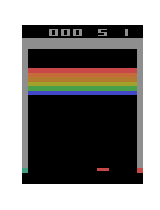
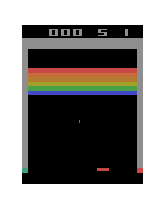
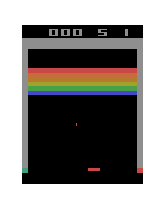
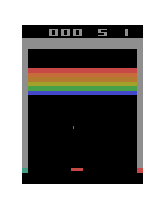
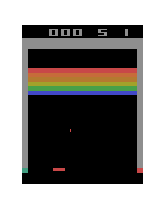
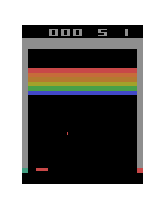
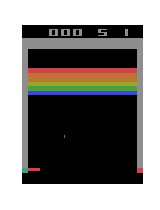
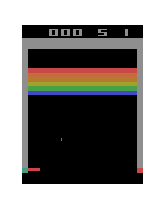
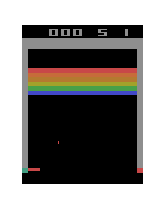
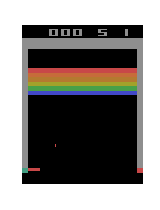
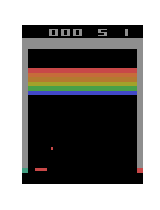
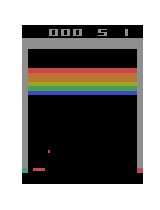
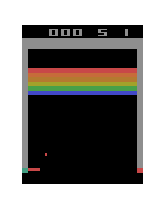
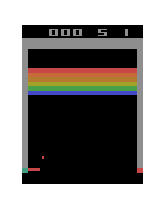
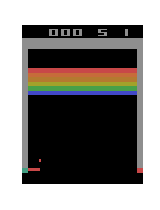
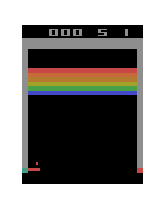
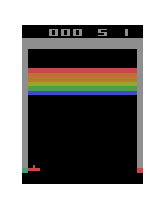
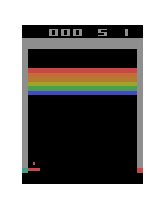
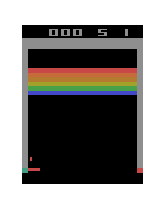
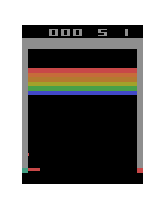
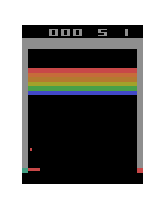
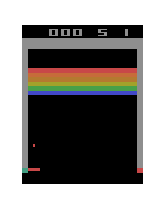
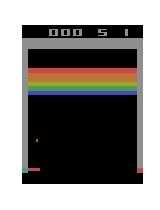
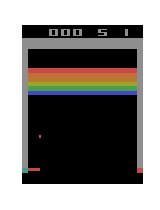
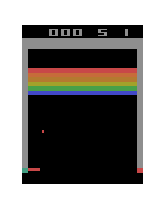
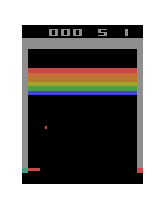
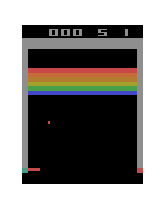
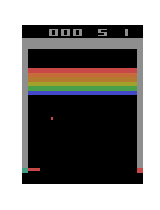
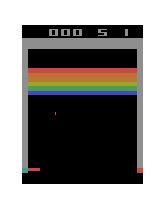
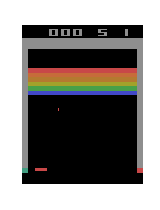
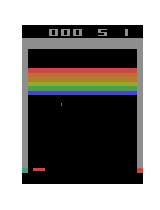
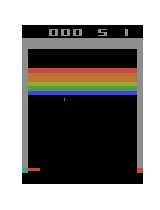
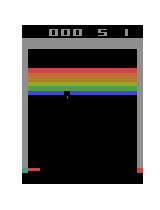
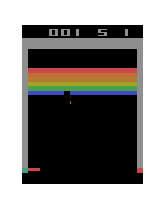
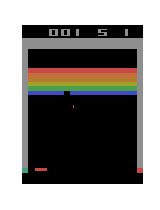
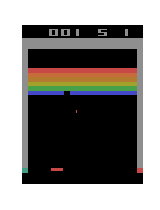
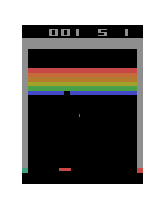
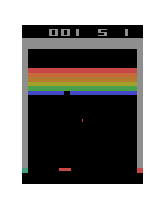
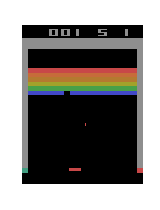
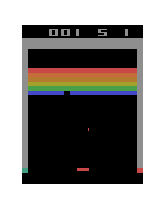
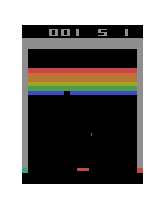
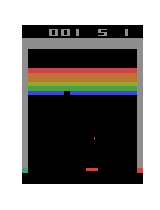
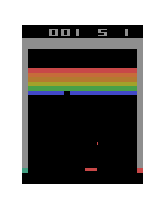
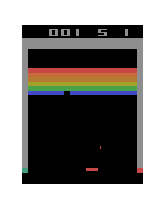
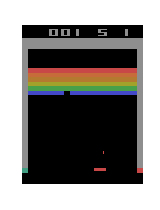
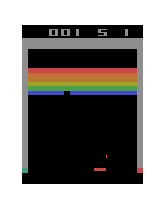
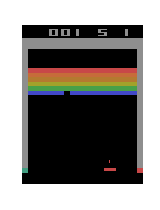
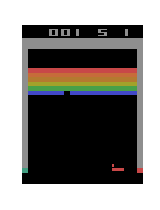
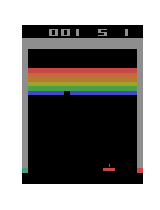
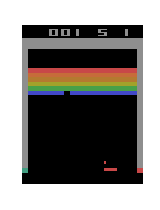
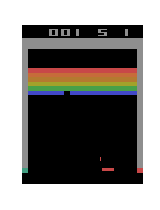
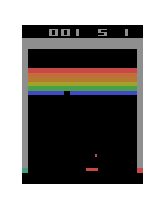
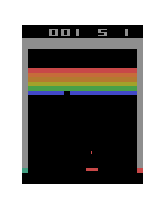
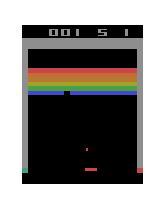
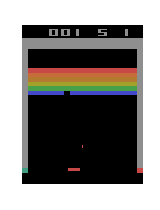
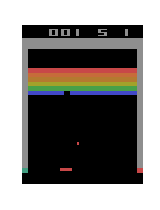
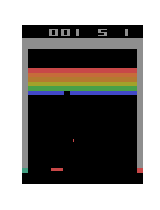
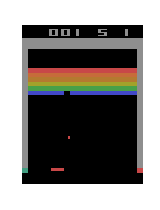
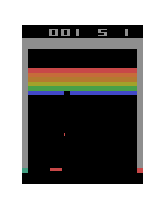
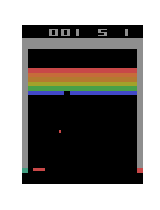
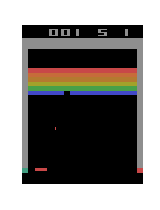
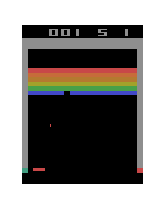
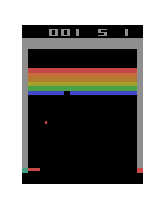
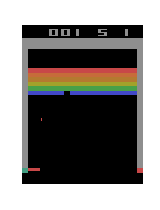
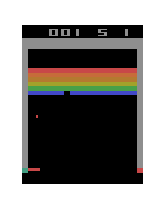
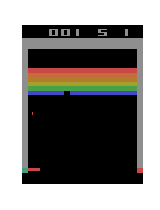
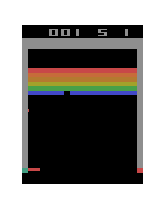
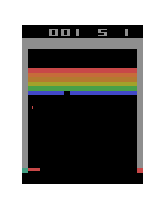
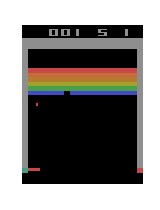
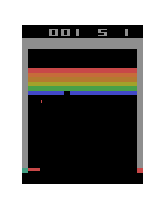
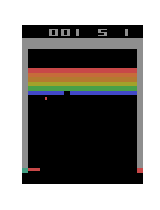
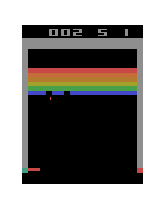
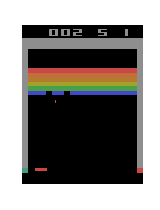
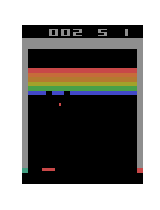
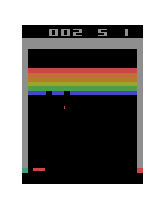
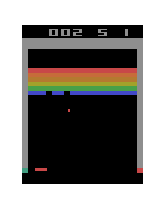
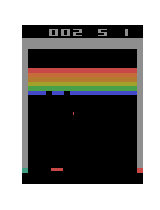
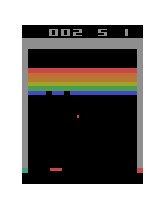
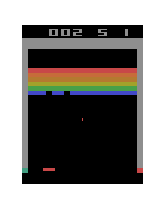
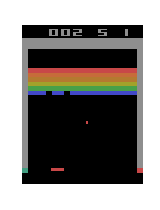
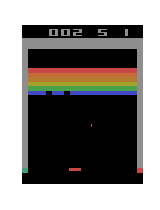
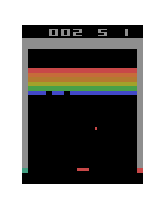
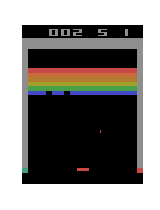
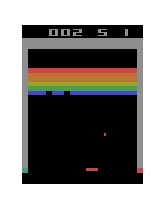
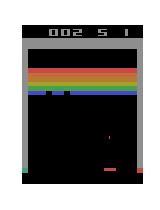
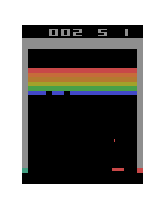
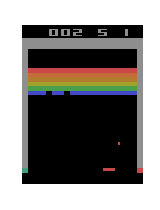
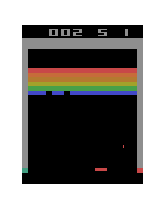
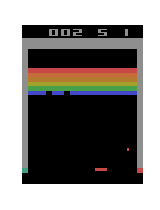
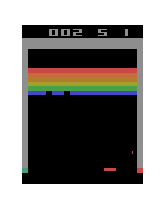
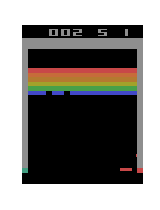
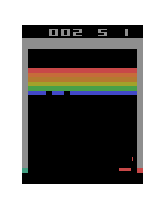
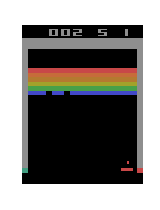
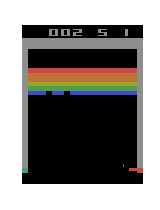
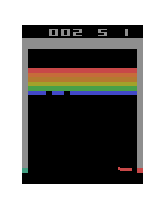
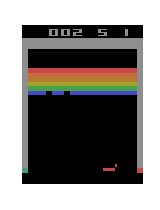
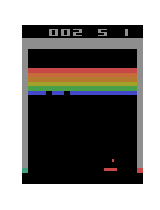
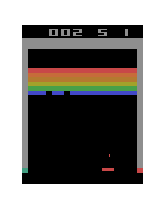
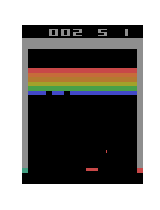
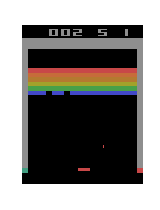
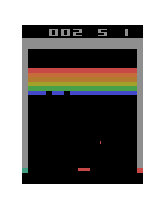
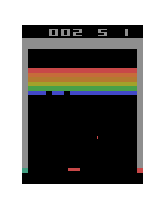
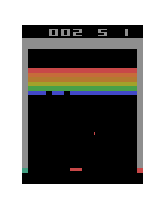
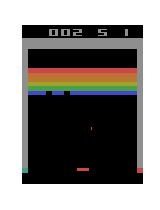
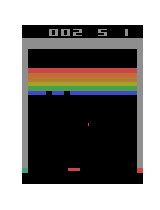
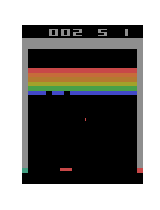
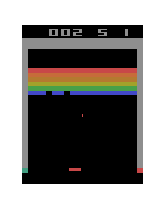
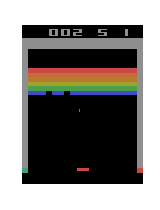
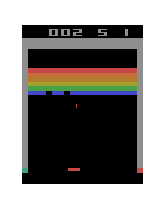
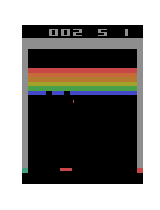
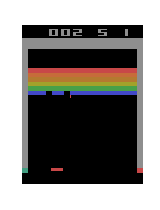
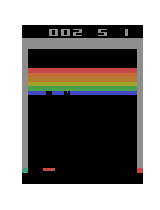
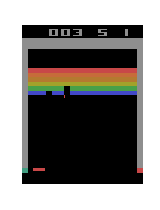
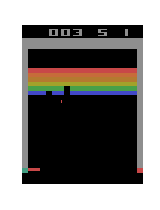
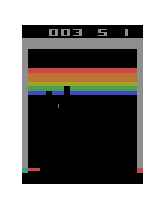
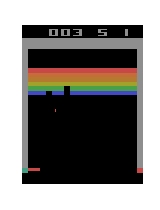
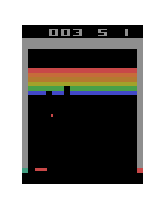
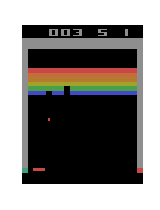
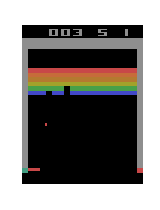
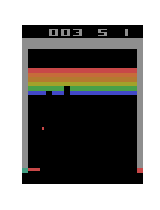
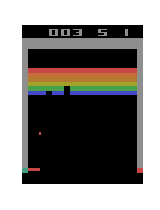
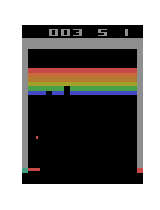
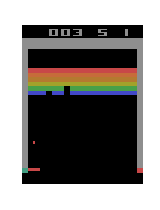
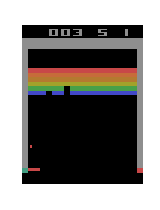
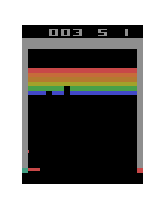
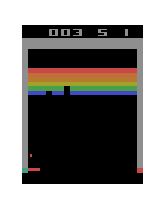
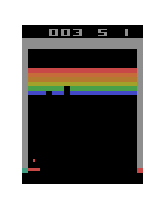
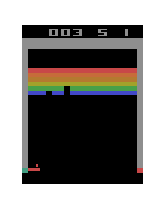
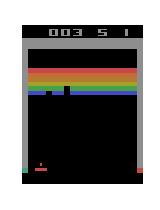
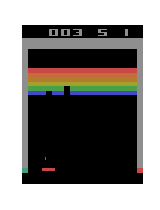
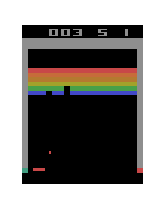
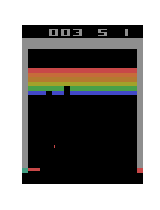
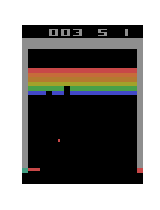
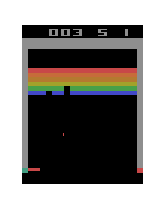
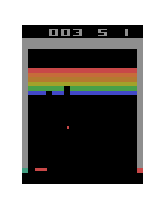
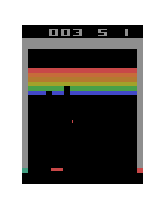
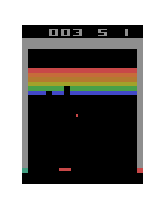
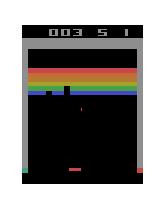
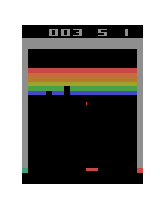
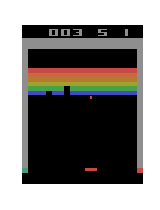
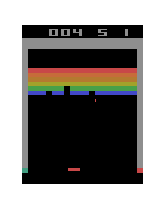
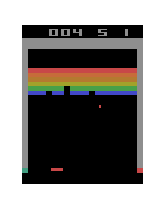
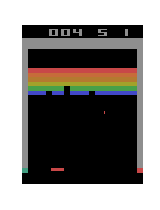
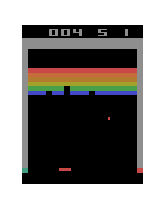
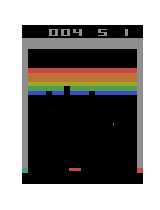
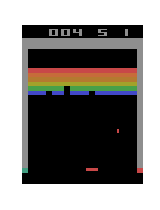
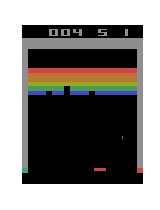
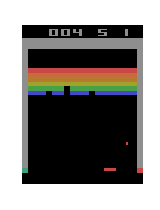
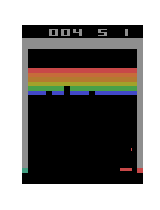
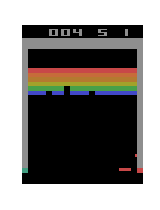
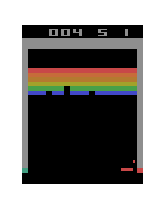
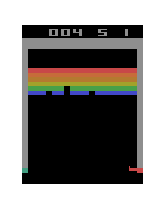
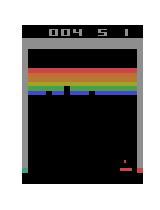
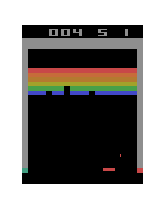
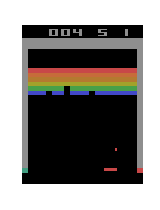
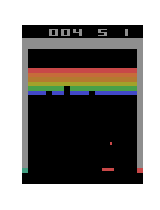
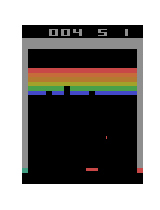
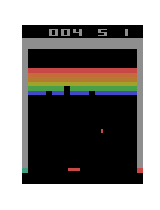
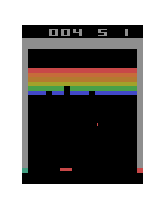
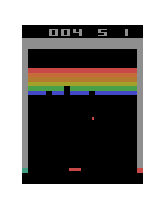
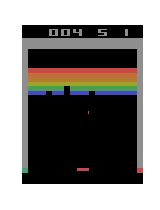
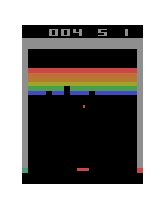
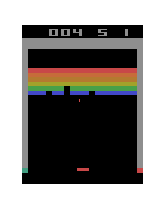
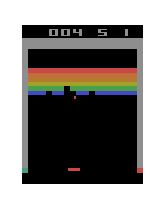
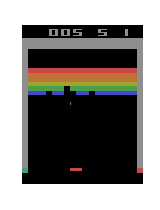
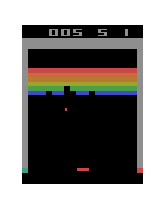
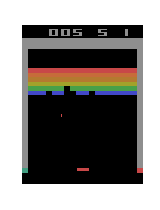
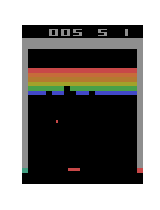
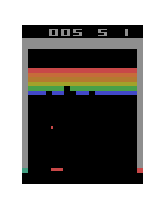
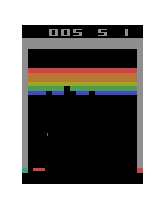
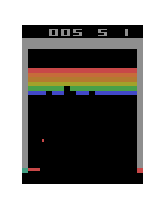
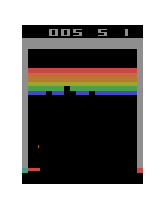
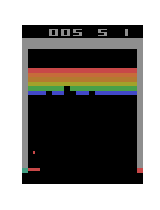
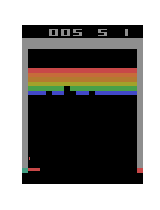
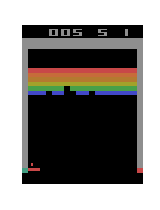
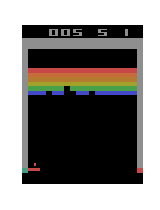
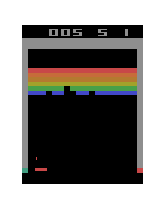
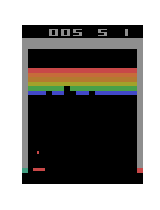
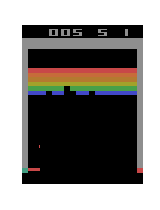
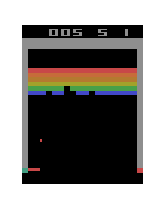
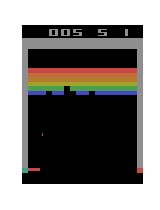
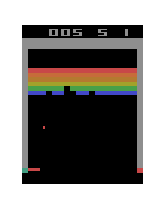
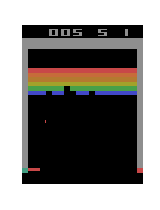
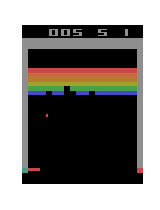
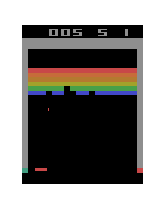
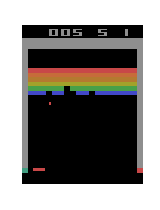
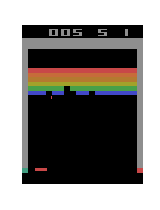
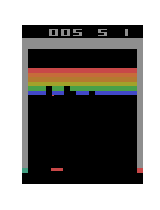
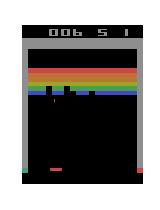
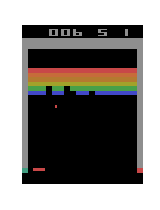
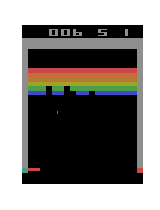
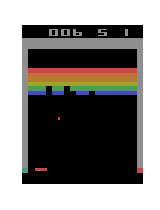
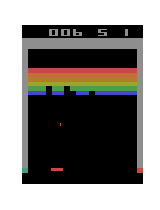
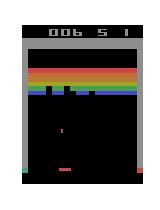
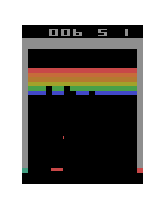
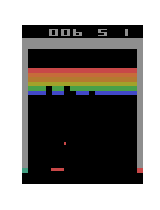
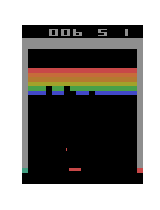
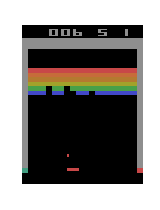
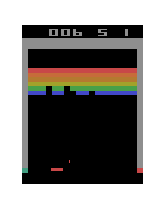
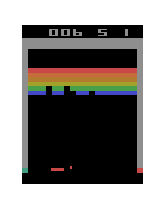
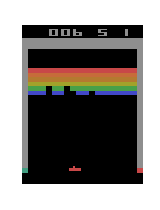
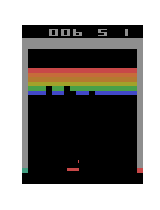
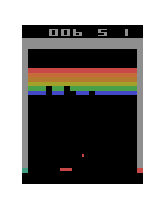
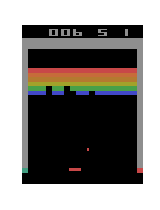
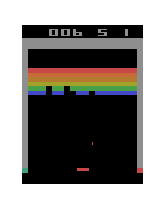
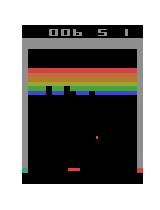
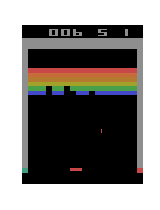
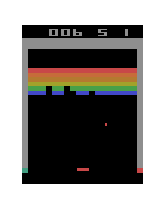
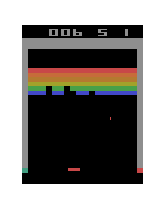
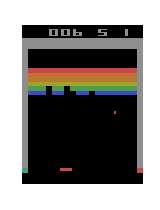
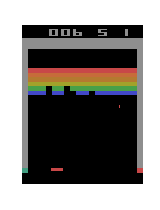
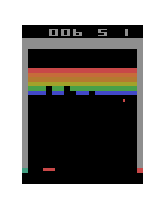
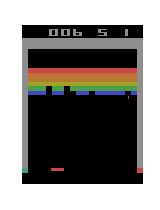
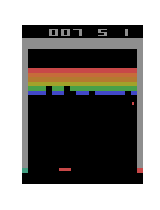
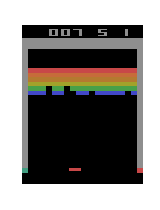
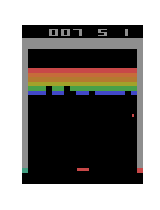
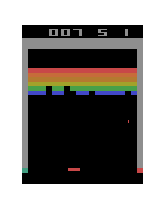
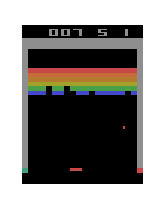
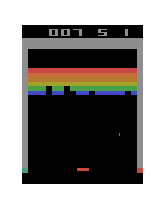
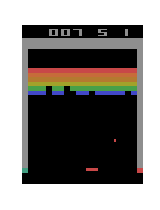
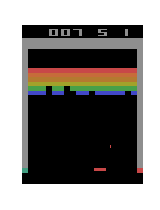
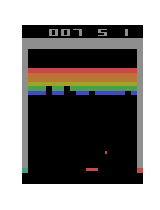
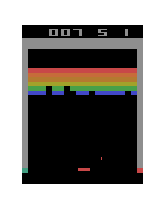
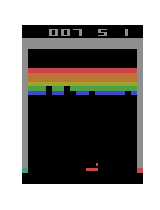
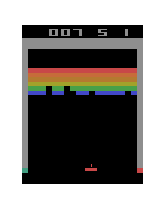
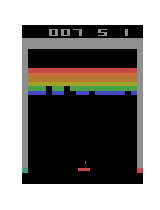
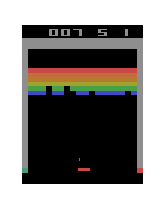
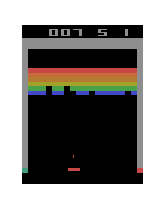
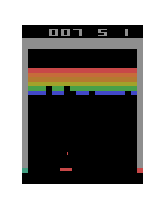
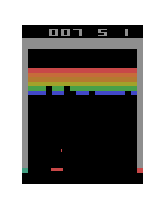
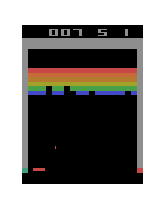
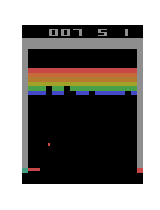
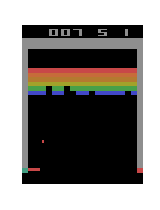
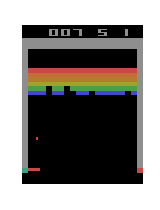
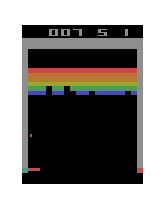
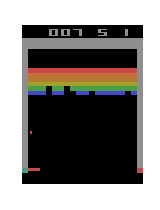
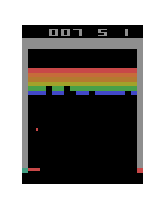
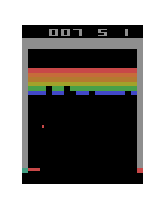
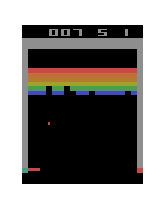
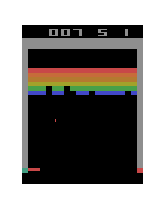
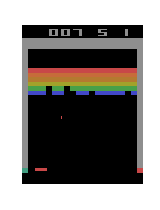
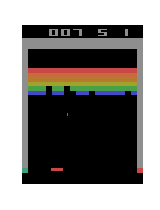
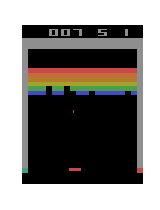
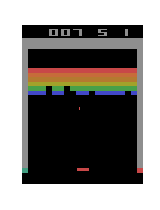
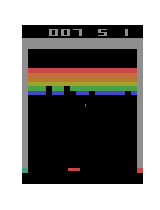
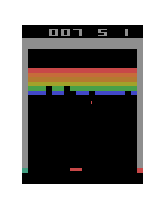
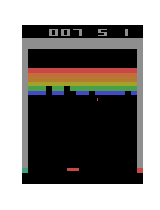
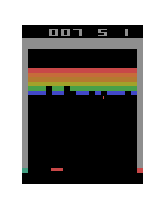
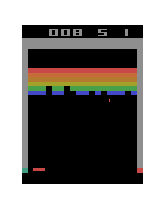
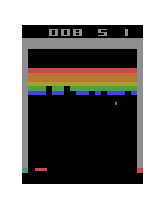
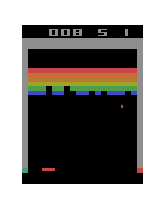
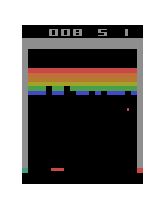
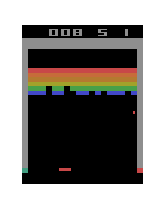
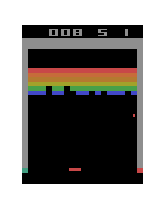
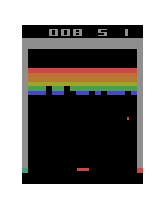
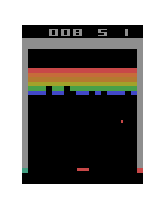
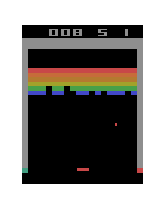
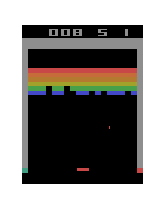
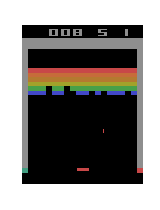
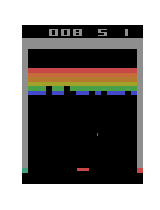
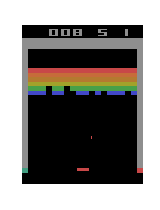
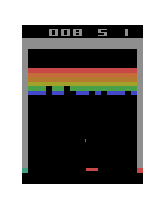
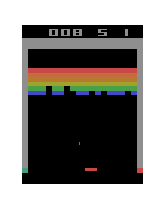
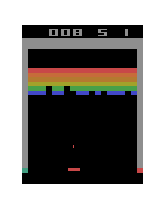
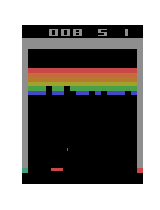
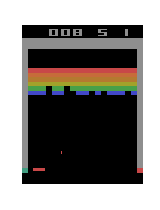
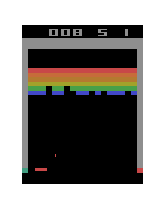
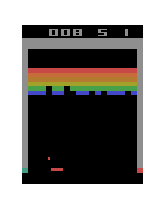
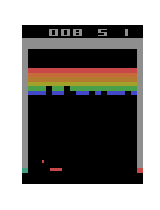
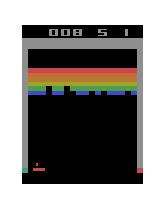
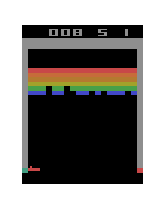
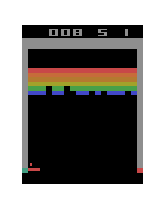
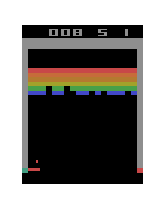
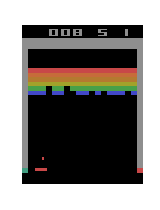
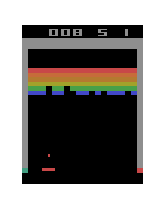
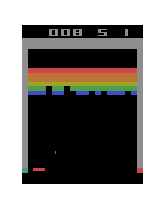
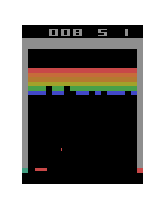
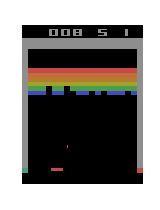
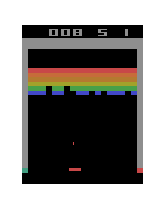
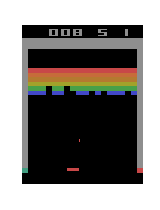
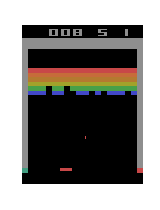
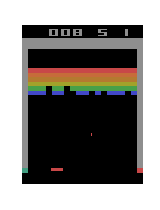
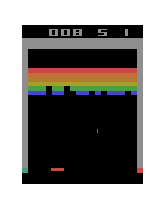
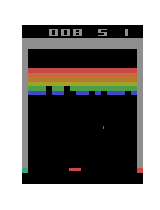
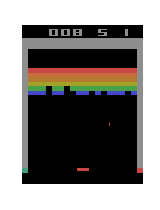
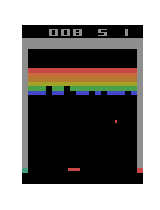
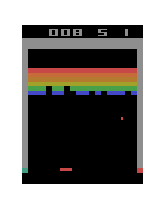
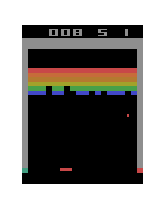
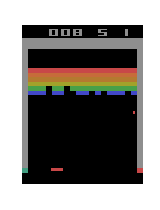
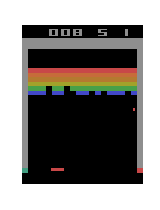
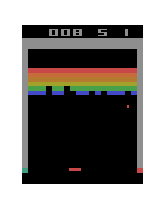
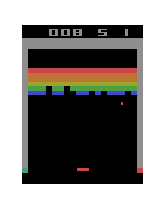
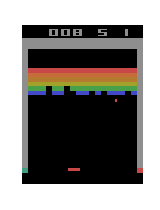
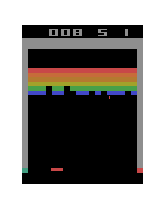
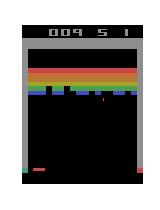
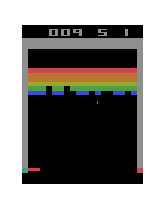
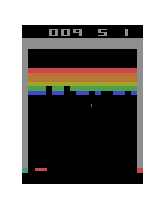
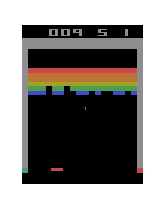
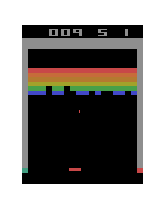

In [17]:
# 実行
breakout_env = Environment()
breakout_env.run()

In [9]:
import pickle
with open('frames_bk.pkl','rb') as f:
    load_dic = pickle.load(f)

In [7]:
for name in load_dic.keys():
    display_frames_as_gif(load_dic,name+'.mp4')

SyntaxError: unexpected EOF while parsing (<ipython-input-11-ab966d425434>, line 1)